"""
# Training Module Demo

This notebook demonstrates the **Training Module** for fairness-aware model training.

## Features Covered:
1. **ReductionsWrapper** - Fairlearn-based fairness constraints
2. **FairnessRegularizedLoss** - PyTorch loss with fairness penalty
3. **LagrangianFairnessTrainer** - Hard constraints via Lagrangian optimization
4. **GroupFairnessCalibrator** - Post-training calibration
5. **ParetoFrontierExplorer** - Systematic trade-off analysis
6. **Visualization** - Pareto frontiers and comparison plots
"""

In [1]:
# Cell 1: Setup Path
import sys
from pathlib import Path

# Get the current notebook directory
notebook_dir = Path.cwd()

# If we are in the root folder, add it. 
# If we are inside a subfolder, go up one level.
if (notebook_dir / "training_module").exists():
    project_root = notebook_dir
else:
    # Assuming notebook is in the root, try parent just in case
    project_root = notebook_dir.parent

# Add project root to sys.path
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print(f"✅ Project root set to: {project_root}")

✅ Project root set to: d:\Research\Turing\TuringProject\fairness_toolkit


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import importlib
import training_module.src.utils
importlib.reload(training_module.src.utils)

# Training module imports
from training_module.src import (
    ReductionsWrapper,
    GridSearchReductions,
    GroupFairnessCalibrator,
    calibrate_by_group,
    plot_pareto_frontier,
    plot_fairness_comparison,
    plot_group_metrics,
    generate_pareto_frontier_data,
    PYTORCH_AVAILABLE,
)

from training_module.src.utils import (
    prepare_fairness_data,
    evaluate_model_comprehensive,
    log_model_performance,
    compute_group_statistics,
    create_synthetic_fairness_dataset,
)

from training_module.src.pareto import (
    ParetoFrontierExplorer,
    quick_pareto_analysis,
)

from measurement_module.src.metrics_engine import (
    demographic_parity_difference,
    equalized_odds_difference,
)

# Optional PyTorch imports
if PYTORCH_AVAILABLE:
    from training_module.src import FairnessRegularizedLoss, create_fairness_loss
    from training_module.src.lagrangian_trainer import (
        LagrangianFairnessTrainer,
        LagrangianConfig,
        create_simple_mlp,
    )
    import torch
    import torch.nn as nn

print(f"PyTorch available: {PYTORCH_AVAILABLE}")
print("Training Module Demo Ready!")

PyTorch available: True
Training Module Demo Ready!


# Cell 3: Markdown
"""
## 1. Create Synthetic Dataset with Bias

We'll create a synthetic dataset where one group has an unfair advantage.
"""


In [3]:

# Cell 4: Code - Generate Dataset
# Generate biased dataset
X, y, sensitive_features = create_synthetic_fairness_dataset(
    n_samples=2000,
    n_features=20,
    bias_strength=0.5,
    random_state=42
)

# Prepare train/val/test splits
data_splits = prepare_fairness_data(
    X, y, sensitive_features,
    test_size=0.2,
    val_size=0.1,
    scale_features=True,
    random_state=42
)

X_train = data_splits['X_train']
y_train = data_splits['y_train']
s_train = data_splits['sensitive_train']

X_val = data_splits['X_val']
y_val = data_splits['y_val']
s_val = data_splits['sensitive_val']

X_test = data_splits['X_test']
y_test = data_splits['y_test']
s_test = data_splits['sensitive_test']

print(f"\nDataset Statistics:")
print(f"Total samples: {len(X)}")
print(f"Features: {X.shape[1]}")
print(f"Positive rate: {y.mean():.3f}")
print(f"\nGroup distribution:")
print(f"Group 0: {(sensitive_features == 0).sum()} samples")
print(f"Group 1: {(sensitive_features == 1).sum()} samples")


2026-01-17 16:17:18 - training_module.src.utils - INFO - Generated synthetic dataset: n=2000, features=20, bias=0.50


2026-01-17 16:17:18,861 - training_module.src.utils - INFO - Generated synthetic dataset: n=2000, features=20, bias=0.50


2026-01-17 16:17:18 - training_module.src.utils - INFO - Data splits: train=1400, val=200, test=400


2026-01-17 16:17:18,874 - training_module.src.utils - INFO - Data splits: train=1400, val=200, test=400



Dataset Statistics:
Total samples: 2000
Features: 20
Positive rate: 0.500

Group distribution:
Group 0: 962 samples
Group 1: 1038 samples


# Cell 5: Markdown
"""
## 2. Baseline Model (No Fairness Constraints)

Train a standard model to see the initial bias.
"""

In [4]:
# Cell 6: Code - Train Baseline
# Train baseline model
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train, y_train)

# Evaluate
baseline_metrics = evaluate_model_comprehensive(
    baseline_model, X_test, y_test, s_test, prefix='test_'
)


log_model_performance(baseline_metrics, "Baseline Model")

# Compute per-group statistics
y_pred_baseline = baseline_model.predict(X_test)
baseline_stats = compute_group_statistics(y_test, y_pred_baseline, s_test)
print("\nPer-Group Statistics:")
print(baseline_stats)


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:17:30,401 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0979


2026-01-17 16:17:30,404 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0979


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0280


2026-01-17 16:17:30,406 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0280


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0203


2026-01-17 16:17:30,409 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0203


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0658


2026-01-17 16:17:30,413 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0658


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1118


2026-01-17 16:17:30,416 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1118


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1283


2026-01-17 16:17:30,417 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1283


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-17 16:17:30,420 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0469


2026-01-17 16:17:30,423 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0469


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0658


2026-01-17 16:17:30,425 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0658


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:17:30,428 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-17 16:17:30,430 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0811


2026-01-17 16:17:30,432 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0811


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0319


2026-01-17 16:17:30,433 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0319


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0811


2026-01-17 16:17:30,436 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0811


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1542


2026-01-17 16:17:30,440 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1542


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0785


2026-01-17 16:17:30,442 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0785


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0105


2026-01-17 16:17:30,445 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0105


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1217


2026-01-17 16:17:30,449 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1217


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0596


2026-01-17 16:17:30,451 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0596


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1061


2026-01-17 16:17:30,455 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1061


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-17 16:17:30,458 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0454


2026-01-17 16:17:30,460 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0454


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0591


2026-01-17 16:17:30,462 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0591


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1262


2026-01-17 16:17:30,466 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1262


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-17 16:17:30,471 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1005


2026-01-17 16:17:30,475 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1005


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0312


2026-01-17 16:17:30,478 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0312


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0146


2026-01-17 16:17:30,481 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0146


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:17:30,483 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-17 16:17:30,484 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-17 16:17:30,487 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0012


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0255


2026-01-17 16:17:30,490 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0255


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1135


2026-01-17 16:17:30,492 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1135


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1101


2026-01-17 16:17:30,496 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1101


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0258


2026-01-17 16:17:30,499 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0258


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0413


2026-01-17 16:17:30,503 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0413


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0851


2026-01-17 16:17:30,505 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0851


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0637


2026-01-17 16:17:30,508 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0637


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0303


2026-01-17 16:17:30,512 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0303


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1016


2026-01-17 16:17:30,514 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1016


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1385


2026-01-17 16:17:30,517 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1385


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0600


2026-01-17 16:17:30,519 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0600


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0756


2026-01-17 16:17:30,522 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0756


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0799


2026-01-17 16:17:30,525 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0799


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0197


2026-01-17 16:17:30,527 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0197


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0953


2026-01-17 16:17:30,531 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0953


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0644


2026-01-17 16:17:30,535 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0644


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-17 16:17:30,539 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0605


2026-01-17 16:17:30,541 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0605


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1664


2026-01-17 16:17:30,543 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1664


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0114


2026-01-17 16:17:30,546 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0114


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0340


2026-01-17 16:17:30,550 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0340


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1094


2026-01-17 16:17:30,554 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1094


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0151


2026-01-17 16:17:30,556 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0151


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0643


2026-01-17 16:17:30,559 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0643


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0108


2026-01-17 16:17:30,561 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0108


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0876


2026-01-17 16:17:30,563 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0876


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0164


2026-01-17 16:17:30,567 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0164


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:17:30,570 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0192


2026-01-17 16:17:30,574 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0192


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0685


2026-01-17 16:17:30,577 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0685


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0710


2026-01-17 16:17:30,579 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0710


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-17 16:17:30,583 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0694


2026-01-17 16:17:30,587 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0694


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1107


2026-01-17 16:17:30,590 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1107


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0168


2026-01-17 16:17:30,592 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0168


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0672


2026-01-17 16:17:30,596 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0672


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0484


2026-01-17 16:17:30,600 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0484


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0191


2026-01-17 16:17:30,603 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0191


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0397


2026-01-17 16:17:30,606 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0397


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1007


2026-01-17 16:17:30,609 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1007


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0161


2026-01-17 16:17:30,612 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0161


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0598


2026-01-17 16:17:30,615 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0598


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0654


2026-01-17 16:17:30,618 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0654


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0506


2026-01-17 16:17:30,621 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0506


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0138


2026-01-17 16:17:30,625 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0138


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0543


2026-01-17 16:17:30,627 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0543


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1344


2026-01-17 16:17:30,630 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1344


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0551


2026-01-17 16:17:30,634 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0551


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0843


2026-01-17 16:17:30,638 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0843


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1004


2026-01-17 16:17:30,641 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1004


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0155


2026-01-17 16:17:30,644 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0155


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0940


2026-01-17 16:17:30,647 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0940


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1452


2026-01-17 16:17:30,650 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1452


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0947


2026-01-17 16:17:30,653 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0947


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:17:30,656 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0862


2026-01-17 16:17:30,659 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0862


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1170


2026-01-17 16:17:30,662 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1170


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0947


2026-01-17 16:17:30,666 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0947


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0941


2026-01-17 16:17:30,670 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0941


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0390


2026-01-17 16:17:30,673 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0390


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2035


2026-01-17 16:17:30,676 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2035


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0264


2026-01-17 16:17:30,679 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0264


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1086


2026-01-17 16:17:30,683 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1086


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1145


2026-01-17 16:17:30,688 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1145


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0517


2026-01-17 16:17:30,691 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0517


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0260


2026-01-17 16:17:30,695 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0260


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0107


2026-01-17 16:17:30,701 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0107


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0309


2026-01-17 16:17:30,705 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0309


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0684


2026-01-17 16:17:30,708 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0684


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0702


2026-01-17 16:17:30,712 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0702


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0560


2026-01-17 16:17:30,716 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0560


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1606


2026-01-17 16:17:30,721 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1606


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0798


2026-01-17 16:17:30,725 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0798


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1228


2026-01-17 16:17:30,729 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1228


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0204


2026-01-17 16:17:30,734 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0204


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:17:30,737 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-17 16:17:30,739 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0381


2026-01-17 16:17:30,744 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0381


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1604


2026-01-17 16:17:30,747 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1604


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0755


2026-01-17 16:17:30,750 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0755


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0947


2026-01-17 16:17:30,754 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0947


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0420


2026-01-17 16:17:30,759 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0420


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1595


2026-01-17 16:17:30,762 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1595


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0192


2026-01-17 16:17:30,767 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0192


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1289


2026-01-17 16:17:30,783 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1289


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0489


2026-01-17 16:17:30,788 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0489


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0916


2026-01-17 16:17:30,790 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0916


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0194


2026-01-17 16:17:30,793 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0194


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-17 16:17:30,797 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0784


2026-01-17 16:17:30,800 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0784


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0506


2026-01-17 16:17:30,804 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0506


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0910


2026-01-17 16:17:30,808 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0910


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0986


2026-01-17 16:17:30,815 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0986


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-17 16:17:30,818 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0763


2026-01-17 16:17:30,821 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0763


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0900


2026-01-17 16:17:30,826 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0900


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0500


2026-01-17 16:17:30,830 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0500


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0639


2026-01-17 16:17:30,833 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0639


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0741


2026-01-17 16:17:30,836 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0741


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1445


2026-01-17 16:17:30,840 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1445


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0393


2026-01-17 16:17:30,844 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0393


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0449


2026-01-17 16:17:30,849 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0449


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1014


2026-01-17 16:17:30,854 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1014


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1114


2026-01-17 16:17:30,858 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1114


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0487


2026-01-17 16:17:30,861 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0487


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0297


2026-01-17 16:17:30,865 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0297


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-17 16:17:30,870 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0803


2026-01-17 16:17:30,874 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0803


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0491


2026-01-17 16:17:30,879 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0491


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0302


2026-01-17 16:17:30,882 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0302


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0733


2026-01-17 16:17:30,886 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0733


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0752


2026-01-17 16:17:30,889 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0752


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0467


2026-01-17 16:17:30,892 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0467


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0532


2026-01-17 16:17:30,895 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0532


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0045


2026-01-17 16:17:30,899 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0045


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0982


2026-01-17 16:17:30,904 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0982


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1193


2026-01-17 16:17:30,909 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1193


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0478


2026-01-17 16:17:30,913 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0478


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0349


2026-01-17 16:17:30,916 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0349


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1004


2026-01-17 16:17:30,920 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1004


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1312


2026-01-17 16:17:30,924 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1312


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1266


2026-01-17 16:17:30,929 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1266


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0759


2026-01-17 16:17:30,934 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0759


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-17 16:17:30,937 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0161


2026-01-17 16:17:30,941 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0161


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1341


2026-01-17 16:17:30,945 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1341


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1358


2026-01-17 16:17:30,950 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1358


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0689


2026-01-17 16:17:30,954 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0689


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0308


2026-01-17 16:17:30,958 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0308


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0847


2026-01-17 16:17:30,963 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0847


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0963


2026-01-17 16:17:30,967 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0963


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0557


2026-01-17 16:17:30,971 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0557


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0502


2026-01-17 16:17:30,975 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0502


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0909


2026-01-17 16:17:30,978 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0909


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-17 16:17:30,981 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0895


2026-01-17 16:17:30,985 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0895


2026-01-17 16:17:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0795


2026-01-17 16:17:30,996 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0795


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1840


2026-01-17 16:17:31,026 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1840


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0392


2026-01-17 16:17:31,030 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0392


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0592


2026-01-17 16:17:31,034 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0592


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1070


2026-01-17 16:17:31,038 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1070


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0444


2026-01-17 16:17:31,042 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0444


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0678


2026-01-17 16:17:31,046 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0678


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0354


2026-01-17 16:17:31,049 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0354


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1034


2026-01-17 16:17:31,053 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1034


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0311


2026-01-17 16:17:31,057 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0311


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0338


2026-01-17 16:17:31,061 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0338


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-17 16:17:31,064 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0388


2026-01-17 16:17:31,072 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0388


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0443


2026-01-17 16:17:31,076 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0443


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0747


2026-01-17 16:17:31,080 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0747


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0357


2026-01-17 16:17:31,084 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0357


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0447


2026-01-17 16:17:31,108 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0447


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1757


2026-01-17 16:17:31,112 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1757


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0997


2026-01-17 16:17:31,116 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0997


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:17:31,120 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-17 16:17:31,124 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0226


2026-01-17 16:17:31,128 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0226


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0957


2026-01-17 16:17:31,133 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0957


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0547


2026-01-17 16:17:31,137 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0547


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0459


2026-01-17 16:17:31,142 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0459


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0134


2026-01-17 16:17:31,147 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0134


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1199


2026-01-17 16:17:31,150 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1199


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-17 16:17:31,155 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0247


2026-01-17 16:17:31,158 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0247


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0313


2026-01-17 16:17:31,163 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0313


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:17:31,166 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0738


2026-01-17 16:17:31,174 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0738


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0924


2026-01-17 16:17:31,182 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0924


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1452


2026-01-17 16:17:31,186 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1452


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1471


2026-01-17 16:17:31,195 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1471


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0443


2026-01-17 16:17:31,203 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0443


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1069


2026-01-17 16:17:31,210 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1069


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1607


2026-01-17 16:17:31,216 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1607


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0987


2026-01-17 16:17:31,222 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0987


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1057


2026-01-17 16:17:31,226 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1057


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0606


2026-01-17 16:17:31,231 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0606


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0361


2026-01-17 16:17:31,237 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0361


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0906


2026-01-17 16:17:31,267 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0906


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0401


2026-01-17 16:17:31,273 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0401


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1460


2026-01-17 16:17:31,278 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1460


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0237


2026-01-17 16:17:31,286 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0237


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0240


2026-01-17 16:17:31,290 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0240


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1233


2026-01-17 16:17:31,296 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1233


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0236


2026-01-17 16:17:31,302 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0236


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0340


2026-01-17 16:17:31,308 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0340


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1218


2026-01-17 16:17:31,314 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1218


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1274


2026-01-17 16:17:31,321 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1274


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0817


2026-01-17 16:17:31,326 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0817


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0240


2026-01-17 16:17:31,331 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0240


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0733


2026-01-17 16:17:31,337 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0733


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0892


2026-01-17 16:17:31,342 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0892


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0549


2026-01-17 16:17:31,347 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0549


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0653


2026-01-17 16:17:31,353 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0653


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1037


2026-01-17 16:17:31,357 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1037


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1049


2026-01-17 16:17:31,362 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1049


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1702


2026-01-17 16:17:31,369 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1702


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:17:31,376 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0096


2026-01-17 16:17:31,380 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0096


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0700


2026-01-17 16:17:31,385 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0700


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0706


2026-01-17 16:17:31,390 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0706


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0359


2026-01-17 16:17:31,395 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0359


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1429


2026-01-17 16:17:31,399 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1429


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0159


2026-01-17 16:17:31,403 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0159


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:17:31,409 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0551


2026-01-17 16:17:31,415 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0551


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0878


2026-01-17 16:17:31,418 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0878


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0355


2026-01-17 16:17:31,424 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0355


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-17 16:17:31,430 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0609


2026-01-17 16:17:31,434 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0609


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0499


2026-01-17 16:17:31,439 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0499


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0352


2026-01-17 16:17:31,444 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0352


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1346


2026-01-17 16:17:31,449 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1346


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0527


2026-01-17 16:17:31,455 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0527


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-17 16:17:31,458 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1999


2026-01-17 16:17:31,464 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1999


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0705


2026-01-17 16:17:31,470 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0705


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-17 16:17:31,475 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0194


2026-01-17 16:17:31,479 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0194


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1502


2026-01-17 16:17:31,484 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1502


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1018


2026-01-17 16:17:31,490 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1018


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0502


2026-01-17 16:17:31,494 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0502


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1405


2026-01-17 16:17:31,498 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1405


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0170


2026-01-17 16:17:31,505 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0170


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1024


2026-01-17 16:17:31,511 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1024


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0917


2026-01-17 16:17:31,516 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0917


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0899


2026-01-17 16:17:31,523 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0899


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1361


2026-01-17 16:17:31,528 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1361


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0428


2026-01-17 16:17:31,533 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0428


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0846


2026-01-17 16:17:31,540 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0846


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1616


2026-01-17 16:17:31,544 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1616


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0335


2026-01-17 16:17:31,549 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0335


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0439


2026-01-17 16:17:31,554 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0439


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0904


2026-01-17 16:17:31,560 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0904


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0668


2026-01-17 16:17:31,565 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0668


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0300


2026-01-17 16:17:31,569 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0300


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0473


2026-01-17 16:17:31,574 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0473


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0922


2026-01-17 16:17:31,579 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0922


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-17 16:17:31,584 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0734


2026-01-17 16:17:31,589 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0734


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:17:31,595 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0599


2026-01-17 16:17:31,600 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0599


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1231


2026-01-17 16:17:31,605 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1231


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0978


2026-01-17 16:17:31,611 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0978


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0751


2026-01-17 16:17:31,616 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0751


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0623


2026-01-17 16:17:31,621 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0623


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1053


2026-01-17 16:17:31,627 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1053


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-17 16:17:31,632 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0435


2026-01-17 16:17:31,636 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0435


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1071


2026-01-17 16:17:31,642 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1071


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1054


2026-01-17 16:17:31,648 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1054


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0052


2026-01-17 16:17:31,653 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0052


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0809


2026-01-17 16:17:31,658 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0809


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0701


2026-01-17 16:17:31,663 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0701


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1772


2026-01-17 16:17:31,669 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1772


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0603


2026-01-17 16:17:31,674 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0603


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0663


2026-01-17 16:17:31,679 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0663


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0282


2026-01-17 16:17:31,684 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0282


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0552


2026-01-17 16:17:31,689 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0552


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1059


2026-01-17 16:17:31,694 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1059


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0265


2026-01-17 16:17:31,699 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0265


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0594


2026-01-17 16:17:31,705 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0594


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0874


2026-01-17 16:17:31,711 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0874


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1198


2026-01-17 16:17:31,716 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1198


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1018


2026-01-17 16:17:31,720 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1018


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0643


2026-01-17 16:17:31,726 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0643


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0132


2026-01-17 16:17:31,730 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0132


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1110


2026-01-17 16:17:31,734 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1110


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0458


2026-01-17 16:17:31,740 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0458


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-17 16:17:31,744 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:17:31,748 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-17 16:17:31,753 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0453


2026-01-17 16:17:31,758 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0453


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1193


2026-01-17 16:17:31,764 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1193


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0143


2026-01-17 16:17:31,769 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0143


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0476


2026-01-17 16:17:31,773 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0476


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1524


2026-01-17 16:17:31,778 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1524


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0525


2026-01-17 16:17:31,782 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0525


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:17:31,787 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0524


2026-01-17 16:17:31,791 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0524


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0938


2026-01-17 16:17:31,804 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0938


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-17 16:17:31,809 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:17:31,813 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:17:31,819 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0913


2026-01-17 16:17:31,823 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0913


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0965


2026-01-17 16:17:31,828 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0965


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0998


2026-01-17 16:17:31,833 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0998


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0649


2026-01-17 16:17:31,836 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0649


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0389


2026-01-17 16:17:31,841 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0389


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0398


2026-01-17 16:17:31,845 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0398


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:17:31,850 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0614


2026-01-17 16:17:31,854 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0614


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0343


2026-01-17 16:17:31,859 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0343


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1279


2026-01-17 16:17:31,864 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1279


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0127


2026-01-17 16:17:31,869 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0127


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1101


2026-01-17 16:17:31,873 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1101


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1070


2026-01-17 16:17:31,907 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1070


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0827


2026-01-17 16:17:31,913 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0827


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0898


2026-01-17 16:17:31,918 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0898


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0400


2026-01-17 16:17:31,923 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0400


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0657


2026-01-17 16:17:31,928 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0657


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0690


2026-01-17 16:17:31,932 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0690


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0407


2026-01-17 16:17:31,936 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0407


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0532


2026-01-17 16:17:31,940 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0532


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1339


2026-01-17 16:17:31,946 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1339


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0738


2026-01-17 16:17:31,950 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0738


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0665


2026-01-17 16:17:31,954 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0665


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-17 16:17:31,959 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0298


2026-01-17 16:17:31,964 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0298


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0725


2026-01-17 16:17:31,969 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0725


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1240


2026-01-17 16:17:31,973 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1240


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0886


2026-01-17 16:17:31,977 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0886


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1017


2026-01-17 16:17:31,981 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1017


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0350


2026-01-17 16:17:31,985 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0350


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-17 16:17:31,988 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0401


2026-01-17 16:17:31,991 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0401


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1145


2026-01-17 16:17:31,994 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1145


2026-01-17 16:17:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1447


2026-01-17 16:17:31,997 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1447


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0779


2026-01-17 16:17:32,001 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0779


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1122


2026-01-17 16:17:32,006 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1122


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:17:32,008 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0649


2026-01-17 16:17:32,012 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0649


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1154


2026-01-17 16:17:32,016 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1154


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0371


2026-01-17 16:17:32,020 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0371


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1072


2026-01-17 16:17:32,022 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1072


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0499


2026-01-17 16:17:32,026 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0499


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0934


2026-01-17 16:17:32,029 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0934


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0500


2026-01-17 16:17:32,032 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0500


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1505


2026-01-17 16:17:32,037 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1505


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0521


2026-01-17 16:17:32,040 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0521


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0644


2026-01-17 16:17:32,044 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0644


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1279


2026-01-17 16:17:32,049 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1279


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0212


2026-01-17 16:17:32,052 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0212


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0804


2026-01-17 16:17:32,058 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0804


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0652


2026-01-17 16:17:32,063 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0652


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0697


2026-01-17 16:17:32,066 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0697


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0542


2026-01-17 16:17:32,070 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0542


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0520


2026-01-17 16:17:32,073 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0520


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0824


2026-01-17 16:17:32,076 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0824


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1148


2026-01-17 16:17:32,081 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1148


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1104


2026-01-17 16:17:32,085 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1104


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0216


2026-01-17 16:17:32,088 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0216


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0816


2026-01-17 16:17:32,091 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0816


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0361


2026-01-17 16:17:32,095 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0361


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0689


2026-01-17 16:17:32,099 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0689


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1358


2026-01-17 16:17:32,103 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1358


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0202


2026-01-17 16:17:32,107 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0202


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0455


2026-01-17 16:17:32,110 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0455


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1282


2026-01-17 16:17:32,113 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1282


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1586


2026-01-17 16:17:32,119 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1586


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1639


2026-01-17 16:17:32,121 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1639


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0394


2026-01-17 16:17:32,124 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0394


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0698


2026-01-17 16:17:32,129 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0698


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1099


2026-01-17 16:17:32,133 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1099


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0191


2026-01-17 16:17:32,138 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0191


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1502


2026-01-17 16:17:32,143 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1502


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-17 16:17:32,147 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0059


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-17 16:17:32,151 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0037


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0601


2026-01-17 16:17:32,156 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0601


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0131


2026-01-17 16:17:32,160 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0131


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0162


2026-01-17 16:17:32,165 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0162


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-17 16:17:32,169 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:17:32,175 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1262


2026-01-17 16:17:32,182 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1262


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0771


2026-01-17 16:17:32,187 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0771


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0579


2026-01-17 16:17:32,191 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0579


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0702


2026-01-17 16:17:32,195 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0702


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-17 16:17:32,201 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0654


2026-01-17 16:17:32,206 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0654


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-17 16:17:32,211 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0461


2026-01-17 16:17:32,215 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0461


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1189


2026-01-17 16:17:32,221 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1189


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1655


2026-01-17 16:17:32,224 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1655


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0998


2026-01-17 16:17:32,230 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0998


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0785


2026-01-17 16:17:32,235 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0785


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0357


2026-01-17 16:17:32,240 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0357


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0107


2026-01-17 16:17:32,244 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0107


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0439


2026-01-17 16:17:32,247 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0439


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-17 16:17:32,250 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0724


2026-01-17 16:17:32,254 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0724


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-17 16:17:32,258 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0401


2026-01-17 16:17:32,261 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0401


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0750


2026-01-17 16:17:32,265 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0750


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-17 16:17:32,269 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0318


2026-01-17 16:17:32,273 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0318


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0665


2026-01-17 16:17:32,277 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0665


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0238


2026-01-17 16:17:32,282 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0238


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0147


2026-01-17 16:17:32,286 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0147


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0344


2026-01-17 16:17:32,289 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0344


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1410


2026-01-17 16:17:32,294 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1410


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0215


2026-01-17 16:17:32,297 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0215


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0214


2026-01-17 16:17:32,301 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0214


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0787


2026-01-17 16:17:32,305 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0787


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0214


2026-01-17 16:17:32,308 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0214


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0240


2026-01-17 16:17:32,312 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0240


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1061


2026-01-17 16:17:32,315 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1061


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1030


2026-01-17 16:17:32,319 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1030


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:17:32,321 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0783


2026-01-17 16:17:32,325 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0783


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-17 16:17:32,329 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0614


2026-01-17 16:17:32,333 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0614


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0143


2026-01-17 16:17:32,337 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0143


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-17 16:17:32,340 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0596


2026-01-17 16:17:32,343 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0596


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0699


2026-01-17 16:17:32,346 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0699


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0707


2026-01-17 16:17:32,350 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0707


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0205


2026-01-17 16:17:32,353 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0205


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0338


2026-01-17 16:17:32,356 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0338


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0549


2026-01-17 16:17:32,360 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0549


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1480


2026-01-17 16:17:32,363 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1480


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0470


2026-01-17 16:17:32,366 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0470


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-17 16:17:32,370 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0145


2026-01-17 16:17:32,373 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0145


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0492


2026-01-17 16:17:32,376 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0492


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0402


2026-01-17 16:17:32,379 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0402


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:17:32,383 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0795


2026-01-17 16:17:32,387 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0795


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0757


2026-01-17 16:17:32,391 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0757


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0346


2026-01-17 16:17:32,395 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0346


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1714


2026-01-17 16:17:32,399 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1714


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0653


2026-01-17 16:17:32,407 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0653


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0153


2026-01-17 16:17:32,410 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0153


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0695


2026-01-17 16:17:32,448 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0695


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1350


2026-01-17 16:17:32,452 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1350


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0128


2026-01-17 16:17:32,457 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0128


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0119


2026-01-17 16:17:32,462 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0119


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0707


2026-01-17 16:17:32,467 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0707


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0347


2026-01-17 16:17:32,471 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0347


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:17:32,476 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-17 16:17:32,501 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0129


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0694


2026-01-17 16:17:32,506 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0694


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1590


2026-01-17 16:17:32,509 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1590


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0666


2026-01-17 16:17:32,513 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0666


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0811


2026-01-17 16:17:32,518 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0811


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0861


2026-01-17 16:17:32,521 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0861


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1102


2026-01-17 16:17:32,525 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1102


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1566


2026-01-17 16:17:32,529 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1566


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1262


2026-01-17 16:17:32,533 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1262


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1067


2026-01-17 16:17:32,537 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1067


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0689


2026-01-17 16:17:32,541 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0689


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1330


2026-01-17 16:17:32,546 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1330


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1350


2026-01-17 16:17:32,550 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1350


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1400


2026-01-17 16:17:32,554 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1400


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0873


2026-01-17 16:17:32,559 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0873


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1017


2026-01-17 16:17:32,563 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1017


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0510


2026-01-17 16:17:32,573 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0510


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0849


2026-01-17 16:17:32,577 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0849


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0943


2026-01-17 16:17:32,582 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0943


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0393


2026-01-17 16:17:32,587 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0393


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0535


2026-01-17 16:17:32,592 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0535


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0504


2026-01-17 16:17:32,596 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0504


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0732


2026-01-17 16:17:32,600 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0732


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0324


2026-01-17 16:17:32,606 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0324


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0257


2026-01-17 16:17:32,610 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0257


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0962


2026-01-17 16:17:32,613 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0962


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0240


2026-01-17 16:17:32,618 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0240


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0227


2026-01-17 16:17:32,622 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0227


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-17 16:17:32,627 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0329


2026-01-17 16:17:32,633 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0329


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-17 16:17:32,680 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0599


2026-01-17 16:17:32,685 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0599


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1799


2026-01-17 16:17:32,688 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1799


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0256


2026-01-17 16:17:32,697 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0256


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0608


2026-01-17 16:17:32,701 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0608


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1700


2026-01-17 16:17:32,705 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1700


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0294


2026-01-17 16:17:32,709 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0294


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0170


2026-01-17 16:17:32,712 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0170


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0198


2026-01-17 16:17:32,736 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0198


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:17:32,743 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0801


2026-01-17 16:17:32,747 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0801


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0316


2026-01-17 16:17:32,753 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0316


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0847


2026-01-17 16:17:32,757 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0847


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0304


2026-01-17 16:17:32,761 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0304


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0897


2026-01-17 16:17:32,767 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0897


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0591


2026-01-17 16:17:32,774 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0591


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0785


2026-01-17 16:17:32,781 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0785


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0638


2026-01-17 16:17:32,784 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0638


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0498


2026-01-17 16:17:32,790 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0498


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0870


2026-01-17 16:17:32,795 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0870


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0852


2026-01-17 16:17:32,802 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0852


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0300


2026-01-17 16:17:32,805 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0300


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0622


2026-01-17 16:17:32,812 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0622


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0481


2026-01-17 16:17:32,819 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0481


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0846


2026-01-17 16:17:32,824 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0846


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0426


2026-01-17 16:17:32,827 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0426


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0949


2026-01-17 16:17:32,834 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0949


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0555


2026-01-17 16:17:32,839 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0555


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0783


2026-01-17 16:17:32,843 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0783


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1074


2026-01-17 16:17:32,847 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1074


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0902


2026-01-17 16:17:32,852 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0902


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1350


2026-01-17 16:17:32,856 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1350


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0199


2026-01-17 16:17:32,860 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0199


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1095


2026-01-17 16:17:32,864 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1095


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0906


2026-01-17 16:17:32,868 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0906


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0211


2026-01-17 16:17:32,870 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0211


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0145


2026-01-17 16:17:32,875 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0145


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1241


2026-01-17 16:17:32,880 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1241


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0204


2026-01-17 16:17:32,884 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0204


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1104


2026-01-17 16:17:32,887 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1104


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0154


2026-01-17 16:17:32,893 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0154


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0426


2026-01-17 16:17:32,897 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0426


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0400


2026-01-17 16:17:32,903 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0400


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0397


2026-01-17 16:17:32,907 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0397


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0746


2026-01-17 16:17:32,912 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0746


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0820


2026-01-17 16:17:32,941 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0820


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0776


2026-01-17 16:17:32,944 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0776


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1301


2026-01-17 16:17:32,948 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1301


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0398


2026-01-17 16:17:32,954 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0398


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0251


2026-01-17 16:17:32,958 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0251


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-17 16:17:32,962 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1155


2026-01-17 16:17:32,966 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1155


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0329


2026-01-17 16:17:32,971 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0329


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0530


2026-01-17 16:17:32,979 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0530


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1549


2026-01-17 16:17:32,986 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1549


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0161


2026-01-17 16:17:32,991 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0161


2026-01-17 16:17:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0844


2026-01-17 16:17:32,997 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0844


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-17 16:17:33,002 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0654


2026-01-17 16:17:33,008 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0654


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0555


2026-01-17 16:17:33,014 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0555


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0813


2026-01-17 16:17:33,020 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0813


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0990


2026-01-17 16:17:33,024 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0990


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0352


2026-01-17 16:17:33,029 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0352


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0193


2026-01-17 16:17:33,035 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0193


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0417


2026-01-17 16:17:33,040 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0417


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0328


2026-01-17 16:17:33,047 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0328


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0912


2026-01-17 16:17:33,052 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0912


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-17 16:17:33,057 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-17 16:17:33,060 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0322


2026-01-17 16:17:33,070 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0322


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0672


2026-01-17 16:17:33,074 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0672


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0330


2026-01-17 16:17:33,078 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0330


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1487


2026-01-17 16:17:33,084 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1487


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0441


2026-01-17 16:17:33,092 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0441


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0287


2026-01-17 16:17:33,098 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0287


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0637


2026-01-17 16:17:33,103 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0637


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0502


2026-01-17 16:17:33,108 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0502


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-17 16:17:33,115 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0951


2026-01-17 16:17:33,120 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0951


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:17:33,124 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1165


2026-01-17 16:17:33,129 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1165


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0897


2026-01-17 16:17:33,134 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0897


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1276


2026-01-17 16:17:33,138 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1276


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0493


2026-01-17 16:17:33,143 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0493


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0362


2026-01-17 16:17:33,150 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0362


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0732


2026-01-17 16:17:33,156 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0732


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0998


2026-01-17 16:17:33,160 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0998


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0463


2026-01-17 16:17:33,166 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0463


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1182


2026-01-17 16:17:33,173 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1182


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-17 16:17:33,180 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0761


2026-01-17 16:17:33,185 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0761


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0702


2026-01-17 16:17:33,191 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0702


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0910


2026-01-17 16:17:33,199 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0910


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0402


2026-01-17 16:17:33,205 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0402


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0397


2026-01-17 16:17:33,210 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0397


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1395


2026-01-17 16:17:33,215 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1395


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0851


2026-01-17 16:17:33,220 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0851


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1559


2026-01-17 16:17:33,226 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1559


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-17 16:17:33,231 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0196


2026-01-17 16:17:33,235 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0196


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0751


2026-01-17 16:17:33,240 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0751


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0116


2026-01-17 16:17:33,261 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0116


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0554


2026-01-17 16:17:33,266 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0554


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1179


2026-01-17 16:17:33,273 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1179


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1227


2026-01-17 16:17:33,277 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1227


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0822


2026-01-17 16:17:33,283 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0822


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0437


2026-01-17 16:17:33,288 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0437


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1297


2026-01-17 16:17:33,292 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1297


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0208


2026-01-17 16:17:33,296 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0208


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0843


2026-01-17 16:17:33,302 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0843


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0497


2026-01-17 16:17:33,308 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0497


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0354


2026-01-17 16:17:33,318 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0354


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0202


2026-01-17 16:17:33,322 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0202


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0946


2026-01-17 16:17:33,325 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0946


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0212


2026-01-17 16:17:33,330 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0212


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0351


2026-01-17 16:17:33,335 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0351


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0353


2026-01-17 16:17:33,344 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0353


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1149


2026-01-17 16:17:33,348 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1149


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0393


2026-01-17 16:17:33,352 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0393


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0838


2026-01-17 16:17:33,363 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0838


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0560


2026-01-17 16:17:33,367 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0560


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1598


2026-01-17 16:17:33,372 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1598


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0592


2026-01-17 16:17:33,376 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0592


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0196


2026-01-17 16:17:33,379 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0196


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0501


2026-01-17 16:17:33,385 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0501


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0349


2026-01-17 16:17:33,390 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0349


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0047


2026-01-17 16:17:33,396 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0047


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0574


2026-01-17 16:17:33,402 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0574


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0297


2026-01-17 16:17:33,408 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0297


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1168


2026-01-17 16:17:33,412 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1168


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1058


2026-01-17 16:17:33,416 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1058


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0605


2026-01-17 16:17:33,422 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0605


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0207


2026-01-17 16:17:33,429 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0207


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0416


2026-01-17 16:17:33,435 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0416


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1688


2026-01-17 16:17:33,440 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1688


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0521


2026-01-17 16:17:33,444 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0521


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0555


2026-01-17 16:17:33,448 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0555


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0704


2026-01-17 16:17:33,455 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0704


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0178


2026-01-17 16:17:33,460 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0178


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0426


2026-01-17 16:17:33,464 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0426


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0857


2026-01-17 16:17:33,471 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0857


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-17 16:17:33,475 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0583


2026-01-17 16:17:33,479 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0583


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1464


2026-01-17 16:17:33,508 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1464


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0597


2026-01-17 16:17:33,526 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0597


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0665


2026-01-17 16:17:33,560 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0665


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0137


2026-01-17 16:17:33,564 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0137


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:17:33,567 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0399


2026-01-17 16:17:33,571 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0399


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0838


2026-01-17 16:17:33,575 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0838


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0540


2026-01-17 16:17:33,579 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0540


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0261


2026-01-17 16:17:33,585 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0261


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0230


2026-01-17 16:17:33,589 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0230


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0425


2026-01-17 16:17:33,627 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0425


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1305


2026-01-17 16:17:33,631 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1305


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-17 16:17:33,636 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1053


2026-01-17 16:17:33,640 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1053


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0581


2026-01-17 16:17:33,645 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0581


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1328


2026-01-17 16:17:33,649 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1328


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0494


2026-01-17 16:17:33,654 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0494


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0699


2026-01-17 16:17:33,657 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0699


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0451


2026-01-17 16:17:33,661 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0451


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0270


2026-01-17 16:17:33,665 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0270


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0617


2026-01-17 16:17:33,669 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0617


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0500


2026-01-17 16:17:33,674 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0500


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0492


2026-01-17 16:17:33,678 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0492


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0343


2026-01-17 16:17:33,682 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0343


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0980


2026-01-17 16:17:33,688 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0980


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1197


2026-01-17 16:17:33,692 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1197


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-17 16:17:33,698 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1095


2026-01-17 16:17:33,702 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1095


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1493


2026-01-17 16:17:33,705 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1493


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0869


2026-01-17 16:17:33,709 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0869


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0806


2026-01-17 16:17:33,725 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0806


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0364


2026-01-17 16:17:33,731 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0364


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0147


2026-01-17 16:17:33,736 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0147


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0673


2026-01-17 16:17:33,740 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0673


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0206


2026-01-17 16:17:33,744 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0206


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0482


2026-01-17 16:17:33,749 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0482


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0190


2026-01-17 16:17:33,754 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0190


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1499


2026-01-17 16:17:33,758 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1499


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0807


2026-01-17 16:17:33,765 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0807


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2515


2026-01-17 16:17:33,773 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2515


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0484


2026-01-17 16:17:33,777 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0484


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:17:33,781 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-17 16:17:33,789 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0353


2026-01-17 16:17:33,794 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0353


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0601


2026-01-17 16:17:33,799 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0601


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0400


2026-01-17 16:17:33,804 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0400


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0505


2026-01-17 16:17:33,810 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0505


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1454


2026-01-17 16:17:33,815 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1454


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0734


2026-01-17 16:17:33,819 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0734


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0354


2026-01-17 16:17:33,824 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0354


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0192


2026-01-17 16:17:33,829 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0192


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0850


2026-01-17 16:17:33,832 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0850


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0937


2026-01-17 16:17:33,837 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0937


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-17 16:17:33,841 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0604


2026-01-17 16:17:33,846 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0604


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1157


2026-01-17 16:17:33,851 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1157


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0505


2026-01-17 16:17:33,866 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0505


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1731


2026-01-17 16:17:33,870 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1731


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-17 16:17:33,874 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0453


2026-01-17 16:17:33,879 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0453


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0445


2026-01-17 16:17:33,884 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0445


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0243


2026-01-17 16:17:33,887 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0243


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0343


2026-01-17 16:17:33,892 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0343


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0489


2026-01-17 16:17:33,896 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0489


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:17:33,901 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1007


2026-01-17 16:17:33,936 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1007


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1243


2026-01-17 16:17:33,940 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1243


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0591


2026-01-17 16:17:33,945 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0591


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1603


2026-01-17 16:17:33,948 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1603


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:17:33,955 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0434


2026-01-17 16:17:33,959 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0434


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0946


2026-01-17 16:17:33,965 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0946


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0088


2026-01-17 16:17:33,969 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0088


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0425


2026-01-17 16:17:33,977 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0425


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-17 16:17:33,981 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0102


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0333


2026-01-17 16:17:33,986 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0333


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0601


2026-01-17 16:17:33,990 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0601


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1154


2026-01-17 16:17:33,994 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1154


2026-01-17 16:17:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0509


2026-01-17 16:17:33,997 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0509


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0701


2026-01-17 16:17:34,001 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0701


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0753


2026-01-17 16:17:34,005 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0753


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0797


2026-01-17 16:17:34,005 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0797


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1400


2026-01-17 16:17:34,013 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1400


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0994


2026-01-17 16:17:34,017 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0994


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0962


2026-01-17 16:17:34,022 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0962


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1230


2026-01-17 16:17:34,034 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1230


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0409


2026-01-17 16:17:34,041 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0409


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1550


2026-01-17 16:17:34,045 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1550


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0795


2026-01-17 16:17:34,051 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0795


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0226


2026-01-17 16:17:34,055 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0226


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0501


2026-01-17 16:17:34,059 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0501


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0291


2026-01-17 16:17:34,064 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0291


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0289


2026-01-17 16:17:34,069 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0289


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1293


2026-01-17 16:17:34,074 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1293


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0451


2026-01-17 16:17:34,079 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0451


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0785


2026-01-17 16:17:34,084 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0785


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0143


2026-01-17 16:17:34,088 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0143


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-17 16:17:34,093 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0613


2026-01-17 16:17:34,098 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0613


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0343


2026-01-17 16:17:34,106 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0343


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:17:34,110 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0094


2026-01-17 16:17:34,113 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0094


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0151


2026-01-17 16:17:34,116 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0151


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0846


2026-01-17 16:17:34,120 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0846


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1056


2026-01-17 16:17:34,124 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1056


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0141


2026-01-17 16:17:34,127 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0141


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-17 16:17:34,134 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0042


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0586


2026-01-17 16:17:34,137 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0586


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1342


2026-01-17 16:17:34,142 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1342


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0320


2026-01-17 16:17:34,145 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0320


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1138


2026-01-17 16:17:34,149 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1138


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0249


2026-01-17 16:17:34,153 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0249


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0943


2026-01-17 16:17:34,157 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0943


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0708


2026-01-17 16:17:34,165 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0708


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0943


2026-01-17 16:17:34,171 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0943


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0893


2026-01-17 16:17:34,174 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0893


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0599


2026-01-17 16:17:34,178 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0599


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0276


2026-01-17 16:17:34,183 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0276


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0247


2026-01-17 16:17:34,187 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0247


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0153


2026-01-17 16:17:34,192 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0153


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0500


2026-01-17 16:17:34,196 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0500


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1096


2026-01-17 16:17:34,201 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1096


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0398


2026-01-17 16:17:34,207 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0398


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1158


2026-01-17 16:17:34,210 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1158


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0594


2026-01-17 16:17:34,216 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0594


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0823


2026-01-17 16:17:34,220 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0823


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0558


2026-01-17 16:17:34,224 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0558


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-17 16:17:34,231 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0157


2026-01-17 16:17:34,237 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0157


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0667


2026-01-17 16:17:34,241 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0667


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0752


2026-01-17 16:17:34,245 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0752


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0547


2026-01-17 16:17:34,248 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0547


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0633


2026-01-17 16:17:34,257 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0633


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1452


2026-01-17 16:17:34,259 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1452


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0962


2026-01-17 16:17:34,267 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0962


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:17:34,276 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1026


2026-01-17 16:17:34,279 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1026


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1550


2026-01-17 16:17:34,285 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1550


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1301


2026-01-17 16:17:34,289 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1301


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0749


2026-01-17 16:17:34,295 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0749


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0617


2026-01-17 16:17:34,302 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0617


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1254


2026-01-17 16:17:34,305 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1254


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0411


2026-01-17 16:17:34,312 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0411


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1886


2026-01-17 16:17:34,317 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1886


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0913


2026-01-17 16:17:34,322 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0913


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0870


2026-01-17 16:17:34,327 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0870


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0706


2026-01-17 16:17:34,333 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0706


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0556


2026-01-17 16:17:34,339 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0556


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0545


2026-01-17 16:17:34,344 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0545


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0076


2026-01-17 16:17:34,350 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0076


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-17 16:17:34,356 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1198


2026-01-17 16:17:34,365 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1198


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1207


2026-01-17 16:17:34,369 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1207


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0792


2026-01-17 16:17:34,373 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0792


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-17 16:17:34,378 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0058


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0698


2026-01-17 16:17:34,383 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0698


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1446


2026-01-17 16:17:34,389 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1446


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0208


2026-01-17 16:17:34,394 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0208


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0798


2026-01-17 16:17:34,399 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0798


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0287


2026-01-17 16:17:34,402 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0287


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0999


2026-01-17 16:17:34,405 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0999


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0669


2026-01-17 16:17:34,409 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0669


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0701


2026-01-17 16:17:34,412 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0701


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1650


2026-01-17 16:17:34,417 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1650


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0147


2026-01-17 16:17:34,419 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0147


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-17 16:17:34,423 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0045


2026-01-17 16:17:34,428 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0045


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0444


2026-01-17 16:17:34,437 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0444


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0703


2026-01-17 16:17:34,441 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0703


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0161


2026-01-17 16:17:34,445 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0161


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0659


2026-01-17 16:17:34,448 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0659


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0936


2026-01-17 16:17:34,451 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0936


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0199


2026-01-17 16:17:34,456 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0199


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0117


2026-01-17 16:17:34,459 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0117


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1084


2026-01-17 16:17:34,463 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1084


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0238


2026-01-17 16:17:34,466 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0238


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0128


2026-01-17 16:17:34,470 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0128


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0256


2026-01-17 16:17:34,479 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0256


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1056


2026-01-17 16:17:34,484 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1056


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0514


2026-01-17 16:17:34,503 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0514


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0193


2026-01-17 16:17:34,506 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0193


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1624


2026-01-17 16:17:34,510 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1624


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1395


2026-01-17 16:17:34,514 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1395


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-17 16:17:34,519 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0002


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0754


2026-01-17 16:17:34,523 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0754


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0751


2026-01-17 16:17:34,528 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0751


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0970


2026-01-17 16:17:34,551 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0970


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0696


2026-01-17 16:17:34,554 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0696


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-17 16:17:34,559 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0268


2026-01-17 16:17:34,564 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0268


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0108


2026-01-17 16:17:34,569 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0108


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0932


2026-01-17 16:17:34,572 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0932


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1705


2026-01-17 16:17:34,676 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1705


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-17 16:17:34,681 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1200


2026-01-17 16:17:34,686 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1200


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:17:34,691 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1382


2026-01-17 16:17:34,695 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1382


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-17 16:17:34,699 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0475


2026-01-17 16:17:34,708 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0475


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0850


2026-01-17 16:17:34,714 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0850


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0454


2026-01-17 16:17:34,719 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0454


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0696


2026-01-17 16:17:34,722 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0696


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0201


2026-01-17 16:17:34,743 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0201


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0914


2026-01-17 16:17:34,749 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0914


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0346


2026-01-17 16:17:34,752 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0346


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0708


2026-01-17 16:17:34,756 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0708


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0271


2026-01-17 16:17:34,759 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0271


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0865


2026-01-17 16:17:34,761 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0865


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1897


2026-01-17 16:17:34,766 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1897


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0969


2026-01-17 16:17:34,769 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0969


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1254


2026-01-17 16:17:34,773 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1254


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1056


2026-01-17 16:17:34,775 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1056


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0299


2026-01-17 16:17:34,775 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0299


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0465


2026-01-17 16:17:34,785 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0465


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0929


2026-01-17 16:17:34,785 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0929


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1735


2026-01-17 16:17:34,791 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1735


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-17 16:17:34,795 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0117


2026-01-17 16:17:34,795 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0117


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1552


2026-01-17 16:17:34,803 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1552


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0765


2026-01-17 16:17:34,806 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0765


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1610


2026-01-17 16:17:34,809 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1610


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0613


2026-01-17 16:17:34,813 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0613


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0523


2026-01-17 16:17:34,818 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0523


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0347


2026-01-17 16:17:34,818 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0347


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:17:34,818 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0620


2026-01-17 16:17:34,825 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0620


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0455


2026-01-17 16:17:34,825 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0455


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0501


2026-01-17 16:17:34,832 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0501


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0646


2026-01-17 16:17:34,835 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0646


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1141


2026-01-17 16:17:34,840 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1141


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:17:34,843 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-17 16:17:34,846 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0689


2026-01-17 16:17:34,852 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0689


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1188


2026-01-17 16:17:34,855 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1188


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1043


2026-01-17 16:17:34,858 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1043


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0302


2026-01-17 16:17:34,860 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0302


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1031


2026-01-17 16:17:34,862 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1031


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0335


2026-01-17 16:17:34,868 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0335


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1407


2026-01-17 16:17:34,871 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1407


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0696


2026-01-17 16:17:34,874 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0696


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1099


2026-01-17 16:17:34,877 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1099


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1458


2026-01-17 16:17:34,880 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1458


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-17 16:17:34,883 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0488


2026-01-17 16:17:34,887 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0488


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0620


2026-01-17 16:17:34,891 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0620


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0851


2026-01-17 16:17:34,895 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0851


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1448


2026-01-17 16:17:34,898 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1448


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0307


2026-01-17 16:17:34,902 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0307


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0237


2026-01-17 16:17:34,905 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0237


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0824


2026-01-17 16:17:34,908 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0824


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0750


2026-01-17 16:17:34,913 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0750


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0207


2026-01-17 16:17:34,917 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0207


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1102


2026-01-17 16:17:34,920 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1102


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0552


2026-01-17 16:17:34,923 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0552


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0394


2026-01-17 16:17:34,926 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0394


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0153


2026-01-17 16:17:34,929 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0153


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1064


2026-01-17 16:17:34,932 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1064


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0246


2026-01-17 16:17:34,937 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0246


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0201


2026-01-17 16:17:34,941 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0201


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0898


2026-01-17 16:17:34,945 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0898


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0816


2026-01-17 16:17:34,948 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0816


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0351


2026-01-17 16:17:34,953 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0351


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1702


2026-01-17 16:17:34,957 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1702


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0997


2026-01-17 16:17:34,962 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0997


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0833


2026-01-17 16:17:34,967 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0833


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0258


2026-01-17 16:17:34,973 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0258


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0652


2026-01-17 16:17:34,977 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0652


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1249


2026-01-17 16:17:34,981 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1249


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0188


2026-01-17 16:17:34,987 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0188


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0717


2026-01-17 16:17:34,991 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0717


2026-01-17 16:17:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1521


2026-01-17 16:17:34,997 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1521


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-17 16:17:35,002 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0969


2026-01-17 16:17:35,005 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0969


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0281


2026-01-17 16:17:35,010 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0281


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1605


2026-01-17 16:17:35,015 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1605


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1250


2026-01-17 16:17:35,022 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1250


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1167


2026-01-17 16:17:35,027 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1167


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0392


2026-01-17 16:17:35,031 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0392


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1158


2026-01-17 16:17:35,036 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1158


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-17 16:17:35,040 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0073


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0581


2026-01-17 16:17:35,044 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0581


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1159


2026-01-17 16:17:35,049 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1159


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-17 16:17:35,054 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0096


2026-01-17 16:17:35,059 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0096


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1894


2026-01-17 16:17:35,061 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1894


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0258


2026-01-17 16:17:35,066 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0258


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0495


2026-01-17 16:17:35,070 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0495


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0576


2026-01-17 16:17:35,074 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0576


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0720


2026-01-17 16:17:35,077 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0720


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-17 16:17:35,080 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0488


2026-01-17 16:17:35,086 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0488


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1049


2026-01-17 16:17:35,090 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1049


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0350


2026-01-17 16:17:35,094 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0350


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0740


2026-01-17 16:17:35,101 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0740


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1250


2026-01-17 16:17:35,112 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1250


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0385


2026-01-17 16:17:35,115 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0385


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0561


2026-01-17 16:17:35,119 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0561


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0303


2026-01-17 16:17:35,124 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0303


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0479


2026-01-17 16:17:35,129 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0479


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0752


2026-01-17 16:17:35,134 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0752


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1101


2026-01-17 16:17:35,138 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1101


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0646


2026-01-17 16:17:35,142 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0646


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1153


2026-01-17 16:17:35,145 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1153


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1655


2026-01-17 16:17:35,148 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1655


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-17 16:17:35,155 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0859


2026-01-17 16:17:35,159 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0859


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1253


2026-01-17 16:17:35,162 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1253


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0962


2026-01-17 16:17:35,167 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0962


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1566


2026-01-17 16:17:35,172 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1566


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0605


2026-01-17 16:17:35,194 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0605


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0823


2026-01-17 16:17:35,202 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0823


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0619


2026-01-17 16:17:35,209 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0619


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0934


2026-01-17 16:17:35,217 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0934


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1573


2026-01-17 16:17:35,224 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1573


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0852


2026-01-17 16:17:35,229 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0852


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0627


2026-01-17 16:17:35,237 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0627


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0316


2026-01-17 16:17:35,242 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0316


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1150


2026-01-17 16:17:35,247 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1150


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0500


2026-01-17 16:17:35,253 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0500


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:17:35,257 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0346


2026-01-17 16:17:35,261 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0346


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0633


2026-01-17 16:17:35,265 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0633


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:17:35,287 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0298


2026-01-17 16:17:35,291 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0298


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1348


2026-01-17 16:17:35,295 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1348


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0447


2026-01-17 16:17:35,298 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0447


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0892


2026-01-17 16:17:35,305 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0892


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0637


2026-01-17 16:17:35,308 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0637


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0884


2026-01-17 16:17:35,311 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0884


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-17 16:17:35,317 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0700


2026-01-17 16:17:35,320 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0700


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1141


2026-01-17 16:17:35,324 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1141


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0306


2026-01-17 16:17:35,328 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0306


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1189


2026-01-17 16:17:35,331 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1189


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0465


2026-01-17 16:17:35,337 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0465


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0538


2026-01-17 16:17:35,341 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0538


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-17 16:17:35,345 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0449


2026-01-17 16:17:35,351 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0449


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0940


2026-01-17 16:17:35,362 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0940


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1538


2026-01-17 16:17:35,366 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1538


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1063


2026-01-17 16:17:35,370 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1063


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0745


2026-01-17 16:17:35,373 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0745


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1258


2026-01-17 16:17:35,465 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1258


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1313


2026-01-17 16:17:35,474 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1313


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0644


2026-01-17 16:17:35,479 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0644


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1356


2026-01-17 16:17:35,486 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1356


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0696


2026-01-17 16:17:35,489 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0696


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1660


2026-01-17 16:17:35,493 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1660


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0546


2026-01-17 16:17:35,501 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0546


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0321


2026-01-17 16:17:35,505 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0321


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0804


2026-01-17 16:17:35,509 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0804


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0825


2026-01-17 16:17:35,515 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0825


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0643


2026-01-17 16:17:35,521 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0643


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0394


2026-01-17 16:17:35,527 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0394


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-17 16:17:35,530 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1600


2026-01-17 16:17:35,537 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1600


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0947


2026-01-17 16:17:35,548 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0947


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0653


2026-01-17 16:17:35,570 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0653


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-17 16:17:35,575 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0001


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:17:35,579 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0474


2026-01-17 16:17:35,585 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0474


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0473


2026-01-17 16:17:35,590 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0473


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1043


2026-01-17 16:17:35,594 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1043


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0924


2026-01-17 16:17:35,601 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0924


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0467


2026-01-17 16:17:35,606 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0467


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0704


2026-01-17 16:17:35,609 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0704


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1303


2026-01-17 16:17:35,613 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1303


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0364, FPR: 0.0446)


2026-01-17 16:17:35,631 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0364, FPR: 0.0446)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0784 (TPR: 0.0089, FPR: 0.0784)


2026-01-17 16:17:35,645 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0784 (TPR: 0.0089, FPR: 0.0784)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0435, FPR: 0.0531)


2026-01-17 16:17:35,656 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0435, FPR: 0.0531)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0513, FPR: 0.0571)


2026-01-17 16:17:35,670 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0513, FPR: 0.0571)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0636 (TPR: 0.0102, FPR: 0.0636)


2026-01-17 16:17:35,678 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0636 (TPR: 0.0102, FPR: 0.0636)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0392, FPR: 0.0320)


2026-01-17 16:17:35,690 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0392, FPR: 0.0320)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0505 (TPR: 0.0505, FPR: 0.0500)


2026-01-17 16:17:35,700 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0505 (TPR: 0.0505, FPR: 0.0500)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0179 (TPR: 0.0169, FPR: 0.0179)


2026-01-17 16:17:35,710 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0179 (TPR: 0.0169, FPR: 0.0179)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0603 (TPR: 0.0603, FPR: 0.0348)


2026-01-17 16:17:35,720 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0603 (TPR: 0.0603, FPR: 0.0348)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0104, FPR: 0.0496)


2026-01-17 16:17:35,729 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0104, FPR: 0.0496)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0459 (TPR: 0.0000, FPR: 0.0459)


2026-01-17 16:17:35,740 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0459 (TPR: 0.0000, FPR: 0.0459)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0826 (TPR: 0.0541, FPR: 0.0826)


2026-01-17 16:17:35,748 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0826 (TPR: 0.0541, FPR: 0.0826)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0485, FPR: 0.0517)


2026-01-17 16:17:35,757 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0485, FPR: 0.0517)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0100, FPR: 0.0517)


2026-01-17 16:17:35,763 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0100, FPR: 0.0517)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0505, FPR: 0.0517)


2026-01-17 16:17:35,768 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0505, FPR: 0.0517)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0320 (TPR: 0.0194, FPR: 0.0320)


2026-01-17 16:17:35,776 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0320 (TPR: 0.0194, FPR: 0.0320)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0472, FPR: 0.0496)


2026-01-17 16:17:35,788 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0472, FPR: 0.0496)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0472, FPR: 0.0421)


2026-01-17 16:17:35,793 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0472, FPR: 0.0421)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0348 (TPR: 0.0275, FPR: 0.0348)


2026-01-17 16:17:35,801 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0348 (TPR: 0.0275, FPR: 0.0348)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0874 (TPR: 0.0396, FPR: 0.0874)


2026-01-17 16:17:35,803 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0874 (TPR: 0.0396, FPR: 0.0874)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0377 (TPR: 0.0377, FPR: 0.0088)


2026-01-17 16:17:35,817 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0377 (TPR: 0.0377, FPR: 0.0088)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0187 (TPR: 0.0182, FPR: 0.0187)


2026-01-17 16:17:35,825 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0187 (TPR: 0.0182, FPR: 0.0187)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0513 (TPR: 0.0092, FPR: 0.0513)


2026-01-17 16:17:35,839 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0513 (TPR: 0.0092, FPR: 0.0513)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0561 (TPR: 0.0561, FPR: 0.0455)


2026-01-17 16:17:35,850 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0561 (TPR: 0.0561, FPR: 0.0455)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0748 (TPR: 0.0748, FPR: 0.0083)


2026-01-17 16:17:35,856 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0748 (TPR: 0.0748, FPR: 0.0083)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0099, FPR: 0.0526)


2026-01-17 16:17:35,864 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0099, FPR: 0.0526)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0814 (TPR: 0.0814, FPR: 0.0222)


2026-01-17 16:17:35,870 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0814 (TPR: 0.0814, FPR: 0.0222)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0505 (TPR: 0.0505, FPR: 0.0442)


2026-01-17 16:17:35,876 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0505 (TPR: 0.0505, FPR: 0.0442)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0404, FPR: 0.0388)


2026-01-17 16:17:35,883 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0404, FPR: 0.0388)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0645 (TPR: 0.0521, FPR: 0.0645)


2026-01-17 16:17:35,887 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0645 (TPR: 0.0521, FPR: 0.0645)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0270, FPR: 0.0536)


2026-01-17 16:17:35,897 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0270, FPR: 0.0536)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0297 (TPR: 0.0297, FPR: 0.0254)


2026-01-17 16:17:35,903 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0297 (TPR: 0.0297, FPR: 0.0254)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0413, FPR: 0.0541)


2026-01-17 16:17:35,907 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0413, FPR: 0.0541)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0571, FPR: 0.0388)


2026-01-17 16:17:35,919 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0571, FPR: 0.0388)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0275, FPR: 0.0278)


2026-01-17 16:17:35,924 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0275, FPR: 0.0278)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0163 (TPR: 0.0163, FPR: 0.0112)


2026-01-17 16:17:35,936 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0163 (TPR: 0.0163, FPR: 0.0112)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0640 (TPR: 0.0600, FPR: 0.0640)


2026-01-17 16:17:35,941 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0640 (TPR: 0.0600, FPR: 0.0640)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0242, FPR: 0.0490)


2026-01-17 16:17:35,949 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0242, FPR: 0.0490)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0248, FPR: 0.0517)


2026-01-17 16:17:35,959 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0248, FPR: 0.0517)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0684 (TPR: 0.0374, FPR: 0.0684)


2026-01-17 16:17:35,964 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0684 (TPR: 0.0374, FPR: 0.0684)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0408 (TPR: 0.0408, FPR: 0.0348)


2026-01-17 16:17:35,968 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0408 (TPR: 0.0408, FPR: 0.0348)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0396, FPR: 0.0481)


2026-01-17 16:17:35,974 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0396, FPR: 0.0481)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0696 (TPR: 0.0090, FPR: 0.0696)


2026-01-17 16:17:35,982 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0696 (TPR: 0.0090, FPR: 0.0696)


2026-01-17 16:17:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0500, FPR: 0.0583)


2026-01-17 16:17:35,993 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0500, FPR: 0.0583)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0412, FPR: 0.0536)


2026-01-17 16:17:36,001 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0412, FPR: 0.0536)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0211 (TPR: 0.0211, FPR: 0.0174)


2026-01-17 16:17:36,009 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0211 (TPR: 0.0211, FPR: 0.0174)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0381 (TPR: 0.0339, FPR: 0.0381)


2026-01-17 16:17:36,019 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0381 (TPR: 0.0339, FPR: 0.0381)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0370, FPR: 0.0450)


2026-01-17 16:17:36,025 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0370, FPR: 0.0450)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0708 (TPR: 0.0708, FPR: 0.0385)


2026-01-17 16:17:36,034 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0708 (TPR: 0.0708, FPR: 0.0385)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0517, FPR: 0.0183)


2026-01-17 16:17:36,046 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0517, FPR: 0.0183)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0300)


2026-01-17 16:17:36,055 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0300)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0686 (TPR: 0.0351, FPR: 0.0686)


2026-01-17 16:17:36,064 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0686 (TPR: 0.0351, FPR: 0.0686)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0192 (TPR: 0.0089, FPR: 0.0192)


2026-01-17 16:17:36,074 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0192 (TPR: 0.0089, FPR: 0.0192)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0748 (TPR: 0.0748, FPR: 0.0348)


2026-01-17 16:17:36,082 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0748 (TPR: 0.0748, FPR: 0.0348)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0484, FPR: 0.0500)


2026-01-17 16:17:36,090 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0484, FPR: 0.0500)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0200 (TPR: 0.0185, FPR: 0.0200)


2026-01-17 16:17:36,137 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0200 (TPR: 0.0185, FPR: 0.0200)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0684 (TPR: 0.0392, FPR: 0.0684)


2026-01-17 16:17:36,143 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0684 (TPR: 0.0392, FPR: 0.0684)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0439, FPR: 0.0625)


2026-01-17 16:17:36,151 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0439, FPR: 0.0625)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0000, FPR: 0.0435)


2026-01-17 16:17:36,159 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0000, FPR: 0.0435)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0642 (TPR: 0.0642, FPR: 0.0476)


2026-01-17 16:17:36,170 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0642 (TPR: 0.0642, FPR: 0.0476)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0297, FPR: 0.0351)


2026-01-17 16:17:36,196 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0297, FPR: 0.0351)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0286 (TPR: 0.0088, FPR: 0.0286)


2026-01-17 16:17:36,205 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0286 (TPR: 0.0088, FPR: 0.0286)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0348 (TPR: 0.0348, FPR: 0.0278)


2026-01-17 16:17:36,213 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0348 (TPR: 0.0348, FPR: 0.0278)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0211, FPR: 0.0342)


2026-01-17 16:17:36,222 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0211, FPR: 0.0342)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0696 (TPR: 0.0696, FPR: 0.0450)


2026-01-17 16:17:36,231 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0696 (TPR: 0.0696, FPR: 0.0450)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0538 (TPR: 0.0252, FPR: 0.0538)


2026-01-17 16:17:36,265 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0538 (TPR: 0.0252, FPR: 0.0538)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0268, FPR: 0.0504)


2026-01-17 16:17:36,280 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0268, FPR: 0.0504)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0594 (TPR: 0.0160, FPR: 0.0594)


2026-01-17 16:17:36,295 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0594 (TPR: 0.0160, FPR: 0.0594)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0485, FPR: 0.0351)


2026-01-17 16:17:36,308 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0485, FPR: 0.0351)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0463, FPR: 0.0333)


2026-01-17 16:17:36,319 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0463, FPR: 0.0333)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0396 (TPR: 0.0396, FPR: 0.0273)


2026-01-17 16:17:36,341 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0396 (TPR: 0.0396, FPR: 0.0273)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0680 (TPR: 0.0291, FPR: 0.0680)


2026-01-17 16:17:36,351 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0680 (TPR: 0.0291, FPR: 0.0680)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0288, FPR: 0.0400)


2026-01-17 16:17:36,360 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0288, FPR: 0.0400)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0250 (TPR: 0.0000, FPR: 0.0250)


2026-01-17 16:17:36,371 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0250 (TPR: 0.0000, FPR: 0.0250)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0374, FPR: 0.0275)


2026-01-17 16:17:36,379 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0374, FPR: 0.0275)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0200, FPR: 0.0496)


2026-01-17 16:17:36,408 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0200, FPR: 0.0496)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0427 (TPR: 0.0275, FPR: 0.0427)


2026-01-17 16:17:36,417 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0427 (TPR: 0.0275, FPR: 0.0427)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0345 (TPR: 0.0345, FPR: 0.0268)


2026-01-17 16:17:36,426 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0345 (TPR: 0.0345, FPR: 0.0268)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0275 (TPR: 0.0105, FPR: 0.0275)


2026-01-17 16:17:36,435 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0275 (TPR: 0.0105, FPR: 0.0275)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0536, FPR: 0.0180)


2026-01-17 16:17:36,443 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0536, FPR: 0.0180)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0574 (TPR: 0.0424, FPR: 0.0574)


2026-01-17 16:17:36,466 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0574 (TPR: 0.0424, FPR: 0.0574)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0090, FPR: 0.0303)


2026-01-17 16:17:36,476 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0090, FPR: 0.0303)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0283, FPR: 0.0252)


2026-01-17 16:17:36,485 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0283, FPR: 0.0252)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0283, FPR: 0.0435)


2026-01-17 16:17:36,494 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0283, FPR: 0.0435)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0360 (TPR: 0.0189, FPR: 0.0360)


2026-01-17 16:17:36,512 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0360 (TPR: 0.0189, FPR: 0.0360)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0588, FPR: 0.0517)


2026-01-17 16:17:36,521 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0588, FPR: 0.0517)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1121 (TPR: 0.0339, FPR: 0.1121)


2026-01-17 16:17:36,528 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1121 (TPR: 0.0339, FPR: 0.1121)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0726 (TPR: 0.0531, FPR: 0.0726)


2026-01-17 16:17:36,536 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0726 (TPR: 0.0531, FPR: 0.0726)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0090, FPR: 0.0417)


2026-01-17 16:17:36,545 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0090, FPR: 0.0417)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0538 (TPR: 0.0538, FPR: 0.0388)


2026-01-17 16:17:36,555 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0538 (TPR: 0.0538, FPR: 0.0388)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0377 (TPR: 0.0171, FPR: 0.0377)


2026-01-17 16:17:36,564 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0377 (TPR: 0.0171, FPR: 0.0377)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0325 (TPR: 0.0325, FPR: 0.0179)


2026-01-17 16:17:36,572 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0325 (TPR: 0.0325, FPR: 0.0179)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0450, FPR: 0.0342)


2026-01-17 16:17:36,582 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0450, FPR: 0.0342)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0439, FPR: 0.0320)


2026-01-17 16:17:36,594 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0439, FPR: 0.0320)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0849 (TPR: 0.0849, FPR: 0.0296)


2026-01-17 16:17:36,603 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0849 (TPR: 0.0849, FPR: 0.0296)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0702 (TPR: 0.0702, FPR: 0.0090)


2026-01-17 16:17:36,611 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0702 (TPR: 0.0702, FPR: 0.0090)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0394, FPR: 0.0424)


2026-01-17 16:17:36,620 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0394, FPR: 0.0424)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0248, FPR: 0.0404)


2026-01-17 16:17:36,629 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0248, FPR: 0.0404)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0297 (TPR: 0.0168, FPR: 0.0297)


2026-01-17 16:17:36,637 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0297 (TPR: 0.0168, FPR: 0.0297)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0354, FPR: 0.0101)


2026-01-17 16:17:36,645 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0354, FPR: 0.0101)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0175, FPR: 0.0536)


2026-01-17 16:17:36,653 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0175, FPR: 0.0536)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0588, FPR: 0.0469)


2026-01-17 16:17:36,660 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0588, FPR: 0.0469)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0319, FPR: 0.0526)


2026-01-17 16:17:36,667 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0319, FPR: 0.0526)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0424, FPR: 0.0446)


2026-01-17 16:17:36,672 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0424, FPR: 0.0446)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0431, FPR: 0.0400)


2026-01-17 16:17:36,680 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0431, FPR: 0.0400)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0263, FPR: 0.0268)


2026-01-17 16:17:36,688 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0263, FPR: 0.0268)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0515 (TPR: 0.0000, FPR: 0.0515)


2026-01-17 16:17:36,696 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0515 (TPR: 0.0000, FPR: 0.0515)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0412)


2026-01-17 16:17:36,705 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0412)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0965 (TPR: 0.0385, FPR: 0.0965)


2026-01-17 16:17:36,706 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0965 (TPR: 0.0385, FPR: 0.0965)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0192, FPR: 0.0374)


2026-01-17 16:17:36,720 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0192, FPR: 0.0374)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0808 (TPR: 0.0345, FPR: 0.0808)


2026-01-17 16:17:36,724 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0808 (TPR: 0.0345, FPR: 0.0808)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0355, FPR: 0.0364)


2026-01-17 16:17:36,732 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0355, FPR: 0.0364)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0351, FPR: 0.0463)


2026-01-17 16:17:36,740 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0351, FPR: 0.0463)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0476, FPR: 0.0360)


2026-01-17 16:17:36,754 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0476, FPR: 0.0360)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0687 (TPR: 0.0104, FPR: 0.0687)


2026-01-17 16:17:36,763 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0687 (TPR: 0.0104, FPR: 0.0687)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0225 (TPR: 0.0225, FPR: 0.0180)


2026-01-17 16:17:36,775 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0225 (TPR: 0.0225, FPR: 0.0180)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0374, FPR: 0.0517)


2026-01-17 16:17:36,793 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0374, FPR: 0.0517)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0560 (TPR: 0.0560, FPR: 0.0374)


2026-01-17 16:17:36,804 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0560 (TPR: 0.0560, FPR: 0.0374)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0342, FPR: 0.0431)


2026-01-17 16:17:36,808 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0342, FPR: 0.0431)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0484 (TPR: 0.0374, FPR: 0.0484)


2026-01-17 16:17:36,824 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0484 (TPR: 0.0374, FPR: 0.0484)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0696 (TPR: 0.0696, FPR: 0.0099)


2026-01-17 16:17:36,832 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0696 (TPR: 0.0696, FPR: 0.0099)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0755 (TPR: 0.0459, FPR: 0.0755)


2026-01-17 16:17:36,842 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0755 (TPR: 0.0459, FPR: 0.0755)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0594 (TPR: 0.0261, FPR: 0.0594)


2026-01-17 16:17:36,850 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0594 (TPR: 0.0261, FPR: 0.0594)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0174, FPR: 0.0619)


2026-01-17 16:17:36,863 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0174, FPR: 0.0619)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0513 (TPR: 0.0513, FPR: 0.0374)


2026-01-17 16:17:36,873 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0513 (TPR: 0.0513, FPR: 0.0374)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0263 (TPR: 0.0263, FPR: 0.0112)


2026-01-17 16:17:36,883 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0263 (TPR: 0.0263, FPR: 0.0112)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0741 (TPR: 0.0265, FPR: 0.0741)


2026-01-17 16:17:36,894 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0741 (TPR: 0.0265, FPR: 0.0741)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0667, FPR: 0.0410)


2026-01-17 16:17:36,902 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0667, FPR: 0.0410)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0693 (TPR: 0.0421, FPR: 0.0693)


2026-01-17 16:17:36,910 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0693 (TPR: 0.0421, FPR: 0.0693)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0377, FPR: 0.0583)


2026-01-17 16:17:36,921 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0377, FPR: 0.0583)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0275, FPR: 0.0424)


2026-01-17 16:17:36,928 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0275, FPR: 0.0424)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0263, FPR: 0.0577)


2026-01-17 16:17:36,938 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0263, FPR: 0.0577)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0427, FPR: 0.0463)


2026-01-17 16:17:36,946 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0427, FPR: 0.0463)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0729 (TPR: 0.0729, FPR: 0.0579)


2026-01-17 16:17:36,955 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0729 (TPR: 0.0729, FPR: 0.0579)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0259, FPR: 0.0631)


2026-01-17 16:17:36,961 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0259, FPR: 0.0631)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0446, FPR: 0.0481)


2026-01-17 16:17:36,970 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0446, FPR: 0.0481)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0455, FPR: 0.0541)


2026-01-17 16:17:36,982 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0455, FPR: 0.0541)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0642 (TPR: 0.0642, FPR: 0.0521)


2026-01-17 16:17:36,990 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0642 (TPR: 0.0642, FPR: 0.0521)


2026-01-17 16:17:36 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0280 (TPR: 0.0280, FPR: 0.0179)


2026-01-17 16:17:36,997 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0280 (TPR: 0.0280, FPR: 0.0179)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0485, FPR: 0.0385)


2026-01-17 16:17:37,005 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0485, FPR: 0.0385)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0246 (TPR: 0.0198, FPR: 0.0246)


2026-01-17 16:17:37,010 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0246 (TPR: 0.0198, FPR: 0.0246)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0603 (TPR: 0.0603, FPR: 0.0345)


2026-01-17 16:17:37,018 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0603 (TPR: 0.0603, FPR: 0.0345)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0484 (TPR: 0.0484, FPR: 0.0194)


2026-01-17 16:17:37,024 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0484 (TPR: 0.0484, FPR: 0.0194)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0294, FPR: 0.0472)


2026-01-17 16:17:37,033 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0294, FPR: 0.0472)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0084)


2026-01-17 16:17:37,039 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0084)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0328, FPR: 0.0385)


2026-01-17 16:17:37,048 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0328, FPR: 0.0385)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0357, FPR: 0.0248)


2026-01-17 16:17:37,057 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0357, FPR: 0.0248)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0816 (TPR: 0.0816, FPR: 0.0583)


2026-01-17 16:17:37,063 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0816 (TPR: 0.0816, FPR: 0.0583)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0680 (TPR: 0.0571, FPR: 0.0680)


2026-01-17 16:17:37,071 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0680 (TPR: 0.0571, FPR: 0.0680)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0196 (TPR: 0.0196, FPR: 0.0156)


2026-01-17 16:17:37,078 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0196 (TPR: 0.0196, FPR: 0.0156)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0348 (TPR: 0.0101, FPR: 0.0348)


2026-01-17 16:17:37,086 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0348 (TPR: 0.0101, FPR: 0.0348)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0179 (TPR: 0.0179, FPR: 0.0104)


2026-01-17 16:17:37,095 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0179 (TPR: 0.0179, FPR: 0.0104)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0792 (TPR: 0.0093, FPR: 0.0792)


2026-01-17 16:17:37,103 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0792 (TPR: 0.0093, FPR: 0.0792)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0294, FPR: 0.0342)


2026-01-17 16:17:37,111 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0294, FPR: 0.0342)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0404, FPR: 0.0254)


2026-01-17 16:17:37,119 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0404, FPR: 0.0254)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0762 (TPR: 0.0345, FPR: 0.0762)


2026-01-17 16:17:37,127 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0762 (TPR: 0.0345, FPR: 0.0762)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0753 (TPR: 0.0753, FPR: 0.0290)


2026-01-17 16:17:37,134 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0753 (TPR: 0.0753, FPR: 0.0290)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0000, FPR: 0.0420)


2026-01-17 16:17:37,137 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0000, FPR: 0.0420)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0000, FPR: 0.0504)


2026-01-17 16:17:37,149 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0000, FPR: 0.0504)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0088, FPR: 0.0577)


2026-01-17 16:17:37,159 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0088, FPR: 0.0577)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0265 (TPR: 0.0265, FPR: 0.0192)


2026-01-17 16:17:37,167 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0265 (TPR: 0.0265, FPR: 0.0192)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0722 (TPR: 0.0476, FPR: 0.0722)


2026-01-17 16:17:37,174 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0722 (TPR: 0.0476, FPR: 0.0722)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0348)


2026-01-17 16:17:37,186 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0348)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0769, FPR: 0.0246)


2026-01-17 16:17:37,195 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0769, FPR: 0.0246)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0278, FPR: 0.0485)


2026-01-17 16:17:37,211 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0278, FPR: 0.0485)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0561 (TPR: 0.0413, FPR: 0.0561)


2026-01-17 16:17:37,231 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0561 (TPR: 0.0413, FPR: 0.0561)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0763 (TPR: 0.0763, FPR: 0.0721)


2026-01-17 16:17:37,240 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0763 (TPR: 0.0763, FPR: 0.0721)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0275, FPR: 0.0485)


2026-01-17 16:17:37,250 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0275, FPR: 0.0485)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0420, FPR: 0.0206)


2026-01-17 16:17:37,259 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0420, FPR: 0.0206)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0465 (TPR: 0.0192, FPR: 0.0465)


2026-01-17 16:17:37,267 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0465 (TPR: 0.0192, FPR: 0.0465)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0275, FPR: 0.0354)


2026-01-17 16:17:37,277 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0275, FPR: 0.0354)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0273, FPR: 0.0424)


2026-01-17 16:17:37,285 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0273, FPR: 0.0424)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0208 (TPR: 0.0208, FPR: 0.0088)


2026-01-17 16:17:37,295 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0208 (TPR: 0.0208, FPR: 0.0088)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0413 (TPR: 0.0413, FPR: 0.0099)


2026-01-17 16:17:37,304 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0413 (TPR: 0.0413, FPR: 0.0099)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0367)


2026-01-17 16:17:37,323 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0367)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0515 (TPR: 0.0515, FPR: 0.0333)


2026-01-17 16:17:37,333 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0515 (TPR: 0.0515, FPR: 0.0333)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0190 (TPR: 0.0160, FPR: 0.0190)


2026-01-17 16:17:37,341 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0190 (TPR: 0.0160, FPR: 0.0190)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0286)


2026-01-17 16:17:37,353 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0286)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0796 (TPR: 0.0455, FPR: 0.0796)


2026-01-17 16:17:37,362 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0796 (TPR: 0.0455, FPR: 0.0796)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0413 (TPR: 0.0413, FPR: 0.0174)


2026-01-17 16:17:37,372 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0413 (TPR: 0.0413, FPR: 0.0174)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0606 (TPR: 0.0606, FPR: 0.0427)


2026-01-17 16:17:37,392 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0606 (TPR: 0.0606, FPR: 0.0427)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0603 (TPR: 0.0407, FPR: 0.0603)


2026-01-17 16:17:37,401 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0603 (TPR: 0.0407, FPR: 0.0603)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0738 (TPR: 0.0636, FPR: 0.0738)


2026-01-17 16:17:37,413 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0738 (TPR: 0.0636, FPR: 0.0738)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0088, FPR: 0.0500)


2026-01-17 16:17:37,422 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0088, FPR: 0.0500)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0472, FPR: 0.0462)


2026-01-17 16:17:37,427 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0472, FPR: 0.0462)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0556 (TPR: 0.0556, FPR: 0.0192)


2026-01-17 16:17:37,434 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0556 (TPR: 0.0556, FPR: 0.0192)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0579 (TPR: 0.0579, FPR: 0.0348)


2026-01-17 16:17:37,441 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0579 (TPR: 0.0579, FPR: 0.0348)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0614 (TPR: 0.0614, FPR: 0.0404)


2026-01-17 16:17:37,447 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0614 (TPR: 0.0614, FPR: 0.0404)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0000, FPR: 0.0294)


2026-01-17 16:17:37,456 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0000, FPR: 0.0294)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0367, FPR: 0.0571)


2026-01-17 16:17:37,462 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0367, FPR: 0.0571)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0351, FPR: 0.0309)


2026-01-17 16:17:37,466 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0351, FPR: 0.0309)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0180, FPR: 0.0420)


2026-01-17 16:17:37,479 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0180, FPR: 0.0420)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0248, FPR: 0.0472)


2026-01-17 16:17:37,490 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0248, FPR: 0.0472)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0667, FPR: 0.0606)


2026-01-17 16:17:37,495 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0667, FPR: 0.0606)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0339, FPR: 0.0286)


2026-01-17 16:17:37,504 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0339, FPR: 0.0286)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0901 (TPR: 0.0796, FPR: 0.0901)


2026-01-17 16:17:37,509 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0901 (TPR: 0.0796, FPR: 0.0901)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0550, FPR: 0.0472)


2026-01-17 16:17:37,518 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0550, FPR: 0.0472)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0522 (TPR: 0.0345, FPR: 0.0522)


2026-01-17 16:17:37,527 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0522 (TPR: 0.0345, FPR: 0.0522)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0816 (TPR: 0.0336, FPR: 0.0816)


2026-01-17 16:17:37,536 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0816 (TPR: 0.0336, FPR: 0.0816)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0508, FPR: 0.0667)


2026-01-17 16:17:37,544 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0508, FPR: 0.0667)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0083, FPR: 0.0496)


2026-01-17 16:17:37,554 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0083, FPR: 0.0496)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0561 (TPR: 0.0459, FPR: 0.0561)


2026-01-17 16:17:37,568 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0561 (TPR: 0.0459, FPR: 0.0561)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0463, FPR: 0.0360)


2026-01-17 16:17:37,578 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0463, FPR: 0.0360)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0631, FPR: 0.0413)


2026-01-17 16:17:37,588 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0631, FPR: 0.0413)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0746 (TPR: 0.0300, FPR: 0.0746)


2026-01-17 16:17:37,598 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0746 (TPR: 0.0300, FPR: 0.0746)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0638 (TPR: 0.0638, FPR: 0.0244)


2026-01-17 16:17:37,608 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0638 (TPR: 0.0638, FPR: 0.0244)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0603 (TPR: 0.0603, FPR: 0.0280)


2026-01-17 16:17:37,616 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0603 (TPR: 0.0603, FPR: 0.0280)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0577, FPR: 0.0254)


2026-01-17 16:17:37,624 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0577, FPR: 0.0254)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0360, FPR: 0.0481)


2026-01-17 16:17:37,634 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0360, FPR: 0.0481)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0261, FPR: 0.0667)


2026-01-17 16:17:37,643 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0261, FPR: 0.0667)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0693 (TPR: 0.0183, FPR: 0.0693)


2026-01-17 16:17:37,656 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0693 (TPR: 0.0183, FPR: 0.0693)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0364, FPR: 0.0242)


2026-01-17 16:17:37,666 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0364, FPR: 0.0242)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0600 (TPR: 0.0345, FPR: 0.0600)


2026-01-17 16:17:37,676 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0600 (TPR: 0.0345, FPR: 0.0600)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0880 (TPR: 0.0583, FPR: 0.0880)


2026-01-17 16:17:37,687 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0880 (TPR: 0.0583, FPR: 0.0880)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0189, FPR: 0.0364)


2026-01-17 16:17:37,699 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0189, FPR: 0.0364)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0385, FPR: 0.0531)


2026-01-17 16:17:37,710 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0385, FPR: 0.0531)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0348 (TPR: 0.0283, FPR: 0.0348)


2026-01-17 16:17:37,719 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0348 (TPR: 0.0283, FPR: 0.0348)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0370, FPR: 0.0504)


2026-01-17 16:17:37,729 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0370, FPR: 0.0504)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1020 (TPR: 0.0367, FPR: 0.1020)


2026-01-17 16:17:37,738 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1020 (TPR: 0.0367, FPR: 0.1020)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0364, FPR: 0.0246)


2026-01-17 16:17:37,746 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0364, FPR: 0.0246)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0183, FPR: 0.0577)


2026-01-17 16:17:37,756 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0183, FPR: 0.0577)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0574 (TPR: 0.0094, FPR: 0.0574)


2026-01-17 16:17:37,762 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0574 (TPR: 0.0094, FPR: 0.0574)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0168 (TPR: 0.0168, FPR: 0.0088)


2026-01-17 16:17:37,770 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0168 (TPR: 0.0168, FPR: 0.0088)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0376 (TPR: 0.0376, FPR: 0.0097)


2026-01-17 16:17:37,775 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0376 (TPR: 0.0376, FPR: 0.0097)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0909 (TPR: 0.0259, FPR: 0.0909)


2026-01-17 16:17:37,780 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0909 (TPR: 0.0259, FPR: 0.0909)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0505 (TPR: 0.0374, FPR: 0.0505)


2026-01-17 16:17:37,790 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0505 (TPR: 0.0374, FPR: 0.0505)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0923 (TPR: 0.0508, FPR: 0.0923)


2026-01-17 16:17:37,800 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0923 (TPR: 0.0508, FPR: 0.0923)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0265 (TPR: 0.0182, FPR: 0.0265)


2026-01-17 16:17:37,807 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0265 (TPR: 0.0182, FPR: 0.0265)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0268, FPR: 0.0450)


2026-01-17 16:17:37,813 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0268, FPR: 0.0450)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0288 (TPR: 0.0248, FPR: 0.0288)


2026-01-17 16:17:37,823 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0288 (TPR: 0.0248, FPR: 0.0288)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0654 (TPR: 0.0273, FPR: 0.0654)


2026-01-17 16:17:37,830 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0654 (TPR: 0.0273, FPR: 0.0654)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0263 (TPR: 0.0180, FPR: 0.0263)


2026-01-17 16:17:37,837 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0263 (TPR: 0.0180, FPR: 0.0263)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0254 (TPR: 0.0093, FPR: 0.0254)


2026-01-17 16:17:37,847 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0254 (TPR: 0.0093, FPR: 0.0254)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0377 (TPR: 0.0377, FPR: 0.0089)


2026-01-17 16:17:37,854 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0377 (TPR: 0.0377, FPR: 0.0089)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0488 (TPR: 0.0319, FPR: 0.0488)


2026-01-17 16:17:37,861 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0488 (TPR: 0.0319, FPR: 0.0488)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0678 (TPR: 0.0481, FPR: 0.0678)


2026-01-17 16:17:37,867 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0678 (TPR: 0.0481, FPR: 0.0678)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0714 (TPR: 0.0485, FPR: 0.0714)


2026-01-17 16:17:37,876 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0714 (TPR: 0.0485, FPR: 0.0714)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0286 (TPR: 0.0265, FPR: 0.0286)


2026-01-17 16:17:37,883 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0286 (TPR: 0.0265, FPR: 0.0286)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0909 (TPR: 0.0909, FPR: 0.0721)


2026-01-17 16:17:37,891 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0909 (TPR: 0.0909, FPR: 0.0721)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0204, FPR: 0.0631)


2026-01-17 16:17:37,900 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0204, FPR: 0.0631)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0667, FPR: 0.0455)


2026-01-17 16:17:37,905 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0667, FPR: 0.0455)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0174, FPR: 0.0619)


2026-01-17 16:17:37,913 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0174, FPR: 0.0619)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0476, FPR: 0.0357)


2026-01-17 16:17:37,920 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0476, FPR: 0.0357)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0720 (TPR: 0.0098, FPR: 0.0720)


2026-01-17 16:17:37,928 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0720 (TPR: 0.0098, FPR: 0.0720)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0163 (TPR: 0.0099, FPR: 0.0163)


2026-01-17 16:17:37,936 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0163 (TPR: 0.0099, FPR: 0.0163)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0323 (TPR: 0.0265, FPR: 0.0323)


2026-01-17 16:17:37,944 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0323 (TPR: 0.0265, FPR: 0.0323)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0484 (TPR: 0.0098, FPR: 0.0484)


2026-01-17 16:17:37,955 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0484 (TPR: 0.0098, FPR: 0.0484)


2026-01-17 16:17:37 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0777 (TPR: 0.0357, FPR: 0.0777)


2026-01-17 16:17:37,961 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0777 (TPR: 0.0357, FPR: 0.0777)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0594 (TPR: 0.0254, FPR: 0.0594)


2026-01-17 16:17:38,002 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0594 (TPR: 0.0254, FPR: 0.0594)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0391 (TPR: 0.0096, FPR: 0.0391)


2026-01-17 16:17:38,010 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0391 (TPR: 0.0096, FPR: 0.0391)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0220, FPR: 0.0667)


2026-01-17 16:17:38,018 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0220, FPR: 0.0667)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0169, FPR: 0.0374)


2026-01-17 16:17:38,028 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0169, FPR: 0.0374)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0625, FPR: 0.0179)


2026-01-17 16:17:38,038 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0625, FPR: 0.0179)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0467 (TPR: 0.0467, FPR: 0.0435)


2026-01-17 16:17:38,060 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0467 (TPR: 0.0467, FPR: 0.0435)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0211 (TPR: 0.0211, FPR: 0.0172)


2026-01-17 16:17:38,070 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0211 (TPR: 0.0211, FPR: 0.0172)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0783 (TPR: 0.0783, FPR: 0.0385)


2026-01-17 16:17:38,080 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0783 (TPR: 0.0783, FPR: 0.0385)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0708 (TPR: 0.0306, FPR: 0.0708)


2026-01-17 16:17:38,089 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0708 (TPR: 0.0306, FPR: 0.0708)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0388, FPR: 0.0588)


2026-01-17 16:17:38,099 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0388, FPR: 0.0588)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0818 (TPR: 0.0467, FPR: 0.0818)


2026-01-17 16:17:38,115 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0818 (TPR: 0.0467, FPR: 0.0818)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0288 (TPR: 0.0206, FPR: 0.0288)


2026-01-17 16:17:38,125 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0288 (TPR: 0.0206, FPR: 0.0288)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0242, FPR: 0.0472)


2026-01-17 16:17:38,135 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0242, FPR: 0.0472)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0413 (TPR: 0.0150, FPR: 0.0413)


2026-01-17 16:17:38,143 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0413 (TPR: 0.0150, FPR: 0.0413)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0388 (TPR: 0.0388, FPR: 0.0377)


2026-01-17 16:17:38,151 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0388 (TPR: 0.0388, FPR: 0.0377)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0841 (TPR: 0.0278, FPR: 0.0841)


2026-01-17 16:17:38,159 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0841 (TPR: 0.0278, FPR: 0.0841)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0174, FPR: 0.0374)


2026-01-17 16:17:38,169 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0174, FPR: 0.0374)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0000, FPR: 0.0421)


2026-01-17 16:17:38,185 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0000, FPR: 0.0421)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0463, FPR: 0.0090)


2026-01-17 16:17:38,195 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0463, FPR: 0.0090)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0000, FPR: 0.0545)


2026-01-17 16:17:38,199 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0000, FPR: 0.0545)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0721 (TPR: 0.0339, FPR: 0.0721)


2026-01-17 16:17:38,208 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0721 (TPR: 0.0339, FPR: 0.0721)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0455, FPR: 0.0179)


2026-01-17 16:17:38,212 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0455, FPR: 0.0179)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0309, FPR: 0.0667)


2026-01-17 16:17:38,218 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0309, FPR: 0.0667)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0482 (TPR: 0.0168, FPR: 0.0482)


2026-01-17 16:17:38,222 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0482 (TPR: 0.0168, FPR: 0.0482)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0278, FPR: 0.0256)


2026-01-17 16:17:38,232 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0278, FPR: 0.0256)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0174, FPR: 0.0294)


2026-01-17 16:17:38,238 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0174, FPR: 0.0294)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0000, FPR: 0.0490)


2026-01-17 16:17:38,239 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0000, FPR: 0.0490)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0531, FPR: 0.0336)


2026-01-17 16:17:38,248 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0531, FPR: 0.0336)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1020 (TPR: 0.0234, FPR: 0.1020)


2026-01-17 16:17:38,254 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1020 (TPR: 0.0234, FPR: 0.1020)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0268, FPR: 0.0392)


2026-01-17 16:17:38,257 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0268, FPR: 0.0392)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0294)


2026-01-17 16:17:38,262 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0294)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0672 (TPR: 0.0561, FPR: 0.0672)


2026-01-17 16:17:38,270 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0672 (TPR: 0.0561, FPR: 0.0672)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0459 (TPR: 0.0459, FPR: 0.0427)


2026-01-17 16:17:38,270 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0459 (TPR: 0.0459, FPR: 0.0427)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0283, FPR: 0.0364)


2026-01-17 16:17:38,277 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0283, FPR: 0.0364)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0597 (TPR: 0.0597, FPR: 0.0561)


2026-01-17 16:17:38,286 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0597 (TPR: 0.0597, FPR: 0.0561)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0111, FPR: 0.0500)


2026-01-17 16:17:38,286 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0111, FPR: 0.0500)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0849 (TPR: 0.0495, FPR: 0.0849)


2026-01-17 16:17:38,294 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0849 (TPR: 0.0495, FPR: 0.0849)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0947 (TPR: 0.0947, FPR: 0.0463)


2026-01-17 16:17:38,306 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0947 (TPR: 0.0947, FPR: 0.0463)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0873 (TPR: 0.0312, FPR: 0.0873)


2026-01-17 16:17:38,311 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0873 (TPR: 0.0312, FPR: 0.0873)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0513 (TPR: 0.0513, FPR: 0.0417)


2026-01-17 16:17:38,320 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0513 (TPR: 0.0513, FPR: 0.0417)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0278, FPR: 0.0431)


2026-01-17 16:17:38,323 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0278, FPR: 0.0431)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0431, FPR: 0.0550)


2026-01-17 16:17:38,336 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0431, FPR: 0.0550)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0517, FPR: 0.0208)


2026-01-17 16:17:38,342 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0517, FPR: 0.0208)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0565 (TPR: 0.0565, FPR: 0.0189)


2026-01-17 16:17:38,350 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0565 (TPR: 0.0565, FPR: 0.0189)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0317 (TPR: 0.0196, FPR: 0.0317)


2026-01-17 16:17:38,360 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0317 (TPR: 0.0196, FPR: 0.0317)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0800 (TPR: 0.0404, FPR: 0.0800)


2026-01-17 16:17:38,366 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0800 (TPR: 0.0404, FPR: 0.0800)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0190 (TPR: 0.0185, FPR: 0.0190)


2026-01-17 16:17:38,374 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0190 (TPR: 0.0185, FPR: 0.0190)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0882 (TPR: 0.0442, FPR: 0.0882)


2026-01-17 16:17:38,388 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0882 (TPR: 0.0442, FPR: 0.0882)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0825 (TPR: 0.0825, FPR: 0.0435)


2026-01-17 16:17:38,424 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0825 (TPR: 0.0825, FPR: 0.0435)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0588, FPR: 0.0174)


2026-01-17 16:17:38,433 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0588, FPR: 0.0174)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0496, FPR: 0.0450)


2026-01-17 16:17:38,442 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0496, FPR: 0.0450)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0513 (TPR: 0.0174, FPR: 0.0513)


2026-01-17 16:17:38,459 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0513 (TPR: 0.0174, FPR: 0.0513)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0256, FPR: 0.0333)


2026-01-17 16:17:38,467 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0256, FPR: 0.0333)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0594 (TPR: 0.0594, FPR: 0.0261)


2026-01-17 16:17:38,475 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0594 (TPR: 0.0594, FPR: 0.0261)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0291, FPR: 0.0392)


2026-01-17 16:17:38,485 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0291, FPR: 0.0392)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0403 (TPR: 0.0357, FPR: 0.0403)


2026-01-17 16:17:38,493 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0403 (TPR: 0.0357, FPR: 0.0403)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0175, FPR: 0.0424)


2026-01-17 16:17:38,514 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0175, FPR: 0.0424)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0167 (TPR: 0.0167, FPR: 0.0100)


2026-01-17 16:17:38,524 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0167 (TPR: 0.0167, FPR: 0.0100)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0722 (TPR: 0.0268, FPR: 0.0722)


2026-01-17 16:17:38,534 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0722 (TPR: 0.0268, FPR: 0.0722)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0259, FPR: 0.0455)


2026-01-17 16:17:38,544 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0259, FPR: 0.0455)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0661 (TPR: 0.0661, FPR: 0.0480)


2026-01-17 16:17:38,558 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0661 (TPR: 0.0661, FPR: 0.0480)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0808 (TPR: 0.0808, FPR: 0.0777)


2026-01-17 16:17:38,581 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0808 (TPR: 0.0808, FPR: 0.0777)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0635 (TPR: 0.0635, FPR: 0.0619)


2026-01-17 16:17:38,589 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0635 (TPR: 0.0635, FPR: 0.0619)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0385, FPR: 0.0115)


2026-01-17 16:17:38,600 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0385, FPR: 0.0115)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0625, FPR: 0.0333)


2026-01-17 16:17:38,606 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0625, FPR: 0.0333)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0400, FPR: 0.0435)


2026-01-17 16:17:38,621 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0400, FPR: 0.0435)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0286 (TPR: 0.0089, FPR: 0.0286)


2026-01-17 16:17:38,632 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0286 (TPR: 0.0089, FPR: 0.0286)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0259, FPR: 0.0417)


2026-01-17 16:17:38,641 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0259, FPR: 0.0417)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0459 (TPR: 0.0177, FPR: 0.0459)


2026-01-17 16:17:38,651 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0459 (TPR: 0.0177, FPR: 0.0459)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0288)


2026-01-17 16:17:38,657 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0288)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0609 (TPR: 0.0263, FPR: 0.0609)


2026-01-17 16:17:38,669 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0609 (TPR: 0.0263, FPR: 0.0609)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0556 (TPR: 0.0556, FPR: 0.0450)


2026-01-17 16:17:38,677 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0556 (TPR: 0.0556, FPR: 0.0450)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0513 (TPR: 0.0513, FPR: 0.0291)


2026-01-17 16:17:38,688 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0513 (TPR: 0.0513, FPR: 0.0291)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0354, FPR: 0.0348)


2026-01-17 16:17:38,696 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0354, FPR: 0.0348)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0849 (TPR: 0.0306, FPR: 0.0849)


2026-01-17 16:17:38,705 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0849 (TPR: 0.0306, FPR: 0.0849)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0175, FPR: 0.0550)


2026-01-17 16:17:38,713 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0175, FPR: 0.0550)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0333, FPR: 0.0541)


2026-01-17 16:17:38,723 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0333, FPR: 0.0541)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0614 (TPR: 0.0614, FPR: 0.0541)


2026-01-17 16:17:38,731 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0614 (TPR: 0.0614, FPR: 0.0541)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0472, FPR: 0.0472)


2026-01-17 16:17:38,741 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0472, FPR: 0.0472)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0360, FPR: 0.0541)


2026-01-17 16:17:38,751 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0360, FPR: 0.0541)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0278, FPR: 0.0156)


2026-01-17 16:17:38,759 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0278, FPR: 0.0156)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1238 (TPR: 0.0312, FPR: 0.1238)


2026-01-17 16:17:38,770 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1238 (TPR: 0.0312, FPR: 0.1238)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0367 (TPR: 0.0342, FPR: 0.0367)


2026-01-17 16:17:38,780 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0367 (TPR: 0.0342, FPR: 0.0367)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0381 (TPR: 0.0351, FPR: 0.0381)


2026-01-17 16:17:38,790 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0381 (TPR: 0.0351, FPR: 0.0381)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0783 (TPR: 0.0348, FPR: 0.0783)


2026-01-17 16:17:38,800 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0783 (TPR: 0.0348, FPR: 0.0783)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0522 (TPR: 0.0288, FPR: 0.0522)


2026-01-17 16:17:38,809 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0522 (TPR: 0.0288, FPR: 0.0522)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0480 (TPR: 0.0345, FPR: 0.0480)


2026-01-17 16:17:38,819 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0480 (TPR: 0.0345, FPR: 0.0480)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0420, FPR: 0.0270)


2026-01-17 16:17:38,827 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0420, FPR: 0.0270)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0357)


2026-01-17 16:17:38,837 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0357)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0163 (TPR: 0.0163, FPR: 0.0087)


2026-01-17 16:17:38,853 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0163 (TPR: 0.0163, FPR: 0.0087)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0105, FPR: 0.0531)


2026-01-17 16:17:38,862 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0105, FPR: 0.0531)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0756 (TPR: 0.0756, FPR: 0.0427)


2026-01-17 16:17:38,874 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0756 (TPR: 0.0756, FPR: 0.0427)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0220, FPR: 0.0342)


2026-01-17 16:17:38,883 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0220, FPR: 0.0342)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0783 (TPR: 0.0583, FPR: 0.0783)


2026-01-17 16:17:38,896 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0783 (TPR: 0.0583, FPR: 0.0783)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0485, FPR: 0.0517)


2026-01-17 16:17:38,906 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0485, FPR: 0.0517)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0280, FPR: 0.0357)


2026-01-17 16:17:38,918 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0280, FPR: 0.0357)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0700 (TPR: 0.0700, FPR: 0.0292)


2026-01-17 16:17:38,927 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0700 (TPR: 0.0700, FPR: 0.0292)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0490, FPR: 0.0183)


2026-01-17 16:17:38,936 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0490, FPR: 0.0183)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0248 (TPR: 0.0104, FPR: 0.0248)


2026-01-17 16:17:38,946 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0248 (TPR: 0.0104, FPR: 0.0248)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0385, FPR: 0.0769)


2026-01-17 16:17:38,957 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0385, FPR: 0.0769)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0909 (TPR: 0.0909, FPR: 0.0547)


2026-01-17 16:17:38,968 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0909 (TPR: 0.0909, FPR: 0.0547)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0259, FPR: 0.0619)


2026-01-17 16:17:38,977 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0259, FPR: 0.0619)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0283, FPR: 0.0160)


2026-01-17 16:17:38,989 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0283, FPR: 0.0160)


2026-01-17 16:17:38 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0565 (TPR: 0.0183, FPR: 0.0565)


2026-01-17 16:17:38,999 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0565 (TPR: 0.0183, FPR: 0.0565)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0280 (TPR: 0.0165, FPR: 0.0280)


2026-01-17 16:17:39,009 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0280 (TPR: 0.0165, FPR: 0.0280)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0508 (TPR: 0.0171, FPR: 0.0508)


2026-01-17 16:17:39,018 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0508 (TPR: 0.0171, FPR: 0.0508)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0348 (TPR: 0.0348, FPR: 0.0256)


2026-01-17 16:17:39,028 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0348 (TPR: 0.0348, FPR: 0.0256)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0263 (TPR: 0.0177, FPR: 0.0263)


2026-01-17 16:17:39,038 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0263 (TPR: 0.0177, FPR: 0.0263)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0510 (TPR: 0.0510, FPR: 0.0250)


2026-01-17 16:17:39,048 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0510 (TPR: 0.0510, FPR: 0.0250)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0421, FPR: 0.0357)


2026-01-17 16:17:39,057 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0421, FPR: 0.0357)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0549 (TPR: 0.0179, FPR: 0.0549)


2026-01-17 16:17:39,068 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0549 (TPR: 0.0179, FPR: 0.0549)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0194, FPR: 0.0531)


2026-01-17 16:17:39,076 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0194, FPR: 0.0531)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0294, FPR: 0.0435)


2026-01-17 16:17:39,085 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0294, FPR: 0.0435)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0734 (TPR: 0.0331, FPR: 0.0734)


2026-01-17 16:17:39,094 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0734 (TPR: 0.0331, FPR: 0.0734)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0495 (TPR: 0.0495, FPR: 0.0250)


2026-01-17 16:17:39,103 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0495 (TPR: 0.0495, FPR: 0.0250)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0000, FPR: 0.0278)


2026-01-17 16:17:39,112 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0000, FPR: 0.0278)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0674 (TPR: 0.0331, FPR: 0.0674)


2026-01-17 16:17:39,119 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0674 (TPR: 0.0331, FPR: 0.0674)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0160, FPR: 0.0370)


2026-01-17 16:17:39,124 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0160, FPR: 0.0370)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0531, FPR: 0.0283)


2026-01-17 16:17:39,134 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0531, FPR: 0.0283)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0328, FPR: 0.0354)


2026-01-17 16:17:39,143 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0328, FPR: 0.0354)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0367 (TPR: 0.0273, FPR: 0.0367)


2026-01-17 16:17:39,150 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0367 (TPR: 0.0273, FPR: 0.0367)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0496, FPR: 0.0450)


2026-01-17 16:17:39,157 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0496, FPR: 0.0450)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0348 (TPR: 0.0280, FPR: 0.0348)


2026-01-17 16:17:39,165 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0348 (TPR: 0.0280, FPR: 0.0348)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0619, FPR: 0.0625)


2026-01-17 16:17:39,173 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0619, FPR: 0.0625)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0410 (TPR: 0.0288, FPR: 0.0410)


2026-01-17 16:17:39,180 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0410 (TPR: 0.0288, FPR: 0.0410)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0702 (TPR: 0.0490, FPR: 0.0702)


2026-01-17 16:17:39,187 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0702 (TPR: 0.0490, FPR: 0.0702)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0407 (TPR: 0.0095, FPR: 0.0407)


2026-01-17 16:17:39,193 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0407 (TPR: 0.0095, FPR: 0.0407)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0734 (TPR: 0.0619, FPR: 0.0734)


2026-01-17 16:17:39,201 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0734 (TPR: 0.0619, FPR: 0.0734)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0280, FPR: 0.0370)


2026-01-17 16:17:39,211 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0280, FPR: 0.0370)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0160, FPR: 0.0472)


2026-01-17 16:17:39,221 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0160, FPR: 0.0472)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0095, FPR: 0.0283)


2026-01-17 16:17:39,227 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0095, FPR: 0.0283)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0360, FPR: 0.0667)


2026-01-17 16:17:39,234 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0360, FPR: 0.0667)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0609 (TPR: 0.0095, FPR: 0.0609)


2026-01-17 16:17:39,242 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0609 (TPR: 0.0095, FPR: 0.0609)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0775 (TPR: 0.0775, FPR: 0.0230)


2026-01-17 16:17:39,255 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0775 (TPR: 0.0775, FPR: 0.0230)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0541, FPR: 0.0360)


2026-01-17 16:17:39,263 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0541, FPR: 0.0360)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0374, FPR: 0.0485)


2026-01-17 16:17:39,271 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0374, FPR: 0.0485)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0522, FPR: 0.0667)


2026-01-17 16:17:39,279 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0522, FPR: 0.0667)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0566 (TPR: 0.0566, FPR: 0.0400)


2026-01-17 16:17:39,295 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0566 (TPR: 0.0566, FPR: 0.0400)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0714 (TPR: 0.0714, FPR: 0.0673)


2026-01-17 16:17:39,313 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0714 (TPR: 0.0714, FPR: 0.0673)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0261, FPR: 0.0481)


2026-01-17 16:17:39,323 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0261, FPR: 0.0481)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0431, FPR: 0.0351)


2026-01-17 16:17:39,332 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0431, FPR: 0.0351)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0521 (TPR: 0.0521, FPR: 0.0174)


2026-01-17 16:17:39,339 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0521 (TPR: 0.0521, FPR: 0.0174)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0495 (TPR: 0.0495, FPR: 0.0417)


2026-01-17 16:17:39,349 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0495 (TPR: 0.0495, FPR: 0.0417)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0526, FPR: 0.0505)


2026-01-17 16:17:39,358 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0526, FPR: 0.0505)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0421, FPR: 0.0331)


2026-01-17 16:17:39,368 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0421, FPR: 0.0331)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0354, FPR: 0.0476)


2026-01-17 16:17:39,377 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0354, FPR: 0.0476)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0177 (TPR: 0.0167, FPR: 0.0177)


2026-01-17 16:17:39,386 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0177 (TPR: 0.0167, FPR: 0.0177)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0345)


2026-01-17 16:17:39,394 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0345)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0541, FPR: 0.0500)


2026-01-17 16:17:39,406 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0541, FPR: 0.0500)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0410 (TPR: 0.0410, FPR: 0.0268)


2026-01-17 16:17:39,415 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0410 (TPR: 0.0410, FPR: 0.0268)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0263, FPR: 0.0517)


2026-01-17 16:17:39,423 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0263, FPR: 0.0517)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0189, FPR: 0.0400)


2026-01-17 16:17:39,432 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0189, FPR: 0.0400)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0439, FPR: 0.0400)


2026-01-17 16:17:39,440 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0439, FPR: 0.0400)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0690 (TPR: 0.0642, FPR: 0.0690)


2026-01-17 16:17:39,452 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0690 (TPR: 0.0642, FPR: 0.0690)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0826 (TPR: 0.0283, FPR: 0.0826)


2026-01-17 16:17:39,460 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0826 (TPR: 0.0283, FPR: 0.0826)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0328 (TPR: 0.0328, FPR: 0.0093)


2026-01-17 16:17:39,470 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0328 (TPR: 0.0328, FPR: 0.0093)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0342, FPR: 0.0472)


2026-01-17 16:17:39,478 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0342, FPR: 0.0472)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0459 (TPR: 0.0083, FPR: 0.0459)


2026-01-17 16:17:39,487 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0459 (TPR: 0.0083, FPR: 0.0459)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0467, FPR: 0.0472)


2026-01-17 16:17:39,494 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0467, FPR: 0.0472)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0297 (TPR: 0.0000, FPR: 0.0297)


2026-01-17 16:17:39,501 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0297 (TPR: 0.0000, FPR: 0.0297)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0385, FPR: 0.0291)


2026-01-17 16:17:39,509 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0385, FPR: 0.0291)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0306 (TPR: 0.0306, FPR: 0.0270)


2026-01-17 16:17:39,518 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0306 (TPR: 0.0306, FPR: 0.0270)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0354, FPR: 0.0392)


2026-01-17 16:17:39,527 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0354, FPR: 0.0392)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0263 (TPR: 0.0182, FPR: 0.0263)


2026-01-17 16:17:39,536 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0263 (TPR: 0.0182, FPR: 0.0263)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0347 (TPR: 0.0291, FPR: 0.0347)


2026-01-17 16:17:39,549 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0347 (TPR: 0.0291, FPR: 0.0347)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0508 (TPR: 0.0508, FPR: 0.0263)


2026-01-17 16:17:39,558 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0508 (TPR: 0.0508, FPR: 0.0263)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0385, FPR: 0.0450)


2026-01-17 16:17:39,566 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0385, FPR: 0.0450)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0377 (TPR: 0.0342, FPR: 0.0377)


2026-01-17 16:17:39,575 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0377 (TPR: 0.0342, FPR: 0.0377)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0190, FPR: 0.0631)


2026-01-17 16:17:39,584 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0190, FPR: 0.0631)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0246, FPR: 0.0481)


2026-01-17 16:17:39,593 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0246, FPR: 0.0481)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0467 (TPR: 0.0467, FPR: 0.0323)


2026-01-17 16:17:39,602 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0467 (TPR: 0.0467, FPR: 0.0323)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0654 (TPR: 0.0254, FPR: 0.0654)


2026-01-17 16:17:39,612 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0654 (TPR: 0.0254, FPR: 0.0654)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0297 (TPR: 0.0297, FPR: 0.0208)


2026-01-17 16:17:39,620 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0297 (TPR: 0.0297, FPR: 0.0208)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0640 (TPR: 0.0192, FPR: 0.0640)


2026-01-17 16:17:39,629 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0640 (TPR: 0.0192, FPR: 0.0640)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0367, FPR: 0.0417)


2026-01-17 16:17:39,639 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0367, FPR: 0.0417)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0367, FPR: 0.0536)


2026-01-17 16:17:39,647 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0367, FPR: 0.0536)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0093, FPR: 0.0431)


2026-01-17 16:17:39,655 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0093, FPR: 0.0431)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0490, FPR: 0.0348)


2026-01-17 16:17:39,663 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0490, FPR: 0.0348)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0364, FPR: 0.0631)


2026-01-17 16:17:39,669 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0364, FPR: 0.0631)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0455, FPR: 0.0435)


2026-01-17 16:17:39,683 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0455, FPR: 0.0435)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0265)


2026-01-17 16:17:39,691 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0265)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0336, FPR: 0.0571)


2026-01-17 16:17:39,703 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0336, FPR: 0.0571)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1074 (TPR: 0.0381, FPR: 0.1074)


2026-01-17 16:17:39,711 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1074 (TPR: 0.0381, FPR: 0.1074)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0294, FPR: 0.0275)


2026-01-17 16:17:39,718 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0294, FPR: 0.0275)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0208 (TPR: 0.0208, FPR: 0.0171)


2026-01-17 16:17:39,722 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0208 (TPR: 0.0208, FPR: 0.0171)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0196, FPR: 0.0431)


2026-01-17 16:17:39,736 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0196, FPR: 0.0431)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0534 (TPR: 0.0534, FPR: 0.0367)


2026-01-17 16:17:39,743 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0534 (TPR: 0.0534, FPR: 0.0367)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0400, FPR: 0.0388)


2026-01-17 16:17:39,751 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0400, FPR: 0.0388)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0721 (TPR: 0.0275, FPR: 0.0721)


2026-01-17 16:17:39,762 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0721 (TPR: 0.0275, FPR: 0.0721)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0690 (TPR: 0.0439, FPR: 0.0690)


2026-01-17 16:17:39,770 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0690 (TPR: 0.0439, FPR: 0.0690)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0098, FPR: 0.0439)


2026-01-17 16:17:39,777 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0098, FPR: 0.0439)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0531, FPR: 0.0370)


2026-01-17 16:17:39,789 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0531, FPR: 0.0370)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0185, FPR: 0.0526)


2026-01-17 16:17:39,797 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0185, FPR: 0.0526)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0294, FPR: 0.0421)


2026-01-17 16:17:39,806 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0294, FPR: 0.0421)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0600 (TPR: 0.0496, FPR: 0.0600)


2026-01-17 16:17:39,813 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0600 (TPR: 0.0496, FPR: 0.0600)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0238 (TPR: 0.0238, FPR: 0.0187)


2026-01-17 16:17:39,823 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0238 (TPR: 0.0238, FPR: 0.0187)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0485, FPR: 0.0446)


2026-01-17 16:17:39,832 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0485, FPR: 0.0446)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0762 (TPR: 0.0762, FPR: 0.0515)


2026-01-17 16:17:39,840 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0762 (TPR: 0.0762, FPR: 0.0515)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0700 (TPR: 0.0648, FPR: 0.0700)


2026-01-17 16:17:39,850 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0700 (TPR: 0.0648, FPR: 0.0700)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0566 (TPR: 0.0088, FPR: 0.0566)


2026-01-17 16:17:39,858 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0566 (TPR: 0.0088, FPR: 0.0566)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0480 (TPR: 0.0377, FPR: 0.0480)


2026-01-17 16:17:39,867 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0480 (TPR: 0.0377, FPR: 0.0480)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0094, FPR: 0.0404)


2026-01-17 16:17:39,875 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0094, FPR: 0.0404)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0648 (TPR: 0.0648, FPR: 0.0417)


2026-01-17 16:17:39,884 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0648 (TPR: 0.0648, FPR: 0.0417)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0490, FPR: 0.0431)


2026-01-17 16:17:39,892 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0490, FPR: 0.0431)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0189 (TPR: 0.0189, FPR: 0.0089)


2026-01-17 16:17:39,901 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0189 (TPR: 0.0189, FPR: 0.0089)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0636 (TPR: 0.0636, FPR: 0.0291)


2026-01-17 16:17:39,908 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0636 (TPR: 0.0636, FPR: 0.0291)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0291 (TPR: 0.0291, FPR: 0.0098)


2026-01-17 16:17:39,916 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0291 (TPR: 0.0291, FPR: 0.0098)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0492 (TPR: 0.0492, FPR: 0.0465)


2026-01-17 16:17:39,924 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0492 (TPR: 0.0492, FPR: 0.0465)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0297, FPR: 0.0455)


2026-01-17 16:17:39,933 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0297, FPR: 0.0455)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0849 (TPR: 0.0377, FPR: 0.0849)


2026-01-17 16:17:39,943 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0849 (TPR: 0.0377, FPR: 0.0849)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0000, FPR: 0.0351)


2026-01-17 16:17:39,954 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0000, FPR: 0.0351)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0283, FPR: 0.0256)


2026-01-17 16:17:39,963 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0283, FPR: 0.0256)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0317 (TPR: 0.0263, FPR: 0.0317)


2026-01-17 16:17:39,972 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0317 (TPR: 0.0263, FPR: 0.0317)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0385, FPR: 0.0367)


2026-01-17 16:17:39,982 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0385, FPR: 0.0367)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0325 (TPR: 0.0246, FPR: 0.0325)


2026-01-17 16:17:39,990 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0325 (TPR: 0.0246, FPR: 0.0325)


2026-01-17 16:17:39 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0351, FPR: 0.0326)


2026-01-17 16:17:39,999 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0351, FPR: 0.0326)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0280, FPR: 0.0619)


2026-01-17 16:17:40,009 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0280, FPR: 0.0619)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0351, FPR: 0.0545)


2026-01-17 16:17:40,018 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0351, FPR: 0.0545)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0180, FPR: 0.0431)


2026-01-17 16:17:40,029 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0180, FPR: 0.0431)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0820 (TPR: 0.0426, FPR: 0.0820)


2026-01-17 16:17:40,039 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0820 (TPR: 0.0426, FPR: 0.0820)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0636 (TPR: 0.0431, FPR: 0.0636)


2026-01-17 16:17:40,047 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0636 (TPR: 0.0431, FPR: 0.0636)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0182, FPR: 0.0339)


2026-01-17 16:17:40,057 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0182, FPR: 0.0339)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0420, FPR: 0.0182)


2026-01-17 16:17:40,067 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0420, FPR: 0.0182)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0467 (TPR: 0.0467, FPR: 0.0328)


2026-01-17 16:17:40,076 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0467 (TPR: 0.0467, FPR: 0.0328)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0684 (TPR: 0.0270, FPR: 0.0684)


2026-01-17 16:17:40,086 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0684 (TPR: 0.0270, FPR: 0.0684)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0328 (TPR: 0.0256, FPR: 0.0328)


2026-01-17 16:17:40,095 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0328 (TPR: 0.0256, FPR: 0.0328)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0484 (TPR: 0.0435, FPR: 0.0484)


2026-01-17 16:17:40,103 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0484 (TPR: 0.0435, FPR: 0.0484)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0816 (TPR: 0.0169, FPR: 0.0816)


2026-01-17 16:17:40,114 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0816 (TPR: 0.0169, FPR: 0.0816)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0517, FPR: 0.0339)


2026-01-17 16:17:40,122 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0517, FPR: 0.0339)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0495 (TPR: 0.0495, FPR: 0.0000)


2026-01-17 16:17:40,132 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0495 (TPR: 0.0495, FPR: 0.0000)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0565 (TPR: 0.0280, FPR: 0.0565)


2026-01-17 16:17:40,141 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0565 (TPR: 0.0280, FPR: 0.0565)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0331 (TPR: 0.0190, FPR: 0.0331)


2026-01-17 16:17:40,150 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0331 (TPR: 0.0190, FPR: 0.0331)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0388 (TPR: 0.0160, FPR: 0.0388)


2026-01-17 16:17:40,158 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0388 (TPR: 0.0160, FPR: 0.0388)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0268, FPR: 0.0174)


2026-01-17 16:17:40,168 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0268, FPR: 0.0174)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0513 (TPR: 0.0291, FPR: 0.0513)


2026-01-17 16:17:40,176 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0513 (TPR: 0.0291, FPR: 0.0513)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0593 (TPR: 0.0500, FPR: 0.0593)


2026-01-17 16:17:40,187 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0593 (TPR: 0.0500, FPR: 0.0593)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0620 (TPR: 0.0472, FPR: 0.0620)


2026-01-17 16:17:40,195 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0620 (TPR: 0.0472, FPR: 0.0620)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0097, FPR: 0.0333)


2026-01-17 16:17:40,205 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0097, FPR: 0.0333)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0678 (TPR: 0.0413, FPR: 0.0678)


2026-01-17 16:17:40,215 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0678 (TPR: 0.0413, FPR: 0.0678)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0488 (TPR: 0.0488, FPR: 0.0435)


2026-01-17 16:17:40,225 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0488 (TPR: 0.0488, FPR: 0.0435)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0187, FPR: 0.0485)


2026-01-17 16:17:40,235 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0187, FPR: 0.0485)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0450, FPR: 0.0536)


2026-01-17 16:17:40,243 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0450, FPR: 0.0536)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0684 (TPR: 0.0684, FPR: 0.0396)


2026-01-17 16:17:40,253 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0684 (TPR: 0.0684, FPR: 0.0396)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0424, FPR: 0.0435)


2026-01-17 16:17:40,263 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0424, FPR: 0.0435)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0288, FPR: 0.0526)


2026-01-17 16:17:40,273 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0288, FPR: 0.0526)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0565, FPR: 0.0577)


2026-01-17 16:17:40,283 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0565, FPR: 0.0577)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0370, FPR: 0.0545)


2026-01-17 16:17:40,345 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0370, FPR: 0.0545)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0566 (TPR: 0.0566, FPR: 0.0488)


2026-01-17 16:17:40,353 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0566 (TPR: 0.0566, FPR: 0.0488)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0488 (TPR: 0.0488, FPR: 0.0400)


2026-01-17 16:17:40,363 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0488 (TPR: 0.0488, FPR: 0.0400)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0252, FPR: 0.0283)


2026-01-17 16:17:40,370 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0252, FPR: 0.0283)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0200, FPR: 0.0342)


2026-01-17 16:17:40,378 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0200, FPR: 0.0342)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0400, FPR: 0.0500)


2026-01-17 16:17:40,409 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0400, FPR: 0.0500)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0360, FPR: 0.0531)


2026-01-17 16:17:40,419 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0360, FPR: 0.0531)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0459, FPR: 0.0472)


2026-01-17 16:17:40,427 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0459, FPR: 0.0472)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0254, FPR: 0.0550)


2026-01-17 16:17:40,435 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0254, FPR: 0.0550)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0280, FPR: 0.0490)


2026-01-17 16:17:40,464 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0280, FPR: 0.0490)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0636 (TPR: 0.0636, FPR: 0.0089)


2026-01-17 16:17:40,471 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0636 (TPR: 0.0636, FPR: 0.0089)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0776 (TPR: 0.0105, FPR: 0.0776)


2026-01-17 16:17:40,477 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0776 (TPR: 0.0105, FPR: 0.0776)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0182, FPR: 0.0385)


2026-01-17 16:17:40,485 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0182, FPR: 0.0385)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0250 (TPR: 0.0179, FPR: 0.0250)


2026-01-17 16:17:40,496 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0250 (TPR: 0.0179, FPR: 0.0250)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0561, FPR: 0.0631)


2026-01-17 16:17:40,505 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0561, FPR: 0.0631)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0374, FPR: 0.0351)


2026-01-17 16:17:40,516 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0374, FPR: 0.0351)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0678 (TPR: 0.0099, FPR: 0.0678)


2026-01-17 16:17:40,524 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0678 (TPR: 0.0099, FPR: 0.0678)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0286 (TPR: 0.0286, FPR: 0.0259)


2026-01-17 16:17:40,530 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0286 (TPR: 0.0286, FPR: 0.0259)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0431, FPR: 0.0583)


2026-01-17 16:17:40,539 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0431, FPR: 0.0583)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0467 (TPR: 0.0467, FPR: 0.0088)


2026-01-17 16:17:40,552 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0467 (TPR: 0.0467, FPR: 0.0088)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0202, FPR: 0.0424)


2026-01-17 16:17:40,558 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0202, FPR: 0.0424)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0667, FPR: 0.0325)


2026-01-17 16:17:40,572 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0667, FPR: 0.0325)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0382 (TPR: 0.0382, FPR: 0.0316)


2026-01-17 16:17:40,583 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0382 (TPR: 0.0382, FPR: 0.0316)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0811 (TPR: 0.0811, FPR: 0.0536)


2026-01-17 16:17:40,591 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0811 (TPR: 0.0811, FPR: 0.0536)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0364)


2026-01-17 16:17:40,598 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0364)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0614 (TPR: 0.0183, FPR: 0.0614)


2026-01-17 16:17:40,611 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0614 (TPR: 0.0183, FPR: 0.0614)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0678 (TPR: 0.0566, FPR: 0.0678)


2026-01-17 16:17:40,620 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0678 (TPR: 0.0566, FPR: 0.0678)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0600 (TPR: 0.0407, FPR: 0.0600)


2026-01-17 16:17:40,622 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0600 (TPR: 0.0407, FPR: 0.0600)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0976 (TPR: 0.0098, FPR: 0.0976)


2026-01-17 16:17:40,639 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0976 (TPR: 0.0098, FPR: 0.0976)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0404, FPR: 0.0275)


2026-01-17 16:17:40,649 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0404, FPR: 0.0275)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0826 (TPR: 0.0345, FPR: 0.0826)


2026-01-17 16:17:40,655 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0826 (TPR: 0.0345, FPR: 0.0826)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0515 (TPR: 0.0515, FPR: 0.0388)


2026-01-17 16:17:40,665 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0515 (TPR: 0.0515, FPR: 0.0388)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0150 (TPR: 0.0101, FPR: 0.0150)


2026-01-17 16:17:40,674 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0150 (TPR: 0.0101, FPR: 0.0150)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0394 (TPR: 0.0278, FPR: 0.0394)


2026-01-17 16:17:40,684 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0394 (TPR: 0.0278, FPR: 0.0394)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0268, FPR: 0.0252)


2026-01-17 16:17:40,694 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0268, FPR: 0.0252)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0227, FPR: 0.0400)


2026-01-17 16:17:40,705 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0227, FPR: 0.0400)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0087, FPR: 0.0342)


2026-01-17 16:17:40,715 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0087, FPR: 0.0342)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0792 (TPR: 0.0424, FPR: 0.0792)


2026-01-17 16:17:40,724 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0792 (TPR: 0.0424, FPR: 0.0792)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0522 (TPR: 0.0522, FPR: 0.0291)


2026-01-17 16:17:40,734 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0522 (TPR: 0.0522, FPR: 0.0291)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0280 (TPR: 0.0227, FPR: 0.0280)


2026-01-17 16:17:40,745 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0280 (TPR: 0.0227, FPR: 0.0280)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0714 (TPR: 0.0517, FPR: 0.0714)


2026-01-17 16:17:40,755 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0714 (TPR: 0.0517, FPR: 0.0714)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0687 (TPR: 0.0687, FPR: 0.0206)


2026-01-17 16:17:40,765 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0687 (TPR: 0.0687, FPR: 0.0206)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0781 (TPR: 0.0667, FPR: 0.0781)


2026-01-17 16:17:40,774 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0781 (TPR: 0.0667, FPR: 0.0781)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0194, FPR: 0.0364)


2026-01-17 16:17:40,783 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0194, FPR: 0.0364)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0748 (TPR: 0.0319, FPR: 0.0748)


2026-01-17 16:17:40,793 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0748 (TPR: 0.0319, FPR: 0.0748)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0192, FPR: 0.0333)


2026-01-17 16:17:40,801 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0192, FPR: 0.0333)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0841 (TPR: 0.0291, FPR: 0.0841)


2026-01-17 16:17:40,813 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0841 (TPR: 0.0291, FPR: 0.0841)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0286 (TPR: 0.0000, FPR: 0.0286)


2026-01-17 16:17:40,822 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0286 (TPR: 0.0000, FPR: 0.0286)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0732 (TPR: 0.0179, FPR: 0.0732)


2026-01-17 16:17:40,830 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0732 (TPR: 0.0179, FPR: 0.0732)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0183 (TPR: 0.0098, FPR: 0.0183)


2026-01-17 16:17:40,838 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0183 (TPR: 0.0098, FPR: 0.0183)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0252 (TPR: 0.0204, FPR: 0.0252)


2026-01-17 16:17:40,846 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0252 (TPR: 0.0204, FPR: 0.0252)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0275 (TPR: 0.0189, FPR: 0.0275)


2026-01-17 16:17:40,848 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0275 (TPR: 0.0189, FPR: 0.0275)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0337 (TPR: 0.0337, FPR: 0.0288)


2026-01-17 16:17:40,854 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0337 (TPR: 0.0337, FPR: 0.0288)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0187, FPR: 0.0485)


2026-01-17 16:17:40,865 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0187, FPR: 0.0485)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0439, FPR: 0.0667)


2026-01-17 16:17:40,873 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0439, FPR: 0.0667)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0297, FPR: 0.0435)


2026-01-17 16:17:40,881 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0297, FPR: 0.0435)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0496, FPR: 0.0202)


2026-01-17 16:17:40,887 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0496, FPR: 0.0202)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0407 (TPR: 0.0097, FPR: 0.0407)


2026-01-17 16:17:40,893 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0407 (TPR: 0.0097, FPR: 0.0407)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0412 (TPR: 0.0167, FPR: 0.0412)


2026-01-17 16:17:40,897 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0412 (TPR: 0.0167, FPR: 0.0412)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0339, FPR: 0.0504)


2026-01-17 16:17:40,907 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0339, FPR: 0.0504)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0270 (TPR: 0.0256, FPR: 0.0270)


2026-01-17 16:17:40,911 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0270 (TPR: 0.0256, FPR: 0.0270)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0598 (TPR: 0.0208, FPR: 0.0598)


2026-01-17 16:17:40,920 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0598 (TPR: 0.0208, FPR: 0.0598)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0312 (TPR: 0.0312, FPR: 0.0189)


2026-01-17 16:17:40,928 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0312 (TPR: 0.0312, FPR: 0.0189)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0202 (TPR: 0.0183, FPR: 0.0202)


2026-01-17 16:17:40,935 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0202 (TPR: 0.0183, FPR: 0.0202)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0714 (TPR: 0.0714, FPR: 0.0099)


2026-01-17 16:17:40,943 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0714 (TPR: 0.0714, FPR: 0.0099)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0283, FPR: 0.0240)


2026-01-17 16:17:40,954 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0283, FPR: 0.0240)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0505 (TPR: 0.0081, FPR: 0.0505)


2026-01-17 16:17:40,964 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0505 (TPR: 0.0081, FPR: 0.0505)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0268, FPR: 0.0351)


2026-01-17 16:17:40,973 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0268, FPR: 0.0351)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0211, FPR: 0.0400)


2026-01-17 16:17:40,981 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0211, FPR: 0.0400)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0606 (TPR: 0.0541, FPR: 0.0606)


2026-01-17 16:17:40,991 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0606 (TPR: 0.0541, FPR: 0.0606)


2026-01-17 16:17:40 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0690 (TPR: 0.0690, FPR: 0.0200)


2026-01-17 16:17:40,997 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0690 (TPR: 0.0690, FPR: 0.0200)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0161, FPR: 0.0571)


2026-01-17 16:17:41,007 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0161, FPR: 0.0571)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0734 (TPR: 0.0297, FPR: 0.0734)


2026-01-17 16:17:41,015 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0734 (TPR: 0.0297, FPR: 0.0734)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0748 (TPR: 0.0303, FPR: 0.0748)


2026-01-17 16:17:41,027 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0748 (TPR: 0.0303, FPR: 0.0748)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0606 (TPR: 0.0606, FPR: 0.0182)


2026-01-17 16:17:41,037 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0606 (TPR: 0.0606, FPR: 0.0182)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0370, FPR: 0.0769)


2026-01-17 16:17:41,047 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0370, FPR: 0.0769)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0367, FPR: 0.0472)


2026-01-17 16:17:41,057 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0367, FPR: 0.0472)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0342, FPR: 0.0102)


2026-01-17 16:17:41,066 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0342, FPR: 0.0102)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0360)


2026-01-17 16:17:41,071 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0360)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0588, FPR: 0.0261)


2026-01-17 16:17:41,076 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0588, FPR: 0.0261)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0174 (TPR: 0.0174, FPR: 0.0106)


2026-01-17 16:17:41,087 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0174 (TPR: 0.0174, FPR: 0.0106)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0086, FPR: 0.0577)


2026-01-17 16:17:41,095 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0086, FPR: 0.0577)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0654 (TPR: 0.0625, FPR: 0.0654)


2026-01-17 16:17:41,104 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0654 (TPR: 0.0625, FPR: 0.0654)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0444 (TPR: 0.0171, FPR: 0.0444)


2026-01-17 16:17:41,109 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0444 (TPR: 0.0171, FPR: 0.0444)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0288 (TPR: 0.0259, FPR: 0.0288)


2026-01-17 16:17:41,123 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0288 (TPR: 0.0259, FPR: 0.0288)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0169, FPR: 0.0435)


2026-01-17 16:17:41,132 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0169, FPR: 0.0435)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0865 (TPR: 0.0865, FPR: 0.0450)


2026-01-17 16:17:41,138 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0865 (TPR: 0.0865, FPR: 0.0450)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0183, FPR: 0.0370)


2026-01-17 16:17:41,147 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0183, FPR: 0.0370)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0244, FPR: 0.0667)


2026-01-17 16:17:41,152 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0244, FPR: 0.0667)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0342, FPR: 0.0417)


2026-01-17 16:17:41,161 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0342, FPR: 0.0417)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0538 (TPR: 0.0177, FPR: 0.0538)


2026-01-17 16:17:41,171 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0538 (TPR: 0.0177, FPR: 0.0538)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0297, FPR: 0.0342)


2026-01-17 16:17:41,182 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0297, FPR: 0.0342)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0561 (TPR: 0.0097, FPR: 0.0561)


2026-01-17 16:17:41,191 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0561 (TPR: 0.0097, FPR: 0.0561)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0569 (TPR: 0.0569, FPR: 0.0294)


2026-01-17 16:17:41,200 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0569 (TPR: 0.0569, FPR: 0.0294)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0690 (TPR: 0.0660, FPR: 0.0690)


2026-01-17 16:17:41,209 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0690 (TPR: 0.0660, FPR: 0.0690)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0612 (TPR: 0.0364, FPR: 0.0612)


2026-01-17 16:17:41,218 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0612 (TPR: 0.0364, FPR: 0.0612)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0403)


2026-01-17 16:17:41,232 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0403)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0294, FPR: 0.0333)


2026-01-17 16:17:41,242 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0294, FPR: 0.0333)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0660 (TPR: 0.0288, FPR: 0.0660)


2026-01-17 16:17:41,251 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0660 (TPR: 0.0288, FPR: 0.0660)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0377 (TPR: 0.0377, FPR: 0.0254)


2026-01-17 16:17:41,259 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0377 (TPR: 0.0377, FPR: 0.0254)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0526, FPR: 0.0472)


2026-01-17 16:17:41,270 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0526, FPR: 0.0472)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0388 (TPR: 0.0388, FPR: 0.0357)


2026-01-17 16:17:41,281 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0388 (TPR: 0.0388, FPR: 0.0357)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0508 (TPR: 0.0442, FPR: 0.0508)


2026-01-17 16:17:41,291 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0508 (TPR: 0.0442, FPR: 0.0508)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0374, FPR: 0.0588)


2026-01-17 16:17:41,301 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0374, FPR: 0.0588)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0265 (TPR: 0.0265, FPR: 0.0263)


2026-01-17 16:17:41,309 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0265 (TPR: 0.0265, FPR: 0.0263)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0196, FPR: 0.0435)


2026-01-17 16:17:41,321 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0196, FPR: 0.0435)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0492 (TPR: 0.0323, FPR: 0.0492)


2026-01-17 16:17:41,330 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0492 (TPR: 0.0323, FPR: 0.0492)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0089, FPR: 0.0490)


2026-01-17 16:17:41,338 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0089, FPR: 0.0490)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0408 (TPR: 0.0092, FPR: 0.0408)


2026-01-17 16:17:41,346 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0408 (TPR: 0.0092, FPR: 0.0408)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0565 (TPR: 0.0297, FPR: 0.0565)


2026-01-17 16:17:41,355 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0565 (TPR: 0.0297, FPR: 0.0565)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0496, FPR: 0.0192)


2026-01-17 16:17:41,365 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0496, FPR: 0.0192)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0500, FPR: 0.0336)


2026-01-17 16:17:41,373 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0500, FPR: 0.0336)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0388 (TPR: 0.0286, FPR: 0.0388)


2026-01-17 16:17:41,383 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0388 (TPR: 0.0286, FPR: 0.0388)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0240, FPR: 0.0268)


2026-01-17 16:17:41,392 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0240, FPR: 0.0268)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0286, FPR: 0.0420)


2026-01-17 16:17:41,403 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0286, FPR: 0.0420)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0965 (TPR: 0.0286, FPR: 0.0965)


2026-01-17 16:17:41,411 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0965 (TPR: 0.0286, FPR: 0.0965)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0265 (TPR: 0.0265, FPR: 0.0175)


2026-01-17 16:17:41,421 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0265 (TPR: 0.0265, FPR: 0.0175)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0381, FPR: 0.0504)


2026-01-17 16:17:41,428 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0381, FPR: 0.0504)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0348, FPR: 0.0588)


2026-01-17 16:17:41,438 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0348, FPR: 0.0588)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0303, FPR: 0.0265)


2026-01-17 16:17:41,447 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0303, FPR: 0.0265)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0194 (TPR: 0.0194, FPR: 0.0185)


2026-01-17 16:17:41,453 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0194 (TPR: 0.0194, FPR: 0.0185)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0455, FPR: 0.0377)


2026-01-17 16:17:41,462 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0455, FPR: 0.0377)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0283, FPR: 0.0550)


2026-01-17 16:17:41,471 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0283, FPR: 0.0550)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0420, FPR: 0.0367)


2026-01-17 16:17:41,478 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0420, FPR: 0.0367)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0259 (TPR: 0.0259, FPR: 0.0093)


2026-01-17 16:17:41,486 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0259 (TPR: 0.0259, FPR: 0.0093)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0948 (TPR: 0.0948, FPR: 0.0095)


2026-01-17 16:17:41,492 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0948 (TPR: 0.0948, FPR: 0.0095)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0684 (TPR: 0.0459, FPR: 0.0684)


2026-01-17 16:17:41,501 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0684 (TPR: 0.0459, FPR: 0.0684)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0367 (TPR: 0.0367, FPR: 0.0183)


2026-01-17 16:17:41,508 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0367 (TPR: 0.0367, FPR: 0.0183)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0508 (TPR: 0.0367, FPR: 0.0508)


2026-01-17 16:17:41,517 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0508 (TPR: 0.0367, FPR: 0.0508)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0306)


2026-01-17 16:17:41,526 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0306)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0748 (TPR: 0.0504, FPR: 0.0748)


2026-01-17 16:17:41,532 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0748 (TPR: 0.0504, FPR: 0.0748)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0455, FPR: 0.0504)


2026-01-17 16:17:41,540 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0455, FPR: 0.0504)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0187)


2026-01-17 16:17:41,549 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0187)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0348 (TPR: 0.0089, FPR: 0.0348)


2026-01-17 16:17:41,558 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0348 (TPR: 0.0089, FPR: 0.0348)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0672 (TPR: 0.0472, FPR: 0.0672)


2026-01-17 16:17:41,567 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0672 (TPR: 0.0472, FPR: 0.0672)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0208)


2026-01-17 16:17:41,574 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0208)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0708 (TPR: 0.0708, FPR: 0.0531)


2026-01-17 16:17:41,581 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0708 (TPR: 0.0708, FPR: 0.0531)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0588, FPR: 0.0360)


2026-01-17 16:17:41,589 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0588, FPR: 0.0360)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0265, FPR: 0.0500)


2026-01-17 16:17:41,597 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0265, FPR: 0.0500)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0660 (TPR: 0.0660, FPR: 0.0169)


2026-01-17 16:17:41,605 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0660 (TPR: 0.0660, FPR: 0.0169)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0351, FPR: 0.0268)


2026-01-17 16:17:41,614 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0351, FPR: 0.0268)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0233 (TPR: 0.0233, FPR: 0.0111)


2026-01-17 16:17:41,623 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0233 (TPR: 0.0233, FPR: 0.0111)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0190, FPR: 0.0550)


2026-01-17 16:17:41,631 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0190, FPR: 0.0550)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0278, FPR: 0.0374)


2026-01-17 16:17:41,639 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0278, FPR: 0.0374)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0256 (TPR: 0.0192, FPR: 0.0256)


2026-01-17 16:17:41,646 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0256 (TPR: 0.0192, FPR: 0.0256)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0364, FPR: 0.0339)


2026-01-17 16:17:41,653 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0364, FPR: 0.0339)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0840 (TPR: 0.0840, FPR: 0.0776)


2026-01-17 16:17:41,662 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0840 (TPR: 0.0840, FPR: 0.0776)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0171, FPR: 0.0357)


2026-01-17 16:17:41,672 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0171, FPR: 0.0357)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0252, FPR: 0.0424)


2026-01-17 16:17:41,682 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0252, FPR: 0.0424)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0476, FPR: 0.0357)


2026-01-17 16:17:41,691 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0476, FPR: 0.0357)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0291, FPR: 0.0577)


2026-01-17 16:17:41,700 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0291, FPR: 0.0577)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0600 (TPR: 0.0600, FPR: 0.0500)


2026-01-17 16:17:41,708 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0600 (TPR: 0.0600, FPR: 0.0500)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0481, FPR: 0.0374)


2026-01-17 16:17:41,718 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0481, FPR: 0.0374)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0442)


2026-01-17 16:17:41,726 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0442)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0579 (TPR: 0.0408, FPR: 0.0579)


2026-01-17 16:17:41,730 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0579 (TPR: 0.0408, FPR: 0.0579)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0467, FPR: 0.0500)


2026-01-17 16:17:41,743 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0467, FPR: 0.0500)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0614 (TPR: 0.0208, FPR: 0.0614)


2026-01-17 16:17:41,755 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0614 (TPR: 0.0208, FPR: 0.0614)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0331)


2026-01-17 16:17:41,762 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0331)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0182, FPR: 0.0472)


2026-01-17 16:17:41,772 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0182, FPR: 0.0472)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0755 (TPR: 0.0571, FPR: 0.0755)


2026-01-17 16:17:41,778 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0755 (TPR: 0.0571, FPR: 0.0755)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0396 (TPR: 0.0396, FPR: 0.0273)


2026-01-17 16:17:41,788 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0396 (TPR: 0.0396, FPR: 0.0273)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0574 (TPR: 0.0444, FPR: 0.0574)


2026-01-17 16:17:41,799 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0574 (TPR: 0.0444, FPR: 0.0574)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0522 (TPR: 0.0246, FPR: 0.0522)


2026-01-17 16:17:41,817 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0522 (TPR: 0.0246, FPR: 0.0522)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0504, FPR: 0.0273)


2026-01-17 16:17:41,860 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0504, FPR: 0.0273)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0566 (TPR: 0.0446, FPR: 0.0566)


2026-01-17 16:17:41,869 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0566 (TPR: 0.0446, FPR: 0.0566)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0510 (TPR: 0.0510, FPR: 0.0504)


2026-01-17 16:17:41,879 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0510 (TPR: 0.0510, FPR: 0.0504)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0569 (TPR: 0.0569, FPR: 0.0536)


2026-01-17 16:17:41,889 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0569 (TPR: 0.0569, FPR: 0.0536)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0541, FPR: 0.0431)


2026-01-17 16:17:41,898 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0541, FPR: 0.0431)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0244, FPR: 0.0385)


2026-01-17 16:17:41,965 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0244, FPR: 0.0385)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0847 (TPR: 0.0517, FPR: 0.0847)


2026-01-17 16:17:41,975 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0847 (TPR: 0.0517, FPR: 0.0847)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0336 (TPR: 0.0094, FPR: 0.0336)


2026-01-17 16:17:41,984 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0336 (TPR: 0.0094, FPR: 0.0336)


2026-01-17 16:17:41 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0323 (TPR: 0.0309, FPR: 0.0323)


2026-01-17 16:17:41,994 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0323 (TPR: 0.0309, FPR: 0.0323)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0408 (TPR: 0.0283, FPR: 0.0408)


2026-01-17 16:17:42,015 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0408 (TPR: 0.0283, FPR: 0.0408)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0763 (TPR: 0.0763, FPR: 0.0091)


2026-01-17 16:17:42,025 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0763 (TPR: 0.0763, FPR: 0.0091)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0288 (TPR: 0.0099, FPR: 0.0288)


2026-01-17 16:17:42,034 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0288 (TPR: 0.0099, FPR: 0.0288)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0392, FPR: 0.0259)


2026-01-17 16:17:42,043 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0392, FPR: 0.0259)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0480, FPR: 0.0571)


2026-01-17 16:17:42,052 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0480, FPR: 0.0571)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0367 (TPR: 0.0367, FPR: 0.0325)


2026-01-17 16:17:42,062 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0367 (TPR: 0.0367, FPR: 0.0325)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0885 (TPR: 0.0189, FPR: 0.0885)


2026-01-17 16:17:42,072 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0885 (TPR: 0.0189, FPR: 0.0885)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0490, FPR: 0.0381)


2026-01-17 16:17:42,078 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0490, FPR: 0.0381)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0606 (TPR: 0.0606, FPR: 0.0320)


2026-01-17 16:17:42,088 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0606 (TPR: 0.0606, FPR: 0.0320)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0600 (TPR: 0.0531, FPR: 0.0600)


2026-01-17 16:17:42,104 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0600 (TPR: 0.0531, FPR: 0.0600)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0614 (TPR: 0.0360, FPR: 0.0614)


2026-01-17 16:17:42,114 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0614 (TPR: 0.0360, FPR: 0.0614)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0388, FPR: 0.0392)


2026-01-17 16:17:42,123 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0388, FPR: 0.0392)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0598 (TPR: 0.0306, FPR: 0.0598)


2026-01-17 16:17:42,134 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0598 (TPR: 0.0306, FPR: 0.0598)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0508 (TPR: 0.0180, FPR: 0.0508)


2026-01-17 16:17:42,143 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0508 (TPR: 0.0180, FPR: 0.0508)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0388, FPR: 0.0424)


2026-01-17 16:17:42,153 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0388, FPR: 0.0424)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0508 (TPR: 0.0000, FPR: 0.0508)


2026-01-17 16:17:42,163 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0508 (TPR: 0.0000, FPR: 0.0508)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0198, FPR: 0.0588)


2026-01-17 16:17:42,173 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0198, FPR: 0.0588)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0351, FPR: 0.0246)


2026-01-17 16:17:42,183 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0351, FPR: 0.0246)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0179, FPR: 0.0625)


2026-01-17 16:17:42,192 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0179, FPR: 0.0625)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0598 (TPR: 0.0598, FPR: 0.0278)


2026-01-17 16:17:42,200 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0598 (TPR: 0.0598, FPR: 0.0278)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0288, FPR: 0.0631)


2026-01-17 16:17:42,210 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0288, FPR: 0.0631)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0547 (TPR: 0.0217, FPR: 0.0547)


2026-01-17 16:17:42,218 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0547 (TPR: 0.0217, FPR: 0.0547)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0280 (TPR: 0.0280, FPR: 0.0102)


2026-01-17 16:17:42,226 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0280 (TPR: 0.0280, FPR: 0.0102)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0804 (TPR: 0.0180, FPR: 0.0804)


2026-01-17 16:17:42,236 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0804 (TPR: 0.0180, FPR: 0.0804)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0990 (TPR: 0.0574, FPR: 0.0990)


2026-01-17 16:17:42,246 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0990 (TPR: 0.0574, FPR: 0.0990)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0741 (TPR: 0.0741, FPR: 0.0513)


2026-01-17 16:17:42,257 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0741 (TPR: 0.0741, FPR: 0.0513)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0536, FPR: 0.0442)


2026-01-17 16:17:42,267 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0536, FPR: 0.0442)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0336, FPR: 0.0490)


2026-01-17 16:17:42,277 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0336, FPR: 0.0490)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0280, FPR: 0.0357)


2026-01-17 16:17:42,286 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0280, FPR: 0.0357)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0348, FPR: 0.0545)


2026-01-17 16:17:42,295 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0348, FPR: 0.0545)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0190, FPR: 0.0333)


2026-01-17 16:17:42,304 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0190, FPR: 0.0333)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0265 (TPR: 0.0265, FPR: 0.0177)


2026-01-17 16:17:42,315 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0265 (TPR: 0.0265, FPR: 0.0177)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0180)


2026-01-17 16:17:42,339 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0180)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0297 (TPR: 0.0297, FPR: 0.0254)


2026-01-17 16:17:42,348 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0297 (TPR: 0.0297, FPR: 0.0254)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0283, FPR: 0.0769)


2026-01-17 16:17:42,356 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0283, FPR: 0.0769)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0551, FPR: 0.0769)


2026-01-17 16:17:42,368 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0551, FPR: 0.0769)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0291 (TPR: 0.0291, FPR: 0.0283)


2026-01-17 16:17:42,377 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0291 (TPR: 0.0291, FPR: 0.0283)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0342, FPR: 0.0463)


2026-01-17 16:17:42,387 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0342, FPR: 0.0463)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0734 (TPR: 0.0734, FPR: 0.0174)


2026-01-17 16:17:42,396 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0734 (TPR: 0.0734, FPR: 0.0174)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0312 (TPR: 0.0309, FPR: 0.0312)


2026-01-17 16:17:42,405 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0312 (TPR: 0.0309, FPR: 0.0312)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0492, FPR: 0.0583)


2026-01-17 16:17:42,415 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0492, FPR: 0.0583)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0345 (TPR: 0.0000, FPR: 0.0345)


2026-01-17 16:17:42,435 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0345 (TPR: 0.0000, FPR: 0.0345)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0337 (TPR: 0.0337, FPR: 0.0320)


2026-01-17 16:17:42,445 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0337 (TPR: 0.0337, FPR: 0.0320)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0317 (TPR: 0.0317, FPR: 0.0159)


2026-01-17 16:17:42,454 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0317 (TPR: 0.0317, FPR: 0.0159)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0263, FPR: 0.0424)


2026-01-17 16:17:42,464 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0263, FPR: 0.0424)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0303, FPR: 0.0174)


2026-01-17 16:17:42,474 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0303, FPR: 0.0174)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0351, FPR: 0.0323)


2026-01-17 16:17:42,494 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0351, FPR: 0.0323)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0240 (TPR: 0.0240, FPR: 0.0172)


2026-01-17 16:17:42,504 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0240 (TPR: 0.0240, FPR: 0.0172)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0455, FPR: 0.0280)


2026-01-17 16:17:42,511 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0455, FPR: 0.0280)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0339, FPR: 0.0275)


2026-01-17 16:17:42,520 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0339, FPR: 0.0275)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0410 (TPR: 0.0101, FPR: 0.0410)


2026-01-17 16:17:42,528 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0410 (TPR: 0.0101, FPR: 0.0410)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0360 (TPR: 0.0172, FPR: 0.0360)


2026-01-17 16:17:42,535 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0360 (TPR: 0.0172, FPR: 0.0360)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0397 (TPR: 0.0367, FPR: 0.0397)


2026-01-17 16:17:42,542 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0397 (TPR: 0.0367, FPR: 0.0397)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0769, FPR: 0.0517)


2026-01-17 16:17:42,546 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0769, FPR: 0.0517)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0901 (TPR: 0.0168, FPR: 0.0901)


2026-01-17 16:17:42,559 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0901 (TPR: 0.0168, FPR: 0.0901)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0642 (TPR: 0.0374, FPR: 0.0642)


2026-01-17 16:17:42,566 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0642 (TPR: 0.0374, FPR: 0.0642)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0094, FPR: 0.0370)


2026-01-17 16:17:42,573 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0094, FPR: 0.0370)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0189, FPR: 0.0357)


2026-01-17 16:17:42,581 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0189, FPR: 0.0357)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0515, FPR: 0.0769)


2026-01-17 16:17:42,589 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0515, FPR: 0.0769)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0826 (TPR: 0.0648, FPR: 0.0826)


2026-01-17 16:17:42,597 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0826 (TPR: 0.0648, FPR: 0.0826)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0450, FPR: 0.0259)


2026-01-17 16:17:42,605 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0450, FPR: 0.0259)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0513 (TPR: 0.0485, FPR: 0.0513)


2026-01-17 16:17:42,615 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0513 (TPR: 0.0485, FPR: 0.0513)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0278, FPR: 0.0268)


2026-01-17 16:17:42,627 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0278, FPR: 0.0268)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0270, FPR: 0.0531)


2026-01-17 16:17:42,635 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0270, FPR: 0.0531)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0094, FPR: 0.0439)


2026-01-17 16:17:42,643 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0094, FPR: 0.0439)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0492 (TPR: 0.0388, FPR: 0.0492)


2026-01-17 16:17:42,651 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0492 (TPR: 0.0388, FPR: 0.0492)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0412 (TPR: 0.0342, FPR: 0.0412)


2026-01-17 16:17:42,659 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0412 (TPR: 0.0342, FPR: 0.0412)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0333, FPR: 0.0446)


2026-01-17 16:17:42,677 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0333, FPR: 0.0446)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0594 (TPR: 0.0495, FPR: 0.0594)


2026-01-17 16:17:42,687 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0594 (TPR: 0.0495, FPR: 0.0594)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0588, FPR: 0.0526)


2026-01-17 16:17:42,693 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0588, FPR: 0.0526)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0734 (TPR: 0.0275, FPR: 0.0734)


2026-01-17 16:17:42,704 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0734 (TPR: 0.0275, FPR: 0.0734)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0360, FPR: 0.0392)


2026-01-17 16:17:42,713 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0360, FPR: 0.0392)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0397, FPR: 0.0490)


2026-01-17 16:17:42,731 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0397, FPR: 0.0490)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0693 (TPR: 0.0190, FPR: 0.0693)


2026-01-17 16:17:42,739 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0693 (TPR: 0.0190, FPR: 0.0693)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0566 (TPR: 0.0566, FPR: 0.0348)


2026-01-17 16:17:42,745 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0566 (TPR: 0.0566, FPR: 0.0348)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0374)


2026-01-17 16:17:42,753 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0374)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0204 (TPR: 0.0168, FPR: 0.0204)


2026-01-17 16:17:42,764 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0204 (TPR: 0.0168, FPR: 0.0204)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0536, FPR: 0.0261)


2026-01-17 16:17:42,773 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0536, FPR: 0.0261)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0431)


2026-01-17 16:17:42,787 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0431)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0500, FPR: 0.0082)


2026-01-17 16:17:42,795 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0500, FPR: 0.0082)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0275 (TPR: 0.0172, FPR: 0.0275)


2026-01-17 16:17:42,802 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0275 (TPR: 0.0172, FPR: 0.0275)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0526, FPR: 0.0345)


2026-01-17 16:17:42,810 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0526, FPR: 0.0345)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0286, FPR: 0.0351)


2026-01-17 16:17:42,818 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0286, FPR: 0.0351)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0185 (TPR: 0.0185, FPR: 0.0185)


2026-01-17 16:17:42,824 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0185 (TPR: 0.0185, FPR: 0.0185)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0580 (TPR: 0.0580, FPR: 0.0446)


2026-01-17 16:17:42,832 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0580 (TPR: 0.0580, FPR: 0.0446)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0174 (TPR: 0.0160, FPR: 0.0174)


2026-01-17 16:17:42,836 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0174 (TPR: 0.0160, FPR: 0.0174)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0500, FPR: 0.0495)


2026-01-17 16:17:42,841 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0500, FPR: 0.0495)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0367 (TPR: 0.0367, FPR: 0.0273)


2026-01-17 16:17:42,847 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0367 (TPR: 0.0367, FPR: 0.0273)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0566 (TPR: 0.0476, FPR: 0.0566)


2026-01-17 16:17:42,852 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0566 (TPR: 0.0476, FPR: 0.0566)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0427 (TPR: 0.0097, FPR: 0.0427)


2026-01-17 16:17:42,857 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0427 (TPR: 0.0097, FPR: 0.0427)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0753 (TPR: 0.0336, FPR: 0.0753)


2026-01-17 16:17:42,861 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0753 (TPR: 0.0336, FPR: 0.0753)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0488 (TPR: 0.0488, FPR: 0.0275)


2026-01-17 16:17:42,869 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0488 (TPR: 0.0488, FPR: 0.0275)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0187 (TPR: 0.0187, FPR: 0.0093)


2026-01-17 16:17:42,874 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0187 (TPR: 0.0187, FPR: 0.0093)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0667, FPR: 0.0435)


2026-01-17 16:17:42,882 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0667, FPR: 0.0435)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0702 (TPR: 0.0278, FPR: 0.0702)


2026-01-17 16:17:42,890 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0702 (TPR: 0.0278, FPR: 0.0702)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0485, FPR: 0.0381)


2026-01-17 16:17:42,897 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0485, FPR: 0.0381)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0320 (TPR: 0.0286, FPR: 0.0320)


2026-01-17 16:17:42,903 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0320 (TPR: 0.0286, FPR: 0.0320)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0291, FPR: 0.0417)


2026-01-17 16:17:42,907 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0291, FPR: 0.0417)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0385, FPR: 0.0769)


2026-01-17 16:17:42,912 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0385, FPR: 0.0769)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0734 (TPR: 0.0381, FPR: 0.0734)


2026-01-17 16:17:42,919 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0734 (TPR: 0.0381, FPR: 0.0734)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0381 (TPR: 0.0367, FPR: 0.0381)


2026-01-17 16:17:42,923 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0381 (TPR: 0.0367, FPR: 0.0381)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0202 (TPR: 0.0085, FPR: 0.0202)


2026-01-17 16:17:42,928 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0202 (TPR: 0.0085, FPR: 0.0202)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0656 (TPR: 0.0206, FPR: 0.0656)


2026-01-17 16:17:42,933 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0656 (TPR: 0.0206, FPR: 0.0656)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0259, FPR: 0.0283)


2026-01-17 16:17:42,938 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0259, FPR: 0.0283)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0840 (TPR: 0.0171, FPR: 0.0840)


2026-01-17 16:17:42,943 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0840 (TPR: 0.0171, FPR: 0.0840)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0530 (TPR: 0.0388, FPR: 0.0530)


2026-01-17 16:17:42,948 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0530 (TPR: 0.0388, FPR: 0.0530)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0317, FPR: 0.0619)


2026-01-17 16:17:42,952 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0317, FPR: 0.0619)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0472, FPR: 0.0263)


2026-01-17 16:17:42,957 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0472, FPR: 0.0263)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0550, FPR: 0.0379)


2026-01-17 16:17:42,963 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0550, FPR: 0.0379)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0345 (TPR: 0.0084, FPR: 0.0345)


2026-01-17 16:17:42,971 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0345 (TPR: 0.0084, FPR: 0.0345)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0510 (TPR: 0.0510, FPR: 0.0381)


2026-01-17 16:17:42,979 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0510 (TPR: 0.0510, FPR: 0.0381)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0291 (TPR: 0.0291, FPR: 0.0244)


2026-01-17 16:17:42,986 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0291 (TPR: 0.0291, FPR: 0.0244)


2026-01-17 16:17:42 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0194 (TPR: 0.0000, FPR: 0.0194)


2026-01-17 16:17:42,994 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0194 (TPR: 0.0000, FPR: 0.0194)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0762 (TPR: 0.0190, FPR: 0.0762)


2026-01-17 16:17:43,001 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0762 (TPR: 0.0190, FPR: 0.0762)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0280, FPR: 0.0385)


2026-01-17 16:17:43,007 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0280, FPR: 0.0385)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0569 (TPR: 0.0569, FPR: 0.0275)


2026-01-17 16:17:43,014 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0569 (TPR: 0.0569, FPR: 0.0275)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0096, FPR: 0.0303)


2026-01-17 16:17:43,019 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0096, FPR: 0.0303)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0192)


2026-01-17 16:17:43,026 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0192)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0708 (TPR: 0.0708, FPR: 0.0283)


2026-01-17 16:17:43,035 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0708 (TPR: 0.0708, FPR: 0.0283)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0577, FPR: 0.0345)


2026-01-17 16:17:43,042 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0577, FPR: 0.0345)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0149 (TPR: 0.0149, FPR: 0.0103)


2026-01-17 16:17:43,050 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0149 (TPR: 0.0149, FPR: 0.0103)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0577, FPR: 0.0545)


2026-01-17 16:17:43,070 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0577, FPR: 0.0545)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0093 (TPR: 0.0093, FPR: 0.0000)


2026-01-17 16:17:43,077 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0093 (TPR: 0.0093, FPR: 0.0000)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0849 (TPR: 0.0211, FPR: 0.0849)


2026-01-17 16:17:43,085 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0849 (TPR: 0.0211, FPR: 0.0849)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0360)


2026-01-17 16:17:43,093 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0360)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0660 (TPR: 0.0660, FPR: 0.0263)


2026-01-17 16:17:43,102 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0660 (TPR: 0.0660, FPR: 0.0263)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0345 (TPR: 0.0345, FPR: 0.0190)


2026-01-17 16:17:43,110 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0345 (TPR: 0.0345, FPR: 0.0190)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0183 (TPR: 0.0183, FPR: 0.0155)


2026-01-17 16:17:43,117 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0183 (TPR: 0.0183, FPR: 0.0155)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0709 (TPR: 0.0268, FPR: 0.0709)


2026-01-17 16:17:43,125 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0709 (TPR: 0.0268, FPR: 0.0709)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0504, FPR: 0.0583)


2026-01-17 16:17:43,133 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0504, FPR: 0.0583)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0508 (TPR: 0.0508, FPR: 0.0000)


2026-01-17 16:17:43,144 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0508 (TPR: 0.0508, FPR: 0.0000)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0408, FPR: 0.0536)


2026-01-17 16:17:43,152 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0408, FPR: 0.0536)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0238, FPR: 0.0769)


2026-01-17 16:17:43,161 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0238, FPR: 0.0769)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0183, FPR: 0.0504)


2026-01-17 16:17:43,170 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0183, FPR: 0.0504)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0435, FPR: 0.0348)


2026-01-17 16:17:43,178 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0435, FPR: 0.0348)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0392, FPR: 0.0431)


2026-01-17 16:17:43,186 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0392, FPR: 0.0431)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0505 (TPR: 0.0505, FPR: 0.0397)


2026-01-17 16:17:43,195 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0505 (TPR: 0.0505, FPR: 0.0397)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0354, FPR: 0.0536)


2026-01-17 16:17:43,203 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0354, FPR: 0.0536)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0354, FPR: 0.0420)


2026-01-17 16:17:43,214 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0354, FPR: 0.0420)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0339, FPR: 0.0481)


2026-01-17 16:17:43,221 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0339, FPR: 0.0481)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0603 (TPR: 0.0196, FPR: 0.0603)


2026-01-17 16:17:43,230 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0603 (TPR: 0.0196, FPR: 0.0603)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0233, FPR: 0.0485)


2026-01-17 16:17:43,256 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0233, FPR: 0.0485)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0536, FPR: 0.0200)


2026-01-17 16:17:43,266 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0536, FPR: 0.0200)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0574 (TPR: 0.0574, FPR: 0.0381)


2026-01-17 16:17:43,274 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0574 (TPR: 0.0574, FPR: 0.0381)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0392, FPR: 0.0275)


2026-01-17 16:17:43,281 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0392, FPR: 0.0275)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0348, FPR: 0.0625)


2026-01-17 16:17:43,289 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0348, FPR: 0.0625)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0874 (TPR: 0.0550, FPR: 0.0874)


2026-01-17 16:17:43,299 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0874 (TPR: 0.0550, FPR: 0.0874)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0300, FPR: 0.0583)


2026-01-17 16:17:43,306 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0300, FPR: 0.0583)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0408 (TPR: 0.0408, FPR: 0.0236)


2026-01-17 16:17:43,314 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0408 (TPR: 0.0408, FPR: 0.0236)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0086, FPR: 0.0339)


2026-01-17 16:17:43,320 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0086, FPR: 0.0339)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0194 (TPR: 0.0085, FPR: 0.0194)


2026-01-17 16:17:43,326 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0194 (TPR: 0.0085, FPR: 0.0194)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0472, FPR: 0.0485)


2026-01-17 16:17:43,332 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0472, FPR: 0.0485)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0222 (TPR: 0.0206, FPR: 0.0222)


2026-01-17 16:17:43,337 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0222 (TPR: 0.0206, FPR: 0.0222)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0185, FPR: 0.0450)


2026-01-17 16:17:43,344 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0185, FPR: 0.0450)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0421, FPR: 0.0270)


2026-01-17 16:17:43,351 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0421, FPR: 0.0270)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0783 (TPR: 0.0163, FPR: 0.0783)


2026-01-17 16:17:43,359 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0783 (TPR: 0.0163, FPR: 0.0783)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0678 (TPR: 0.0408, FPR: 0.0678)


2026-01-17 16:17:43,367 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0678 (TPR: 0.0408, FPR: 0.0678)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0413 (TPR: 0.0413, FPR: 0.0336)


2026-01-17 16:17:43,372 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0413 (TPR: 0.0413, FPR: 0.0336)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0413 (TPR: 0.0200, FPR: 0.0413)


2026-01-17 16:17:43,379 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0413 (TPR: 0.0200, FPR: 0.0413)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0789 (TPR: 0.0600, FPR: 0.0789)


2026-01-17 16:17:43,387 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0789 (TPR: 0.0600, FPR: 0.0789)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0175, FPR: 0.0545)


2026-01-17 16:17:43,394 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0175, FPR: 0.0545)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0650 (TPR: 0.0650, FPR: 0.0619)


2026-01-17 16:17:43,402 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0650 (TPR: 0.0650, FPR: 0.0619)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1028 (TPR: 0.1028, FPR: 0.0089)


2026-01-17 16:17:43,409 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1028 (TPR: 0.1028, FPR: 0.0089)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0400, FPR: 0.0089)


2026-01-17 16:17:43,417 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0400, FPR: 0.0089)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0700 (TPR: 0.0280, FPR: 0.0700)


2026-01-17 16:17:43,424 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0700 (TPR: 0.0280, FPR: 0.0700)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0200, FPR: 0.0400)


2026-01-17 16:17:43,431 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0200, FPR: 0.0400)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0333, FPR: 0.0472)


2026-01-17 16:17:43,436 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0333, FPR: 0.0472)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0381, FPR: 0.0439)


2026-01-17 16:17:43,441 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0381, FPR: 0.0439)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0584 (TPR: 0.0584, FPR: 0.0426)


2026-01-17 16:17:43,448 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0584 (TPR: 0.0584, FPR: 0.0426)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0189 (TPR: 0.0189, FPR: 0.0078)


2026-01-17 16:17:43,453 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0189 (TPR: 0.0189, FPR: 0.0078)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0320 (TPR: 0.0320, FPR: 0.0283)


2026-01-17 16:17:43,458 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0320 (TPR: 0.0320, FPR: 0.0283)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0360 (TPR: 0.0190, FPR: 0.0360)


2026-01-17 16:17:43,465 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0360 (TPR: 0.0190, FPR: 0.0360)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0342, FPR: 0.0101)


2026-01-17 16:17:43,472 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0342, FPR: 0.0101)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0315, FPR: 0.0450)


2026-01-17 16:17:43,479 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0315, FPR: 0.0450)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0727 (TPR: 0.0286, FPR: 0.0727)


2026-01-17 16:17:43,488 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0727 (TPR: 0.0286, FPR: 0.0727)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0727 (TPR: 0.0248, FPR: 0.0727)


2026-01-17 16:17:43,496 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0727 (TPR: 0.0248, FPR: 0.0727)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0488 (TPR: 0.0488, FPR: 0.0364)


2026-01-17 16:17:43,504 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0488 (TPR: 0.0488, FPR: 0.0364)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0991 (TPR: 0.0278, FPR: 0.0991)


2026-01-17 16:17:43,516 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0991 (TPR: 0.0278, FPR: 0.0991)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0259 (TPR: 0.0190, FPR: 0.0259)


2026-01-17 16:17:43,525 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0259 (TPR: 0.0190, FPR: 0.0259)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0087, FPR: 0.0571)


2026-01-17 16:17:43,535 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0087, FPR: 0.0571)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0593 (TPR: 0.0270, FPR: 0.0593)


2026-01-17 16:17:43,546 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0593 (TPR: 0.0270, FPR: 0.0593)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0360, FPR: 0.0631)


2026-01-17 16:17:43,558 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0360, FPR: 0.0631)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0208, FPR: 0.0531)


2026-01-17 16:17:43,567 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0208, FPR: 0.0531)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0734 (TPR: 0.0320, FPR: 0.0734)


2026-01-17 16:17:43,576 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0734 (TPR: 0.0320, FPR: 0.0734)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0250 (TPR: 0.0250, FPR: 0.0206)


2026-01-17 16:17:43,585 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0250 (TPR: 0.0250, FPR: 0.0206)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0348 (TPR: 0.0283, FPR: 0.0348)


2026-01-17 16:17:43,594 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0348 (TPR: 0.0283, FPR: 0.0348)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0094, FPR: 0.0667)


2026-01-17 16:17:43,614 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0094, FPR: 0.0667)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0385, FPR: 0.0446)


2026-01-17 16:17:43,622 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0385, FPR: 0.0446)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0522 (TPR: 0.0459, FPR: 0.0522)


2026-01-17 16:17:43,632 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0522 (TPR: 0.0459, FPR: 0.0522)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0763 (TPR: 0.0354, FPR: 0.0763)


2026-01-17 16:17:43,641 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0763 (TPR: 0.0354, FPR: 0.0763)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0484 (TPR: 0.0484, FPR: 0.0446)


2026-01-17 16:17:43,651 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0484 (TPR: 0.0484, FPR: 0.0446)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0110, FPR: 0.0354)


2026-01-17 16:17:43,660 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0110, FPR: 0.0354)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0348, FPR: 0.0424)


2026-01-17 16:17:43,669 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0348, FPR: 0.0424)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0315, FPR: 0.0571)


2026-01-17 16:17:43,678 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0315, FPR: 0.0571)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0571, FPR: 0.0367)


2026-01-17 16:17:43,687 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0571, FPR: 0.0367)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0381, FPR: 0.0504)


2026-01-17 16:17:43,698 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0381, FPR: 0.0504)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0288, FPR: 0.0446)


2026-01-17 16:17:43,708 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0288, FPR: 0.0446)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0089, FPR: 0.0283)


2026-01-17 16:17:43,717 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0089, FPR: 0.0283)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0678 (TPR: 0.0370, FPR: 0.0678)


2026-01-17 16:17:43,727 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0678 (TPR: 0.0370, FPR: 0.0678)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0392, FPR: 0.0625)


2026-01-17 16:17:43,736 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0392, FPR: 0.0625)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0364, FPR: 0.0273)


2026-01-17 16:17:43,746 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0364, FPR: 0.0273)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0678 (TPR: 0.0104, FPR: 0.0678)


2026-01-17 16:17:43,755 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0678 (TPR: 0.0104, FPR: 0.0678)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0265, FPR: 0.0370)


2026-01-17 16:17:43,764 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0265, FPR: 0.0370)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0515 (TPR: 0.0515, FPR: 0.0400)


2026-01-17 16:17:43,774 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0515 (TPR: 0.0515, FPR: 0.0400)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0088, FPR: 0.0545)


2026-01-17 16:17:43,785 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0088, FPR: 0.0545)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0550, FPR: 0.0194)


2026-01-17 16:17:43,800 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0550, FPR: 0.0194)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0370, FPR: 0.0481)


2026-01-17 16:17:43,809 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0370, FPR: 0.0481)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0522 (TPR: 0.0370, FPR: 0.0522)


2026-01-17 16:17:43,839 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0522 (TPR: 0.0370, FPR: 0.0522)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0680 (TPR: 0.0680, FPR: 0.0492)


2026-01-17 16:17:43,849 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0680 (TPR: 0.0680, FPR: 0.0492)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0351, FPR: 0.0198)


2026-01-17 16:17:43,884 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0351, FPR: 0.0198)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0645 (TPR: 0.0364, FPR: 0.0645)


2026-01-17 16:17:43,893 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0645 (TPR: 0.0364, FPR: 0.0645)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0204)


2026-01-17 16:17:43,901 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0204)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0182, FPR: 0.0463)


2026-01-17 16:17:43,909 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0182, FPR: 0.0463)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0763 (TPR: 0.0348, FPR: 0.0763)


2026-01-17 16:17:43,921 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0763 (TPR: 0.0348, FPR: 0.0763)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0783 (TPR: 0.0339, FPR: 0.0783)


2026-01-17 16:17:43,966 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0783 (TPR: 0.0339, FPR: 0.0783)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0513 (TPR: 0.0200, FPR: 0.0513)


2026-01-17 16:17:43,975 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0513 (TPR: 0.0200, FPR: 0.0513)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0317 (TPR: 0.0200, FPR: 0.0317)


2026-01-17 16:17:43,984 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0317 (TPR: 0.0200, FPR: 0.0317)


2026-01-17 16:17:43 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0288, FPR: 0.0439)


2026-01-17 16:17:43,992 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0288, FPR: 0.0439)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0213 (TPR: 0.0213, FPR: 0.0155)


2026-01-17 16:17:44,015 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0213 (TPR: 0.0213, FPR: 0.0155)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0377 (TPR: 0.0325, FPR: 0.0377)


2026-01-17 16:17:44,029 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0377 (TPR: 0.0325, FPR: 0.0377)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0240, FPR: 0.0526)


2026-01-17 16:17:44,040 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0240, FPR: 0.0526)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0696 (TPR: 0.0089, FPR: 0.0696)


2026-01-17 16:17:44,051 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0696 (TPR: 0.0089, FPR: 0.0696)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0381 (TPR: 0.0096, FPR: 0.0381)


2026-01-17 16:17:44,060 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0381 (TPR: 0.0096, FPR: 0.0381)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0522 (TPR: 0.0446, FPR: 0.0522)


2026-01-17 16:17:44,071 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0522 (TPR: 0.0446, FPR: 0.0522)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0943 (TPR: 0.0164, FPR: 0.0943)


2026-01-17 16:17:44,082 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0943 (TPR: 0.0164, FPR: 0.0943)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0446, FPR: 0.0625)


2026-01-17 16:17:44,092 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0446, FPR: 0.0625)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0654 (TPR: 0.0654, FPR: 0.0550)


2026-01-17 16:17:44,102 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0654 (TPR: 0.0654, FPR: 0.0550)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0250 (TPR: 0.0180, FPR: 0.0250)


2026-01-17 16:17:44,111 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0250 (TPR: 0.0180, FPR: 0.0250)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0459 (TPR: 0.0459, FPR: 0.0439)


2026-01-17 16:17:44,118 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0459 (TPR: 0.0459, FPR: 0.0439)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0784 (TPR: 0.0784, FPR: 0.0265)


2026-01-17 16:17:44,125 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0784 (TPR: 0.0784, FPR: 0.0265)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0561 (TPR: 0.0360, FPR: 0.0561)


2026-01-17 16:17:44,133 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0561 (TPR: 0.0360, FPR: 0.0561)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0560 (TPR: 0.0183, FPR: 0.0560)


2026-01-17 16:17:44,138 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0560 (TPR: 0.0183, FPR: 0.0560)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0404, FPR: 0.0351)


2026-01-17 16:17:44,144 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0404, FPR: 0.0351)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0510 (TPR: 0.0424, FPR: 0.0510)


2026-01-17 16:17:44,152 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0510 (TPR: 0.0424, FPR: 0.0510)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0600 (TPR: 0.0600, FPR: 0.0435)


2026-01-17 16:17:44,159 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0600 (TPR: 0.0600, FPR: 0.0435)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0806 (TPR: 0.0806, FPR: 0.0490)


2026-01-17 16:17:44,167 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0806 (TPR: 0.0806, FPR: 0.0490)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0317 (TPR: 0.0095, FPR: 0.0317)


2026-01-17 16:17:44,173 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0317 (TPR: 0.0095, FPR: 0.0317)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0439, FPR: 0.0364)


2026-01-17 16:17:44,179 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0439, FPR: 0.0364)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0609 (TPR: 0.0609, FPR: 0.0517)


2026-01-17 16:17:44,184 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0609 (TPR: 0.0609, FPR: 0.0517)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0660 (TPR: 0.0660, FPR: 0.0333)


2026-01-17 16:17:44,189 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0660 (TPR: 0.0660, FPR: 0.0333)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0297, FPR: 0.0342)


2026-01-17 16:17:44,193 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0297, FPR: 0.0342)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0841 (TPR: 0.0841, FPR: 0.0504)


2026-01-17 16:17:44,199 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0841 (TPR: 0.0841, FPR: 0.0504)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0726 (TPR: 0.0463, FPR: 0.0726)


2026-01-17 16:17:44,205 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0726 (TPR: 0.0463, FPR: 0.0726)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0450, FPR: 0.0625)


2026-01-17 16:17:44,210 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0450, FPR: 0.0625)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0348, FPR: 0.0364)


2026-01-17 16:17:44,217 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0348, FPR: 0.0364)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0495 (TPR: 0.0078, FPR: 0.0495)


2026-01-17 16:17:44,222 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0495 (TPR: 0.0078, FPR: 0.0495)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0100, FPR: 0.0357)


2026-01-17 16:17:44,227 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0100, FPR: 0.0357)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0204, FPR: 0.0625)


2026-01-17 16:17:44,232 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0204, FPR: 0.0625)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0417, FPR: 0.0577)


2026-01-17 16:17:44,237 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0417, FPR: 0.0577)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0265)


2026-01-17 16:17:44,244 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0265)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0495 (TPR: 0.0495, FPR: 0.0161)


2026-01-17 16:17:44,252 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0495 (TPR: 0.0495, FPR: 0.0161)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0097, FPR: 0.0769)


2026-01-17 16:17:44,260 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0097, FPR: 0.0769)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0424, FPR: 0.0294)


2026-01-17 16:17:44,268 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0424, FPR: 0.0294)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0204)


2026-01-17 16:17:44,276 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0204)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0427 (TPR: 0.0252, FPR: 0.0427)


2026-01-17 16:17:44,283 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0427 (TPR: 0.0252, FPR: 0.0427)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0185, FPR: 0.0476)


2026-01-17 16:17:44,291 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0185, FPR: 0.0476)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0650 (TPR: 0.0270, FPR: 0.0650)


2026-01-17 16:17:44,298 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0650 (TPR: 0.0270, FPR: 0.0650)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0288, FPR: 0.0541)


2026-01-17 16:17:44,308 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0288, FPR: 0.0541)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0294, FPR: 0.0165)


2026-01-17 16:17:44,316 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0294, FPR: 0.0165)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0275 (TPR: 0.0275, FPR: 0.0273)


2026-01-17 16:17:44,323 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0275 (TPR: 0.0275, FPR: 0.0273)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0303, FPR: 0.0278)


2026-01-17 16:17:44,331 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0303, FPR: 0.0278)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0376, FPR: 0.0450)


2026-01-17 16:17:44,337 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0376, FPR: 0.0450)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0342, FPR: 0.0421)


2026-01-17 16:17:44,345 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0342, FPR: 0.0421)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0721 (TPR: 0.0721, FPR: 0.0508)


2026-01-17 16:17:44,352 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0721 (TPR: 0.0721, FPR: 0.0508)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0517, FPR: 0.0450)


2026-01-17 16:17:44,357 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0517, FPR: 0.0450)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0248, FPR: 0.0588)


2026-01-17 16:17:44,365 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0248, FPR: 0.0588)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0403, FPR: 0.0442)


2026-01-17 16:17:44,372 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0403, FPR: 0.0442)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0446, FPR: 0.0476)


2026-01-17 16:17:44,380 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0446, FPR: 0.0476)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0690 (TPR: 0.0526, FPR: 0.0690)


2026-01-17 16:17:44,389 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0690 (TPR: 0.0526, FPR: 0.0690)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0400, FPR: 0.0204)


2026-01-17 16:17:44,397 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0400, FPR: 0.0204)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0412 (TPR: 0.0089, FPR: 0.0412)


2026-01-17 16:17:44,402 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0412 (TPR: 0.0089, FPR: 0.0412)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0973 (TPR: 0.0515, FPR: 0.0973)


2026-01-17 16:17:44,408 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0973 (TPR: 0.0515, FPR: 0.0973)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0315 (TPR: 0.0275, FPR: 0.0315)


2026-01-17 16:17:44,415 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0315 (TPR: 0.0275, FPR: 0.0315)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0808 (TPR: 0.0435, FPR: 0.0808)


2026-01-17 16:17:44,423 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0808 (TPR: 0.0435, FPR: 0.0808)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0297 (TPR: 0.0256, FPR: 0.0297)


2026-01-17 16:17:44,430 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0297 (TPR: 0.0256, FPR: 0.0297)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0297, FPR: 0.0420)


2026-01-17 16:17:44,439 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0297, FPR: 0.0420)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0280 (TPR: 0.0189, FPR: 0.0280)


2026-01-17 16:17:44,454 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0280 (TPR: 0.0189, FPR: 0.0280)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0614 (TPR: 0.0179, FPR: 0.0614)


2026-01-17 16:17:44,462 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0614 (TPR: 0.0179, FPR: 0.0614)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0367 (TPR: 0.0367, FPR: 0.0357)


2026-01-17 16:17:44,469 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0367 (TPR: 0.0367, FPR: 0.0357)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0000, FPR: 0.0526)


2026-01-17 16:17:44,478 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0000, FPR: 0.0526)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0169, FPR: 0.0571)


2026-01-17 16:17:44,488 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0169, FPR: 0.0571)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0603 (TPR: 0.0431, FPR: 0.0603)


2026-01-17 16:17:44,498 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0603 (TPR: 0.0431, FPR: 0.0603)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0273, FPR: 0.0541)


2026-01-17 16:17:44,505 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0273, FPR: 0.0541)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0686 (TPR: 0.0431, FPR: 0.0686)


2026-01-17 16:17:44,514 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0686 (TPR: 0.0431, FPR: 0.0686)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0354, FPR: 0.0091)


2026-01-17 16:17:44,522 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0354, FPR: 0.0091)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0196, FPR: 0.0439)


2026-01-17 16:17:44,531 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0196, FPR: 0.0439)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0690 (TPR: 0.0225, FPR: 0.0690)


2026-01-17 16:17:44,539 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0690 (TPR: 0.0225, FPR: 0.0690)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0693 (TPR: 0.0654, FPR: 0.0693)


2026-01-17 16:17:44,547 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0693 (TPR: 0.0654, FPR: 0.0693)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0439, FPR: 0.0291)


2026-01-17 16:17:44,553 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0439, FPR: 0.0291)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0886 (TPR: 0.0886, FPR: 0.0305)


2026-01-17 16:17:44,559 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0886 (TPR: 0.0886, FPR: 0.0305)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0500, FPR: 0.0458)


2026-01-17 16:17:44,567 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0500, FPR: 0.0458)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0442, FPR: 0.0526)


2026-01-17 16:17:44,575 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0442, FPR: 0.0526)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0336 (TPR: 0.0261, FPR: 0.0336)


2026-01-17 16:17:44,583 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0336 (TPR: 0.0261, FPR: 0.0336)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0485, FPR: 0.0175)


2026-01-17 16:17:44,589 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0485, FPR: 0.0175)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0240 (TPR: 0.0200, FPR: 0.0240)


2026-01-17 16:17:44,597 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0240 (TPR: 0.0200, FPR: 0.0240)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0648 (TPR: 0.0093, FPR: 0.0648)


2026-01-17 16:17:44,605 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0648 (TPR: 0.0093, FPR: 0.0648)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0099, FPR: 0.0303)


2026-01-17 16:17:44,613 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0099, FPR: 0.0303)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0522 (TPR: 0.0522, FPR: 0.0189)


2026-01-17 16:17:44,621 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0522 (TPR: 0.0522, FPR: 0.0189)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0427 (TPR: 0.0392, FPR: 0.0427)


2026-01-17 16:17:44,629 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0427 (TPR: 0.0392, FPR: 0.0427)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0300 (TPR: 0.0244, FPR: 0.0300)


2026-01-17 16:17:44,637 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0300 (TPR: 0.0244, FPR: 0.0300)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0381 (TPR: 0.0345, FPR: 0.0381)


2026-01-17 16:17:44,643 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0381 (TPR: 0.0345, FPR: 0.0381)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0174 (TPR: 0.0174, FPR: 0.0088)


2026-01-17 16:17:44,651 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0174 (TPR: 0.0174, FPR: 0.0088)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0224, FPR: 0.0625)


2026-01-17 16:17:44,689 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0224, FPR: 0.0625)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0360 (TPR: 0.0360, FPR: 0.0300)


2026-01-17 16:17:44,697 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0360 (TPR: 0.0360, FPR: 0.0300)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0303, FPR: 0.0242)


2026-01-17 16:17:44,704 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0303, FPR: 0.0242)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0550, FPR: 0.0213)


2026-01-17 16:17:44,712 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0550, FPR: 0.0213)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0472, FPR: 0.0270)


2026-01-17 16:17:44,734 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0472, FPR: 0.0270)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0286 (TPR: 0.0270, FPR: 0.0286)


2026-01-17 16:17:44,742 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0286 (TPR: 0.0270, FPR: 0.0286)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0442, FPR: 0.0667)


2026-01-17 16:17:44,751 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0442, FPR: 0.0667)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0593 (TPR: 0.0593, FPR: 0.0168)


2026-01-17 16:17:44,759 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0593 (TPR: 0.0593, FPR: 0.0168)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0357, FPR: 0.0490)


2026-01-17 16:17:44,768 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0357, FPR: 0.0490)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0508 (TPR: 0.0177, FPR: 0.0508)


2026-01-17 16:17:44,787 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0508 (TPR: 0.0177, FPR: 0.0508)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0504, FPR: 0.0481)


2026-01-17 16:17:44,796 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0504, FPR: 0.0481)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0100)


2026-01-17 16:17:44,805 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0100)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0748 (TPR: 0.0748, FPR: 0.0463)


2026-01-17 16:17:44,814 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0748 (TPR: 0.0748, FPR: 0.0463)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0278, FPR: 0.0357)


2026-01-17 16:17:44,821 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0278, FPR: 0.0357)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0480 (TPR: 0.0396, FPR: 0.0480)


2026-01-17 16:17:44,851 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0480 (TPR: 0.0396, FPR: 0.0480)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0325, FPR: 0.0404)


2026-01-17 16:17:44,858 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0325, FPR: 0.0404)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0593 (TPR: 0.0377, FPR: 0.0593)


2026-01-17 16:17:44,866 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0593 (TPR: 0.0377, FPR: 0.0593)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0507 (TPR: 0.0396, FPR: 0.0507)


2026-01-17 16:17:44,871 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0507 (TPR: 0.0396, FPR: 0.0507)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0721 (TPR: 0.0721, FPR: 0.0370)


2026-01-17 16:17:44,877 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0721 (TPR: 0.0721, FPR: 0.0370)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0309 (TPR: 0.0309, FPR: 0.0189)


2026-01-17 16:17:44,884 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0309 (TPR: 0.0309, FPR: 0.0189)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0469 (TPR: 0.0238, FPR: 0.0469)


2026-01-17 16:17:44,889 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0469 (TPR: 0.0238, FPR: 0.0469)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0648 (TPR: 0.0531, FPR: 0.0648)


2026-01-17 16:17:44,896 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0648 (TPR: 0.0531, FPR: 0.0648)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0593 (TPR: 0.0505, FPR: 0.0593)


2026-01-17 16:17:44,902 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0593 (TPR: 0.0505, FPR: 0.0593)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0273, FPR: 0.0435)


2026-01-17 16:17:44,907 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0273, FPR: 0.0435)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0588, FPR: 0.0312)


2026-01-17 16:17:44,911 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0588, FPR: 0.0312)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0413, FPR: 0.0476)


2026-01-17 16:17:44,917 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0413, FPR: 0.0476)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0459 (TPR: 0.0392, FPR: 0.0459)


2026-01-17 16:17:44,921 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0459 (TPR: 0.0392, FPR: 0.0459)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0690 (TPR: 0.0476, FPR: 0.0690)


2026-01-17 16:17:44,926 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0690 (TPR: 0.0476, FPR: 0.0690)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0442, FPR: 0.0463)


2026-01-17 16:17:44,932 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0442, FPR: 0.0463)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0569 (TPR: 0.0328, FPR: 0.0569)


2026-01-17 16:17:44,938 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0569 (TPR: 0.0328, FPR: 0.0569)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0374, FPR: 0.0248)


2026-01-17 16:17:44,942 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0374, FPR: 0.0248)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0294, FPR: 0.0476)


2026-01-17 16:17:44,948 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0294, FPR: 0.0476)


2026-01-17 16:17:44 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0750 (TPR: 0.0190, FPR: 0.0750)


2026-01-17 16:17:44,953 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0750 (TPR: 0.0190, FPR: 0.0750)


2026-01-17 16:17:44 - training_module.src.utils - INFO - 


2026-01-17 16:17:44,955 - training_module.src.utils - INFO - 


2026-01-17 16:17:44 - training_module.src.utils - INFO - Baseline Model Performance


2026-01-17 16:17:44,957 - training_module.src.utils - INFO - Baseline Model Performance


2026-01-17 16:17:44 - training_module.src.utils - INFO - ============================================================


2026-01-17 16:17:44,958 - training_module.src.utils - INFO - ============================================================


2026-01-17 16:17:44 - training_module.src.utils - INFO - 
Accuracy Metrics:


2026-01-17 16:17:44,961 - training_module.src.utils - INFO - 
Accuracy Metrics:


2026-01-17 16:17:44 - training_module.src.utils - INFO -   test_accuracy                 : 0.9775


2026-01-17 16:17:44,963 - training_module.src.utils - INFO -   test_accuracy                 : 0.9775


2026-01-17 16:17:44 - training_module.src.utils - INFO -   test_precision                : 0.9751


2026-01-17 16:17:44,965 - training_module.src.utils - INFO -   test_precision                : 0.9751


2026-01-17 16:17:44 - training_module.src.utils - INFO -   test_recall                   : 0.9800


2026-01-17 16:17:44,965 - training_module.src.utils - INFO -   test_recall                   : 0.9800


2026-01-17 16:17:44 - training_module.src.utils - INFO -   test_f1                       : 0.9776


2026-01-17 16:17:44,967 - training_module.src.utils - INFO -   test_f1                       : 0.9776


2026-01-17 16:17:44 - training_module.src.utils - INFO - 
Fairness Metrics:


2026-01-17 16:17:44,968 - training_module.src.utils - INFO - 
Fairness Metrics:


2026-01-17 16:17:44 - training_module.src.utils - INFO -   test_demographic_parity       : 0.0651


2026-01-17 16:17:44,970 - training_module.src.utils - INFO -   test_demographic_parity       : 0.0651


2026-01-17 16:17:44 - training_module.src.utils - INFO -   test_equalized_odds           : 0.0446


2026-01-17 16:17:44,972 - training_module.src.utils - INFO -   test_equalized_odds           : 0.0446


2026-01-17 16:17:44 - training_module.src.utils - INFO - ============================================================



2026-01-17 16:17:44,973 - training_module.src.utils - INFO - ============================================================




Per-Group Statistics:
        group n_samples  base_rate  selection_rate  accuracy  precision  \
0           0       202   0.445545        0.470297  0.975248   0.947368   
1           1       198   0.555556        0.535354  0.979798   1.000000   
2  Difference      None   0.110011        0.065057  0.004550   0.052632   

     recall        f1  
0  1.000000  0.972973  
1  0.963636  0.981481  
2  0.036364  0.008509  


# Cell 7: Markdown
"""
## 3. ReductionsWrapper - Fairlearn Integration

Use Fairlearn's ExponentiatedGradient algorithm with demographic parity constraints.
"""

In [5]:
# Cell 8: Code - Train Fair Model (Demographic Parity)
# Train with demographic parity constraint
fair_model_dp = ReductionsWrapper(
    base_estimator=LogisticRegression(random_state=42, max_iter=1000),
    constraint='demographic_parity',
    eps=0.05,
    max_iter=50
)

fair_model_dp.fit(X_train, y_train, sensitive_features=s_train)

# Evaluate
dp_metrics = evaluate_model_comprehensive(
    fair_model_dp, X_test, y_test, s_test, prefix='test_'
)

log_model_performance(dp_metrics, "Fair Model (Demographic Parity)")

# Per-group statistics
y_pred_dp = fair_model_dp.predict(X_test)
dp_stats = compute_group_statistics(y_test, y_pred_dp, s_test)
print("\nPer-Group Statistics:")
print(dp_stats)

2026-01-17 16:17:55 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.05, max_iter=50)


2026-01-17 16:17:55,071 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.05, max_iter=50)


2026-01-17 16:17:55 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:17:55,516 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0752


2026-01-17 16:17:55,528 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0752


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1244


2026-01-17 16:17:55,531 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1244


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0991


2026-01-17 16:17:55,533 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0991


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0794


2026-01-17 16:17:55,536 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0794


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1017


2026-01-17 16:17:55,540 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1017


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:17:55,543 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0955


2026-01-17 16:17:55,544 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0955


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1449


2026-01-17 16:17:55,546 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1449


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1039


2026-01-17 16:17:55,547 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1039


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0755


2026-01-17 16:17:55,549 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0755


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0453


2026-01-17 16:17:55,553 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0453


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0240


2026-01-17 16:17:55,557 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0240


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0535


2026-01-17 16:17:55,560 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0535


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2254


2026-01-17 16:17:55,562 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2254


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0180


2026-01-17 16:17:55,566 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0180


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0551


2026-01-17 16:17:55,568 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0551


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0204


2026-01-17 16:17:55,570 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0204


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0147


2026-01-17 16:17:55,573 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0147


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1444


2026-01-17 16:17:55,577 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1444


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1200


2026-01-17 16:17:55,580 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1200


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0603


2026-01-17 16:17:55,584 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0603


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0218


2026-01-17 16:17:55,586 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0218


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-17 16:17:55,590 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0276


2026-01-17 16:17:55,593 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0276


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1096


2026-01-17 16:17:55,596 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1096


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:17:55,600 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0763


2026-01-17 16:17:55,605 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0763


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0752


2026-01-17 16:17:55,609 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0752


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0669


2026-01-17 16:17:55,613 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0669


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1247


2026-01-17 16:17:55,617 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1247


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1400


2026-01-17 16:17:55,619 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1400


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0838


2026-01-17 16:17:55,623 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0838


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0514


2026-01-17 16:17:55,626 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0514


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0713


2026-01-17 16:17:55,628 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0713


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0976


2026-01-17 16:17:55,631 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0976


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1084


2026-01-17 16:17:55,634 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1084


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0147


2026-01-17 16:17:55,637 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0147


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1262


2026-01-17 16:17:55,641 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1262


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1205


2026-01-17 16:17:55,646 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1205


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1237


2026-01-17 16:17:55,650 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1237


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0834


2026-01-17 16:17:55,654 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0834


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0188


2026-01-17 16:17:55,659 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0188


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0353


2026-01-17 16:17:55,662 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0353


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0355


2026-01-17 16:17:55,666 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0355


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0355


2026-01-17 16:17:55,668 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0355


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0521


2026-01-17 16:17:55,671 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0521


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0512


2026-01-17 16:17:55,675 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0512


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0820


2026-01-17 16:17:55,678 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0820


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1345


2026-01-17 16:17:55,680 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1345


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1395


2026-01-17 16:17:55,684 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1395


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0968


2026-01-17 16:17:55,688 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0968


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1181


2026-01-17 16:17:55,692 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1181


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0713


2026-01-17 16:17:55,696 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0713


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0554


2026-01-17 16:17:55,699 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0554


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:17:55,701 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0372


2026-01-17 16:17:55,704 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0372


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1397


2026-01-17 16:17:55,708 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1397


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:17:55,711 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1299


2026-01-17 16:17:55,715 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1299


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0896


2026-01-17 16:17:55,719 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0896


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1446


2026-01-17 16:17:55,723 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1446


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0688


2026-01-17 16:17:55,726 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0688


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-17 16:17:55,731 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0097


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0253


2026-01-17 16:17:55,734 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0253


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0902


2026-01-17 16:17:55,737 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0902


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-17 16:17:55,742 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0248


2026-01-17 16:17:55,745 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0248


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:17:55,750 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0216


2026-01-17 16:17:55,752 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0216


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0826


2026-01-17 16:17:55,754 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0826


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0253


2026-01-17 16:17:55,759 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0253


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0829


2026-01-17 16:17:55,761 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0829


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-17 16:17:55,764 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0252


2026-01-17 16:17:55,767 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0252


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0572


2026-01-17 16:17:55,771 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0572


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0195


2026-01-17 16:17:55,773 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0195


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1650


2026-01-17 16:17:55,776 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1650


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0271


2026-01-17 16:17:55,779 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0271


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1096


2026-01-17 16:17:55,782 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1096


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0454


2026-01-17 16:17:55,786 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0454


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0963


2026-01-17 16:17:55,789 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0963


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0646


2026-01-17 16:17:55,793 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0646


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1538


2026-01-17 16:17:55,796 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1538


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1006


2026-01-17 16:17:55,799 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1006


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1057


2026-01-17 16:17:55,801 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1057


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0944


2026-01-17 16:17:55,806 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0944


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0753


2026-01-17 16:17:55,809 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0753


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1403


2026-01-17 16:17:55,812 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1403


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1221


2026-01-17 16:17:55,815 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1221


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1278


2026-01-17 16:17:55,817 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1278


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0617


2026-01-17 16:17:55,821 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0617


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0466


2026-01-17 16:17:55,823 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0466


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0882


2026-01-17 16:17:55,827 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0882


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0903


2026-01-17 16:17:55,831 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0903


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1194


2026-01-17 16:17:55,833 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1194


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0336


2026-01-17 16:17:55,837 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0336


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0625


2026-01-17 16:17:55,840 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0625


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0500


2026-01-17 16:17:55,844 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0500


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0638


2026-01-17 16:17:55,847 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0638


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0552


2026-01-17 16:17:55,852 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0552


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0646


2026-01-17 16:17:55,857 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0646


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0583


2026-01-17 16:17:55,861 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0583


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0749


2026-01-17 16:17:55,865 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0749


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:17:55,868 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0256


2026-01-17 16:17:55,872 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0256


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0767


2026-01-17 16:17:55,878 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0767


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0183


2026-01-17 16:17:55,881 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0183


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0733


2026-01-17 16:17:55,884 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0733


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0755


2026-01-17 16:17:55,888 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0755


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0733


2026-01-17 16:17:55,891 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0733


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:17:55,895 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0546


2026-01-17 16:17:55,899 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0546


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1119


2026-01-17 16:17:55,902 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1119


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0400


2026-01-17 16:17:55,908 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0400


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1200


2026-01-17 16:17:55,911 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1200


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0279


2026-01-17 16:17:55,914 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0279


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1857


2026-01-17 16:17:55,917 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1857


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0975


2026-01-17 16:17:55,920 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0975


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0943


2026-01-17 16:17:55,924 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0943


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1400


2026-01-17 16:17:55,927 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1400


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0455


2026-01-17 16:17:55,930 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0455


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1501


2026-01-17 16:17:55,933 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1501


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:17:55,934 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-17 16:17:55,938 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1205


2026-01-17 16:17:55,942 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1205


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0202


2026-01-17 16:17:55,944 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0202


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1144


2026-01-17 16:17:55,947 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1144


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0497


2026-01-17 16:17:55,951 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0497


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0695


2026-01-17 16:17:55,955 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0695


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0804


2026-01-17 16:17:55,960 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0804


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1062


2026-01-17 16:17:55,964 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1062


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1532


2026-01-17 16:17:55,968 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1532


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0223


2026-01-17 16:17:55,971 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0223


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1411


2026-01-17 16:17:55,977 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1411


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1048


2026-01-17 16:17:55,981 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1048


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0709


2026-01-17 16:17:55,986 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0709


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0562


2026-01-17 16:17:55,992 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0562


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0865


2026-01-17 16:17:55,996 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0865


2026-01-17 16:17:55 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0161


2026-01-17 16:17:55,999 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0161


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0465


2026-01-17 16:17:56,004 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0465


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0145


2026-01-17 16:17:56,010 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0145


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1245


2026-01-17 16:17:56,014 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1245


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0045


2026-01-17 16:17:56,018 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0045


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0266


2026-01-17 16:17:56,023 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0266


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0351


2026-01-17 16:17:56,028 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0351


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1086


2026-01-17 16:17:56,032 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1086


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0367


2026-01-17 16:17:56,036 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0367


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0704


2026-01-17 16:17:56,040 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0704


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0951


2026-01-17 16:17:56,046 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0951


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0917


2026-01-17 16:17:56,049 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0917


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0704


2026-01-17 16:17:56,052 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0704


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-17 16:17:56,056 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0646


2026-01-17 16:17:56,060 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0646


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1650


2026-01-17 16:17:56,064 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1650


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1109


2026-01-17 16:17:56,067 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1109


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1499


2026-01-17 16:17:56,073 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1499


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0684


2026-01-17 16:17:56,077 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0684


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0294


2026-01-17 16:17:56,081 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0294


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0928


2026-01-17 16:17:56,085 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0928


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:17:56,089 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0804


2026-01-17 16:17:56,093 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0804


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0901


2026-01-17 16:17:56,098 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0901


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1256


2026-01-17 16:17:56,107 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1256


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0955


2026-01-17 16:17:56,110 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0955


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0420


2026-01-17 16:17:56,116 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0420


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1182


2026-01-17 16:17:56,123 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1182


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:17:56,130 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1178


2026-01-17 16:17:56,136 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1178


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1556


2026-01-17 16:17:56,141 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1556


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:17:56,145 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0299


2026-01-17 16:17:56,151 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0299


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-17 16:17:56,157 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2131


2026-01-17 16:17:56,161 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2131


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0916


2026-01-17 16:17:56,166 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0916


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0671


2026-01-17 16:17:56,170 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0671


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0366


2026-01-17 16:17:56,174 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0366


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0563


2026-01-17 16:17:56,178 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0563


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:17:56,182 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0395


2026-01-17 16:17:56,185 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0395


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0101


2026-01-17 16:17:56,190 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0101


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0810


2026-01-17 16:17:56,194 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0810


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0968


2026-01-17 16:17:56,198 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0968


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0810


2026-01-17 16:17:56,201 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0810


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0707


2026-01-17 16:17:56,205 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0707


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0726


2026-01-17 16:17:56,209 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0726


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0604


2026-01-17 16:17:56,212 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0604


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0889


2026-01-17 16:17:56,217 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0889


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:17:56,219 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0872


2026-01-17 16:17:56,223 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0872


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0115


2026-01-17 16:17:56,228 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0115


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0465


2026-01-17 16:17:56,232 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0465


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0195


2026-01-17 16:17:56,236 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0195


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0853


2026-01-17 16:17:56,241 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0853


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1251


2026-01-17 16:17:56,245 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1251


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0350


2026-01-17 16:17:56,250 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0350


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0343


2026-01-17 16:17:56,254 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0343


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0955


2026-01-17 16:17:56,259 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0955


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0805


2026-01-17 16:17:56,263 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0805


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0580


2026-01-17 16:17:56,267 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0580


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0917


2026-01-17 16:17:56,272 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0917


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0891


2026-01-17 16:17:56,276 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0891


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0157


2026-01-17 16:17:56,279 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0157


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0597


2026-01-17 16:17:56,283 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0597


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0962


2026-01-17 16:17:56,288 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0962


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0201


2026-01-17 16:17:56,293 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0201


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1368


2026-01-17 16:17:56,297 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1368


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0188


2026-01-17 16:17:56,300 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0188


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-17 16:17:56,305 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0607


2026-01-17 16:17:56,308 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0607


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0869


2026-01-17 16:17:56,314 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0869


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0481


2026-01-17 16:17:56,318 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0481


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0560


2026-01-17 16:17:56,324 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0560


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1646


2026-01-17 16:17:56,334 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1646


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1282


2026-01-17 16:17:56,338 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1282


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0352


2026-01-17 16:17:56,343 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0352


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0212


2026-01-17 16:17:56,347 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0212


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0750


2026-01-17 16:17:56,352 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0750


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0154


2026-01-17 16:17:56,357 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0154


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0643


2026-01-17 16:17:56,362 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0643


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1585


2026-01-17 16:17:56,367 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1585


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1161


2026-01-17 16:17:56,374 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1161


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0638


2026-01-17 16:17:56,381 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0638


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0947


2026-01-17 16:17:56,390 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0947


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0928


2026-01-17 16:17:56,396 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0928


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0185


2026-01-17 16:17:56,400 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0185


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1001


2026-01-17 16:17:56,405 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1001


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0397


2026-01-17 16:17:56,409 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0397


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0439


2026-01-17 16:17:56,414 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0439


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1047


2026-01-17 16:17:56,419 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1047


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0854


2026-01-17 16:17:56,423 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0854


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1037


2026-01-17 16:17:56,427 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1037


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0655


2026-01-17 16:17:56,431 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0655


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0555


2026-01-17 16:17:56,436 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0555


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1334


2026-01-17 16:17:56,442 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1334


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1303


2026-01-17 16:17:56,448 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1303


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0893


2026-01-17 16:17:56,453 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0893


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1157


2026-01-17 16:17:56,457 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1157


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0294


2026-01-17 16:17:56,466 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0294


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1241


2026-01-17 16:17:56,470 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1241


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1145


2026-01-17 16:17:56,476 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1145


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0629


2026-01-17 16:17:56,482 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0629


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-17 16:17:56,485 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1200


2026-01-17 16:17:56,491 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1200


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0843


2026-01-17 16:17:56,495 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0843


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1353


2026-01-17 16:17:56,501 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1353


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0312


2026-01-17 16:17:56,506 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0312


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1739


2026-01-17 16:17:56,510 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1739


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0593


2026-01-17 16:17:56,515 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0593


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0340


2026-01-17 16:17:56,518 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0340


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0602


2026-01-17 16:17:56,523 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0602


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1089


2026-01-17 16:17:56,531 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1089


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0638


2026-01-17 16:17:56,535 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0638


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1098


2026-01-17 16:17:56,539 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1098


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1112


2026-01-17 16:17:56,544 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1112


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:17:56,548 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0778


2026-01-17 16:17:56,552 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0778


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0221


2026-01-17 16:17:56,557 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0221


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:17:56,561 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0349


2026-01-17 16:17:56,566 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0349


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0798


2026-01-17 16:17:56,570 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0798


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0945


2026-01-17 16:17:56,575 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0945


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0197


2026-01-17 16:17:56,580 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0197


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-17 16:17:56,584 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0090


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0944


2026-01-17 16:17:56,589 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0944


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0478


2026-01-17 16:17:56,597 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0478


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1788


2026-01-17 16:17:56,603 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1788


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1025


2026-01-17 16:17:56,607 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1025


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0497


2026-01-17 16:17:56,611 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0497


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1450


2026-01-17 16:17:56,617 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1450


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0316


2026-01-17 16:17:56,621 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0316


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0270


2026-01-17 16:17:56,626 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0270


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0996


2026-01-17 16:17:56,630 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0996


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0654


2026-01-17 16:17:56,636 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0654


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1061


2026-01-17 16:17:56,645 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1061


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0796


2026-01-17 16:17:56,650 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0796


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0395


2026-01-17 16:17:56,657 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0395


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0148


2026-01-17 16:17:56,664 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0148


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1655


2026-01-17 16:17:56,669 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1655


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0499


2026-01-17 16:17:56,676 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0499


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1196


2026-01-17 16:17:56,681 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1196


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0851


2026-01-17 16:17:56,684 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0851


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:17:56,690 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0861


2026-01-17 16:17:56,695 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0861


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0018


2026-01-17 16:17:56,701 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0018


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0704


2026-01-17 16:17:56,706 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0704


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0400


2026-01-17 16:17:56,710 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0400


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1103


2026-01-17 16:17:56,715 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1103


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0405


2026-01-17 16:17:56,722 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0405


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0596


2026-01-17 16:17:56,729 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0596


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0180


2026-01-17 16:17:56,736 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0180


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0666


2026-01-17 16:17:56,744 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0666


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0702


2026-01-17 16:17:56,751 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0702


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0753


2026-01-17 16:17:56,759 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0753


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1758


2026-01-17 16:17:56,764 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1758


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0654


2026-01-17 16:17:56,768 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0654


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:17:56,775 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0468


2026-01-17 16:17:56,778 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0468


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-17 16:17:56,786 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0035


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0943


2026-01-17 16:17:56,791 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0943


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0473


2026-01-17 16:17:56,801 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0473


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0744


2026-01-17 16:17:56,805 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0744


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0303


2026-01-17 16:17:56,810 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0303


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2013


2026-01-17 16:17:56,817 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2013


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:17:56,828 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1648


2026-01-17 16:17:56,832 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1648


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0398


2026-01-17 16:17:56,839 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0398


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1206


2026-01-17 16:17:56,844 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1206


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0885


2026-01-17 16:17:56,862 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0885


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0546


2026-01-17 16:17:56,867 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0546


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0458


2026-01-17 16:17:56,874 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0458


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1639


2026-01-17 16:17:56,878 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1639


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0219


2026-01-17 16:17:56,883 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0219


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0299


2026-01-17 16:17:56,886 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0299


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0445


2026-01-17 16:17:56,899 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0445


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1216


2026-01-17 16:17:56,904 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1216


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0899


2026-01-17 16:17:56,908 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0899


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-17 16:17:56,912 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0376


2026-01-17 16:17:56,916 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0376


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0697


2026-01-17 16:17:56,921 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0697


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0732


2026-01-17 16:17:56,927 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0732


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0500


2026-01-17 16:17:56,932 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0500


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1094


2026-01-17 16:17:56,936 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1094


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0452


2026-01-17 16:17:56,940 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0452


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0749


2026-01-17 16:17:56,944 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0749


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1340


2026-01-17 16:17:56,949 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1340


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1262


2026-01-17 16:17:56,954 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1262


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0424


2026-01-17 16:17:56,959 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0424


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0202


2026-01-17 16:17:56,963 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0202


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1168


2026-01-17 16:17:56,967 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1168


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0271


2026-01-17 16:17:56,972 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0271


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0453


2026-01-17 16:17:56,976 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0453


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1199


2026-01-17 16:17:56,980 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1199


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0199


2026-01-17 16:17:56,986 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0199


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0183


2026-01-17 16:17:56,993 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0183


2026-01-17 16:17:56 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0266


2026-01-17 16:17:56,998 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0266


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0503


2026-01-17 16:17:57,002 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0503


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1103


2026-01-17 16:17:57,008 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1103


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0553


2026-01-17 16:17:57,022 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0553


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:17:57,027 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0702


2026-01-17 16:17:57,032 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0702


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0743


2026-01-17 16:17:57,047 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0743


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0753


2026-01-17 16:17:57,095 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0753


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0167


2026-01-17 16:17:57,099 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0167


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0309


2026-01-17 16:17:57,105 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0309


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0894


2026-01-17 16:17:57,109 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0894


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1006


2026-01-17 16:17:57,114 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1006


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0544


2026-01-17 16:17:57,122 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0544


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0777


2026-01-17 16:17:57,128 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0777


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0301


2026-01-17 16:17:57,132 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0301


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0855


2026-01-17 16:17:57,137 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0855


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0904


2026-01-17 16:17:57,142 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0904


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0378


2026-01-17 16:17:57,146 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0378


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0701


2026-01-17 16:17:57,151 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0701


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0952


2026-01-17 16:17:57,156 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0952


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0572


2026-01-17 16:17:57,165 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0572


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1459


2026-01-17 16:17:57,170 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1459


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1717


2026-01-17 16:17:57,175 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1717


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0727


2026-01-17 16:17:57,179 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0727


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-17 16:17:57,183 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0204


2026-01-17 16:17:57,189 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0204


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1315


2026-01-17 16:17:57,194 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1315


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0219


2026-01-17 16:17:57,199 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0219


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1305


2026-01-17 16:17:57,204 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1305


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0834


2026-01-17 16:17:57,209 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0834


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:17:57,213 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0808


2026-01-17 16:17:57,217 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0808


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1502


2026-01-17 16:17:57,221 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1502


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0252


2026-01-17 16:17:57,226 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0252


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2095


2026-01-17 16:17:57,229 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2095


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0853


2026-01-17 16:17:57,234 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0853


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1296


2026-01-17 16:17:57,239 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1296


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0647


2026-01-17 16:17:57,244 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0647


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0384


2026-01-17 16:17:57,249 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0384


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0625


2026-01-17 16:17:57,252 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0625


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0024


2026-01-17 16:17:57,256 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0024


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0617


2026-01-17 16:17:57,261 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0617


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0229


2026-01-17 16:17:57,267 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0229


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1250


2026-01-17 16:17:57,273 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1250


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0272


2026-01-17 16:17:57,277 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0272


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0804


2026-01-17 16:17:57,281 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0804


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0248


2026-01-17 16:17:57,285 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0248


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1571


2026-01-17 16:17:57,293 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1571


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0733


2026-01-17 16:17:57,297 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0733


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1615


2026-01-17 16:17:57,302 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1615


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0865


2026-01-17 16:17:57,308 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0865


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1490


2026-01-17 16:17:57,312 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1490


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1222


2026-01-17 16:17:57,316 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1222


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0249


2026-01-17 16:17:57,321 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0249


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-17 16:17:57,331 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-17 16:17:57,337 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0070


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1073


2026-01-17 16:17:57,342 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1073


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0404


2026-01-17 16:17:57,346 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0404


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0453


2026-01-17 16:17:57,352 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0453


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0343


2026-01-17 16:17:57,357 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0343


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0243


2026-01-17 16:17:57,361 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0243


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1254


2026-01-17 16:17:57,365 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1254


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-17 16:17:57,368 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0455


2026-01-17 16:17:57,374 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0455


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1252


2026-01-17 16:17:57,379 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1252


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0999


2026-01-17 16:17:57,383 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0999


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0808


2026-01-17 16:17:57,390 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0808


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1094


2026-01-17 16:17:57,395 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1094


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0916


2026-01-17 16:17:57,399 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0916


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0785


2026-01-17 16:17:57,402 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0785


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0833


2026-01-17 16:17:57,407 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0833


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0402


2026-01-17 16:17:57,485 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0402


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-17 16:17:57,490 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0796


2026-01-17 16:17:57,493 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0796


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1725


2026-01-17 16:17:57,497 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1725


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1648


2026-01-17 16:17:57,501 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1648


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:17:57,505 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1392


2026-01-17 16:17:57,509 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1392


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0837


2026-01-17 16:17:57,515 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0837


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1155


2026-01-17 16:17:57,518 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1155


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0367


2026-01-17 16:17:57,522 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0367


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1096


2026-01-17 16:17:57,526 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1096


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0505


2026-01-17 16:17:57,530 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0505


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0778


2026-01-17 16:17:57,533 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0778


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-17 16:17:57,536 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1177


2026-01-17 16:17:57,540 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1177


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0794


2026-01-17 16:17:57,544 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0794


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:17:57,619 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1328


2026-01-17 16:17:57,624 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1328


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1358


2026-01-17 16:17:57,628 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1358


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1652


2026-01-17 16:17:57,634 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1652


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1602


2026-01-17 16:17:57,637 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1602


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:17:57,641 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0529


2026-01-17 16:17:57,652 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0529


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0653


2026-01-17 16:17:57,678 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0653


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0706


2026-01-17 16:17:57,683 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0706


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0952


2026-01-17 16:17:57,687 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0952


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1503


2026-01-17 16:17:57,692 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1503


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0754


2026-01-17 16:17:57,695 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0754


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0155


2026-01-17 16:17:57,699 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0155


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0670


2026-01-17 16:17:57,703 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0670


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0474


2026-01-17 16:17:57,709 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0474


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0384


2026-01-17 16:17:57,714 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0384


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0767


2026-01-17 16:17:57,719 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0767


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0448


2026-01-17 16:17:57,724 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0448


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1591


2026-01-17 16:17:57,728 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1591


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1203


2026-01-17 16:17:57,734 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1203


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1607


2026-01-17 16:17:57,738 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1607


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0212


2026-01-17 16:17:57,743 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0212


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0617


2026-01-17 16:17:57,747 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0617


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1416


2026-01-17 16:17:57,751 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1416


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0596


2026-01-17 16:17:57,756 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0596


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0220


2026-01-17 16:17:57,760 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0220


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1627


2026-01-17 16:17:57,764 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1627


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1213


2026-01-17 16:17:57,768 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1213


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0195


2026-01-17 16:17:57,772 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0195


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0159


2026-01-17 16:17:57,776 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0159


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0506


2026-01-17 16:17:57,781 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0506


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0749


2026-01-17 16:17:57,788 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0749


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0658


2026-01-17 16:17:57,794 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0658


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0600


2026-01-17 16:17:57,801 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0600


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0402


2026-01-17 16:17:57,806 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0402


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0154


2026-01-17 16:17:57,813 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0154


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0312


2026-01-17 16:17:57,817 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0312


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0603


2026-01-17 16:17:57,825 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0603


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0500


2026-01-17 16:17:57,829 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0500


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0501


2026-01-17 16:17:57,836 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0501


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0955


2026-01-17 16:17:57,843 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0955


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0639


2026-01-17 16:17:57,850 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0639


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1698


2026-01-17 16:17:57,854 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1698


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1333


2026-01-17 16:17:57,859 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1333


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0865


2026-01-17 16:17:57,864 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0865


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0597


2026-01-17 16:17:57,874 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0597


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1507


2026-01-17 16:17:57,879 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1507


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:17:57,884 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0928


2026-01-17 16:17:57,889 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0928


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0860


2026-01-17 16:17:57,894 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0860


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0883


2026-01-17 16:17:57,898 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0883


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0592


2026-01-17 16:17:57,903 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0592


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1505


2026-01-17 16:17:57,908 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1505


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0696


2026-01-17 16:17:57,913 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0696


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0607


2026-01-17 16:17:57,918 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0607


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0900


2026-01-17 16:17:57,922 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0900


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0794


2026-01-17 16:17:57,925 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0794


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0643


2026-01-17 16:17:57,930 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0643


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-17 16:17:57,934 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0125


2026-01-17 16:17:57,940 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0125


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1324


2026-01-17 16:17:57,944 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1324


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0412


2026-01-17 16:17:57,950 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0412


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0799


2026-01-17 16:17:57,955 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0799


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1180


2026-01-17 16:17:57,961 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1180


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0439


2026-01-17 16:17:57,966 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0439


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0334


2026-01-17 16:17:57,971 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0334


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0718


2026-01-17 16:17:57,976 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0718


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1184


2026-01-17 16:17:57,980 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1184


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0451


2026-01-17 16:17:57,984 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0451


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1040


2026-01-17 16:17:57,989 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1040


2026-01-17 16:17:57 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1324


2026-01-17 16:17:57,994 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1324


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0599


2026-01-17 16:17:58,000 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0599


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0853


2026-01-17 16:17:58,003 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0853


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1367


2026-01-17 16:17:58,010 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1367


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0963


2026-01-17 16:17:58,014 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0963


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0589


2026-01-17 16:17:58,018 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0589


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0803


2026-01-17 16:17:58,023 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0803


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1539


2026-01-17 16:17:58,029 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1539


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0828


2026-01-17 16:17:58,036 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0828


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0135


2026-01-17 16:17:58,040 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0135


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0148


2026-01-17 16:17:58,046 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0148


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0900


2026-01-17 16:17:58,050 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0900


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0967


2026-01-17 16:17:58,055 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0967


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0803


2026-01-17 16:17:58,062 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0803


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0699


2026-01-17 16:17:58,067 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0699


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0442


2026-01-17 16:17:58,073 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0442


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0724


2026-01-17 16:17:58,077 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0724


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0167


2026-01-17 16:17:58,082 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0167


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1480


2026-01-17 16:17:58,087 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1480


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-17 16:17:58,093 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0746


2026-01-17 16:17:58,097 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0746


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0934


2026-01-17 16:17:58,102 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0934


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0266


2026-01-17 16:17:58,107 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0266


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1495


2026-01-17 16:17:58,112 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1495


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1000


2026-01-17 16:17:58,116 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1000


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1195


2026-01-17 16:17:58,120 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1195


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0918


2026-01-17 16:17:58,126 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0918


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0816


2026-01-17 16:17:58,132 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0816


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0136


2026-01-17 16:17:58,136 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0136


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1029


2026-01-17 16:17:58,141 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1029


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0599


2026-01-17 16:17:58,146 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0599


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0929


2026-01-17 16:17:58,150 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0929


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0196


2026-01-17 16:17:58,155 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0196


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0252


2026-01-17 16:17:58,160 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0252


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1182


2026-01-17 16:17:58,164 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1182


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0289


2026-01-17 16:17:58,169 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0289


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0782


2026-01-17 16:17:58,177 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0782


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0425


2026-01-17 16:17:58,182 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0425


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1092


2026-01-17 16:17:58,186 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1092


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1041


2026-01-17 16:17:58,191 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1041


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0396


2026-01-17 16:17:58,197 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0396


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1557


2026-01-17 16:17:58,202 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1557


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0331


2026-01-17 16:17:58,207 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0331


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1153


2026-01-17 16:17:58,216 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1153


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0343


2026-01-17 16:17:58,222 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0343


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0932


2026-01-17 16:17:58,228 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0932


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0146


2026-01-17 16:17:58,237 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0146


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0390


2026-01-17 16:17:58,244 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0390


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0615


2026-01-17 16:17:58,248 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0615


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0806


2026-01-17 16:17:58,253 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0806


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0852


2026-01-17 16:17:58,258 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0852


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0848


2026-01-17 16:17:58,262 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0848


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0703


2026-01-17 16:17:58,264 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0703


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0799


2026-01-17 16:17:58,269 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0799


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0582


2026-01-17 16:17:58,273 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0582


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0340


2026-01-17 16:17:58,280 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0340


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0190


2026-01-17 16:17:58,284 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0190


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1081


2026-01-17 16:17:58,288 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1081


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-17 16:17:58,294 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1264


2026-01-17 16:17:58,298 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1264


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-17 16:17:58,302 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0245


2026-01-17 16:17:58,307 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0245


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:17:58,313 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1513


2026-01-17 16:17:58,316 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1513


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0867


2026-01-17 16:17:58,320 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0867


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0455


2026-01-17 16:17:58,325 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0455


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0722


2026-01-17 16:17:58,332 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0722


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0669


2026-01-17 16:17:58,337 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0669


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1000


2026-01-17 16:17:58,341 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1000


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1847


2026-01-17 16:17:58,349 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1847


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0301


2026-01-17 16:17:58,354 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0301


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1155


2026-01-17 16:17:58,359 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1155


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1474


2026-01-17 16:17:58,365 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1474


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1509


2026-01-17 16:17:58,372 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1509


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0750


2026-01-17 16:17:58,377 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0750


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1322


2026-01-17 16:17:58,383 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1322


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0758


2026-01-17 16:17:58,391 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0758


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1865


2026-01-17 16:17:58,397 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1865


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1095


2026-01-17 16:17:58,403 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1095


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0786


2026-01-17 16:17:58,455 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0786


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1049


2026-01-17 16:17:58,461 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1049


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0756


2026-01-17 16:17:58,466 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0756


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0955


2026-01-17 16:17:58,476 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0955


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1181


2026-01-17 16:17:58,482 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1181


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1359


2026-01-17 16:17:58,491 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1359


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0388


2026-01-17 16:17:58,496 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0388


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1385


2026-01-17 16:17:58,500 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1385


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0619


2026-01-17 16:17:58,504 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0619


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0160


2026-01-17 16:17:58,509 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0160


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0947


2026-01-17 16:17:58,515 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0947


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1307


2026-01-17 16:17:58,530 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1307


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1505


2026-01-17 16:17:58,535 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1505


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1143


2026-01-17 16:17:58,539 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1143


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0252


2026-01-17 16:17:58,547 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0252


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1402


2026-01-17 16:17:58,553 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1402


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1181


2026-01-17 16:17:58,561 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1181


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0173


2026-01-17 16:17:58,566 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0173


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1099


2026-01-17 16:17:58,572 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1099


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0267


2026-01-17 16:17:58,576 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0267


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0654


2026-01-17 16:17:58,580 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0654


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0753


2026-01-17 16:17:58,585 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0753


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0668


2026-01-17 16:17:58,588 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0668


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0520


2026-01-17 16:17:58,593 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0520


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0531


2026-01-17 16:17:58,598 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0531


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0956


2026-01-17 16:17:58,602 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0956


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1556


2026-01-17 16:17:58,607 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1556


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1133


2026-01-17 16:17:58,612 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1133


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0168


2026-01-17 16:17:58,616 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0168


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0984


2026-01-17 16:17:58,620 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0984


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0519


2026-01-17 16:17:58,626 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0519


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1008


2026-01-17 16:17:58,629 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1008


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0764


2026-01-17 16:17:58,634 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0764


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0600


2026-01-17 16:17:58,639 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0600


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1014


2026-01-17 16:17:58,643 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1014


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0169


2026-01-17 16:17:58,648 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0169


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0396


2026-01-17 16:17:58,653 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0396


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0964


2026-01-17 16:17:58,656 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0964


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1130


2026-01-17 16:17:58,660 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1130


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1128


2026-01-17 16:17:58,666 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1128


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-17 16:17:58,669 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0006


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1098


2026-01-17 16:17:58,675 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1098


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0954


2026-01-17 16:17:58,680 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0954


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1058


2026-01-17 16:17:58,685 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1058


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0901


2026-01-17 16:17:58,691 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0901


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0794


2026-01-17 16:17:58,708 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0794


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1114


2026-01-17 16:17:58,712 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1114


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1434


2026-01-17 16:17:58,718 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1434


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0019


2026-01-17 16:17:58,722 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0019


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1293


2026-01-17 16:17:58,726 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1293


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1298


2026-01-17 16:17:58,731 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1298


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0802


2026-01-17 16:17:58,735 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0802


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0468


2026-01-17 16:17:58,739 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0468


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1316


2026-01-17 16:17:58,745 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1316


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0672


2026-01-17 16:17:58,749 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0672


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0625


2026-01-17 16:17:58,755 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0625


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0655


2026-01-17 16:17:58,759 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0655


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1210


2026-01-17 16:17:58,764 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1210


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0854


2026-01-17 16:17:58,779 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0854


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0501


2026-01-17 16:17:58,784 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0501


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1049


2026-01-17 16:17:58,789 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1049


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1062


2026-01-17 16:17:58,794 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1062


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0825


2026-01-17 16:17:58,799 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0825


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0369


2026-01-17 16:17:58,803 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0369


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0606


2026-01-17 16:17:58,809 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0606


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0504


2026-01-17 16:17:58,816 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0504


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0363


2026-01-17 16:17:58,822 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0363


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0880


2026-01-17 16:17:58,830 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0880


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0255


2026-01-17 16:17:58,837 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0255


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0798


2026-01-17 16:17:58,847 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0798


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1138


2026-01-17 16:17:58,852 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1138


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-17 16:17:58,857 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0388


2026-01-17 16:17:58,861 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0388


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0427


2026-01-17 16:17:58,868 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0427


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0551


2026-01-17 16:17:58,872 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0551


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0753


2026-01-17 16:17:58,877 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0753


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1094


2026-01-17 16:17:58,881 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1094


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0773


2026-01-17 16:17:58,886 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0773


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0833


2026-01-17 16:17:58,890 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0833


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0251


2026-01-17 16:17:58,896 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0251


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0737


2026-01-17 16:17:58,900 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0737


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1448


2026-01-17 16:17:58,905 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1448


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0689


2026-01-17 16:17:58,911 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0689


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0189


2026-01-17 16:17:58,914 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0189


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1297


2026-01-17 16:17:58,919 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1297


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1170


2026-01-17 16:17:58,924 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1170


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-17 16:17:58,928 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0004


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1178


2026-01-17 16:17:58,941 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1178


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0601


2026-01-17 16:17:58,946 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0601


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1650


2026-01-17 16:17:58,950 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1650


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1135


2026-01-17 16:17:58,953 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1135


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0890


2026-01-17 16:17:58,958 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0890


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0431


2026-01-17 16:17:58,963 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0431


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0696


2026-01-17 16:17:58,966 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0696


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-17 16:17:58,971 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0021


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0197


2026-01-17 16:17:58,975 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0197


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0351


2026-01-17 16:17:58,979 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0351


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1107


2026-01-17 16:17:58,984 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1107


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0931


2026-01-17 16:17:58,988 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0931


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0247


2026-01-17 16:17:58,992 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0247


2026-01-17 16:17:58 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-17 16:17:58,997 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0296


2026-01-17 16:17:59,002 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0296


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1138


2026-01-17 16:17:59,006 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1138


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1108


2026-01-17 16:17:59,011 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1108


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1592


2026-01-17 16:17:59,016 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1592


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0761


2026-01-17 16:17:59,020 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0761


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1186


2026-01-17 16:17:59,026 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1186


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1227


2026-01-17 16:17:59,030 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1227


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0607


2026-01-17 16:17:59,034 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0607


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1010


2026-01-17 16:17:59,038 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1010


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0799


2026-01-17 16:17:59,042 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0799


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0361


2026-01-17 16:17:59,046 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0361


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0949


2026-01-17 16:17:59,051 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0949


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1176


2026-01-17 16:17:59,057 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1176


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0195


2026-01-17 16:17:59,061 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0195


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0694


2026-01-17 16:17:59,065 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0694


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0348


2026-01-17 16:17:59,070 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0348


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0601


2026-01-17 16:17:59,074 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0601


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1318


2026-01-17 16:17:59,078 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1318


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0855


2026-01-17 16:17:59,082 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0855


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0453


2026-01-17 16:17:59,087 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0453


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0680


2026-01-17 16:17:59,091 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0680


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0143


2026-01-17 16:17:59,097 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0143


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0853


2026-01-17 16:17:59,101 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0853


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1346


2026-01-17 16:17:59,105 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1346


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0485


2026-01-17 16:17:59,109 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0485


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0977


2026-01-17 16:17:59,112 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0977


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0437


2026-01-17 16:17:59,117 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0437


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0700


2026-01-17 16:17:59,123 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0700


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0417


2026-01-17 16:17:59,128 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0417


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:17:59,133 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1010


2026-01-17 16:17:59,139 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1010


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0405


2026-01-17 16:17:59,143 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0405


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0398


2026-01-17 16:17:59,146 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0398


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0715


2026-01-17 16:17:59,149 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0715


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1797


2026-01-17 16:17:59,153 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1797


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1144


2026-01-17 16:17:59,157 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1144


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1355


2026-01-17 16:17:59,166 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1355


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0811


2026-01-17 16:17:59,172 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0811


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-17 16:17:59,175 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0011


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1055


2026-01-17 16:17:59,179 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1055


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0188


2026-01-17 16:17:59,181 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0188


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0694


2026-01-17 16:17:59,185 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0694


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0265


2026-01-17 16:17:59,191 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0265


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1387


2026-01-17 16:17:59,194 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1387


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0350


2026-01-17 16:17:59,199 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0350


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1009


2026-01-17 16:17:59,201 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1009


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1045


2026-01-17 16:17:59,205 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1045


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1096


2026-01-17 16:17:59,209 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1096


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:17:59,214 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0235


2026-01-17 16:17:59,217 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0235


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0755


2026-01-17 16:17:59,221 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0755


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1090


2026-01-17 16:17:59,223 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1090


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1039


2026-01-17 16:17:59,228 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1039


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0756


2026-01-17 16:17:59,230 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0756


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1393


2026-01-17 16:17:59,234 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1393


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0643


2026-01-17 16:17:59,236 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0643


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-17 16:17:59,241 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0016


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0088


2026-01-17 16:17:59,245 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0088


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1300


2026-01-17 16:17:59,249 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1300


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0952


2026-01-17 16:17:59,252 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0952


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0858


2026-01-17 16:17:59,258 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0858


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0328


2026-01-17 16:17:59,261 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0328


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1164


2026-01-17 16:17:59,265 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1164


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1394


2026-01-17 16:17:59,270 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1394


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0192


2026-01-17 16:17:59,274 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0192


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:17:59,280 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0943


2026-01-17 16:17:59,283 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0943


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0338


2026-01-17 16:17:59,286 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0338


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0552


2026-01-17 16:17:59,289 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0552


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1390


2026-01-17 16:17:59,295 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1390


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0152


2026-01-17 16:17:59,299 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0152


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0899


2026-01-17 16:17:59,304 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0899


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0292


2026-01-17 16:17:59,309 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0292


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0448


2026-01-17 16:17:59,315 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0448


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1248


2026-01-17 16:17:59,320 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1248


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0544


2026-01-17 16:17:59,325 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0544


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1262


2026-01-17 16:17:59,330 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1262


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0170


2026-01-17 16:17:59,335 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0170


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0793


2026-01-17 16:17:59,341 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0793


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0299


2026-01-17 16:17:59,343 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0299


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1002


2026-01-17 16:17:59,349 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1002


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1507


2026-01-17 16:17:59,357 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1507


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0900


2026-01-17 16:17:59,361 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0900


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0336


2026-01-17 16:17:59,366 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0336


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1672


2026-01-17 16:17:59,371 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1672


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0399


2026-01-17 16:17:59,375 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0399


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0286


2026-01-17 16:17:59,379 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0286


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1104


2026-01-17 16:17:59,383 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1104


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0621


2026-01-17 16:17:59,387 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0621


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1346


2026-01-17 16:17:59,392 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1346


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0853


2026-01-17 16:17:59,397 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0853


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1073


2026-01-17 16:17:59,401 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1073


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0553


2026-01-17 16:17:59,409 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0553


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-17 16:17:59,413 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1108


2026-01-17 16:17:59,417 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1108


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0961


2026-01-17 16:17:59,425 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0961


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0401


2026-01-17 16:17:59,430 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0401


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1180


2026-01-17 16:17:59,435 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1180


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0863


2026-01-17 16:17:59,439 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0863


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1110


2026-01-17 16:17:59,444 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1110


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0497


2026-01-17 16:17:59,448 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0497


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0467


2026-01-17 16:17:59,451 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0467


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0135


2026-01-17 16:17:59,455 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0135


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0323


2026-01-17 16:17:59,460 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0323


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1265


2026-01-17 16:17:59,463 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1265


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1351


2026-01-17 16:17:59,465 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1351


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0357


2026-01-17 16:17:59,472 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0357


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1044


2026-01-17 16:17:59,476 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1044


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0990


2026-01-17 16:17:59,478 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0990


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1294


2026-01-17 16:17:59,484 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1294


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0536


2026-01-17 16:17:59,486 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0536


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0252


2026-01-17 16:17:59,492 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0252


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0347


2026-01-17 16:17:59,496 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0347


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0475


2026-01-17 16:17:59,498 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0475


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1201


2026-01-17 16:17:59,502 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1201


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0744


2026-01-17 16:17:59,504 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0744


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0351


2026-01-17 16:17:59,510 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0351


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0296


2026-01-17 16:17:59,514 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0296


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1154


2026-01-17 16:17:59,518 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1154


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0551


2026-01-17 16:17:59,521 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0551


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0897


2026-01-17 16:17:59,521 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0897


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0721


2026-01-17 16:17:59,529 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0721


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0511


2026-01-17 16:17:59,534 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0511


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0453


2026-01-17 16:17:59,537 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0453


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0838


2026-01-17 16:17:59,538 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0838


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1127


2026-01-17 16:17:59,538 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1127


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1099


2026-01-17 16:17:59,548 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1099


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0348


2026-01-17 16:17:59,548 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0348


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0298


2026-01-17 16:17:59,555 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0298


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0900


2026-01-17 16:17:59,562 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0900


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0602


2026-01-17 16:17:59,563 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0602


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0552


2026-01-17 16:17:59,565 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0552


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0811


2026-01-17 16:17:59,571 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0811


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0244


2026-01-17 16:17:59,574 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0244


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0695


2026-01-17 16:17:59,579 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0695


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1103


2026-01-17 16:17:59,579 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1103


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1602


2026-01-17 16:17:59,579 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1602


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0853


2026-01-17 16:17:59,589 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0853


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1038


2026-01-17 16:17:59,595 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1038


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0339


2026-01-17 16:17:59,601 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0339


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0661


2026-01-17 16:17:59,605 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0661


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0220


2026-01-17 16:17:59,609 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0220


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0355


2026-01-17 16:17:59,616 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0355


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1057


2026-01-17 16:17:59,622 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1057


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0549


2026-01-17 16:17:59,626 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0549


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0726


2026-01-17 16:17:59,630 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0726


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0777


2026-01-17 16:17:59,632 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0777


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0400


2026-01-17 16:17:59,640 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0400


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1587


2026-01-17 16:17:59,644 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1587


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0272


2026-01-17 16:17:59,648 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0272


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1128


2026-01-17 16:17:59,652 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1128


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1226


2026-01-17 16:17:59,656 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1226


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0777


2026-01-17 16:17:59,662 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0777


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1500


2026-01-17 16:17:59,668 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1500


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0898


2026-01-17 16:17:59,674 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0898


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0979


2026-01-17 16:17:59,676 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0979


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-17 16:17:59,680 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0022


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0442


2026-01-17 16:17:59,687 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0442


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1532


2026-01-17 16:17:59,693 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1532


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0202


2026-01-17 16:17:59,697 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0202


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0699


2026-01-17 16:17:59,701 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0699


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-17 16:17:59,705 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0046


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0352


2026-01-17 16:17:59,711 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0352


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1049


2026-01-17 16:17:59,714 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1049


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1004


2026-01-17 16:17:59,719 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1004


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1191


2026-01-17 16:17:59,723 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1191


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0045


2026-01-17 16:17:59,727 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0045


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0724


2026-01-17 16:17:59,731 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0724


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0600


2026-01-17 16:17:59,733 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0600


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0667


2026-01-17 16:17:59,739 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0667


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0684


2026-01-17 16:17:59,751 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0684


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0942


2026-01-17 16:17:59,757 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0942


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1282


2026-01-17 16:17:59,812 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1282


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1539


2026-01-17 16:17:59,817 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1539


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0402


2026-01-17 16:17:59,826 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0402


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0309


2026-01-17 16:17:59,830 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0309


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0803


2026-01-17 16:17:59,834 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0803


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0522


2026-01-17 16:17:59,838 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0522


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0055


2026-01-17 16:17:59,842 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0055


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0300


2026-01-17 16:17:59,846 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0300


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1005


2026-01-17 16:17:59,850 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1005


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1010


2026-01-17 16:17:59,853 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1010


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0388


2026-01-17 16:17:59,859 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0388


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1654


2026-01-17 16:17:59,863 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1654


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0555


2026-01-17 16:17:59,933 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0555


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0426


2026-01-17 16:17:59,937 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0426


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1450


2026-01-17 16:17:59,941 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1450


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0755


2026-01-17 16:17:59,950 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0755


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0458


2026-01-17 16:17:59,955 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0458


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0551


2026-01-17 16:17:59,961 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0551


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0614


2026-01-17 16:17:59,966 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0614


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0345


2026-01-17 16:17:59,969 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0345


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0658


2026-01-17 16:17:59,974 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0658


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1245


2026-01-17 16:17:59,979 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1245


2026-01-17 16:17:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0798


2026-01-17 16:17:59,983 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0798


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0662


2026-01-17 16:18:00,018 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0662


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0178


2026-01-17 16:18:00,025 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0178


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1342


2026-01-17 16:18:00,029 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1342


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0682


2026-01-17 16:18:00,034 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0682


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:18:00,038 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1004


2026-01-17 16:18:00,044 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1004


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-17 16:18:00,048 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0030


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0699


2026-01-17 16:18:00,052 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0699


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0442


2026-01-17 16:18:00,058 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0442


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0816


2026-01-17 16:18:00,064 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0816


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1380


2026-01-17 16:18:00,070 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1380


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0659


2026-01-17 16:18:00,076 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0659


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0335


2026-01-17 16:18:00,080 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0335


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0908


2026-01-17 16:18:00,084 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0908


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0248


2026-01-17 16:18:00,088 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0248


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0745


2026-01-17 16:18:00,092 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0745


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0245


2026-01-17 16:18:00,096 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0245


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1007


2026-01-17 16:18:00,099 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1007


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1309


2026-01-17 16:18:00,104 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1309


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0592


2026-01-17 16:18:00,109 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0592


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1776


2026-01-17 16:18:00,114 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1776


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0208


2026-01-17 16:18:00,120 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0208


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0510


2026-01-17 16:18:00,126 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0510


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0745


2026-01-17 16:18:00,132 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0745


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1133


2026-01-17 16:18:00,136 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1133


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0256


2026-01-17 16:18:00,142 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0256


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0248


2026-01-17 16:18:00,146 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0248


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0633


2026-01-17 16:18:00,150 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0633


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1399


2026-01-17 16:18:00,155 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1399


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0732


2026-01-17 16:18:00,162 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0732


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0850


2026-01-17 16:18:00,167 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0850


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0513


2026-01-17 16:18:00,171 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0513


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-17 16:18:00,175 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0538


2026-01-17 16:18:00,180 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0538


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0409


2026-01-17 16:18:00,184 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0409


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0515


2026-01-17 16:18:00,189 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0515


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1400


2026-01-17 16:18:00,193 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1400


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0402


2026-01-17 16:18:00,197 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0402


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2021


2026-01-17 16:18:00,203 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2021


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0202


2026-01-17 16:18:00,207 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0202


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0777


2026-01-17 16:18:00,212 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0777


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0836


2026-01-17 16:18:00,216 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0836


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0558


2026-01-17 16:18:00,222 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0558


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1003


2026-01-17 16:18:00,227 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1003


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0502


2026-01-17 16:18:00,234 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0502


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0922


2026-01-17 16:18:00,238 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0922


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0850


2026-01-17 16:18:00,243 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0850


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1671


2026-01-17 16:18:00,250 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1671


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0810


2026-01-17 16:18:00,256 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0810


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1458


2026-01-17 16:18:00,263 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1458


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:18:00,269 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0853


2026-01-17 16:18:00,274 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0853


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1455


2026-01-17 16:18:00,282 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1455


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0789


2026-01-17 16:18:00,287 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0789


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1113


2026-01-17 16:18:00,292 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1113


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-17 16:18:00,297 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0500


2026-01-17 16:18:00,302 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0500


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0702


2026-01-17 16:18:00,307 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0702


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1195


2026-01-17 16:18:00,312 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1195


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1369


2026-01-17 16:18:00,316 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1369


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0637


2026-01-17 16:18:00,323 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0637


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1141


2026-01-17 16:18:00,328 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1141


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0845


2026-01-17 16:18:00,332 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0845


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1152


2026-01-17 16:18:00,337 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1152


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0305


2026-01-17 16:18:00,343 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0305


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0534


2026-01-17 16:18:00,347 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0534


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1157


2026-01-17 16:18:00,352 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1157


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1130


2026-01-17 16:18:00,356 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1130


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0738


2026-01-17 16:18:00,359 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0738


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0161


2026-01-17 16:18:00,365 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0161


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1150


2026-01-17 16:18:00,370 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1150


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1098


2026-01-17 16:18:00,376 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1098


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0391


2026-01-17 16:18:00,380 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0391


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0798


2026-01-17 16:18:00,384 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0798


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0986


2026-01-17 16:18:00,389 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0986


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:18:00,394 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0996


2026-01-17 16:18:00,398 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0996


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1448


2026-01-17 16:18:00,402 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1448


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0170


2026-01-17 16:18:00,406 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0170


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0201


2026-01-17 16:18:00,410 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0201


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0401


2026-01-17 16:18:00,416 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0401


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1063


2026-01-17 16:18:00,419 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1063


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1347


2026-01-17 16:18:00,425 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1347


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1438


2026-01-17 16:18:00,429 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1438


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0405


2026-01-17 16:18:00,435 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0405


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0419


2026-01-17 16:18:00,440 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0419


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1349


2026-01-17 16:18:00,446 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1349


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0967


2026-01-17 16:18:00,450 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0967


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0421


2026-01-17 16:18:00,455 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0421


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0397


2026-01-17 16:18:00,460 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0397


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0340


2026-01-17 16:18:00,466 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0340


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1194


2026-01-17 16:18:00,472 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1194


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1115


2026-01-17 16:18:00,478 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1115


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0096


2026-01-17 16:18:00,482 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0096


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1554


2026-01-17 16:18:00,486 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1554


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0836


2026-01-17 16:18:00,491 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0836


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0998


2026-01-17 16:18:00,495 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0998


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0898


2026-01-17 16:18:00,503 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0898


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0609


2026-01-17 16:18:00,507 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0609


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0864


2026-01-17 16:18:00,512 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0864


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1109


2026-01-17 16:18:00,517 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1109


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2260


2026-01-17 16:18:00,522 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2260


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0700


2026-01-17 16:18:00,527 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0700


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1084


2026-01-17 16:18:00,532 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1084


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0634


2026-01-17 16:18:00,535 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0634


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:18:00,539 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-17 16:18:00,543 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1097


2026-01-17 16:18:00,546 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1097


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0912


2026-01-17 16:18:00,552 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0912


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0344


2026-01-17 16:18:00,556 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0344


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0352


2026-01-17 16:18:00,560 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0352


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0799


2026-01-17 16:18:00,564 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0799


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0844


2026-01-17 16:18:00,566 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0844


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0447


2026-01-17 16:18:00,573 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0447


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0417


2026-01-17 16:18:00,579 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0417


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0173


2026-01-17 16:18:00,582 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0173


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0509


2026-01-17 16:18:00,587 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0509


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0209


2026-01-17 16:18:00,592 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0209


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0927


2026-01-17 16:18:00,598 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0927


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0945


2026-01-17 16:18:00,602 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0945


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0552


2026-01-17 16:18:00,606 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0552


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0159


2026-01-17 16:18:00,611 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0159


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0856


2026-01-17 16:18:00,615 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0856


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:18:00,619 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0378


2026-01-17 16:18:00,624 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0378


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0645


2026-01-17 16:18:00,629 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0645


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-17 16:18:00,633 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0700


2026-01-17 16:18:00,635 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0700


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0598


2026-01-17 16:18:00,642 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0598


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0993


2026-01-17 16:18:00,645 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0993


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0889


2026-01-17 16:18:00,648 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0889


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0581


2026-01-17 16:18:00,652 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0581


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:18:00,656 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1203


2026-01-17 16:18:00,660 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1203


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1213


2026-01-17 16:18:00,664 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1213


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0343 (TPR: 0.0343, FPR: 0.0195)


2026-01-17 16:18:00,675 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0343 (TPR: 0.0343, FPR: 0.0195)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0803 (TPR: 0.0328, FPR: 0.0803)


2026-01-17 16:18:00,690 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0803 (TPR: 0.0328, FPR: 0.0803)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0330)


2026-01-17 16:18:00,708 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0330)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0428 (TPR: 0.0428, FPR: 0.0272)


2026-01-17 16:18:00,716 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0428 (TPR: 0.0428, FPR: 0.0272)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0288 (TPR: 0.0288, FPR: 0.0058)


2026-01-17 16:18:00,728 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0288 (TPR: 0.0288, FPR: 0.0058)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0250 (TPR: 0.0250, FPR: 0.0077)


2026-01-17 16:18:00,740 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0250 (TPR: 0.0250, FPR: 0.0077)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0371 (TPR: 0.0135, FPR: 0.0371)


2026-01-17 16:18:00,753 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0371 (TPR: 0.0135, FPR: 0.0371)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0603 (TPR: 0.0603, FPR: 0.0030)


2026-01-17 16:18:00,765 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0603 (TPR: 0.0603, FPR: 0.0030)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0593 (TPR: 0.0593, FPR: 0.0458)


2026-01-17 16:18:00,776 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0593 (TPR: 0.0593, FPR: 0.0458)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0283, FPR: 0.0262)


2026-01-17 16:18:00,786 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0283, FPR: 0.0262)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0294, FPR: 0.0268)


2026-01-17 16:18:00,793 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0294, FPR: 0.0268)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0390 (TPR: 0.0390, FPR: 0.0098)


2026-01-17 16:18:00,799 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0390 (TPR: 0.0390, FPR: 0.0098)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0534 (TPR: 0.0534, FPR: 0.0114)


2026-01-17 16:18:00,808 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0534 (TPR: 0.0534, FPR: 0.0114)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0323 (TPR: 0.0169, FPR: 0.0323)


2026-01-17 16:18:00,815 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0323 (TPR: 0.0169, FPR: 0.0323)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0623 (TPR: 0.0623, FPR: 0.0269)


2026-01-17 16:18:00,823 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0623 (TPR: 0.0623, FPR: 0.0269)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0385, FPR: 0.0058)


2026-01-17 16:18:00,832 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0385, FPR: 0.0058)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0260)


2026-01-17 16:18:00,840 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0260)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0392, FPR: 0.0000)


2026-01-17 16:18:00,848 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0392, FPR: 0.0000)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0456 (TPR: 0.0130, FPR: 0.0456)


2026-01-17 16:18:00,857 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0456 (TPR: 0.0130, FPR: 0.0456)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0472, FPR: 0.0396)


2026-01-17 16:18:00,863 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0472, FPR: 0.0396)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0499 (TPR: 0.0499, FPR: 0.0063)


2026-01-17 16:18:00,872 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0499 (TPR: 0.0499, FPR: 0.0063)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0232 (TPR: 0.0000, FPR: 0.0232)


2026-01-17 16:18:00,879 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0232 (TPR: 0.0000, FPR: 0.0232)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0271 (TPR: 0.0271, FPR: 0.0171)


2026-01-17 16:18:00,885 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0271 (TPR: 0.0271, FPR: 0.0171)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0351, FPR: 0.0162)


2026-01-17 16:18:00,893 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0351, FPR: 0.0162)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0184, FPR: 0.0500)


2026-01-17 16:18:00,902 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0184, FPR: 0.0500)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0733 (TPR: 0.0352, FPR: 0.0733)


2026-01-17 16:18:00,910 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0733 (TPR: 0.0352, FPR: 0.0733)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0267 (TPR: 0.0267, FPR: 0.0105)


2026-01-17 16:18:00,916 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0267 (TPR: 0.0267, FPR: 0.0105)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0667, FPR: 0.0122)


2026-01-17 16:18:00,923 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0667, FPR: 0.0122)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0131)


2026-01-17 16:18:00,925 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0131)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0398 (TPR: 0.0121, FPR: 0.0398)


2026-01-17 16:18:00,940 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0398 (TPR: 0.0121, FPR: 0.0398)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0518 (TPR: 0.0518, FPR: 0.0024)


2026-01-17 16:18:00,948 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0518 (TPR: 0.0518, FPR: 0.0024)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0833 (TPR: 0.0833, FPR: 0.0076)


2026-01-17 16:18:00,956 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0833 (TPR: 0.0833, FPR: 0.0076)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0750 (TPR: 0.0750, FPR: 0.0285)


2026-01-17 16:18:00,963 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0750 (TPR: 0.0750, FPR: 0.0285)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0496, FPR: 0.0428)


2026-01-17 16:18:00,970 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0496, FPR: 0.0428)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0584 (TPR: 0.0194, FPR: 0.0584)


2026-01-17 16:18:00,978 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0584 (TPR: 0.0194, FPR: 0.0584)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0661 (TPR: 0.0342, FPR: 0.0661)


2026-01-17 16:18:00,987 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0661 (TPR: 0.0342, FPR: 0.0661)


2026-01-17 16:18:00 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0202 (TPR: 0.0089, FPR: 0.0202)


2026-01-17 16:18:00,993 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0202 (TPR: 0.0089, FPR: 0.0202)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0331 (TPR: 0.0014, FPR: 0.0331)


2026-01-17 16:18:01,000 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0331 (TPR: 0.0014, FPR: 0.0331)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0454 (TPR: 0.0441, FPR: 0.0454)


2026-01-17 16:18:01,007 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0454 (TPR: 0.0441, FPR: 0.0454)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0369 (TPR: 0.0153, FPR: 0.0369)


2026-01-17 16:18:01,013 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0369 (TPR: 0.0153, FPR: 0.0369)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0210 (TPR: 0.0071, FPR: 0.0210)


2026-01-17 16:18:01,019 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0210 (TPR: 0.0071, FPR: 0.0210)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0789 (TPR: 0.0789, FPR: 0.0242)


2026-01-17 16:18:01,029 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0789 (TPR: 0.0789, FPR: 0.0242)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0231 (TPR: 0.0017, FPR: 0.0231)


2026-01-17 16:18:01,069 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0231 (TPR: 0.0017, FPR: 0.0231)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0494 (TPR: 0.0494, FPR: 0.0232)


2026-01-17 16:18:01,078 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0494 (TPR: 0.0494, FPR: 0.0232)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0339, FPR: 0.0272)


2026-01-17 16:18:01,088 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0339, FPR: 0.0272)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0347 (TPR: 0.0214, FPR: 0.0347)


2026-01-17 16:18:01,099 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0347 (TPR: 0.0214, FPR: 0.0347)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0531, FPR: 0.0348)


2026-01-17 16:18:01,111 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0531, FPR: 0.0348)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0625, FPR: 0.0082)


2026-01-17 16:18:01,120 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0625, FPR: 0.0082)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0355 (TPR: 0.0355, FPR: 0.0077)


2026-01-17 16:18:01,130 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0355 (TPR: 0.0355, FPR: 0.0077)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0469 (TPR: 0.0469, FPR: 0.0321)


2026-01-17 16:18:01,141 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0469 (TPR: 0.0469, FPR: 0.0321)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0567 (TPR: 0.0567, FPR: 0.0068)


2026-01-17 16:18:01,155 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0567 (TPR: 0.0567, FPR: 0.0068)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0448 (TPR: 0.0448, FPR: 0.0339)


2026-01-17 16:18:01,164 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0448 (TPR: 0.0448, FPR: 0.0339)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0291 (TPR: 0.0291, FPR: 0.0034)


2026-01-17 16:18:01,172 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0291 (TPR: 0.0291, FPR: 0.0034)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0356 (TPR: 0.0356, FPR: 0.0307)


2026-01-17 16:18:01,182 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0356 (TPR: 0.0356, FPR: 0.0307)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0342, FPR: 0.0125)


2026-01-17 16:18:01,193 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0342, FPR: 0.0125)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0197 (TPR: 0.0197, FPR: 0.0013)


2026-01-17 16:18:01,214 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0197 (TPR: 0.0197, FPR: 0.0013)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0235 (TPR: 0.0171, FPR: 0.0235)


2026-01-17 16:18:01,224 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0235 (TPR: 0.0171, FPR: 0.0235)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0156 (TPR: 0.0156, FPR: 0.0134)


2026-01-17 16:18:01,232 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0156 (TPR: 0.0156, FPR: 0.0134)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0531, FPR: 0.0321)


2026-01-17 16:18:01,241 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0531, FPR: 0.0321)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0329 (TPR: 0.0329, FPR: 0.0136)


2026-01-17 16:18:01,252 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0329 (TPR: 0.0329, FPR: 0.0136)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0703 (TPR: 0.0703, FPR: 0.0092)


2026-01-17 16:18:01,262 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0703 (TPR: 0.0703, FPR: 0.0092)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0564 (TPR: 0.0084, FPR: 0.0564)


2026-01-17 16:18:01,276 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0564 (TPR: 0.0084, FPR: 0.0564)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0654 (TPR: 0.0654, FPR: 0.0130)


2026-01-17 16:18:01,287 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0654 (TPR: 0.0654, FPR: 0.0130)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0414 (TPR: 0.0414, FPR: 0.0133)


2026-01-17 16:18:01,296 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0414 (TPR: 0.0414, FPR: 0.0133)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0328 (TPR: 0.0294, FPR: 0.0328)


2026-01-17 16:18:01,307 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0328 (TPR: 0.0294, FPR: 0.0328)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0254 (TPR: 0.0254, FPR: 0.0127)


2026-01-17 16:18:01,313 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0254 (TPR: 0.0254, FPR: 0.0127)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0020 (TPR: 0.0000, FPR: 0.0020)


2026-01-17 16:18:01,320 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0020 (TPR: 0.0000, FPR: 0.0020)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0178 (TPR: 0.0178, FPR: 0.0009)


2026-01-17 16:18:01,331 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0178 (TPR: 0.0178, FPR: 0.0009)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0629 (TPR: 0.0110, FPR: 0.0629)


2026-01-17 16:18:01,337 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0629 (TPR: 0.0110, FPR: 0.0629)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0405 (TPR: 0.0405, FPR: 0.0336)


2026-01-17 16:18:01,345 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0405 (TPR: 0.0405, FPR: 0.0336)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0249, FPR: 0.0667)


2026-01-17 16:18:01,354 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0249, FPR: 0.0667)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0437 (TPR: 0.0437, FPR: 0.0251)


2026-01-17 16:18:01,354 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0437 (TPR: 0.0437, FPR: 0.0251)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0028 (TPR: 0.0006, FPR: 0.0028)


2026-01-17 16:18:01,362 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0028 (TPR: 0.0006, FPR: 0.0028)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0492 (TPR: 0.0492, FPR: 0.0317)


2026-01-17 16:18:01,374 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0492 (TPR: 0.0492, FPR: 0.0317)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0142 (TPR: 0.0142, FPR: 0.0101)


2026-01-17 16:18:01,378 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0142 (TPR: 0.0142, FPR: 0.0101)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0017)


2026-01-17 16:18:01,390 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0017)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0265 (TPR: 0.0204, FPR: 0.0265)


2026-01-17 16:18:01,397 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0265 (TPR: 0.0204, FPR: 0.0265)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0308 (TPR: 0.0308, FPR: 0.0069)


2026-01-17 16:18:01,404 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0308 (TPR: 0.0308, FPR: 0.0069)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0329 (TPR: 0.0329, FPR: 0.0055)


2026-01-17 16:18:01,412 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0329 (TPR: 0.0329, FPR: 0.0055)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0336 (TPR: 0.0336, FPR: 0.0125)


2026-01-17 16:18:01,424 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0336 (TPR: 0.0336, FPR: 0.0125)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0456 (TPR: 0.0456, FPR: 0.0251)


2026-01-17 16:18:01,432 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0456 (TPR: 0.0456, FPR: 0.0251)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0543 (TPR: 0.0472, FPR: 0.0543)


2026-01-17 16:18:01,440 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0543 (TPR: 0.0472, FPR: 0.0543)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0539 (TPR: 0.0123, FPR: 0.0539)


2026-01-17 16:18:01,444 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0539 (TPR: 0.0123, FPR: 0.0539)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0543 (TPR: 0.0041, FPR: 0.0543)


2026-01-17 16:18:01,457 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0543 (TPR: 0.0041, FPR: 0.0543)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0065 (TPR: 0.0010, FPR: 0.0065)


2026-01-17 16:18:01,465 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0065 (TPR: 0.0010, FPR: 0.0065)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0468 (TPR: 0.0468, FPR: 0.0053)


2026-01-17 16:18:01,469 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0468 (TPR: 0.0468, FPR: 0.0053)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0427 (TPR: 0.0196, FPR: 0.0427)


2026-01-17 16:18:01,469 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0427 (TPR: 0.0196, FPR: 0.0427)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0193 (TPR: 0.0193, FPR: 0.0160)


2026-01-17 16:18:01,483 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0193 (TPR: 0.0193, FPR: 0.0160)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0249 (TPR: 0.0014, FPR: 0.0249)


2026-01-17 16:18:01,490 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0249 (TPR: 0.0014, FPR: 0.0249)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0371 (TPR: 0.0371, FPR: 0.0106)


2026-01-17 16:18:01,497 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0371 (TPR: 0.0371, FPR: 0.0106)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0404, FPR: 0.0334)


2026-01-17 16:18:01,507 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0404, FPR: 0.0334)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0388 (TPR: 0.0388, FPR: 0.0140)


2026-01-17 16:18:01,515 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0388 (TPR: 0.0388, FPR: 0.0140)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0597 (TPR: 0.0597, FPR: 0.0046)


2026-01-17 16:18:01,526 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0597 (TPR: 0.0597, FPR: 0.0046)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0466 (TPR: 0.0466, FPR: 0.0299)


2026-01-17 16:18:01,536 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0466 (TPR: 0.0466, FPR: 0.0299)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0175 (TPR: 0.0175, FPR: 0.0041)


2026-01-17 16:18:01,545 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0175 (TPR: 0.0175, FPR: 0.0041)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0325 (TPR: 0.0285, FPR: 0.0325)


2026-01-17 16:18:01,555 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0325 (TPR: 0.0285, FPR: 0.0325)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0841 (TPR: 0.0841, FPR: 0.0042)


2026-01-17 16:18:01,565 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0841 (TPR: 0.0841, FPR: 0.0042)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0372 (TPR: 0.0357, FPR: 0.0372)


2026-01-17 16:18:01,573 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0372 (TPR: 0.0357, FPR: 0.0372)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0756 (TPR: 0.0756, FPR: 0.0623)


2026-01-17 16:18:01,582 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0756 (TPR: 0.0756, FPR: 0.0623)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0246 (TPR: 0.0246, FPR: 0.0065)


2026-01-17 16:18:01,593 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0246 (TPR: 0.0246, FPR: 0.0065)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0487 (TPR: 0.0000, FPR: 0.0487)


2026-01-17 16:18:01,601 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0487 (TPR: 0.0000, FPR: 0.0487)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0246 (TPR: 0.0246, FPR: 0.0177)


2026-01-17 16:18:01,611 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0246 (TPR: 0.0246, FPR: 0.0177)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0328 (TPR: 0.0328, FPR: 0.0129)


2026-01-17 16:18:01,620 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0328 (TPR: 0.0328, FPR: 0.0129)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0274 (TPR: 0.0094, FPR: 0.0274)


2026-01-17 16:18:01,630 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0274 (TPR: 0.0094, FPR: 0.0274)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0775 (TPR: 0.0177, FPR: 0.0775)


2026-01-17 16:18:01,640 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0775 (TPR: 0.0177, FPR: 0.0775)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0800 (TPR: 0.0541, FPR: 0.0800)


2026-01-17 16:18:01,650 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0800 (TPR: 0.0541, FPR: 0.0800)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0874 (TPR: 0.0874, FPR: 0.0032)


2026-01-17 16:18:01,658 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0874 (TPR: 0.0874, FPR: 0.0032)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0463, FPR: 0.0011)


2026-01-17 16:18:01,667 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0463, FPR: 0.0011)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0027, FPR: 0.0034)


2026-01-17 16:18:01,677 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0027, FPR: 0.0034)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0153 (TPR: 0.0153, FPR: 0.0105)


2026-01-17 16:18:01,687 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0153 (TPR: 0.0153, FPR: 0.0105)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0316 (TPR: 0.0056, FPR: 0.0316)


2026-01-17 16:18:01,697 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0316 (TPR: 0.0056, FPR: 0.0316)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0894 (TPR: 0.0161, FPR: 0.0894)


2026-01-17 16:18:01,705 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0894 (TPR: 0.0161, FPR: 0.0894)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0531, FPR: 0.0119)


2026-01-17 16:18:01,713 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0531, FPR: 0.0119)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1195 (TPR: 0.0638, FPR: 0.1195)


2026-01-17 16:18:01,720 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1195 (TPR: 0.0638, FPR: 0.1195)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0781 (TPR: 0.0781, FPR: 0.0100)


2026-01-17 16:18:01,728 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0781 (TPR: 0.0781, FPR: 0.0100)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0346 (TPR: 0.0086, FPR: 0.0346)


2026-01-17 16:18:01,737 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0346 (TPR: 0.0086, FPR: 0.0346)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0462 (TPR: 0.0035, FPR: 0.0462)


2026-01-17 16:18:01,745 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0462 (TPR: 0.0035, FPR: 0.0462)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0364, FPR: 0.0242)


2026-01-17 16:18:01,753 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0364, FPR: 0.0242)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0289 (TPR: 0.0268, FPR: 0.0289)


2026-01-17 16:18:01,759 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0289 (TPR: 0.0268, FPR: 0.0289)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0378 (TPR: 0.0378, FPR: 0.0342)


2026-01-17 16:18:01,768 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0378 (TPR: 0.0378, FPR: 0.0342)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0498 (TPR: 0.0498, FPR: 0.0416)


2026-01-17 16:18:01,778 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0498 (TPR: 0.0498, FPR: 0.0416)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0265 (TPR: 0.0163, FPR: 0.0265)


2026-01-17 16:18:01,787 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0265 (TPR: 0.0163, FPR: 0.0265)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0387 (TPR: 0.0115, FPR: 0.0387)


2026-01-17 16:18:01,796 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0387 (TPR: 0.0115, FPR: 0.0387)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0353 (TPR: 0.0353, FPR: 0.0050)


2026-01-17 16:18:01,806 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0353 (TPR: 0.0353, FPR: 0.0050)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0371 (TPR: 0.0371, FPR: 0.0353)


2026-01-17 16:18:01,817 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0371 (TPR: 0.0371, FPR: 0.0353)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0131 (TPR: 0.0098, FPR: 0.0131)


2026-01-17 16:18:01,827 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0131 (TPR: 0.0098, FPR: 0.0131)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0259 (TPR: 0.0259, FPR: 0.0132)


2026-01-17 16:18:01,839 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0259 (TPR: 0.0259, FPR: 0.0132)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0374, FPR: 0.0133)


2026-01-17 16:18:01,848 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0374, FPR: 0.0133)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0450, FPR: 0.0151)


2026-01-17 16:18:01,857 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0450, FPR: 0.0151)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0562 (TPR: 0.0242, FPR: 0.0562)


2026-01-17 16:18:01,866 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0562 (TPR: 0.0242, FPR: 0.0562)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0299 (TPR: 0.0299, FPR: 0.0178)


2026-01-17 16:18:01,876 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0299 (TPR: 0.0299, FPR: 0.0178)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0646 (TPR: 0.0646, FPR: 0.0090)


2026-01-17 16:18:01,887 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0646 (TPR: 0.0646, FPR: 0.0090)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0661 (TPR: 0.0036, FPR: 0.0661)


2026-01-17 16:18:01,897 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0661 (TPR: 0.0036, FPR: 0.0661)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0424, FPR: 0.0144)


2026-01-17 16:18:01,908 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0424, FPR: 0.0144)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0411 (TPR: 0.0411, FPR: 0.0073)


2026-01-17 16:18:01,917 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0411 (TPR: 0.0411, FPR: 0.0073)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0720 (TPR: 0.0720, FPR: 0.0109)


2026-01-17 16:18:01,928 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0720 (TPR: 0.0720, FPR: 0.0109)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0179 (TPR: 0.0179, FPR: 0.0068)


2026-01-17 16:18:01,940 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0179 (TPR: 0.0179, FPR: 0.0068)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0654 (TPR: 0.0654, FPR: 0.0193)


2026-01-17 16:18:01,949 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0654 (TPR: 0.0654, FPR: 0.0193)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0780 (TPR: 0.0780, FPR: 0.0564)


2026-01-17 16:18:01,959 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0780 (TPR: 0.0780, FPR: 0.0564)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0085, FPR: 0.0463)


2026-01-17 16:18:01,970 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0085, FPR: 0.0463)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0256 (TPR: 0.0246, FPR: 0.0256)


2026-01-17 16:18:01,982 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0256 (TPR: 0.0246, FPR: 0.0256)


2026-01-17 16:18:01 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0354, FPR: 0.0307)


2026-01-17 16:18:01,992 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0354, FPR: 0.0307)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0275 (TPR: 0.0074, FPR: 0.0275)


2026-01-17 16:18:02,001 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0275 (TPR: 0.0074, FPR: 0.0275)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0572 (TPR: 0.0169, FPR: 0.0572)


2026-01-17 16:18:02,013 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0572 (TPR: 0.0169, FPR: 0.0572)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0124)


2026-01-17 16:18:02,026 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0124)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0385, FPR: 0.0241)


2026-01-17 16:18:02,036 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0385, FPR: 0.0241)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0396 (TPR: 0.0396, FPR: 0.0253)


2026-01-17 16:18:02,045 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0396 (TPR: 0.0396, FPR: 0.0253)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0172 (TPR: 0.0172, FPR: 0.0108)


2026-01-17 16:18:02,056 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0172 (TPR: 0.0172, FPR: 0.0108)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0920 (TPR: 0.0920, FPR: 0.0417)


2026-01-17 16:18:02,065 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0920 (TPR: 0.0920, FPR: 0.0417)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0147 (TPR: 0.0085, FPR: 0.0147)


2026-01-17 16:18:02,076 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0147 (TPR: 0.0085, FPR: 0.0147)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0485, FPR: 0.0339)


2026-01-17 16:18:02,084 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0485, FPR: 0.0339)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0510 (TPR: 0.0209, FPR: 0.0510)


2026-01-17 16:18:02,095 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0510 (TPR: 0.0209, FPR: 0.0510)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0361, FPR: 0.0500)


2026-01-17 16:18:02,105 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0361, FPR: 0.0500)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0087 (TPR: 0.0063, FPR: 0.0087)


2026-01-17 16:18:02,117 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0087 (TPR: 0.0063, FPR: 0.0087)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0584 (TPR: 0.0584, FPR: 0.0378)


2026-01-17 16:18:02,128 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0584 (TPR: 0.0584, FPR: 0.0378)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0335 (TPR: 0.0335, FPR: 0.0176)


2026-01-17 16:18:02,138 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0335 (TPR: 0.0335, FPR: 0.0176)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0090 (TPR: 0.0002, FPR: 0.0090)


2026-01-17 16:18:02,148 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0090 (TPR: 0.0002, FPR: 0.0090)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0400, FPR: 0.0014)


2026-01-17 16:18:02,159 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0400, FPR: 0.0014)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0840 (TPR: 0.0840, FPR: 0.0067)


2026-01-17 16:18:02,168 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0840 (TPR: 0.0840, FPR: 0.0067)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0280 (TPR: 0.0280, FPR: 0.0106)


2026-01-17 16:18:02,180 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0280 (TPR: 0.0280, FPR: 0.0106)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0517, FPR: 0.0222)


2026-01-17 16:18:02,191 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0517, FPR: 0.0222)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0313 (TPR: 0.0185, FPR: 0.0313)


2026-01-17 16:18:02,201 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0313 (TPR: 0.0185, FPR: 0.0313)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0560 (TPR: 0.0560, FPR: 0.0234)


2026-01-17 16:18:02,211 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0560 (TPR: 0.0560, FPR: 0.0234)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0381 (TPR: 0.0381, FPR: 0.0337)


2026-01-17 16:18:02,222 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0381 (TPR: 0.0381, FPR: 0.0337)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0352 (TPR: 0.0153, FPR: 0.0352)


2026-01-17 16:18:02,228 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0352 (TPR: 0.0153, FPR: 0.0352)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0434 (TPR: 0.0229, FPR: 0.0434)


2026-01-17 16:18:02,242 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0434 (TPR: 0.0229, FPR: 0.0434)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0227, FPR: 0.0545)


2026-01-17 16:18:02,301 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0227, FPR: 0.0545)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0190)


2026-01-17 16:18:02,309 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0190)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0474 (TPR: 0.0474, FPR: 0.0432)


2026-01-17 16:18:02,318 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0474 (TPR: 0.0474, FPR: 0.0432)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0235 (TPR: 0.0156, FPR: 0.0235)


2026-01-17 16:18:02,328 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0235 (TPR: 0.0156, FPR: 0.0235)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0418 (TPR: 0.0130, FPR: 0.0418)


2026-01-17 16:18:02,338 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0418 (TPR: 0.0130, FPR: 0.0418)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0472, FPR: 0.0306)


2026-01-17 16:18:02,379 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0472, FPR: 0.0306)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0229 (TPR: 0.0229, FPR: 0.0216)


2026-01-17 16:18:02,389 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0229 (TPR: 0.0229, FPR: 0.0216)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0085 (TPR: 0.0085, FPR: 0.0022)


2026-01-17 16:18:02,399 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0085 (TPR: 0.0085, FPR: 0.0022)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0278, FPR: 0.0185)


2026-01-17 16:18:02,407 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0278, FPR: 0.0185)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0343 (TPR: 0.0327, FPR: 0.0343)


2026-01-17 16:18:02,418 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0343 (TPR: 0.0327, FPR: 0.0343)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0804 (TPR: 0.0804, FPR: 0.0005)


2026-01-17 16:18:02,430 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0804 (TPR: 0.0804, FPR: 0.0005)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0519 (TPR: 0.0519, FPR: 0.0068)


2026-01-17 16:18:02,440 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0519 (TPR: 0.0519, FPR: 0.0068)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0445 (TPR: 0.0157, FPR: 0.0445)


2026-01-17 16:18:02,448 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0445 (TPR: 0.0157, FPR: 0.0445)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0496, FPR: 0.0152)


2026-01-17 16:18:02,456 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0496, FPR: 0.0152)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0270 (TPR: 0.0270, FPR: 0.0152)


2026-01-17 16:18:02,479 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0270 (TPR: 0.0270, FPR: 0.0152)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0136 (TPR: 0.0136, FPR: 0.0123)


2026-01-17 16:18:02,488 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0136 (TPR: 0.0136, FPR: 0.0123)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0216 (TPR: 0.0216, FPR: 0.0106)


2026-01-17 16:18:02,496 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0216 (TPR: 0.0216, FPR: 0.0106)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0575 (TPR: 0.0575, FPR: 0.0102)


2026-01-17 16:18:02,508 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0575 (TPR: 0.0575, FPR: 0.0102)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0171 (TPR: 0.0171, FPR: 0.0168)


2026-01-17 16:18:02,516 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0171 (TPR: 0.0171, FPR: 0.0168)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0590 (TPR: 0.0590, FPR: 0.0021)


2026-01-17 16:18:02,526 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0590 (TPR: 0.0590, FPR: 0.0021)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0420, FPR: 0.0083)


2026-01-17 16:18:02,536 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0420, FPR: 0.0083)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0248 (TPR: 0.0162, FPR: 0.0248)


2026-01-17 16:18:02,546 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0248 (TPR: 0.0162, FPR: 0.0248)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0651 (TPR: 0.0115, FPR: 0.0651)


2026-01-17 16:18:02,554 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0651 (TPR: 0.0115, FPR: 0.0651)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0321, FPR: 0.0417)


2026-01-17 16:18:02,560 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0321, FPR: 0.0417)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0363 (TPR: 0.0223, FPR: 0.0363)


2026-01-17 16:18:02,576 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0363 (TPR: 0.0223, FPR: 0.0363)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0661 (TPR: 0.0368, FPR: 0.0661)


2026-01-17 16:18:02,586 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0661 (TPR: 0.0368, FPR: 0.0661)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0196 (TPR: 0.0196, FPR: 0.0110)


2026-01-17 16:18:02,597 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0196 (TPR: 0.0196, FPR: 0.0110)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0223 (TPR: 0.0223, FPR: 0.0081)


2026-01-17 16:18:02,607 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0223 (TPR: 0.0223, FPR: 0.0081)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0190 (TPR: 0.0190, FPR: 0.0100)


2026-01-17 16:18:02,619 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0190 (TPR: 0.0190, FPR: 0.0100)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0515 (TPR: 0.0515, FPR: 0.0096)


2026-01-17 16:18:02,628 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0515 (TPR: 0.0515, FPR: 0.0096)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0220 (TPR: 0.0020, FPR: 0.0220)


2026-01-17 16:18:02,636 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0220 (TPR: 0.0020, FPR: 0.0220)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0144 (TPR: 0.0102, FPR: 0.0144)


2026-01-17 16:18:02,648 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0144 (TPR: 0.0102, FPR: 0.0144)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0619, FPR: 0.0594)


2026-01-17 16:18:02,653 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0619, FPR: 0.0594)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0524 (TPR: 0.0382, FPR: 0.0524)


2026-01-17 16:18:02,667 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0524 (TPR: 0.0382, FPR: 0.0524)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0053 (TPR: 0.0053, FPR: 0.0048)


2026-01-17 16:18:02,677 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0053 (TPR: 0.0053, FPR: 0.0048)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0849 (TPR: 0.0849, FPR: 0.0530)


2026-01-17 16:18:02,687 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0849 (TPR: 0.0849, FPR: 0.0530)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0526, FPR: 0.0536)


2026-01-17 16:18:02,697 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0526, FPR: 0.0536)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0396 (TPR: 0.0116, FPR: 0.0396)


2026-01-17 16:18:02,706 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0396 (TPR: 0.0116, FPR: 0.0396)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1110 (TPR: 0.0275, FPR: 0.1110)


2026-01-17 16:18:02,715 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1110 (TPR: 0.0275, FPR: 0.1110)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0089 (TPR: 0.0089, FPR: 0.0002)


2026-01-17 16:18:02,933 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0089 (TPR: 0.0089, FPR: 0.0002)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0232 (TPR: 0.0034, FPR: 0.0232)


2026-01-17 16:18:02,942 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0232 (TPR: 0.0034, FPR: 0.0232)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0800 (TPR: 0.0800, FPR: 0.0459)


2026-01-17 16:18:02,953 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0800 (TPR: 0.0800, FPR: 0.0459)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0738 (TPR: 0.0467, FPR: 0.0738)


2026-01-17 16:18:02,962 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0738 (TPR: 0.0467, FPR: 0.0738)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0276 (TPR: 0.0149, FPR: 0.0276)


2026-01-17 16:18:02,971 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0276 (TPR: 0.0149, FPR: 0.0276)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0079 (TPR: 0.0079, FPR: 0.0055)


2026-01-17 16:18:02,980 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0079 (TPR: 0.0079, FPR: 0.0055)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0375 (TPR: 0.0076, FPR: 0.0375)


2026-01-17 16:18:02,988 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0375 (TPR: 0.0076, FPR: 0.0375)


2026-01-17 16:18:02 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0248 (TPR: 0.0248, FPR: 0.0196)


2026-01-17 16:18:02,998 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0248 (TPR: 0.0248, FPR: 0.0196)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0183 (TPR: 0.0183, FPR: 0.0082)


2026-01-17 16:18:03,006 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0183 (TPR: 0.0183, FPR: 0.0082)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0359 (TPR: 0.0004, FPR: 0.0359)


2026-01-17 16:18:03,014 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0359 (TPR: 0.0004, FPR: 0.0359)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0252 (TPR: 0.0252, FPR: 0.0173)


2026-01-17 16:18:03,025 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0252 (TPR: 0.0252, FPR: 0.0173)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0696 (TPR: 0.0696, FPR: 0.0029)


2026-01-17 16:18:03,033 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0696 (TPR: 0.0696, FPR: 0.0029)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0467 (TPR: 0.0134, FPR: 0.0467)


2026-01-17 16:18:03,043 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0467 (TPR: 0.0134, FPR: 0.0467)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0451 (TPR: 0.0451, FPR: 0.0093)


2026-01-17 16:18:03,051 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0451 (TPR: 0.0451, FPR: 0.0093)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0310 (TPR: 0.0310, FPR: 0.0071)


2026-01-17 16:18:03,063 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0310 (TPR: 0.0310, FPR: 0.0071)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0424, FPR: 0.0418)


2026-01-17 16:18:03,087 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0424, FPR: 0.0418)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0173 (TPR: 0.0067, FPR: 0.0173)


2026-01-17 16:18:03,095 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0173 (TPR: 0.0067, FPR: 0.0173)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0275 (TPR: 0.0275, FPR: 0.0231)


2026-01-17 16:18:03,105 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0275 (TPR: 0.0275, FPR: 0.0231)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0769, FPR: 0.0356)


2026-01-17 16:18:03,115 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0769, FPR: 0.0356)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0550, FPR: 0.0395)


2026-01-17 16:18:03,146 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0550, FPR: 0.0395)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0650 (TPR: 0.0650, FPR: 0.0282)


2026-01-17 16:18:03,157 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0650 (TPR: 0.0650, FPR: 0.0282)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0255 (TPR: 0.0255, FPR: 0.0247)


2026-01-17 16:18:03,167 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0255 (TPR: 0.0255, FPR: 0.0247)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0951 (TPR: 0.0222, FPR: 0.0951)


2026-01-17 16:18:03,176 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0951 (TPR: 0.0222, FPR: 0.0951)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0416 (TPR: 0.0222, FPR: 0.0416)


2026-01-17 16:18:03,185 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0416 (TPR: 0.0222, FPR: 0.0416)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0506 (TPR: 0.0254, FPR: 0.0506)


2026-01-17 16:18:03,195 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0506 (TPR: 0.0254, FPR: 0.0506)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0325 (TPR: 0.0325, FPR: 0.0055)


2026-01-17 16:18:03,206 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0325 (TPR: 0.0325, FPR: 0.0055)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0019 (TPR: 0.0010, FPR: 0.0019)


2026-01-17 16:18:03,215 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0019 (TPR: 0.0010, FPR: 0.0019)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0476, FPR: 0.0375)


2026-01-17 16:18:03,224 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0476, FPR: 0.0375)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0673 (TPR: 0.0455, FPR: 0.0673)


2026-01-17 16:18:03,232 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0673 (TPR: 0.0455, FPR: 0.0673)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0252 (TPR: 0.0252, FPR: 0.0170)


2026-01-17 16:18:03,245 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0252 (TPR: 0.0252, FPR: 0.0170)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0455, FPR: 0.0147)


2026-01-17 16:18:03,254 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0455, FPR: 0.0147)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0655 (TPR: 0.0655, FPR: 0.0102)


2026-01-17 16:18:03,261 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0655 (TPR: 0.0655, FPR: 0.0102)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0286 (TPR: 0.0286, FPR: 0.0014)


2026-01-17 16:18:03,272 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0286 (TPR: 0.0286, FPR: 0.0014)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0360 (TPR: 0.0360, FPR: 0.0149)


2026-01-17 16:18:03,280 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0360 (TPR: 0.0360, FPR: 0.0149)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0421, FPR: 0.0082)


2026-01-17 16:18:03,291 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0421, FPR: 0.0082)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0356, FPR: 0.0472)


2026-01-17 16:18:03,299 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0356, FPR: 0.0472)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0787 (TPR: 0.0165, FPR: 0.0787)


2026-01-17 16:18:03,310 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0787 (TPR: 0.0165, FPR: 0.0787)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0222 (TPR: 0.0222, FPR: 0.0198)


2026-01-17 16:18:03,318 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0222 (TPR: 0.0222, FPR: 0.0198)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0590 (TPR: 0.0590, FPR: 0.0041)


2026-01-17 16:18:03,327 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0590 (TPR: 0.0590, FPR: 0.0041)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0619, FPR: 0.0143)


2026-01-17 16:18:03,337 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0619, FPR: 0.0143)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0255, FPR: 0.0526)


2026-01-17 16:18:03,345 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0255, FPR: 0.0526)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0284 (TPR: 0.0284, FPR: 0.0251)


2026-01-17 16:18:03,357 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0284 (TPR: 0.0284, FPR: 0.0251)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0947 (TPR: 0.0135, FPR: 0.0947)


2026-01-17 16:18:03,366 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0947 (TPR: 0.0135, FPR: 0.0947)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0308 (TPR: 0.0029, FPR: 0.0308)


2026-01-17 16:18:03,380 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0308 (TPR: 0.0029, FPR: 0.0308)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0600 (TPR: 0.0600, FPR: 0.0329)


2026-01-17 16:18:03,390 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0600 (TPR: 0.0600, FPR: 0.0329)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0487 (TPR: 0.0487, FPR: 0.0062)


2026-01-17 16:18:03,417 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0487 (TPR: 0.0487, FPR: 0.0062)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0627 (TPR: 0.0613, FPR: 0.0627)


2026-01-17 16:18:03,429 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0627 (TPR: 0.0613, FPR: 0.0627)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0491 (TPR: 0.0128, FPR: 0.0491)


2026-01-17 16:18:03,437 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0491 (TPR: 0.0128, FPR: 0.0491)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0783 (TPR: 0.0783, FPR: 0.0377)


2026-01-17 16:18:03,447 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0783 (TPR: 0.0783, FPR: 0.0377)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0218)


2026-01-17 16:18:03,471 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0218)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0226 (TPR: 0.0170, FPR: 0.0226)


2026-01-17 16:18:03,479 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0226 (TPR: 0.0170, FPR: 0.0226)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0106 (TPR: 0.0066, FPR: 0.0106)


2026-01-17 16:18:03,487 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0106 (TPR: 0.0066, FPR: 0.0106)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0767 (TPR: 0.0767, FPR: 0.0351)


2026-01-17 16:18:03,497 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0767 (TPR: 0.0767, FPR: 0.0351)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0396 (TPR: 0.0396, FPR: 0.0381)


2026-01-17 16:18:03,505 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0396 (TPR: 0.0396, FPR: 0.0381)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0565 (TPR: 0.0565, FPR: 0.0240)


2026-01-17 16:18:03,535 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0565 (TPR: 0.0565, FPR: 0.0240)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0390 (TPR: 0.0178, FPR: 0.0390)


2026-01-17 16:18:03,545 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0390 (TPR: 0.0178, FPR: 0.0390)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0352 (TPR: 0.0273, FPR: 0.0352)


2026-01-17 16:18:03,555 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0352 (TPR: 0.0273, FPR: 0.0352)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0276 (TPR: 0.0276, FPR: 0.0158)


2026-01-17 16:18:03,565 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0276 (TPR: 0.0276, FPR: 0.0158)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0291, FPR: 0.0631)


2026-01-17 16:18:03,573 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0291, FPR: 0.0631)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0909 (TPR: 0.0909, FPR: 0.0204)


2026-01-17 16:18:03,592 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0909 (TPR: 0.0909, FPR: 0.0204)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0362 (TPR: 0.0083, FPR: 0.0362)


2026-01-17 16:18:03,601 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0362 (TPR: 0.0083, FPR: 0.0362)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0307 (TPR: 0.0125, FPR: 0.0307)


2026-01-17 16:18:03,611 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0307 (TPR: 0.0125, FPR: 0.0307)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0301 (TPR: 0.0156, FPR: 0.0301)


2026-01-17 16:18:03,621 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0301 (TPR: 0.0156, FPR: 0.0301)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0475 (TPR: 0.0252, FPR: 0.0475)


2026-01-17 16:18:03,648 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0475 (TPR: 0.0252, FPR: 0.0475)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0133)


2026-01-17 16:18:03,656 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0133)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0495 (TPR: 0.0495, FPR: 0.0113)


2026-01-17 16:18:03,670 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0495 (TPR: 0.0495, FPR: 0.0113)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0080 (TPR: 0.0070, FPR: 0.0080)


2026-01-17 16:18:03,680 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0080 (TPR: 0.0070, FPR: 0.0080)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0479 (TPR: 0.0446, FPR: 0.0479)


2026-01-17 16:18:03,690 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0479 (TPR: 0.0446, FPR: 0.0479)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0341 (TPR: 0.0099, FPR: 0.0341)


2026-01-17 16:18:03,702 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0341 (TPR: 0.0099, FPR: 0.0341)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0410 (TPR: 0.0089, FPR: 0.0410)


2026-01-17 16:18:03,714 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0410 (TPR: 0.0089, FPR: 0.0410)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0182)


2026-01-17 16:18:03,725 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0182)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0585 (TPR: 0.0561, FPR: 0.0585)


2026-01-17 16:18:03,735 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0585 (TPR: 0.0561, FPR: 0.0585)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0517, FPR: 0.0463)


2026-01-17 16:18:03,745 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0517, FPR: 0.0463)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0384 (TPR: 0.0326, FPR: 0.0384)


2026-01-17 16:18:03,753 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0384 (TPR: 0.0326, FPR: 0.0384)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0274 (TPR: 0.0274, FPR: 0.0177)


2026-01-17 16:18:03,766 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0274 (TPR: 0.0274, FPR: 0.0177)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0293 (TPR: 0.0188, FPR: 0.0293)


2026-01-17 16:18:03,776 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0293 (TPR: 0.0188, FPR: 0.0293)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0281 (TPR: 0.0281, FPR: 0.0099)


2026-01-17 16:18:03,786 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0281 (TPR: 0.0281, FPR: 0.0099)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0266 (TPR: 0.0266, FPR: 0.0212)


2026-01-17 16:18:03,792 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0266 (TPR: 0.0266, FPR: 0.0212)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0177 (TPR: 0.0177, FPR: 0.0078)


2026-01-17 16:18:03,796 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0177 (TPR: 0.0177, FPR: 0.0078)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0680 (TPR: 0.0680, FPR: 0.0037)


2026-01-17 16:18:03,809 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0680 (TPR: 0.0680, FPR: 0.0037)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0700 (TPR: 0.0700, FPR: 0.0272)


2026-01-17 16:18:03,815 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0700 (TPR: 0.0700, FPR: 0.0272)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0554 (TPR: 0.0472, FPR: 0.0554)


2026-01-17 16:18:03,819 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0554 (TPR: 0.0472, FPR: 0.0554)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0367 (TPR: 0.0367, FPR: 0.0215)


2026-01-17 16:18:03,831 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0367 (TPR: 0.0367, FPR: 0.0215)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0248 (TPR: 0.0101, FPR: 0.0248)


2026-01-17 16:18:03,841 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0248 (TPR: 0.0101, FPR: 0.0248)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0282 (TPR: 0.0202, FPR: 0.0282)


2026-01-17 16:18:03,847 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0282 (TPR: 0.0202, FPR: 0.0282)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0058 (TPR: 0.0058, FPR: 0.0028)


2026-01-17 16:18:03,851 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0058 (TPR: 0.0058, FPR: 0.0028)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0148)


2026-01-17 16:18:03,865 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0148)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0239)


2026-01-17 16:18:03,872 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0239)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0458 (TPR: 0.0458, FPR: 0.0131)


2026-01-17 16:18:03,875 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0458 (TPR: 0.0458, FPR: 0.0131)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0582 (TPR: 0.0582, FPR: 0.0071)


2026-01-17 16:18:03,890 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0582 (TPR: 0.0582, FPR: 0.0071)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0560 (TPR: 0.0365, FPR: 0.0560)


2026-01-17 16:18:03,892 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0560 (TPR: 0.0365, FPR: 0.0560)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0579 (TPR: 0.0579, FPR: 0.0103)


2026-01-17 16:18:03,906 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0579 (TPR: 0.0579, FPR: 0.0103)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0119 (TPR: 0.0119, FPR: 0.0080)


2026-01-17 16:18:03,913 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0119 (TPR: 0.0119, FPR: 0.0080)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0303, FPR: 0.0066)


2026-01-17 16:18:03,921 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0303, FPR: 0.0066)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0511 (TPR: 0.0067, FPR: 0.0511)


2026-01-17 16:18:03,929 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0511 (TPR: 0.0067, FPR: 0.0511)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0465 (TPR: 0.0465, FPR: 0.0194)


2026-01-17 16:18:03,929 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0465 (TPR: 0.0465, FPR: 0.0194)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0240)


2026-01-17 16:18:03,936 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0240)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0401 (TPR: 0.0401, FPR: 0.0027)


2026-01-17 16:18:03,944 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0401 (TPR: 0.0401, FPR: 0.0027)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0479 (TPR: 0.0479, FPR: 0.0195)


2026-01-17 16:18:03,952 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0479 (TPR: 0.0479, FPR: 0.0195)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0623 (TPR: 0.0623, FPR: 0.0032)


2026-01-17 16:18:03,960 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0623 (TPR: 0.0623, FPR: 0.0032)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0178 (TPR: 0.0171, FPR: 0.0178)


2026-01-17 16:18:03,971 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0178 (TPR: 0.0171, FPR: 0.0178)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0452 (TPR: 0.0452, FPR: 0.0125)


2026-01-17 16:18:03,981 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0452 (TPR: 0.0452, FPR: 0.0125)


2026-01-17 16:18:03 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0686 (TPR: 0.0577, FPR: 0.0686)


2026-01-17 16:18:03,987 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0686 (TPR: 0.0577, FPR: 0.0686)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0259)


2026-01-17 16:18:04,001 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0259)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0269 (TPR: 0.0244, FPR: 0.0269)


2026-01-17 16:18:04,011 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0269 (TPR: 0.0244, FPR: 0.0269)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0611 (TPR: 0.0611, FPR: 0.0117)


2026-01-17 16:18:04,021 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0611 (TPR: 0.0611, FPR: 0.0117)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0330 (TPR: 0.0330, FPR: 0.0016)


2026-01-17 16:18:04,029 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0330 (TPR: 0.0330, FPR: 0.0016)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0179 (TPR: 0.0088, FPR: 0.0179)


2026-01-17 16:18:04,039 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0179 (TPR: 0.0088, FPR: 0.0179)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0145 (TPR: 0.0145, FPR: 0.0005)


2026-01-17 16:18:04,048 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0145 (TPR: 0.0145, FPR: 0.0005)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0789 (TPR: 0.0789, FPR: 0.0459)


2026-01-17 16:18:04,060 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0789 (TPR: 0.0789, FPR: 0.0459)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0675 (TPR: 0.0675, FPR: 0.0403)


2026-01-17 16:18:04,073 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0675 (TPR: 0.0675, FPR: 0.0403)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0577, FPR: 0.0127)


2026-01-17 16:18:04,091 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0577, FPR: 0.0127)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0661 (TPR: 0.0299, FPR: 0.0661)


2026-01-17 16:18:04,113 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0661 (TPR: 0.0299, FPR: 0.0661)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0736 (TPR: 0.0240, FPR: 0.0736)


2026-01-17 16:18:04,136 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0736 (TPR: 0.0240, FPR: 0.0736)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0212 (TPR: 0.0212, FPR: 0.0073)


2026-01-17 16:18:04,145 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0212 (TPR: 0.0212, FPR: 0.0073)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0402 (TPR: 0.0402, FPR: 0.0237)


2026-01-17 16:18:04,157 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0402 (TPR: 0.0402, FPR: 0.0237)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0072 (TPR: 0.0072, FPR: 0.0061)


2026-01-17 16:18:04,166 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0072 (TPR: 0.0072, FPR: 0.0061)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0168 (TPR: 0.0168, FPR: 0.0130)


2026-01-17 16:18:04,175 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0168 (TPR: 0.0168, FPR: 0.0130)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0139 (TPR: 0.0139, FPR: 0.0123)


2026-01-17 16:18:04,200 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0139 (TPR: 0.0139, FPR: 0.0123)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0251 (TPR: 0.0074, FPR: 0.0251)


2026-01-17 16:18:04,208 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0251 (TPR: 0.0074, FPR: 0.0251)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0270 (TPR: 0.0232, FPR: 0.0270)


2026-01-17 16:18:04,219 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0270 (TPR: 0.0232, FPR: 0.0270)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0123, FPR: 0.0268)


2026-01-17 16:18:04,228 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0123, FPR: 0.0268)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0987 (TPR: 0.0077, FPR: 0.0987)


2026-01-17 16:18:04,246 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0987 (TPR: 0.0077, FPR: 0.0987)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0589 (TPR: 0.0589, FPR: 0.0253)


2026-01-17 16:18:04,254 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0589 (TPR: 0.0589, FPR: 0.0253)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0521 (TPR: 0.0521, FPR: 0.0064)


2026-01-17 16:18:04,263 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0521 (TPR: 0.0521, FPR: 0.0064)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0484 (TPR: 0.0284, FPR: 0.0484)


2026-01-17 16:18:04,283 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0484 (TPR: 0.0284, FPR: 0.0484)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0485, FPR: 0.0051)


2026-01-17 16:18:04,291 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0485, FPR: 0.0051)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0826 (TPR: 0.0826, FPR: 0.0081)


2026-01-17 16:18:04,301 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0826 (TPR: 0.0826, FPR: 0.0081)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1000 (TPR: 0.0216, FPR: 0.1000)


2026-01-17 16:18:04,306 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1000 (TPR: 0.0216, FPR: 0.1000)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0163 (TPR: 0.0163, FPR: 0.0058)


2026-01-17 16:18:04,311 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0163 (TPR: 0.0163, FPR: 0.0058)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0393 (TPR: 0.0297, FPR: 0.0393)


2026-01-17 16:18:04,321 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0393 (TPR: 0.0297, FPR: 0.0393)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0796 (TPR: 0.0796, FPR: 0.0499)


2026-01-17 16:18:04,327 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0796 (TPR: 0.0796, FPR: 0.0499)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0553 (TPR: 0.0204, FPR: 0.0553)


2026-01-17 16:18:04,333 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0553 (TPR: 0.0204, FPR: 0.0553)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0452 (TPR: 0.0235, FPR: 0.0452)


2026-01-17 16:18:04,345 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0452 (TPR: 0.0235, FPR: 0.0452)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0571, FPR: 0.0368)


2026-01-17 16:18:04,354 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0571, FPR: 0.0368)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0722 (TPR: 0.0397, FPR: 0.0722)


2026-01-17 16:18:04,363 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0722 (TPR: 0.0397, FPR: 0.0722)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0377, FPR: 0.0531)


2026-01-17 16:18:04,370 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0377, FPR: 0.0531)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0230 (TPR: 0.0230, FPR: 0.0149)


2026-01-17 16:18:04,380 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0230 (TPR: 0.0230, FPR: 0.0149)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0133 (TPR: 0.0133, FPR: 0.0121)


2026-01-17 16:18:04,389 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0133 (TPR: 0.0133, FPR: 0.0121)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0495 (TPR: 0.0495, FPR: 0.0114)


2026-01-17 16:18:04,399 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0495 (TPR: 0.0495, FPR: 0.0114)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0277 (TPR: 0.0277, FPR: 0.0069)


2026-01-17 16:18:04,408 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0277 (TPR: 0.0277, FPR: 0.0069)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0101)


2026-01-17 16:18:04,416 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0101)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0030, FPR: 0.0583)


2026-01-17 16:18:04,426 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0030, FPR: 0.0583)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0309 (TPR: 0.0309, FPR: 0.0024)


2026-01-17 16:18:04,434 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0309 (TPR: 0.0309, FPR: 0.0024)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0428 (TPR: 0.0175, FPR: 0.0428)


2026-01-17 16:18:04,444 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0428 (TPR: 0.0175, FPR: 0.0428)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0357, FPR: 0.0335)


2026-01-17 16:18:04,452 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0357, FPR: 0.0335)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0004)


2026-01-17 16:18:04,461 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0004)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0202 (TPR: 0.0165, FPR: 0.0202)


2026-01-17 16:18:04,472 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0202 (TPR: 0.0165, FPR: 0.0202)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0521 (TPR: 0.0521, FPR: 0.0183)


2026-01-17 16:18:04,480 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0521 (TPR: 0.0521, FPR: 0.0183)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0193 (TPR: 0.0193, FPR: 0.0154)


2026-01-17 16:18:04,489 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0193 (TPR: 0.0193, FPR: 0.0154)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0201 (TPR: 0.0146, FPR: 0.0201)


2026-01-17 16:18:04,495 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0201 (TPR: 0.0146, FPR: 0.0201)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0165 (TPR: 0.0165, FPR: 0.0094)


2026-01-17 16:18:04,504 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0165 (TPR: 0.0165, FPR: 0.0094)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0059)


2026-01-17 16:18:04,512 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0059)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0503 (TPR: 0.0503, FPR: 0.0041)


2026-01-17 16:18:04,518 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0503 (TPR: 0.0503, FPR: 0.0041)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0155 (TPR: 0.0132, FPR: 0.0155)


2026-01-17 16:18:04,525 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0155 (TPR: 0.0132, FPR: 0.0155)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0607 (TPR: 0.0440, FPR: 0.0607)


2026-01-17 16:18:04,533 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0607 (TPR: 0.0440, FPR: 0.0607)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0537 (TPR: 0.0275, FPR: 0.0537)


2026-01-17 16:18:04,541 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0537 (TPR: 0.0275, FPR: 0.0537)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0809 (TPR: 0.0531, FPR: 0.0809)


2026-01-17 16:18:04,547 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0809 (TPR: 0.0531, FPR: 0.0809)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0421, FPR: 0.0121)


2026-01-17 16:18:04,555 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0421, FPR: 0.0121)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0311 (TPR: 0.0092, FPR: 0.0311)


2026-01-17 16:18:04,564 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0311 (TPR: 0.0092, FPR: 0.0311)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0304 (TPR: 0.0304, FPR: 0.0052)


2026-01-17 16:18:04,573 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0304 (TPR: 0.0304, FPR: 0.0052)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0631, FPR: 0.0497)


2026-01-17 16:18:04,580 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0631, FPR: 0.0497)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0368 (TPR: 0.0368, FPR: 0.0308)


2026-01-17 16:18:04,586 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0368 (TPR: 0.0368, FPR: 0.0308)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0339, FPR: 0.0129)


2026-01-17 16:18:04,591 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0339, FPR: 0.0129)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0292 (TPR: 0.0036, FPR: 0.0292)


2026-01-17 16:18:04,600 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0292 (TPR: 0.0036, FPR: 0.0292)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0696 (TPR: 0.0696, FPR: 0.0587)


2026-01-17 16:18:04,608 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0696 (TPR: 0.0696, FPR: 0.0587)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0103 (TPR: 0.0103, FPR: 0.0084)


2026-01-17 16:18:04,618 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0103 (TPR: 0.0103, FPR: 0.0084)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0314 (TPR: 0.0092, FPR: 0.0314)


2026-01-17 16:18:04,624 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0314 (TPR: 0.0092, FPR: 0.0314)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0562 (TPR: 0.0562, FPR: 0.0158)


2026-01-17 16:18:04,631 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0562 (TPR: 0.0562, FPR: 0.0158)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0398 (TPR: 0.0398, FPR: 0.0077)


2026-01-17 16:18:04,639 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0398 (TPR: 0.0398, FPR: 0.0077)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0686 (TPR: 0.0686, FPR: 0.0184)


2026-01-17 16:18:04,647 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0686 (TPR: 0.0686, FPR: 0.0184)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0642 (TPR: 0.0642, FPR: 0.0338)


2026-01-17 16:18:04,656 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0642 (TPR: 0.0642, FPR: 0.0338)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0339, FPR: 0.0074)


2026-01-17 16:18:04,662 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0339, FPR: 0.0074)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0426 (TPR: 0.0426, FPR: 0.0331)


2026-01-17 16:18:04,667 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0426 (TPR: 0.0426, FPR: 0.0331)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0302 (TPR: 0.0302, FPR: 0.0293)


2026-01-17 16:18:04,677 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0302 (TPR: 0.0302, FPR: 0.0293)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0268, FPR: 0.0230)


2026-01-17 16:18:04,683 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0268, FPR: 0.0230)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0668 (TPR: 0.0668, FPR: 0.0145)


2026-01-17 16:18:04,694 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0668 (TPR: 0.0668, FPR: 0.0145)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0204 (TPR: 0.0204, FPR: 0.0126)


2026-01-17 16:18:04,703 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0204 (TPR: 0.0204, FPR: 0.0126)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0214 (TPR: 0.0214, FPR: 0.0213)


2026-01-17 16:18:04,709 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0214 (TPR: 0.0214, FPR: 0.0213)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0190 (TPR: 0.0088, FPR: 0.0190)


2026-01-17 16:18:04,716 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0190 (TPR: 0.0088, FPR: 0.0190)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0223 (TPR: 0.0118, FPR: 0.0223)


2026-01-17 16:18:04,721 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0223 (TPR: 0.0118, FPR: 0.0223)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0543 (TPR: 0.0543, FPR: 0.0484)


2026-01-17 16:18:04,728 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0543 (TPR: 0.0543, FPR: 0.0484)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0147 (TPR: 0.0147, FPR: 0.0069)


2026-01-17 16:18:04,737 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0147 (TPR: 0.0147, FPR: 0.0069)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0316 (TPR: 0.0316, FPR: 0.0096)


2026-01-17 16:18:04,744 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0316 (TPR: 0.0316, FPR: 0.0096)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0833 (TPR: 0.0833, FPR: 0.0624)


2026-01-17 16:18:04,751 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0833 (TPR: 0.0833, FPR: 0.0624)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0427 (TPR: 0.0167, FPR: 0.0427)


2026-01-17 16:18:04,757 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0427 (TPR: 0.0167, FPR: 0.0427)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0188, FPR: 0.0446)


2026-01-17 16:18:04,762 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0188, FPR: 0.0446)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0197 (TPR: 0.0109, FPR: 0.0197)


2026-01-17 16:18:04,771 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0197 (TPR: 0.0109, FPR: 0.0197)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0550, FPR: 0.0345)


2026-01-17 16:18:04,779 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0550, FPR: 0.0345)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0431, FPR: 0.0051)


2026-01-17 16:18:04,788 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0431, FPR: 0.0051)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0431, FPR: 0.0375)


2026-01-17 16:18:04,797 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0431, FPR: 0.0375)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0285 (TPR: 0.0285, FPR: 0.0058)


2026-01-17 16:18:04,807 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0285 (TPR: 0.0285, FPR: 0.0058)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0909 (TPR: 0.0385, FPR: 0.0909)


2026-01-17 16:18:04,818 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0909 (TPR: 0.0385, FPR: 0.0909)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0307 (TPR: 0.0307, FPR: 0.0305)


2026-01-17 16:18:04,828 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0307 (TPR: 0.0307, FPR: 0.0305)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0415 (TPR: 0.0415, FPR: 0.0397)


2026-01-17 16:18:04,840 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0415 (TPR: 0.0415, FPR: 0.0397)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0193 (TPR: 0.0107, FPR: 0.0193)


2026-01-17 16:18:04,852 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0193 (TPR: 0.0107, FPR: 0.0193)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0102, FPR: 0.0342)


2026-01-17 16:18:04,863 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0102, FPR: 0.0342)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0357, FPR: 0.0242)


2026-01-17 16:18:04,874 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0357, FPR: 0.0242)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0579 (TPR: 0.0579, FPR: 0.0284)


2026-01-17 16:18:04,883 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0579 (TPR: 0.0579, FPR: 0.0284)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0574 (TPR: 0.0574, FPR: 0.0252)


2026-01-17 16:18:04,895 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0574 (TPR: 0.0574, FPR: 0.0252)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0219 (TPR: 0.0168, FPR: 0.0219)


2026-01-17 16:18:04,907 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0219 (TPR: 0.0168, FPR: 0.0219)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0068 (TPR: 0.0043, FPR: 0.0068)


2026-01-17 16:18:04,917 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0068 (TPR: 0.0043, FPR: 0.0068)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0836 (TPR: 0.0137, FPR: 0.0836)


2026-01-17 16:18:04,927 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0836 (TPR: 0.0137, FPR: 0.0836)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0485, FPR: 0.0062)


2026-01-17 16:18:04,935 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0485, FPR: 0.0062)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0900 (TPR: 0.0900, FPR: 0.0438)


2026-01-17 16:18:04,945 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0900 (TPR: 0.0900, FPR: 0.0438)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0672 (TPR: 0.0014, FPR: 0.0672)


2026-01-17 16:18:04,954 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0672 (TPR: 0.0014, FPR: 0.0672)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0833 (TPR: 0.0833, FPR: 0.0052)


2026-01-17 16:18:04,962 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0833 (TPR: 0.0833, FPR: 0.0052)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0546 (TPR: 0.0155, FPR: 0.0546)


2026-01-17 16:18:04,972 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0546 (TPR: 0.0155, FPR: 0.0546)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0139)


2026-01-17 16:18:04,980 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0139)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0546 (TPR: 0.0546, FPR: 0.0473)


2026-01-17 16:18:04,987 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0546 (TPR: 0.0546, FPR: 0.0473)


2026-01-17 16:18:04 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0419 (TPR: 0.0342, FPR: 0.0419)


2026-01-17 16:18:04,996 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0419 (TPR: 0.0342, FPR: 0.0419)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0569 (TPR: 0.0569, FPR: 0.0498)


2026-01-17 16:18:05,027 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0569 (TPR: 0.0569, FPR: 0.0498)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0792 (TPR: 0.0454, FPR: 0.0792)


2026-01-17 16:18:05,037 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0792 (TPR: 0.0454, FPR: 0.0792)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0345 (TPR: 0.0345, FPR: 0.0249)


2026-01-17 16:18:05,047 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0345 (TPR: 0.0345, FPR: 0.0249)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0425 (TPR: 0.0425, FPR: 0.0117)


2026-01-17 16:18:05,055 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0425 (TPR: 0.0425, FPR: 0.0117)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0520 (TPR: 0.0520, FPR: 0.0185)


2026-01-17 16:18:05,063 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0520 (TPR: 0.0520, FPR: 0.0185)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0450, FPR: 0.0107)


2026-01-17 16:18:05,089 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0450, FPR: 0.0107)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0010, FPR: 0.0268)


2026-01-17 16:18:05,099 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0010, FPR: 0.0268)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0471 (TPR: 0.0128, FPR: 0.0471)


2026-01-17 16:18:05,108 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0471 (TPR: 0.0128, FPR: 0.0471)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0435)


2026-01-17 16:18:05,116 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0435)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0716 (TPR: 0.0716, FPR: 0.0182)


2026-01-17 16:18:05,129 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0716 (TPR: 0.0716, FPR: 0.0182)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0480 (TPR: 0.0480, FPR: 0.0420)


2026-01-17 16:18:05,138 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0480 (TPR: 0.0480, FPR: 0.0420)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0210 (TPR: 0.0210, FPR: 0.0155)


2026-01-17 16:18:05,146 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0210 (TPR: 0.0210, FPR: 0.0155)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0403 (TPR: 0.0145, FPR: 0.0403)


2026-01-17 16:18:05,155 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0403 (TPR: 0.0145, FPR: 0.0403)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0146 (TPR: 0.0146, FPR: 0.0060)


2026-01-17 16:18:05,164 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0146 (TPR: 0.0146, FPR: 0.0060)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0638 (TPR: 0.0591, FPR: 0.0638)


2026-01-17 16:18:05,173 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0638 (TPR: 0.0591, FPR: 0.0638)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0123 (TPR: 0.0049, FPR: 0.0123)


2026-01-17 16:18:05,183 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0123 (TPR: 0.0049, FPR: 0.0123)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0741 (TPR: 0.0254, FPR: 0.0741)


2026-01-17 16:18:05,193 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0741 (TPR: 0.0254, FPR: 0.0741)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0686 (TPR: 0.0686, FPR: 0.0060)


2026-01-17 16:18:05,201 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0686 (TPR: 0.0686, FPR: 0.0060)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0496, FPR: 0.0113)


2026-01-17 16:18:05,209 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0496, FPR: 0.0113)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0505 (TPR: 0.0076, FPR: 0.0505)


2026-01-17 16:18:05,216 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0505 (TPR: 0.0076, FPR: 0.0505)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0228 (TPR: 0.0109, FPR: 0.0228)


2026-01-17 16:18:05,222 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0228 (TPR: 0.0109, FPR: 0.0228)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0676 (TPR: 0.0676, FPR: 0.0146)


2026-01-17 16:18:05,230 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0676 (TPR: 0.0676, FPR: 0.0146)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0430 (TPR: 0.0430, FPR: 0.0260)


2026-01-17 16:18:05,240 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0430 (TPR: 0.0430, FPR: 0.0260)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0496, FPR: 0.0200)


2026-01-17 16:18:05,248 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0496, FPR: 0.0200)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0164 (TPR: 0.0159, FPR: 0.0164)


2026-01-17 16:18:05,258 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0164 (TPR: 0.0159, FPR: 0.0164)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0177 (TPR: 0.0177, FPR: 0.0099)


2026-01-17 16:18:05,268 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0177 (TPR: 0.0177, FPR: 0.0099)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0420)


2026-01-17 16:18:05,279 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0420)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0756 (TPR: 0.0408, FPR: 0.0756)


2026-01-17 16:18:05,295 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0756 (TPR: 0.0408, FPR: 0.0756)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0265 (TPR: 0.0265, FPR: 0.0243)


2026-01-17 16:18:05,305 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0265 (TPR: 0.0265, FPR: 0.0243)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0409 (TPR: 0.0308, FPR: 0.0409)


2026-01-17 16:18:05,312 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0409 (TPR: 0.0308, FPR: 0.0409)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0167 (TPR: 0.0167, FPR: 0.0155)


2026-01-17 16:18:05,323 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0167 (TPR: 0.0167, FPR: 0.0155)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0510 (TPR: 0.0049, FPR: 0.0510)


2026-01-17 16:18:05,333 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0510 (TPR: 0.0049, FPR: 0.0510)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0648 (TPR: 0.0348, FPR: 0.0648)


2026-01-17 16:18:05,342 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0648 (TPR: 0.0348, FPR: 0.0648)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0405 (TPR: 0.0256, FPR: 0.0405)


2026-01-17 16:18:05,352 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0405 (TPR: 0.0256, FPR: 0.0405)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0558 (TPR: 0.0265, FPR: 0.0558)


2026-01-17 16:18:05,362 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0558 (TPR: 0.0265, FPR: 0.0558)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0409 (TPR: 0.0409, FPR: 0.0257)


2026-01-17 16:18:05,371 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0409 (TPR: 0.0409, FPR: 0.0257)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0808 (TPR: 0.0808, FPR: 0.0244)


2026-01-17 16:18:05,380 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0808 (TPR: 0.0808, FPR: 0.0244)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0229 (TPR: 0.0229, FPR: 0.0013)


2026-01-17 16:18:05,391 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0229 (TPR: 0.0229, FPR: 0.0013)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0491 (TPR: 0.0080, FPR: 0.0491)


2026-01-17 16:18:05,401 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0491 (TPR: 0.0080, FPR: 0.0491)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0109 (TPR: 0.0020, FPR: 0.0109)


2026-01-17 16:18:05,412 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0109 (TPR: 0.0020, FPR: 0.0109)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0339, FPR: 0.0070)


2026-01-17 16:18:05,421 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0339, FPR: 0.0070)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0363 (TPR: 0.0363, FPR: 0.0236)


2026-01-17 16:18:05,432 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0363 (TPR: 0.0363, FPR: 0.0236)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0940 (TPR: 0.0940, FPR: 0.0156)


2026-01-17 16:18:05,443 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0940 (TPR: 0.0940, FPR: 0.0156)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0395 (TPR: 0.0395, FPR: 0.0238)


2026-01-17 16:18:05,452 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0395 (TPR: 0.0395, FPR: 0.0238)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0427 (TPR: 0.0313, FPR: 0.0427)


2026-01-17 16:18:05,462 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0427 (TPR: 0.0313, FPR: 0.0427)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0463, FPR: 0.0216)


2026-01-17 16:18:05,471 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0463, FPR: 0.0216)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0435, FPR: 0.0018)


2026-01-17 16:18:05,480 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0435, FPR: 0.0018)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0224, FPR: 0.0283)


2026-01-17 16:18:05,491 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0224, FPR: 0.0283)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0639 (TPR: 0.0086, FPR: 0.0639)


2026-01-17 16:18:05,501 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0639 (TPR: 0.0086, FPR: 0.0639)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0394, FPR: 0.0450)


2026-01-17 16:18:05,511 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0394, FPR: 0.0450)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0500, FPR: 0.0259)


2026-01-17 16:18:05,522 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0500, FPR: 0.0259)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0328 (TPR: 0.0245, FPR: 0.0328)


2026-01-17 16:18:05,532 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0328 (TPR: 0.0245, FPR: 0.0328)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0066 (TPR: 0.0066, FPR: 0.0009)


2026-01-17 16:18:05,543 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0066 (TPR: 0.0066, FPR: 0.0009)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0789 (TPR: 0.0789, FPR: 0.0330)


2026-01-17 16:18:05,554 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0789 (TPR: 0.0789, FPR: 0.0330)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0368 (TPR: 0.0287, FPR: 0.0368)


2026-01-17 16:18:05,564 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0368 (TPR: 0.0287, FPR: 0.0368)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0174 (TPR: 0.0114, FPR: 0.0174)


2026-01-17 16:18:05,575 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0174 (TPR: 0.0114, FPR: 0.0174)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0273 (TPR: 0.0273, FPR: 0.0071)


2026-01-17 16:18:05,585 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0273 (TPR: 0.0273, FPR: 0.0071)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0347 (TPR: 0.0317, FPR: 0.0347)


2026-01-17 16:18:05,594 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0347 (TPR: 0.0317, FPR: 0.0347)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0171 (TPR: 0.0171, FPR: 0.0169)


2026-01-17 16:18:05,604 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0171 (TPR: 0.0171, FPR: 0.0169)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0757 (TPR: 0.0348, FPR: 0.0757)


2026-01-17 16:18:05,614 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0757 (TPR: 0.0348, FPR: 0.0757)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0634 (TPR: 0.0554, FPR: 0.0634)


2026-01-17 16:18:05,624 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0634 (TPR: 0.0554, FPR: 0.0634)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0139)


2026-01-17 16:18:05,632 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0139)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0566 (TPR: 0.0566, FPR: 0.0291)


2026-01-17 16:18:05,638 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0566 (TPR: 0.0566, FPR: 0.0291)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0680 (TPR: 0.0680, FPR: 0.0121)


2026-01-17 16:18:05,652 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0680 (TPR: 0.0680, FPR: 0.0121)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0430 (TPR: 0.0430, FPR: 0.0402)


2026-01-17 16:18:05,660 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0430 (TPR: 0.0430, FPR: 0.0402)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0163 (TPR: 0.0163, FPR: 0.0045)


2026-01-17 16:18:05,668 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0163 (TPR: 0.0163, FPR: 0.0045)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0758 (TPR: 0.0758, FPR: 0.0217)


2026-01-17 16:18:05,680 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0758 (TPR: 0.0758, FPR: 0.0217)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0200 (TPR: 0.0151, FPR: 0.0200)


2026-01-17 16:18:05,689 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0200 (TPR: 0.0151, FPR: 0.0200)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0268, FPR: 0.0086)


2026-01-17 16:18:05,697 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0268, FPR: 0.0086)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1111 (TPR: 0.0097, FPR: 0.1111)


2026-01-17 16:18:05,705 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1111 (TPR: 0.0097, FPR: 0.1111)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0469 (TPR: 0.0469, FPR: 0.0128)


2026-01-17 16:18:05,713 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0469 (TPR: 0.0469, FPR: 0.0128)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0520 (TPR: 0.0079, FPR: 0.0520)


2026-01-17 16:18:05,726 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0520 (TPR: 0.0079, FPR: 0.0520)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0312 (TPR: 0.0312, FPR: 0.0064)


2026-01-17 16:18:05,737 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0312 (TPR: 0.0312, FPR: 0.0064)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0456 (TPR: 0.0236, FPR: 0.0456)


2026-01-17 16:18:05,749 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0456 (TPR: 0.0236, FPR: 0.0456)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0926 (TPR: 0.0926, FPR: 0.0090)


2026-01-17 16:18:05,759 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0926 (TPR: 0.0926, FPR: 0.0090)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0309 (TPR: 0.0309, FPR: 0.0168)


2026-01-17 16:18:05,770 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0309 (TPR: 0.0309, FPR: 0.0168)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0127 (TPR: 0.0078, FPR: 0.0127)


2026-01-17 16:18:05,776 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0127 (TPR: 0.0078, FPR: 0.0127)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0071 (TPR: 0.0050, FPR: 0.0071)


2026-01-17 16:18:05,791 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0071 (TPR: 0.0050, FPR: 0.0071)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0993 (TPR: 0.0993, FPR: 0.0345)


2026-01-17 16:18:05,799 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0993 (TPR: 0.0993, FPR: 0.0345)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0346 (TPR: 0.0346, FPR: 0.0235)


2026-01-17 16:18:05,837 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0346 (TPR: 0.0346, FPR: 0.0235)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0714 (TPR: 0.0714, FPR: 0.0106)


2026-01-17 16:18:05,866 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0714 (TPR: 0.0714, FPR: 0.0106)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0700 (TPR: 0.0700, FPR: 0.0664)


2026-01-17 16:18:05,876 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0700 (TPR: 0.0700, FPR: 0.0664)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0381 (TPR: 0.0381, FPR: 0.0211)


2026-01-17 16:18:05,887 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0381 (TPR: 0.0381, FPR: 0.0211)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0575 (TPR: 0.0575, FPR: 0.0185)


2026-01-17 16:18:05,895 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0575 (TPR: 0.0575, FPR: 0.0185)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0467 (TPR: 0.0467, FPR: 0.0059)


2026-01-17 16:18:05,909 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0467 (TPR: 0.0467, FPR: 0.0059)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0303, FPR: 0.0619)


2026-01-17 16:18:05,918 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0303, FPR: 0.0619)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0913 (TPR: 0.0102, FPR: 0.0913)


2026-01-17 16:18:05,928 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0913 (TPR: 0.0102, FPR: 0.0913)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0040 (TPR: 0.0040, FPR: 0.0018)


2026-01-17 16:18:05,936 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0040 (TPR: 0.0040, FPR: 0.0018)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0500, FPR: 0.0248)


2026-01-17 16:18:05,946 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0500, FPR: 0.0248)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0375 (TPR: 0.0375, FPR: 0.0032)


2026-01-17 16:18:05,959 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0375 (TPR: 0.0375, FPR: 0.0032)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0135 (TPR: 0.0062, FPR: 0.0135)


2026-01-17 16:18:05,970 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0135 (TPR: 0.0062, FPR: 0.0135)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0404, FPR: 0.0210)


2026-01-17 16:18:05,980 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0404, FPR: 0.0210)


2026-01-17 16:18:05 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0252 (TPR: 0.0252, FPR: 0.0146)


2026-01-17 16:18:05,991 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0252 (TPR: 0.0252, FPR: 0.0146)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0327 (TPR: 0.0327, FPR: 0.0096)


2026-01-17 16:18:06,018 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0327 (TPR: 0.0327, FPR: 0.0096)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0291)


2026-01-17 16:18:06,028 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0291)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0395)


2026-01-17 16:18:06,038 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0395)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0495 (TPR: 0.0102, FPR: 0.0495)


2026-01-17 16:18:06,048 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0495 (TPR: 0.0102, FPR: 0.0495)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0427 (TPR: 0.0427, FPR: 0.0123)


2026-01-17 16:18:06,060 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0427 (TPR: 0.0427, FPR: 0.0123)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0328 (TPR: 0.0146, FPR: 0.0328)


2026-01-17 16:18:06,069 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0328 (TPR: 0.0146, FPR: 0.0328)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0363 (TPR: 0.0102, FPR: 0.0363)


2026-01-17 16:18:06,080 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0363 (TPR: 0.0102, FPR: 0.0363)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0339, FPR: 0.0175)


2026-01-17 16:18:06,090 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0339, FPR: 0.0175)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0340 (TPR: 0.0340, FPR: 0.0132)


2026-01-17 16:18:06,100 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0340 (TPR: 0.0340, FPR: 0.0132)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0302 (TPR: 0.0302, FPR: 0.0183)


2026-01-17 16:18:06,108 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0302 (TPR: 0.0302, FPR: 0.0183)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0269 (TPR: 0.0269, FPR: 0.0180)


2026-01-17 16:18:06,118 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0269 (TPR: 0.0269, FPR: 0.0180)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0311 (TPR: 0.0227, FPR: 0.0311)


2026-01-17 16:18:06,124 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0311 (TPR: 0.0227, FPR: 0.0311)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0480 (TPR: 0.0480, FPR: 0.0126)


2026-01-17 16:18:06,135 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0480 (TPR: 0.0480, FPR: 0.0126)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0447 (TPR: 0.0447, FPR: 0.0420)


2026-01-17 16:18:06,143 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0447 (TPR: 0.0447, FPR: 0.0420)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0298 (TPR: 0.0298, FPR: 0.0003)


2026-01-17 16:18:06,153 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0298 (TPR: 0.0298, FPR: 0.0003)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0187 (TPR: 0.0187, FPR: 0.0113)


2026-01-17 16:18:06,160 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0187 (TPR: 0.0187, FPR: 0.0113)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0509 (TPR: 0.0509, FPR: 0.0062)


2026-01-17 16:18:06,166 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0509 (TPR: 0.0509, FPR: 0.0062)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0684 (TPR: 0.0684, FPR: 0.0544)


2026-01-17 16:18:06,171 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0684 (TPR: 0.0684, FPR: 0.0544)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0741 (TPR: 0.0741, FPR: 0.0094)


2026-01-17 16:18:06,176 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0741 (TPR: 0.0741, FPR: 0.0094)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0635 (TPR: 0.0635, FPR: 0.0196)


2026-01-17 16:18:06,185 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0635 (TPR: 0.0635, FPR: 0.0196)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0285 (TPR: 0.0159, FPR: 0.0285)


2026-01-17 16:18:06,195 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0285 (TPR: 0.0159, FPR: 0.0285)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0734 (TPR: 0.0023, FPR: 0.0734)


2026-01-17 16:18:06,224 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0734 (TPR: 0.0023, FPR: 0.0734)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0580 (TPR: 0.0580, FPR: 0.0358)


2026-01-17 16:18:06,239 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0580 (TPR: 0.0580, FPR: 0.0358)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0304 (TPR: 0.0304, FPR: 0.0209)


2026-01-17 16:18:06,248 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0304 (TPR: 0.0304, FPR: 0.0209)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0452 (TPR: 0.0124, FPR: 0.0452)


2026-01-17 16:18:06,257 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0452 (TPR: 0.0124, FPR: 0.0452)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0789 (TPR: 0.0789, FPR: 0.0254)


2026-01-17 16:18:06,265 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0789 (TPR: 0.0789, FPR: 0.0254)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0377 (TPR: 0.0377, FPR: 0.0213)


2026-01-17 16:18:06,275 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0377 (TPR: 0.0377, FPR: 0.0213)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0107, FPR: 0.0354)


2026-01-17 16:18:06,283 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0107, FPR: 0.0354)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0702 (TPR: 0.0702, FPR: 0.0208)


2026-01-17 16:18:06,294 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0702 (TPR: 0.0702, FPR: 0.0208)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0450, FPR: 0.0178)


2026-01-17 16:18:06,303 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0450, FPR: 0.0178)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0477 (TPR: 0.0477, FPR: 0.0050)


2026-01-17 16:18:06,313 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0477 (TPR: 0.0477, FPR: 0.0050)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0726 (TPR: 0.0287, FPR: 0.0726)


2026-01-17 16:18:06,323 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0726 (TPR: 0.0287, FPR: 0.0726)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0218 (TPR: 0.0218, FPR: 0.0204)


2026-01-17 16:18:06,331 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0218 (TPR: 0.0218, FPR: 0.0204)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0466 (TPR: 0.0466, FPR: 0.0107)


2026-01-17 16:18:06,338 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0466 (TPR: 0.0466, FPR: 0.0107)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0308 (TPR: 0.0256, FPR: 0.0308)


2026-01-17 16:18:06,344 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0308 (TPR: 0.0256, FPR: 0.0308)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0527 (TPR: 0.0458, FPR: 0.0527)


2026-01-17 16:18:06,353 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0527 (TPR: 0.0458, FPR: 0.0527)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0166 (TPR: 0.0166, FPR: 0.0096)


2026-01-17 16:18:06,361 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0166 (TPR: 0.0166, FPR: 0.0096)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0316 (TPR: 0.0316, FPR: 0.0282)


2026-01-17 16:18:06,370 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0316 (TPR: 0.0316, FPR: 0.0282)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0337 (TPR: 0.0105, FPR: 0.0337)


2026-01-17 16:18:06,379 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0337 (TPR: 0.0105, FPR: 0.0337)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0431, FPR: 0.0496)


2026-01-17 16:18:06,387 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0431, FPR: 0.0496)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0341 (TPR: 0.0278, FPR: 0.0341)


2026-01-17 16:18:06,395 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0341 (TPR: 0.0278, FPR: 0.0341)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0182 (TPR: 0.0182, FPR: 0.0098)


2026-01-17 16:18:06,403 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0182 (TPR: 0.0182, FPR: 0.0098)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0152 (TPR: 0.0122, FPR: 0.0152)


2026-01-17 16:18:06,412 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0152 (TPR: 0.0122, FPR: 0.0152)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0259 (TPR: 0.0259, FPR: 0.0228)


2026-01-17 16:18:06,419 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0259 (TPR: 0.0259, FPR: 0.0228)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0246 (TPR: 0.0011, FPR: 0.0246)


2026-01-17 16:18:06,429 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0246 (TPR: 0.0011, FPR: 0.0246)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0526, FPR: 0.0140)


2026-01-17 16:18:06,437 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0526, FPR: 0.0140)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0350 (TPR: 0.0350, FPR: 0.0293)


2026-01-17 16:18:06,444 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0350 (TPR: 0.0350, FPR: 0.0293)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0512 (TPR: 0.0512, FPR: 0.0382)


2026-01-17 16:18:06,453 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0512 (TPR: 0.0512, FPR: 0.0382)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0526, FPR: 0.0422)


2026-01-17 16:18:06,461 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0526, FPR: 0.0422)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0326 (TPR: 0.0326, FPR: 0.0302)


2026-01-17 16:18:06,471 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0326 (TPR: 0.0326, FPR: 0.0302)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1039 (TPR: 0.1039, FPR: 0.0379)


2026-01-17 16:18:06,480 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1039 (TPR: 0.1039, FPR: 0.0379)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0439, FPR: 0.0310)


2026-01-17 16:18:06,489 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0439, FPR: 0.0310)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0721 (TPR: 0.0721, FPR: 0.0184)


2026-01-17 16:18:06,498 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0721 (TPR: 0.0721, FPR: 0.0184)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0078 (TPR: 0.0010, FPR: 0.0078)


2026-01-17 16:18:06,506 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0078 (TPR: 0.0010, FPR: 0.0078)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0221 (TPR: 0.0221, FPR: 0.0221)


2026-01-17 16:18:06,515 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0221 (TPR: 0.0221, FPR: 0.0221)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0282)


2026-01-17 16:18:06,523 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0282)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0269 (TPR: 0.0269, FPR: 0.0052)


2026-01-17 16:18:06,529 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0269 (TPR: 0.0269, FPR: 0.0052)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0185 (TPR: 0.0105, FPR: 0.0185)


2026-01-17 16:18:06,537 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0185 (TPR: 0.0105, FPR: 0.0185)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0359 (TPR: 0.0359, FPR: 0.0177)


2026-01-17 16:18:06,545 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0359 (TPR: 0.0359, FPR: 0.0177)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1089 (TPR: 0.0561, FPR: 0.1089)


2026-01-17 16:18:06,553 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1089 (TPR: 0.0561, FPR: 0.1089)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0218 (TPR: 0.0218, FPR: 0.0093)


2026-01-17 16:18:06,561 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0218 (TPR: 0.0218, FPR: 0.0093)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0415 (TPR: 0.0188, FPR: 0.0415)


2026-01-17 16:18:06,568 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0415 (TPR: 0.0188, FPR: 0.0415)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0866 (TPR: 0.0866, FPR: 0.0599)


2026-01-17 16:18:06,575 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0866 (TPR: 0.0866, FPR: 0.0599)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0407 (TPR: 0.0204, FPR: 0.0407)


2026-01-17 16:18:06,587 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0407 (TPR: 0.0204, FPR: 0.0407)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0332 (TPR: 0.0080, FPR: 0.0332)


2026-01-17 16:18:06,594 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0332 (TPR: 0.0080, FPR: 0.0332)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0481, FPR: 0.0191)


2026-01-17 16:18:06,603 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0481, FPR: 0.0191)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0569 (TPR: 0.0341, FPR: 0.0569)


2026-01-17 16:18:06,610 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0569 (TPR: 0.0341, FPR: 0.0569)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0263 (TPR: 0.0263, FPR: 0.0219)


2026-01-17 16:18:06,618 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0263 (TPR: 0.0263, FPR: 0.0219)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0636 (TPR: 0.0636, FPR: 0.0284)


2026-01-17 16:18:06,626 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0636 (TPR: 0.0636, FPR: 0.0284)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0481, FPR: 0.0014)


2026-01-17 16:18:06,634 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0481, FPR: 0.0014)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0888 (TPR: 0.0322, FPR: 0.0888)


2026-01-17 16:18:06,644 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0888 (TPR: 0.0322, FPR: 0.0888)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0261, FPR: 0.0625)


2026-01-17 16:18:06,652 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0261, FPR: 0.0625)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0240 (TPR: 0.0031, FPR: 0.0240)


2026-01-17 16:18:06,661 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0240 (TPR: 0.0031, FPR: 0.0240)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0387 (TPR: 0.0387, FPR: 0.0184)


2026-01-17 16:18:06,670 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0387 (TPR: 0.0387, FPR: 0.0184)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0228, FPR: 0.0455)


2026-01-17 16:18:06,678 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0228, FPR: 0.0455)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0392, FPR: 0.0306)


2026-01-17 16:18:06,686 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0392, FPR: 0.0306)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0431, FPR: 0.0093)


2026-01-17 16:18:06,700 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0431, FPR: 0.0093)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0448 (TPR: 0.0448, FPR: 0.0040)


2026-01-17 16:18:06,732 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0448 (TPR: 0.0448, FPR: 0.0040)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0452 (TPR: 0.0452, FPR: 0.0229)


2026-01-17 16:18:06,740 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0452 (TPR: 0.0452, FPR: 0.0229)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0166 (TPR: 0.0007, FPR: 0.0166)


2026-01-17 16:18:06,755 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0166 (TPR: 0.0007, FPR: 0.0166)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0561 (TPR: 0.0561, FPR: 0.0322)


2026-01-17 16:18:06,765 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0561 (TPR: 0.0561, FPR: 0.0322)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0240 (TPR: 0.0240, FPR: 0.0127)


2026-01-17 16:18:06,774 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0240 (TPR: 0.0240, FPR: 0.0127)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0388 (TPR: 0.0218, FPR: 0.0388)


2026-01-17 16:18:06,782 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0388 (TPR: 0.0218, FPR: 0.0388)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0475 (TPR: 0.0098, FPR: 0.0475)


2026-01-17 16:18:06,792 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0475 (TPR: 0.0098, FPR: 0.0475)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0826 (TPR: 0.0826, FPR: 0.0212)


2026-01-17 16:18:06,805 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0826 (TPR: 0.0826, FPR: 0.0212)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0246 (TPR: 0.0246, FPR: 0.0239)


2026-01-17 16:18:06,817 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0246 (TPR: 0.0246, FPR: 0.0239)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0439, FPR: 0.0118)


2026-01-17 16:18:06,826 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0439, FPR: 0.0118)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0813 (TPR: 0.0267, FPR: 0.0813)


2026-01-17 16:18:06,834 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0813 (TPR: 0.0267, FPR: 0.0813)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0507 (TPR: 0.0507, FPR: 0.0051)


2026-01-17 16:18:06,847 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0507 (TPR: 0.0507, FPR: 0.0051)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0255 (TPR: 0.0202, FPR: 0.0255)


2026-01-17 16:18:06,859 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0255 (TPR: 0.0202, FPR: 0.0255)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0949 (TPR: 0.0949, FPR: 0.0194)


2026-01-17 16:18:06,867 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0949 (TPR: 0.0949, FPR: 0.0194)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0414 (TPR: 0.0414, FPR: 0.0328)


2026-01-17 16:18:06,875 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0414 (TPR: 0.0414, FPR: 0.0328)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0293 (TPR: 0.0157, FPR: 0.0293)


2026-01-17 16:18:06,880 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0293 (TPR: 0.0157, FPR: 0.0293)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0015)


2026-01-17 16:18:06,888 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0015)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0070 (TPR: 0.0070, FPR: 0.0068)


2026-01-17 16:18:06,897 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0070 (TPR: 0.0070, FPR: 0.0068)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0402 (TPR: 0.0402, FPR: 0.0060)


2026-01-17 16:18:06,901 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0402 (TPR: 0.0402, FPR: 0.0060)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0479 (TPR: 0.0273, FPR: 0.0479)


2026-01-17 16:18:06,908 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0479 (TPR: 0.0273, FPR: 0.0479)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0504, FPR: 0.0392)


2026-01-17 16:18:06,908 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0504, FPR: 0.0392)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0630 (TPR: 0.0630, FPR: 0.0187)


2026-01-17 16:18:06,918 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0630 (TPR: 0.0630, FPR: 0.0187)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0301 (TPR: 0.0127, FPR: 0.0301)


2026-01-17 16:18:06,918 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0301 (TPR: 0.0127, FPR: 0.0301)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0561 (TPR: 0.0561, FPR: 0.0195)


2026-01-17 16:18:06,926 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0561 (TPR: 0.0561, FPR: 0.0195)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0364, FPR: 0.0129)


2026-01-17 16:18:06,939 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0364, FPR: 0.0129)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0625, FPR: 0.0040)


2026-01-17 16:18:06,946 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0625, FPR: 0.0040)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0576 (TPR: 0.0291, FPR: 0.0576)


2026-01-17 16:18:06,954 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0576 (TPR: 0.0291, FPR: 0.0576)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0312, FPR: 0.0424)


2026-01-17 16:18:06,962 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0312, FPR: 0.0424)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0325 (TPR: 0.0165, FPR: 0.0325)


2026-01-17 16:18:06,974 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0325 (TPR: 0.0165, FPR: 0.0325)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0361 (TPR: 0.0361, FPR: 0.0089)


2026-01-17 16:18:06,980 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0361 (TPR: 0.0361, FPR: 0.0089)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0755 (TPR: 0.0755, FPR: 0.0111)


2026-01-17 16:18:06,989 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0755 (TPR: 0.0755, FPR: 0.0111)


2026-01-17 16:18:06 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0646 (TPR: 0.0646, FPR: 0.0215)


2026-01-17 16:18:06,997 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0646 (TPR: 0.0646, FPR: 0.0215)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0489 (TPR: 0.0133, FPR: 0.0489)


2026-01-17 16:18:07,005 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0489 (TPR: 0.0133, FPR: 0.0489)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0478 (TPR: 0.0478, FPR: 0.0335)


2026-01-17 16:18:07,014 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0478 (TPR: 0.0478, FPR: 0.0335)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0772 (TPR: 0.0772, FPR: 0.0636)


2026-01-17 16:18:07,024 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0772 (TPR: 0.0772, FPR: 0.0636)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0959 (TPR: 0.0123, FPR: 0.0959)


2026-01-17 16:18:07,031 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0959 (TPR: 0.0123, FPR: 0.0959)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0217 (TPR: 0.0182, FPR: 0.0217)


2026-01-17 16:18:07,040 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0217 (TPR: 0.0182, FPR: 0.0217)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0259 (TPR: 0.0259, FPR: 0.0170)


2026-01-17 16:18:07,047 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0259 (TPR: 0.0259, FPR: 0.0170)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0112 (TPR: 0.0071, FPR: 0.0112)


2026-01-17 16:18:07,055 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0112 (TPR: 0.0071, FPR: 0.0112)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0256, FPR: 0.0278)


2026-01-17 16:18:07,062 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0256, FPR: 0.0278)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0089 (TPR: 0.0067, FPR: 0.0089)


2026-01-17 16:18:07,070 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0089 (TPR: 0.0067, FPR: 0.0089)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0305 (TPR: 0.0305, FPR: 0.0275)


2026-01-17 16:18:07,076 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0305 (TPR: 0.0305, FPR: 0.0275)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0251)


2026-01-17 16:18:07,085 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0251)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0372 (TPR: 0.0372, FPR: 0.0370)


2026-01-17 16:18:07,089 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0372 (TPR: 0.0372, FPR: 0.0370)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0391 (TPR: 0.0391, FPR: 0.0178)


2026-01-17 16:18:07,097 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0391 (TPR: 0.0391, FPR: 0.0178)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0626 (TPR: 0.0577, FPR: 0.0626)


2026-01-17 16:18:07,105 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0626 (TPR: 0.0577, FPR: 0.0626)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0673 (TPR: 0.0673, FPR: 0.0167)


2026-01-17 16:18:07,113 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0673 (TPR: 0.0673, FPR: 0.0167)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0206 (TPR: 0.0206, FPR: 0.0100)


2026-01-17 16:18:07,122 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0206 (TPR: 0.0206, FPR: 0.0100)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0849 (TPR: 0.0849, FPR: 0.0341)


2026-01-17 16:18:07,129 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0849 (TPR: 0.0849, FPR: 0.0341)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0291 (TPR: 0.0291, FPR: 0.0007)


2026-01-17 16:18:07,136 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0291 (TPR: 0.0291, FPR: 0.0007)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0289 (TPR: 0.0289, FPR: 0.0227)


2026-01-17 16:18:07,144 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0289 (TPR: 0.0289, FPR: 0.0227)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0296 (TPR: 0.0296, FPR: 0.0051)


2026-01-17 16:18:07,151 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0296 (TPR: 0.0296, FPR: 0.0051)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0371 (TPR: 0.0256, FPR: 0.0371)


2026-01-17 16:18:07,159 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0371 (TPR: 0.0256, FPR: 0.0371)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0092 (TPR: 0.0084, FPR: 0.0092)


2026-01-17 16:18:07,169 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0092 (TPR: 0.0084, FPR: 0.0092)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0236 (TPR: 0.0218, FPR: 0.0236)


2026-01-17 16:18:07,175 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0236 (TPR: 0.0218, FPR: 0.0236)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0291, FPR: 0.0545)


2026-01-17 16:18:07,184 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0291, FPR: 0.0545)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0307 (TPR: 0.0307, FPR: 0.0123)


2026-01-17 16:18:07,195 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0307 (TPR: 0.0307, FPR: 0.0123)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0347 (TPR: 0.0347, FPR: 0.0283)


2026-01-17 16:18:07,204 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0347 (TPR: 0.0347, FPR: 0.0283)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0297 (TPR: 0.0117, FPR: 0.0297)


2026-01-17 16:18:07,213 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0297 (TPR: 0.0117, FPR: 0.0297)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0276, FPR: 0.0435)


2026-01-17 16:18:07,223 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0276, FPR: 0.0435)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0727 (TPR: 0.0727, FPR: 0.0255)


2026-01-17 16:18:07,231 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0727 (TPR: 0.0727, FPR: 0.0255)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0173, FPR: 0.0545)


2026-01-17 16:18:07,239 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0173, FPR: 0.0545)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0865 (TPR: 0.0333, FPR: 0.0865)


2026-01-17 16:18:07,248 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0865 (TPR: 0.0333, FPR: 0.0865)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0510 (TPR: 0.0389, FPR: 0.0510)


2026-01-17 16:18:07,258 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0510 (TPR: 0.0389, FPR: 0.0510)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0435, FPR: 0.0463)


2026-01-17 16:18:07,267 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0435, FPR: 0.0463)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0292 (TPR: 0.0223, FPR: 0.0292)


2026-01-17 16:18:07,275 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0292 (TPR: 0.0223, FPR: 0.0292)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0213 (TPR: 0.0119, FPR: 0.0213)


2026-01-17 16:18:07,286 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0213 (TPR: 0.0119, FPR: 0.0213)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0522 (TPR: 0.0522, FPR: 0.0485)


2026-01-17 16:18:07,298 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0522 (TPR: 0.0522, FPR: 0.0485)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0263, FPR: 0.0357)


2026-01-17 16:18:07,308 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0263, FPR: 0.0357)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0256 (TPR: 0.0256, FPR: 0.0215)


2026-01-17 16:18:07,320 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0256 (TPR: 0.0256, FPR: 0.0215)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0430 (TPR: 0.0202, FPR: 0.0430)


2026-01-17 16:18:07,331 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0430 (TPR: 0.0202, FPR: 0.0430)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0506 (TPR: 0.0506, FPR: 0.0319)


2026-01-17 16:18:07,341 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0506 (TPR: 0.0506, FPR: 0.0319)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0098 (TPR: 0.0021, FPR: 0.0098)


2026-01-17 16:18:07,348 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0098 (TPR: 0.0021, FPR: 0.0098)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0683 (TPR: 0.0683, FPR: 0.0144)


2026-01-17 16:18:07,358 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0683 (TPR: 0.0683, FPR: 0.0144)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0336 (TPR: 0.0336, FPR: 0.0196)


2026-01-17 16:18:07,368 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0336 (TPR: 0.0336, FPR: 0.0196)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0061 (TPR: 0.0061, FPR: 0.0039)


2026-01-17 16:18:07,376 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0061 (TPR: 0.0061, FPR: 0.0039)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0107)


2026-01-17 16:18:07,385 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0107)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0031 (TPR: 0.0031, FPR: 0.0026)


2026-01-17 16:18:07,405 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0031 (TPR: 0.0031, FPR: 0.0026)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0101 (TPR: 0.0084, FPR: 0.0101)


2026-01-17 16:18:07,415 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0101 (TPR: 0.0084, FPR: 0.0101)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0273 (TPR: 0.0076, FPR: 0.0273)


2026-01-17 16:18:07,425 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0273 (TPR: 0.0076, FPR: 0.0273)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0155 (TPR: 0.0088, FPR: 0.0155)


2026-01-17 16:18:07,434 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0155 (TPR: 0.0088, FPR: 0.0155)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0218 (TPR: 0.0218, FPR: 0.0121)


2026-01-17 16:18:07,443 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0218 (TPR: 0.0218, FPR: 0.0121)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0179 (TPR: 0.0179, FPR: 0.0043)


2026-01-17 16:18:07,455 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0179 (TPR: 0.0179, FPR: 0.0043)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0428 (TPR: 0.0250, FPR: 0.0428)


2026-01-17 16:18:07,465 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0428 (TPR: 0.0250, FPR: 0.0428)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0265 (TPR: 0.0265, FPR: 0.0104)


2026-01-17 16:18:07,476 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0265 (TPR: 0.0265, FPR: 0.0104)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0399 (TPR: 0.0202, FPR: 0.0399)


2026-01-17 16:18:07,486 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0399 (TPR: 0.0202, FPR: 0.0399)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0016 (TPR: 0.0013, FPR: 0.0016)


2026-01-17 16:18:07,496 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0016 (TPR: 0.0013, FPR: 0.0016)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0725 (TPR: 0.0725, FPR: 0.0021)


2026-01-17 16:18:07,506 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0725 (TPR: 0.0725, FPR: 0.0021)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0666 (TPR: 0.0666, FPR: 0.0151)


2026-01-17 16:18:07,515 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0666 (TPR: 0.0666, FPR: 0.0151)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0268, FPR: 0.0086)


2026-01-17 16:18:07,523 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0268, FPR: 0.0086)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0295 (TPR: 0.0295, FPR: 0.0168)


2026-01-17 16:18:07,563 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0295 (TPR: 0.0295, FPR: 0.0168)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0492 (TPR: 0.0492, FPR: 0.0035)


2026-01-17 16:18:07,573 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0492 (TPR: 0.0492, FPR: 0.0035)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0212 (TPR: 0.0180, FPR: 0.0212)


2026-01-17 16:18:07,582 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0212 (TPR: 0.0180, FPR: 0.0212)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0561 (TPR: 0.0561, FPR: 0.0112)


2026-01-17 16:18:07,589 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0561 (TPR: 0.0561, FPR: 0.0112)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0761 (TPR: 0.0761, FPR: 0.0642)


2026-01-17 16:18:07,595 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0761 (TPR: 0.0761, FPR: 0.0642)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0182 (TPR: 0.0182, FPR: 0.0074)


2026-01-17 16:18:07,613 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0182 (TPR: 0.0182, FPR: 0.0074)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0443 (TPR: 0.0320, FPR: 0.0443)


2026-01-17 16:18:07,630 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0443 (TPR: 0.0320, FPR: 0.0443)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0777 (TPR: 0.0300, FPR: 0.0777)


2026-01-17 16:18:07,639 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0777 (TPR: 0.0300, FPR: 0.0777)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0768 (TPR: 0.0204, FPR: 0.0768)


2026-01-17 16:18:07,648 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0768 (TPR: 0.0204, FPR: 0.0768)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0212 (TPR: 0.0212, FPR: 0.0045)


2026-01-17 16:18:07,655 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0212 (TPR: 0.0212, FPR: 0.0045)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0183 (TPR: 0.0183, FPR: 0.0080)


2026-01-17 16:18:07,663 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0183 (TPR: 0.0183, FPR: 0.0080)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0251 (TPR: 0.0021, FPR: 0.0251)


2026-01-17 16:18:07,673 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0251 (TPR: 0.0021, FPR: 0.0251)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0159 (TPR: 0.0159, FPR: 0.0121)


2026-01-17 16:18:07,677 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0159 (TPR: 0.0159, FPR: 0.0121)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0560 (TPR: 0.0348, FPR: 0.0560)


2026-01-17 16:18:07,684 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0560 (TPR: 0.0348, FPR: 0.0560)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0455, FPR: 0.0368)


2026-01-17 16:18:07,693 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0455, FPR: 0.0368)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0467 (TPR: 0.0467, FPR: 0.0085)


2026-01-17 16:18:07,700 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0467 (TPR: 0.0467, FPR: 0.0085)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0984 (TPR: 0.0600, FPR: 0.0984)


2026-01-17 16:18:07,700 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0984 (TPR: 0.0600, FPR: 0.0984)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0116 (TPR: 0.0093, FPR: 0.0116)


2026-01-17 16:18:07,709 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0116 (TPR: 0.0093, FPR: 0.0116)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0738 (TPR: 0.0738, FPR: 0.0050)


2026-01-17 16:18:07,724 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0738 (TPR: 0.0738, FPR: 0.0050)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0488 (TPR: 0.0488, FPR: 0.0335)


2026-01-17 16:18:07,731 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0488 (TPR: 0.0488, FPR: 0.0335)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0372 (TPR: 0.0196, FPR: 0.0372)


2026-01-17 16:18:07,738 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0372 (TPR: 0.0196, FPR: 0.0372)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0664 (TPR: 0.0459, FPR: 0.0664)


2026-01-17 16:18:07,747 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0664 (TPR: 0.0459, FPR: 0.0664)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0259 (TPR: 0.0041, FPR: 0.0259)


2026-01-17 16:18:07,756 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0259 (TPR: 0.0041, FPR: 0.0259)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0336 (TPR: 0.0336, FPR: 0.0040)


2026-01-17 16:18:07,763 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0336 (TPR: 0.0336, FPR: 0.0040)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0231 (TPR: 0.0118, FPR: 0.0231)


2026-01-17 16:18:07,772 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0231 (TPR: 0.0118, FPR: 0.0231)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0534 (TPR: 0.0275, FPR: 0.0534)


2026-01-17 16:18:07,781 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0534 (TPR: 0.0275, FPR: 0.0534)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0384, FPR: 0.0385)


2026-01-17 16:18:07,790 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0384, FPR: 0.0385)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0383 (TPR: 0.0383, FPR: 0.0304)


2026-01-17 16:18:07,796 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0383 (TPR: 0.0383, FPR: 0.0304)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0352 (TPR: 0.0302, FPR: 0.0352)


2026-01-17 16:18:07,804 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0352 (TPR: 0.0302, FPR: 0.0352)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0348 (TPR: 0.0348, FPR: 0.0080)


2026-01-17 16:18:07,810 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0348 (TPR: 0.0348, FPR: 0.0080)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0585 (TPR: 0.0585, FPR: 0.0304)


2026-01-17 16:18:07,818 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0585 (TPR: 0.0585, FPR: 0.0304)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0014)


2026-01-17 16:18:07,825 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0014)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0113 (TPR: 0.0113, FPR: 0.0058)


2026-01-17 16:18:07,831 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0113 (TPR: 0.0113, FPR: 0.0058)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0599 (TPR: 0.0408, FPR: 0.0599)


2026-01-17 16:18:07,838 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0599 (TPR: 0.0408, FPR: 0.0599)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0561 (TPR: 0.0561, FPR: 0.0027)


2026-01-17 16:18:07,845 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0561 (TPR: 0.0561, FPR: 0.0027)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0372 (TPR: 0.0372, FPR: 0.0178)


2026-01-17 16:18:07,852 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0372 (TPR: 0.0372, FPR: 0.0178)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0343 (TPR: 0.0095, FPR: 0.0343)


2026-01-17 16:18:07,861 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0343 (TPR: 0.0095, FPR: 0.0343)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0206 (TPR: 0.0084, FPR: 0.0206)


2026-01-17 16:18:07,872 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0206 (TPR: 0.0084, FPR: 0.0206)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0531, FPR: 0.0346)


2026-01-17 16:18:07,880 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0531, FPR: 0.0346)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0075, FPR: 0.0400)


2026-01-17 16:18:07,887 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0075, FPR: 0.0400)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0520 (TPR: 0.0520, FPR: 0.0128)


2026-01-17 16:18:07,896 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0520 (TPR: 0.0520, FPR: 0.0128)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0235 (TPR: 0.0078, FPR: 0.0235)


2026-01-17 16:18:07,906 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0235 (TPR: 0.0078, FPR: 0.0235)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0172 (TPR: 0.0172, FPR: 0.0169)


2026-01-17 16:18:07,912 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0172 (TPR: 0.0172, FPR: 0.0169)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0766 (TPR: 0.0766, FPR: 0.0234)


2026-01-17 16:18:07,921 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0766 (TPR: 0.0766, FPR: 0.0234)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0438 (TPR: 0.0438, FPR: 0.0381)


2026-01-17 16:18:07,928 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0438 (TPR: 0.0438, FPR: 0.0381)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0435, FPR: 0.0406)


2026-01-17 16:18:07,939 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0435, FPR: 0.0406)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0279 (TPR: 0.0279, FPR: 0.0258)


2026-01-17 16:18:07,946 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0279 (TPR: 0.0279, FPR: 0.0258)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0883 (TPR: 0.0883, FPR: 0.0081)


2026-01-17 16:18:07,953 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0883 (TPR: 0.0883, FPR: 0.0081)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0472, FPR: 0.0226)


2026-01-17 16:18:07,960 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0472, FPR: 0.0226)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0261 (TPR: 0.0261, FPR: 0.0198)


2026-01-17 16:18:07,966 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0261 (TPR: 0.0261, FPR: 0.0198)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0793 (TPR: 0.0381, FPR: 0.0793)


2026-01-17 16:18:07,971 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0793 (TPR: 0.0381, FPR: 0.0793)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0349 (TPR: 0.0291, FPR: 0.0349)


2026-01-17 16:18:07,976 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0349 (TPR: 0.0291, FPR: 0.0349)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0520 (TPR: 0.0520, FPR: 0.0189)


2026-01-17 16:18:07,982 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0520 (TPR: 0.0520, FPR: 0.0189)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0289 (TPR: 0.0289, FPR: 0.0143)


2026-01-17 16:18:07,990 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0289 (TPR: 0.0289, FPR: 0.0143)


2026-01-17 16:18:07 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0156, FPR: 0.0472)


2026-01-17 16:18:07,994 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0156, FPR: 0.0472)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0276 (TPR: 0.0276, FPR: 0.0168)


2026-01-17 16:18:08,004 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0276 (TPR: 0.0276, FPR: 0.0168)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0833 (TPR: 0.0833, FPR: 0.0395)


2026-01-17 16:18:08,010 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0833 (TPR: 0.0833, FPR: 0.0395)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0221 (TPR: 0.0180, FPR: 0.0221)


2026-01-17 16:18:08,019 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0221 (TPR: 0.0180, FPR: 0.0221)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0238 (TPR: 0.0238, FPR: 0.0167)


2026-01-17 16:18:08,027 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0238 (TPR: 0.0238, FPR: 0.0167)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0415 (TPR: 0.0154, FPR: 0.0415)


2026-01-17 16:18:08,063 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0415 (TPR: 0.0154, FPR: 0.0415)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0204 (TPR: 0.0204, FPR: 0.0063)


2026-01-17 16:18:08,071 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0204 (TPR: 0.0204, FPR: 0.0063)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0196 (TPR: 0.0196, FPR: 0.0110)


2026-01-17 16:18:08,079 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0196 (TPR: 0.0196, FPR: 0.0110)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0721 (TPR: 0.0721, FPR: 0.0506)


2026-01-17 16:18:08,088 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0721 (TPR: 0.0721, FPR: 0.0506)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0324 (TPR: 0.0324, FPR: 0.0077)


2026-01-17 16:18:08,100 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0324 (TPR: 0.0324, FPR: 0.0077)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0674 (TPR: 0.0625, FPR: 0.0674)


2026-01-17 16:18:08,109 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0674 (TPR: 0.0625, FPR: 0.0674)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0514 (TPR: 0.0058, FPR: 0.0514)


2026-01-17 16:18:08,117 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0514 (TPR: 0.0058, FPR: 0.0514)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0065, FPR: 0.0446)


2026-01-17 16:18:08,129 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0065, FPR: 0.0446)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0510 (TPR: 0.0421, FPR: 0.0510)


2026-01-17 16:18:08,139 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0510 (TPR: 0.0421, FPR: 0.0510)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0252 (TPR: 0.0252, FPR: 0.0018)


2026-01-17 16:18:08,147 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0252 (TPR: 0.0252, FPR: 0.0018)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0600 (TPR: 0.0500, FPR: 0.0600)


2026-01-17 16:18:08,152 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0600 (TPR: 0.0500, FPR: 0.0600)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1000 (TPR: 0.1000, FPR: 0.0040)


2026-01-17 16:18:08,160 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1000 (TPR: 0.1000, FPR: 0.0040)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0259 (TPR: 0.0259, FPR: 0.0040)


2026-01-17 16:18:08,160 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0259 (TPR: 0.0259, FPR: 0.0040)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0617 (TPR: 0.0617, FPR: 0.0217)


2026-01-17 16:18:08,188 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0617 (TPR: 0.0617, FPR: 0.0217)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0423 (TPR: 0.0365, FPR: 0.0423)


2026-01-17 16:18:08,192 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0423 (TPR: 0.0365, FPR: 0.0423)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0382 (TPR: 0.0382, FPR: 0.0048)


2026-01-17 16:18:08,201 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0382 (TPR: 0.0382, FPR: 0.0048)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0184 (TPR: 0.0184, FPR: 0.0168)


2026-01-17 16:18:08,206 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0184 (TPR: 0.0184, FPR: 0.0168)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0328 (TPR: 0.0223, FPR: 0.0328)


2026-01-17 16:18:08,214 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0328 (TPR: 0.0223, FPR: 0.0328)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0135, FPR: 0.0333)


2026-01-17 16:18:08,220 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0135, FPR: 0.0333)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0505 (TPR: 0.0148, FPR: 0.0505)


2026-01-17 16:18:08,226 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0505 (TPR: 0.0148, FPR: 0.0505)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0397 (TPR: 0.0116, FPR: 0.0397)


2026-01-17 16:18:08,231 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0397 (TPR: 0.0116, FPR: 0.0397)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0734 (TPR: 0.0734, FPR: 0.0258)


2026-01-17 16:18:08,239 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0734 (TPR: 0.0734, FPR: 0.0258)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0409 (TPR: 0.0409, FPR: 0.0330)


2026-01-17 16:18:08,243 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0409 (TPR: 0.0409, FPR: 0.0330)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0505 (TPR: 0.0505, FPR: 0.0234)


2026-01-17 16:18:08,249 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0505 (TPR: 0.0505, FPR: 0.0234)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0455, FPR: 0.0033)


2026-01-17 16:18:08,250 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0455, FPR: 0.0033)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0342)


2026-01-17 16:18:08,258 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0342)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0804 (TPR: 0.0804, FPR: 0.0152)


2026-01-17 16:18:08,258 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0804 (TPR: 0.0804, FPR: 0.0152)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0295 (TPR: 0.0142, FPR: 0.0295)


2026-01-17 16:18:08,266 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0295 (TPR: 0.0142, FPR: 0.0295)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0621 (TPR: 0.0621, FPR: 0.0298)


2026-01-17 16:18:08,275 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0621 (TPR: 0.0621, FPR: 0.0298)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0474 (TPR: 0.0263, FPR: 0.0474)


2026-01-17 16:18:08,285 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0474 (TPR: 0.0263, FPR: 0.0474)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0345 (TPR: 0.0217, FPR: 0.0345)


2026-01-17 16:18:08,291 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0345 (TPR: 0.0217, FPR: 0.0345)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0496, FPR: 0.0027)


2026-01-17 16:18:08,296 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0496, FPR: 0.0027)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0388 (TPR: 0.0362, FPR: 0.0388)


2026-01-17 16:18:08,302 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0388 (TPR: 0.0362, FPR: 0.0388)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0562 (TPR: 0.0291, FPR: 0.0562)


2026-01-17 16:18:08,309 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0562 (TPR: 0.0291, FPR: 0.0562)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0469 (TPR: 0.0469, FPR: 0.0128)


2026-01-17 16:18:08,314 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0469 (TPR: 0.0469, FPR: 0.0128)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0287 (TPR: 0.0287, FPR: 0.0116)


2026-01-17 16:18:08,322 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0287 (TPR: 0.0287, FPR: 0.0116)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0610 (TPR: 0.0610, FPR: 0.0363)


2026-01-17 16:18:08,329 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0610 (TPR: 0.0610, FPR: 0.0363)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0474 (TPR: 0.0474, FPR: 0.0037)


2026-01-17 16:18:08,336 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0474 (TPR: 0.0474, FPR: 0.0037)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0154 (TPR: 0.0154, FPR: 0.0030)


2026-01-17 16:18:08,342 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0154 (TPR: 0.0154, FPR: 0.0030)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0501 (TPR: 0.0501, FPR: 0.0047)


2026-01-17 16:18:08,348 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0501 (TPR: 0.0501, FPR: 0.0047)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0356 (TPR: 0.0192, FPR: 0.0356)


2026-01-17 16:18:08,357 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0356 (TPR: 0.0192, FPR: 0.0356)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0571, FPR: 0.0300)


2026-01-17 16:18:08,371 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0571, FPR: 0.0300)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0440 (TPR: 0.0323, FPR: 0.0440)


2026-01-17 16:18:08,377 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0440 (TPR: 0.0323, FPR: 0.0440)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0523 (TPR: 0.0523, FPR: 0.0101)


2026-01-17 16:18:08,384 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0523 (TPR: 0.0523, FPR: 0.0101)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0175 (TPR: 0.0175, FPR: 0.0004)


2026-01-17 16:18:08,390 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0175 (TPR: 0.0175, FPR: 0.0004)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0789 (TPR: 0.0789, FPR: 0.0207)


2026-01-17 16:18:08,397 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0789 (TPR: 0.0789, FPR: 0.0207)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0547 (TPR: 0.0547, FPR: 0.0147)


2026-01-17 16:18:08,406 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0547 (TPR: 0.0547, FPR: 0.0147)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0337 (TPR: 0.0337, FPR: 0.0056)


2026-01-17 16:18:08,415 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0337 (TPR: 0.0337, FPR: 0.0056)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0648 (TPR: 0.0648, FPR: 0.0007)


2026-01-17 16:18:08,423 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0648 (TPR: 0.0648, FPR: 0.0007)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0890 (TPR: 0.0158, FPR: 0.0890)


2026-01-17 16:18:08,431 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0890 (TPR: 0.0158, FPR: 0.0890)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0609 (TPR: 0.0609, FPR: 0.0100)


2026-01-17 16:18:08,439 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0609 (TPR: 0.0609, FPR: 0.0100)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0346 (TPR: 0.0232, FPR: 0.0346)


2026-01-17 16:18:08,447 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0346 (TPR: 0.0232, FPR: 0.0346)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0561 (TPR: 0.0304, FPR: 0.0561)


2026-01-17 16:18:08,456 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0561 (TPR: 0.0304, FPR: 0.0561)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0425 (TPR: 0.0185, FPR: 0.0425)


2026-01-17 16:18:08,464 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0425 (TPR: 0.0185, FPR: 0.0425)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0162 (TPR: 0.0162, FPR: 0.0025)


2026-01-17 16:18:08,475 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0162 (TPR: 0.0162, FPR: 0.0025)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0331 (TPR: 0.0331, FPR: 0.0018)


2026-01-17 16:18:08,483 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0331 (TPR: 0.0331, FPR: 0.0018)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0625, FPR: 0.0479)


2026-01-17 16:18:08,491 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0625, FPR: 0.0479)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0392, FPR: 0.0087)


2026-01-17 16:18:08,501 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0392, FPR: 0.0087)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0678 (TPR: 0.0678, FPR: 0.0117)


2026-01-17 16:18:08,544 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0678 (TPR: 0.0678, FPR: 0.0117)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0495 (TPR: 0.0495, FPR: 0.0289)


2026-01-17 16:18:08,552 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0495 (TPR: 0.0495, FPR: 0.0289)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0380 (TPR: 0.0313, FPR: 0.0380)


2026-01-17 16:18:08,560 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0380 (TPR: 0.0313, FPR: 0.0380)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0379 (TPR: 0.0098, FPR: 0.0379)


2026-01-17 16:18:08,568 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0379 (TPR: 0.0098, FPR: 0.0379)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0148 (TPR: 0.0023, FPR: 0.0148)


2026-01-17 16:18:08,574 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0148 (TPR: 0.0023, FPR: 0.0148)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0757 (TPR: 0.0256, FPR: 0.0757)


2026-01-17 16:18:08,585 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0757 (TPR: 0.0256, FPR: 0.0757)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0615 (TPR: 0.0615, FPR: 0.0016)


2026-01-17 16:18:08,593 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0615 (TPR: 0.0615, FPR: 0.0016)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0424, FPR: 0.0061)


2026-01-17 16:18:08,603 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0424, FPR: 0.0061)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0385, FPR: 0.0158)


2026-01-17 16:18:08,613 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0385, FPR: 0.0158)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0111 (TPR: 0.0055, FPR: 0.0111)


2026-01-17 16:18:08,622 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0111 (TPR: 0.0055, FPR: 0.0111)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0265 (TPR: 0.0265, FPR: 0.0132)


2026-01-17 16:18:08,640 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0265 (TPR: 0.0265, FPR: 0.0132)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0341 (TPR: 0.0004, FPR: 0.0341)


2026-01-17 16:18:08,651 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0341 (TPR: 0.0004, FPR: 0.0341)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0363 (TPR: 0.0363, FPR: 0.0075)


2026-01-17 16:18:08,659 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0363 (TPR: 0.0363, FPR: 0.0075)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0288 (TPR: 0.0243, FPR: 0.0288)


2026-01-17 16:18:08,669 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0288 (TPR: 0.0243, FPR: 0.0288)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0526, FPR: 0.0094)


2026-01-17 16:18:08,681 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0526, FPR: 0.0094)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1002 (TPR: 0.0654, FPR: 0.1002)


2026-01-17 16:18:08,700 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1002 (TPR: 0.0654, FPR: 0.1002)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0419 (TPR: 0.0303, FPR: 0.0419)


2026-01-17 16:18:08,710 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0419 (TPR: 0.0303, FPR: 0.0419)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0302, FPR: 0.0450)


2026-01-17 16:18:08,715 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0302, FPR: 0.0450)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0339, FPR: 0.0108)


2026-01-17 16:18:08,722 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0339, FPR: 0.0108)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0316)


2026-01-17 16:18:08,731 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0316)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0625, FPR: 0.0063)


2026-01-17 16:18:08,739 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0625, FPR: 0.0063)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0361 (TPR: 0.0361, FPR: 0.0066)


2026-01-17 16:18:08,744 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0361 (TPR: 0.0361, FPR: 0.0066)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0468 (TPR: 0.0468, FPR: 0.0016)


2026-01-17 16:18:08,754 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0468 (TPR: 0.0468, FPR: 0.0016)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0202 (TPR: 0.0202, FPR: 0.0123)


2026-01-17 16:18:08,762 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0202 (TPR: 0.0202, FPR: 0.0123)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0238 (TPR: 0.0238, FPR: 0.0210)


2026-01-17 16:18:08,770 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0238 (TPR: 0.0238, FPR: 0.0210)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0373 (TPR: 0.0373, FPR: 0.0302)


2026-01-17 16:18:08,776 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0373 (TPR: 0.0373, FPR: 0.0302)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0408 (TPR: 0.0408, FPR: 0.0219)


2026-01-17 16:18:08,785 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0408 (TPR: 0.0408, FPR: 0.0219)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0278, FPR: 0.0068)


2026-01-17 16:18:08,793 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0278, FPR: 0.0068)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1071 (TPR: 0.1071, FPR: 0.0204)


2026-01-17 16:18:08,802 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1071 (TPR: 0.1071, FPR: 0.0204)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0660 (TPR: 0.0660, FPR: 0.0025)


2026-01-17 16:18:08,810 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0660 (TPR: 0.0660, FPR: 0.0025)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0323 (TPR: 0.0323, FPR: 0.0098)


2026-01-17 16:18:08,819 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0323 (TPR: 0.0323, FPR: 0.0098)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0454 (TPR: 0.0097, FPR: 0.0454)


2026-01-17 16:18:08,826 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0454 (TPR: 0.0097, FPR: 0.0454)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0629 (TPR: 0.0063, FPR: 0.0629)


2026-01-17 16:18:08,836 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0629 (TPR: 0.0063, FPR: 0.0629)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0384 (TPR: 0.0384, FPR: 0.0011)


2026-01-17 16:18:08,836 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0384 (TPR: 0.0384, FPR: 0.0011)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0588, FPR: 0.0140)


2026-01-17 16:18:08,844 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0588, FPR: 0.0140)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0334 (TPR: 0.0334, FPR: 0.0196)


2026-01-17 16:18:08,857 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0334 (TPR: 0.0334, FPR: 0.0196)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0479 (TPR: 0.0317, FPR: 0.0479)


2026-01-17 16:18:08,865 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0479 (TPR: 0.0317, FPR: 0.0479)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0282, FPR: 0.0354)


2026-01-17 16:18:08,873 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0282, FPR: 0.0354)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0167 (TPR: 0.0051, FPR: 0.0167)


2026-01-17 16:18:08,878 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0167 (TPR: 0.0051, FPR: 0.0167)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0364, FPR: 0.0571)


2026-01-17 16:18:08,886 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0364, FPR: 0.0571)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0385, FPR: 0.0069)


2026-01-17 16:18:08,893 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0385, FPR: 0.0069)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0582 (TPR: 0.0417, FPR: 0.0582)


2026-01-17 16:18:08,904 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0582 (TPR: 0.0417, FPR: 0.0582)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0202 (TPR: 0.0202, FPR: 0.0001)


2026-01-17 16:18:08,913 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0202 (TPR: 0.0202, FPR: 0.0001)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0184 (TPR: 0.0038, FPR: 0.0184)


2026-01-17 16:18:08,921 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0184 (TPR: 0.0038, FPR: 0.0184)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0624 (TPR: 0.0624, FPR: 0.0099)


2026-01-17 16:18:08,929 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0624 (TPR: 0.0624, FPR: 0.0099)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0189)


2026-01-17 16:18:08,936 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0189)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0293 (TPR: 0.0293, FPR: 0.0258)


2026-01-17 16:18:08,942 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0293 (TPR: 0.0293, FPR: 0.0258)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0150 (TPR: 0.0150, FPR: 0.0145)


2026-01-17 16:18:08,946 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0150 (TPR: 0.0150, FPR: 0.0145)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0043)


2026-01-17 16:18:08,953 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0043)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0379 (TPR: 0.0379, FPR: 0.0159)


2026-01-17 16:18:08,961 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0379 (TPR: 0.0379, FPR: 0.0159)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0149 (TPR: 0.0149, FPR: 0.0062)


2026-01-17 16:18:08,969 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0149 (TPR: 0.0149, FPR: 0.0062)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0544 (TPR: 0.0544, FPR: 0.0160)


2026-01-17 16:18:08,978 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0544 (TPR: 0.0544, FPR: 0.0160)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0523 (TPR: 0.0401, FPR: 0.0523)


2026-01-17 16:18:08,985 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0523 (TPR: 0.0401, FPR: 0.0523)


2026-01-17 16:18:08 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0174 (TPR: 0.0174, FPR: 0.0059)


2026-01-17 16:18:08,996 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0174 (TPR: 0.0174, FPR: 0.0059)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0026)


2026-01-17 16:18:09,009 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0026)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0333, FPR: 0.0455)


2026-01-17 16:18:09,018 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0333, FPR: 0.0455)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0185 (TPR: 0.0185, FPR: 0.0133)


2026-01-17 16:18:09,028 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0185 (TPR: 0.0185, FPR: 0.0133)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0298 (TPR: 0.0032, FPR: 0.0298)


2026-01-17 16:18:09,037 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0298 (TPR: 0.0032, FPR: 0.0298)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0783 (TPR: 0.0227, FPR: 0.0783)


2026-01-17 16:18:09,043 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0783 (TPR: 0.0227, FPR: 0.0783)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0661 (TPR: 0.0515, FPR: 0.0661)


2026-01-17 16:18:09,052 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0661 (TPR: 0.0515, FPR: 0.0661)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0279)


2026-01-17 16:18:09,062 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0279)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0909 (TPR: 0.0909, FPR: 0.0557)


2026-01-17 16:18:09,070 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0909 (TPR: 0.0909, FPR: 0.0557)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0278, FPR: 0.0056)


2026-01-17 16:18:09,075 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0278, FPR: 0.0056)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0287 (TPR: 0.0287, FPR: 0.0151)


2026-01-17 16:18:09,088 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0287 (TPR: 0.0287, FPR: 0.0151)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0382 (TPR: 0.0382, FPR: 0.0273)


2026-01-17 16:18:09,097 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0382 (TPR: 0.0382, FPR: 0.0273)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0129 (TPR: 0.0129, FPR: 0.0091)


2026-01-17 16:18:09,107 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0129 (TPR: 0.0129, FPR: 0.0091)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0289 (TPR: 0.0289, FPR: 0.0019)


2026-01-17 16:18:09,116 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0289 (TPR: 0.0289, FPR: 0.0019)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0660 (TPR: 0.0660, FPR: 0.0097)


2026-01-17 16:18:09,123 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0660 (TPR: 0.0660, FPR: 0.0097)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0499 (TPR: 0.0499, FPR: 0.0236)


2026-01-17 16:18:09,130 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0499 (TPR: 0.0499, FPR: 0.0236)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0167 (TPR: 0.0155, FPR: 0.0167)


2026-01-17 16:18:09,138 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0167 (TPR: 0.0155, FPR: 0.0167)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0330 (TPR: 0.0330, FPR: 0.0084)


2026-01-17 16:18:09,147 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0330 (TPR: 0.0330, FPR: 0.0084)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0206)


2026-01-17 16:18:09,156 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0206)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0400, FPR: 0.0103)


2026-01-17 16:18:09,163 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0400, FPR: 0.0103)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0082 (TPR: 0.0063, FPR: 0.0082)


2026-01-17 16:18:09,172 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0082 (TPR: 0.0063, FPR: 0.0082)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0183 (TPR: 0.0183, FPR: 0.0061)


2026-01-17 16:18:09,183 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0183 (TPR: 0.0183, FPR: 0.0061)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0202 (TPR: 0.0077, FPR: 0.0202)


2026-01-17 16:18:09,193 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0202 (TPR: 0.0077, FPR: 0.0202)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0175 (TPR: 0.0167, FPR: 0.0175)


2026-01-17 16:18:09,202 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0175 (TPR: 0.0167, FPR: 0.0175)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0532 (TPR: 0.0532, FPR: 0.0041)


2026-01-17 16:18:09,210 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0532 (TPR: 0.0532, FPR: 0.0041)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0267 (TPR: 0.0201, FPR: 0.0267)


2026-01-17 16:18:09,220 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0267 (TPR: 0.0201, FPR: 0.0267)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0638 (TPR: 0.0638, FPR: 0.0162)


2026-01-17 16:18:09,227 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0638 (TPR: 0.0638, FPR: 0.0162)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0294, FPR: 0.0131)


2026-01-17 16:18:09,236 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0294, FPR: 0.0131)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0512 (TPR: 0.0289, FPR: 0.0512)


2026-01-17 16:18:09,241 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0512 (TPR: 0.0289, FPR: 0.0512)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0327 (TPR: 0.0327, FPR: 0.0202)


2026-01-17 16:18:09,247 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0327 (TPR: 0.0327, FPR: 0.0202)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0351, FPR: 0.0054)


2026-01-17 16:18:09,253 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0351, FPR: 0.0054)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0609 (TPR: 0.0291, FPR: 0.0609)


2026-01-17 16:18:09,259 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0609 (TPR: 0.0291, FPR: 0.0609)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0420, FPR: 0.0300)


2026-01-17 16:18:09,267 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0420, FPR: 0.0300)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0560 (TPR: 0.0273, FPR: 0.0560)


2026-01-17 16:18:09,275 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0560 (TPR: 0.0273, FPR: 0.0560)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0380, FPR: 0.0490)


2026-01-17 16:18:09,284 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0380, FPR: 0.0490)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0562 (TPR: 0.0562, FPR: 0.0297)


2026-01-17 16:18:09,292 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0562 (TPR: 0.0562, FPR: 0.0297)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0752 (TPR: 0.0040, FPR: 0.0752)


2026-01-17 16:18:09,300 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0752 (TPR: 0.0040, FPR: 0.0752)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0284 (TPR: 0.0175, FPR: 0.0284)


2026-01-17 16:18:09,308 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0284 (TPR: 0.0175, FPR: 0.0284)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0485, FPR: 0.0342)


2026-01-17 16:18:09,317 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0485, FPR: 0.0342)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0411 (TPR: 0.0411, FPR: 0.0396)


2026-01-17 16:18:09,325 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0411 (TPR: 0.0411, FPR: 0.0396)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0510 (TPR: 0.0281, FPR: 0.0510)


2026-01-17 16:18:09,335 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0510 (TPR: 0.0281, FPR: 0.0510)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0663 (TPR: 0.0663, FPR: 0.0035)


2026-01-17 16:18:09,341 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0663 (TPR: 0.0663, FPR: 0.0035)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0223 (TPR: 0.0223, FPR: 0.0091)


2026-01-17 16:18:09,348 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0223 (TPR: 0.0223, FPR: 0.0091)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0796 (TPR: 0.0796, FPR: 0.0166)


2026-01-17 16:18:09,353 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0796 (TPR: 0.0796, FPR: 0.0166)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0393 (TPR: 0.0393, FPR: 0.0155)


2026-01-17 16:18:09,367 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0393 (TPR: 0.0393, FPR: 0.0155)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0472, FPR: 0.0041)


2026-01-17 16:18:09,376 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0472, FPR: 0.0041)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0532 (TPR: 0.0182, FPR: 0.0532)


2026-01-17 16:18:09,389 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0532 (TPR: 0.0182, FPR: 0.0532)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0600 (TPR: 0.0600, FPR: 0.0043)


2026-01-17 16:18:09,398 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0600 (TPR: 0.0600, FPR: 0.0043)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0669 (TPR: 0.0296, FPR: 0.0669)


2026-01-17 16:18:09,407 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0669 (TPR: 0.0296, FPR: 0.0669)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0133 (TPR: 0.0133, FPR: 0.0117)


2026-01-17 16:18:09,417 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0133 (TPR: 0.0133, FPR: 0.0117)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0546 (TPR: 0.0546, FPR: 0.0015)


2026-01-17 16:18:09,427 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0546 (TPR: 0.0546, FPR: 0.0015)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0537 (TPR: 0.0230, FPR: 0.0537)


2026-01-17 16:18:09,437 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0537 (TPR: 0.0230, FPR: 0.0537)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0358 (TPR: 0.0068, FPR: 0.0358)


2026-01-17 16:18:09,443 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0358 (TPR: 0.0068, FPR: 0.0358)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0637 (TPR: 0.0637, FPR: 0.0294)


2026-01-17 16:18:09,457 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0637 (TPR: 0.0637, FPR: 0.0294)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0860 (TPR: 0.0860, FPR: 0.0100)


2026-01-17 16:18:09,465 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0860 (TPR: 0.0860, FPR: 0.0100)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0321 (TPR: 0.0270, FPR: 0.0321)


2026-01-17 16:18:09,474 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0321 (TPR: 0.0270, FPR: 0.0321)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0708 (TPR: 0.0169, FPR: 0.0708)


2026-01-17 16:18:09,483 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0708 (TPR: 0.0169, FPR: 0.0708)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0517, FPR: 0.0237)


2026-01-17 16:18:09,490 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0517, FPR: 0.0237)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0190 (TPR: 0.0183, FPR: 0.0190)


2026-01-17 16:18:09,501 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0190 (TPR: 0.0183, FPR: 0.0190)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0364, FPR: 0.0361)


2026-01-17 16:18:09,509 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0364 (TPR: 0.0364, FPR: 0.0361)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0291 (TPR: 0.0291, FPR: 0.0255)


2026-01-17 16:18:09,519 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0291 (TPR: 0.0291, FPR: 0.0255)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0640 (TPR: 0.0640, FPR: 0.0133)


2026-01-17 16:18:09,528 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0640 (TPR: 0.0640, FPR: 0.0133)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0346 (TPR: 0.0346, FPR: 0.0203)


2026-01-17 16:18:09,538 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0346 (TPR: 0.0346, FPR: 0.0203)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0473 (TPR: 0.0473, FPR: 0.0344)


2026-01-17 16:18:09,547 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0473 (TPR: 0.0473, FPR: 0.0344)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0436 (TPR: 0.0350, FPR: 0.0436)


2026-01-17 16:18:09,557 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0436 (TPR: 0.0350, FPR: 0.0436)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0137 (TPR: 0.0130, FPR: 0.0137)


2026-01-17 16:18:09,564 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0137 (TPR: 0.0130, FPR: 0.0137)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0176 (TPR: 0.0176, FPR: 0.0127)


2026-01-17 16:18:09,574 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0176 (TPR: 0.0176, FPR: 0.0127)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0728 (TPR: 0.0381, FPR: 0.0728)


2026-01-17 16:18:09,582 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0728 (TPR: 0.0381, FPR: 0.0728)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0478 (TPR: 0.0478, FPR: 0.0092)


2026-01-17 16:18:09,591 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0478 (TPR: 0.0478, FPR: 0.0092)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0419 (TPR: 0.0385, FPR: 0.0419)


2026-01-17 16:18:09,603 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0419 (TPR: 0.0385, FPR: 0.0419)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0880 (TPR: 0.0396, FPR: 0.0880)


2026-01-17 16:18:09,612 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0880 (TPR: 0.0396, FPR: 0.0880)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0382 (TPR: 0.0382, FPR: 0.0103)


2026-01-17 16:18:09,625 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0382 (TPR: 0.0382, FPR: 0.0103)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0435, FPR: 0.0277)


2026-01-17 16:18:09,635 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0435, FPR: 0.0277)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0141 (TPR: 0.0141, FPR: 0.0030)


2026-01-17 16:18:09,648 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0141 (TPR: 0.0141, FPR: 0.0030)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0789 (TPR: 0.0789, FPR: 0.0424)


2026-01-17 16:18:09,688 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0789 (TPR: 0.0789, FPR: 0.0424)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0639 (TPR: 0.0639, FPR: 0.0167)


2026-01-17 16:18:09,698 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0639 (TPR: 0.0639, FPR: 0.0167)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0645 (TPR: 0.0147, FPR: 0.0645)


2026-01-17 16:18:09,709 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0645 (TPR: 0.0147, FPR: 0.0645)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0243 (TPR: 0.0243, FPR: 0.0133)


2026-01-17 16:18:09,719 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0243 (TPR: 0.0243, FPR: 0.0133)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0468 (TPR: 0.0468, FPR: 0.0293)


2026-01-17 16:18:09,753 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0468 (TPR: 0.0468, FPR: 0.0293)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0490, FPR: 0.0371)


2026-01-17 16:18:09,763 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0490, FPR: 0.0371)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0254 (TPR: 0.0254, FPR: 0.0086)


2026-01-17 16:18:09,772 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0254 (TPR: 0.0254, FPR: 0.0086)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0233 (TPR: 0.0072, FPR: 0.0233)


2026-01-17 16:18:09,782 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0233 (TPR: 0.0072, FPR: 0.0233)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0357, FPR: 0.0105)


2026-01-17 16:18:09,798 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0357, FPR: 0.0105)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0205 (TPR: 0.0205, FPR: 0.0071)


2026-01-17 16:18:09,806 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0205 (TPR: 0.0205, FPR: 0.0071)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0323 (TPR: 0.0323, FPR: 0.0168)


2026-01-17 16:18:09,814 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0323 (TPR: 0.0323, FPR: 0.0168)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0397 (TPR: 0.0397, FPR: 0.0097)


2026-01-17 16:18:09,824 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0397 (TPR: 0.0397, FPR: 0.0097)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0555 (TPR: 0.0146, FPR: 0.0555)


2026-01-17 16:18:09,833 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0555 (TPR: 0.0146, FPR: 0.0555)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0273 (TPR: 0.0273, FPR: 0.0220)


2026-01-17 16:18:09,856 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0273 (TPR: 0.0273, FPR: 0.0220)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0147 (TPR: 0.0147, FPR: 0.0074)


2026-01-17 16:18:09,863 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0147 (TPR: 0.0147, FPR: 0.0074)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0394 (TPR: 0.0096, FPR: 0.0394)


2026-01-17 16:18:09,873 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0394 (TPR: 0.0096, FPR: 0.0394)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0439, FPR: 0.0531)


2026-01-17 16:18:09,883 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0439, FPR: 0.0531)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0284 (TPR: 0.0284, FPR: 0.0032)


2026-01-17 16:18:09,893 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0284 (TPR: 0.0284, FPR: 0.0032)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0459 (TPR: 0.0459, FPR: 0.0114)


2026-01-17 16:18:09,914 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0459 (TPR: 0.0459, FPR: 0.0114)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0582 (TPR: 0.0222, FPR: 0.0582)


2026-01-17 16:18:09,923 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0582 (TPR: 0.0222, FPR: 0.0582)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0711 (TPR: 0.0711, FPR: 0.0072)


2026-01-17 16:18:09,932 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0711 (TPR: 0.0711, FPR: 0.0072)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0212 (TPR: 0.0212, FPR: 0.0000)


2026-01-17 16:18:09,942 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0212 (TPR: 0.0212, FPR: 0.0000)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0403, FPR: 0.0541)


2026-01-17 16:18:09,950 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0403, FPR: 0.0541)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0285 (TPR: 0.0285, FPR: 0.0130)


2026-01-17 16:18:09,959 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0285 (TPR: 0.0285, FPR: 0.0130)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0124 (TPR: 0.0108, FPR: 0.0124)


2026-01-17 16:18:09,968 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0124 (TPR: 0.0108, FPR: 0.0124)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0353 (TPR: 0.0353, FPR: 0.0110)


2026-01-17 16:18:09,976 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0353 (TPR: 0.0353, FPR: 0.0110)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0106, FPR: 0.0769)


2026-01-17 16:18:09,985 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0106, FPR: 0.0769)


2026-01-17 16:18:09 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0318 (TPR: 0.0250, FPR: 0.0318)


2026-01-17 16:18:09,993 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0318 (TPR: 0.0250, FPR: 0.0318)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0224 (TPR: 0.0224, FPR: 0.0139)


2026-01-17 16:18:10,004 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0224 (TPR: 0.0224, FPR: 0.0139)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0165 (TPR: 0.0165, FPR: 0.0164)


2026-01-17 16:18:10,010 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0165 (TPR: 0.0165, FPR: 0.0164)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0612 (TPR: 0.0612, FPR: 0.0198)


2026-01-17 16:18:10,021 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0612 (TPR: 0.0612, FPR: 0.0198)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0639 (TPR: 0.0130, FPR: 0.0639)


2026-01-17 16:18:10,027 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0639 (TPR: 0.0130, FPR: 0.0639)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0814 (TPR: 0.0814, FPR: 0.0019)


2026-01-17 16:18:10,035 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0814 (TPR: 0.0814, FPR: 0.0019)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0488 (TPR: 0.0488, FPR: 0.0356)


2026-01-17 16:18:10,035 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0488 (TPR: 0.0488, FPR: 0.0356)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0342, FPR: 0.0113)


2026-01-17 16:18:10,043 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0342, FPR: 0.0113)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0133)


2026-01-17 16:18:10,055 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0133)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0232 (TPR: 0.0232, FPR: 0.0102)


2026-01-17 16:18:10,060 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0232 (TPR: 0.0232, FPR: 0.0102)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0140)


2026-01-17 16:18:10,068 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0140)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0377 (TPR: 0.0377, FPR: 0.0207)


2026-01-17 16:18:10,068 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0377 (TPR: 0.0377, FPR: 0.0207)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0817 (TPR: 0.0709, FPR: 0.0817)


2026-01-17 16:18:10,078 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0817 (TPR: 0.0709, FPR: 0.0817)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0036, FPR: 0.0278)


2026-01-17 16:18:10,085 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0036, FPR: 0.0278)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0565 (TPR: 0.0565, FPR: 0.0187)


2026-01-17 16:18:10,093 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0565 (TPR: 0.0565, FPR: 0.0187)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0282 (TPR: 0.0282, FPR: 0.0144)


2026-01-17 16:18:10,103 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0282 (TPR: 0.0282, FPR: 0.0144)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0512 (TPR: 0.0512, FPR: 0.0159)


2026-01-17 16:18:10,110 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0512 (TPR: 0.0512, FPR: 0.0159)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0370, FPR: 0.0496)


2026-01-17 16:18:10,122 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0370, FPR: 0.0496)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0171 (TPR: 0.0035, FPR: 0.0171)


2026-01-17 16:18:10,130 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0171 (TPR: 0.0035, FPR: 0.0171)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0531, FPR: 0.0529)


2026-01-17 16:18:10,139 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0531 (TPR: 0.0531, FPR: 0.0529)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0191 (TPR: 0.0191, FPR: 0.0050)


2026-01-17 16:18:10,148 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0191 (TPR: 0.0191, FPR: 0.0050)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0435, FPR: 0.0012)


2026-01-17 16:18:10,157 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0435, FPR: 0.0012)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0090 (TPR: 0.0065, FPR: 0.0090)


2026-01-17 16:18:10,168 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0090 (TPR: 0.0065, FPR: 0.0090)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0171 (TPR: 0.0171, FPR: 0.0101)


2026-01-17 16:18:10,176 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0171 (TPR: 0.0171, FPR: 0.0101)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0643 (TPR: 0.0624, FPR: 0.0643)


2026-01-17 16:18:10,187 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0643 (TPR: 0.0624, FPR: 0.0643)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0135 (TPR: 0.0135, FPR: 0.0110)


2026-01-17 16:18:10,195 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0135 (TPR: 0.0135, FPR: 0.0110)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0598 (TPR: 0.0248, FPR: 0.0598)


2026-01-17 16:18:10,204 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0598 (TPR: 0.0248, FPR: 0.0598)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0650 (TPR: 0.0053, FPR: 0.0650)


2026-01-17 16:18:10,213 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0650 (TPR: 0.0053, FPR: 0.0650)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0577, FPR: 0.0315)


2026-01-17 16:18:10,221 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0577, FPR: 0.0315)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0336 (TPR: 0.0336, FPR: 0.0025)


2026-01-17 16:18:10,233 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0336 (TPR: 0.0336, FPR: 0.0025)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0285 (TPR: 0.0285, FPR: 0.0111)


2026-01-17 16:18:10,242 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0285 (TPR: 0.0285, FPR: 0.0111)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0414 (TPR: 0.0414, FPR: 0.0062)


2026-01-17 16:18:10,252 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0414 (TPR: 0.0414, FPR: 0.0062)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0468 (TPR: 0.0468, FPR: 0.0436)


2026-01-17 16:18:10,260 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0468 (TPR: 0.0468, FPR: 0.0436)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0585 (TPR: 0.0585, FPR: 0.0192)


2026-01-17 16:18:10,272 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0585 (TPR: 0.0585, FPR: 0.0192)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0678 (TPR: 0.0188, FPR: 0.0678)


2026-01-17 16:18:10,284 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0678 (TPR: 0.0188, FPR: 0.0678)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0437 (TPR: 0.0437, FPR: 0.0004)


2026-01-17 16:18:10,295 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0437 (TPR: 0.0437, FPR: 0.0004)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0577, FPR: 0.0179)


2026-01-17 16:18:10,304 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0577, FPR: 0.0179)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0410 (TPR: 0.0243, FPR: 0.0410)


2026-01-17 16:18:10,313 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0410 (TPR: 0.0243, FPR: 0.0410)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0371 (TPR: 0.0371, FPR: 0.0153)


2026-01-17 16:18:10,324 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0371 (TPR: 0.0371, FPR: 0.0153)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0497 (TPR: 0.0497, FPR: 0.0393)


2026-01-17 16:18:10,335 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0497 (TPR: 0.0497, FPR: 0.0393)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0274, FPR: 0.0342)


2026-01-17 16:18:10,346 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0274, FPR: 0.0342)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0660 (TPR: 0.0660, FPR: 0.0315)


2026-01-17 16:18:10,356 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0660 (TPR: 0.0660, FPR: 0.0315)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0367 (TPR: 0.0367, FPR: 0.0365)


2026-01-17 16:18:10,370 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0367 (TPR: 0.0367, FPR: 0.0365)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0291 (TPR: 0.0097, FPR: 0.0291)


2026-01-17 16:18:10,380 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0291 (TPR: 0.0097, FPR: 0.0291)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0210 (TPR: 0.0210, FPR: 0.0035)


2026-01-17 16:18:10,391 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0210 (TPR: 0.0210, FPR: 0.0035)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0529 (TPR: 0.0529, FPR: 0.0243)


2026-01-17 16:18:10,401 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0529 (TPR: 0.0529, FPR: 0.0243)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0842 (TPR: 0.0842, FPR: 0.0294)


2026-01-17 16:18:10,412 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0842 (TPR: 0.0842, FPR: 0.0294)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0306, FPR: 0.0450)


2026-01-17 16:18:10,421 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0450 (TPR: 0.0306, FPR: 0.0450)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0365 (TPR: 0.0365, FPR: 0.0023)


2026-01-17 16:18:10,431 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0365 (TPR: 0.0365, FPR: 0.0023)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0443 (TPR: 0.0192, FPR: 0.0443)


2026-01-17 16:18:10,441 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0443 (TPR: 0.0192, FPR: 0.0443)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0507 (TPR: 0.0507, FPR: 0.0167)


2026-01-17 16:18:10,450 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0507 (TPR: 0.0507, FPR: 0.0167)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0744 (TPR: 0.0258, FPR: 0.0744)


2026-01-17 16:18:10,460 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0744 (TPR: 0.0258, FPR: 0.0744)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0537 (TPR: 0.0537, FPR: 0.0047)


2026-01-17 16:18:10,472 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0537 (TPR: 0.0537, FPR: 0.0047)


2026-01-17 16:18:10 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1019 (TPR: 0.1019, FPR: 0.0158)


2026-01-17 16:18:10,482 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1019 (TPR: 0.1019, FPR: 0.0158)


2026-01-17 16:18:10 - training_module.src.utils - INFO - 


2026-01-17 16:18:10,487 - training_module.src.utils - INFO - 


2026-01-17 16:18:10 - training_module.src.utils - INFO - Fair Model (Demographic Parity) Performance


2026-01-17 16:18:10,489 - training_module.src.utils - INFO - Fair Model (Demographic Parity) Performance


2026-01-17 16:18:10 - training_module.src.utils - INFO - ============================================================


2026-01-17 16:18:10,489 - training_module.src.utils - INFO - ============================================================


2026-01-17 16:18:10 - training_module.src.utils - INFO - 
Accuracy Metrics:


2026-01-17 16:18:10,492 - training_module.src.utils - INFO - 
Accuracy Metrics:


2026-01-17 16:18:10 - training_module.src.utils - INFO -   test_accuracy                 : 0.9625


2026-01-17 16:18:10,494 - training_module.src.utils - INFO -   test_accuracy                 : 0.9625


2026-01-17 16:18:10 - training_module.src.utils - INFO -   test_precision                : 0.9557


2026-01-17 16:18:10,496 - training_module.src.utils - INFO -   test_precision                : 0.9557


2026-01-17 16:18:10 - training_module.src.utils - INFO -   test_recall                   : 0.9700


2026-01-17 16:18:10,500 - training_module.src.utils - INFO -   test_recall                   : 0.9700


2026-01-17 16:18:10 - training_module.src.utils - INFO -   test_f1                       : 0.9628


2026-01-17 16:18:10,503 - training_module.src.utils - INFO -   test_f1                       : 0.9628


2026-01-17 16:18:10 - training_module.src.utils - INFO - 
Fairness Metrics:


2026-01-17 16:18:10,506 - training_module.src.utils - INFO - 
Fairness Metrics:


2026-01-17 16:18:10 - training_module.src.utils - INFO -   test_demographic_parity       : 0.0752


2026-01-17 16:18:10,509 - training_module.src.utils - INFO -   test_demographic_parity       : 0.0752


2026-01-17 16:18:10 - training_module.src.utils - INFO -   test_equalized_odds           : 0.0343


2026-01-17 16:18:10,511 - training_module.src.utils - INFO -   test_equalized_odds           : 0.0343


2026-01-17 16:18:10 - training_module.src.utils - INFO - ============================================================



2026-01-17 16:18:10,514 - training_module.src.utils - INFO - ============================================================




Per-Group Statistics:
        group n_samples  base_rate  selection_rate  accuracy  precision  \
0           0       202   0.445545        0.460396  0.935644   0.913978   
1           1       198   0.555556        0.530303  0.964646   0.990476   
2  Difference      None   0.110011        0.069907  0.029003   0.076498   

     recall        f1  
0  0.944444  0.928962  
1  0.945455  0.967442  
2  0.001010  0.038480  


In [6]:
# Cell 9: Code - Train Fair Model (Equalized Odds)
# Train with equalized odds constraint
fair_model_eo = ReductionsWrapper(
    base_estimator=LogisticRegression(random_state=42, max_iter=1000),
    constraint='equalized_odds',
    eps=0.05,
    max_iter=50
)

fair_model_eo.fit(X_train, y_train, sensitive_features=s_train)

# Evaluate
eo_metrics = evaluate_model_comprehensive(
    fair_model_eo, X_test, y_test, s_test, prefix='test_'
)

log_model_performance(eo_metrics, "Fair Model (Equalized Odds)")



2026-01-17 16:18:20 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with EqualizedOdds (eps=0.05, max_iter=50)


2026-01-17 16:18:20,883 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with EqualizedOdds (eps=0.05, max_iter=50)


2026-01-17 16:18:21 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:18:21,575 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0600


2026-01-17 16:18:21,594 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0600


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-17 16:18:21,597 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0453


2026-01-17 16:18:21,600 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0453


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0238


2026-01-17 16:18:21,605 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0238


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0547


2026-01-17 16:18:21,609 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0547


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0160


2026-01-17 16:18:21,614 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0160


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1009


2026-01-17 16:18:21,618 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1009


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0209


2026-01-17 16:18:21,622 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0209


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0288


2026-01-17 16:18:21,626 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0288


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0085


2026-01-17 16:18:21,630 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0085


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0179


2026-01-17 16:18:21,636 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0179


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0194


2026-01-17 16:18:21,641 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0194


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0294


2026-01-17 16:18:21,646 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0294


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1000


2026-01-17 16:18:21,650 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1000


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1545


2026-01-17 16:18:21,655 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1545


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-17 16:18:21,659 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1043


2026-01-17 16:18:21,664 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1043


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0668


2026-01-17 16:18:21,667 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0668


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0765


2026-01-17 16:18:21,672 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0765


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0447


2026-01-17 16:18:21,678 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0447


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0402


2026-01-17 16:18:21,682 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0402


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1334


2026-01-17 16:18:21,685 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1334


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0491


2026-01-17 16:18:21,690 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0491


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1440


2026-01-17 16:18:21,695 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1440


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0933


2026-01-17 16:18:21,698 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0933


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0449


2026-01-17 16:18:21,701 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0449


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0917


2026-01-17 16:18:21,704 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0917


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-17 16:18:21,707 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0665


2026-01-17 16:18:21,712 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0665


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-17 16:18:21,717 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0370


2026-01-17 16:18:21,721 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0370


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0138


2026-01-17 16:18:21,725 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0138


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0840


2026-01-17 16:18:21,730 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0840


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0574


2026-01-17 16:18:21,733 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0574


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0519


2026-01-17 16:18:21,737 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0519


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:18:21,740 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0341


2026-01-17 16:18:21,745 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0341


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1850


2026-01-17 16:18:21,747 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1850


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0130


2026-01-17 16:18:21,751 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0130


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0119


2026-01-17 16:18:21,754 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0119


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1151


2026-01-17 16:18:21,759 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1151


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1254


2026-01-17 16:18:21,763 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1254


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0907


2026-01-17 16:18:21,767 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0907


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0605


2026-01-17 16:18:21,772 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0605


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-17 16:18:21,775 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0653


2026-01-17 16:18:21,779 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0653


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0209


2026-01-17 16:18:21,782 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0209


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0284


2026-01-17 16:18:21,787 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0284


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1235


2026-01-17 16:18:21,790 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1235


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0184


2026-01-17 16:18:21,795 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0184


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0333


2026-01-17 16:18:21,798 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0333


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0602


2026-01-17 16:18:21,802 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0602


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0737


2026-01-17 16:18:21,805 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0737


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0221


2026-01-17 16:18:21,809 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0221


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0196


2026-01-17 16:18:21,817 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0196


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1114


2026-01-17 16:18:21,820 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1114


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0663


2026-01-17 16:18:21,826 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0663


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1035


2026-01-17 16:18:21,830 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1035


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0841


2026-01-17 16:18:21,833 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0841


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0197


2026-01-17 16:18:21,837 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0197


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0804


2026-01-17 16:18:21,841 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0804


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0158


2026-01-17 16:18:21,847 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0158


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1725


2026-01-17 16:18:21,852 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1725


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0350


2026-01-17 16:18:21,855 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0350


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0945


2026-01-17 16:18:21,860 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0945


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0858


2026-01-17 16:18:21,863 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0858


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1062


2026-01-17 16:18:21,868 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1062


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0602


2026-01-17 16:18:21,870 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0602


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-17 16:18:21,875 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0140


2026-01-17 16:18:21,879 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0140


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0382


2026-01-17 16:18:21,882 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0382


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0934


2026-01-17 16:18:21,885 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0934


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1321


2026-01-17 16:18:21,889 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1321


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1054


2026-01-17 16:18:21,895 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1054


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0368


2026-01-17 16:18:21,899 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0368


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0351


2026-01-17 16:18:21,902 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0351


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0901


2026-01-17 16:18:21,907 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0901


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0348


2026-01-17 16:18:21,911 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0348


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0337


2026-01-17 16:18:21,915 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0337


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1357


2026-01-17 16:18:21,918 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1357


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0926


2026-01-17 16:18:21,923 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0926


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-17 16:18:21,925 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-17 16:18:21,930 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0299


2026-01-17 16:18:21,934 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0299


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-17 16:18:21,937 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0010


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0298


2026-01-17 16:18:21,941 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0298


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0706


2026-01-17 16:18:21,946 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0706


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0351


2026-01-17 16:18:21,949 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0351


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0827


2026-01-17 16:18:21,953 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0827


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0612


2026-01-17 16:18:21,957 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0612


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0541


2026-01-17 16:18:21,962 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0541


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0300


2026-01-17 16:18:21,966 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0300


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0394


2026-01-17 16:18:21,970 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0394


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0561


2026-01-17 16:18:21,974 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0561


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0899


2026-01-17 16:18:21,978 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0899


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1669


2026-01-17 16:18:21,983 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1669


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1985


2026-01-17 16:18:21,986 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1985


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0799


2026-01-17 16:18:21,990 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0799


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1002


2026-01-17 16:18:21,994 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1002


2026-01-17 16:18:21 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0813


2026-01-17 16:18:21,997 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0813


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0823


2026-01-17 16:18:22,001 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0823


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0117


2026-01-17 16:18:22,004 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0117


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1212


2026-01-17 16:18:22,009 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1212


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0286


2026-01-17 16:18:22,013 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0286


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0623


2026-01-17 16:18:22,016 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0623


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1049


2026-01-17 16:18:22,019 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1049


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1052


2026-01-17 16:18:22,026 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1052


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0620


2026-01-17 16:18:22,029 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0620


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:18:22,034 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0552


2026-01-17 16:18:22,038 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0552


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1232


2026-01-17 16:18:22,042 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1232


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0202


2026-01-17 16:18:22,047 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0202


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1496


2026-01-17 16:18:22,051 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1496


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0658


2026-01-17 16:18:22,057 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0658


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:18:22,060 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1493


2026-01-17 16:18:22,065 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1493


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0166


2026-01-17 16:18:22,070 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0166


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-17 16:18:22,074 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0748


2026-01-17 16:18:22,079 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0748


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0798


2026-01-17 16:18:22,083 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0798


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0447


2026-01-17 16:18:22,087 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0447


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0781


2026-01-17 16:18:22,091 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0781


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1000


2026-01-17 16:18:22,096 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1000


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0529


2026-01-17 16:18:22,100 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0529


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0579


2026-01-17 16:18:22,104 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0579


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0255


2026-01-17 16:18:22,109 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0255


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1092


2026-01-17 16:18:22,114 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1092


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0647


2026-01-17 16:18:22,116 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0647


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0963


2026-01-17 16:18:22,121 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0963


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0802


2026-01-17 16:18:22,124 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0802


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0855


2026-01-17 16:18:22,131 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0855


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0501


2026-01-17 16:18:22,136 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0501


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-17 16:18:22,140 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0635


2026-01-17 16:18:22,145 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0635


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1008


2026-01-17 16:18:22,148 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1008


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0494


2026-01-17 16:18:22,184 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0494


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0410


2026-01-17 16:18:22,189 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0410


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0896


2026-01-17 16:18:22,195 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0896


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0183


2026-01-17 16:18:22,203 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0183


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0444


2026-01-17 16:18:22,207 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0444


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0912


2026-01-17 16:18:22,211 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0912


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0643


2026-01-17 16:18:22,215 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0643


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0714


2026-01-17 16:18:22,219 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0714


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0405


2026-01-17 16:18:22,223 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0405


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0786


2026-01-17 16:18:22,228 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0786


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0394


2026-01-17 16:18:22,233 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0394


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0756


2026-01-17 16:18:22,236 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0756


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0558


2026-01-17 16:18:22,242 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0558


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0589


2026-01-17 16:18:22,249 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0589


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0445


2026-01-17 16:18:22,254 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0445


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1088


2026-01-17 16:18:22,258 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1088


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-17 16:18:22,262 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0188


2026-01-17 16:18:22,267 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0188


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0523


2026-01-17 16:18:22,273 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0523


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0263


2026-01-17 16:18:22,280 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0263


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1278


2026-01-17 16:18:22,284 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1278


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0473


2026-01-17 16:18:22,289 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0473


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0101


2026-01-17 16:18:22,294 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0101


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0491


2026-01-17 16:18:22,297 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0491


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0443


2026-01-17 16:18:22,303 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0443


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1300


2026-01-17 16:18:22,307 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1300


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0453


2026-01-17 16:18:22,312 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0453


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1046


2026-01-17 16:18:22,315 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1046


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-17 16:18:22,320 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0038


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:18:22,324 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0302


2026-01-17 16:18:22,329 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0302


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1429


2026-01-17 16:18:22,332 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1429


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0385


2026-01-17 16:18:22,338 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0385


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0647


2026-01-17 16:18:22,342 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0647


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0584


2026-01-17 16:18:22,348 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0584


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1048


2026-01-17 16:18:22,353 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1048


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0391


2026-01-17 16:18:22,358 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0391


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0739


2026-01-17 16:18:22,363 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0739


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0295


2026-01-17 16:18:22,369 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0295


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0182


2026-01-17 16:18:22,377 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0182


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-17 16:18:22,383 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0086


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0699


2026-01-17 16:18:22,389 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0699


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0248


2026-01-17 16:18:22,395 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0248


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1456


2026-01-17 16:18:22,401 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1456


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1171


2026-01-17 16:18:22,411 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1171


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0703


2026-01-17 16:18:22,417 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0703


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0492


2026-01-17 16:18:22,422 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0492


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0773


2026-01-17 16:18:22,428 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0773


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0404


2026-01-17 16:18:22,434 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0404


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0197


2026-01-17 16:18:22,439 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0197


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0797


2026-01-17 16:18:22,442 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0797


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0667


2026-01-17 16:18:22,447 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0667


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1717


2026-01-17 16:18:22,451 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1717


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2050


2026-01-17 16:18:22,456 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2050


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-17 16:18:22,463 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0100


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0795


2026-01-17 16:18:22,468 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0795


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0446


2026-01-17 16:18:22,471 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0446


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0168


2026-01-17 16:18:22,475 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0168


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0160


2026-01-17 16:18:22,482 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0160


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0944


2026-01-17 16:18:22,486 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0944


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0549


2026-01-17 16:18:22,490 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0549


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0808


2026-01-17 16:18:22,494 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0808


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:18:22,502 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-17 16:18:22,507 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0034


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1138


2026-01-17 16:18:22,513 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1138


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0593


2026-01-17 16:18:22,517 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0593


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0761


2026-01-17 16:18:22,524 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0761


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0897


2026-01-17 16:18:22,531 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0897


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0162


2026-01-17 16:18:22,535 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0162


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1396


2026-01-17 16:18:22,539 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1396


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0665


2026-01-17 16:18:22,543 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0665


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0276


2026-01-17 16:18:22,548 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0276


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1041


2026-01-17 16:18:22,554 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1041


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2007


2026-01-17 16:18:22,558 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2007


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0319


2026-01-17 16:18:22,563 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0319


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1489


2026-01-17 16:18:22,567 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1489


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0986


2026-01-17 16:18:22,572 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0986


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1070


2026-01-17 16:18:22,577 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1070


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1338


2026-01-17 16:18:22,582 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1338


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1310


2026-01-17 16:18:22,587 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1310


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0403


2026-01-17 16:18:22,593 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0403


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0206


2026-01-17 16:18:22,597 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0206


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0316


2026-01-17 16:18:22,601 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0316


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0365


2026-01-17 16:18:22,606 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0365


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0341


2026-01-17 16:18:22,611 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0341


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0554


2026-01-17 16:18:22,616 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0554


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0698


2026-01-17 16:18:22,621 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0698


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1329


2026-01-17 16:18:22,631 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1329


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1389


2026-01-17 16:18:22,635 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1389


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1005


2026-01-17 16:18:22,640 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1005


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0571


2026-01-17 16:18:22,643 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0571


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0737


2026-01-17 16:18:22,648 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0737


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0298


2026-01-17 16:18:22,653 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0298


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0585


2026-01-17 16:18:22,658 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0585


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0292


2026-01-17 16:18:22,664 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0292


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0309


2026-01-17 16:18:22,668 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0309


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0166


2026-01-17 16:18:22,674 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0166


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0282


2026-01-17 16:18:22,679 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0282


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0552


2026-01-17 16:18:22,685 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0552


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1158


2026-01-17 16:18:22,690 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1158


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-17 16:18:22,696 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0749


2026-01-17 16:18:22,700 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0749


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0238


2026-01-17 16:18:22,707 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0238


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0834


2026-01-17 16:18:22,715 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0834


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0149


2026-01-17 16:18:22,732 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0149


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1262


2026-01-17 16:18:22,736 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1262


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0898


2026-01-17 16:18:22,741 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0898


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0504


2026-01-17 16:18:22,746 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0504


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0692


2026-01-17 16:18:22,757 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0692


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1134


2026-01-17 16:18:22,763 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1134


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0802


2026-01-17 16:18:22,769 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0802


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1546


2026-01-17 16:18:22,774 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1546


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0155


2026-01-17 16:18:22,779 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0155


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0998


2026-01-17 16:18:22,784 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0998


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0177


2026-01-17 16:18:22,789 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0177


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0945


2026-01-17 16:18:22,792 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0945


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0172


2026-01-17 16:18:22,796 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0172


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0702


2026-01-17 16:18:22,800 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0702


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1162


2026-01-17 16:18:22,804 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1162


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0962


2026-01-17 16:18:22,821 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0962


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0512


2026-01-17 16:18:22,825 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0512


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0570


2026-01-17 16:18:22,829 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0570


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-17 16:18:22,834 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0029


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1041


2026-01-17 16:18:22,837 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1041


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0997


2026-01-17 16:18:22,842 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0997


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0443


2026-01-17 16:18:22,847 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0443


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0209


2026-01-17 16:18:22,851 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0209


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0543


2026-01-17 16:18:22,854 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0543


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0209


2026-01-17 16:18:22,860 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0209


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0843


2026-01-17 16:18:22,864 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0843


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0844


2026-01-17 16:18:22,868 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0844


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0751


2026-01-17 16:18:22,872 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0751


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0498


2026-01-17 16:18:22,875 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0498


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0332


2026-01-17 16:18:22,879 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0332


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0399


2026-01-17 16:18:22,882 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0399


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0925


2026-01-17 16:18:22,887 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0925


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1401


2026-01-17 16:18:22,926 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1401


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0733


2026-01-17 16:18:22,931 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0733


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0461


2026-01-17 16:18:22,934 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0461


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-17 16:18:22,937 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0040


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0890


2026-01-17 16:18:22,943 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0890


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1089


2026-01-17 16:18:22,946 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1089


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0902


2026-01-17 16:18:22,951 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0902


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0404


2026-01-17 16:18:22,954 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0404


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0768


2026-01-17 16:18:22,958 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0768


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0171


2026-01-17 16:18:22,963 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0171


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0340


2026-01-17 16:18:22,968 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0340


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0936


2026-01-17 16:18:22,972 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0936


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0345


2026-01-17 16:18:22,976 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0345


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1687


2026-01-17 16:18:22,980 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1687


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0350


2026-01-17 16:18:22,983 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0350


2026-01-17 16:18:22 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0678


2026-01-17 16:18:22,987 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0678


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0582


2026-01-17 16:18:23,020 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0582


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1058


2026-01-17 16:18:23,036 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1058


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0238


2026-01-17 16:18:23,042 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0238


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0449


2026-01-17 16:18:23,047 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0449


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0745


2026-01-17 16:18:23,052 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0745


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1071


2026-01-17 16:18:23,056 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1071


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-17 16:18:23,062 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0106


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1107


2026-01-17 16:18:23,067 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1107


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0750


2026-01-17 16:18:23,072 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0750


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0942


2026-01-17 16:18:23,087 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0942


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0242


2026-01-17 16:18:23,094 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0242


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0897


2026-01-17 16:18:23,098 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0897


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1150


2026-01-17 16:18:23,102 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1150


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1787


2026-01-17 16:18:23,112 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1787


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0652


2026-01-17 16:18:23,115 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0652


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0739


2026-01-17 16:18:23,119 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0739


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0014


2026-01-17 16:18:23,127 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0014


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0497


2026-01-17 16:18:23,135 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0497


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0260


2026-01-17 16:18:23,138 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0260


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0413


2026-01-17 16:18:23,143 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0413


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0720


2026-01-17 16:18:23,147 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0720


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0857


2026-01-17 16:18:23,152 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0857


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0506


2026-01-17 16:18:23,156 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0506


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0830


2026-01-17 16:18:23,160 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0830


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0316


2026-01-17 16:18:23,165 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0316


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0348


2026-01-17 16:18:23,170 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0348


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1094


2026-01-17 16:18:23,177 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1094


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0661


2026-01-17 16:18:23,188 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0661


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1366


2026-01-17 16:18:23,194 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1366


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0905


2026-01-17 16:18:23,199 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0905


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0198


2026-01-17 16:18:23,203 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0198


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:18:23,206 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0309


2026-01-17 16:18:23,215 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0309


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-17 16:18:23,229 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0052


2026-01-17 16:18:23,233 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0052


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0416


2026-01-17 16:18:23,239 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0416


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1048


2026-01-17 16:18:23,244 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1048


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1000


2026-01-17 16:18:23,248 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1000


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-17 16:18:23,253 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0057


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-17 16:18:23,257 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0007


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0406


2026-01-17 16:18:23,261 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0406


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0318


2026-01-17 16:18:23,265 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0318


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1144


2026-01-17 16:18:23,269 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1144


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0782


2026-01-17 16:18:23,273 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0782


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0437


2026-01-17 16:18:23,277 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0437


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1496


2026-01-17 16:18:23,281 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1496


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0119


2026-01-17 16:18:23,284 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0119


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1088


2026-01-17 16:18:23,288 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1088


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-17 16:18:23,291 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0586


2026-01-17 16:18:23,296 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0586


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0260


2026-01-17 16:18:23,318 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0260


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0981


2026-01-17 16:18:23,323 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0981


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0528


2026-01-17 16:18:23,328 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0528


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0994


2026-01-17 16:18:23,333 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0994


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0954


2026-01-17 16:18:23,337 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0954


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1000


2026-01-17 16:18:23,342 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1000


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0852


2026-01-17 16:18:23,347 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0852


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-17 16:18:23,353 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0505


2026-01-17 16:18:23,358 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0505


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1440


2026-01-17 16:18:23,363 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1440


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1281


2026-01-17 16:18:23,367 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1281


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0344


2026-01-17 16:18:23,370 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0344


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0855


2026-01-17 16:18:23,375 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0855


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0191


2026-01-17 16:18:23,380 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0191


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0689


2026-01-17 16:18:23,384 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0689


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0400


2026-01-17 16:18:23,387 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0400


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0358


2026-01-17 16:18:23,393 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0358


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0045


2026-01-17 16:18:23,397 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0045


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1444


2026-01-17 16:18:23,400 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1444


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0420


2026-01-17 16:18:23,404 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0420


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0704


2026-01-17 16:18:23,408 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0704


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1704


2026-01-17 16:18:23,412 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1704


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0967


2026-01-17 16:18:23,417 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0967


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-17 16:18:23,421 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0026


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1002


2026-01-17 16:18:23,426 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1002


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1336


2026-01-17 16:18:23,433 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1336


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0851


2026-01-17 16:18:23,440 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0851


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-17 16:18:23,443 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0084


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0131


2026-01-17 16:18:23,447 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0131


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0968


2026-01-17 16:18:23,452 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0968


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0952


2026-01-17 16:18:23,458 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0952


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0162


2026-01-17 16:18:23,461 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0162


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1352


2026-01-17 16:18:23,466 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1352


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0949


2026-01-17 16:18:23,470 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0949


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0300


2026-01-17 16:18:23,474 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0300


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0363


2026-01-17 16:18:23,478 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0363


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0311


2026-01-17 16:18:23,482 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0311


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0449


2026-01-17 16:18:23,485 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0449


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1098


2026-01-17 16:18:23,492 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1098


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0360


2026-01-17 16:18:23,495 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0360


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-17 16:18:23,499 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0043


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0331


2026-01-17 16:18:23,505 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0331


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0299


2026-01-17 16:18:23,510 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0299


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0461


2026-01-17 16:18:23,515 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0461


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0600


2026-01-17 16:18:23,551 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0600


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0946


2026-01-17 16:18:23,582 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0946


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0496


2026-01-17 16:18:23,587 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0496


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1217


2026-01-17 16:18:23,592 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1217


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1048


2026-01-17 16:18:23,596 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1048


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0608


2026-01-17 16:18:23,601 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0608


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1097


2026-01-17 16:18:23,605 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1097


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0999


2026-01-17 16:18:23,610 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0999


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0594


2026-01-17 16:18:23,614 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0594


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0469


2026-01-17 16:18:23,620 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0469


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-17 16:18:23,625 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0104


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0690


2026-01-17 16:18:23,630 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0690


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0298


2026-01-17 16:18:23,635 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0298


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0461


2026-01-17 16:18:23,639 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0461


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0513


2026-01-17 16:18:23,660 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0513


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:18:23,674 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0910


2026-01-17 16:18:23,683 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0910


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0295


2026-01-17 16:18:23,714 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0295


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0938


2026-01-17 16:18:23,719 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0938


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1062


2026-01-17 16:18:23,723 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1062


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1292


2026-01-17 16:18:23,728 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1292


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1984


2026-01-17 16:18:23,732 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1984


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0878


2026-01-17 16:18:23,737 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0878


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0996


2026-01-17 16:18:23,743 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0996


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0411


2026-01-17 16:18:23,747 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0411


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0331


2026-01-17 16:18:23,750 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0331


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0949


2026-01-17 16:18:23,755 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0949


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0211


2026-01-17 16:18:23,761 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0211


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0590


2026-01-17 16:18:23,766 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0590


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0482


2026-01-17 16:18:23,770 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0482


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1497


2026-01-17 16:18:23,774 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1497


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:18:23,779 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0649


2026-01-17 16:18:23,789 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0649


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1448


2026-01-17 16:18:23,794 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1448


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0502


2026-01-17 16:18:23,798 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0502


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1260


2026-01-17 16:18:23,802 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1260


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1053


2026-01-17 16:18:23,806 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1053


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0497


2026-01-17 16:18:23,810 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0497


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-17 16:18:23,815 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0064


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0149


2026-01-17 16:18:23,819 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0149


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0424


2026-01-17 16:18:23,822 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0424


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0395


2026-01-17 16:18:23,829 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0395


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0717


2026-01-17 16:18:23,832 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0717


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0389


2026-01-17 16:18:23,837 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0389


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0507


2026-01-17 16:18:23,841 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0507


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0654


2026-01-17 16:18:23,851 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0654


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0271


2026-01-17 16:18:23,854 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0271


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0595


2026-01-17 16:18:23,883 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0595


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0944


2026-01-17 16:18:23,887 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0944


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1599


2026-01-17 16:18:23,892 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1599


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0088


2026-01-17 16:18:23,897 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0088


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1195


2026-01-17 16:18:23,902 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1195


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0873


2026-01-17 16:18:23,908 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0873


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0973


2026-01-17 16:18:23,913 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0973


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1039


2026-01-17 16:18:23,917 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1039


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2145


2026-01-17 16:18:23,922 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2145


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0893


2026-01-17 16:18:23,926 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0893


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0263


2026-01-17 16:18:23,930 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0263


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1040


2026-01-17 16:18:23,936 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1040


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0354


2026-01-17 16:18:23,941 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0354


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0677


2026-01-17 16:18:23,947 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0677


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1207


2026-01-17 16:18:23,953 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1207


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0862


2026-01-17 16:18:23,958 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0862


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0287


2026-01-17 16:18:23,963 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0287


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0755


2026-01-17 16:18:23,968 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0755


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0966


2026-01-17 16:18:23,972 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0966


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:18:23,979 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0202


2026-01-17 16:18:23,984 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0202


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1316


2026-01-17 16:18:23,989 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1316


2026-01-17 16:18:23 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1096


2026-01-17 16:18:23,996 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1096


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0955


2026-01-17 16:18:24,001 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0955


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0249


2026-01-17 16:18:24,007 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0249


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0169


2026-01-17 16:18:24,015 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0169


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1088


2026-01-17 16:18:24,019 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1088


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0079


2026-01-17 16:18:24,024 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0079


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:18:24,031 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1456


2026-01-17 16:18:24,035 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1456


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-17 16:18:24,041 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0296


2026-01-17 16:18:24,046 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0296


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0149


2026-01-17 16:18:24,052 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0149


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:18:24,056 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0337


2026-01-17 16:18:24,060 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0337


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1397


2026-01-17 16:18:24,066 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1397


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0565


2026-01-17 16:18:24,071 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0565


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0779


2026-01-17 16:18:24,073 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0779


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0710


2026-01-17 16:18:24,079 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0710


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0167


2026-01-17 16:18:24,082 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0167


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1358


2026-01-17 16:18:24,086 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1358


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0617


2026-01-17 16:18:24,089 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0617


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1049


2026-01-17 16:18:24,094 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1049


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0599


2026-01-17 16:18:24,100 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0599


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0612


2026-01-17 16:18:24,105 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0612


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1059


2026-01-17 16:18:24,109 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1059


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0212


2026-01-17 16:18:24,113 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0212


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0949


2026-01-17 16:18:24,117 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0949


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0460


2026-01-17 16:18:24,122 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0460


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0611


2026-01-17 16:18:24,127 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0611


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0545


2026-01-17 16:18:24,130 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0545


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0738


2026-01-17 16:18:24,134 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0738


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-17 16:18:24,138 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0597


2026-01-17 16:18:24,144 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0597


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0460


2026-01-17 16:18:24,148 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0460


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1327


2026-01-17 16:18:24,152 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1327


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1102


2026-01-17 16:18:24,156 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1102


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1219


2026-01-17 16:18:24,160 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1219


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0075


2026-01-17 16:18:24,163 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0075


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:18:24,167 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0741


2026-01-17 16:18:24,171 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0741


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2200


2026-01-17 16:18:24,175 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2200


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-17 16:18:24,180 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0653


2026-01-17 16:18:24,185 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0653


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1239


2026-01-17 16:18:24,189 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1239


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0701


2026-01-17 16:18:24,195 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0701


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1481


2026-01-17 16:18:24,203 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1481


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0694


2026-01-17 16:18:24,208 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0694


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0523


2026-01-17 16:18:24,213 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0523


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0750


2026-01-17 16:18:24,216 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0750


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0478


2026-01-17 16:18:24,219 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0478


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1201


2026-01-17 16:18:24,225 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1201


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0360


2026-01-17 16:18:24,231 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0360


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-17 16:18:24,236 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-17 16:18:24,240 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0095


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1169


2026-01-17 16:18:24,245 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1169


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1151


2026-01-17 16:18:24,250 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1151


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0836


2026-01-17 16:18:24,254 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0836


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0546


2026-01-17 16:18:24,258 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0546


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0638


2026-01-17 16:18:24,263 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0638


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0498


2026-01-17 16:18:24,268 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0498


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0495


2026-01-17 16:18:24,272 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0495


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0683


2026-01-17 16:18:24,277 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0683


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0812


2026-01-17 16:18:24,281 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0812


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0702


2026-01-17 16:18:24,284 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0702


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0657


2026-01-17 16:18:24,287 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0657


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1539


2026-01-17 16:18:24,292 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1539


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0453


2026-01-17 16:18:24,297 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0453


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0600


2026-01-17 16:18:24,303 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0600


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1268


2026-01-17 16:18:24,308 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1268


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0499


2026-01-17 16:18:24,313 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0499


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1054


2026-01-17 16:18:24,317 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1054


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:18:24,322 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0177


2026-01-17 16:18:24,327 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0177


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0596


2026-01-17 16:18:24,331 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0596


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0753


2026-01-17 16:18:24,335 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0753


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0628


2026-01-17 16:18:24,339 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0628


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0343


2026-01-17 16:18:24,343 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0343


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-17 16:18:24,348 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0023


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1004


2026-01-17 16:18:24,352 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1004


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0301


2026-01-17 16:18:24,357 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0301


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0780


2026-01-17 16:18:24,361 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0780


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0563


2026-01-17 16:18:24,365 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0563


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1335


2026-01-17 16:18:24,369 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1335


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0962


2026-01-17 16:18:24,374 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0962


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1455


2026-01-17 16:18:24,379 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1455


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1189


2026-01-17 16:18:24,383 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1189


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0350


2026-01-17 16:18:24,386 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0350


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0684


2026-01-17 16:18:24,390 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0684


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0223


2026-01-17 16:18:24,394 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0223


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0448


2026-01-17 16:18:24,398 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0448


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0242


2026-01-17 16:18:24,401 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0242


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0622


2026-01-17 16:18:24,407 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0622


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0300


2026-01-17 16:18:24,410 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0300


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0549


2026-01-17 16:18:24,415 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0549


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0553


2026-01-17 16:18:24,420 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0553


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:18:24,425 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:18:24,428 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0133


2026-01-17 16:18:24,432 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0133


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0604


2026-01-17 16:18:24,436 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0604


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1534


2026-01-17 16:18:24,444 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1534


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0240


2026-01-17 16:18:24,460 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0240


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0362


2026-01-17 16:18:24,465 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0362


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0349


2026-01-17 16:18:24,469 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0349


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0437


2026-01-17 16:18:24,476 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0437


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0593


2026-01-17 16:18:24,481 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0593


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0312


2026-01-17 16:18:24,486 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0312


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1452


2026-01-17 16:18:24,491 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1452


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0381


2026-01-17 16:18:24,495 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0381


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1398


2026-01-17 16:18:24,500 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1398


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0309


2026-01-17 16:18:24,504 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0309


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:18:24,508 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0931


2026-01-17 16:18:24,512 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0931


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1399


2026-01-17 16:18:24,516 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1399


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-17 16:18:24,520 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-17 16:18:24,524 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0082


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0801


2026-01-17 16:18:24,529 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0801


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0638


2026-01-17 16:18:24,532 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0638


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0307


2026-01-17 16:18:24,535 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0307


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0612


2026-01-17 16:18:24,539 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0612


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0313


2026-01-17 16:18:24,544 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0313


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0546


2026-01-17 16:18:24,547 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0546


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1120


2026-01-17 16:18:24,551 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1120


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0261


2026-01-17 16:18:24,555 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0261


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1123


2026-01-17 16:18:24,560 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1123


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0799


2026-01-17 16:18:24,564 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0799


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0907


2026-01-17 16:18:24,568 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0907


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0460


2026-01-17 16:18:24,574 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0460


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0625


2026-01-17 16:18:24,580 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0625


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0660


2026-01-17 16:18:24,583 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0660


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0656


2026-01-17 16:18:24,588 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0656


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0652


2026-01-17 16:18:24,592 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0652


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0593


2026-01-17 16:18:24,596 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0593


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:18:24,601 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-17 16:18:24,616 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0041


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0346


2026-01-17 16:18:24,620 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0346


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1096


2026-01-17 16:18:24,625 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1096


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0898


2026-01-17 16:18:24,630 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0898


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0739


2026-01-17 16:18:24,634 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0739


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0207


2026-01-17 16:18:24,638 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0207


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0148


2026-01-17 16:18:24,644 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0148


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1022


2026-01-17 16:18:24,648 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1022


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0890


2026-01-17 16:18:24,652 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0890


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:18:24,656 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0170


2026-01-17 16:18:24,661 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0170


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:18:24,668 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0647


2026-01-17 16:18:24,674 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0647


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0520


2026-01-17 16:18:24,678 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0520


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0508


2026-01-17 16:18:24,683 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0508


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1252


2026-01-17 16:18:24,687 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1252


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0534


2026-01-17 16:18:24,693 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0534


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0414


2026-01-17 16:18:24,696 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0414


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0350


2026-01-17 16:18:24,701 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0350


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0423


2026-01-17 16:18:24,705 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0423


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0699


2026-01-17 16:18:24,713 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0699


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1351


2026-01-17 16:18:24,718 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1351


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0399


2026-01-17 16:18:24,721 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0399


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0505


2026-01-17 16:18:24,727 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0505


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0708


2026-01-17 16:18:24,732 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0708


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1311


2026-01-17 16:18:24,737 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1311


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0622


2026-01-17 16:18:24,747 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0622


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0956


2026-01-17 16:18:24,752 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0956


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2353


2026-01-17 16:18:24,759 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2353


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1156


2026-01-17 16:18:24,764 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1156


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-17 16:18:24,769 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0501


2026-01-17 16:18:24,773 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0501


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1478


2026-01-17 16:18:24,778 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1478


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1566


2026-01-17 16:18:24,783 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1566


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0249


2026-01-17 16:18:24,786 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0249


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0296


2026-01-17 16:18:24,790 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0296


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0219


2026-01-17 16:18:24,796 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0219


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1247


2026-01-17 16:18:24,799 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1247


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0455


2026-01-17 16:18:24,804 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0455


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0156


2026-01-17 16:18:24,808 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0156


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0300


2026-01-17 16:18:24,813 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0300


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0994


2026-01-17 16:18:24,816 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0994


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0180


2026-01-17 16:18:24,819 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0180


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0696


2026-01-17 16:18:24,823 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0696


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0637


2026-01-17 16:18:24,827 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0637


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1405


2026-01-17 16:18:24,831 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1405


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-17 16:18:24,835 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0773


2026-01-17 16:18:24,839 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0773


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0883


2026-01-17 16:18:24,843 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0883


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-17 16:18:24,848 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1067


2026-01-17 16:18:24,851 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1067


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0385


2026-01-17 16:18:24,855 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0385


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0502


2026-01-17 16:18:24,860 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0502


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0309


2026-01-17 16:18:24,863 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0309


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0845


2026-01-17 16:18:24,870 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0845


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0119


2026-01-17 16:18:24,873 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0119


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0564


2026-01-17 16:18:24,878 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0564


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0376


2026-01-17 16:18:24,882 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0376


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0195


2026-01-17 16:18:24,885 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0195


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1152


2026-01-17 16:18:24,890 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1152


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0305


2026-01-17 16:18:24,893 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0305


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1534


2026-01-17 16:18:24,898 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1534


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1747


2026-01-17 16:18:24,903 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1747


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0470


2026-01-17 16:18:24,907 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0470


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0982


2026-01-17 16:18:24,916 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0982


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1051


2026-01-17 16:18:24,940 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1051


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0652


2026-01-17 16:18:24,946 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0652


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0123


2026-01-17 16:18:24,951 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0123


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0488


2026-01-17 16:18:24,956 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0488


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1022


2026-01-17 16:18:24,964 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1022


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0825


2026-01-17 16:18:24,973 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0825


2026-01-17 16:18:24 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0273


2026-01-17 16:18:24,998 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0273


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0255


2026-01-17 16:18:25,002 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0255


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1235


2026-01-17 16:18:25,006 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1235


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1291


2026-01-17 16:18:25,012 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1291


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1438


2026-01-17 16:18:25,017 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1438


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0756


2026-01-17 16:18:25,020 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0756


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0296


2026-01-17 16:18:25,025 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0296


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0721


2026-01-17 16:18:25,030 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0721


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0913


2026-01-17 16:18:25,033 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0913


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0347


2026-01-17 16:18:25,039 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0347


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1238


2026-01-17 16:18:25,046 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1238


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0583


2026-01-17 16:18:25,050 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0583


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-17 16:18:25,055 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0253


2026-01-17 16:18:25,059 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0253


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0903


2026-01-17 16:18:25,073 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0903


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0486


2026-01-17 16:18:25,077 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0486


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:18:25,082 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1248


2026-01-17 16:18:25,086 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1248


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1735


2026-01-17 16:18:25,090 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1735


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:18:25,095 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0822


2026-01-17 16:18:25,100 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0822


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-17 16:18:25,105 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0093


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0117


2026-01-17 16:18:25,110 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0117


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1423


2026-01-17 16:18:25,115 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1423


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0832


2026-01-17 16:18:25,119 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0832


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1849


2026-01-17 16:18:25,124 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1849


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0774


2026-01-17 16:18:25,130 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0774


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0576


2026-01-17 16:18:25,135 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0576


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0310


2026-01-17 16:18:25,143 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0310


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1120


2026-01-17 16:18:25,148 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1120


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0851


2026-01-17 16:18:25,153 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0851


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0316


2026-01-17 16:18:25,158 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0316


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0432


2026-01-17 16:18:25,163 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0432


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0621


2026-01-17 16:18:25,167 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0621


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1544


2026-01-17 16:18:25,171 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1544


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-17 16:18:25,175 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0044


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0701


2026-01-17 16:18:25,180 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0701


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0577


2026-01-17 16:18:25,187 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0577


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0745


2026-01-17 16:18:25,191 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0745


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0836


2026-01-17 16:18:25,195 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0836


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0444


2026-01-17 16:18:25,199 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0444


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-17 16:18:25,205 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1800


2026-01-17 16:18:25,210 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1800


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0110


2026-01-17 16:18:25,214 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0110


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0393


2026-01-17 16:18:25,217 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0393


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1141


2026-01-17 16:18:25,221 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1141


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0890


2026-01-17 16:18:25,224 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0890


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0792


2026-01-17 16:18:25,228 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0792


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-17 16:18:25,232 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0150


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0437


2026-01-17 16:18:25,237 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0437


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0596


2026-01-17 16:18:25,240 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0596


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0802


2026-01-17 16:18:25,244 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0802


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0254


2026-01-17 16:18:25,248 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0254


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0209


2026-01-17 16:18:25,251 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0209


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0116


2026-01-17 16:18:25,256 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0116


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0813


2026-01-17 16:18:25,259 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0813


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0951


2026-01-17 16:18:25,264 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0951


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0701


2026-01-17 16:18:25,269 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0701


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0909


2026-01-17 16:18:25,270 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0909


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-17 16:18:25,277 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0068


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0226


2026-01-17 16:18:25,280 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0226


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0502


2026-01-17 16:18:25,285 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0502


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1133


2026-01-17 16:18:25,289 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1133


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0153


2026-01-17 16:18:25,293 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0153


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0549


2026-01-17 16:18:25,298 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0549


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0462


2026-01-17 16:18:25,303 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0462


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0694


2026-01-17 16:18:25,308 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0694


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0598


2026-01-17 16:18:25,313 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0598


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0128


2026-01-17 16:18:25,317 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0128


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0600


2026-01-17 16:18:25,322 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0600


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0546


2026-01-17 16:18:25,326 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0546


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0182


2026-01-17 16:18:25,330 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0182


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0690


2026-01-17 16:18:25,335 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0690


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0789


2026-01-17 16:18:25,343 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0789


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0862


2026-01-17 16:18:25,346 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0862


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0389


2026-01-17 16:18:25,352 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0389


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-17 16:18:25,357 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0111


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0769


2026-01-17 16:18:25,361 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0769


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0400


2026-01-17 16:18:25,365 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0400


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0245


2026-01-17 16:18:25,371 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0245


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0584


2026-01-17 16:18:25,375 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0584


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0425


2026-01-17 16:18:25,380 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0425


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0616


2026-01-17 16:18:25,385 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0616


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0537


2026-01-17 16:18:25,388 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0537


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0446


2026-01-17 16:18:25,394 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0446


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0507


2026-01-17 16:18:25,397 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0507


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0325


2026-01-17 16:18:25,403 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0325


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0866


2026-01-17 16:18:25,410 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0866


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0177


2026-01-17 16:18:25,417 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0177


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0342


2026-01-17 16:18:25,422 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0342


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0646


2026-01-17 16:18:25,426 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0646


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0269


2026-01-17 16:18:25,432 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0269


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0845


2026-01-17 16:18:25,436 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0845


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0750


2026-01-17 16:18:25,440 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0750


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0204


2026-01-17 16:18:25,447 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0204


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:18:25,452 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1450


2026-01-17 16:18:25,457 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1450


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0306


2026-01-17 16:18:25,462 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0306


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0898


2026-01-17 16:18:25,467 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0898


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0797


2026-01-17 16:18:25,470 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0797


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0850


2026-01-17 16:18:25,477 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0850


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0792


2026-01-17 16:18:25,484 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0792


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0988


2026-01-17 16:18:25,488 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0988


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0194


2026-01-17 16:18:25,494 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0194


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0809


2026-01-17 16:18:25,498 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0809


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0277


2026-01-17 16:18:25,502 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0277


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0296


2026-01-17 16:18:25,506 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0296


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:18:25,510 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1101


2026-01-17 16:18:25,514 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1101


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0624


2026-01-17 16:18:25,519 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0624


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0189


2026-01-17 16:18:25,524 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0189


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0471


2026-01-17 16:18:25,530 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0471


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0105


2026-01-17 16:18:25,534 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0105


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1056


2026-01-17 16:18:25,540 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1056


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0240


2026-01-17 16:18:25,545 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0240


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0545


2026-01-17 16:18:25,551 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0545


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0781


2026-01-17 16:18:25,556 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0781


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0685


2026-01-17 16:18:25,560 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0685


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0118


2026-01-17 16:18:25,564 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0118


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:18:25,569 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1389


2026-01-17 16:18:25,572 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1389


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0141


2026-01-17 16:18:25,577 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0141


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0394


2026-01-17 16:18:25,580 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0394


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0852


2026-01-17 16:18:25,584 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0852


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0297


2026-01-17 16:18:25,587 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0297


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1273


2026-01-17 16:18:25,591 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1273


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1203


2026-01-17 16:18:25,596 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1203


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0823


2026-01-17 16:18:25,599 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0823


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1155


2026-01-17 16:18:25,602 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1155


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0409


2026-01-17 16:18:25,606 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0409


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0524


2026-01-17 16:18:25,610 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0524


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0468


2026-01-17 16:18:25,615 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0468


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0750


2026-01-17 16:18:25,618 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0750


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-17 16:18:25,622 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1642


2026-01-17 16:18:25,626 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1642


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1002


2026-01-17 16:18:25,630 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1002


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0780


2026-01-17 16:18:25,634 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0780


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0373


2026-01-17 16:18:25,638 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0373


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0495


2026-01-17 16:18:25,642 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0495


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0449


2026-01-17 16:18:25,645 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0449


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1031


2026-01-17 16:18:25,650 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1031


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1054


2026-01-17 16:18:25,652 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1054


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-17 16:18:25,655 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0048


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0780


2026-01-17 16:18:25,660 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0780


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1201


2026-01-17 16:18:25,665 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1201


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0282


2026-01-17 16:18:25,669 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0282


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0942


2026-01-17 16:18:25,672 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0942


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1233


2026-01-17 16:18:25,677 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1233


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:18:25,681 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0689


2026-01-17 16:18:25,686 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0689


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0191


2026-01-17 16:18:25,689 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0191


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1533


2026-01-17 16:18:25,693 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1533


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0240


2026-01-17 16:18:25,698 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0240


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0460


2026-01-17 16:18:25,704 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0460


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0801


2026-01-17 16:18:25,709 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0801


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1373


2026-01-17 16:18:25,714 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1373


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1090


2026-01-17 16:18:25,718 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1090


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0214


2026-01-17 16:18:25,724 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0214


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0850


2026-01-17 16:18:25,728 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0850


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0701


2026-01-17 16:18:25,732 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0701


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0308


2026-01-17 16:18:25,736 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0308


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0457


2026-01-17 16:18:25,742 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0457


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0451


2026-01-17 16:18:25,745 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0451


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0145


2026-01-17 16:18:25,751 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0145


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0343


2026-01-17 16:18:25,754 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0343


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0410


2026-01-17 16:18:25,758 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0410


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-17 16:18:25,761 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0103


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0162


2026-01-17 16:18:25,764 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0162


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0407


2026-01-17 16:18:25,768 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0407


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-17 16:18:25,772 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0112


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0262


2026-01-17 16:18:25,776 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0262


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0295


2026-01-17 16:18:25,782 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0295


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0279


2026-01-17 16:18:25,788 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0279


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1505


2026-01-17 16:18:25,790 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1505


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1395


2026-01-17 16:18:25,795 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1395


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0331


2026-01-17 16:18:25,799 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0331


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1351


2026-01-17 16:18:25,803 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1351


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0980


2026-01-17 16:18:25,806 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0980


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-17 16:18:25,811 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0056


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1410


2026-01-17 16:18:25,816 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1410


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1864


2026-01-17 16:18:25,821 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1864


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0743


2026-01-17 16:18:25,826 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0743


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1074


2026-01-17 16:18:25,829 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1074


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0692


2026-01-17 16:18:25,835 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0692


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0567


2026-01-17 16:18:25,840 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0567


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1453


2026-01-17 16:18:25,844 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1453


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0446


2026-01-17 16:18:25,850 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0446


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0923


2026-01-17 16:18:25,854 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0923


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1138


2026-01-17 16:18:25,857 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1138


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0300


2026-01-17 16:18:25,862 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0300


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0645


2026-01-17 16:18:25,866 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0645


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1493


2026-01-17 16:18:25,871 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1493


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-17 16:18:25,875 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0053


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0165


2026-01-17 16:18:25,879 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0165


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0867


2026-01-17 16:18:25,917 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0867


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1049


2026-01-17 16:18:25,921 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1049


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0787


2026-01-17 16:18:25,953 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0787


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0218


2026-01-17 16:18:25,958 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0218


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0415


2026-01-17 16:18:25,962 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0415


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1301


2026-01-17 16:18:25,966 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1301


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0778


2026-01-17 16:18:25,970 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0778


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1073


2026-01-17 16:18:25,975 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1073


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0751


2026-01-17 16:18:25,979 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0751


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1600


2026-01-17 16:18:25,985 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1600


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1446


2026-01-17 16:18:25,990 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1446


2026-01-17 16:18:25 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:18:25,996 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0305


2026-01-17 16:18:26,000 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0305


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0630


2026-01-17 16:18:26,005 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0630


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0955


2026-01-17 16:18:26,008 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0955


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0148


2026-01-17 16:18:26,012 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0148


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:18:26,015 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1283


2026-01-17 16:18:26,019 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1283


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-17 16:18:26,025 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0545


2026-01-17 16:18:26,031 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0545


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0625


2026-01-17 16:18:26,037 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0625


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0938


2026-01-17 16:18:26,039 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0938


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0752


2026-01-17 16:18:26,044 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0752


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:18:26,047 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1045


2026-01-17 16:18:26,053 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1045


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0561


2026-01-17 16:18:26,057 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0561


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0488


2026-01-17 16:18:26,062 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0488


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0918


2026-01-17 16:18:26,067 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0918


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0349


2026-01-17 16:18:26,072 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0349


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0996


2026-01-17 16:18:26,077 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0996


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0990


2026-01-17 16:18:26,082 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0990


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0794


2026-01-17 16:18:26,086 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0794


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0501


2026-01-17 16:18:26,089 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0501


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-17 16:18:26,095 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0003


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1013


2026-01-17 16:18:26,098 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1013


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0623


2026-01-17 16:18:26,109 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0623


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0343


2026-01-17 16:18:26,113 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0343


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-17 16:18:26,117 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0745


2026-01-17 16:18:26,120 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0745


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0351


2026-01-17 16:18:26,124 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0351


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0282


2026-01-17 16:18:26,128 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0282


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:18:26,133 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1021


2026-01-17 16:18:26,138 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1021


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0567


2026-01-17 16:18:26,143 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0567


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0249


2026-01-17 16:18:26,148 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0249


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0379


2026-01-17 16:18:26,153 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0379


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0210


2026-01-17 16:18:26,158 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0210


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1164


2026-01-17 16:18:26,163 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1164


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0455


2026-01-17 16:18:26,169 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0455


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0398


2026-01-17 16:18:26,180 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0398


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:18:26,186 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0702


2026-01-17 16:18:26,192 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0702


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0745


2026-01-17 16:18:26,198 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0745


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1801


2026-01-17 16:18:26,205 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1801


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0278


2026-01-17 16:18:26,210 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0278


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0477


2026-01-17 16:18:26,216 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0477


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1441


2026-01-17 16:18:26,221 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1441


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:18:26,226 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0194


2026-01-17 16:18:26,231 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0194


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0769


2026-01-17 16:18:26,236 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0769


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0312


2026-01-17 16:18:26,241 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0312


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0580


2026-01-17 16:18:26,250 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0580


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-17 16:18:26,254 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0049


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1117


2026-01-17 16:18:26,258 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1117


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0549


2026-01-17 16:18:26,268 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0549


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0667


2026-01-17 16:18:26,272 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0667


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0143


2026-01-17 16:18:26,278 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0143


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0911


2026-01-17 16:18:26,283 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0911


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1285


2026-01-17 16:18:26,288 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1285


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0219


2026-01-17 16:18:26,293 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0219


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1117


2026-01-17 16:18:26,298 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1117


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-17 16:18:26,303 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0050


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0638


2026-01-17 16:18:26,309 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0638


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1603


2026-01-17 16:18:26,313 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1603


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0398


2026-01-17 16:18:26,318 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0398


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1056


2026-01-17 16:18:26,323 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1056


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0283


2026-01-17 16:18:26,329 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0283


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0482


2026-01-17 16:18:26,333 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0482


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0187


2026-01-17 16:18:26,337 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0187


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0156


2026-01-17 16:18:26,342 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0156


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1343


2026-01-17 16:18:26,346 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1343


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-17 16:18:26,350 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0080


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0126


2026-01-17 16:18:26,355 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0126


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0752


2026-01-17 16:18:26,359 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0752


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1216


2026-01-17 16:18:26,364 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1216


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0135


2026-01-17 16:18:26,369 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0135


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-17 16:18:26,373 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0008


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-17 16:18:26,379 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1448


2026-01-17 16:18:26,383 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1448


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0575


2026-01-17 16:18:26,389 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0575


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0358


2026-01-17 16:18:26,393 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0358


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1202


2026-01-17 16:18:26,398 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1202


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0447


2026-01-17 16:18:26,404 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0447


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-17 16:18:26,409 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0098


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1200


2026-01-17 16:18:26,413 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1200


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0505


2026-01-17 16:18:26,416 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0505


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0632


2026-01-17 16:18:26,419 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0632


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0498


2026-01-17 16:18:26,425 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0498


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0960


2026-01-17 16:18:26,430 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0960


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0141


2026-01-17 16:18:26,432 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0141


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0657


2026-01-17 16:18:26,435 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0657


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0705


2026-01-17 16:18:26,438 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0705


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0253


2026-01-17 16:18:26,442 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0253


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1791


2026-01-17 16:18:26,448 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1791


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0309


2026-01-17 16:18:26,453 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0309


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0602


2026-01-17 16:18:26,457 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0602


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1148


2026-01-17 16:18:26,460 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1148


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0488


2026-01-17 16:18:26,464 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0488


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0702


2026-01-17 16:18:26,467 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0702


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-17 16:18:26,471 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0099


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0661


2026-01-17 16:18:26,473 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0661


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0838


2026-01-17 16:18:26,477 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0838


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0781


2026-01-17 16:18:26,480 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0781


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0377


2026-01-17 16:18:26,482 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0377


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0047


2026-01-17 16:18:26,485 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0047


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0199


2026-01-17 16:18:26,487 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0199


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-17 16:18:26,490 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0054


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0751


2026-01-17 16:18:26,493 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0751


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0927


2026-01-17 16:18:26,496 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0927


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0343


2026-01-17 16:18:26,500 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0343


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0598


2026-01-17 16:18:26,504 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0598


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-17 16:18:26,507 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0000


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1018


2026-01-17 16:18:26,511 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1018


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1498


2026-01-17 16:18:26,515 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1498


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0439


2026-01-17 16:18:26,520 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0439


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0085


2026-01-17 16:18:26,523 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0085


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0177


2026-01-17 16:18:26,527 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0177


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0634


2026-01-17 16:18:26,530 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0634


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0366


2026-01-17 16:18:26,533 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0366


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0573


2026-01-17 16:18:26,536 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0573


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0735


2026-01-17 16:18:26,542 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0735


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0497


2026-01-17 16:18:26,545 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0497


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0558


2026-01-17 16:18:26,548 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0558


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0669


2026-01-17 16:18:26,553 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0669


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0529


2026-01-17 16:18:26,556 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0529


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-17 16:18:26,560 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0005


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0165


2026-01-17 16:18:26,564 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0165


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0488


2026-01-17 16:18:26,567 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0488


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0398


2026-01-17 16:18:26,570 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0398


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0135


2026-01-17 16:18:26,573 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0135


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0799


2026-01-17 16:18:26,579 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0799


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0876


2026-01-17 16:18:26,584 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0876


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0538


2026-01-17 16:18:26,587 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0538


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0873


2026-01-17 16:18:26,591 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0873


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0463


2026-01-17 16:18:26,594 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0463


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0699


2026-01-17 16:18:26,598 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0699


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0798


2026-01-17 16:18:26,603 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0798


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-17 16:18:26,606 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0092


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0781


2026-01-17 16:18:26,612 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0781


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0105


2026-01-17 16:18:26,617 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0105


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-17 16:18:26,621 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0051


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1125


2026-01-17 16:18:26,625 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1125


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0505


2026-01-17 16:18:26,629 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0505


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-17 16:18:26,633 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0091


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0374, FPR: 0.0349)


2026-01-17 16:18:26,645 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0374, FPR: 0.0349)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0270 (TPR: 0.0270, FPR: 0.0230)


2026-01-17 16:18:26,654 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0270 (TPR: 0.0270, FPR: 0.0230)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0306 (TPR: 0.0047, FPR: 0.0306)


2026-01-17 16:18:26,662 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0306 (TPR: 0.0047, FPR: 0.0306)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0387, FPR: 0.0421)


2026-01-17 16:18:26,672 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0387, FPR: 0.0421)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0327 (TPR: 0.0299, FPR: 0.0327)


2026-01-17 16:18:26,681 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0327 (TPR: 0.0299, FPR: 0.0327)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0499 (TPR: 0.0206, FPR: 0.0499)


2026-01-17 16:18:26,690 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0499 (TPR: 0.0206, FPR: 0.0499)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0932 (TPR: 0.0494, FPR: 0.0932)


2026-01-17 16:18:26,701 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0932 (TPR: 0.0494, FPR: 0.0932)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0286 (TPR: 0.0286, FPR: 0.0209)


2026-01-17 16:18:26,710 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0286 (TPR: 0.0286, FPR: 0.0209)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0395 (TPR: 0.0003, FPR: 0.0395)


2026-01-17 16:18:26,717 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0395 (TPR: 0.0003, FPR: 0.0395)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0329 (TPR: 0.0306, FPR: 0.0329)


2026-01-17 16:18:26,723 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0329 (TPR: 0.0306, FPR: 0.0329)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0547 (TPR: 0.0547, FPR: 0.0151)


2026-01-17 16:18:26,732 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0547 (TPR: 0.0547, FPR: 0.0151)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0683 (TPR: 0.0161, FPR: 0.0683)


2026-01-17 16:18:26,738 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0683 (TPR: 0.0161, FPR: 0.0683)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0150 (TPR: 0.0150, FPR: 0.0073)


2026-01-17 16:18:26,745 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0150 (TPR: 0.0150, FPR: 0.0073)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0237 (TPR: 0.0237, FPR: 0.0171)


2026-01-17 16:18:26,750 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0237 (TPR: 0.0237, FPR: 0.0171)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0579 (TPR: 0.0245, FPR: 0.0579)


2026-01-17 16:18:26,757 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0579 (TPR: 0.0245, FPR: 0.0579)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0244 (TPR: 0.0130, FPR: 0.0244)


2026-01-17 16:18:26,764 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0244 (TPR: 0.0130, FPR: 0.0244)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0811 (TPR: 0.0456, FPR: 0.0811)


2026-01-17 16:18:26,773 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0811 (TPR: 0.0456, FPR: 0.0811)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0128 (TPR: 0.0128, FPR: 0.0025)


2026-01-17 16:18:26,780 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0128 (TPR: 0.0128, FPR: 0.0025)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0283, FPR: 0.0115)


2026-01-17 16:18:26,790 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0283, FPR: 0.0115)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0710 (TPR: 0.0710, FPR: 0.0556)


2026-01-17 16:18:26,797 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0710 (TPR: 0.0710, FPR: 0.0556)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0553 (TPR: 0.0553, FPR: 0.0001)


2026-01-17 16:18:26,807 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0553 (TPR: 0.0553, FPR: 0.0001)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0250 (TPR: 0.0250, FPR: 0.0138)


2026-01-17 16:18:26,814 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0250 (TPR: 0.0250, FPR: 0.0138)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0318, FPR: 0.0496)


2026-01-17 16:18:26,821 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0318, FPR: 0.0496)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0476, FPR: 0.0308)


2026-01-17 16:18:26,831 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0476, FPR: 0.0308)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0258 (TPR: 0.0258, FPR: 0.0002)


2026-01-17 16:18:26,838 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0258 (TPR: 0.0258, FPR: 0.0002)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0564 (TPR: 0.0564, FPR: 0.0362)


2026-01-17 16:18:26,845 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0564 (TPR: 0.0564, FPR: 0.0362)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0880 (TPR: 0.0880, FPR: 0.0627)


2026-01-17 16:18:26,854 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0880 (TPR: 0.0880, FPR: 0.0627)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0777 (TPR: 0.0777, FPR: 0.0629)


2026-01-17 16:18:26,861 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0777 (TPR: 0.0777, FPR: 0.0629)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0634 (TPR: 0.0634, FPR: 0.0169)


2026-01-17 16:18:26,867 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0634 (TPR: 0.0634, FPR: 0.0169)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0706 (TPR: 0.0326, FPR: 0.0706)


2026-01-17 16:18:26,875 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0706 (TPR: 0.0326, FPR: 0.0706)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0649 (TPR: 0.0338, FPR: 0.0649)


2026-01-17 16:18:26,883 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0649 (TPR: 0.0338, FPR: 0.0649)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0845 (TPR: 0.0184, FPR: 0.0845)


2026-01-17 16:18:26,889 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0845 (TPR: 0.0184, FPR: 0.0845)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1047 (TPR: 0.1047, FPR: 0.0707)


2026-01-17 16:18:26,896 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1047 (TPR: 0.1047, FPR: 0.0707)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0876 (TPR: 0.0876, FPR: 0.0326)


2026-01-17 16:18:26,900 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0876 (TPR: 0.0876, FPR: 0.0326)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0668 (TPR: 0.0668, FPR: 0.0180)


2026-01-17 16:18:26,909 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0668 (TPR: 0.0668, FPR: 0.0180)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0757 (TPR: 0.0277, FPR: 0.0757)


2026-01-17 16:18:26,916 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0757 (TPR: 0.0277, FPR: 0.0757)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0644 (TPR: 0.0013, FPR: 0.0644)


2026-01-17 16:18:26,928 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0644 (TPR: 0.0013, FPR: 0.0644)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0434 (TPR: 0.0434, FPR: 0.0428)


2026-01-17 16:18:26,960 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0434 (TPR: 0.0434, FPR: 0.0428)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0507 (TPR: 0.0481, FPR: 0.0507)


2026-01-17 16:18:26,969 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0507 (TPR: 0.0481, FPR: 0.0507)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1040 (TPR: 0.0431, FPR: 0.1040)


2026-01-17 16:18:26,981 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1040 (TPR: 0.0431, FPR: 0.1040)


2026-01-17 16:18:26 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0556 (TPR: 0.0556, FPR: 0.0055)


2026-01-17 16:18:26,988 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0556 (TPR: 0.0556, FPR: 0.0055)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0486 (TPR: 0.0486, FPR: 0.0005)


2026-01-17 16:18:27,008 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0486 (TPR: 0.0486, FPR: 0.0005)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0116 (TPR: 0.0116, FPR: 0.0035)


2026-01-17 16:18:27,017 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0116 (TPR: 0.0116, FPR: 0.0035)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0519 (TPR: 0.0131, FPR: 0.0519)


2026-01-17 16:18:27,027 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0519 (TPR: 0.0131, FPR: 0.0519)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0789 (TPR: 0.0361, FPR: 0.0789)


2026-01-17 16:18:27,038 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0789 (TPR: 0.0361, FPR: 0.0789)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0369 (TPR: 0.0131, FPR: 0.0369)


2026-01-17 16:18:27,075 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0369 (TPR: 0.0131, FPR: 0.0369)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0320 (TPR: 0.0312, FPR: 0.0320)


2026-01-17 16:18:27,086 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0320 (TPR: 0.0312, FPR: 0.0320)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0128, FPR: 0.0278)


2026-01-17 16:18:27,095 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0128, FPR: 0.0278)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0967 (TPR: 0.0967, FPR: 0.0471)


2026-01-17 16:18:27,107 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0967 (TPR: 0.0967, FPR: 0.0471)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0663 (TPR: 0.0663, FPR: 0.0554)


2026-01-17 16:18:27,116 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0663 (TPR: 0.0663, FPR: 0.0554)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0742 (TPR: 0.0579, FPR: 0.0742)


2026-01-17 16:18:27,125 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0742 (TPR: 0.0579, FPR: 0.0742)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0721 (TPR: 0.0721, FPR: 0.0395)


2026-01-17 16:18:27,134 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0721 (TPR: 0.0721, FPR: 0.0395)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0322 (TPR: 0.0004, FPR: 0.0322)


2026-01-17 16:18:27,141 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0322 (TPR: 0.0004, FPR: 0.0322)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0476, FPR: 0.0098)


2026-01-17 16:18:27,149 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0476, FPR: 0.0098)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0733 (TPR: 0.0733, FPR: 0.0538)


2026-01-17 16:18:27,154 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0733 (TPR: 0.0733, FPR: 0.0538)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0705 (TPR: 0.0705, FPR: 0.0455)


2026-01-17 16:18:27,180 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0705 (TPR: 0.0705, FPR: 0.0455)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0755 (TPR: 0.0313, FPR: 0.0755)


2026-01-17 16:18:27,187 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0755 (TPR: 0.0313, FPR: 0.0755)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0555 (TPR: 0.0555, FPR: 0.0424)


2026-01-17 16:18:27,197 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0555 (TPR: 0.0555, FPR: 0.0424)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1037 (TPR: 0.1037, FPR: 0.0199)


2026-01-17 16:18:27,205 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1037 (TPR: 0.1037, FPR: 0.0199)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0671 (TPR: 0.0171, FPR: 0.0671)


2026-01-17 16:18:27,213 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0671 (TPR: 0.0171, FPR: 0.0671)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1240 (TPR: 0.1240, FPR: 0.0930)


2026-01-17 16:18:27,222 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1240 (TPR: 0.1240, FPR: 0.0930)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1149 (TPR: 0.1149, FPR: 0.0886)


2026-01-17 16:18:27,230 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1149 (TPR: 0.1149, FPR: 0.0886)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0078 (TPR: 0.0078, FPR: 0.0069)


2026-01-17 16:18:27,235 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0078 (TPR: 0.0078, FPR: 0.0069)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0082 (TPR: 0.0082, FPR: 0.0035)


2026-01-17 16:18:27,240 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0082 (TPR: 0.0082, FPR: 0.0035)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0564 (TPR: 0.0205, FPR: 0.0564)


2026-01-17 16:18:27,250 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0564 (TPR: 0.0205, FPR: 0.0564)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0070 (TPR: 0.0070, FPR: 0.0009)


2026-01-17 16:18:27,258 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0070 (TPR: 0.0070, FPR: 0.0009)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0854 (TPR: 0.0053, FPR: 0.0854)


2026-01-17 16:18:27,263 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0854 (TPR: 0.0053, FPR: 0.0854)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0539 (TPR: 0.0539, FPR: 0.0398)


2026-01-17 16:18:27,270 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0539 (TPR: 0.0539, FPR: 0.0398)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0619, FPR: 0.0327)


2026-01-17 16:18:27,282 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0619, FPR: 0.0327)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1083 (TPR: 0.1083, FPR: 0.0412)


2026-01-17 16:18:27,287 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1083 (TPR: 0.1083, FPR: 0.0412)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0249 (TPR: 0.0249, FPR: 0.0228)


2026-01-17 16:18:27,293 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0249 (TPR: 0.0249, FPR: 0.0228)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0887 (TPR: 0.0887, FPR: 0.0006)


2026-01-17 16:18:27,299 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0887 (TPR: 0.0887, FPR: 0.0006)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0092 (TPR: 0.0092, FPR: 0.0023)


2026-01-17 16:18:27,305 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0092 (TPR: 0.0092, FPR: 0.0023)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0434 (TPR: 0.0434, FPR: 0.0243)


2026-01-17 16:18:27,313 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0434 (TPR: 0.0434, FPR: 0.0243)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0035, FPR: 0.0481)


2026-01-17 16:18:27,319 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0035, FPR: 0.0481)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1057 (TPR: 0.1057, FPR: 0.0433)


2026-01-17 16:18:27,327 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1057 (TPR: 0.1057, FPR: 0.0433)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0443 (TPR: 0.0443, FPR: 0.0422)


2026-01-17 16:18:27,334 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0443 (TPR: 0.0443, FPR: 0.0422)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1052 (TPR: 0.1052, FPR: 0.0919)


2026-01-17 16:18:27,340 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1052 (TPR: 0.1052, FPR: 0.0919)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0353 (TPR: 0.0174, FPR: 0.0353)


2026-01-17 16:18:27,348 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0353 (TPR: 0.0174, FPR: 0.0353)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0553 (TPR: 0.0553, FPR: 0.0407)


2026-01-17 16:18:27,355 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0553 (TPR: 0.0553, FPR: 0.0407)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0619, FPR: 0.0526)


2026-01-17 16:18:27,362 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0619, FPR: 0.0526)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0090 (TPR: 0.0090, FPR: 0.0086)


2026-01-17 16:18:27,370 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0090 (TPR: 0.0090, FPR: 0.0086)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0381 (TPR: 0.0381, FPR: 0.0214)


2026-01-17 16:18:27,378 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0381 (TPR: 0.0381, FPR: 0.0214)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0772 (TPR: 0.0232, FPR: 0.0772)


2026-01-17 16:18:27,386 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0772 (TPR: 0.0232, FPR: 0.0772)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0630 (TPR: 0.0595, FPR: 0.0630)


2026-01-17 16:18:27,396 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0630 (TPR: 0.0595, FPR: 0.0630)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0161 (TPR: 0.0161, FPR: 0.0030)


2026-01-17 16:18:27,404 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0161 (TPR: 0.0161, FPR: 0.0030)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0798 (TPR: 0.0798, FPR: 0.0654)


2026-01-17 16:18:27,414 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0798 (TPR: 0.0798, FPR: 0.0654)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0598 (TPR: 0.0215, FPR: 0.0598)


2026-01-17 16:18:27,423 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0598 (TPR: 0.0215, FPR: 0.0598)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0525 (TPR: 0.0525, FPR: 0.0471)


2026-01-17 16:18:27,432 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0525 (TPR: 0.0525, FPR: 0.0471)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0918 (TPR: 0.0097, FPR: 0.0918)


2026-01-17 16:18:27,442 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0918 (TPR: 0.0097, FPR: 0.0918)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0408 (TPR: 0.0408, FPR: 0.0195)


2026-01-17 16:18:27,452 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0408 (TPR: 0.0408, FPR: 0.0195)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0620 (TPR: 0.0416, FPR: 0.0620)


2026-01-17 16:18:27,462 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0620 (TPR: 0.0416, FPR: 0.0620)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0509 (TPR: 0.0005, FPR: 0.0509)


2026-01-17 16:18:27,470 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0509 (TPR: 0.0005, FPR: 0.0509)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1147 (TPR: 0.1147, FPR: 0.0389)


2026-01-17 16:18:27,478 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1147 (TPR: 0.1147, FPR: 0.0389)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0459)


2026-01-17 16:18:27,486 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0459)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0228 (TPR: 0.0100, FPR: 0.0228)


2026-01-17 16:18:27,497 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0228 (TPR: 0.0100, FPR: 0.0228)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0543 (TPR: 0.0543, FPR: 0.0033)


2026-01-17 16:18:27,506 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0543 (TPR: 0.0543, FPR: 0.0033)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0367 (TPR: 0.0367, FPR: 0.0190)


2026-01-17 16:18:27,512 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0367 (TPR: 0.0367, FPR: 0.0190)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0124 (TPR: 0.0124, FPR: 0.0042)


2026-01-17 16:18:27,517 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0124 (TPR: 0.0124, FPR: 0.0042)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0760 (TPR: 0.0760, FPR: 0.0585)


2026-01-17 16:18:27,524 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0760 (TPR: 0.0760, FPR: 0.0585)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1172 (TPR: 0.1172, FPR: 0.0223)


2026-01-17 16:18:27,532 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1172 (TPR: 0.1172, FPR: 0.0223)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0218, FPR: 0.0442)


2026-01-17 16:18:27,539 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0218, FPR: 0.0442)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0313 (TPR: 0.0265, FPR: 0.0313)


2026-01-17 16:18:27,545 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0313 (TPR: 0.0265, FPR: 0.0313)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0166 (TPR: 0.0166, FPR: 0.0009)


2026-01-17 16:18:27,550 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0166 (TPR: 0.0166, FPR: 0.0009)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0556 (TPR: 0.0385, FPR: 0.0556)


2026-01-17 16:18:27,554 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0556 (TPR: 0.0385, FPR: 0.0556)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0912 (TPR: 0.0198, FPR: 0.0912)


2026-01-17 16:18:27,561 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0912 (TPR: 0.0198, FPR: 0.0912)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0483 (TPR: 0.0166, FPR: 0.0483)


2026-01-17 16:18:27,569 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0483 (TPR: 0.0166, FPR: 0.0483)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1088 (TPR: 0.1088, FPR: 0.0648)


2026-01-17 16:18:27,574 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1088 (TPR: 0.1088, FPR: 0.0648)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0700 (TPR: 0.0258, FPR: 0.0700)


2026-01-17 16:18:27,582 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0700 (TPR: 0.0258, FPR: 0.0700)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0378 (TPR: 0.0332, FPR: 0.0378)


2026-01-17 16:18:27,590 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0378 (TPR: 0.0332, FPR: 0.0378)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0343 (TPR: 0.0060, FPR: 0.0343)


2026-01-17 16:18:27,599 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0343 (TPR: 0.0060, FPR: 0.0343)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0818 (TPR: 0.0818, FPR: 0.0225)


2026-01-17 16:18:27,608 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0818 (TPR: 0.0818, FPR: 0.0225)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0314 (TPR: 0.0314, FPR: 0.0158)


2026-01-17 16:18:27,615 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0314 (TPR: 0.0314, FPR: 0.0158)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0288 (TPR: 0.0288, FPR: 0.0140)


2026-01-17 16:18:27,623 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0288 (TPR: 0.0288, FPR: 0.0140)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0427 (TPR: 0.0427, FPR: 0.0306)


2026-01-17 16:18:27,630 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0427 (TPR: 0.0427, FPR: 0.0306)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1178 (TPR: 0.1178, FPR: 0.0000)


2026-01-17 16:18:27,637 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1178 (TPR: 0.1178, FPR: 0.0000)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0394 (TPR: 0.0394, FPR: 0.0315)


2026-01-17 16:18:27,644 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0394 (TPR: 0.0394, FPR: 0.0315)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0670 (TPR: 0.0670, FPR: 0.0273)


2026-01-17 16:18:27,649 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0670 (TPR: 0.0670, FPR: 0.0273)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0532 (TPR: 0.0532, FPR: 0.0485)


2026-01-17 16:18:27,658 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0532 (TPR: 0.0532, FPR: 0.0485)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0263 (TPR: 0.0015, FPR: 0.0263)


2026-01-17 16:18:27,665 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0263 (TPR: 0.0015, FPR: 0.0263)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0654 (TPR: 0.0654, FPR: 0.0144)


2026-01-17 16:18:27,670 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0654 (TPR: 0.0654, FPR: 0.0144)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0948 (TPR: 0.0948, FPR: 0.0132)


2026-01-17 16:18:27,677 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0948 (TPR: 0.0948, FPR: 0.0132)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0943 (TPR: 0.0616, FPR: 0.0943)


2026-01-17 16:18:27,683 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0943 (TPR: 0.0616, FPR: 0.0943)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0425 (TPR: 0.0233, FPR: 0.0425)


2026-01-17 16:18:27,693 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0425 (TPR: 0.0233, FPR: 0.0425)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0172, FPR: 0.0431)


2026-01-17 16:18:27,701 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0172, FPR: 0.0431)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0369 (TPR: 0.0122, FPR: 0.0369)


2026-01-17 16:18:27,708 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0369 (TPR: 0.0122, FPR: 0.0369)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0406 (TPR: 0.0098, FPR: 0.0406)


2026-01-17 16:18:27,714 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0406 (TPR: 0.0098, FPR: 0.0406)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0465 (TPR: 0.0465, FPR: 0.0000)


2026-01-17 16:18:27,723 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0465 (TPR: 0.0465, FPR: 0.0000)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0829 (TPR: 0.0829, FPR: 0.0073)


2026-01-17 16:18:27,732 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0829 (TPR: 0.0829, FPR: 0.0073)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0562 (TPR: 0.0208, FPR: 0.0562)


2026-01-17 16:18:27,740 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0562 (TPR: 0.0208, FPR: 0.0562)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0796 (TPR: 0.0796, FPR: 0.0666)


2026-01-17 16:18:27,749 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0796 (TPR: 0.0796, FPR: 0.0666)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0355 (TPR: 0.0036, FPR: 0.0355)


2026-01-17 16:18:27,761 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0355 (TPR: 0.0036, FPR: 0.0355)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0257)


2026-01-17 16:18:27,770 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0257)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0391 (TPR: 0.0391, FPR: 0.0348)


2026-01-17 16:18:27,777 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0391 (TPR: 0.0391, FPR: 0.0348)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0594 (TPR: 0.0074, FPR: 0.0594)


2026-01-17 16:18:27,784 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0594 (TPR: 0.0074, FPR: 0.0594)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0179 (TPR: 0.0179, FPR: 0.0015)


2026-01-17 16:18:27,792 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0179 (TPR: 0.0179, FPR: 0.0015)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0770 (TPR: 0.0770, FPR: 0.0002)


2026-01-17 16:18:27,802 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0770 (TPR: 0.0770, FPR: 0.0002)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0961 (TPR: 0.0428, FPR: 0.0961)


2026-01-17 16:18:27,813 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0961 (TPR: 0.0428, FPR: 0.0961)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0391 (TPR: 0.0301, FPR: 0.0391)


2026-01-17 16:18:27,819 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0391 (TPR: 0.0301, FPR: 0.0391)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0863 (TPR: 0.0863, FPR: 0.0686)


2026-01-17 16:18:27,827 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0863 (TPR: 0.0863, FPR: 0.0686)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0851 (TPR: 0.0851, FPR: 0.0223)


2026-01-17 16:18:27,836 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0851 (TPR: 0.0851, FPR: 0.0223)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0896 (TPR: 0.0896, FPR: 0.0031)


2026-01-17 16:18:27,847 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0896 (TPR: 0.0896, FPR: 0.0031)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0590 (TPR: 0.0220, FPR: 0.0590)


2026-01-17 16:18:27,854 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0590 (TPR: 0.0220, FPR: 0.0590)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0383 (TPR: 0.0383, FPR: 0.0228)


2026-01-17 16:18:27,862 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0383 (TPR: 0.0383, FPR: 0.0228)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0407)


2026-01-17 16:18:27,869 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0407)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1129 (TPR: 0.1129, FPR: 0.0134)


2026-01-17 16:18:27,877 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1129 (TPR: 0.1129, FPR: 0.0134)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0849 (TPR: 0.0399, FPR: 0.0849)


2026-01-17 16:18:27,883 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0849 (TPR: 0.0399, FPR: 0.0849)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0112 (TPR: 0.0112, FPR: 0.0084)


2026-01-17 16:18:27,889 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0112 (TPR: 0.0112, FPR: 0.0084)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0432 (TPR: 0.0432, FPR: 0.0134)


2026-01-17 16:18:27,897 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0432 (TPR: 0.0432, FPR: 0.0134)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1006 (TPR: 0.1006, FPR: 0.0510)


2026-01-17 16:18:27,911 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1006 (TPR: 0.1006, FPR: 0.0510)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0613 (TPR: 0.0152, FPR: 0.0613)


2026-01-17 16:18:27,918 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0613 (TPR: 0.0152, FPR: 0.0613)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0018 (TPR: 0.0015, FPR: 0.0018)


2026-01-17 16:18:27,927 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0018 (TPR: 0.0015, FPR: 0.0018)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0456 (TPR: 0.0456, FPR: 0.0026)


2026-01-17 16:18:27,934 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0456 (TPR: 0.0456, FPR: 0.0026)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0268, FPR: 0.0211)


2026-01-17 16:18:27,943 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0268, FPR: 0.0211)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0559 (TPR: 0.0559, FPR: 0.0038)


2026-01-17 16:18:27,951 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0559 (TPR: 0.0559, FPR: 0.0038)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0703 (TPR: 0.0703, FPR: 0.0314)


2026-01-17 16:18:27,977 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0703 (TPR: 0.0703, FPR: 0.0314)


2026-01-17 16:18:27 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0526, FPR: 0.0422)


2026-01-17 16:18:27,991 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0526, FPR: 0.0422)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0402 (TPR: 0.0156, FPR: 0.0402)


2026-01-17 16:18:28,001 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0402 (TPR: 0.0156, FPR: 0.0402)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1010 (TPR: 0.0477, FPR: 0.1010)


2026-01-17 16:18:28,011 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1010 (TPR: 0.0477, FPR: 0.1010)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0780 (TPR: 0.0780, FPR: 0.0079)


2026-01-17 16:18:28,028 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0780 (TPR: 0.0780, FPR: 0.0079)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0444 (TPR: 0.0444, FPR: 0.0359)


2026-01-17 16:18:28,038 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0444 (TPR: 0.0444, FPR: 0.0359)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0427 (TPR: 0.0080, FPR: 0.0427)


2026-01-17 16:18:28,046 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0427 (TPR: 0.0080, FPR: 0.0427)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0423 (TPR: 0.0396, FPR: 0.0423)


2026-01-17 16:18:28,055 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0423 (TPR: 0.0396, FPR: 0.0423)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0112 (TPR: 0.0083, FPR: 0.0112)


2026-01-17 16:18:28,064 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0112 (TPR: 0.0083, FPR: 0.0112)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0124 (TPR: 0.0051, FPR: 0.0124)


2026-01-17 16:18:28,082 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0124 (TPR: 0.0051, FPR: 0.0124)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0970 (TPR: 0.0090, FPR: 0.0970)


2026-01-17 16:18:28,090 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0970 (TPR: 0.0090, FPR: 0.0970)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0410 (TPR: 0.0410, FPR: 0.0037)


2026-01-17 16:18:28,099 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0410 (TPR: 0.0410, FPR: 0.0037)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0184 (TPR: 0.0184, FPR: 0.0098)


2026-01-17 16:18:28,107 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0184 (TPR: 0.0184, FPR: 0.0098)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0483 (TPR: 0.0117, FPR: 0.0483)


2026-01-17 16:18:28,117 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0483 (TPR: 0.0117, FPR: 0.0483)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0624 (TPR: 0.0624, FPR: 0.0067)


2026-01-17 16:18:28,123 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0624 (TPR: 0.0624, FPR: 0.0067)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0767 (TPR: 0.0276, FPR: 0.0767)


2026-01-17 16:18:28,130 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0767 (TPR: 0.0276, FPR: 0.0767)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0387 (TPR: 0.0387, FPR: 0.0203)


2026-01-17 16:18:28,136 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0387 (TPR: 0.0387, FPR: 0.0203)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0419 (TPR: 0.0419, FPR: 0.0087)


2026-01-17 16:18:28,145 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0419 (TPR: 0.0419, FPR: 0.0087)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0927 (TPR: 0.0927, FPR: 0.0607)


2026-01-17 16:18:28,160 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0927 (TPR: 0.0927, FPR: 0.0607)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0025 (TPR: 0.0025, FPR: 0.0000)


2026-01-17 16:18:28,168 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0025 (TPR: 0.0025, FPR: 0.0000)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0947 (TPR: 0.0386, FPR: 0.0947)


2026-01-17 16:18:28,177 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0947 (TPR: 0.0386, FPR: 0.0947)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0822 (TPR: 0.0237, FPR: 0.0822)


2026-01-17 16:18:28,185 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0822 (TPR: 0.0237, FPR: 0.0822)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1147 (TPR: 0.0346, FPR: 0.1147)


2026-01-17 16:18:28,190 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1147 (TPR: 0.0346, FPR: 0.1147)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0460 (TPR: 0.0460, FPR: 0.0176)


2026-01-17 16:18:28,198 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0460 (TPR: 0.0460, FPR: 0.0176)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0701 (TPR: 0.0267, FPR: 0.0701)


2026-01-17 16:18:28,204 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0701 (TPR: 0.0267, FPR: 0.0701)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1106 (TPR: 0.1106, FPR: 0.0075)


2026-01-17 16:18:28,211 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1106 (TPR: 0.1106, FPR: 0.0075)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0806 (TPR: 0.0756, FPR: 0.0806)


2026-01-17 16:18:28,219 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0806 (TPR: 0.0756, FPR: 0.0806)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0912 (TPR: 0.0710, FPR: 0.0912)


2026-01-17 16:18:28,226 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0912 (TPR: 0.0710, FPR: 0.0912)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0391 (TPR: 0.0111, FPR: 0.0391)


2026-01-17 16:18:28,232 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0391 (TPR: 0.0111, FPR: 0.0391)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0649 (TPR: 0.0404, FPR: 0.0649)


2026-01-17 16:18:28,237 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0649 (TPR: 0.0404, FPR: 0.0649)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0918 (TPR: 0.0918, FPR: 0.0443)


2026-01-17 16:18:28,244 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0918 (TPR: 0.0918, FPR: 0.0443)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0970 (TPR: 0.0274, FPR: 0.0970)


2026-01-17 16:18:28,250 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0970 (TPR: 0.0274, FPR: 0.0970)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0837 (TPR: 0.0837, FPR: 0.0003)


2026-01-17 16:18:28,255 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0837 (TPR: 0.0837, FPR: 0.0003)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1010 (TPR: 0.1010, FPR: 0.0624)


2026-01-17 16:18:28,261 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1010 (TPR: 0.1010, FPR: 0.0624)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0480 (TPR: 0.0480, FPR: 0.0372)


2026-01-17 16:18:28,266 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0480 (TPR: 0.0480, FPR: 0.0372)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0081, FPR: 0.0424)


2026-01-17 16:18:28,271 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0081, FPR: 0.0424)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0304 (TPR: 0.0304, FPR: 0.0010)


2026-01-17 16:18:28,277 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0304 (TPR: 0.0304, FPR: 0.0010)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0590 (TPR: 0.0590, FPR: 0.0113)


2026-01-17 16:18:28,282 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0590 (TPR: 0.0590, FPR: 0.0113)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0334)


2026-01-17 16:18:28,287 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0334)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0289 (TPR: 0.0289, FPR: 0.0015)


2026-01-17 16:18:28,292 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0289 (TPR: 0.0289, FPR: 0.0015)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0425 (TPR: 0.0425, FPR: 0.0424)


2026-01-17 16:18:28,298 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0425 (TPR: 0.0425, FPR: 0.0424)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0598 (TPR: 0.0598, FPR: 0.0040)


2026-01-17 16:18:28,303 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0598 (TPR: 0.0598, FPR: 0.0040)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0323 (TPR: 0.0323, FPR: 0.0236)


2026-01-17 16:18:28,311 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0323 (TPR: 0.0323, FPR: 0.0236)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0787 (TPR: 0.0154, FPR: 0.0787)


2026-01-17 16:18:28,319 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0787 (TPR: 0.0154, FPR: 0.0787)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0601 (TPR: 0.0444, FPR: 0.0601)


2026-01-17 16:18:28,328 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0601 (TPR: 0.0444, FPR: 0.0601)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0372 (TPR: 0.0348, FPR: 0.0372)


2026-01-17 16:18:28,335 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0372 (TPR: 0.0348, FPR: 0.0372)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0797 (TPR: 0.0797, FPR: 0.0588)


2026-01-17 16:18:28,344 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0797 (TPR: 0.0797, FPR: 0.0588)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0696 (TPR: 0.0621, FPR: 0.0696)


2026-01-17 16:18:28,350 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0696 (TPR: 0.0621, FPR: 0.0696)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0358 (TPR: 0.0196, FPR: 0.0358)


2026-01-17 16:18:28,360 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0358 (TPR: 0.0196, FPR: 0.0358)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0882 (TPR: 0.0882, FPR: 0.0657)


2026-01-17 16:18:28,369 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0882 (TPR: 0.0882, FPR: 0.0657)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0996 (TPR: 0.0996, FPR: 0.0441)


2026-01-17 16:18:28,378 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0996 (TPR: 0.0996, FPR: 0.0441)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0917 (TPR: 0.0556, FPR: 0.0917)


2026-01-17 16:18:28,386 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0917 (TPR: 0.0556, FPR: 0.0917)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0651 (TPR: 0.0651, FPR: 0.0577)


2026-01-17 16:18:28,396 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0651 (TPR: 0.0651, FPR: 0.0577)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0615 (TPR: 0.0615, FPR: 0.0379)


2026-01-17 16:18:28,405 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0615 (TPR: 0.0615, FPR: 0.0379)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0290 (TPR: 0.0221, FPR: 0.0290)


2026-01-17 16:18:28,411 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0290 (TPR: 0.0221, FPR: 0.0290)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0486 (TPR: 0.0486, FPR: 0.0439)


2026-01-17 16:18:28,420 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0486 (TPR: 0.0486, FPR: 0.0439)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0570 (TPR: 0.0570, FPR: 0.0563)


2026-01-17 16:18:28,428 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0570 (TPR: 0.0570, FPR: 0.0563)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0908 (TPR: 0.0011, FPR: 0.0908)


2026-01-17 16:18:28,437 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0908 (TPR: 0.0011, FPR: 0.0908)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0891 (TPR: 0.0891, FPR: 0.0338)


2026-01-17 16:18:28,446 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0891 (TPR: 0.0891, FPR: 0.0338)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0336 (TPR: 0.0303, FPR: 0.0336)


2026-01-17 16:18:28,452 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0336 (TPR: 0.0303, FPR: 0.0336)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0318 (TPR: 0.0030, FPR: 0.0318)


2026-01-17 16:18:28,460 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0318 (TPR: 0.0030, FPR: 0.0318)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0769, FPR: 0.0062)


2026-01-17 16:18:28,469 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0769, FPR: 0.0062)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0772 (TPR: 0.0377, FPR: 0.0772)


2026-01-17 16:18:28,477 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0772 (TPR: 0.0377, FPR: 0.0772)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0695 (TPR: 0.0428, FPR: 0.0695)


2026-01-17 16:18:28,486 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0695 (TPR: 0.0428, FPR: 0.0695)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0497 (TPR: 0.0497, FPR: 0.0464)


2026-01-17 16:18:28,494 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0497 (TPR: 0.0497, FPR: 0.0464)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0992 (TPR: 0.0589, FPR: 0.0992)


2026-01-17 16:18:28,502 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0992 (TPR: 0.0589, FPR: 0.0992)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0231 (TPR: 0.0231, FPR: 0.0051)


2026-01-17 16:18:28,510 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0231 (TPR: 0.0231, FPR: 0.0051)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1238 (TPR: 0.0068, FPR: 0.1238)


2026-01-17 16:18:28,518 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1238 (TPR: 0.0068, FPR: 0.1238)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1030 (TPR: 0.0132, FPR: 0.1030)


2026-01-17 16:18:28,528 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1030 (TPR: 0.0132, FPR: 0.1030)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0672 (TPR: 0.0305, FPR: 0.0672)


2026-01-17 16:18:28,537 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0672 (TPR: 0.0305, FPR: 0.0672)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0309 (TPR: 0.0309, FPR: 0.0244)


2026-01-17 16:18:28,546 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0309 (TPR: 0.0309, FPR: 0.0244)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0369 (TPR: 0.0192, FPR: 0.0369)


2026-01-17 16:18:28,554 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0369 (TPR: 0.0192, FPR: 0.0369)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0692 (TPR: 0.0386, FPR: 0.0692)


2026-01-17 16:18:28,566 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0692 (TPR: 0.0386, FPR: 0.0692)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0552 (TPR: 0.0182, FPR: 0.0552)


2026-01-17 16:18:28,577 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0552 (TPR: 0.0182, FPR: 0.0552)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0487 (TPR: 0.0277, FPR: 0.0487)


2026-01-17 16:18:28,588 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0487 (TPR: 0.0277, FPR: 0.0487)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0902 (TPR: 0.0902, FPR: 0.0065)


2026-01-17 16:18:28,598 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0902 (TPR: 0.0902, FPR: 0.0065)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0621 (TPR: 0.0621, FPR: 0.0422)


2026-01-17 16:18:28,609 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0621 (TPR: 0.0621, FPR: 0.0422)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1067 (TPR: 0.0037, FPR: 0.1067)


2026-01-17 16:18:28,618 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1067 (TPR: 0.0037, FPR: 0.1067)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0539 (TPR: 0.0233, FPR: 0.0539)


2026-01-17 16:18:28,631 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0539 (TPR: 0.0233, FPR: 0.0539)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0462 (TPR: 0.0037, FPR: 0.0462)


2026-01-17 16:18:28,642 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0462 (TPR: 0.0037, FPR: 0.0462)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0735 (TPR: 0.0735, FPR: 0.0121)


2026-01-17 16:18:28,650 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0735 (TPR: 0.0735, FPR: 0.0121)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0893 (TPR: 0.0186, FPR: 0.0893)


2026-01-17 16:18:28,660 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0893 (TPR: 0.0186, FPR: 0.0893)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0314 (TPR: 0.0192, FPR: 0.0314)


2026-01-17 16:18:28,668 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0314 (TPR: 0.0192, FPR: 0.0314)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0467 (TPR: 0.0450, FPR: 0.0467)


2026-01-17 16:18:28,678 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0467 (TPR: 0.0450, FPR: 0.0467)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0083 (TPR: 0.0048, FPR: 0.0083)


2026-01-17 16:18:28,689 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0083 (TPR: 0.0048, FPR: 0.0083)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0777 (TPR: 0.0777, FPR: 0.0181)


2026-01-17 16:18:28,698 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0777 (TPR: 0.0777, FPR: 0.0181)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0481, FPR: 0.0352)


2026-01-17 16:18:28,707 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0481, FPR: 0.0352)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0818 (TPR: 0.0818, FPR: 0.0424)


2026-01-17 16:18:28,716 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0818 (TPR: 0.0818, FPR: 0.0424)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0987 (TPR: 0.0987, FPR: 0.0437)


2026-01-17 16:18:28,727 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0987 (TPR: 0.0987, FPR: 0.0437)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0245 (TPR: 0.0245, FPR: 0.0172)


2026-01-17 16:18:28,735 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0245 (TPR: 0.0245, FPR: 0.0172)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0634 (TPR: 0.0634, FPR: 0.0377)


2026-01-17 16:18:28,745 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0634 (TPR: 0.0634, FPR: 0.0377)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0775 (TPR: 0.0356, FPR: 0.0775)


2026-01-17 16:18:28,749 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0775 (TPR: 0.0356, FPR: 0.0775)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0208 (TPR: 0.0208, FPR: 0.0002)


2026-01-17 16:18:28,760 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0208 (TPR: 0.0208, FPR: 0.0002)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0473 (TPR: 0.0473, FPR: 0.0438)


2026-01-17 16:18:28,766 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0473 (TPR: 0.0473, FPR: 0.0438)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0309 (TPR: 0.0309, FPR: 0.0149)


2026-01-17 16:18:28,773 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0309 (TPR: 0.0309, FPR: 0.0149)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0362 (TPR: 0.0362, FPR: 0.0140)


2026-01-17 16:18:28,780 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0362 (TPR: 0.0362, FPR: 0.0140)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0562 (TPR: 0.0220, FPR: 0.0562)


2026-01-17 16:18:28,788 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0562 (TPR: 0.0220, FPR: 0.0562)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0817 (TPR: 0.0817, FPR: 0.0626)


2026-01-17 16:18:28,797 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0817 (TPR: 0.0817, FPR: 0.0626)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0597 (TPR: 0.0597, FPR: 0.0500)


2026-01-17 16:18:28,806 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0597 (TPR: 0.0597, FPR: 0.0500)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0787 (TPR: 0.0787, FPR: 0.0145)


2026-01-17 16:18:28,813 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0787 (TPR: 0.0787, FPR: 0.0145)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0544 (TPR: 0.0381, FPR: 0.0544)


2026-01-17 16:18:28,821 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0544 (TPR: 0.0381, FPR: 0.0544)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0768 (TPR: 0.0768, FPR: 0.0311)


2026-01-17 16:18:28,828 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0768 (TPR: 0.0768, FPR: 0.0311)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0789 (TPR: 0.0238, FPR: 0.0789)


2026-01-17 16:18:28,835 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0789 (TPR: 0.0238, FPR: 0.0789)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0117 (TPR: 0.0114, FPR: 0.0117)


2026-01-17 16:18:28,843 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0117 (TPR: 0.0114, FPR: 0.0117)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0582 (TPR: 0.0582, FPR: 0.0039)


2026-01-17 16:18:28,851 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0582 (TPR: 0.0582, FPR: 0.0039)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0205 (TPR: 0.0205, FPR: 0.0084)


2026-01-17 16:18:28,859 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0205 (TPR: 0.0205, FPR: 0.0084)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0542 (TPR: 0.0179, FPR: 0.0542)


2026-01-17 16:18:28,865 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0542 (TPR: 0.0179, FPR: 0.0542)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0394 (TPR: 0.0080, FPR: 0.0394)


2026-01-17 16:18:28,871 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0394 (TPR: 0.0080, FPR: 0.0394)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0752 (TPR: 0.0698, FPR: 0.0752)


2026-01-17 16:18:28,914 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0752 (TPR: 0.0698, FPR: 0.0752)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0642 (TPR: 0.0642, FPR: 0.0429)


2026-01-17 16:18:28,922 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0642 (TPR: 0.0642, FPR: 0.0429)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0164 (TPR: 0.0164, FPR: 0.0110)


2026-01-17 16:18:28,931 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0164 (TPR: 0.0164, FPR: 0.0110)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0986 (TPR: 0.0986, FPR: 0.0676)


2026-01-17 16:18:28,939 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0986 (TPR: 0.0986, FPR: 0.0676)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0103 (TPR: 0.0103, FPR: 0.0017)


2026-01-17 16:18:28,947 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0103 (TPR: 0.0103, FPR: 0.0017)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0948 (TPR: 0.0289, FPR: 0.0948)


2026-01-17 16:18:28,967 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0948 (TPR: 0.0289, FPR: 0.0948)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0057 (TPR: 0.0017, FPR: 0.0057)


2026-01-17 16:18:28,977 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0057 (TPR: 0.0017, FPR: 0.0057)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0397 (TPR: 0.0320, FPR: 0.0397)


2026-01-17 16:18:28,986 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0397 (TPR: 0.0320, FPR: 0.0397)


2026-01-17 16:18:28 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0315 (TPR: 0.0034, FPR: 0.0315)


2026-01-17 16:18:28,995 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0315 (TPR: 0.0034, FPR: 0.0315)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0402 (TPR: 0.0402, FPR: 0.0254)


2026-01-17 16:18:29,004 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0402 (TPR: 0.0402, FPR: 0.0254)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0790 (TPR: 0.0104, FPR: 0.0790)


2026-01-17 16:18:29,018 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0790 (TPR: 0.0104, FPR: 0.0790)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0619, FPR: 0.0065)


2026-01-17 16:18:29,027 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0619, FPR: 0.0065)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0477 (TPR: 0.0477, FPR: 0.0058)


2026-01-17 16:18:29,037 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0477 (TPR: 0.0477, FPR: 0.0058)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0834 (TPR: 0.0474, FPR: 0.0834)


2026-01-17 16:18:29,049 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0834 (TPR: 0.0474, FPR: 0.0834)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0659 (TPR: 0.0659, FPR: 0.0345)


2026-01-17 16:18:29,058 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0659 (TPR: 0.0659, FPR: 0.0345)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0866 (TPR: 0.0866, FPR: 0.0340)


2026-01-17 16:18:29,066 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0866 (TPR: 0.0866, FPR: 0.0340)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0318 (TPR: 0.0318, FPR: 0.0155)


2026-01-17 16:18:29,074 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0318 (TPR: 0.0318, FPR: 0.0155)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0779 (TPR: 0.0121, FPR: 0.0779)


2026-01-17 16:18:29,085 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0779 (TPR: 0.0121, FPR: 0.0779)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0562 (TPR: 0.0562, FPR: 0.0076)


2026-01-17 16:18:29,094 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0562 (TPR: 0.0562, FPR: 0.0076)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0791 (TPR: 0.0102, FPR: 0.0791)


2026-01-17 16:18:29,103 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0791 (TPR: 0.0102, FPR: 0.0791)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0110)


2026-01-17 16:18:29,111 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0110)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0204 (TPR: 0.0204, FPR: 0.0196)


2026-01-17 16:18:29,119 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0204 (TPR: 0.0204, FPR: 0.0196)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0509 (TPR: 0.0404, FPR: 0.0509)


2026-01-17 16:18:29,126 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0509 (TPR: 0.0404, FPR: 0.0509)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1013 (TPR: 0.0738, FPR: 0.1013)


2026-01-17 16:18:29,132 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1013 (TPR: 0.0738, FPR: 0.1013)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0252 (TPR: 0.0252, FPR: 0.0135)


2026-01-17 16:18:29,137 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0252 (TPR: 0.0252, FPR: 0.0135)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0315 (TPR: 0.0315, FPR: 0.0085)


2026-01-17 16:18:29,146 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0315 (TPR: 0.0315, FPR: 0.0085)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0325 (TPR: 0.0325, FPR: 0.0310)


2026-01-17 16:18:29,154 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0325 (TPR: 0.0325, FPR: 0.0310)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0800 (TPR: 0.0388, FPR: 0.0800)


2026-01-17 16:18:29,163 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0800 (TPR: 0.0388, FPR: 0.0800)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1023 (TPR: 0.0240, FPR: 0.1023)


2026-01-17 16:18:29,172 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1023 (TPR: 0.0240, FPR: 0.1023)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0324 (TPR: 0.0324, FPR: 0.0093)


2026-01-17 16:18:29,183 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0324 (TPR: 0.0324, FPR: 0.0093)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0695 (TPR: 0.0509, FPR: 0.0695)


2026-01-17 16:18:29,192 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0695 (TPR: 0.0509, FPR: 0.0695)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1291 (TPR: 0.1291, FPR: 0.0786)


2026-01-17 16:18:29,201 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1291 (TPR: 0.1291, FPR: 0.0786)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0877 (TPR: 0.0068, FPR: 0.0877)


2026-01-17 16:18:29,210 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0877 (TPR: 0.0068, FPR: 0.0877)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0551 (TPR: 0.0551, FPR: 0.0496)


2026-01-17 16:18:29,219 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0551 (TPR: 0.0551, FPR: 0.0496)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0299 (TPR: 0.0299, FPR: 0.0295)


2026-01-17 16:18:29,227 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0299 (TPR: 0.0299, FPR: 0.0295)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0607 (TPR: 0.0607, FPR: 0.0381)


2026-01-17 16:18:29,236 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0607 (TPR: 0.0607, FPR: 0.0381)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0451 (TPR: 0.0276, FPR: 0.0451)


2026-01-17 16:18:29,245 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0451 (TPR: 0.0276, FPR: 0.0451)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0372 (TPR: 0.0372, FPR: 0.0085)


2026-01-17 16:18:29,252 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0372 (TPR: 0.0372, FPR: 0.0085)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0619, FPR: 0.0613)


2026-01-17 16:18:29,292 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0619, FPR: 0.0613)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0620 (TPR: 0.0620, FPR: 0.0588)


2026-01-17 16:18:29,300 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0620 (TPR: 0.0620, FPR: 0.0588)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0820 (TPR: 0.0820, FPR: 0.0294)


2026-01-17 16:18:29,308 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0820 (TPR: 0.0820, FPR: 0.0294)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0285 (TPR: 0.0007, FPR: 0.0285)


2026-01-17 16:18:29,316 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0285 (TPR: 0.0007, FPR: 0.0285)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0867 (TPR: 0.0867, FPR: 0.0453)


2026-01-17 16:18:29,325 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0867 (TPR: 0.0867, FPR: 0.0453)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0320 (TPR: 0.0320, FPR: 0.0081)


2026-01-17 16:18:29,333 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0320 (TPR: 0.0320, FPR: 0.0081)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0549 (TPR: 0.0177, FPR: 0.0549)


2026-01-17 16:18:29,342 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0549 (TPR: 0.0177, FPR: 0.0549)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0582 (TPR: 0.0582, FPR: 0.0255)


2026-01-17 16:18:29,351 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0582 (TPR: 0.0582, FPR: 0.0255)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0492 (TPR: 0.0492, FPR: 0.0058)


2026-01-17 16:18:29,359 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0492 (TPR: 0.0492, FPR: 0.0058)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0563 (TPR: 0.0563, FPR: 0.0274)


2026-01-17 16:18:29,368 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0563 (TPR: 0.0563, FPR: 0.0274)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1277 (TPR: 0.1277, FPR: 0.0197)


2026-01-17 16:18:29,376 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1277 (TPR: 0.1277, FPR: 0.0197)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0409 (TPR: 0.0117, FPR: 0.0409)


2026-01-17 16:18:29,385 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0409 (TPR: 0.0117, FPR: 0.0409)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0402 (TPR: 0.0402, FPR: 0.0344)


2026-01-17 16:18:29,394 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0402 (TPR: 0.0402, FPR: 0.0344)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0661 (TPR: 0.0661, FPR: 0.0502)


2026-01-17 16:18:29,400 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0661 (TPR: 0.0661, FPR: 0.0502)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0713 (TPR: 0.0713, FPR: 0.0143)


2026-01-17 16:18:29,407 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0713 (TPR: 0.0713, FPR: 0.0143)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0087)


2026-01-17 16:18:29,413 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0087)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0718 (TPR: 0.0219, FPR: 0.0718)


2026-01-17 16:18:29,433 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0718 (TPR: 0.0219, FPR: 0.0718)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0737 (TPR: 0.0333, FPR: 0.0737)


2026-01-17 16:18:29,441 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0737 (TPR: 0.0333, FPR: 0.0737)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0604 (TPR: 0.0331, FPR: 0.0604)


2026-01-17 16:18:29,448 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0604 (TPR: 0.0331, FPR: 0.0604)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0738 (TPR: 0.0195, FPR: 0.0738)


2026-01-17 16:18:29,455 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0738 (TPR: 0.0195, FPR: 0.0738)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0662 (TPR: 0.0662, FPR: 0.0256)


2026-01-17 16:18:29,462 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0662 (TPR: 0.0662, FPR: 0.0256)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0906 (TPR: 0.0303, FPR: 0.0906)


2026-01-17 16:18:29,468 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0906 (TPR: 0.0303, FPR: 0.0906)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0650 (TPR: 0.0650, FPR: 0.0318)


2026-01-17 16:18:29,475 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0650 (TPR: 0.0650, FPR: 0.0318)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0866 (TPR: 0.0311, FPR: 0.0866)


2026-01-17 16:18:29,486 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0866 (TPR: 0.0311, FPR: 0.0866)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0468 (TPR: 0.0468, FPR: 0.0327)


2026-01-17 16:18:29,495 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0468 (TPR: 0.0468, FPR: 0.0327)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0655 (TPR: 0.0655, FPR: 0.0040)


2026-01-17 16:18:29,504 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0655 (TPR: 0.0655, FPR: 0.0040)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0631, FPR: 0.0282)


2026-01-17 16:18:29,514 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0631, FPR: 0.0282)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0059 (TPR: 0.0059, FPR: 0.0004)


2026-01-17 16:18:29,523 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0059 (TPR: 0.0059, FPR: 0.0004)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0405 (TPR: 0.0405, FPR: 0.0281)


2026-01-17 16:18:29,534 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0405 (TPR: 0.0405, FPR: 0.0281)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0774 (TPR: 0.0677, FPR: 0.0774)


2026-01-17 16:18:29,545 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0774 (TPR: 0.0677, FPR: 0.0774)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0223 (TPR: 0.0223, FPR: 0.0142)


2026-01-17 16:18:29,553 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0223 (TPR: 0.0223, FPR: 0.0142)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1010 (TPR: 0.0780, FPR: 0.1010)


2026-01-17 16:18:29,563 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1010 (TPR: 0.0780, FPR: 0.1010)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0490, FPR: 0.0233)


2026-01-17 16:18:29,575 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0490, FPR: 0.0233)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0517, FPR: 0.0139)


2026-01-17 16:18:29,583 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0517, FPR: 0.0139)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0309 (TPR: 0.0309, FPR: 0.0028)


2026-01-17 16:18:29,590 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0309 (TPR: 0.0309, FPR: 0.0028)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0854 (TPR: 0.0854, FPR: 0.0290)


2026-01-17 16:18:29,598 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0854 (TPR: 0.0854, FPR: 0.0290)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0384 (TPR: 0.0384, FPR: 0.0307)


2026-01-17 16:18:29,607 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0384 (TPR: 0.0384, FPR: 0.0307)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0335 (TPR: 0.0335, FPR: 0.0055)


2026-01-17 16:18:29,615 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0335 (TPR: 0.0335, FPR: 0.0055)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0485, FPR: 0.0358)


2026-01-17 16:18:29,624 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0485 (TPR: 0.0485, FPR: 0.0358)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0842 (TPR: 0.0842, FPR: 0.0137)


2026-01-17 16:18:29,632 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0842 (TPR: 0.0842, FPR: 0.0137)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0702 (TPR: 0.0017, FPR: 0.0702)


2026-01-17 16:18:29,641 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0702 (TPR: 0.0017, FPR: 0.0702)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0694 (TPR: 0.0109, FPR: 0.0694)


2026-01-17 16:18:29,650 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0694 (TPR: 0.0109, FPR: 0.0694)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0268, FPR: 0.0260)


2026-01-17 16:18:29,661 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0268, FPR: 0.0260)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0692 (TPR: 0.0096, FPR: 0.0692)


2026-01-17 16:18:29,669 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0692 (TPR: 0.0096, FPR: 0.0692)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0566 (TPR: 0.0566, FPR: 0.0200)


2026-01-17 16:18:29,679 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0566 (TPR: 0.0566, FPR: 0.0200)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0644 (TPR: 0.0167, FPR: 0.0644)


2026-01-17 16:18:29,689 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0644 (TPR: 0.0167, FPR: 0.0644)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0204)


2026-01-17 16:18:29,707 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0204)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0732 (TPR: 0.0311, FPR: 0.0732)


2026-01-17 16:18:29,716 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0732 (TPR: 0.0311, FPR: 0.0732)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0036, FPR: 0.0342)


2026-01-17 16:18:29,725 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0036, FPR: 0.0342)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0706 (TPR: 0.0706, FPR: 0.0207)


2026-01-17 16:18:29,737 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0706 (TPR: 0.0706, FPR: 0.0207)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0764 (TPR: 0.0141, FPR: 0.0764)


2026-01-17 16:18:29,747 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0764 (TPR: 0.0141, FPR: 0.0764)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0797 (TPR: 0.0575, FPR: 0.0797)


2026-01-17 16:18:29,756 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0797 (TPR: 0.0575, FPR: 0.0797)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1197 (TPR: 0.1197, FPR: 0.0600)


2026-01-17 16:18:29,766 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1197 (TPR: 0.1197, FPR: 0.0600)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0322 (TPR: 0.0210, FPR: 0.0322)


2026-01-17 16:18:29,775 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0322 (TPR: 0.0210, FPR: 0.0322)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0343 (TPR: 0.0046, FPR: 0.0343)


2026-01-17 16:18:29,784 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0343 (TPR: 0.0046, FPR: 0.0343)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0393 (TPR: 0.0393, FPR: 0.0178)


2026-01-17 16:18:29,794 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0393 (TPR: 0.0393, FPR: 0.0178)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0946 (TPR: 0.0333, FPR: 0.0946)


2026-01-17 16:18:29,803 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0946 (TPR: 0.0333, FPR: 0.0946)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0452 (TPR: 0.0451, FPR: 0.0452)


2026-01-17 16:18:29,812 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0452 (TPR: 0.0451, FPR: 0.0452)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0386 (TPR: 0.0386, FPR: 0.0132)


2026-01-17 16:18:29,821 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0386 (TPR: 0.0386, FPR: 0.0132)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0551 (TPR: 0.0551, FPR: 0.0541)


2026-01-17 16:18:29,830 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0551 (TPR: 0.0551, FPR: 0.0541)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0213 (TPR: 0.0037, FPR: 0.0213)


2026-01-17 16:18:29,839 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0213 (TPR: 0.0037, FPR: 0.0213)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0187 (TPR: 0.0089, FPR: 0.0187)


2026-01-17 16:18:29,850 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0187 (TPR: 0.0089, FPR: 0.0187)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0850 (TPR: 0.0086, FPR: 0.0850)


2026-01-17 16:18:29,859 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0850 (TPR: 0.0086, FPR: 0.0850)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0334 (TPR: 0.0334, FPR: 0.0309)


2026-01-17 16:18:29,868 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0334 (TPR: 0.0334, FPR: 0.0309)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0507 (TPR: 0.0392, FPR: 0.0507)


2026-01-17 16:18:29,878 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0507 (TPR: 0.0392, FPR: 0.0507)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0928 (TPR: 0.0609, FPR: 0.0928)


2026-01-17 16:18:29,889 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0928 (TPR: 0.0609, FPR: 0.0928)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0568 (TPR: 0.0503, FPR: 0.0568)


2026-01-17 16:18:29,898 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0568 (TPR: 0.0503, FPR: 0.0568)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0239 (TPR: 0.0239, FPR: 0.0184)


2026-01-17 16:18:29,907 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0239 (TPR: 0.0239, FPR: 0.0184)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1101 (TPR: 0.1101, FPR: 0.0808)


2026-01-17 16:18:29,916 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1101 (TPR: 0.1101, FPR: 0.0808)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0599 (TPR: 0.0599, FPR: 0.0354)


2026-01-17 16:18:29,924 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0599 (TPR: 0.0599, FPR: 0.0354)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0720 (TPR: 0.0435, FPR: 0.0720)


2026-01-17 16:18:29,938 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0720 (TPR: 0.0435, FPR: 0.0720)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0191 (TPR: 0.0191, FPR: 0.0189)


2026-01-17 16:18:29,947 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0191 (TPR: 0.0191, FPR: 0.0189)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0425 (TPR: 0.0425, FPR: 0.0129)


2026-01-17 16:18:29,957 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0425 (TPR: 0.0425, FPR: 0.0129)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0326 (TPR: 0.0326, FPR: 0.0153)


2026-01-17 16:18:29,965 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0326 (TPR: 0.0326, FPR: 0.0153)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0527 (TPR: 0.0202, FPR: 0.0527)


2026-01-17 16:18:29,974 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0527 (TPR: 0.0202, FPR: 0.0527)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0329 (TPR: 0.0329, FPR: 0.0238)


2026-01-17 16:18:29,988 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0329 (TPR: 0.0329, FPR: 0.0238)


2026-01-17 16:18:29 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0792 (TPR: 0.0102, FPR: 0.0792)


2026-01-17 16:18:29,997 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0792 (TPR: 0.0102, FPR: 0.0792)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0346 (TPR: 0.0188, FPR: 0.0346)


2026-01-17 16:18:30,005 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0346 (TPR: 0.0188, FPR: 0.0346)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0701 (TPR: 0.0701, FPR: 0.0433)


2026-01-17 16:18:30,014 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0701 (TPR: 0.0701, FPR: 0.0433)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0596 (TPR: 0.0596, FPR: 0.0030)


2026-01-17 16:18:30,022 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0596 (TPR: 0.0596, FPR: 0.0030)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0646 (TPR: 0.0005, FPR: 0.0646)


2026-01-17 16:18:30,031 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0646 (TPR: 0.0005, FPR: 0.0646)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0529 (TPR: 0.0529, FPR: 0.0285)


2026-01-17 16:18:30,044 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0529 (TPR: 0.0529, FPR: 0.0285)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0441 (TPR: 0.0441, FPR: 0.0101)


2026-01-17 16:18:30,053 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0441 (TPR: 0.0441, FPR: 0.0101)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0503 (TPR: 0.0400, FPR: 0.0503)


2026-01-17 16:18:30,062 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0503 (TPR: 0.0400, FPR: 0.0503)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0402 (TPR: 0.0011, FPR: 0.0402)


2026-01-17 16:18:30,071 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0402 (TPR: 0.0011, FPR: 0.0402)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0587 (TPR: 0.0439, FPR: 0.0587)


2026-01-17 16:18:30,082 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0587 (TPR: 0.0439, FPR: 0.0587)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0917 (TPR: 0.0157, FPR: 0.0917)


2026-01-17 16:18:30,091 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0917 (TPR: 0.0157, FPR: 0.0917)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0218 (TPR: 0.0109, FPR: 0.0218)


2026-01-17 16:18:30,107 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0218 (TPR: 0.0109, FPR: 0.0218)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0389 (TPR: 0.0389, FPR: 0.0060)


2026-01-17 16:18:30,117 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0389 (TPR: 0.0389, FPR: 0.0060)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0366)


2026-01-17 16:18:30,127 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0366)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0614 (TPR: 0.0614, FPR: 0.0474)


2026-01-17 16:18:30,136 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0614 (TPR: 0.0614, FPR: 0.0474)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0512 (TPR: 0.0512, FPR: 0.0359)


2026-01-17 16:18:30,146 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0512 (TPR: 0.0512, FPR: 0.0359)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0712 (TPR: 0.0712, FPR: 0.0702)


2026-01-17 16:18:30,152 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0712 (TPR: 0.0712, FPR: 0.0702)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0388 (TPR: 0.0388, FPR: 0.0094)


2026-01-17 16:18:30,163 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0388 (TPR: 0.0388, FPR: 0.0094)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0586 (TPR: 0.0027, FPR: 0.0586)


2026-01-17 16:18:30,171 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0586 (TPR: 0.0027, FPR: 0.0586)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0191 (TPR: 0.0094, FPR: 0.0191)


2026-01-17 16:18:30,177 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0191 (TPR: 0.0094, FPR: 0.0191)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0349 (TPR: 0.0151, FPR: 0.0349)


2026-01-17 16:18:30,184 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0349 (TPR: 0.0151, FPR: 0.0349)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0758 (TPR: 0.0758, FPR: 0.0667)


2026-01-17 16:18:30,191 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0758 (TPR: 0.0758, FPR: 0.0667)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0164 (TPR: 0.0164, FPR: 0.0004)


2026-01-17 16:18:30,198 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0164 (TPR: 0.0164, FPR: 0.0004)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0777 (TPR: 0.0309, FPR: 0.0777)


2026-01-17 16:18:30,204 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0777 (TPR: 0.0309, FPR: 0.0777)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0431, FPR: 0.0056)


2026-01-17 16:18:30,211 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0431, FPR: 0.0056)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0501 (TPR: 0.0501, FPR: 0.0401)


2026-01-17 16:18:30,219 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0501 (TPR: 0.0501, FPR: 0.0401)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1029 (TPR: 0.0099, FPR: 0.1029)


2026-01-17 16:18:30,226 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1029 (TPR: 0.0099, FPR: 0.1029)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0707 (TPR: 0.0707, FPR: 0.0692)


2026-01-17 16:18:30,232 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0707 (TPR: 0.0707, FPR: 0.0692)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0363 (TPR: 0.0105, FPR: 0.0363)


2026-01-17 16:18:30,241 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0363 (TPR: 0.0105, FPR: 0.0363)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0190, FPR: 0.0550)


2026-01-17 16:18:30,250 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0550 (TPR: 0.0190, FPR: 0.0550)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0551 (TPR: 0.0551, FPR: 0.0448)


2026-01-17 16:18:30,259 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0551 (TPR: 0.0551, FPR: 0.0448)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0659 (TPR: 0.0415, FPR: 0.0659)


2026-01-17 16:18:30,266 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0659 (TPR: 0.0415, FPR: 0.0659)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0416 (TPR: 0.0041, FPR: 0.0416)


2026-01-17 16:18:30,275 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0416 (TPR: 0.0041, FPR: 0.0416)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0971 (TPR: 0.0046, FPR: 0.0971)


2026-01-17 16:18:30,284 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0971 (TPR: 0.0046, FPR: 0.0971)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0576 (TPR: 0.0407, FPR: 0.0576)


2026-01-17 16:18:30,295 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0576 (TPR: 0.0407, FPR: 0.0576)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1146 (TPR: 0.0339, FPR: 0.1146)


2026-01-17 16:18:30,304 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1146 (TPR: 0.0339, FPR: 0.1146)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0376 (TPR: 0.0047, FPR: 0.0376)


2026-01-17 16:18:30,315 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0376 (TPR: 0.0047, FPR: 0.0376)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0467 (TPR: 0.0202, FPR: 0.0467)


2026-01-17 16:18:30,323 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0467 (TPR: 0.0202, FPR: 0.0467)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0422 (TPR: 0.0422, FPR: 0.0040)


2026-01-17 16:18:30,333 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0422 (TPR: 0.0422, FPR: 0.0040)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0355 (TPR: 0.0355, FPR: 0.0228)


2026-01-17 16:18:30,342 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0355 (TPR: 0.0355, FPR: 0.0228)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0273 (TPR: 0.0273, FPR: 0.0179)


2026-01-17 16:18:30,349 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0273 (TPR: 0.0273, FPR: 0.0179)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0327 (TPR: 0.0183, FPR: 0.0327)


2026-01-17 16:18:30,359 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0327 (TPR: 0.0183, FPR: 0.0327)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0432 (TPR: 0.0432, FPR: 0.0104)


2026-01-17 16:18:30,367 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0432 (TPR: 0.0432, FPR: 0.0104)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0460 (TPR: 0.0460, FPR: 0.0311)


2026-01-17 16:18:30,375 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0460 (TPR: 0.0460, FPR: 0.0311)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0155 (TPR: 0.0155, FPR: 0.0131)


2026-01-17 16:18:30,380 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0155 (TPR: 0.0155, FPR: 0.0131)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0537 (TPR: 0.0537, FPR: 0.0329)


2026-01-17 16:18:30,386 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0537 (TPR: 0.0537, FPR: 0.0329)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1066 (TPR: 0.0416, FPR: 0.1066)


2026-01-17 16:18:30,394 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1066 (TPR: 0.0416, FPR: 0.1066)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0464 (TPR: 0.0221, FPR: 0.0464)


2026-01-17 16:18:30,400 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0464 (TPR: 0.0221, FPR: 0.0464)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0384)


2026-01-17 16:18:30,405 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0384)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0472, FPR: 0.0303)


2026-01-17 16:18:30,411 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0472, FPR: 0.0303)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0429 (TPR: 0.0429, FPR: 0.0159)


2026-01-17 16:18:30,417 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0429 (TPR: 0.0429, FPR: 0.0159)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0656 (TPR: 0.0656, FPR: 0.0571)


2026-01-17 16:18:30,422 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0656 (TPR: 0.0656, FPR: 0.0571)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0523 (TPR: 0.0149, FPR: 0.0523)


2026-01-17 16:18:30,428 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0523 (TPR: 0.0149, FPR: 0.0523)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0060 (TPR: 0.0060, FPR: 0.0022)


2026-01-17 16:18:30,436 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0060 (TPR: 0.0060, FPR: 0.0022)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0665 (TPR: 0.0665, FPR: 0.0479)


2026-01-17 16:18:30,442 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0665 (TPR: 0.0665, FPR: 0.0479)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1381 (TPR: 0.1381, FPR: 0.0020)


2026-01-17 16:18:30,449 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1381 (TPR: 0.1381, FPR: 0.0020)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0690 (TPR: 0.0052, FPR: 0.0690)


2026-01-17 16:18:30,456 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0690 (TPR: 0.0052, FPR: 0.0690)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0539 (TPR: 0.0081, FPR: 0.0539)


2026-01-17 16:18:30,465 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0539 (TPR: 0.0081, FPR: 0.0539)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0888 (TPR: 0.0888, FPR: 0.0114)


2026-01-17 16:18:30,473 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0888 (TPR: 0.0888, FPR: 0.0114)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0394 (TPR: 0.0394, FPR: 0.0001)


2026-01-17 16:18:30,478 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0394 (TPR: 0.0394, FPR: 0.0001)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0400, FPR: 0.0301)


2026-01-17 16:18:30,484 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0400, FPR: 0.0301)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0776 (TPR: 0.0246, FPR: 0.0776)


2026-01-17 16:18:30,489 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0776 (TPR: 0.0246, FPR: 0.0776)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0788 (TPR: 0.0788, FPR: 0.0736)


2026-01-17 16:18:30,494 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0788 (TPR: 0.0788, FPR: 0.0736)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0486 (TPR: 0.0486, FPR: 0.0192)


2026-01-17 16:18:30,500 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0486 (TPR: 0.0486, FPR: 0.0192)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0182 (TPR: 0.0182, FPR: 0.0042)


2026-01-17 16:18:30,506 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0182 (TPR: 0.0182, FPR: 0.0042)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0916 (TPR: 0.0318, FPR: 0.0916)


2026-01-17 16:18:30,513 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0916 (TPR: 0.0318, FPR: 0.0916)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0580 (TPR: 0.0421, FPR: 0.0580)


2026-01-17 16:18:30,519 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0580 (TPR: 0.0421, FPR: 0.0580)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0524 (TPR: 0.0524, FPR: 0.0398)


2026-01-17 16:18:30,526 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0524 (TPR: 0.0524, FPR: 0.0398)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0262 (TPR: 0.0262, FPR: 0.0225)


2026-01-17 16:18:30,532 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0262 (TPR: 0.0262, FPR: 0.0225)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0242 (TPR: 0.0242, FPR: 0.0004)


2026-01-17 16:18:30,538 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0242 (TPR: 0.0242, FPR: 0.0004)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1535 (TPR: 0.1535, FPR: 0.0515)


2026-01-17 16:18:30,544 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1535 (TPR: 0.1535, FPR: 0.0515)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0847 (TPR: 0.0671, FPR: 0.0847)


2026-01-17 16:18:30,553 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0847 (TPR: 0.0671, FPR: 0.0847)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0822 (TPR: 0.0822, FPR: 0.0636)


2026-01-17 16:18:30,560 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0822 (TPR: 0.0822, FPR: 0.0636)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0191 (TPR: 0.0191, FPR: 0.0017)


2026-01-17 16:18:30,567 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0191 (TPR: 0.0191, FPR: 0.0017)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0577, FPR: 0.0181)


2026-01-17 16:18:30,576 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0577, FPR: 0.0181)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0350 (TPR: 0.0350, FPR: 0.0212)


2026-01-17 16:18:30,583 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0350 (TPR: 0.0350, FPR: 0.0212)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0609 (TPR: 0.0609, FPR: 0.0359)


2026-01-17 16:18:30,589 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0609 (TPR: 0.0609, FPR: 0.0359)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0336 (TPR: 0.0304, FPR: 0.0336)


2026-01-17 16:18:30,596 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0336 (TPR: 0.0304, FPR: 0.0336)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0352 (TPR: 0.0352, FPR: 0.0105)


2026-01-17 16:18:30,603 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0352 (TPR: 0.0352, FPR: 0.0105)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0445 (TPR: 0.0445, FPR: 0.0097)


2026-01-17 16:18:30,612 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0445 (TPR: 0.0445, FPR: 0.0097)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0680 (TPR: 0.0218, FPR: 0.0680)


2026-01-17 16:18:30,619 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0680 (TPR: 0.0218, FPR: 0.0680)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0439, FPR: 0.0223)


2026-01-17 16:18:30,626 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0439, FPR: 0.0223)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0603 (TPR: 0.0420, FPR: 0.0603)


2026-01-17 16:18:30,632 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0603 (TPR: 0.0420, FPR: 0.0603)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0416 (TPR: 0.0416, FPR: 0.0227)


2026-01-17 16:18:30,638 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0416 (TPR: 0.0416, FPR: 0.0227)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0680 (TPR: 0.0680, FPR: 0.0397)


2026-01-17 16:18:30,647 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0680 (TPR: 0.0680, FPR: 0.0397)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0728 (TPR: 0.0728, FPR: 0.0185)


2026-01-17 16:18:30,657 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0728 (TPR: 0.0728, FPR: 0.0185)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0817 (TPR: 0.0419, FPR: 0.0817)


2026-01-17 16:18:30,664 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0817 (TPR: 0.0419, FPR: 0.0817)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0065, FPR: 0.0385)


2026-01-17 16:18:30,671 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0065, FPR: 0.0385)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0570 (TPR: 0.0570, FPR: 0.0374)


2026-01-17 16:18:30,678 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0570 (TPR: 0.0570, FPR: 0.0374)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0443 (TPR: 0.0443, FPR: 0.0052)


2026-01-17 16:18:30,684 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0443 (TPR: 0.0443, FPR: 0.0052)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0607 (TPR: 0.0193, FPR: 0.0607)


2026-01-17 16:18:30,693 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0607 (TPR: 0.0193, FPR: 0.0607)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0215 (TPR: 0.0150, FPR: 0.0215)


2026-01-17 16:18:30,699 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0215 (TPR: 0.0150, FPR: 0.0215)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0567 (TPR: 0.0024, FPR: 0.0567)


2026-01-17 16:18:30,704 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0567 (TPR: 0.0024, FPR: 0.0567)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0813 (TPR: 0.0813, FPR: 0.0468)


2026-01-17 16:18:30,712 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0813 (TPR: 0.0813, FPR: 0.0468)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0642 (TPR: 0.0642, FPR: 0.0259)


2026-01-17 16:18:30,718 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0642 (TPR: 0.0642, FPR: 0.0259)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0997 (TPR: 0.0997, FPR: 0.0430)


2026-01-17 16:18:30,724 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0997 (TPR: 0.0997, FPR: 0.0430)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0497 (TPR: 0.0497, FPR: 0.0014)


2026-01-17 16:18:30,729 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0497 (TPR: 0.0497, FPR: 0.0014)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0714 (TPR: 0.0339, FPR: 0.0714)


2026-01-17 16:18:30,734 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0714 (TPR: 0.0339, FPR: 0.0714)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0518 (TPR: 0.0518, FPR: 0.0406)


2026-01-17 16:18:30,743 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0518 (TPR: 0.0518, FPR: 0.0406)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0383 (TPR: 0.0379, FPR: 0.0383)


2026-01-17 16:18:30,750 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0383 (TPR: 0.0379, FPR: 0.0383)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0453 (TPR: 0.0442, FPR: 0.0453)


2026-01-17 16:18:30,757 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0453 (TPR: 0.0442, FPR: 0.0453)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0487 (TPR: 0.0487, FPR: 0.0055)


2026-01-17 16:18:30,764 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0487 (TPR: 0.0487, FPR: 0.0055)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0974 (TPR: 0.0974, FPR: 0.0838)


2026-01-17 16:18:30,770 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0974 (TPR: 0.0974, FPR: 0.0838)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0632 (TPR: 0.0632, FPR: 0.0077)


2026-01-17 16:18:30,778 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0632 (TPR: 0.0632, FPR: 0.0077)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0438 (TPR: 0.0438, FPR: 0.0367)


2026-01-17 16:18:30,787 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0438 (TPR: 0.0438, FPR: 0.0367)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0750 (TPR: 0.0750, FPR: 0.0355)


2026-01-17 16:18:30,796 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0750 (TPR: 0.0750, FPR: 0.0355)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0277 (TPR: 0.0129, FPR: 0.0277)


2026-01-17 16:18:30,802 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0277 (TPR: 0.0129, FPR: 0.0277)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0350 (TPR: 0.0350, FPR: 0.0145)


2026-01-17 16:18:30,810 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0350 (TPR: 0.0350, FPR: 0.0145)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0705 (TPR: 0.0389, FPR: 0.0705)


2026-01-17 16:18:30,818 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0705 (TPR: 0.0389, FPR: 0.0705)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0637 (TPR: 0.0016, FPR: 0.0637)


2026-01-17 16:18:30,827 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0637 (TPR: 0.0016, FPR: 0.0637)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1006 (TPR: 0.0613, FPR: 0.1006)


2026-01-17 16:18:30,836 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1006 (TPR: 0.0613, FPR: 0.1006)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0127 (TPR: 0.0114, FPR: 0.0127)


2026-01-17 16:18:30,844 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0127 (TPR: 0.0114, FPR: 0.0127)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0672 (TPR: 0.0672, FPR: 0.0441)


2026-01-17 16:18:30,853 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0672 (TPR: 0.0672, FPR: 0.0441)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0875 (TPR: 0.0875, FPR: 0.0004)


2026-01-17 16:18:30,862 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0875 (TPR: 0.0875, FPR: 0.0004)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0721 (TPR: 0.0721, FPR: 0.0156)


2026-01-17 16:18:30,869 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0721 (TPR: 0.0721, FPR: 0.0156)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0276, FPR: 0.0625)


2026-01-17 16:18:30,877 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0276, FPR: 0.0625)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0403 (TPR: 0.0403, FPR: 0.0164)


2026-01-17 16:18:30,886 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0403 (TPR: 0.0403, FPR: 0.0164)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0007)


2026-01-17 16:18:30,897 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0007)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0076 (TPR: 0.0076, FPR: 0.0032)


2026-01-17 16:18:30,906 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0076 (TPR: 0.0076, FPR: 0.0032)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0193 (TPR: 0.0193, FPR: 0.0158)


2026-01-17 16:18:30,916 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0193 (TPR: 0.0193, FPR: 0.0158)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0159, FPR: 0.0354)


2026-01-17 16:18:30,925 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0159, FPR: 0.0354)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0570 (TPR: 0.0164, FPR: 0.0570)


2026-01-17 16:18:30,934 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0570 (TPR: 0.0164, FPR: 0.0570)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0587 (TPR: 0.0225, FPR: 0.0587)


2026-01-17 16:18:30,943 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0587 (TPR: 0.0225, FPR: 0.0587)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1008 (TPR: 0.1008, FPR: 0.0327)


2026-01-17 16:18:30,961 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1008 (TPR: 0.1008, FPR: 0.0327)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0207 (TPR: 0.0207, FPR: 0.0050)


2026-01-17 16:18:30,970 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0207 (TPR: 0.0207, FPR: 0.0050)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0264 (TPR: 0.0264, FPR: 0.0182)


2026-01-17 16:18:30,979 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0264 (TPR: 0.0264, FPR: 0.0182)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0626 (TPR: 0.0626, FPR: 0.0017)


2026-01-17 16:18:30,986 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0626 (TPR: 0.0626, FPR: 0.0017)


2026-01-17 16:18:30 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0663 (TPR: 0.0524, FPR: 0.0663)


2026-01-17 16:18:30,995 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0663 (TPR: 0.0524, FPR: 0.0663)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0396 (TPR: 0.0395, FPR: 0.0396)


2026-01-17 16:18:31,036 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0396 (TPR: 0.0395, FPR: 0.0396)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0552 (TPR: 0.0350, FPR: 0.0552)


2026-01-17 16:18:31,044 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0552 (TPR: 0.0350, FPR: 0.0552)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0101 (TPR: 0.0096, FPR: 0.0101)


2026-01-17 16:18:31,052 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0101 (TPR: 0.0096, FPR: 0.0101)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1004 (TPR: 0.1004, FPR: 0.0863)


2026-01-17 16:18:31,062 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1004 (TPR: 0.1004, FPR: 0.0863)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1336 (TPR: 0.0316, FPR: 0.1336)


2026-01-17 16:18:31,070 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1336 (TPR: 0.0316, FPR: 0.1336)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0476, FPR: 0.0048)


2026-01-17 16:18:31,091 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0476, FPR: 0.0048)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0361 (TPR: 0.0361, FPR: 0.0127)


2026-01-17 16:18:31,100 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0361 (TPR: 0.0361, FPR: 0.0127)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0654 (TPR: 0.0654, FPR: 0.0114)


2026-01-17 16:18:31,111 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0654 (TPR: 0.0654, FPR: 0.0114)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0398 (TPR: 0.0398, FPR: 0.0168)


2026-01-17 16:18:31,119 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0398 (TPR: 0.0398, FPR: 0.0168)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0919 (TPR: 0.0919, FPR: 0.0473)


2026-01-17 16:18:31,141 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0919 (TPR: 0.0919, FPR: 0.0473)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0721 (TPR: 0.0721, FPR: 0.0677)


2026-01-17 16:18:31,151 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0721 (TPR: 0.0721, FPR: 0.0677)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0677 (TPR: 0.0168, FPR: 0.0677)


2026-01-17 16:18:31,161 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0677 (TPR: 0.0168, FPR: 0.0677)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0713 (TPR: 0.0588, FPR: 0.0713)


2026-01-17 16:18:31,170 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0713 (TPR: 0.0588, FPR: 0.0713)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0343 (TPR: 0.0181, FPR: 0.0343)


2026-01-17 16:18:31,180 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0343 (TPR: 0.0181, FPR: 0.0343)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1097 (TPR: 0.1097, FPR: 0.0704)


2026-01-17 16:18:31,201 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1097 (TPR: 0.1097, FPR: 0.0704)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0729 (TPR: 0.0408, FPR: 0.0729)


2026-01-17 16:18:31,210 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0729 (TPR: 0.0408, FPR: 0.0729)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1062 (TPR: 0.1062, FPR: 0.0138)


2026-01-17 16:18:31,219 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1062 (TPR: 0.1062, FPR: 0.0138)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0292 (TPR: 0.0292, FPR: 0.0197)


2026-01-17 16:18:31,228 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0292 (TPR: 0.0292, FPR: 0.0197)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0218 (TPR: 0.0158, FPR: 0.0218)


2026-01-17 16:18:31,236 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0218 (TPR: 0.0158, FPR: 0.0218)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0244 (TPR: 0.0235, FPR: 0.0244)


2026-01-17 16:18:31,264 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0244 (TPR: 0.0235, FPR: 0.0244)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0647 (TPR: 0.0647, FPR: 0.0426)


2026-01-17 16:18:31,274 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0647 (TPR: 0.0647, FPR: 0.0426)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0543 (TPR: 0.0026, FPR: 0.0543)


2026-01-17 16:18:31,282 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0543 (TPR: 0.0026, FPR: 0.0543)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0835 (TPR: 0.0835, FPR: 0.0753)


2026-01-17 16:18:31,289 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0835 (TPR: 0.0835, FPR: 0.0753)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0295 (TPR: 0.0156, FPR: 0.0295)


2026-01-17 16:18:31,298 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0295 (TPR: 0.0156, FPR: 0.0295)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1141 (TPR: 0.1141, FPR: 0.0475)


2026-01-17 16:18:31,311 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1141 (TPR: 0.1141, FPR: 0.0475)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0629 (TPR: 0.0629, FPR: 0.0581)


2026-01-17 16:18:31,320 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0629 (TPR: 0.0629, FPR: 0.0581)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0185 (TPR: 0.0030, FPR: 0.0185)


2026-01-17 16:18:31,330 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0185 (TPR: 0.0030, FPR: 0.0185)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0468 (TPR: 0.0106, FPR: 0.0468)


2026-01-17 16:18:31,340 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0468 (TPR: 0.0106, FPR: 0.0468)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0312 (TPR: 0.0062, FPR: 0.0312)


2026-01-17 16:18:31,346 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0312 (TPR: 0.0062, FPR: 0.0312)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0743 (TPR: 0.0743, FPR: 0.0559)


2026-01-17 16:18:31,352 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0743 (TPR: 0.0743, FPR: 0.0559)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0559 (TPR: 0.0121, FPR: 0.0559)


2026-01-17 16:18:31,360 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0559 (TPR: 0.0121, FPR: 0.0559)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0638 (TPR: 0.0638, FPR: 0.0247)


2026-01-17 16:18:31,370 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0638 (TPR: 0.0638, FPR: 0.0247)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0356 (TPR: 0.0356, FPR: 0.0191)


2026-01-17 16:18:31,378 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0356 (TPR: 0.0356, FPR: 0.0191)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0405 (TPR: 0.0405, FPR: 0.0375)


2026-01-17 16:18:31,389 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0405 (TPR: 0.0405, FPR: 0.0375)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0591 (TPR: 0.0591, FPR: 0.0291)


2026-01-17 16:18:31,397 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0591 (TPR: 0.0591, FPR: 0.0291)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0304 (TPR: 0.0304, FPR: 0.0144)


2026-01-17 16:18:31,406 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0304 (TPR: 0.0304, FPR: 0.0144)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0157 (TPR: 0.0157, FPR: 0.0132)


2026-01-17 16:18:31,414 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0157 (TPR: 0.0157, FPR: 0.0132)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1322 (TPR: 0.1322, FPR: 0.0495)


2026-01-17 16:18:31,424 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1322 (TPR: 0.1322, FPR: 0.0495)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0474 (TPR: 0.0195, FPR: 0.0474)


2026-01-17 16:18:31,433 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0474 (TPR: 0.0195, FPR: 0.0474)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0273 (TPR: 0.0273, FPR: 0.0210)


2026-01-17 16:18:31,440 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0273 (TPR: 0.0273, FPR: 0.0210)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0511 (TPR: 0.0511, FPR: 0.0032)


2026-01-17 16:18:31,449 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0511 (TPR: 0.0511, FPR: 0.0032)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1048 (TPR: 0.0339, FPR: 0.1048)


2026-01-17 16:18:31,458 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1048 (TPR: 0.0339, FPR: 0.1048)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0579 (TPR: 0.0579, FPR: 0.0019)


2026-01-17 16:18:31,467 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0579 (TPR: 0.0579, FPR: 0.0019)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0619, FPR: 0.0351)


2026-01-17 16:18:31,474 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0619, FPR: 0.0351)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0683 (TPR: 0.0683, FPR: 0.0411)


2026-01-17 16:18:31,482 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0683 (TPR: 0.0683, FPR: 0.0411)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0230, FPR: 0.0472)


2026-01-17 16:18:31,490 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0230, FPR: 0.0472)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0310 (TPR: 0.0310, FPR: 0.0010)


2026-01-17 16:18:31,498 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0310 (TPR: 0.0310, FPR: 0.0010)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0145 (TPR: 0.0145, FPR: 0.0015)


2026-01-17 16:18:31,506 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0145 (TPR: 0.0145, FPR: 0.0015)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0847 (TPR: 0.0847, FPR: 0.0412)


2026-01-17 16:18:31,515 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0847 (TPR: 0.0847, FPR: 0.0412)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0850 (TPR: 0.0055, FPR: 0.0850)


2026-01-17 16:18:31,521 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0850 (TPR: 0.0055, FPR: 0.0850)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0852 (TPR: 0.0852, FPR: 0.0731)


2026-01-17 16:18:31,529 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0852 (TPR: 0.0852, FPR: 0.0731)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0828 (TPR: 0.0792, FPR: 0.0828)


2026-01-17 16:18:31,536 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0828 (TPR: 0.0792, FPR: 0.0828)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0796 (TPR: 0.0716, FPR: 0.0796)


2026-01-17 16:18:31,545 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0796 (TPR: 0.0716, FPR: 0.0796)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0448)


2026-01-17 16:18:31,552 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0448)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0544 (TPR: 0.0544, FPR: 0.0469)


2026-01-17 16:18:31,560 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0544 (TPR: 0.0544, FPR: 0.0469)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0529 (TPR: 0.0529, FPR: 0.0140)


2026-01-17 16:18:31,566 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0529 (TPR: 0.0529, FPR: 0.0140)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0943 (TPR: 0.0943, FPR: 0.0559)


2026-01-17 16:18:31,573 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0943 (TPR: 0.0943, FPR: 0.0559)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0851 (TPR: 0.0128, FPR: 0.0851)


2026-01-17 16:18:31,583 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0851 (TPR: 0.0128, FPR: 0.0851)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1061 (TPR: 0.1061, FPR: 0.0061)


2026-01-17 16:18:31,589 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1061 (TPR: 0.1061, FPR: 0.0061)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0560 (TPR: 0.0483, FPR: 0.0560)


2026-01-17 16:18:31,627 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0560 (TPR: 0.0483, FPR: 0.0560)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0360 (TPR: 0.0035, FPR: 0.0360)


2026-01-17 16:18:31,637 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0360 (TPR: 0.0035, FPR: 0.0360)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0451 (TPR: 0.0451, FPR: 0.0247)


2026-01-17 16:18:31,645 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0451 (TPR: 0.0451, FPR: 0.0247)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0299 (TPR: 0.0117, FPR: 0.0299)


2026-01-17 16:18:31,652 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0299 (TPR: 0.0117, FPR: 0.0299)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0398 (TPR: 0.0240, FPR: 0.0398)


2026-01-17 16:18:31,664 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0398 (TPR: 0.0240, FPR: 0.0398)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0467 (TPR: 0.0268, FPR: 0.0467)


2026-01-17 16:18:31,672 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0467 (TPR: 0.0268, FPR: 0.0467)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0444 (TPR: 0.0152, FPR: 0.0444)


2026-01-17 16:18:31,681 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0444 (TPR: 0.0152, FPR: 0.0444)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0170 (TPR: 0.0034, FPR: 0.0170)


2026-01-17 16:18:31,690 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0170 (TPR: 0.0034, FPR: 0.0170)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0622 (TPR: 0.0622, FPR: 0.0397)


2026-01-17 16:18:31,699 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0622 (TPR: 0.0622, FPR: 0.0397)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0679 (TPR: 0.0679, FPR: 0.0114)


2026-01-17 16:18:31,719 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0679 (TPR: 0.0679, FPR: 0.0114)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0532 (TPR: 0.0421, FPR: 0.0532)


2026-01-17 16:18:31,727 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0532 (TPR: 0.0421, FPR: 0.0532)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0196 (TPR: 0.0196, FPR: 0.0179)


2026-01-17 16:18:31,737 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0196 (TPR: 0.0196, FPR: 0.0179)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0768 (TPR: 0.0768, FPR: 0.0648)


2026-01-17 16:18:31,745 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0768 (TPR: 0.0768, FPR: 0.0648)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0272 (TPR: 0.0179, FPR: 0.0272)


2026-01-17 16:18:31,753 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0272 (TPR: 0.0179, FPR: 0.0272)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0568 (TPR: 0.0335, FPR: 0.0568)


2026-01-17 16:18:31,762 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0568 (TPR: 0.0335, FPR: 0.0568)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0522 (TPR: 0.0522, FPR: 0.0493)


2026-01-17 16:18:31,769 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0522 (TPR: 0.0522, FPR: 0.0493)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0655 (TPR: 0.0655, FPR: 0.0038)


2026-01-17 16:18:31,779 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0655 (TPR: 0.0655, FPR: 0.0038)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0521 (TPR: 0.0299, FPR: 0.0521)


2026-01-17 16:18:31,790 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0521 (TPR: 0.0299, FPR: 0.0521)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0264 (TPR: 0.0141, FPR: 0.0264)


2026-01-17 16:18:31,801 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0264 (TPR: 0.0141, FPR: 0.0264)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0245)


2026-01-17 16:18:31,811 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0245)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0282 (TPR: 0.0076, FPR: 0.0282)


2026-01-17 16:18:31,819 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0282 (TPR: 0.0076, FPR: 0.0282)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0465)


2026-01-17 16:18:31,828 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0583 (TPR: 0.0583, FPR: 0.0465)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0245, FPR: 0.0268)


2026-01-17 16:18:31,837 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0245, FPR: 0.0268)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0687 (TPR: 0.0596, FPR: 0.0687)


2026-01-17 16:18:31,844 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0687 (TPR: 0.0596, FPR: 0.0687)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0147 (TPR: 0.0147, FPR: 0.0133)


2026-01-17 16:18:31,850 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0147 (TPR: 0.0147, FPR: 0.0133)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1065 (TPR: 0.1065, FPR: 0.0026)


2026-01-17 16:18:31,857 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1065 (TPR: 0.1065, FPR: 0.0026)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0421, FPR: 0.0186)


2026-01-17 16:18:31,865 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0421, FPR: 0.0186)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0219, FPR: 0.0463)


2026-01-17 16:18:31,873 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0219, FPR: 0.0463)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0558 (TPR: 0.0558, FPR: 0.0437)


2026-01-17 16:18:31,882 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0558 (TPR: 0.0558, FPR: 0.0437)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0395 (TPR: 0.0017, FPR: 0.0395)


2026-01-17 16:18:31,890 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0395 (TPR: 0.0017, FPR: 0.0395)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0639 (TPR: 0.0238, FPR: 0.0639)


2026-01-17 16:18:31,896 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0639 (TPR: 0.0238, FPR: 0.0639)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0511 (TPR: 0.0511, FPR: 0.0347)


2026-01-17 16:18:31,901 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0511 (TPR: 0.0511, FPR: 0.0347)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0492 (TPR: 0.0492, FPR: 0.0194)


2026-01-17 16:18:31,907 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0492 (TPR: 0.0492, FPR: 0.0194)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0245 (TPR: 0.0245, FPR: 0.0179)


2026-01-17 16:18:31,914 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0245 (TPR: 0.0245, FPR: 0.0179)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0338 (TPR: 0.0093, FPR: 0.0338)


2026-01-17 16:18:31,919 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0338 (TPR: 0.0093, FPR: 0.0338)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0382 (TPR: 0.0114, FPR: 0.0382)


2026-01-17 16:18:31,926 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0382 (TPR: 0.0114, FPR: 0.0382)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0435, FPR: 0.0232)


2026-01-17 16:18:31,935 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0435, FPR: 0.0232)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0784 (TPR: 0.0263, FPR: 0.0784)


2026-01-17 16:18:31,942 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0784 (TPR: 0.0263, FPR: 0.0784)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0384 (TPR: 0.0384, FPR: 0.0119)


2026-01-17 16:18:31,949 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0384 (TPR: 0.0384, FPR: 0.0119)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0286, FPR: 0.0354)


2026-01-17 16:18:31,954 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0286, FPR: 0.0354)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0807 (TPR: 0.0756, FPR: 0.0807)


2026-01-17 16:18:31,962 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0807 (TPR: 0.0756, FPR: 0.0807)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0191 (TPR: 0.0191, FPR: 0.0088)


2026-01-17 16:18:31,970 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0191 (TPR: 0.0191, FPR: 0.0088)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0282 (TPR: 0.0282, FPR: 0.0050)


2026-01-17 16:18:31,976 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0282 (TPR: 0.0282, FPR: 0.0050)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0602 (TPR: 0.0136, FPR: 0.0602)


2026-01-17 16:18:31,984 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0602 (TPR: 0.0136, FPR: 0.0602)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0143 (TPR: 0.0143, FPR: 0.0068)


2026-01-17 16:18:31,989 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0143 (TPR: 0.0143, FPR: 0.0068)


2026-01-17 16:18:31 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0660 (TPR: 0.0660, FPR: 0.0547)


2026-01-17 16:18:31,996 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0660 (TPR: 0.0660, FPR: 0.0547)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0287 (TPR: 0.0287, FPR: 0.0075)


2026-01-17 16:18:32,001 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0287 (TPR: 0.0287, FPR: 0.0075)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0685 (TPR: 0.0685, FPR: 0.0548)


2026-01-17 16:18:32,007 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0685 (TPR: 0.0685, FPR: 0.0548)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0362 (TPR: 0.0158, FPR: 0.0362)


2026-01-17 16:18:32,014 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0362 (TPR: 0.0158, FPR: 0.0362)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0516 (TPR: 0.0516, FPR: 0.0228)


2026-01-17 16:18:32,025 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0516 (TPR: 0.0516, FPR: 0.0228)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0693 (TPR: 0.0693, FPR: 0.0043)


2026-01-17 16:18:32,030 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0693 (TPR: 0.0693, FPR: 0.0043)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0643 (TPR: 0.0643, FPR: 0.0446)


2026-01-17 16:18:32,038 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0643 (TPR: 0.0643, FPR: 0.0446)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0698 (TPR: 0.0600, FPR: 0.0698)


2026-01-17 16:18:32,046 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0698 (TPR: 0.0600, FPR: 0.0698)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1012 (TPR: 0.0661, FPR: 0.1012)


2026-01-17 16:18:32,053 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1012 (TPR: 0.0661, FPR: 0.1012)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1017 (TPR: 0.0260, FPR: 0.1017)


2026-01-17 16:18:32,062 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1017 (TPR: 0.0260, FPR: 0.1017)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0614 (TPR: 0.0297, FPR: 0.0614)


2026-01-17 16:18:32,068 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0614 (TPR: 0.0297, FPR: 0.0614)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0801 (TPR: 0.0299, FPR: 0.0801)


2026-01-17 16:18:32,074 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0801 (TPR: 0.0299, FPR: 0.0801)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0238 (TPR: 0.0238, FPR: 0.0120)


2026-01-17 16:18:32,081 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0238 (TPR: 0.0238, FPR: 0.0120)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0401 (TPR: 0.0401, FPR: 0.0391)


2026-01-17 16:18:32,087 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0401 (TPR: 0.0401, FPR: 0.0391)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0540 (TPR: 0.0540, FPR: 0.0056)


2026-01-17 16:18:32,095 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0540 (TPR: 0.0540, FPR: 0.0056)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0904 (TPR: 0.0904, FPR: 0.0462)


2026-01-17 16:18:32,102 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0904 (TPR: 0.0904, FPR: 0.0462)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0470 (TPR: 0.0470, FPR: 0.0142)


2026-01-17 16:18:32,109 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0470 (TPR: 0.0470, FPR: 0.0142)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1031 (TPR: 0.1031, FPR: 0.0603)


2026-01-17 16:18:32,114 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1031 (TPR: 0.1031, FPR: 0.0603)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1017 (TPR: 0.0215, FPR: 0.1017)


2026-01-17 16:18:32,121 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1017 (TPR: 0.0215, FPR: 0.1017)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0047, FPR: 0.0588)


2026-01-17 16:18:32,127 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0588 (TPR: 0.0047, FPR: 0.0588)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0556 (TPR: 0.0005, FPR: 0.0556)


2026-01-17 16:18:32,136 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0556 (TPR: 0.0005, FPR: 0.0556)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0549 (TPR: 0.0204, FPR: 0.0549)


2026-01-17 16:18:32,145 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0549 (TPR: 0.0204, FPR: 0.0549)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0983 (TPR: 0.0931, FPR: 0.0983)


2026-01-17 16:18:32,152 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0983 (TPR: 0.0931, FPR: 0.0983)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0684 (TPR: 0.0684, FPR: 0.0078)


2026-01-17 16:18:32,161 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0684 (TPR: 0.0684, FPR: 0.0078)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0420, FPR: 0.0174)


2026-01-17 16:18:32,173 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0420, FPR: 0.0174)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0952 (TPR: 0.0952, FPR: 0.0153)


2026-01-17 16:18:32,179 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0952 (TPR: 0.0952, FPR: 0.0153)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0896 (TPR: 0.0896, FPR: 0.0410)


2026-01-17 16:18:32,184 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0896 (TPR: 0.0896, FPR: 0.0410)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0354, FPR: 0.0132)


2026-01-17 16:18:32,190 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0354, FPR: 0.0132)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0704 (TPR: 0.0704, FPR: 0.0299)


2026-01-17 16:18:32,196 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0704 (TPR: 0.0704, FPR: 0.0299)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0307 (TPR: 0.0307, FPR: 0.0265)


2026-01-17 16:18:32,201 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0307 (TPR: 0.0307, FPR: 0.0265)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0323 (TPR: 0.0180, FPR: 0.0323)


2026-01-17 16:18:32,211 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0323 (TPR: 0.0180, FPR: 0.0323)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0464 (TPR: 0.0464, FPR: 0.0217)


2026-01-17 16:18:32,217 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0464 (TPR: 0.0464, FPR: 0.0217)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1026 (TPR: 0.1026, FPR: 0.0421)


2026-01-17 16:18:32,224 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1026 (TPR: 0.1026, FPR: 0.0421)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0602 (TPR: 0.0415, FPR: 0.0602)


2026-01-17 16:18:32,230 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0602 (TPR: 0.0415, FPR: 0.0602)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0702 (TPR: 0.0352, FPR: 0.0702)


2026-01-17 16:18:32,238 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0702 (TPR: 0.0352, FPR: 0.0702)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0299 (TPR: 0.0040, FPR: 0.0299)


2026-01-17 16:18:32,245 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0299 (TPR: 0.0040, FPR: 0.0299)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0596 (TPR: 0.0596, FPR: 0.0006)


2026-01-17 16:18:32,253 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0596 (TPR: 0.0596, FPR: 0.0006)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0741 (TPR: 0.0741, FPR: 0.0434)


2026-01-17 16:18:32,261 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0741 (TPR: 0.0741, FPR: 0.0434)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0581 (TPR: 0.0225, FPR: 0.0581)


2026-01-17 16:18:32,269 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0581 (TPR: 0.0225, FPR: 0.0581)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0530 (TPR: 0.0530, FPR: 0.0530)


2026-01-17 16:18:32,276 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0530 (TPR: 0.0530, FPR: 0.0530)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0828 (TPR: 0.0828, FPR: 0.0112)


2026-01-17 16:18:32,282 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0828 (TPR: 0.0828, FPR: 0.0112)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1235 (TPR: 0.1235, FPR: 0.0349)


2026-01-17 16:18:32,287 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1235 (TPR: 0.1235, FPR: 0.0349)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0648 (TPR: 0.0035, FPR: 0.0648)


2026-01-17 16:18:32,293 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0648 (TPR: 0.0035, FPR: 0.0648)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0493 (TPR: 0.0493, FPR: 0.0124)


2026-01-17 16:18:32,304 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0493 (TPR: 0.0493, FPR: 0.0124)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0876 (TPR: 0.0876, FPR: 0.0309)


2026-01-17 16:18:32,308 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0876 (TPR: 0.0876, FPR: 0.0309)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0343 (TPR: 0.0320, FPR: 0.0343)


2026-01-17 16:18:32,313 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0343 (TPR: 0.0320, FPR: 0.0343)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0326 (TPR: 0.0326, FPR: 0.0313)


2026-01-17 16:18:32,317 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0326 (TPR: 0.0326, FPR: 0.0313)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1105 (TPR: 0.1105, FPR: 0.1067)


2026-01-17 16:18:32,323 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1105 (TPR: 0.1105, FPR: 0.1067)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0365 (TPR: 0.0048, FPR: 0.0365)


2026-01-17 16:18:32,328 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0365 (TPR: 0.0048, FPR: 0.0365)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0671 (TPR: 0.0509, FPR: 0.0671)


2026-01-17 16:18:32,333 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0671 (TPR: 0.0509, FPR: 0.0671)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0630 (TPR: 0.0630, FPR: 0.0229)


2026-01-17 16:18:32,337 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0630 (TPR: 0.0630, FPR: 0.0229)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0776 (TPR: 0.0270, FPR: 0.0776)


2026-01-17 16:18:32,343 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0776 (TPR: 0.0270, FPR: 0.0776)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0670 (TPR: 0.0543, FPR: 0.0670)


2026-01-17 16:18:32,348 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0670 (TPR: 0.0543, FPR: 0.0670)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0538 (TPR: 0.0318, FPR: 0.0538)


2026-01-17 16:18:32,355 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0538 (TPR: 0.0318, FPR: 0.0538)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0612 (TPR: 0.0165, FPR: 0.0612)


2026-01-17 16:18:32,363 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0612 (TPR: 0.0165, FPR: 0.0612)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1356 (TPR: 0.1356, FPR: 0.0023)


2026-01-17 16:18:32,399 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1356 (TPR: 0.1356, FPR: 0.0023)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0522 (TPR: 0.0522, FPR: 0.0171)


2026-01-17 16:18:32,407 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0522 (TPR: 0.0522, FPR: 0.0171)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0185 (TPR: 0.0039, FPR: 0.0185)


2026-01-17 16:18:32,415 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0185 (TPR: 0.0039, FPR: 0.0185)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0669 (TPR: 0.0669, FPR: 0.0200)


2026-01-17 16:18:32,451 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0669 (TPR: 0.0669, FPR: 0.0200)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0515 (TPR: 0.0515, FPR: 0.0245)


2026-01-17 16:18:32,459 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0515 (TPR: 0.0515, FPR: 0.0245)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0551 (TPR: 0.0312, FPR: 0.0551)


2026-01-17 16:18:32,467 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0551 (TPR: 0.0312, FPR: 0.0551)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0055, FPR: 0.0392)


2026-01-17 16:18:32,475 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0055, FPR: 0.0392)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0720 (TPR: 0.0720, FPR: 0.0105)


2026-01-17 16:18:32,482 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0720 (TPR: 0.0720, FPR: 0.0105)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0298 (TPR: 0.0298, FPR: 0.0205)


2026-01-17 16:18:32,496 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0298 (TPR: 0.0298, FPR: 0.0205)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1261 (TPR: 0.0373, FPR: 0.1261)


2026-01-17 16:18:32,504 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1261 (TPR: 0.0373, FPR: 0.1261)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0796 (TPR: 0.0796, FPR: 0.0321)


2026-01-17 16:18:32,515 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0796 (TPR: 0.0796, FPR: 0.0321)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0561 (TPR: 0.0561, FPR: 0.0120)


2026-01-17 16:18:32,525 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0561 (TPR: 0.0561, FPR: 0.0120)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0725 (TPR: 0.0725, FPR: 0.0208)


2026-01-17 16:18:32,530 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0725 (TPR: 0.0725, FPR: 0.0208)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0112 (TPR: 0.0112, FPR: 0.0096)


2026-01-17 16:18:32,537 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0112 (TPR: 0.0112, FPR: 0.0096)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0771 (TPR: 0.0771, FPR: 0.0289)


2026-01-17 16:18:32,546 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0771 (TPR: 0.0771, FPR: 0.0289)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0335, FPR: 0.0421)


2026-01-17 16:18:32,553 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0335, FPR: 0.0421)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0304 (TPR: 0.0304, FPR: 0.0185)


2026-01-17 16:18:32,561 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0304 (TPR: 0.0304, FPR: 0.0185)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0459 (TPR: 0.0172, FPR: 0.0459)


2026-01-17 16:18:32,579 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0459 (TPR: 0.0172, FPR: 0.0459)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0643 (TPR: 0.0643, FPR: 0.0269)


2026-01-17 16:18:32,587 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0643 (TPR: 0.0643, FPR: 0.0269)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0717 (TPR: 0.0089, FPR: 0.0717)


2026-01-17 16:18:32,593 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0717 (TPR: 0.0089, FPR: 0.0717)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0668 (TPR: 0.0095, FPR: 0.0668)


2026-01-17 16:18:32,601 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0668 (TPR: 0.0095, FPR: 0.0668)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0983 (TPR: 0.0983, FPR: 0.0275)


2026-01-17 16:18:32,609 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0983 (TPR: 0.0983, FPR: 0.0275)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0766 (TPR: 0.0766, FPR: 0.0133)


2026-01-17 16:18:32,614 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0766 (TPR: 0.0766, FPR: 0.0133)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0307)


2026-01-17 16:18:32,622 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0307)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0269 (TPR: 0.0117, FPR: 0.0269)


2026-01-17 16:18:32,628 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0269 (TPR: 0.0117, FPR: 0.0269)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0807 (TPR: 0.0807, FPR: 0.0384)


2026-01-17 16:18:32,635 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0807 (TPR: 0.0807, FPR: 0.0384)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0488 (TPR: 0.0359, FPR: 0.0488)


2026-01-17 16:18:32,644 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0488 (TPR: 0.0359, FPR: 0.0488)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0307 (TPR: 0.0307, FPR: 0.0077)


2026-01-17 16:18:32,651 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0307 (TPR: 0.0307, FPR: 0.0077)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0334 (TPR: 0.0057, FPR: 0.0334)


2026-01-17 16:18:32,661 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0334 (TPR: 0.0057, FPR: 0.0334)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0632 (TPR: 0.0632, FPR: 0.0259)


2026-01-17 16:18:32,668 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0632 (TPR: 0.0632, FPR: 0.0259)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0327 (TPR: 0.0045, FPR: 0.0327)


2026-01-17 16:18:32,677 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0327 (TPR: 0.0045, FPR: 0.0327)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0875 (TPR: 0.0875, FPR: 0.0585)


2026-01-17 16:18:32,685 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0875 (TPR: 0.0875, FPR: 0.0585)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0721 (TPR: 0.0721, FPR: 0.0195)


2026-01-17 16:18:32,693 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0721 (TPR: 0.0721, FPR: 0.0195)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0671 (TPR: 0.0671, FPR: 0.0317)


2026-01-17 16:18:32,700 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0671 (TPR: 0.0671, FPR: 0.0317)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0702 (TPR: 0.0702, FPR: 0.0353)


2026-01-17 16:18:32,707 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0702 (TPR: 0.0702, FPR: 0.0353)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0754 (TPR: 0.0754, FPR: 0.0096)


2026-01-17 16:18:32,714 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0754 (TPR: 0.0754, FPR: 0.0096)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0245 (TPR: 0.0175, FPR: 0.0245)


2026-01-17 16:18:32,719 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0245 (TPR: 0.0175, FPR: 0.0245)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0824 (TPR: 0.0289, FPR: 0.0824)


2026-01-17 16:18:32,728 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0824 (TPR: 0.0289, FPR: 0.0824)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1018 (TPR: 0.0727, FPR: 0.1018)


2026-01-17 16:18:32,733 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1018 (TPR: 0.0727, FPR: 0.1018)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0282 (TPR: 0.0003, FPR: 0.0282)


2026-01-17 16:18:32,742 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0282 (TPR: 0.0003, FPR: 0.0282)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0438 (TPR: 0.0299, FPR: 0.0438)


2026-01-17 16:18:32,747 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0438 (TPR: 0.0299, FPR: 0.0438)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0565 (TPR: 0.0478, FPR: 0.0565)


2026-01-17 16:18:32,754 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0565 (TPR: 0.0478, FPR: 0.0565)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0171 (TPR: 0.0032, FPR: 0.0171)


2026-01-17 16:18:32,762 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0171 (TPR: 0.0032, FPR: 0.0171)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0727 (TPR: 0.0085, FPR: 0.0727)


2026-01-17 16:18:32,771 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0727 (TPR: 0.0085, FPR: 0.0727)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0643 (TPR: 0.0104, FPR: 0.0643)


2026-01-17 16:18:32,777 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0643 (TPR: 0.0104, FPR: 0.0643)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0303, FPR: 0.0232)


2026-01-17 16:18:32,784 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0303, FPR: 0.0232)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0399 (TPR: 0.0172, FPR: 0.0399)


2026-01-17 16:18:32,792 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0399 (TPR: 0.0172, FPR: 0.0399)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0002, FPR: 0.0268)


2026-01-17 16:18:32,798 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0268 (TPR: 0.0002, FPR: 0.0268)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0477 (TPR: 0.0477, FPR: 0.0081)


2026-01-17 16:18:32,806 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0477 (TPR: 0.0477, FPR: 0.0081)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0803 (TPR: 0.0803, FPR: 0.0030)


2026-01-17 16:18:32,814 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0803 (TPR: 0.0803, FPR: 0.0030)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0895 (TPR: 0.0470, FPR: 0.0895)


2026-01-17 16:18:32,820 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0895 (TPR: 0.0470, FPR: 0.0895)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0993 (TPR: 0.0993, FPR: 0.0320)


2026-01-17 16:18:32,827 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0993 (TPR: 0.0993, FPR: 0.0320)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1072 (TPR: 0.0301, FPR: 0.1072)


2026-01-17 16:18:32,833 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1072 (TPR: 0.0301, FPR: 0.1072)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0159 (TPR: 0.0074, FPR: 0.0159)


2026-01-17 16:18:32,840 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0159 (TPR: 0.0074, FPR: 0.0159)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0834 (TPR: 0.0834, FPR: 0.0204)


2026-01-17 16:18:32,844 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0834 (TPR: 0.0834, FPR: 0.0204)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0322 (TPR: 0.0322, FPR: 0.0311)


2026-01-17 16:18:32,849 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0322 (TPR: 0.0322, FPR: 0.0311)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0977 (TPR: 0.0932, FPR: 0.0977)


2026-01-17 16:18:32,855 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0977 (TPR: 0.0932, FPR: 0.0977)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0637 (TPR: 0.0360, FPR: 0.0637)


2026-01-17 16:18:32,860 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0637 (TPR: 0.0360, FPR: 0.0637)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0565 (TPR: 0.0046, FPR: 0.0565)


2026-01-17 16:18:32,866 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0565 (TPR: 0.0046, FPR: 0.0565)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0177)


2026-01-17 16:18:32,875 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0177)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0453 (TPR: 0.0039, FPR: 0.0453)


2026-01-17 16:18:32,884 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0453 (TPR: 0.0039, FPR: 0.0453)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0951 (TPR: 0.0533, FPR: 0.0951)


2026-01-17 16:18:32,891 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0951 (TPR: 0.0533, FPR: 0.0951)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0726 (TPR: 0.0430, FPR: 0.0726)


2026-01-17 16:18:32,897 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0726 (TPR: 0.0430, FPR: 0.0726)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0746 (TPR: 0.0746, FPR: 0.0280)


2026-01-17 16:18:32,903 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0746 (TPR: 0.0746, FPR: 0.0280)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0694 (TPR: 0.0018, FPR: 0.0694)


2026-01-17 16:18:32,910 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0694 (TPR: 0.0018, FPR: 0.0694)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0340 (TPR: 0.0340, FPR: 0.0324)


2026-01-17 16:18:32,917 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0340 (TPR: 0.0340, FPR: 0.0324)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0542 (TPR: 0.0147, FPR: 0.0542)


2026-01-17 16:18:32,924 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0542 (TPR: 0.0147, FPR: 0.0542)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0145 (TPR: 0.0087, FPR: 0.0145)


2026-01-17 16:18:32,932 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0145 (TPR: 0.0087, FPR: 0.0145)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0469 (TPR: 0.0469, FPR: 0.0169)


2026-01-17 16:18:32,939 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0469 (TPR: 0.0469, FPR: 0.0169)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0990 (TPR: 0.0812, FPR: 0.0990)


2026-01-17 16:18:32,944 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0990 (TPR: 0.0812, FPR: 0.0990)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0878 (TPR: 0.0193, FPR: 0.0878)


2026-01-17 16:18:32,949 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0878 (TPR: 0.0193, FPR: 0.0878)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0643 (TPR: 0.0643, FPR: 0.0464)


2026-01-17 16:18:32,957 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0643 (TPR: 0.0643, FPR: 0.0464)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0262 (TPR: 0.0262, FPR: 0.0006)


2026-01-17 16:18:32,965 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0262 (TPR: 0.0262, FPR: 0.0006)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0263 (TPR: 0.0016, FPR: 0.0263)


2026-01-17 16:18:32,974 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0263 (TPR: 0.0016, FPR: 0.0263)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0429 (TPR: 0.0329, FPR: 0.0429)


2026-01-17 16:18:32,984 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0429 (TPR: 0.0329, FPR: 0.0429)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0222 (TPR: 0.0222, FPR: 0.0216)


2026-01-17 16:18:32,992 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0222 (TPR: 0.0222, FPR: 0.0216)


2026-01-17 16:18:32 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0602 (TPR: 0.0016, FPR: 0.0602)


2026-01-17 16:18:32,999 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0602 (TPR: 0.0016, FPR: 0.0602)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0484 (TPR: 0.0136, FPR: 0.0484)


2026-01-17 16:18:33,008 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0484 (TPR: 0.0136, FPR: 0.0484)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0722 (TPR: 0.0722, FPR: 0.0538)


2026-01-17 16:18:33,016 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0722 (TPR: 0.0722, FPR: 0.0538)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0672 (TPR: 0.0672, FPR: 0.0591)


2026-01-17 16:18:33,025 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0672 (TPR: 0.0672, FPR: 0.0591)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0554 (TPR: 0.0554, FPR: 0.0307)


2026-01-17 16:18:33,038 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0554 (TPR: 0.0554, FPR: 0.0307)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0532 (TPR: 0.0294, FPR: 0.0532)


2026-01-17 16:18:33,047 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0532 (TPR: 0.0294, FPR: 0.0532)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0366 (TPR: 0.0366, FPR: 0.0268)


2026-01-17 16:18:33,056 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0366 (TPR: 0.0366, FPR: 0.0268)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0162 (TPR: 0.0162, FPR: 0.0018)


2026-01-17 16:18:33,064 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0162 (TPR: 0.0162, FPR: 0.0018)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0681 (TPR: 0.0681, FPR: 0.0376)


2026-01-17 16:18:33,073 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0681 (TPR: 0.0681, FPR: 0.0376)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0717 (TPR: 0.0616, FPR: 0.0717)


2026-01-17 16:18:33,082 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0717 (TPR: 0.0616, FPR: 0.0717)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0159 (TPR: 0.0054, FPR: 0.0159)


2026-01-17 16:18:33,091 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0159 (TPR: 0.0054, FPR: 0.0159)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0608 (TPR: 0.0608, FPR: 0.0380)


2026-01-17 16:18:33,100 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0608 (TPR: 0.0608, FPR: 0.0380)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0950 (TPR: 0.0107, FPR: 0.0950)


2026-01-17 16:18:33,109 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0950 (TPR: 0.0107, FPR: 0.0950)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0444 (TPR: 0.0080, FPR: 0.0444)


2026-01-17 16:18:33,117 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0444 (TPR: 0.0080, FPR: 0.0444)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0127, FPR: 0.0417)


2026-01-17 16:18:33,151 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0127, FPR: 0.0417)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0163 (TPR: 0.0163, FPR: 0.0068)


2026-01-17 16:18:33,160 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0163 (TPR: 0.0163, FPR: 0.0068)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0114)


2026-01-17 16:18:33,168 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0114)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0642 (TPR: 0.0642, FPR: 0.0011)


2026-01-17 16:18:33,177 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0642 (TPR: 0.0642, FPR: 0.0011)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0597 (TPR: 0.0332, FPR: 0.0597)


2026-01-17 16:18:33,186 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0597 (TPR: 0.0332, FPR: 0.0597)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0953 (TPR: 0.0422, FPR: 0.0953)


2026-01-17 16:18:33,195 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0953 (TPR: 0.0422, FPR: 0.0953)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0994 (TPR: 0.0341, FPR: 0.0994)


2026-01-17 16:18:33,204 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0994 (TPR: 0.0341, FPR: 0.0994)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0127, FPR: 0.0339)


2026-01-17 16:18:33,213 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0127, FPR: 0.0339)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0381 (TPR: 0.0012, FPR: 0.0381)


2026-01-17 16:18:33,221 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0381 (TPR: 0.0012, FPR: 0.0381)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0332 (TPR: 0.0332, FPR: 0.0306)


2026-01-17 16:18:33,230 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0332 (TPR: 0.0332, FPR: 0.0306)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0424, FPR: 0.0101)


2026-01-17 16:18:33,246 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0424 (TPR: 0.0424, FPR: 0.0101)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0542 (TPR: 0.0363, FPR: 0.0542)


2026-01-17 16:18:33,253 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0542 (TPR: 0.0363, FPR: 0.0542)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0127 (TPR: 0.0122, FPR: 0.0127)


2026-01-17 16:18:33,263 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0127 (TPR: 0.0122, FPR: 0.0127)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0565 (TPR: 0.0142, FPR: 0.0565)


2026-01-17 16:18:33,270 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0565 (TPR: 0.0142, FPR: 0.0565)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0267 (TPR: 0.0039, FPR: 0.0267)


2026-01-17 16:18:33,278 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0267 (TPR: 0.0039, FPR: 0.0267)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0677 (TPR: 0.0316, FPR: 0.0677)


2026-01-17 16:18:33,286 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0677 (TPR: 0.0316, FPR: 0.0677)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0737 (TPR: 0.0650, FPR: 0.0737)


2026-01-17 16:18:33,295 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0737 (TPR: 0.0650, FPR: 0.0737)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0572 (TPR: 0.0267, FPR: 0.0572)


2026-01-17 16:18:33,303 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0572 (TPR: 0.0267, FPR: 0.0572)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0654 (TPR: 0.0654, FPR: 0.0300)


2026-01-17 16:18:33,312 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0654 (TPR: 0.0654, FPR: 0.0300)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0937 (TPR: 0.0937, FPR: 0.0568)


2026-01-17 16:18:33,321 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0937 (TPR: 0.0937, FPR: 0.0568)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0216 (TPR: 0.0216, FPR: 0.0058)


2026-01-17 16:18:33,331 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0216 (TPR: 0.0216, FPR: 0.0058)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1049 (TPR: 0.1049, FPR: 0.0378)


2026-01-17 16:18:33,342 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1049 (TPR: 0.1049, FPR: 0.0378)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0779 (TPR: 0.0779, FPR: 0.0443)


2026-01-17 16:18:33,348 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0779 (TPR: 0.0779, FPR: 0.0443)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0835 (TPR: 0.0522, FPR: 0.0835)


2026-01-17 16:18:33,357 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0835 (TPR: 0.0522, FPR: 0.0835)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0975 (TPR: 0.0275, FPR: 0.0975)


2026-01-17 16:18:33,364 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0975 (TPR: 0.0275, FPR: 0.0975)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0964 (TPR: 0.0964, FPR: 0.0513)


2026-01-17 16:18:33,373 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0964 (TPR: 0.0964, FPR: 0.0513)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0717 (TPR: 0.0641, FPR: 0.0717)


2026-01-17 16:18:33,383 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0717 (TPR: 0.0641, FPR: 0.0717)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0803 (TPR: 0.0803, FPR: 0.0244)


2026-01-17 16:18:33,392 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0803 (TPR: 0.0803, FPR: 0.0244)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0709 (TPR: 0.0709, FPR: 0.0326)


2026-01-17 16:18:33,400 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0709 (TPR: 0.0709, FPR: 0.0326)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1076 (TPR: 0.1076, FPR: 0.0413)


2026-01-17 16:18:33,408 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1076 (TPR: 0.1076, FPR: 0.0413)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0502 (TPR: 0.0037, FPR: 0.0502)


2026-01-17 16:18:33,418 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0502 (TPR: 0.0037, FPR: 0.0502)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0244 (TPR: 0.0244, FPR: 0.0068)


2026-01-17 16:18:33,427 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0244 (TPR: 0.0244, FPR: 0.0068)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0671 (TPR: 0.0152, FPR: 0.0671)


2026-01-17 16:18:33,435 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0671 (TPR: 0.0152, FPR: 0.0671)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0937 (TPR: 0.0108, FPR: 0.0937)


2026-01-17 16:18:33,441 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0937 (TPR: 0.0108, FPR: 0.0937)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0754 (TPR: 0.0754, FPR: 0.0172)


2026-01-17 16:18:33,447 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0754 (TPR: 0.0754, FPR: 0.0172)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0966 (TPR: 0.0376, FPR: 0.0966)


2026-01-17 16:18:33,453 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0966 (TPR: 0.0376, FPR: 0.0966)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0723 (TPR: 0.0723, FPR: 0.0263)


2026-01-17 16:18:33,462 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0723 (TPR: 0.0723, FPR: 0.0263)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0841 (TPR: 0.0537, FPR: 0.0841)


2026-01-17 16:18:33,470 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0841 (TPR: 0.0537, FPR: 0.0841)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0330 (TPR: 0.0330, FPR: 0.0291)


2026-01-17 16:18:33,477 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0330 (TPR: 0.0330, FPR: 0.0291)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0202 (TPR: 0.0123, FPR: 0.0202)


2026-01-17 16:18:33,483 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0202 (TPR: 0.0123, FPR: 0.0202)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0618 (TPR: 0.0618, FPR: 0.0550)


2026-01-17 16:18:33,490 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0618 (TPR: 0.0618, FPR: 0.0550)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0546 (TPR: 0.0546, FPR: 0.0227)


2026-01-17 16:18:33,498 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0546 (TPR: 0.0546, FPR: 0.0227)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0954 (TPR: 0.0521, FPR: 0.0954)


2026-01-17 16:18:33,507 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0954 (TPR: 0.0521, FPR: 0.0954)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0236 (TPR: 0.0236, FPR: 0.0204)


2026-01-17 16:18:33,514 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0236 (TPR: 0.0236, FPR: 0.0204)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0209 (TPR: 0.0068, FPR: 0.0209)


2026-01-17 16:18:33,524 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0209 (TPR: 0.0068, FPR: 0.0209)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0335 (TPR: 0.0335, FPR: 0.0094)


2026-01-17 16:18:33,531 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0335 (TPR: 0.0335, FPR: 0.0094)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0325 (TPR: 0.0325, FPR: 0.0186)


2026-01-17 16:18:33,537 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0325 (TPR: 0.0325, FPR: 0.0186)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0474 (TPR: 0.0474, FPR: 0.0070)


2026-01-17 16:18:33,543 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0474 (TPR: 0.0474, FPR: 0.0070)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0611 (TPR: 0.0611, FPR: 0.0132)


2026-01-17 16:18:33,548 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0611 (TPR: 0.0611, FPR: 0.0132)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1240 (TPR: 0.1240, FPR: 0.0425)


2026-01-17 16:18:33,554 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1240 (TPR: 0.1240, FPR: 0.0425)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0920 (TPR: 0.0920, FPR: 0.0538)


2026-01-17 16:18:33,562 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0920 (TPR: 0.0920, FPR: 0.0538)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0273 (TPR: 0.0273, FPR: 0.0155)


2026-01-17 16:18:33,568 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0273 (TPR: 0.0273, FPR: 0.0155)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0533 (TPR: 0.0533, FPR: 0.0172)


2026-01-17 16:18:33,577 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0533 (TPR: 0.0533, FPR: 0.0172)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0359 (TPR: 0.0340, FPR: 0.0359)


2026-01-17 16:18:33,582 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0359 (TPR: 0.0340, FPR: 0.0359)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0816 (TPR: 0.0319, FPR: 0.0816)


2026-01-17 16:18:33,589 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0816 (TPR: 0.0319, FPR: 0.0816)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0456 (TPR: 0.0456, FPR: 0.0024)


2026-01-17 16:18:33,595 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0456 (TPR: 0.0456, FPR: 0.0024)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0276 (TPR: 0.0120, FPR: 0.0276)


2026-01-17 16:18:33,600 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0276 (TPR: 0.0120, FPR: 0.0276)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0753 (TPR: 0.0753, FPR: 0.0045)


2026-01-17 16:18:33,608 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0753 (TPR: 0.0753, FPR: 0.0045)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0220 (TPR: 0.0220, FPR: 0.0144)


2026-01-17 16:18:33,616 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0220 (TPR: 0.0220, FPR: 0.0144)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0463, FPR: 0.0366)


2026-01-17 16:18:33,624 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0463, FPR: 0.0366)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0704 (TPR: 0.0704, FPR: 0.0590)


2026-01-17 16:18:33,632 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0704 (TPR: 0.0704, FPR: 0.0590)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0632 (TPR: 0.0632, FPR: 0.0156)


2026-01-17 16:18:33,646 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0632 (TPR: 0.0632, FPR: 0.0156)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0299 (TPR: 0.0071, FPR: 0.0299)


2026-01-17 16:18:33,654 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0299 (TPR: 0.0071, FPR: 0.0299)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0508 (TPR: 0.0508, FPR: 0.0112)


2026-01-17 16:18:33,663 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0508 (TPR: 0.0508, FPR: 0.0112)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0452 (TPR: 0.0452, FPR: 0.0062)


2026-01-17 16:18:33,672 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0452 (TPR: 0.0452, FPR: 0.0062)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0150 (TPR: 0.0055, FPR: 0.0150)


2026-01-17 16:18:33,679 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0150 (TPR: 0.0055, FPR: 0.0150)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0276 (TPR: 0.0276, FPR: 0.0185)


2026-01-17 16:18:33,702 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0276 (TPR: 0.0276, FPR: 0.0185)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0212 (TPR: 0.0212, FPR: 0.0167)


2026-01-17 16:18:33,711 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0212 (TPR: 0.0212, FPR: 0.0167)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0044, FPR: 0.0351)


2026-01-17 16:18:33,719 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0044, FPR: 0.0351)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0688 (TPR: 0.0688, FPR: 0.0098)


2026-01-17 16:18:33,725 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0688 (TPR: 0.0688, FPR: 0.0098)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0357, FPR: 0.0251)


2026-01-17 16:18:33,733 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0357, FPR: 0.0251)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0141 (TPR: 0.0040, FPR: 0.0141)


2026-01-17 16:18:33,738 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0141 (TPR: 0.0040, FPR: 0.0141)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1065 (TPR: 0.1065, FPR: 0.0104)


2026-01-17 16:18:33,750 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1065 (TPR: 0.1065, FPR: 0.0104)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0537 (TPR: 0.0151, FPR: 0.0537)


2026-01-17 16:18:33,754 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0537 (TPR: 0.0151, FPR: 0.0537)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0283, FPR: 0.0247)


2026-01-17 16:18:33,767 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0283, FPR: 0.0247)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0692 (TPR: 0.0525, FPR: 0.0692)


2026-01-17 16:18:33,775 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0692 (TPR: 0.0525, FPR: 0.0692)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0368 (TPR: 0.0207, FPR: 0.0368)


2026-01-17 16:18:33,783 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0368 (TPR: 0.0207, FPR: 0.0368)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0215 (TPR: 0.0025, FPR: 0.0215)


2026-01-17 16:18:33,792 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0215 (TPR: 0.0025, FPR: 0.0215)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0495 (TPR: 0.0495, FPR: 0.0106)


2026-01-17 16:18:33,796 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0495 (TPR: 0.0495, FPR: 0.0106)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0201 (TPR: 0.0092, FPR: 0.0201)


2026-01-17 16:18:33,796 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0201 (TPR: 0.0092, FPR: 0.0201)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0576 (TPR: 0.0576, FPR: 0.0171)


2026-01-17 16:18:33,804 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0576 (TPR: 0.0576, FPR: 0.0171)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0482 (TPR: 0.0374, FPR: 0.0482)


2026-01-17 16:18:33,814 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0482 (TPR: 0.0374, FPR: 0.0482)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0496, FPR: 0.0088)


2026-01-17 16:18:33,820 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0496 (TPR: 0.0496, FPR: 0.0088)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0688 (TPR: 0.0688, FPR: 0.0580)


2026-01-17 16:18:33,824 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0688 (TPR: 0.0688, FPR: 0.0580)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0872 (TPR: 0.0864, FPR: 0.0872)


2026-01-17 16:18:33,830 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0872 (TPR: 0.0864, FPR: 0.0872)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0770 (TPR: 0.0487, FPR: 0.0770)


2026-01-17 16:18:33,835 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0770 (TPR: 0.0487, FPR: 0.0770)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0104 (TPR: 0.0104, FPR: 0.0051)


2026-01-17 16:18:33,838 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0104 (TPR: 0.0104, FPR: 0.0051)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0815 (TPR: 0.0815, FPR: 0.0299)


2026-01-17 16:18:33,846 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0815 (TPR: 0.0815, FPR: 0.0299)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0152 (TPR: 0.0109, FPR: 0.0152)


2026-01-17 16:18:33,852 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0152 (TPR: 0.0109, FPR: 0.0152)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0474 (TPR: 0.0059, FPR: 0.0474)


2026-01-17 16:18:33,854 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0474 (TPR: 0.0059, FPR: 0.0474)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0295 (TPR: 0.0295, FPR: 0.0292)


2026-01-17 16:18:33,862 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0295 (TPR: 0.0295, FPR: 0.0292)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0273, FPR: 0.0294)


2026-01-17 16:18:33,866 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0273, FPR: 0.0294)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0480 (TPR: 0.0048, FPR: 0.0480)


2026-01-17 16:18:33,870 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0480 (TPR: 0.0048, FPR: 0.0480)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0287 (TPR: 0.0287, FPR: 0.0212)


2026-01-17 16:18:33,878 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0287 (TPR: 0.0287, FPR: 0.0212)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0683 (TPR: 0.0288, FPR: 0.0683)


2026-01-17 16:18:33,885 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0683 (TPR: 0.0288, FPR: 0.0683)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0491 (TPR: 0.0491, FPR: 0.0172)


2026-01-17 16:18:33,892 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0491 (TPR: 0.0491, FPR: 0.0172)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0660 (TPR: 0.0660, FPR: 0.0304)


2026-01-17 16:18:33,897 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0660 (TPR: 0.0660, FPR: 0.0304)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0677 (TPR: 0.0427, FPR: 0.0677)


2026-01-17 16:18:33,904 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0677 (TPR: 0.0427, FPR: 0.0677)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0360 (TPR: 0.0346, FPR: 0.0360)


2026-01-17 16:18:33,913 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0360 (TPR: 0.0346, FPR: 0.0360)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0513 (TPR: 0.0473, FPR: 0.0513)


2026-01-17 16:18:33,913 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0513 (TPR: 0.0473, FPR: 0.0513)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0388 (TPR: 0.0338, FPR: 0.0388)


2026-01-17 16:18:33,926 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0388 (TPR: 0.0338, FPR: 0.0388)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0599 (TPR: 0.0599, FPR: 0.0149)


2026-01-17 16:18:33,931 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0599 (TPR: 0.0599, FPR: 0.0149)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0603 (TPR: 0.0330, FPR: 0.0603)


2026-01-17 16:18:33,938 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0603 (TPR: 0.0330, FPR: 0.0603)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0436 (TPR: 0.0436, FPR: 0.0413)


2026-01-17 16:18:33,947 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0436 (TPR: 0.0436, FPR: 0.0413)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0570 (TPR: 0.0570, FPR: 0.0186)


2026-01-17 16:18:33,954 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0570 (TPR: 0.0570, FPR: 0.0186)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0523 (TPR: 0.0274, FPR: 0.0523)


2026-01-17 16:18:33,962 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0523 (TPR: 0.0274, FPR: 0.0523)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0689 (TPR: 0.0689, FPR: 0.0398)


2026-01-17 16:18:33,966 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0689 (TPR: 0.0689, FPR: 0.0398)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0717 (TPR: 0.0717, FPR: 0.0657)


2026-01-17 16:18:33,975 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0717 (TPR: 0.0717, FPR: 0.0657)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0693 (TPR: 0.0693, FPR: 0.0379)


2026-01-17 16:18:33,983 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0693 (TPR: 0.0693, FPR: 0.0379)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1086 (TPR: 0.1086, FPR: 0.0200)


2026-01-17 16:18:33,989 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1086 (TPR: 0.1086, FPR: 0.0200)


2026-01-17 16:18:33 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0300, FPR: 0.0374)


2026-01-17 16:18:33,998 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0300, FPR: 0.0374)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0570 (TPR: 0.0497, FPR: 0.0570)


2026-01-17 16:18:34,008 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0570 (TPR: 0.0497, FPR: 0.0570)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0439, FPR: 0.0112)


2026-01-17 16:18:34,014 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0439 (TPR: 0.0439, FPR: 0.0112)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0917 (TPR: 0.0616, FPR: 0.0917)


2026-01-17 16:18:34,020 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0917 (TPR: 0.0616, FPR: 0.0917)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0641 (TPR: 0.0641, FPR: 0.0026)


2026-01-17 16:18:34,026 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0641 (TPR: 0.0641, FPR: 0.0026)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0300 (TPR: 0.0134, FPR: 0.0300)


2026-01-17 16:18:34,031 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0300 (TPR: 0.0134, FPR: 0.0300)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0582 (TPR: 0.0582, FPR: 0.0152)


2026-01-17 16:18:34,036 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0582 (TPR: 0.0582, FPR: 0.0152)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0504, FPR: 0.0423)


2026-01-17 16:18:34,045 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0504, FPR: 0.0423)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0636 (TPR: 0.0014, FPR: 0.0636)


2026-01-17 16:18:34,053 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0636 (TPR: 0.0014, FPR: 0.0636)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0284 (TPR: 0.0284, FPR: 0.0052)


2026-01-17 16:18:34,062 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0284 (TPR: 0.0284, FPR: 0.0052)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0497 (TPR: 0.0497, FPR: 0.0378)


2026-01-17 16:18:34,070 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0497 (TPR: 0.0497, FPR: 0.0378)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0199 (TPR: 0.0088, FPR: 0.0199)


2026-01-17 16:18:34,076 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0199 (TPR: 0.0088, FPR: 0.0199)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0489 (TPR: 0.0202, FPR: 0.0489)


2026-01-17 16:18:34,083 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0489 (TPR: 0.0202, FPR: 0.0489)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0777 (TPR: 0.0189, FPR: 0.0777)


2026-01-17 16:18:34,089 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0777 (TPR: 0.0189, FPR: 0.0777)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0363 (TPR: 0.0109, FPR: 0.0363)


2026-01-17 16:18:34,099 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0363 (TPR: 0.0109, FPR: 0.0363)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0352 (TPR: 0.0352, FPR: 0.0203)


2026-01-17 16:18:34,108 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0352 (TPR: 0.0352, FPR: 0.0203)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0247 (TPR: 0.0247, FPR: 0.0164)


2026-01-17 16:18:34,115 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0247 (TPR: 0.0247, FPR: 0.0164)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0590 (TPR: 0.0590, FPR: 0.0243)


2026-01-17 16:18:34,123 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0590 (TPR: 0.0590, FPR: 0.0243)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0478 (TPR: 0.0276, FPR: 0.0478)


2026-01-17 16:18:34,130 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0478 (TPR: 0.0276, FPR: 0.0478)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0405 (TPR: 0.0405, FPR: 0.0176)


2026-01-17 16:18:34,139 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0405 (TPR: 0.0405, FPR: 0.0176)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0125 (TPR: 0.0125, FPR: 0.0024)


2026-01-17 16:18:34,149 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0125 (TPR: 0.0125, FPR: 0.0024)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0694 (TPR: 0.0104, FPR: 0.0694)


2026-01-17 16:18:34,158 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0694 (TPR: 0.0104, FPR: 0.0694)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1007 (TPR: 0.0755, FPR: 0.1007)


2026-01-17 16:18:34,165 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1007 (TPR: 0.0755, FPR: 0.1007)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0408 (TPR: 0.0408, FPR: 0.0197)


2026-01-17 16:18:34,173 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0408 (TPR: 0.0408, FPR: 0.0197)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1017 (TPR: 0.1017, FPR: 0.0450)


2026-01-17 16:18:34,185 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1017 (TPR: 0.1017, FPR: 0.0450)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0608 (TPR: 0.0608, FPR: 0.0093)


2026-01-17 16:18:34,193 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0608 (TPR: 0.0608, FPR: 0.0093)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0594 (TPR: 0.0551, FPR: 0.0594)


2026-01-17 16:18:34,198 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0594 (TPR: 0.0551, FPR: 0.0594)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0138 (TPR: 0.0122, FPR: 0.0138)


2026-01-17 16:18:34,206 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0138 (TPR: 0.0122, FPR: 0.0138)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0858 (TPR: 0.0858, FPR: 0.0401)


2026-01-17 16:18:34,214 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0858 (TPR: 0.0858, FPR: 0.0401)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0922 (TPR: 0.0499, FPR: 0.0922)


2026-01-17 16:18:34,226 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0922 (TPR: 0.0499, FPR: 0.0922)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0506 (TPR: 0.0506, FPR: 0.0498)


2026-01-17 16:18:34,234 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0506 (TPR: 0.0506, FPR: 0.0498)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0911 (TPR: 0.0911, FPR: 0.0672)


2026-01-17 16:18:34,243 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0911 (TPR: 0.0911, FPR: 0.0672)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0624 (TPR: 0.0624, FPR: 0.0039)


2026-01-17 16:18:34,252 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0624 (TPR: 0.0624, FPR: 0.0039)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0619, FPR: 0.0439)


2026-01-17 16:18:34,260 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0619 (TPR: 0.0619, FPR: 0.0439)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0422 (TPR: 0.0317, FPR: 0.0422)


2026-01-17 16:18:34,268 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0422 (TPR: 0.0317, FPR: 0.0422)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0224 (TPR: 0.0223, FPR: 0.0224)


2026-01-17 16:18:34,276 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0224 (TPR: 0.0223, FPR: 0.0224)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0208 (TPR: 0.0106, FPR: 0.0208)


2026-01-17 16:18:34,282 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0208 (TPR: 0.0106, FPR: 0.0208)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0675 (TPR: 0.0435, FPR: 0.0675)


2026-01-17 16:18:34,291 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0675 (TPR: 0.0435, FPR: 0.0675)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0492 (TPR: 0.0492, FPR: 0.0154)


2026-01-17 16:18:34,300 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0492 (TPR: 0.0492, FPR: 0.0154)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0191 (TPR: 0.0191, FPR: 0.0050)


2026-01-17 16:18:34,311 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0191 (TPR: 0.0191, FPR: 0.0050)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0605 (TPR: 0.0285, FPR: 0.0605)


2026-01-17 16:18:34,317 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0605 (TPR: 0.0285, FPR: 0.0605)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0852 (TPR: 0.0398, FPR: 0.0852)


2026-01-17 16:18:34,327 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0852 (TPR: 0.0398, FPR: 0.0852)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0589 (TPR: 0.0589, FPR: 0.0126)


2026-01-17 16:18:34,336 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0589 (TPR: 0.0589, FPR: 0.0126)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0738 (TPR: 0.0738, FPR: 0.0586)


2026-01-17 16:18:34,343 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0738 (TPR: 0.0738, FPR: 0.0586)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0551 (TPR: 0.0551, FPR: 0.0430)


2026-01-17 16:18:34,350 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0551 (TPR: 0.0551, FPR: 0.0430)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0786 (TPR: 0.0786, FPR: 0.0111)


2026-01-17 16:18:34,360 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0786 (TPR: 0.0786, FPR: 0.0111)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0389 (TPR: 0.0389, FPR: 0.0298)


2026-01-17 16:18:34,368 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0389 (TPR: 0.0389, FPR: 0.0298)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0462 (TPR: 0.0102, FPR: 0.0462)


2026-01-17 16:18:34,378 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0462 (TPR: 0.0102, FPR: 0.0462)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0720 (TPR: 0.0720, FPR: 0.0271)


2026-01-17 16:18:34,386 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0720 (TPR: 0.0720, FPR: 0.0271)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1134 (TPR: 0.0355, FPR: 0.1134)


2026-01-17 16:18:34,395 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1134 (TPR: 0.0355, FPR: 0.1134)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0155 (TPR: 0.0040, FPR: 0.0155)


2026-01-17 16:18:34,405 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0155 (TPR: 0.0040, FPR: 0.0155)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0642 (TPR: 0.0642, FPR: 0.0509)


2026-01-17 16:18:34,415 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0642 (TPR: 0.0642, FPR: 0.0509)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0670 (TPR: 0.0433, FPR: 0.0670)


2026-01-17 16:18:34,425 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0670 (TPR: 0.0433, FPR: 0.0670)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1307 (TPR: 0.1307, FPR: 0.0060)


2026-01-17 16:18:34,433 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1307 (TPR: 0.1307, FPR: 0.0060)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0696 (TPR: 0.0696, FPR: 0.0223)


2026-01-17 16:18:34,443 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0696 (TPR: 0.0696, FPR: 0.0223)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0678 (TPR: 0.0319, FPR: 0.0678)


2026-01-17 16:18:34,452 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0678 (TPR: 0.0319, FPR: 0.0678)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0621 (TPR: 0.0231, FPR: 0.0621)


2026-01-17 16:18:34,460 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0621 (TPR: 0.0231, FPR: 0.0621)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0486 (TPR: 0.0069, FPR: 0.0486)


2026-01-17 16:18:34,469 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0486 (TPR: 0.0069, FPR: 0.0486)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0389 (TPR: 0.0374, FPR: 0.0389)


2026-01-17 16:18:34,479 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0389 (TPR: 0.0374, FPR: 0.0389)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0403 (TPR: 0.0403, FPR: 0.0272)


2026-01-17 16:18:34,490 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0403 (TPR: 0.0403, FPR: 0.0272)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0288 (TPR: 0.0288, FPR: 0.0284)


2026-01-17 16:18:34,518 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0288 (TPR: 0.0288, FPR: 0.0284)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0886 (TPR: 0.0369, FPR: 0.0886)


2026-01-17 16:18:34,527 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0886 (TPR: 0.0369, FPR: 0.0886)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0751 (TPR: 0.0751, FPR: 0.0090)


2026-01-17 16:18:34,537 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0751 (TPR: 0.0751, FPR: 0.0090)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0703 (TPR: 0.0703, FPR: 0.0425)


2026-01-17 16:18:34,545 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0703 (TPR: 0.0703, FPR: 0.0425)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0157 (TPR: 0.0157, FPR: 0.0121)


2026-01-17 16:18:34,557 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0157 (TPR: 0.0157, FPR: 0.0121)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0622 (TPR: 0.0404, FPR: 0.0622)


2026-01-17 16:18:34,612 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0622 (TPR: 0.0404, FPR: 0.0622)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0935 (TPR: 0.0537, FPR: 0.0935)


2026-01-17 16:18:34,621 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0935 (TPR: 0.0537, FPR: 0.0935)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0393 (TPR: 0.0393, FPR: 0.0182)


2026-01-17 16:18:34,631 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0393 (TPR: 0.0393, FPR: 0.0182)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0466 (TPR: 0.0466, FPR: 0.0086)


2026-01-17 16:18:34,639 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0466 (TPR: 0.0466, FPR: 0.0086)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0382 (TPR: 0.0177, FPR: 0.0382)


2026-01-17 16:18:34,663 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0382 (TPR: 0.0177, FPR: 0.0382)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0186 (TPR: 0.0129, FPR: 0.0186)


2026-01-17 16:18:34,673 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0186 (TPR: 0.0129, FPR: 0.0186)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0518 (TPR: 0.0518, FPR: 0.0202)


2026-01-17 16:18:34,687 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0518 (TPR: 0.0518, FPR: 0.0202)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1011 (TPR: 0.0207, FPR: 0.1011)


2026-01-17 16:18:34,697 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1011 (TPR: 0.0207, FPR: 0.1011)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0176 (TPR: 0.0176, FPR: 0.0173)


2026-01-17 16:18:34,705 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0176 (TPR: 0.0176, FPR: 0.0173)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0707 (TPR: 0.0568, FPR: 0.0707)


2026-01-17 16:18:34,713 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0707 (TPR: 0.0568, FPR: 0.0707)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0358 (TPR: 0.0358, FPR: 0.0191)


2026-01-17 16:18:34,721 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0358 (TPR: 0.0358, FPR: 0.0191)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0630 (TPR: 0.0630, FPR: 0.0026)


2026-01-17 16:18:34,729 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0630 (TPR: 0.0630, FPR: 0.0026)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1010 (TPR: 0.0774, FPR: 0.1010)


2026-01-17 16:18:34,740 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1010 (TPR: 0.0774, FPR: 0.1010)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0781 (TPR: 0.0781, FPR: 0.0455)


2026-01-17 16:18:34,748 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0781 (TPR: 0.0781, FPR: 0.0455)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0473 (TPR: 0.0473, FPR: 0.0211)


2026-01-17 16:18:34,763 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0473 (TPR: 0.0473, FPR: 0.0211)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0632 (TPR: 0.0632, FPR: 0.0376)


2026-01-17 16:18:34,772 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0632 (TPR: 0.0632, FPR: 0.0376)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0328 (TPR: 0.0328, FPR: 0.0220)


2026-01-17 16:18:34,780 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0328 (TPR: 0.0328, FPR: 0.0220)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0576 (TPR: 0.0320, FPR: 0.0576)


2026-01-17 16:18:34,789 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0576 (TPR: 0.0320, FPR: 0.0576)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0571, FPR: 0.0399)


2026-01-17 16:18:34,797 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0571, FPR: 0.0399)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0607 (TPR: 0.0607, FPR: 0.0040)


2026-01-17 16:18:34,803 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0607 (TPR: 0.0607, FPR: 0.0040)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0768 (TPR: 0.0294, FPR: 0.0768)


2026-01-17 16:18:34,813 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0768 (TPR: 0.0294, FPR: 0.0768)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0684 (TPR: 0.0684, FPR: 0.0166)


2026-01-17 16:18:34,819 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0684 (TPR: 0.0684, FPR: 0.0166)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0952 (TPR: 0.0952, FPR: 0.0022)


2026-01-17 16:18:34,827 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0952 (TPR: 0.0952, FPR: 0.0022)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0040 (TPR: 0.0040, FPR: 0.0021)


2026-01-17 16:18:34,835 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0040 (TPR: 0.0040, FPR: 0.0021)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0731 (TPR: 0.0731, FPR: 0.0477)


2026-01-17 16:18:34,842 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0731 (TPR: 0.0731, FPR: 0.0477)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0509 (TPR: 0.0005, FPR: 0.0509)


2026-01-17 16:18:34,849 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0509 (TPR: 0.0005, FPR: 0.0509)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0411 (TPR: 0.0281, FPR: 0.0411)


2026-01-17 16:18:34,857 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0411 (TPR: 0.0281, FPR: 0.0411)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0047, FPR: 0.0392)


2026-01-17 16:18:34,866 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0047, FPR: 0.0392)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1217 (TPR: 0.0563, FPR: 0.1217)


2026-01-17 16:18:34,876 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1217 (TPR: 0.0563, FPR: 0.1217)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0552 (TPR: 0.0334, FPR: 0.0552)


2026-01-17 16:18:34,883 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0552 (TPR: 0.0334, FPR: 0.0552)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0820 (TPR: 0.0820, FPR: 0.0528)


2026-01-17 16:18:34,890 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0820 (TPR: 0.0820, FPR: 0.0528)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0312 (TPR: 0.0312, FPR: 0.0288)


2026-01-17 16:18:34,897 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0312 (TPR: 0.0312, FPR: 0.0288)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0336, FPR: 0.0481)


2026-01-17 16:18:34,904 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0336, FPR: 0.0481)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0336 (TPR: 0.0319, FPR: 0.0336)


2026-01-17 16:18:34,913 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0336 (TPR: 0.0319, FPR: 0.0336)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0474 (TPR: 0.0426, FPR: 0.0474)


2026-01-17 16:18:34,921 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0474 (TPR: 0.0426, FPR: 0.0474)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0227 (TPR: 0.0024, FPR: 0.0227)


2026-01-17 16:18:34,930 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0227 (TPR: 0.0024, FPR: 0.0227)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0778 (TPR: 0.0778, FPR: 0.0247)


2026-01-17 16:18:34,938 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0778 (TPR: 0.0778, FPR: 0.0247)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1428 (TPR: 0.1428, FPR: 0.0822)


2026-01-17 16:18:34,944 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1428 (TPR: 0.1428, FPR: 0.0822)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0608 (TPR: 0.0460, FPR: 0.0608)


2026-01-17 16:18:34,952 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0608 (TPR: 0.0460, FPR: 0.0608)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0457 (TPR: 0.0049, FPR: 0.0457)


2026-01-17 16:18:34,960 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0457 (TPR: 0.0049, FPR: 0.0457)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0401 (TPR: 0.0370, FPR: 0.0401)


2026-01-17 16:18:34,968 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0401 (TPR: 0.0370, FPR: 0.0401)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0214 (TPR: 0.0158, FPR: 0.0214)


2026-01-17 16:18:34,978 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0214 (TPR: 0.0158, FPR: 0.0214)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0631, FPR: 0.0565)


2026-01-17 16:18:34,985 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0631 (TPR: 0.0631, FPR: 0.0565)


2026-01-17 16:18:34 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0791 (TPR: 0.0072, FPR: 0.0791)


2026-01-17 16:18:34,990 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0791 (TPR: 0.0072, FPR: 0.0791)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0807 (TPR: 0.0093, FPR: 0.0807)


2026-01-17 16:18:35,001 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0807 (TPR: 0.0093, FPR: 0.0807)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0374, FPR: 0.0163)


2026-01-17 16:18:35,012 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0374, FPR: 0.0163)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0685 (TPR: 0.0685, FPR: 0.0527)


2026-01-17 16:18:35,019 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0685 (TPR: 0.0685, FPR: 0.0527)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0070, FPR: 0.0463)


2026-01-17 16:18:35,028 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0463 (TPR: 0.0070, FPR: 0.0463)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0360 (TPR: 0.0360, FPR: 0.0116)


2026-01-17 16:18:35,037 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0360 (TPR: 0.0360, FPR: 0.0116)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1019 (TPR: 0.0529, FPR: 0.1019)


2026-01-17 16:18:35,042 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1019 (TPR: 0.0529, FPR: 0.1019)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0374, FPR: 0.0240)


2026-01-17 16:18:35,051 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0374, FPR: 0.0240)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0502 (TPR: 0.0502, FPR: 0.0390)


2026-01-17 16:18:35,057 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0502 (TPR: 0.0502, FPR: 0.0390)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0639 (TPR: 0.0345, FPR: 0.0639)


2026-01-17 16:18:35,068 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0639 (TPR: 0.0345, FPR: 0.0639)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0306 (TPR: 0.0306, FPR: 0.0193)


2026-01-17 16:18:35,077 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0306 (TPR: 0.0306, FPR: 0.0193)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0691 (TPR: 0.0691, FPR: 0.0150)


2026-01-17 16:18:35,084 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0691 (TPR: 0.0691, FPR: 0.0150)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0411 (TPR: 0.0167, FPR: 0.0411)


2026-01-17 16:18:35,092 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0411 (TPR: 0.0167, FPR: 0.0411)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0408 (TPR: 0.0408, FPR: 0.0038)


2026-01-17 16:18:35,101 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0408 (TPR: 0.0408, FPR: 0.0038)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0699 (TPR: 0.0555, FPR: 0.0699)


2026-01-17 16:18:35,110 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0699 (TPR: 0.0555, FPR: 0.0699)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0957 (TPR: 0.0161, FPR: 0.0957)


2026-01-17 16:18:35,121 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0957 (TPR: 0.0161, FPR: 0.0957)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0454 (TPR: 0.0236, FPR: 0.0454)


2026-01-17 16:18:35,131 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0454 (TPR: 0.0236, FPR: 0.0454)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0490, FPR: 0.0294)


2026-01-17 16:18:35,138 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0490, FPR: 0.0294)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0432 (TPR: 0.0391, FPR: 0.0432)


2026-01-17 16:18:35,145 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0432 (TPR: 0.0391, FPR: 0.0432)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0376 (TPR: 0.0376, FPR: 0.0033)


2026-01-17 16:18:35,154 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0376 (TPR: 0.0376, FPR: 0.0033)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0634 (TPR: 0.0321, FPR: 0.0634)


2026-01-17 16:18:35,161 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0634 (TPR: 0.0321, FPR: 0.0634)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0984 (TPR: 0.0029, FPR: 0.0984)


2026-01-17 16:18:35,173 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0984 (TPR: 0.0029, FPR: 0.0984)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0674 (TPR: 0.0526, FPR: 0.0674)


2026-01-17 16:18:35,182 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0674 (TPR: 0.0526, FPR: 0.0674)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0825 (TPR: 0.0825, FPR: 0.0371)


2026-01-17 16:18:35,191 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0825 (TPR: 0.0825, FPR: 0.0371)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0742 (TPR: 0.0230, FPR: 0.0742)


2026-01-17 16:18:35,196 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0742 (TPR: 0.0230, FPR: 0.0742)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1101 (TPR: 0.1101, FPR: 0.0443)


2026-01-17 16:18:35,208 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.1101 (TPR: 0.1101, FPR: 0.0443)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0504, FPR: 0.0071)


2026-01-17 16:18:35,217 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0504 (TPR: 0.0504, FPR: 0.0071)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0687 (TPR: 0.0675, FPR: 0.0687)


2026-01-17 16:18:35,253 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0687 (TPR: 0.0675, FPR: 0.0687)


2026-01-17 16:18:35 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0257 (TPR: 0.0139, FPR: 0.0257)


2026-01-17 16:18:35,261 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0257 (TPR: 0.0139, FPR: 0.0257)


2026-01-17 16:18:35 - training_module.src.utils - INFO - 


2026-01-17 16:18:35,290 - training_module.src.utils - INFO - 


2026-01-17 16:18:35 - training_module.src.utils - INFO - Fair Model (Equalized Odds) Performance


2026-01-17 16:18:35,292 - training_module.src.utils - INFO - Fair Model (Equalized Odds) Performance


2026-01-17 16:18:35 - training_module.src.utils - INFO - ============================================================


2026-01-17 16:18:35,293 - training_module.src.utils - INFO - ============================================================


2026-01-17 16:18:35 - training_module.src.utils - INFO - 
Accuracy Metrics:


2026-01-17 16:18:35,295 - training_module.src.utils - INFO - 
Accuracy Metrics:


2026-01-17 16:18:35 - training_module.src.utils - INFO -   test_accuracy                 : 0.9350


2026-01-17 16:18:35,297 - training_module.src.utils - INFO -   test_accuracy                 : 0.9350


2026-01-17 16:18:35 - training_module.src.utils - INFO -   test_precision                : 0.9350


2026-01-17 16:18:35,299 - training_module.src.utils - INFO -   test_precision                : 0.9350


2026-01-17 16:18:35 - training_module.src.utils - INFO -   test_recall                   : 0.9350


2026-01-17 16:18:35,301 - training_module.src.utils - INFO -   test_recall                   : 0.9350


2026-01-17 16:18:35 - training_module.src.utils - INFO -   test_f1                       : 0.9350


2026-01-17 16:18:35,303 - training_module.src.utils - INFO -   test_f1                       : 0.9350


2026-01-17 16:18:35 - training_module.src.utils - INFO - 
Fairness Metrics:


2026-01-17 16:18:35,305 - training_module.src.utils - INFO - 
Fairness Metrics:


2026-01-17 16:18:35 - training_module.src.utils - INFO -   test_demographic_parity       : 0.0600


2026-01-17 16:18:35,307 - training_module.src.utils - INFO -   test_demographic_parity       : 0.0600


2026-01-17 16:18:35 - training_module.src.utils - INFO -   test_equalized_odds           : 0.0374


2026-01-17 16:18:35,309 - training_module.src.utils - INFO -   test_equalized_odds           : 0.0374


2026-01-17 16:18:35 - training_module.src.utils - INFO - ============================================================



2026-01-17 16:18:35,311 - training_module.src.utils - INFO - ============================================================



# Cell 10: Markdown
"""
## 4. Grid Search Over Constraints

Systematically explore different constraints and parameters.
"""

In [7]:


# Cell 11: Code - Grid Search
# Grid search over constraints and eps values
grid_search = GridSearchReductions(
    base_estimator=LogisticRegression(random_state=42, max_iter=1000),
    constraints=['demographic_parity', 'equalized_odds'],
    eps_values=[0.01, 0.05, 0.1, 0.2],
    max_iter=50
)

grid_search.fit(X_train, y_train, sensitive_features=s_train)

print(f"\nBest Configuration:")
print(f"Constraint: {grid_search.best_params_['constraint']}")
print(f"Eps: {grid_search.best_params_['eps']}")
print(f"Score: {grid_search.best_score_:.4f}")

# View all results
results_df = pd.DataFrame(grid_search.cv_results_)
print("\nAll Results:")
print(results_df[['constraint', 'eps', 'score']].sort_values('score', ascending=False))



2026-01-17 16:19:00 - training_module.src.sklearn_wrappers - INFO - Grid search: 2 constraints × 4 eps values = 8 models


2026-01-17 16:19:00,560 - training_module.src.sklearn_wrappers - INFO - Grid search: 2 constraints × 4 eps values = 8 models


2026-01-17 16:19:00 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.01, max_iter=50)


2026-01-17 16:19:00,562 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.01, max_iter=50)


2026-01-17 16:19:00 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:19:00,908 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:19:00 - training_module.src.sklearn_wrappers - INFO -   demographic_parity (eps=0.01): score=0.9721


2026-01-17 16:19:00,916 - training_module.src.sklearn_wrappers - INFO -   demographic_parity (eps=0.01): score=0.9721


2026-01-17 16:19:00 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.05, max_iter=50)


2026-01-17 16:19:00,916 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.05, max_iter=50)


2026-01-17 16:19:01 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:19:01,308 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:19:01 - training_module.src.sklearn_wrappers - INFO -   demographic_parity (eps=0.05): score=0.9657


2026-01-17 16:19:01,315 - training_module.src.sklearn_wrappers - INFO -   demographic_parity (eps=0.05): score=0.9657


2026-01-17 16:19:01 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.1, max_iter=50)


2026-01-17 16:19:01,315 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.1, max_iter=50)


2026-01-17 16:19:01 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:19:01,766 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:19:01 - training_module.src.sklearn_wrappers - INFO -   demographic_parity (eps=0.1): score=0.9750


2026-01-17 16:19:01,775 - training_module.src.sklearn_wrappers - INFO -   demographic_parity (eps=0.1): score=0.9750


2026-01-17 16:19:01 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.2, max_iter=50)


2026-01-17 16:19:01,775 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.2, max_iter=50)


2026-01-17 16:19:02 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:19:02,109 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:19:02 - training_module.src.sklearn_wrappers - INFO -   demographic_parity (eps=0.2): score=0.9836


2026-01-17 16:19:02,109 - training_module.src.sklearn_wrappers - INFO -   demographic_parity (eps=0.2): score=0.9836


2026-01-17 16:19:02 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with EqualizedOdds (eps=0.01, max_iter=50)


2026-01-17 16:19:02,109 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with EqualizedOdds (eps=0.01, max_iter=50)


2026-01-17 16:19:02 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:19:02,848 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:19:02 - training_module.src.sklearn_wrappers - INFO -   equalized_odds (eps=0.01): score=0.9436


2026-01-17 16:19:02,857 - training_module.src.sklearn_wrappers - INFO -   equalized_odds (eps=0.01): score=0.9436


2026-01-17 16:19:02 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with EqualizedOdds (eps=0.05, max_iter=50)


2026-01-17 16:19:02,857 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with EqualizedOdds (eps=0.05, max_iter=50)


2026-01-17 16:19:03 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:19:03,511 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:19:03 - training_module.src.sklearn_wrappers - INFO -   equalized_odds (eps=0.05): score=0.9407


2026-01-17 16:19:03,517 - training_module.src.sklearn_wrappers - INFO -   equalized_odds (eps=0.05): score=0.9407


2026-01-17 16:19:03 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with EqualizedOdds (eps=0.1, max_iter=50)


2026-01-17 16:19:03,517 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with EqualizedOdds (eps=0.1, max_iter=50)


2026-01-17 16:19:04 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:19:04,001 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:19:04 - training_module.src.sklearn_wrappers - INFO -   equalized_odds (eps=0.1): score=0.9457


2026-01-17 16:19:04,008 - training_module.src.sklearn_wrappers - INFO -   equalized_odds (eps=0.1): score=0.9457


2026-01-17 16:19:04 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with EqualizedOdds (eps=0.2, max_iter=50)


2026-01-17 16:19:04,009 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with EqualizedOdds (eps=0.2, max_iter=50)


2026-01-17 16:19:04 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:19:04,429 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:19:04 - training_module.src.sklearn_wrappers - INFO -   equalized_odds (eps=0.2): score=0.9686


2026-01-17 16:19:04,435 - training_module.src.sklearn_wrappers - INFO -   equalized_odds (eps=0.2): score=0.9686


2026-01-17 16:19:04 - training_module.src.sklearn_wrappers - INFO - Best model: {'constraint': 'demographic_parity', 'eps': 0.2} (score=0.9836)


2026-01-17 16:19:04,436 - training_module.src.sklearn_wrappers - INFO - Best model: {'constraint': 'demographic_parity', 'eps': 0.2} (score=0.9836)



Best Configuration:
Constraint: demographic_parity
Eps: 0.2
Score: 0.9836

All Results:
           constraint   eps     score
3  demographic_parity  0.20  0.983571
2  demographic_parity  0.10  0.975000
0  demographic_parity  0.01  0.972143
7      equalized_odds  0.20  0.968571
1  demographic_parity  0.05  0.965714
6      equalized_odds  0.10  0.945714
4      equalized_odds  0.01  0.943571
5      equalized_odds  0.05  0.940714


# Cell 12: Markdown
"""
## 5. Group Fairness Calibration

Post-training calibration to ensure well-calibrated probabilities per group.
"""



In [9]:
# Cell 13: Code - Calibration (with wrapper)

class CalibratorWrapper:
    """Wrapper to make GroupFairnessCalibrator compatible with standard sklearn interface"""
    
    def __init__(self, calibrator, sensitive_features):
        self.calibrator = calibrator
        self.sensitive_features = sensitive_features
    
    def predict(self, X):
        """Standard predict interface"""
        return self.calibrator.predict(X, sensitive_features=self.sensitive_features)
    
    def predict_proba(self, X):
        """Standard predict_proba interface"""
        return self.calibrator.predict_proba(X, sensitive_features=self.sensitive_features)
    
    def fit(self, X, y):
        """Passthrough fit (already fitted)"""
        return self

# Calibrate baseline model per group
calibrator = GroupFairnessCalibrator(
    base_estimator=baseline_model,
    method='isotonic',
)

calibrator.fit(X_val, y_val, sensitive_features=s_val)

# Get calibrated predictions
proba_calibrated = calibrator.predict_proba(X_test, sensitive_features=s_test)
y_pred_calibrated = calibrator.predict(X_test, sensitive_features=s_test)

# Wrap calibrator for evaluation
wrapped_calibrator = CalibratorWrapper(calibrator, s_test)

# Evaluate using wrapped version
calibrated_metrics = evaluate_model_comprehensive(
    wrapped_calibrator, X_test, y_test, s_test, prefix='test_'
)

log_model_performance(calibrated_metrics, "Calibrated Model")

# Compare calibration quality
print("\n" + "="*50)
print("Calibration Comparison:")
print("="*50)
print(f"Baseline DP:    {baseline_metrics['test_demographic_parity']:.4f}")
print(f"Calibrated DP:  {calibrated_metrics['test_demographic_parity']:.4f}")

improvement = abs(baseline_metrics['test_demographic_parity']) - abs(calibrated_metrics['test_demographic_parity'])
print(f"Improvement:    {improvement:.4f} {'✓' if improvement > 0 else '✗'}")

2026-01-17 16:33:45 - training_module.src.calibration - INFO - Calibrated group 0 (94 samples)


2026-01-17 16:33:45,599 - training_module.src.calibration - INFO - Calibrated group 0 (94 samples)


2026-01-17 16:33:45 - training_module.src.calibration - INFO - Calibrated group 1 (106 samples)


2026-01-17 16:33:45,604 - training_module.src.calibration - INFO - Calibrated group 1 (106 samples)


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1198


2026-01-17 16:33:45,619 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1198


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0551


2026-01-17 16:33:45,623 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0551


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0600


2026-01-17 16:33:45,627 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0600


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1266


2026-01-17 16:33:45,630 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1266


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0697


2026-01-17 16:33:45,633 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0697


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1958


2026-01-17 16:33:45,637 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1958


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1610


2026-01-17 16:33:45,640 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1610


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0986


2026-01-17 16:33:45,642 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0986


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1455


2026-01-17 16:33:45,645 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1455


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1396


2026-01-17 16:33:45,649 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1396


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1510


2026-01-17 16:33:45,652 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1510


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1254


2026-01-17 16:33:45,656 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1254


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0849


2026-01-17 16:33:45,659 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0849


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0798


2026-01-17 16:33:45,663 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0798


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1577


2026-01-17 16:33:45,667 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1577


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0558


2026-01-17 16:33:45,669 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0558


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1524


2026-01-17 16:33:45,672 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1524


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1244


2026-01-17 16:33:45,676 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1244


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1151


2026-01-17 16:33:45,679 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1151


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1352


2026-01-17 16:33:45,682 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1352


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1652


2026-01-17 16:33:45,685 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1652


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0958


2026-01-17 16:33:45,688 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0958


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0850


2026-01-17 16:33:45,692 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0850


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1805


2026-01-17 16:33:45,696 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1805


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0872


2026-01-17 16:33:45,699 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0872


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1553


2026-01-17 16:33:45,703 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1553


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1213


2026-01-17 16:33:45,706 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1213


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1276


2026-01-17 16:33:45,709 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1276


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1055


2026-01-17 16:33:45,713 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1055


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0961


2026-01-17 16:33:45,716 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0961


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1057


2026-01-17 16:33:45,719 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1057


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1977


2026-01-17 16:33:45,722 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1977


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1736


2026-01-17 16:33:45,725 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1736


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0978


2026-01-17 16:33:45,730 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0978


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0851


2026-01-17 16:33:45,732 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0851


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0298


2026-01-17 16:33:45,735 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0298


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1228


2026-01-17 16:33:45,738 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1228


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1480


2026-01-17 16:33:45,743 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1480


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0899


2026-01-17 16:33:45,746 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0899


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1153


2026-01-17 16:33:45,751 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1153


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1358


2026-01-17 16:33:45,755 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1358


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1283


2026-01-17 16:33:45,758 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1283


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1045


2026-01-17 16:33:45,763 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1045


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2490


2026-01-17 16:33:45,766 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2490


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1451


2026-01-17 16:33:45,770 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1451


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1298


2026-01-17 16:33:45,773 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1298


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1321


2026-01-17 16:33:45,775 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1321


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1292


2026-01-17 16:33:45,778 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1292


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0762


2026-01-17 16:33:45,781 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0762


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1141


2026-01-17 16:33:45,785 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1141


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0938


2026-01-17 16:33:45,788 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0938


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1837


2026-01-17 16:33:45,792 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1837


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0986


2026-01-17 16:33:45,795 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0986


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2399


2026-01-17 16:33:45,799 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2399


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1352


2026-01-17 16:33:45,802 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1352


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1867


2026-01-17 16:33:45,805 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1867


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1398


2026-01-17 16:33:45,809 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1398


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1216


2026-01-17 16:33:45,812 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1216


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1292


2026-01-17 16:33:45,816 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1292


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1703


2026-01-17 16:33:45,819 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1703


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1453


2026-01-17 16:33:45,822 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1453


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2122


2026-01-17 16:33:45,827 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2122


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1591


2026-01-17 16:33:45,839 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1591


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0807


2026-01-17 16:33:45,844 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0807


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0916


2026-01-17 16:33:45,847 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0916


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0811


2026-01-17 16:33:45,851 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0811


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1397


2026-01-17 16:33:45,856 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1397


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1059


2026-01-17 16:33:45,860 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1059


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1287


2026-01-17 16:33:45,863 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1287


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0977


2026-01-17 16:33:45,867 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0977


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1892


2026-01-17 16:33:45,870 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1892


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2412


2026-01-17 16:33:45,875 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2412


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1281


2026-01-17 16:33:45,878 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1281


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1167


2026-01-17 16:33:45,881 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1167


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:33:45,886 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1253


2026-01-17 16:33:45,890 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1253


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1223


2026-01-17 16:33:45,893 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1223


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1360


2026-01-17 16:33:45,896 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1360


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1198


2026-01-17 16:33:45,900 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1198


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2453


2026-01-17 16:33:45,908 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2453


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1082


2026-01-17 16:33:45,912 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1082


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0830


2026-01-17 16:33:45,916 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0830


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1234


2026-01-17 16:33:45,920 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1234


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0279


2026-01-17 16:33:45,925 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0279


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0854


2026-01-17 16:33:45,929 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0854


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1286


2026-01-17 16:33:45,933 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1286


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1695


2026-01-17 16:33:45,937 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1695


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0912


2026-01-17 16:33:45,940 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0912


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0900


2026-01-17 16:33:45,943 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0900


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1676


2026-01-17 16:33:45,947 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1676


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1387


2026-01-17 16:33:45,951 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1387


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1046


2026-01-17 16:33:45,957 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1046


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2346


2026-01-17 16:33:45,960 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2346


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0960


2026-01-17 16:33:45,965 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0960


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1657


2026-01-17 16:33:45,970 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1657


2026-01-17 16:33:45 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1995


2026-01-17 16:33:45,974 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1995


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1842


2026-01-17 16:33:46,013 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1842


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1368


2026-01-17 16:33:46,017 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1368


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0889


2026-01-17 16:33:46,022 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0889


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1800


2026-01-17 16:33:46,027 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1800


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1900


2026-01-17 16:33:46,031 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1900


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1705


2026-01-17 16:33:46,034 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1705


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1051


2026-01-17 16:33:46,038 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1051


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1339


2026-01-17 16:33:46,042 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1339


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1488


2026-01-17 16:33:46,046 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1488


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1660


2026-01-17 16:33:46,049 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1660


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0209


2026-01-17 16:33:46,053 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0209


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1150


2026-01-17 16:33:46,057 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1150


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0657


2026-01-17 16:33:46,062 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0657


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1370


2026-01-17 16:33:46,065 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1370


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1900


2026-01-17 16:33:46,069 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1900


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:33:46,072 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0907


2026-01-17 16:33:46,080 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0907


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1586


2026-01-17 16:33:46,088 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1586


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0312


2026-01-17 16:33:46,092 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0312


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1510


2026-01-17 16:33:46,096 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1510


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2068


2026-01-17 16:33:46,101 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2068


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1343


2026-01-17 16:33:46,106 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1343


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:33:46,110 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:33:46,114 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1133


2026-01-17 16:33:46,119 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1133


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1947


2026-01-17 16:33:46,123 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1947


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0207


2026-01-17 16:33:46,127 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0207


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1291


2026-01-17 16:33:46,133 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1291


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1751


2026-01-17 16:33:46,137 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1751


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1954


2026-01-17 16:33:46,140 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1954


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1511


2026-01-17 16:33:46,146 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1511


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1012


2026-01-17 16:33:46,150 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1012


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0649


2026-01-17 16:33:46,155 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0649


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0942


2026-01-17 16:33:46,174 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0942


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1547


2026-01-17 16:33:46,178 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1547


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1213


2026-01-17 16:33:46,182 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1213


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1098


2026-01-17 16:33:46,185 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1098


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0398


2026-01-17 16:33:46,189 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0398


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1110


2026-01-17 16:33:46,193 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1110


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0804


2026-01-17 16:33:46,197 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0804


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0482


2026-01-17 16:33:46,201 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0482


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1189


2026-01-17 16:33:46,204 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1189


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2258


2026-01-17 16:33:46,209 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2258


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0914


2026-01-17 16:33:46,213 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0914


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1084


2026-01-17 16:33:46,218 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1084


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1635


2026-01-17 16:33:46,221 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1635


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:33:46,225 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0853


2026-01-17 16:33:46,228 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0853


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2209


2026-01-17 16:33:46,232 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2209


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1800


2026-01-17 16:33:46,235 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1800


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0325


2026-01-17 16:33:46,239 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0325


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0941


2026-01-17 16:33:46,249 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0941


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0847


2026-01-17 16:33:46,252 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0847


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1680


2026-01-17 16:33:46,256 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1680


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2014


2026-01-17 16:33:46,259 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2014


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0798


2026-01-17 16:33:46,263 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0798


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0454


2026-01-17 16:33:46,266 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0454


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0245


2026-01-17 16:33:46,270 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0245


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1130


2026-01-17 16:33:46,274 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1130


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1010


2026-01-17 16:33:46,277 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1010


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0361


2026-01-17 16:33:46,280 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0361


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1604


2026-01-17 16:33:46,284 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1604


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1034


2026-01-17 16:33:46,320 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1034


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1715


2026-01-17 16:33:46,322 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1715


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1334


2026-01-17 16:33:46,328 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1334


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2025


2026-01-17 16:33:46,331 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2025


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0497


2026-01-17 16:33:46,337 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0497


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1717


2026-01-17 16:33:46,341 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1717


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0118


2026-01-17 16:33:46,346 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0118


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0458


2026-01-17 16:33:46,351 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0458


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1605


2026-01-17 16:33:46,360 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1605


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1313


2026-01-17 16:33:46,365 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1313


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0426


2026-01-17 16:33:46,370 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0426


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1861


2026-01-17 16:33:46,373 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1861


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1045


2026-01-17 16:33:46,377 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1045


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1663


2026-01-17 16:33:46,379 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1663


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1153


2026-01-17 16:33:46,383 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1153


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:33:46,387 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1200


2026-01-17 16:33:46,406 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1200


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1276


2026-01-17 16:33:46,409 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1276


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1353


2026-01-17 16:33:46,413 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1353


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1408


2026-01-17 16:33:46,417 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1408


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1238


2026-01-17 16:33:46,421 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1238


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1405


2026-01-17 16:33:46,424 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1405


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1300


2026-01-17 16:33:46,428 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1300


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1142


2026-01-17 16:33:46,431 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1142


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1750


2026-01-17 16:33:46,435 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1750


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1600


2026-01-17 16:33:46,438 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1600


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1526


2026-01-17 16:33:46,441 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1526


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0870


2026-01-17 16:33:46,445 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0870


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1550


2026-01-17 16:33:46,448 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1550


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1090


2026-01-17 16:33:46,452 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1090


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2056


2026-01-17 16:33:46,456 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2056


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0900


2026-01-17 16:33:46,460 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0900


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0789


2026-01-17 16:33:46,468 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0789


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-17 16:33:46,471 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0028


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0855


2026-01-17 16:33:46,476 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0855


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0986


2026-01-17 16:33:46,481 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0986


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1385


2026-01-17 16:33:46,490 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1385


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2468


2026-01-17 16:33:46,493 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2468


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1750


2026-01-17 16:33:46,499 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1750


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1808


2026-01-17 16:33:46,503 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1808


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1703


2026-01-17 16:33:46,507 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1703


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1800


2026-01-17 16:33:46,511 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1800


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0203


2026-01-17 16:33:46,515 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0203


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1200


2026-01-17 16:33:46,518 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1200


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1247


2026-01-17 16:33:46,522 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1247


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0980


2026-01-17 16:33:46,526 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0980


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1353


2026-01-17 16:33:46,530 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1353


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0348


2026-01-17 16:33:46,534 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0348


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0886


2026-01-17 16:33:46,538 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0886


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1057


2026-01-17 16:33:46,542 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1057


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1461


2026-01-17 16:33:46,546 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1461


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1000


2026-01-17 16:33:46,549 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1000


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2413


2026-01-17 16:33:46,555 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2413


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0806


2026-01-17 16:33:46,558 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0806


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0539


2026-01-17 16:33:46,562 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0539


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:33:46,565 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0399


2026-01-17 16:33:46,567 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0399


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1750


2026-01-17 16:33:46,610 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1750


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1881


2026-01-17 16:33:46,614 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1881


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1376


2026-01-17 16:33:46,617 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1376


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1880


2026-01-17 16:33:46,621 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1880


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0829


2026-01-17 16:33:46,625 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0829


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:33:46,628 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0250


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1008


2026-01-17 16:33:46,631 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1008


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0837


2026-01-17 16:33:46,635 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0837


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2151


2026-01-17 16:33:46,707 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2151


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0901


2026-01-17 16:33:46,710 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0901


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:33:46,714 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1423


2026-01-17 16:33:46,717 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1423


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1125


2026-01-17 16:33:46,721 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1125


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0705


2026-01-17 16:33:46,724 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0705


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0735


2026-01-17 16:33:46,728 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0735


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0973


2026-01-17 16:33:46,731 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0973


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1752


2026-01-17 16:33:46,734 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1752


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0964


2026-01-17 16:33:46,739 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0964


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0149


2026-01-17 16:33:46,744 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0149


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0145


2026-01-17 16:33:46,747 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0145


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2010


2026-01-17 16:33:46,750 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2010


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1629


2026-01-17 16:33:46,755 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1629


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0852


2026-01-17 16:33:46,759 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0852


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0992


2026-01-17 16:33:46,766 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0992


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0595


2026-01-17 16:33:46,770 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0595


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0850


2026-01-17 16:33:46,773 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0850


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1698


2026-01-17 16:33:46,780 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1698


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1203


2026-01-17 16:33:46,785 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1203


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0936


2026-01-17 16:33:46,789 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0936


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1396


2026-01-17 16:33:46,819 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1396


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0995


2026-01-17 16:33:46,823 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0995


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1653


2026-01-17 16:33:46,827 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1653


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1770


2026-01-17 16:33:46,830 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1770


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0253


2026-01-17 16:33:46,833 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0253


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0328


2026-01-17 16:33:46,838 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0328


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1850


2026-01-17 16:33:46,842 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1850


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1180


2026-01-17 16:33:46,845 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1180


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1048


2026-01-17 16:33:46,850 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1048


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1889


2026-01-17 16:33:46,857 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1889


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0898


2026-01-17 16:33:46,860 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0898


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1365


2026-01-17 16:33:46,863 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1365


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0296


2026-01-17 16:33:46,865 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0296


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1095


2026-01-17 16:33:46,870 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1095


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0667


2026-01-17 16:33:46,878 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0667


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1106


2026-01-17 16:33:46,883 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1106


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1299


2026-01-17 16:33:46,887 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1299


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1063


2026-01-17 16:33:46,891 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1063


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1066


2026-01-17 16:33:46,895 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1066


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0945


2026-01-17 16:33:46,899 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0945


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1647


2026-01-17 16:33:46,903 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1647


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0850


2026-01-17 16:33:46,907 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0850


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1062


2026-01-17 16:33:46,910 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1062


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1516


2026-01-17 16:33:46,916 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1516


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1682


2026-01-17 16:33:46,919 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1682


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1489


2026-01-17 16:33:46,923 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1489


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0741


2026-01-17 16:33:46,926 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0741


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0677


2026-01-17 16:33:46,930 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0677


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1279


2026-01-17 16:33:46,933 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1279


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0406


2026-01-17 16:33:46,938 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0406


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1247


2026-01-17 16:33:46,942 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1247


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1165


2026-01-17 16:33:46,947 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1165


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1161


2026-01-17 16:33:46,951 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1161


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1579


2026-01-17 16:33:46,955 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1579


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1670


2026-01-17 16:33:46,960 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1670


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1487


2026-01-17 16:33:46,963 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1487


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0549


2026-01-17 16:33:46,969 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0549


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1233


2026-01-17 16:33:46,973 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1233


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2151


2026-01-17 16:33:46,982 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2151


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1250


2026-01-17 16:33:46,987 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1250


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1330


2026-01-17 16:33:46,990 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1330


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1274


2026-01-17 16:33:46,993 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1274


2026-01-17 16:33:46 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1351


2026-01-17 16:33:46,998 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1351


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1915


2026-01-17 16:33:47,001 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1915


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1141


2026-01-17 16:33:47,005 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1141


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1607


2026-01-17 16:33:47,009 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1607


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1756


2026-01-17 16:33:47,013 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1756


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1137


2026-01-17 16:33:47,016 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1137


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1121


2026-01-17 16:33:47,020 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1121


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1636


2026-01-17 16:33:47,024 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1636


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0949


2026-01-17 16:33:47,028 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0949


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1549


2026-01-17 16:33:47,031 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1549


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0382


2026-01-17 16:33:47,035 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0382


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0652


2026-01-17 16:33:47,039 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0652


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0870


2026-01-17 16:33:47,043 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0870


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0799


2026-01-17 16:33:47,046 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0799


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2076


2026-01-17 16:33:47,050 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2076


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1763


2026-01-17 16:33:47,054 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1763


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1410


2026-01-17 16:33:47,058 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1410


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2015


2026-01-17 16:33:47,062 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2015


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1597


2026-01-17 16:33:47,065 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1597


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1052


2026-01-17 16:33:47,070 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1052


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1244


2026-01-17 16:33:47,073 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1244


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0998


2026-01-17 16:33:47,077 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0998


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1793


2026-01-17 16:33:47,080 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1793


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2106


2026-01-17 16:33:47,084 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2106


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1283


2026-01-17 16:33:47,088 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1283


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1777


2026-01-17 16:33:47,092 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1777


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0300


2026-01-17 16:33:47,095 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0300


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1132


2026-01-17 16:33:47,101 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1132


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0622


2026-01-17 16:33:47,104 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0622


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1071


2026-01-17 16:33:47,108 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1071


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1575


2026-01-17 16:33:47,118 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1575


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1557


2026-01-17 16:33:47,122 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1557


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0394


2026-01-17 16:33:47,125 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0394


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1780


2026-01-17 16:33:47,128 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1780


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1095


2026-01-17 16:33:47,131 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1095


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1559


2026-01-17 16:33:47,134 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1559


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1987


2026-01-17 16:33:47,137 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1987


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0155


2026-01-17 16:33:47,140 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0155


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1262


2026-01-17 16:33:47,143 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1262


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1463


2026-01-17 16:33:47,147 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1463


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1597


2026-01-17 16:33:47,149 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1597


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1602


2026-01-17 16:33:47,153 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1602


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2448


2026-01-17 16:33:47,157 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2448


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1746


2026-01-17 16:33:47,160 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1746


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0438


2026-01-17 16:33:47,165 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0438


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:33:47,169 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0841


2026-01-17 16:33:47,174 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0841


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0998


2026-01-17 16:33:47,177 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0998


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1465


2026-01-17 16:33:47,181 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1465


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1228


2026-01-17 16:33:47,185 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1228


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1052


2026-01-17 16:33:47,190 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1052


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1844


2026-01-17 16:33:47,193 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1844


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1635


2026-01-17 16:33:47,197 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1635


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1422


2026-01-17 16:33:47,204 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1422


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1255


2026-01-17 16:33:47,208 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1255


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0997


2026-01-17 16:33:47,213 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0997


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1013


2026-01-17 16:33:47,219 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1013


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0891


2026-01-17 16:33:47,222 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0891


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2239


2026-01-17 16:33:47,226 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2239


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1870


2026-01-17 16:33:47,229 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1870


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0993


2026-01-17 16:33:47,236 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0993


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0405


2026-01-17 16:33:47,243 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0405


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2029


2026-01-17 16:33:47,247 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2029


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0892


2026-01-17 16:33:47,255 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0892


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1237


2026-01-17 16:33:47,258 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1237


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1756


2026-01-17 16:33:47,263 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1756


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1800


2026-01-17 16:33:47,272 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1800


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0455


2026-01-17 16:33:47,280 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0455


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0604


2026-01-17 16:33:47,284 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0604


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1101


2026-01-17 16:33:47,293 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1101


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0134


2026-01-17 16:33:47,297 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0134


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1605


2026-01-17 16:33:47,303 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1605


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1348


2026-01-17 16:33:47,307 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1348


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1651


2026-01-17 16:33:47,312 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1651


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0813


2026-01-17 16:33:47,316 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0813


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0961


2026-01-17 16:33:47,322 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0961


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1210


2026-01-17 16:33:47,326 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1210


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0713


2026-01-17 16:33:47,329 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0713


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1062


2026-01-17 16:33:47,332 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1062


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1295


2026-01-17 16:33:47,336 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1295


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1052


2026-01-17 16:33:47,339 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1052


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1403


2026-01-17 16:33:47,343 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1403


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0865


2026-01-17 16:33:47,347 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0865


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1055


2026-01-17 16:33:47,352 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1055


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1350


2026-01-17 16:33:47,356 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1350


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1808


2026-01-17 16:33:47,361 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1808


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0753


2026-01-17 16:33:47,365 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0753


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0850


2026-01-17 16:33:47,369 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0850


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0992


2026-01-17 16:33:47,372 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0992


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1150


2026-01-17 16:33:47,375 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1150


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1177


2026-01-17 16:33:47,379 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1177


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0490


2026-01-17 16:33:47,385 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0490


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0533


2026-01-17 16:33:47,389 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0533


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:33:47,393 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1468


2026-01-17 16:33:47,397 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1468


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1153


2026-01-17 16:33:47,401 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1153


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1010


2026-01-17 16:33:47,406 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1010


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2156


2026-01-17 16:33:47,409 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2156


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1727


2026-01-17 16:33:47,411 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1727


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1955


2026-01-17 16:33:47,413 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1955


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0804


2026-01-17 16:33:47,417 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0804


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1255


2026-01-17 16:33:47,420 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1255


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0914


2026-01-17 16:33:47,423 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0914


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0542


2026-01-17 16:33:47,425 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0542


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0562


2026-01-17 16:33:47,427 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0562


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0685


2026-01-17 16:33:47,433 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0685


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1430


2026-01-17 16:33:47,436 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1430


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0972


2026-01-17 16:33:47,440 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0972


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1000


2026-01-17 16:33:47,444 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1000


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1402


2026-01-17 16:33:47,448 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1402


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0968


2026-01-17 16:33:47,452 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0968


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1063


2026-01-17 16:33:47,457 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1063


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1362


2026-01-17 16:33:47,462 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1362


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1935


2026-01-17 16:33:47,467 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1935


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1094


2026-01-17 16:33:47,472 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1094


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0729


2026-01-17 16:33:47,475 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0729


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2082


2026-01-17 16:33:47,478 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2082


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1109


2026-01-17 16:33:47,480 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1109


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1053


2026-01-17 16:33:47,484 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1053


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1312


2026-01-17 16:33:47,487 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1312


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1048


2026-01-17 16:33:47,490 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1048


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1857


2026-01-17 16:33:47,493 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1857


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1187


2026-01-17 16:33:47,496 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1187


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1416


2026-01-17 16:33:47,500 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1416


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1056


2026-01-17 16:33:47,504 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1056


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1754


2026-01-17 16:33:47,508 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1754


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1407


2026-01-17 16:33:47,512 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1407


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1655


2026-01-17 16:33:47,517 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1655


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1052


2026-01-17 16:33:47,521 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1052


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0654


2026-01-17 16:33:47,524 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0654


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0724


2026-01-17 16:33:47,528 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0724


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0974


2026-01-17 16:33:47,532 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0974


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1424


2026-01-17 16:33:47,535 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1424


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1691


2026-01-17 16:33:47,538 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1691


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0693


2026-01-17 16:33:47,541 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0693


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2279


2026-01-17 16:33:47,543 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2279


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1735


2026-01-17 16:33:47,546 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1735


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0534


2026-01-17 16:33:47,549 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0534


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1553


2026-01-17 16:33:47,554 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1553


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1400


2026-01-17 16:33:47,558 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1400


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1203


2026-01-17 16:33:47,561 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1203


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1671


2026-01-17 16:33:47,565 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1671


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1203


2026-01-17 16:33:47,569 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1203


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1953


2026-01-17 16:33:47,571 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1953


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1479


2026-01-17 16:33:47,574 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1479


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1380


2026-01-17 16:33:47,577 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1380


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0773


2026-01-17 16:33:47,579 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0773


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1400


2026-01-17 16:33:47,582 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1400


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0499


2026-01-17 16:33:47,587 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0499


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1118


2026-01-17 16:33:47,590 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1118


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0323


2026-01-17 16:33:47,594 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0323


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1555


2026-01-17 16:33:47,599 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1555


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1348


2026-01-17 16:33:47,603 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1348


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1203


2026-01-17 16:33:47,607 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1203


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0701


2026-01-17 16:33:47,611 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0701


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0704


2026-01-17 16:33:47,615 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0704


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1399


2026-01-17 16:33:47,620 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1399


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1600


2026-01-17 16:33:47,624 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1600


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1440


2026-01-17 16:33:47,628 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1440


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1051


2026-01-17 16:33:47,632 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1051


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0948


2026-01-17 16:33:47,635 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0948


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:33:47,639 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0692


2026-01-17 16:33:47,642 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0692


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1412


2026-01-17 16:33:47,645 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1412


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:33:47,648 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2059


2026-01-17 16:33:47,651 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2059


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0927


2026-01-17 16:33:47,654 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0927


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0632


2026-01-17 16:33:47,657 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0632


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0265


2026-01-17 16:33:47,660 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0265


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0952


2026-01-17 16:33:47,662 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0952


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1243


2026-01-17 16:33:47,696 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1243


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1153


2026-01-17 16:33:47,700 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1153


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1191


2026-01-17 16:33:47,704 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1191


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:33:47,707 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1050


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0445


2026-01-17 16:33:47,711 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0445


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1884


2026-01-17 16:33:47,714 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1884


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1186


2026-01-17 16:33:47,717 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1186


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1810


2026-01-17 16:33:47,720 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1810


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2102


2026-01-17 16:33:47,723 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2102


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1385


2026-01-17 16:33:47,726 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1385


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0709


2026-01-17 16:33:47,729 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0709


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0787


2026-01-17 16:33:47,732 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0787


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1242


2026-01-17 16:33:47,735 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1242


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0761


2026-01-17 16:33:47,738 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0761


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1106


2026-01-17 16:33:47,742 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1106


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0667


2026-01-17 16:33:47,746 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0667


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1690


2026-01-17 16:33:47,749 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1690


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1335


2026-01-17 16:33:47,757 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1335


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0498


2026-01-17 16:33:47,761 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0498


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0964


2026-01-17 16:33:47,776 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0964


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0393


2026-01-17 16:33:47,780 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0393


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1502


2026-01-17 16:33:47,783 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1502


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1184


2026-01-17 16:33:47,787 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1184


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1144


2026-01-17 16:33:47,790 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1144


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1735


2026-01-17 16:33:47,793 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1735


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1436


2026-01-17 16:33:47,796 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1436


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1684


2026-01-17 16:33:47,800 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1684


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1550


2026-01-17 16:33:47,803 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1550


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1251


2026-01-17 16:33:47,807 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1251


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1422


2026-01-17 16:33:47,810 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1422


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2139


2026-01-17 16:33:47,814 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2139


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1316


2026-01-17 16:33:47,817 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1316


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1300


2026-01-17 16:33:47,820 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1300


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1263


2026-01-17 16:33:47,823 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1263


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0939


2026-01-17 16:33:47,826 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0939


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1262


2026-01-17 16:33:47,829 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1262


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0553


2026-01-17 16:33:47,833 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0553


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:33:47,838 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1129


2026-01-17 16:33:47,841 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1129


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0685


2026-01-17 16:33:47,862 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0685


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0900


2026-01-17 16:33:47,865 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0900


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1221


2026-01-17 16:33:47,869 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1221


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0848


2026-01-17 16:33:47,873 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0848


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1045


2026-01-17 16:33:47,877 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1045


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1168


2026-01-17 16:33:47,881 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1168


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1077


2026-01-17 16:33:47,886 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1077


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1189


2026-01-17 16:33:47,889 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1189


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0699


2026-01-17 16:33:47,901 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0699


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1619


2026-01-17 16:33:47,908 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1619


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0675


2026-01-17 16:33:47,912 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0675


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1265


2026-01-17 16:33:47,916 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1265


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0779


2026-01-17 16:33:47,920 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0779


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1814


2026-01-17 16:33:47,924 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1814


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1145


2026-01-17 16:33:47,927 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1145


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0848


2026-01-17 16:33:47,931 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0848


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1029


2026-01-17 16:33:47,935 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1029


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0804


2026-01-17 16:33:47,939 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0804


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0451


2026-01-17 16:33:47,943 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0451


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0612


2026-01-17 16:33:47,947 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0612


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0905


2026-01-17 16:33:47,950 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0905


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1600


2026-01-17 16:33:47,954 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1600


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0731


2026-01-17 16:33:47,958 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0731


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0703


2026-01-17 16:33:47,962 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0703


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1295


2026-01-17 16:33:47,966 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1295


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1336


2026-01-17 16:33:47,970 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1336


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0156


2026-01-17 16:33:47,974 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0156


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1153


2026-01-17 16:33:47,978 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1153


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1246


2026-01-17 16:33:47,981 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1246


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1379


2026-01-17 16:33:47,985 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1379


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1334


2026-01-17 16:33:47,989 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1334


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0601


2026-01-17 16:33:47,993 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0601


2026-01-17 16:33:47 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1192


2026-01-17 16:33:47,997 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1192


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1804


2026-01-17 16:33:48,000 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1804


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1350


2026-01-17 16:33:48,006 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1350


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0851


2026-01-17 16:33:48,010 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0851


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0912


2026-01-17 16:33:48,014 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0912


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0925


2026-01-17 16:33:48,018 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0925


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0958


2026-01-17 16:33:48,022 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0958


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1084


2026-01-17 16:33:48,025 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1084


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:33:48,030 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1889


2026-01-17 16:33:48,033 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1889


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1143


2026-01-17 16:33:48,037 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1143


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0283


2026-01-17 16:33:48,041 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0283


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1943


2026-01-17 16:33:48,045 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1943


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0491


2026-01-17 16:33:48,049 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0491


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1689


2026-01-17 16:33:48,053 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1689


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0749


2026-01-17 16:33:48,056 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0749


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1054


2026-01-17 16:33:48,064 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1054


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1217


2026-01-17 16:33:48,067 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1217


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1448


2026-01-17 16:33:48,072 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1448


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1030


2026-01-17 16:33:48,074 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1030


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1290


2026-01-17 16:33:48,085 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1290


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1223


2026-01-17 16:33:48,089 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1223


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1653


2026-01-17 16:33:48,092 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1653


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0406


2026-01-17 16:33:48,096 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0406


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1194


2026-01-17 16:33:48,100 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1194


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1345


2026-01-17 16:33:48,104 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1345


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1691


2026-01-17 16:33:48,108 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1691


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1138


2026-01-17 16:33:48,112 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1138


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1897


2026-01-17 16:33:48,115 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1897


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2346


2026-01-17 16:33:48,119 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2346


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1772


2026-01-17 16:33:48,122 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1772


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0088


2026-01-17 16:33:48,126 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0088


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0833


2026-01-17 16:33:48,136 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0833


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1154


2026-01-17 16:33:48,140 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1154


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1500


2026-01-17 16:33:48,143 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1500


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0488


2026-01-17 16:33:48,147 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0488


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0899


2026-01-17 16:33:48,151 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0899


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0457


2026-01-17 16:33:48,159 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0457


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1334


2026-01-17 16:33:48,162 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1334


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0462


2026-01-17 16:33:48,166 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0462


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0433


2026-01-17 16:33:48,171 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0433


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1137


2026-01-17 16:33:48,181 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1137


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0793


2026-01-17 16:33:48,184 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0793


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1228


2026-01-17 16:33:48,188 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1228


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1216


2026-01-17 16:33:48,191 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1216


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0752


2026-01-17 16:33:48,195 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0752


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0852


2026-01-17 16:33:48,198 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0852


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1461


2026-01-17 16:33:48,201 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1461


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2294


2026-01-17 16:33:48,205 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2294


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1581


2026-01-17 16:33:48,208 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1581


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1231


2026-01-17 16:33:48,211 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1231


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1558


2026-01-17 16:33:48,220 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1558


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1683


2026-01-17 16:33:48,227 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1683


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1497


2026-01-17 16:33:48,230 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1497


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0805


2026-01-17 16:33:48,233 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0805


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:33:48,242 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1048


2026-01-17 16:33:48,246 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1048


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1861


2026-01-17 16:33:48,249 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1861


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1243


2026-01-17 16:33:48,254 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1243


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0686


2026-01-17 16:33:48,257 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0686


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0942


2026-01-17 16:33:48,260 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0942


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1321


2026-01-17 16:33:48,265 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1321


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1959


2026-01-17 16:33:48,268 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1959


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1654


2026-01-17 16:33:48,272 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1654


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0846


2026-01-17 16:33:48,274 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0846


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:33:48,278 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1155


2026-01-17 16:33:48,282 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1155


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0708


2026-01-17 16:33:48,285 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0708


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0732


2026-01-17 16:33:48,287 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0732


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1500


2026-01-17 16:33:48,290 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1500


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0748


2026-01-17 16:33:48,322 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0748


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1117


2026-01-17 16:33:48,326 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1117


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1849


2026-01-17 16:33:48,329 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1849


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1364


2026-01-17 16:33:48,332 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1364


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1749


2026-01-17 16:33:48,362 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1749


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1184


2026-01-17 16:33:48,367 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1184


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1307


2026-01-17 16:33:48,371 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1307


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0961


2026-01-17 16:33:48,374 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0961


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1400


2026-01-17 16:33:48,378 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1400


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0516


2026-01-17 16:33:48,382 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0516


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0899


2026-01-17 16:33:48,387 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0899


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1055


2026-01-17 16:33:48,390 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1055


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0660


2026-01-17 16:33:48,393 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0660


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1547


2026-01-17 16:33:48,396 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1547


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1458


2026-01-17 16:33:48,399 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1458


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1597


2026-01-17 16:33:48,404 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1597


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1062


2026-01-17 16:33:48,407 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1062


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1474


2026-01-17 16:33:48,411 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1474


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1376


2026-01-17 16:33:48,414 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1376


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0707


2026-01-17 16:33:48,441 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0707


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0689


2026-01-17 16:33:48,445 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0689


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1781


2026-01-17 16:33:48,449 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1781


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1363


2026-01-17 16:33:48,452 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1363


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0605


2026-01-17 16:33:48,472 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0605


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0286


2026-01-17 16:33:48,476 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0286


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1192


2026-01-17 16:33:48,480 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1192


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:33:48,483 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0550


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1653


2026-01-17 16:33:48,493 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1653


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1995


2026-01-17 16:33:48,497 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1995


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1291


2026-01-17 16:33:48,502 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1291


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0799


2026-01-17 16:33:48,507 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0799


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1198


2026-01-17 16:33:48,511 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1198


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0992


2026-01-17 16:33:48,514 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0992


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1411


2026-01-17 16:33:48,519 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1411


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1112


2026-01-17 16:33:48,522 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1112


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1005


2026-01-17 16:33:48,526 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1005


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1875


2026-01-17 16:33:48,530 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1875


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1797


2026-01-17 16:33:48,535 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1797


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1000


2026-01-17 16:33:48,540 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1000


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1663


2026-01-17 16:33:48,544 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1663


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1104


2026-01-17 16:33:48,550 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1104


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1400


2026-01-17 16:33:48,556 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1400


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1076


2026-01-17 16:33:48,561 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1076


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1278


2026-01-17 16:33:48,564 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1278


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0792


2026-01-17 16:33:48,568 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0792


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1253


2026-01-17 16:33:48,573 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1253


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0622


2026-01-17 16:33:48,577 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0622


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1359


2026-01-17 16:33:48,580 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1359


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1149


2026-01-17 16:33:48,584 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1149


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1706


2026-01-17 16:33:48,588 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1706


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0662


2026-01-17 16:33:48,591 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0662


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1347


2026-01-17 16:33:48,595 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1347


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2398


2026-01-17 16:33:48,598 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2398


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0446


2026-01-17 16:33:48,603 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0446


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:33:48,607 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1998


2026-01-17 16:33:48,611 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1998


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1647


2026-01-17 16:33:48,615 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1647


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1162


2026-01-17 16:33:48,619 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1162


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0694


2026-01-17 16:33:48,622 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0694


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1739


2026-01-17 16:33:48,626 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1739


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1214


2026-01-17 16:33:48,631 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1214


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1514


2026-01-17 16:33:48,634 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1514


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:33:48,638 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1022


2026-01-17 16:33:48,642 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1022


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1084


2026-01-17 16:33:48,647 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1084


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1451


2026-01-17 16:33:48,651 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1451


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1343


2026-01-17 16:33:48,656 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1343


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1429


2026-01-17 16:33:48,662 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1429


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2284


2026-01-17 16:33:48,667 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2284


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1911


2026-01-17 16:33:48,673 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1911


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1300


2026-01-17 16:33:48,676 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1300


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0586


2026-01-17 16:33:48,681 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0586


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1719


2026-01-17 16:33:48,685 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1719


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0944


2026-01-17 16:33:48,689 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0944


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0138


2026-01-17 16:33:48,694 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0138


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2211


2026-01-17 16:33:48,697 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2211


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1441


2026-01-17 16:33:48,701 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1441


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1076


2026-01-17 16:33:48,705 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1076


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1335


2026-01-17 16:33:48,709 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1335


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1903


2026-01-17 16:33:48,712 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1903


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0706


2026-01-17 16:33:48,716 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0706


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1098


2026-01-17 16:33:48,719 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1098


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0701


2026-01-17 16:33:48,723 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0701


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1969


2026-01-17 16:33:48,726 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1969


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1540


2026-01-17 16:33:48,730 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1540


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1207


2026-01-17 16:33:48,733 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1207


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2127


2026-01-17 16:33:48,737 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2127


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0855


2026-01-17 16:33:48,741 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0855


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0905


2026-01-17 16:33:48,744 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0905


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1178


2026-01-17 16:33:48,749 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1178


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0900


2026-01-17 16:33:48,751 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0900


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1602


2026-01-17 16:33:48,755 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1602


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0892


2026-01-17 16:33:48,766 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0892


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1048


2026-01-17 16:33:48,770 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1048


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1610


2026-01-17 16:33:48,774 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1610


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1257


2026-01-17 16:33:48,778 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1257


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1625


2026-01-17 16:33:48,781 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1625


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1810


2026-01-17 16:33:48,785 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1810


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1285


2026-01-17 16:33:48,790 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1285


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0455


2026-01-17 16:33:48,792 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0455


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0934


2026-01-17 16:33:48,796 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0934


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1900


2026-01-17 16:33:48,800 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1900


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1438


2026-01-17 16:33:48,803 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1438


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0856


2026-01-17 16:33:48,806 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0856


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1274


2026-01-17 16:33:48,808 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1274


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1252


2026-01-17 16:33:48,811 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1252


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1413


2026-01-17 16:33:48,814 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1413


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1980


2026-01-17 16:33:48,818 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1980


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1025


2026-01-17 16:33:48,820 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1025


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1838


2026-01-17 16:33:48,825 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1838


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0996


2026-01-17 16:33:48,829 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0996


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0899


2026-01-17 16:33:48,834 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0899


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0991


2026-01-17 16:33:48,837 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0991


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1393


2026-01-17 16:33:48,840 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1393


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1151


2026-01-17 16:33:48,844 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1151


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0848


2026-01-17 16:33:48,848 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0848


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1486


2026-01-17 16:33:48,850 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1486


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0510


2026-01-17 16:33:48,853 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0510


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1695


2026-01-17 16:33:48,857 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1695


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1749


2026-01-17 16:33:48,859 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1749


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0755


2026-01-17 16:33:48,861 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0755


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1380


2026-01-17 16:33:48,864 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1380


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0505


2026-01-17 16:33:48,867 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0505


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0720


2026-01-17 16:33:48,870 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0720


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0857


2026-01-17 16:33:48,873 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0857


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1193


2026-01-17 16:33:48,876 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1193


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1144


2026-01-17 16:33:48,880 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1144


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1092


2026-01-17 16:33:48,881 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1092


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2070


2026-01-17 16:33:48,886 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2070


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1311


2026-01-17 16:33:48,888 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1311


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1122


2026-01-17 16:33:48,892 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1122


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1200


2026-01-17 16:33:48,894 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1200


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1711


2026-01-17 16:33:48,898 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1711


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1350


2026-01-17 16:33:48,901 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1350


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1068


2026-01-17 16:33:48,906 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1068


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0692


2026-01-17 16:33:48,909 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0692


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1082


2026-01-17 16:33:48,913 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1082


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1358


2026-01-17 16:33:48,917 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1358


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0333


2026-01-17 16:33:48,921 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0333


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0892


2026-01-17 16:33:48,924 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0892


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1159


2026-01-17 16:33:48,928 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1159


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0782


2026-01-17 16:33:48,931 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0782


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0991


2026-01-17 16:33:48,935 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0991


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0740


2026-01-17 16:33:48,938 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0740


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1739


2026-01-17 16:33:48,943 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1739


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0951


2026-01-17 16:33:48,947 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0951


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1937


2026-01-17 16:33:48,950 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1937


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0491


2026-01-17 16:33:48,954 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0491


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0652


2026-01-17 16:33:48,958 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0652


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0920


2026-01-17 16:33:48,963 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0920


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1550


2026-01-17 16:33:48,974 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1550


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1138


2026-01-17 16:33:48,977 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1138


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1727


2026-01-17 16:33:48,980 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1727


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0866


2026-01-17 16:33:48,982 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0866


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1410


2026-01-17 16:33:48,984 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1410


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0755


2026-01-17 16:33:48,987 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0755


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1270


2026-01-17 16:33:48,990 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1270


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1715


2026-01-17 16:33:48,994 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1715


2026-01-17 16:33:48 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1357


2026-01-17 16:33:48,997 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1357


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1314


2026-01-17 16:33:49,002 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1314


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0807


2026-01-17 16:33:49,011 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0807


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1745


2026-01-17 16:33:49,015 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1745


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1226


2026-01-17 16:33:49,019 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1226


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1250


2026-01-17 16:33:49,023 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1250


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1236


2026-01-17 16:33:49,026 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1236


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1406


2026-01-17 16:33:49,029 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1406


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1510


2026-01-17 16:33:49,032 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1510


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1775


2026-01-17 16:33:49,037 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1775


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0747


2026-01-17 16:33:49,040 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0747


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0727


2026-01-17 16:33:49,043 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0727


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1446


2026-01-17 16:33:49,047 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1446


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1191


2026-01-17 16:33:49,051 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1191


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1292


2026-01-17 16:33:49,055 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1292


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0673


2026-01-17 16:33:49,058 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0673


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:33:49,060 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0650


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0812


2026-01-17 16:33:49,063 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0812


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1256


2026-01-17 16:33:49,065 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1256


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0304


2026-01-17 16:33:49,070 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0304


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1246


2026-01-17 16:33:49,074 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1246


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1602


2026-01-17 16:33:49,076 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1602


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1253


2026-01-17 16:33:49,079 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1253


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0508


2026-01-17 16:33:49,084 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0508


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0900


2026-01-17 16:33:49,088 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0900


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1611


2026-01-17 16:33:49,092 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1611


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1137


2026-01-17 16:33:49,095 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1137


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1280


2026-01-17 16:33:49,097 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1280


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0799


2026-01-17 16:33:49,100 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0799


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0875


2026-01-17 16:33:49,103 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0875


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0911


2026-01-17 16:33:49,106 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0911


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1080


2026-01-17 16:33:49,110 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1080


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0402


2026-01-17 16:33:49,112 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0402


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1438


2026-01-17 16:33:49,117 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1438


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:33:49,120 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0450


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:33:49,124 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1100


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1008


2026-01-17 16:33:49,128 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1008


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1104


2026-01-17 16:33:49,131 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1104


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1908


2026-01-17 16:33:49,134 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1908


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0574


2026-01-17 16:33:49,137 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0574


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1225


2026-01-17 16:33:49,139 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1225


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1247


2026-01-17 16:33:49,142 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1247


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0954


2026-01-17 16:33:49,145 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0954


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1442


2026-01-17 16:33:49,147 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1442


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1402


2026-01-17 16:33:49,150 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1402


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1030


2026-01-17 16:33:49,153 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1030


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1512


2026-01-17 16:33:49,155 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1512


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1959


2026-01-17 16:33:49,160 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1959


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1130


2026-01-17 16:33:49,169 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1130


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1485


2026-01-17 16:33:49,173 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1485


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1205


2026-01-17 16:33:49,176 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1205


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0785


2026-01-17 16:33:49,178 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0785


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1700


2026-01-17 16:33:49,180 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1700


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1253


2026-01-17 16:33:49,184 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1253


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1350


2026-01-17 16:33:49,188 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1350


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0429


2026-01-17 16:33:49,191 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0429


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1370


2026-01-17 16:33:49,195 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1370


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0642


2026-01-17 16:33:49,200 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0642


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0658


2026-01-17 16:33:49,204 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0658


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0972


2026-01-17 16:33:49,209 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0972


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2059


2026-01-17 16:33:49,213 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2059


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1804


2026-01-17 16:33:49,218 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1804


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1536


2026-01-17 16:33:49,222 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1536


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1661


2026-01-17 16:33:49,226 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1661


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1416


2026-01-17 16:33:49,229 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1416


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1110


2026-01-17 16:33:49,233 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1110


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0756


2026-01-17 16:33:49,236 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0756


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:33:49,241 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0710


2026-01-17 16:33:49,244 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0710


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1289


2026-01-17 16:33:49,248 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1289


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0305


2026-01-17 16:33:49,252 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0305


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0789


2026-01-17 16:33:49,256 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0789


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1013


2026-01-17 16:33:49,258 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1013


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1147


2026-01-17 16:33:49,263 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1147


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0721


2026-01-17 16:33:49,266 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0721


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0288


2026-01-17 16:33:49,270 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0288


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1266


2026-01-17 16:33:49,274 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1266


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1204


2026-01-17 16:33:49,278 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1204


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1549


2026-01-17 16:33:49,282 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1549


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0805


2026-01-17 16:33:49,287 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0805


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1008


2026-01-17 16:33:49,290 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1008


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1450


2026-01-17 16:33:49,294 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1450


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1200


2026-01-17 16:33:49,296 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1200


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0713


2026-01-17 16:33:49,298 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0713


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1848


2026-01-17 16:33:49,304 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1848


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1855


2026-01-17 16:33:49,307 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1855


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0928


2026-01-17 16:33:49,311 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0928


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1102


2026-01-17 16:33:49,328 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1102


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1470


2026-01-17 16:33:49,333 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1470


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0706


2026-01-17 16:33:49,336 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0706


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0995


2026-01-17 16:33:49,340 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0995


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1883


2026-01-17 16:33:49,344 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1883


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1451


2026-01-17 16:33:49,349 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1451


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0952


2026-01-17 16:33:49,353 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0952


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1366


2026-01-17 16:33:49,357 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1366


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1655


2026-01-17 16:33:49,361 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1655


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1086


2026-01-17 16:33:49,365 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1086


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1047


2026-01-17 16:33:49,369 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1047


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1243


2026-01-17 16:33:49,374 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1243


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1843


2026-01-17 16:33:49,379 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1843


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1219


2026-01-17 16:33:49,384 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1219


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0750


2026-01-17 16:33:49,403 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0750


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1114


2026-01-17 16:33:49,408 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1114


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1371


2026-01-17 16:33:49,414 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1371


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1004


2026-01-17 16:33:49,419 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1004


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1058


2026-01-17 16:33:49,430 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1058


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-17 16:33:49,433 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0071


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1093


2026-01-17 16:33:49,436 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1093


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1300


2026-01-17 16:33:49,440 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1300


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1060


2026-01-17 16:33:49,443 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1060


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1048


2026-01-17 16:33:49,447 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1048


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2092


2026-01-17 16:33:49,450 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2092


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1598


2026-01-17 16:33:49,454 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1598


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0597


2026-01-17 16:33:49,458 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0597


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1138


2026-01-17 16:33:49,461 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1138


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1469


2026-01-17 16:33:49,464 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1469


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0902


2026-01-17 16:33:49,468 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0902


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1266


2026-01-17 16:33:49,471 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1266


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1795


2026-01-17 16:33:49,474 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1795


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0341


2026-01-17 16:33:49,478 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0341


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:33:49,481 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0950


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1072


2026-01-17 16:33:49,484 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1072


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0741


2026-01-17 16:33:49,487 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0741


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0917


2026-01-17 16:33:49,490 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0917


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1054


2026-01-17 16:33:49,497 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1054


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0841


2026-01-17 16:33:49,500 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0841


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1568


2026-01-17 16:33:49,504 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1568


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1006


2026-01-17 16:33:49,507 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1006


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1750


2026-01-17 16:33:49,518 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1750


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1147


2026-01-17 16:33:49,522 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1147


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0365


2026-01-17 16:33:49,524 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0365


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0457


2026-01-17 16:33:49,527 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0457


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0849


2026-01-17 16:33:49,530 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0849


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1738


2026-01-17 16:33:49,532 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1738


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1001


2026-01-17 16:33:49,538 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1001


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0402


2026-01-17 16:33:49,540 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0402


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1098


2026-01-17 16:33:49,545 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1098


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1849


2026-01-17 16:33:49,549 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1849


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1002


2026-01-17 16:33:49,554 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1002


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:33:49,562 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0200


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1915


2026-01-17 16:33:49,565 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1915


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0845


2026-01-17 16:33:49,576 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0845


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1810


2026-01-17 16:33:49,589 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1810


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1671


2026-01-17 16:33:49,593 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1671


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1070


2026-01-17 16:33:49,599 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1070


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0674


2026-01-17 16:33:49,603 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0674


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1898


2026-01-17 16:33:49,607 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1898


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1292


2026-01-17 16:33:49,611 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1292


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1355


2026-01-17 16:33:49,615 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1355


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0997


2026-01-17 16:33:49,620 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0997


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0807


2026-01-17 16:33:49,624 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0807


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0600


2026-01-17 16:33:49,627 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0600


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1934


2026-01-17 16:33:49,631 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1934


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1150


2026-01-17 16:33:49,634 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1150


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0893


2026-01-17 16:33:49,634 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0893


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1064


2026-01-17 16:33:49,642 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1064


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1250


2026-01-17 16:33:49,642 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1250


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0959


2026-01-17 16:33:49,650 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0959


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0744


2026-01-17 16:33:49,653 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0744


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1475


2026-01-17 16:33:49,657 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1475


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0195


2026-01-17 16:33:49,661 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0195


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1435


2026-01-17 16:33:49,667 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1435


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1385


2026-01-17 16:33:49,671 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1385


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1393


2026-01-17 16:33:49,673 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1393


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1087


2026-01-17 16:33:49,677 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1087


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1578


2026-01-17 16:33:49,681 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1578


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1755


2026-01-17 16:33:49,686 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1755


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1542


2026-01-17 16:33:49,690 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1542


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1420


2026-01-17 16:33:49,692 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1420


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0869


2026-01-17 16:33:49,694 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0869


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0953


2026-01-17 16:33:49,700 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0953


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1264


2026-01-17 16:33:49,703 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1264


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0359


2026-01-17 16:33:49,705 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0359


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2480


2026-01-17 16:33:49,707 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2480


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1046


2026-01-17 16:33:49,709 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1046


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0140


2026-01-17 16:33:49,711 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0140


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1650


2026-01-17 16:33:49,711 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1650


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1547


2026-01-17 16:33:49,711 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1547


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1866


2026-01-17 16:33:49,711 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1866


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0879


2026-01-17 16:33:49,719 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0879


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1448


2026-01-17 16:33:49,722 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1448


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1652


2026-01-17 16:33:49,722 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1652


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1460


2026-01-17 16:33:49,722 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1460


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1436


2026-01-17 16:33:49,722 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1436


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1102


2026-01-17 16:33:49,730 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1102


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1505


2026-01-17 16:33:49,730 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1505


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1350


2026-01-17 16:33:49,730 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1350


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1067


2026-01-17 16:33:49,734 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1067


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1542


2026-01-17 16:33:49,734 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1542


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1615


2026-01-17 16:33:49,734 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1615


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0981


2026-01-17 16:33:49,742 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0981


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2036


2026-01-17 16:33:49,742 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2036


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1893


2026-01-17 16:33:49,747 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1893


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1556


2026-01-17 16:33:49,749 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1556


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1597


2026-01-17 16:33:49,751 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1597


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1450


2026-01-17 16:33:49,751 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1450


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0072


2026-01-17 16:33:49,755 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0072


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1033


2026-01-17 16:33:49,758 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1033


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0926


2026-01-17 16:33:49,760 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0926


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0791


2026-01-17 16:33:49,760 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0791


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1785


2026-01-17 16:33:49,764 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1785


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1397


2026-01-17 16:33:49,766 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1397


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1401


2026-01-17 16:33:49,768 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1401


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1250


2026-01-17 16:33:49,768 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1250


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1858


2026-01-17 16:33:49,768 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1858


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1669


2026-01-17 16:33:49,774 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1669


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0833


2026-01-17 16:33:49,774 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0833


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1340


2026-01-17 16:33:49,774 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1340


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0867


2026-01-17 16:33:49,774 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0867


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0944


2026-01-17 16:33:49,774 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0944


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1407


2026-01-17 16:33:49,783 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1407


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0617


2026-01-17 16:33:49,784 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0617


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1484


2026-01-17 16:33:49,790 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1484


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1350


2026-01-17 16:33:49,790 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1350


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1040


2026-01-17 16:33:49,790 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1040


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0549


2026-01-17 16:33:49,798 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0549


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1104


2026-01-17 16:33:49,803 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1104


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0786


2026-01-17 16:33:49,805 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0786


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1127


2026-01-17 16:33:49,808 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1127


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1298


2026-01-17 16:33:49,815 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1298


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0725


2026-01-17 16:33:49,819 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0725


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1700


2026-01-17 16:33:49,822 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1700


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1498


2026-01-17 16:33:49,822 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1498


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1114


2026-01-17 16:33:49,861 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1114


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1652


2026-01-17 16:33:49,865 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1652


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1478


2026-01-17 16:33:49,869 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1478


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0720


2026-01-17 16:33:49,873 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0720


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1000


2026-01-17 16:33:49,876 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1000


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1580


2026-01-17 16:33:49,879 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1580


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1042


2026-01-17 16:33:49,882 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1042


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1068


2026-01-17 16:33:49,886 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1068


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0861


2026-01-17 16:33:49,890 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0861


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1276


2026-01-17 16:33:49,894 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1276


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1212


2026-01-17 16:33:49,896 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1212


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1406


2026-01-17 16:33:49,901 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1406


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1332


2026-01-17 16:33:49,904 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1332


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1799


2026-01-17 16:33:49,907 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1799


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1793


2026-01-17 16:33:49,911 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1793


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1351


2026-01-17 16:33:49,914 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1351


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1328


2026-01-17 16:33:49,944 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1328


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2108


2026-01-17 16:33:49,946 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.2108


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0861


2026-01-17 16:33:49,951 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0861


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1041


2026-01-17 16:33:49,954 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1041


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1751


2026-01-17 16:33:49,958 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1751


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1438


2026-01-17 16:33:49,962 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1438


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1412


2026-01-17 16:33:49,964 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.1412


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0242 (TPR: 0.0242, FPR: 0.0000)


2026-01-17 16:33:49,975 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0242 (TPR: 0.0242, FPR: 0.0000)


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0337 (TPR: 0.0337, FPR: 0.0000)


2026-01-17 16:33:49,986 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0337 (TPR: 0.0337, FPR: 0.0000)


2026-01-17 16:33:49 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0229 (TPR: 0.0229, FPR: 0.0000)


2026-01-17 16:33:49,995 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0229 (TPR: 0.0229, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0213 (TPR: 0.0213, FPR: 0.0000)


2026-01-17 16:33:50,061 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0213 (TPR: 0.0213, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0408 (TPR: 0.0408, FPR: 0.0000)


2026-01-17 16:33:50,071 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0408 (TPR: 0.0408, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0368 (TPR: 0.0368, FPR: 0.0000)


2026-01-17 16:33:50,080 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0368 (TPR: 0.0368, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0462 (TPR: 0.0462, FPR: 0.0000)


2026-01-17 16:33:50,089 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0462 (TPR: 0.0462, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0261 (TPR: 0.0261, FPR: 0.0000)


2026-01-17 16:33:50,101 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0261 (TPR: 0.0261, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0263 (TPR: 0.0263, FPR: 0.0000)


2026-01-17 16:33:50,109 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0263 (TPR: 0.0263, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0247 (TPR: 0.0247, FPR: 0.0000)


2026-01-17 16:33:50,116 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0247 (TPR: 0.0247, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0150 (TPR: 0.0150, FPR: 0.0000)


2026-01-17 16:33:50,136 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0150 (TPR: 0.0150, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0641 (TPR: 0.0641, FPR: 0.0000)


2026-01-17 16:33:50,145 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0641 (TPR: 0.0641, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0042 (TPR: 0.0042, FPR: 0.0000)


2026-01-17 16:33:50,153 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0042 (TPR: 0.0042, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0161 (TPR: 0.0161, FPR: 0.0000)


2026-01-17 16:33:50,162 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0161 (TPR: 0.0161, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0031 (TPR: 0.0031, FPR: 0.0000)


2026-01-17 16:33:50,170 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0031 (TPR: 0.0031, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0353 (TPR: 0.0353, FPR: 0.0000)


2026-01-17 16:33:50,179 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0353 (TPR: 0.0353, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0351, FPR: 0.0000)


2026-01-17 16:33:50,190 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0351, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0018 (TPR: 0.0018, FPR: 0.0000)


2026-01-17 16:33:50,198 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0018 (TPR: 0.0018, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0169 (TPR: 0.0169, FPR: 0.0000)


2026-01-17 16:33:50,206 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0169 (TPR: 0.0169, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0286 (TPR: 0.0286, FPR: 0.0000)


2026-01-17 16:33:50,215 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0286 (TPR: 0.0286, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0166 (TPR: 0.0166, FPR: 0.0000)


2026-01-17 16:33:50,222 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0166 (TPR: 0.0166, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0041 (TPR: 0.0041, FPR: 0.0000)


2026-01-17 16:33:50,231 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0041 (TPR: 0.0041, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0146 (TPR: 0.0146, FPR: 0.0000)


2026-01-17 16:33:50,239 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0146 (TPR: 0.0146, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0012 (TPR: 0.0012, FPR: 0.0000)


2026-01-17 16:33:50,247 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0012 (TPR: 0.0012, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0307 (TPR: 0.0307, FPR: 0.0000)


2026-01-17 16:33:50,255 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0307 (TPR: 0.0307, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0036 (TPR: 0.0036, FPR: 0.0000)


2026-01-17 16:33:50,263 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0036 (TPR: 0.0036, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0113 (TPR: 0.0113, FPR: 0.0000)


2026-01-17 16:33:50,271 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0113 (TPR: 0.0113, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0029 (TPR: 0.0029, FPR: 0.0000)


2026-01-17 16:33:50,278 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0029 (TPR: 0.0029, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0096 (TPR: 0.0096, FPR: 0.0000)


2026-01-17 16:33:50,289 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0096 (TPR: 0.0096, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0867 (TPR: 0.0867, FPR: 0.0000)


2026-01-17 16:33:50,296 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0867 (TPR: 0.0867, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0252 (TPR: 0.0252, FPR: 0.0000)


2026-01-17 16:33:50,312 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0252 (TPR: 0.0252, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0071 (TPR: 0.0071, FPR: 0.0000)


2026-01-17 16:33:50,319 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0071 (TPR: 0.0071, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0233 (TPR: 0.0233, FPR: 0.0000)


2026-01-17 16:33:50,326 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0233 (TPR: 0.0233, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0575 (TPR: 0.0575, FPR: 0.0000)


2026-01-17 16:33:50,335 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0575 (TPR: 0.0575, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0101 (TPR: 0.0101, FPR: 0.0000)


2026-01-17 16:33:50,343 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0101 (TPR: 0.0101, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0678 (TPR: 0.0678, FPR: 0.0000)


2026-01-17 16:33:50,351 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0678 (TPR: 0.0678, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0430 (TPR: 0.0430, FPR: 0.0000)


2026-01-17 16:33:50,361 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0430 (TPR: 0.0430, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0706 (TPR: 0.0706, FPR: 0.0000)


2026-01-17 16:33:50,371 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0706 (TPR: 0.0706, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0257 (TPR: 0.0257, FPR: 0.0000)


2026-01-17 16:33:50,379 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0257 (TPR: 0.0257, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0399 (TPR: 0.0399, FPR: 0.0000)


2026-01-17 16:33:50,386 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0399 (TPR: 0.0399, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0152 (TPR: 0.0152, FPR: 0.0000)


2026-01-17 16:33:50,391 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0152 (TPR: 0.0152, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0517, FPR: 0.0000)


2026-01-17 16:33:50,399 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0517 (TPR: 0.0517, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0001 (TPR: 0.0001, FPR: 0.0000)


2026-01-17 16:33:50,406 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0001 (TPR: 0.0001, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0353 (TPR: 0.0353, FPR: 0.0000)


2026-01-17 16:33:50,413 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0353 (TPR: 0.0353, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0182 (TPR: 0.0182, FPR: 0.0000)


2026-01-17 16:33:50,421 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0182 (TPR: 0.0182, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0167 (TPR: 0.0167, FPR: 0.0000)


2026-01-17 16:33:50,426 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0167 (TPR: 0.0167, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0285 (TPR: 0.0285, FPR: 0.0000)


2026-01-17 16:33:50,432 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0285 (TPR: 0.0285, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0392, FPR: 0.0000)


2026-01-17 16:33:50,441 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0392, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0024 (TPR: 0.0024, FPR: 0.0000)


2026-01-17 16:33:50,447 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0024 (TPR: 0.0024, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0119 (TPR: 0.0119, FPR: 0.0000)


2026-01-17 16:33:50,453 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0119 (TPR: 0.0119, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0103 (TPR: 0.0103, FPR: 0.0000)


2026-01-17 16:33:50,460 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0103 (TPR: 0.0103, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0506 (TPR: 0.0506, FPR: 0.0000)


2026-01-17 16:33:50,468 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0506 (TPR: 0.0506, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0337 (TPR: 0.0337, FPR: 0.0000)


2026-01-17 16:33:50,473 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0337 (TPR: 0.0337, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0025 (TPR: 0.0025, FPR: 0.0000)


2026-01-17 16:33:50,479 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0025 (TPR: 0.0025, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0288 (TPR: 0.0288, FPR: 0.0000)


2026-01-17 16:33:50,487 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0288 (TPR: 0.0288, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0136 (TPR: 0.0136, FPR: 0.0000)


2026-01-17 16:33:50,492 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0136 (TPR: 0.0136, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0204 (TPR: 0.0204, FPR: 0.0000)


2026-01-17 16:33:50,498 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0204 (TPR: 0.0204, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0000)


2026-01-17 16:33:50,504 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0464 (TPR: 0.0464, FPR: 0.0000)


2026-01-17 16:33:50,511 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0464 (TPR: 0.0464, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0118 (TPR: 0.0118, FPR: 0.0000)


2026-01-17 16:33:50,519 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0118 (TPR: 0.0118, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0548 (TPR: 0.0548, FPR: 0.0000)


2026-01-17 16:33:50,525 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0548 (TPR: 0.0548, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0154 (TPR: 0.0154, FPR: 0.0000)


2026-01-17 16:33:50,533 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0154 (TPR: 0.0154, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0271 (TPR: 0.0271, FPR: 0.0000)


2026-01-17 16:33:50,541 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0271 (TPR: 0.0271, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0183 (TPR: 0.0183, FPR: 0.0000)


2026-01-17 16:33:50,548 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0183 (TPR: 0.0183, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0215 (TPR: 0.0215, FPR: 0.0000)


2026-01-17 16:33:50,555 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0215 (TPR: 0.0215, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0250 (TPR: 0.0250, FPR: 0.0000)


2026-01-17 16:33:50,563 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0250 (TPR: 0.0250, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0202 (TPR: 0.0202, FPR: 0.0000)


2026-01-17 16:33:50,570 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0202 (TPR: 0.0202, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0312 (TPR: 0.0312, FPR: 0.0000)


2026-01-17 16:33:50,579 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0312 (TPR: 0.0312, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0388 (TPR: 0.0388, FPR: 0.0000)


2026-01-17 16:33:50,586 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0388 (TPR: 0.0388, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0283, FPR: 0.0000)


2026-01-17 16:33:50,594 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0283 (TPR: 0.0283, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0116 (TPR: 0.0116, FPR: 0.0000)


2026-01-17 16:33:50,601 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0116 (TPR: 0.0116, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0027 (TPR: 0.0027, FPR: 0.0000)


2026-01-17 16:33:50,610 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0027 (TPR: 0.0027, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0141 (TPR: 0.0141, FPR: 0.0000)


2026-01-17 16:33:50,617 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0141 (TPR: 0.0141, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:50,625 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0301 (TPR: 0.0301, FPR: 0.0000)


2026-01-17 16:33:50,632 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0301 (TPR: 0.0301, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0577, FPR: 0.0000)


2026-01-17 16:33:50,640 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0577 (TPR: 0.0577, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0276 (TPR: 0.0276, FPR: 0.0000)


2026-01-17 16:33:50,646 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0276 (TPR: 0.0276, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0549 (TPR: 0.0549, FPR: 0.0000)


2026-01-17 16:33:50,653 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0549 (TPR: 0.0549, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0169 (TPR: 0.0169, FPR: 0.0000)


2026-01-17 16:33:50,658 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0169 (TPR: 0.0169, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0096 (TPR: 0.0096, FPR: 0.0000)


2026-01-17 16:33:50,662 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0096 (TPR: 0.0096, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0081 (TPR: 0.0081, FPR: 0.0000)


2026-01-17 16:33:50,666 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0081 (TPR: 0.0081, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0144 (TPR: 0.0144, FPR: 0.0000)


2026-01-17 16:33:50,667 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0144 (TPR: 0.0144, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0039 (TPR: 0.0039, FPR: 0.0000)


2026-01-17 16:33:50,675 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0039 (TPR: 0.0039, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0281 (TPR: 0.0281, FPR: 0.0000)


2026-01-17 16:33:50,680 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0281 (TPR: 0.0281, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0160 (TPR: 0.0160, FPR: 0.0000)


2026-01-17 16:33:50,686 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0160 (TPR: 0.0160, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0952 (TPR: 0.0952, FPR: 0.0000)


2026-01-17 16:33:50,721 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0952 (TPR: 0.0952, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0153 (TPR: 0.0153, FPR: 0.0000)


2026-01-17 16:33:50,729 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0153 (TPR: 0.0153, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0211 (TPR: 0.0211, FPR: 0.0000)


2026-01-17 16:33:50,736 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0211 (TPR: 0.0211, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0118 (TPR: 0.0118, FPR: 0.0000)


2026-01-17 16:33:50,742 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0118 (TPR: 0.0118, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0339, FPR: 0.0000)


2026-01-17 16:33:50,750 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0339 (TPR: 0.0339, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0467 (TPR: 0.0467, FPR: 0.0000)


2026-01-17 16:33:50,756 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0467 (TPR: 0.0467, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0172 (TPR: 0.0172, FPR: 0.0000)


2026-01-17 16:33:50,785 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0172 (TPR: 0.0172, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0149 (TPR: 0.0149, FPR: 0.0000)


2026-01-17 16:33:50,790 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0149 (TPR: 0.0149, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0440 (TPR: 0.0440, FPR: 0.0000)


2026-01-17 16:33:50,798 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0440 (TPR: 0.0440, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0207 (TPR: 0.0207, FPR: 0.0000)


2026-01-17 16:33:50,806 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0207 (TPR: 0.0207, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0348 (TPR: 0.0348, FPR: 0.0000)


2026-01-17 16:33:50,812 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0348 (TPR: 0.0348, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0294, FPR: 0.0000)


2026-01-17 16:33:50,821 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0294, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0055 (TPR: 0.0055, FPR: 0.0000)


2026-01-17 16:33:50,834 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0055 (TPR: 0.0055, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0515 (TPR: 0.0515, FPR: 0.0000)


2026-01-17 16:33:50,842 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0515 (TPR: 0.0515, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0335 (TPR: 0.0335, FPR: 0.0000)


2026-01-17 16:33:50,848 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0335 (TPR: 0.0335, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0295 (TPR: 0.0295, FPR: 0.0000)


2026-01-17 16:33:50,856 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0295 (TPR: 0.0295, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0387 (TPR: 0.0387, FPR: 0.0000)


2026-01-17 16:33:50,864 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0387 (TPR: 0.0387, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0206 (TPR: 0.0206, FPR: 0.0000)


2026-01-17 16:33:50,873 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0206 (TPR: 0.0206, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0345 (TPR: 0.0345, FPR: 0.0000)


2026-01-17 16:33:50,888 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0345 (TPR: 0.0345, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0235 (TPR: 0.0235, FPR: 0.0000)


2026-01-17 16:33:50,897 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0235 (TPR: 0.0235, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0488 (TPR: 0.0488, FPR: 0.0000)


2026-01-17 16:33:50,900 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0488 (TPR: 0.0488, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0309 (TPR: 0.0309, FPR: 0.0000)


2026-01-17 16:33:50,912 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0309 (TPR: 0.0309, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0421, FPR: 0.0000)


2026-01-17 16:33:50,917 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0421, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0355 (TPR: 0.0355, FPR: 0.0000)


2026-01-17 16:33:50,921 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0355 (TPR: 0.0355, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0010 (TPR: 0.0010, FPR: 0.0000)


2026-01-17 16:33:50,923 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0010 (TPR: 0.0010, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:50,931 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0144 (TPR: 0.0144, FPR: 0.0000)


2026-01-17 16:33:50,934 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0144 (TPR: 0.0144, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0179 (TPR: 0.0179, FPR: 0.0000)


2026-01-17 16:33:50,940 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0179 (TPR: 0.0179, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0476, FPR: 0.0000)


2026-01-17 16:33:50,940 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0476, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0178 (TPR: 0.0178, FPR: 0.0000)


2026-01-17 16:33:50,948 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0178 (TPR: 0.0178, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0113 (TPR: 0.0113, FPR: 0.0000)


2026-01-17 16:33:50,955 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0113 (TPR: 0.0113, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0191 (TPR: 0.0191, FPR: 0.0000)


2026-01-17 16:33:50,959 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0191 (TPR: 0.0191, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0157 (TPR: 0.0157, FPR: 0.0000)


2026-01-17 16:33:50,964 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0157 (TPR: 0.0157, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0170 (TPR: 0.0170, FPR: 0.0000)


2026-01-17 16:33:50,970 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0170 (TPR: 0.0170, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0208 (TPR: 0.0208, FPR: 0.0000)


2026-01-17 16:33:50,973 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0208 (TPR: 0.0208, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0158 (TPR: 0.0158, FPR: 0.0000)


2026-01-17 16:33:50,977 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0158 (TPR: 0.0158, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0225 (TPR: 0.0225, FPR: 0.0000)


2026-01-17 16:33:50,981 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0225 (TPR: 0.0225, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0039 (TPR: 0.0039, FPR: 0.0000)


2026-01-17 16:33:50,985 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0039 (TPR: 0.0039, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0180 (TPR: 0.0180, FPR: 0.0000)


2026-01-17 16:33:50,990 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0180 (TPR: 0.0180, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0404, FPR: 0.0000)


2026-01-17 16:33:50,994 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0404, FPR: 0.0000)


2026-01-17 16:33:50 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0122 (TPR: 0.0122, FPR: 0.0000)


2026-01-17 16:33:50,998 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0122 (TPR: 0.0122, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0005 (TPR: 0.0005, FPR: 0.0000)


2026-01-17 16:33:51,005 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0005 (TPR: 0.0005, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0038 (TPR: 0.0038, FPR: 0.0000)


2026-01-17 16:33:51,010 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0038 (TPR: 0.0038, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0110 (TPR: 0.0110, FPR: 0.0000)


2026-01-17 16:33:51,014 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0110 (TPR: 0.0110, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0101 (TPR: 0.0101, FPR: 0.0000)


2026-01-17 16:33:51,021 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0101 (TPR: 0.0101, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0568 (TPR: 0.0568, FPR: 0.0000)


2026-01-17 16:33:51,027 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0568 (TPR: 0.0568, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0375 (TPR: 0.0375, FPR: 0.0000)


2026-01-17 16:33:51,035 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0375 (TPR: 0.0375, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0223 (TPR: 0.0223, FPR: 0.0000)


2026-01-17 16:33:51,041 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0223 (TPR: 0.0223, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0177 (TPR: 0.0177, FPR: 0.0000)


2026-01-17 16:33:51,047 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0177 (TPR: 0.0177, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0523 (TPR: 0.0523, FPR: 0.0000)


2026-01-17 16:33:51,055 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0523 (TPR: 0.0523, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0038 (TPR: 0.0038, FPR: 0.0000)


2026-01-17 16:33:51,063 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0038 (TPR: 0.0038, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0252 (TPR: 0.0252, FPR: 0.0000)


2026-01-17 16:33:51,071 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0252 (TPR: 0.0252, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0164 (TPR: 0.0164, FPR: 0.0000)


2026-01-17 16:33:51,077 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0164 (TPR: 0.0164, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0297 (TPR: 0.0297, FPR: 0.0000)


2026-01-17 16:33:51,085 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0297 (TPR: 0.0297, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0480 (TPR: 0.0480, FPR: 0.0000)


2026-01-17 16:33:51,092 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0480 (TPR: 0.0480, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0131 (TPR: 0.0131, FPR: 0.0000)


2026-01-17 16:33:51,099 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0131 (TPR: 0.0131, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0245 (TPR: 0.0245, FPR: 0.0000)


2026-01-17 16:33:51,105 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0245 (TPR: 0.0245, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0016 (TPR: 0.0016, FPR: 0.0000)


2026-01-17 16:33:51,111 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0016 (TPR: 0.0016, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0220 (TPR: 0.0220, FPR: 0.0000)


2026-01-17 16:33:51,117 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0220 (TPR: 0.0220, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0158 (TPR: 0.0158, FPR: 0.0000)


2026-01-17 16:33:51,124 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0158 (TPR: 0.0158, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0253 (TPR: 0.0253, FPR: 0.0000)


2026-01-17 16:33:51,135 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0253 (TPR: 0.0253, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0162 (TPR: 0.0162, FPR: 0.0000)


2026-01-17 16:33:51,143 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0162 (TPR: 0.0162, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0116 (TPR: 0.0116, FPR: 0.0000)


2026-01-17 16:33:51,150 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0116 (TPR: 0.0116, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0278, FPR: 0.0000)


2026-01-17 16:33:51,157 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0278, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0222 (TPR: 0.0222, FPR: 0.0000)


2026-01-17 16:33:51,164 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0222 (TPR: 0.0222, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0246 (TPR: 0.0246, FPR: 0.0000)


2026-01-17 16:33:51,169 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0246 (TPR: 0.0246, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0311 (TPR: 0.0311, FPR: 0.0000)


2026-01-17 16:33:51,174 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0311 (TPR: 0.0311, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0403 (TPR: 0.0403, FPR: 0.0000)


2026-01-17 16:33:51,181 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0403 (TPR: 0.0403, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0064 (TPR: 0.0064, FPR: 0.0000)


2026-01-17 16:33:51,187 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0064 (TPR: 0.0064, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0097 (TPR: 0.0097, FPR: 0.0000)


2026-01-17 16:33:51,195 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0097 (TPR: 0.0097, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0627 (TPR: 0.0627, FPR: 0.0000)


2026-01-17 16:33:51,203 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0627 (TPR: 0.0627, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0306 (TPR: 0.0306, FPR: 0.0000)


2026-01-17 16:33:51,207 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0306 (TPR: 0.0306, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0198 (TPR: 0.0198, FPR: 0.0000)


2026-01-17 16:33:51,213 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0198 (TPR: 0.0198, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0130 (TPR: 0.0130, FPR: 0.0000)


2026-01-17 16:33:51,223 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0130 (TPR: 0.0130, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0315 (TPR: 0.0315, FPR: 0.0000)


2026-01-17 16:33:51,229 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0315 (TPR: 0.0315, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0157 (TPR: 0.0157, FPR: 0.0000)


2026-01-17 16:33:51,236 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0157 (TPR: 0.0157, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0309 (TPR: 0.0309, FPR: 0.0000)


2026-01-17 16:33:51,242 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0309 (TPR: 0.0309, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0592 (TPR: 0.0592, FPR: 0.0000)


2026-01-17 16:33:51,247 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0592 (TPR: 0.0592, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0307 (TPR: 0.0307, FPR: 0.0000)


2026-01-17 16:33:51,254 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0307 (TPR: 0.0307, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0606 (TPR: 0.0606, FPR: 0.0000)


2026-01-17 16:33:51,260 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0606 (TPR: 0.0606, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0095 (TPR: 0.0095, FPR: 0.0000)


2026-01-17 16:33:51,265 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0095 (TPR: 0.0095, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0566 (TPR: 0.0566, FPR: 0.0000)


2026-01-17 16:33:51,272 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0566 (TPR: 0.0566, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0117 (TPR: 0.0117, FPR: 0.0000)


2026-01-17 16:33:51,280 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0117 (TPR: 0.0117, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0321 (TPR: 0.0321, FPR: 0.0000)


2026-01-17 16:33:51,287 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0321 (TPR: 0.0321, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0421, FPR: 0.0000)


2026-01-17 16:33:51,294 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0421, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0000)


2026-01-17 16:33:51,300 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0159 (TPR: 0.0159, FPR: 0.0000)


2026-01-17 16:33:51,304 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0159 (TPR: 0.0159, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0000)


2026-01-17 16:33:51,311 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0153 (TPR: 0.0153, FPR: 0.0000)


2026-01-17 16:33:51,319 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0153 (TPR: 0.0153, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0219 (TPR: 0.0219, FPR: 0.0000)


2026-01-17 16:33:51,326 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0219 (TPR: 0.0219, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0297 (TPR: 0.0297, FPR: 0.0000)


2026-01-17 16:33:51,333 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0297 (TPR: 0.0297, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0542 (TPR: 0.0542, FPR: 0.0000)


2026-01-17 16:33:51,339 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0542 (TPR: 0.0542, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0113 (TPR: 0.0113, FPR: 0.0000)


2026-01-17 16:33:51,343 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0113 (TPR: 0.0113, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0067 (TPR: 0.0067, FPR: 0.0000)


2026-01-17 16:33:51,348 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0067 (TPR: 0.0067, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0055 (TPR: 0.0055, FPR: 0.0000)


2026-01-17 16:33:51,354 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0055 (TPR: 0.0055, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0482 (TPR: 0.0482, FPR: 0.0000)


2026-01-17 16:33:51,358 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0482 (TPR: 0.0482, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0261 (TPR: 0.0261, FPR: 0.0000)


2026-01-17 16:33:51,360 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0261 (TPR: 0.0261, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0638 (TPR: 0.0638, FPR: 0.0000)


2026-01-17 16:33:51,367 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0638 (TPR: 0.0638, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0575 (TPR: 0.0575, FPR: 0.0000)


2026-01-17 16:33:51,375 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0575 (TPR: 0.0575, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0084 (TPR: 0.0084, FPR: 0.0000)


2026-01-17 16:33:51,381 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0084 (TPR: 0.0084, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0222 (TPR: 0.0222, FPR: 0.0000)


2026-01-17 16:33:51,390 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0222 (TPR: 0.0222, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0444 (TPR: 0.0444, FPR: 0.0000)


2026-01-17 16:33:51,395 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0444 (TPR: 0.0444, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0155 (TPR: 0.0155, FPR: 0.0000)


2026-01-17 16:33:51,402 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0155 (TPR: 0.0155, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0426 (TPR: 0.0426, FPR: 0.0000)


2026-01-17 16:33:51,407 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0426 (TPR: 0.0426, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0185 (TPR: 0.0185, FPR: 0.0000)


2026-01-17 16:33:51,414 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0185 (TPR: 0.0185, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0167 (TPR: 0.0167, FPR: 0.0000)


2026-01-17 16:33:51,422 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0167 (TPR: 0.0167, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0041 (TPR: 0.0041, FPR: 0.0000)


2026-01-17 16:33:51,427 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0041 (TPR: 0.0041, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0191 (TPR: 0.0191, FPR: 0.0000)


2026-01-17 16:33:51,437 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0191 (TPR: 0.0191, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0018 (TPR: 0.0018, FPR: 0.0000)


2026-01-17 16:33:51,442 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0018 (TPR: 0.0018, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0100 (TPR: 0.0100, FPR: 0.0000)


2026-01-17 16:33:51,455 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0100 (TPR: 0.0100, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0071 (TPR: 0.0071, FPR: 0.0000)


2026-01-17 16:33:51,463 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0071 (TPR: 0.0071, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0023 (TPR: 0.0023, FPR: 0.0000)


2026-01-17 16:33:51,467 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0023 (TPR: 0.0023, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0426 (TPR: 0.0426, FPR: 0.0000)


2026-01-17 16:33:51,482 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0426 (TPR: 0.0426, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0392, FPR: 0.0000)


2026-01-17 16:33:51,489 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0392 (TPR: 0.0392, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0303, FPR: 0.0000)


2026-01-17 16:33:51,499 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0303, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0625, FPR: 0.0000)


2026-01-17 16:33:51,507 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0625, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0337 (TPR: 0.0337, FPR: 0.0000)


2026-01-17 16:33:51,513 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0337 (TPR: 0.0337, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0681 (TPR: 0.0681, FPR: 0.0000)


2026-01-17 16:33:51,521 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0681 (TPR: 0.0681, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:51,527 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0000)


2026-01-17 16:33:51,535 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0442 (TPR: 0.0442, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0118 (TPR: 0.0118, FPR: 0.0000)


2026-01-17 16:33:51,548 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0118 (TPR: 0.0118, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0280 (TPR: 0.0280, FPR: 0.0000)


2026-01-17 16:33:51,556 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0280 (TPR: 0.0280, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0159 (TPR: 0.0159, FPR: 0.0000)


2026-01-17 16:33:51,564 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0159 (TPR: 0.0159, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0538 (TPR: 0.0538, FPR: 0.0000)


2026-01-17 16:33:51,571 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0538 (TPR: 0.0538, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0250 (TPR: 0.0250, FPR: 0.0000)


2026-01-17 16:33:51,578 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0250 (TPR: 0.0250, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0200 (TPR: 0.0200, FPR: 0.0000)


2026-01-17 16:33:51,586 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0200 (TPR: 0.0200, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0112 (TPR: 0.0112, FPR: 0.0000)


2026-01-17 16:33:51,595 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0112 (TPR: 0.0112, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0120 (TPR: 0.0120, FPR: 0.0000)


2026-01-17 16:33:51,602 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0120 (TPR: 0.0120, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0541, FPR: 0.0000)


2026-01-17 16:33:51,610 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0541, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0349 (TPR: 0.0349, FPR: 0.0000)


2026-01-17 16:33:51,616 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0349 (TPR: 0.0349, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0048 (TPR: 0.0048, FPR: 0.0000)


2026-01-17 16:33:51,622 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0048 (TPR: 0.0048, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0343 (TPR: 0.0343, FPR: 0.0000)


2026-01-17 16:33:51,630 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0343 (TPR: 0.0343, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0119 (TPR: 0.0119, FPR: 0.0000)


2026-01-17 16:33:51,643 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0119 (TPR: 0.0119, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0090 (TPR: 0.0090, FPR: 0.0000)


2026-01-17 16:33:51,659 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0090 (TPR: 0.0090, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0139 (TPR: 0.0139, FPR: 0.0000)


2026-01-17 16:33:51,667 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0139 (TPR: 0.0139, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0306 (TPR: 0.0306, FPR: 0.0000)


2026-01-17 16:33:51,675 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0306 (TPR: 0.0306, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0340 (TPR: 0.0340, FPR: 0.0000)


2026-01-17 16:33:51,684 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0340 (TPR: 0.0340, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0116 (TPR: 0.0116, FPR: 0.0000)


2026-01-17 16:33:51,694 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0116 (TPR: 0.0116, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0222 (TPR: 0.0222, FPR: 0.0000)


2026-01-17 16:33:51,704 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0222 (TPR: 0.0222, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0150 (TPR: 0.0150, FPR: 0.0000)


2026-01-17 16:33:51,712 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0150 (TPR: 0.0150, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0128 (TPR: 0.0128, FPR: 0.0000)


2026-01-17 16:33:51,720 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0128 (TPR: 0.0128, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0028 (TPR: 0.0028, FPR: 0.0000)


2026-01-17 16:33:51,728 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0028 (TPR: 0.0028, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0395 (TPR: 0.0395, FPR: 0.0000)


2026-01-17 16:33:51,740 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0395 (TPR: 0.0395, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0099 (TPR: 0.0099, FPR: 0.0000)


2026-01-17 16:33:51,747 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0099 (TPR: 0.0099, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0012 (TPR: 0.0012, FPR: 0.0000)


2026-01-17 16:33:51,757 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0012 (TPR: 0.0012, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0062 (TPR: 0.0062, FPR: 0.0000)


2026-01-17 16:33:51,764 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0062 (TPR: 0.0062, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0102 (TPR: 0.0102, FPR: 0.0000)


2026-01-17 16:33:51,772 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0102 (TPR: 0.0102, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0073 (TPR: 0.0073, FPR: 0.0000)


2026-01-17 16:33:51,782 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0073 (TPR: 0.0073, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0042 (TPR: 0.0042, FPR: 0.0000)


2026-01-17 16:33:51,797 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0042 (TPR: 0.0042, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0271 (TPR: 0.0271, FPR: 0.0000)


2026-01-17 16:33:51,804 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0271 (TPR: 0.0271, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0568 (TPR: 0.0568, FPR: 0.0000)


2026-01-17 16:33:51,812 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0568 (TPR: 0.0568, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0000)


2026-01-17 16:33:51,821 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0312 (TPR: 0.0312, FPR: 0.0000)


2026-01-17 16:33:51,829 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0312 (TPR: 0.0312, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0204 (TPR: 0.0204, FPR: 0.0000)


2026-01-17 16:33:51,839 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0204 (TPR: 0.0204, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0009 (TPR: 0.0009, FPR: 0.0000)


2026-01-17 16:33:51,847 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0009 (TPR: 0.0009, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0562 (TPR: 0.0562, FPR: 0.0000)


2026-01-17 16:33:51,856 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0562 (TPR: 0.0562, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0211 (TPR: 0.0211, FPR: 0.0000)


2026-01-17 16:33:51,865 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0211 (TPR: 0.0211, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0145 (TPR: 0.0145, FPR: 0.0000)


2026-01-17 16:33:51,872 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0145 (TPR: 0.0145, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0273 (TPR: 0.0273, FPR: 0.0000)


2026-01-17 16:33:51,880 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0273 (TPR: 0.0273, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0594 (TPR: 0.0594, FPR: 0.0000)


2026-01-17 16:33:51,889 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0594 (TPR: 0.0594, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0000)


2026-01-17 16:33:51,897 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0273 (TPR: 0.0273, FPR: 0.0000)


2026-01-17 16:33:51,905 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0273 (TPR: 0.0273, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0000)


2026-01-17 16:33:51,912 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0170 (TPR: 0.0170, FPR: 0.0000)


2026-01-17 16:33:51,920 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0170 (TPR: 0.0170, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0076 (TPR: 0.0076, FPR: 0.0000)


2026-01-17 16:33:51,930 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0076 (TPR: 0.0076, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0120 (TPR: 0.0120, FPR: 0.0000)


2026-01-17 16:33:51,939 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0120 (TPR: 0.0120, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0571, FPR: 0.0000)


2026-01-17 16:33:51,946 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0571 (TPR: 0.0571, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0303, FPR: 0.0000)


2026-01-17 16:33:51,953 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0303, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0314 (TPR: 0.0314, FPR: 0.0000)


2026-01-17 16:33:51,963 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0314 (TPR: 0.0314, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0088 (TPR: 0.0088, FPR: 0.0000)


2026-01-17 16:33:51,976 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0088 (TPR: 0.0088, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0031 (TPR: 0.0031, FPR: 0.0000)


2026-01-17 16:33:51,984 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0031 (TPR: 0.0031, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0568 (TPR: 0.0568, FPR: 0.0000)


2026-01-17 16:33:51,991 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0568 (TPR: 0.0568, FPR: 0.0000)


2026-01-17 16:33:51 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0341 (TPR: 0.0341, FPR: 0.0000)


2026-01-17 16:33:51,998 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0341 (TPR: 0.0341, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0430 (TPR: 0.0430, FPR: 0.0000)


2026-01-17 16:33:52,006 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0430 (TPR: 0.0430, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0431, FPR: 0.0000)


2026-01-17 16:33:52,012 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0431 (TPR: 0.0431, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0039 (TPR: 0.0039, FPR: 0.0000)


2026-01-17 16:33:52,021 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0039 (TPR: 0.0039, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0040 (TPR: 0.0040, FPR: 0.0000)


2026-01-17 16:33:52,028 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0040 (TPR: 0.0040, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0003 (TPR: 0.0003, FPR: 0.0000)


2026-01-17 16:33:52,037 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0003 (TPR: 0.0003, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0317 (TPR: 0.0317, FPR: 0.0000)


2026-01-17 16:33:52,044 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0317 (TPR: 0.0317, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0041 (TPR: 0.0041, FPR: 0.0000)


2026-01-17 16:33:52,052 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0041 (TPR: 0.0041, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0284 (TPR: 0.0284, FPR: 0.0000)


2026-01-17 16:33:52,060 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0284 (TPR: 0.0284, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0086 (TPR: 0.0086, FPR: 0.0000)


2026-01-17 16:33:52,067 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0086 (TPR: 0.0086, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0122 (TPR: 0.0122, FPR: 0.0000)


2026-01-17 16:33:52,075 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0122 (TPR: 0.0122, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0000)


2026-01-17 16:33:52,082 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0446 (TPR: 0.0446, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0016 (TPR: 0.0016, FPR: 0.0000)


2026-01-17 16:33:52,090 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0016 (TPR: 0.0016, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0159 (TPR: 0.0159, FPR: 0.0000)


2026-01-17 16:33:52,094 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0159 (TPR: 0.0159, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0556 (TPR: 0.0556, FPR: 0.0000)


2026-01-17 16:33:52,104 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0556 (TPR: 0.0556, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0566 (TPR: 0.0566, FPR: 0.0000)


2026-01-17 16:33:52,131 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0566 (TPR: 0.0566, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0061 (TPR: 0.0061, FPR: 0.0000)


2026-01-17 16:33:52,139 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0061 (TPR: 0.0061, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0120 (TPR: 0.0120, FPR: 0.0000)


2026-01-17 16:33:52,145 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0120 (TPR: 0.0120, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0182 (TPR: 0.0182, FPR: 0.0000)


2026-01-17 16:33:52,153 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0182 (TPR: 0.0182, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0266 (TPR: 0.0266, FPR: 0.0000)


2026-01-17 16:33:52,160 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0266 (TPR: 0.0266, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0572 (TPR: 0.0572, FPR: 0.0000)


2026-01-17 16:33:52,166 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0572 (TPR: 0.0572, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0340 (TPR: 0.0340, FPR: 0.0000)


2026-01-17 16:33:52,180 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0340 (TPR: 0.0340, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0165 (TPR: 0.0165, FPR: 0.0000)


2026-01-17 16:33:52,187 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0165 (TPR: 0.0165, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0260 (TPR: 0.0260, FPR: 0.0000)


2026-01-17 16:33:52,193 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0260 (TPR: 0.0260, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0511 (TPR: 0.0511, FPR: 0.0000)


2026-01-17 16:33:52,200 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0511 (TPR: 0.0511, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0475 (TPR: 0.0475, FPR: 0.0000)


2026-01-17 16:33:52,208 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0475 (TPR: 0.0475, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0220 (TPR: 0.0220, FPR: 0.0000)


2026-01-17 16:33:52,214 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0220 (TPR: 0.0220, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0141 (TPR: 0.0141, FPR: 0.0000)


2026-01-17 16:33:52,220 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0141 (TPR: 0.0141, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0152 (TPR: 0.0152, FPR: 0.0000)


2026-01-17 16:33:52,228 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0152 (TPR: 0.0152, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0013 (TPR: 0.0013, FPR: 0.0000)


2026-01-17 16:33:52,235 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0013 (TPR: 0.0013, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0526, FPR: 0.0000)


2026-01-17 16:33:52,242 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0526, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0312 (TPR: 0.0312, FPR: 0.0000)


2026-01-17 16:33:52,244 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0312 (TPR: 0.0312, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0209 (TPR: 0.0209, FPR: 0.0000)


2026-01-17 16:33:52,251 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0209 (TPR: 0.0209, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0519 (TPR: 0.0519, FPR: 0.0000)


2026-01-17 16:33:52,256 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0519 (TPR: 0.0519, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0084 (TPR: 0.0084, FPR: 0.0000)


2026-01-17 16:33:52,272 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0084 (TPR: 0.0084, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0108 (TPR: 0.0108, FPR: 0.0000)


2026-01-17 16:33:52,277 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0108 (TPR: 0.0108, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0240 (TPR: 0.0240, FPR: 0.0000)


2026-01-17 16:33:52,282 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0240 (TPR: 0.0240, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0269 (TPR: 0.0269, FPR: 0.0000)


2026-01-17 16:33:52,287 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0269 (TPR: 0.0269, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0000)


2026-01-17 16:33:52,295 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0204 (TPR: 0.0204, FPR: 0.0000)


2026-01-17 16:33:52,296 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0204 (TPR: 0.0204, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0263 (TPR: 0.0263, FPR: 0.0000)


2026-01-17 16:33:52,301 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0263 (TPR: 0.0263, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0068 (TPR: 0.0068, FPR: 0.0000)


2026-01-17 16:33:52,306 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0068 (TPR: 0.0068, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0319 (TPR: 0.0319, FPR: 0.0000)


2026-01-17 16:33:52,312 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0319 (TPR: 0.0319, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0103 (TPR: 0.0103, FPR: 0.0000)


2026-01-17 16:33:52,316 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0103 (TPR: 0.0103, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0089 (TPR: 0.0089, FPR: 0.0000)


2026-01-17 16:33:52,324 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0089 (TPR: 0.0089, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0213 (TPR: 0.0213, FPR: 0.0000)


2026-01-17 16:33:52,331 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0213 (TPR: 0.0213, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0300 (TPR: 0.0300, FPR: 0.0000)


2026-01-17 16:33:52,333 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0300 (TPR: 0.0300, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0150 (TPR: 0.0150, FPR: 0.0000)


2026-01-17 16:33:52,341 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0150 (TPR: 0.0150, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0490, FPR: 0.0000)


2026-01-17 16:33:52,352 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0490 (TPR: 0.0490, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0101 (TPR: 0.0101, FPR: 0.0000)


2026-01-17 16:33:52,359 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0101 (TPR: 0.0101, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0272 (TPR: 0.0272, FPR: 0.0000)


2026-01-17 16:33:52,366 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0272 (TPR: 0.0272, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0659 (TPR: 0.0659, FPR: 0.0000)


2026-01-17 16:33:52,373 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0659 (TPR: 0.0659, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0190 (TPR: 0.0190, FPR: 0.0000)


2026-01-17 16:33:52,378 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0190 (TPR: 0.0190, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0021 (TPR: 0.0021, FPR: 0.0000)


2026-01-17 16:33:52,386 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0021 (TPR: 0.0021, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0017 (TPR: 0.0017, FPR: 0.0000)


2026-01-17 16:33:52,391 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0017 (TPR: 0.0017, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0667, FPR: 0.0000)


2026-01-17 16:33:52,396 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0667 (TPR: 0.0667, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0076 (TPR: 0.0076, FPR: 0.0000)


2026-01-17 16:33:52,399 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0076 (TPR: 0.0076, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:52,404 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0000)


2026-01-17 16:33:52,408 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0543 (TPR: 0.0543, FPR: 0.0000)


2026-01-17 16:33:52,412 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0543 (TPR: 0.0543, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0430 (TPR: 0.0430, FPR: 0.0000)


2026-01-17 16:33:52,418 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0430 (TPR: 0.0430, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0459 (TPR: 0.0459, FPR: 0.0000)


2026-01-17 16:33:52,421 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0459 (TPR: 0.0459, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0079 (TPR: 0.0079, FPR: 0.0000)


2026-01-17 16:33:52,427 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0079 (TPR: 0.0079, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0250 (TPR: 0.0250, FPR: 0.0000)


2026-01-17 16:33:52,429 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0250 (TPR: 0.0250, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0127 (TPR: 0.0127, FPR: 0.0000)


2026-01-17 16:33:52,435 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0127 (TPR: 0.0127, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0129 (TPR: 0.0129, FPR: 0.0000)


2026-01-17 16:33:52,441 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0129 (TPR: 0.0129, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0155 (TPR: 0.0155, FPR: 0.0000)


2026-01-17 16:33:52,448 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0155 (TPR: 0.0155, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0009 (TPR: 0.0009, FPR: 0.0000)


2026-01-17 16:33:52,452 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0009 (TPR: 0.0009, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0211 (TPR: 0.0211, FPR: 0.0000)


2026-01-17 16:33:52,458 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0211 (TPR: 0.0211, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0190 (TPR: 0.0190, FPR: 0.0000)


2026-01-17 16:33:52,464 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0190 (TPR: 0.0190, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0395 (TPR: 0.0395, FPR: 0.0000)


2026-01-17 16:33:52,470 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0395 (TPR: 0.0395, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0036 (TPR: 0.0036, FPR: 0.0000)


2026-01-17 16:33:52,475 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0036 (TPR: 0.0036, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0028 (TPR: 0.0028, FPR: 0.0000)


2026-01-17 16:33:52,481 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0028 (TPR: 0.0028, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0104 (TPR: 0.0104, FPR: 0.0000)


2026-01-17 16:33:52,487 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0104 (TPR: 0.0104, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0412 (TPR: 0.0412, FPR: 0.0000)


2026-01-17 16:33:52,493 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0412 (TPR: 0.0412, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0341 (TPR: 0.0341, FPR: 0.0000)


2026-01-17 16:33:52,501 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0341 (TPR: 0.0341, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0359 (TPR: 0.0359, FPR: 0.0000)


2026-01-17 16:33:52,509 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0359 (TPR: 0.0359, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0184 (TPR: 0.0184, FPR: 0.0000)


2026-01-17 16:33:52,518 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0184 (TPR: 0.0184, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0549 (TPR: 0.0549, FPR: 0.0000)


2026-01-17 16:33:52,525 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0549 (TPR: 0.0549, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0215 (TPR: 0.0215, FPR: 0.0000)


2026-01-17 16:33:52,530 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0215 (TPR: 0.0215, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0050 (TPR: 0.0050, FPR: 0.0000)


2026-01-17 16:33:52,537 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0050 (TPR: 0.0050, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0565 (TPR: 0.0565, FPR: 0.0000)


2026-01-17 16:33:52,542 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0565 (TPR: 0.0565, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0296 (TPR: 0.0296, FPR: 0.0000)


2026-01-17 16:33:52,550 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0296 (TPR: 0.0296, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0345 (TPR: 0.0345, FPR: 0.0000)


2026-01-17 16:33:52,557 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0345 (TPR: 0.0345, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:52,561 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0354, FPR: 0.0000)


2026-01-17 16:33:52,569 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0354 (TPR: 0.0354, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0297 (TPR: 0.0297, FPR: 0.0000)


2026-01-17 16:33:52,575 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0297 (TPR: 0.0297, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0471 (TPR: 0.0471, FPR: 0.0000)


2026-01-17 16:33:52,581 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0471 (TPR: 0.0471, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0201 (TPR: 0.0201, FPR: 0.0000)


2026-01-17 16:33:52,589 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0201 (TPR: 0.0201, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0244 (TPR: 0.0244, FPR: 0.0000)


2026-01-17 16:33:52,596 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0244 (TPR: 0.0244, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0132 (TPR: 0.0132, FPR: 0.0000)


2026-01-17 16:33:52,602 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0132 (TPR: 0.0132, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0090 (TPR: 0.0090, FPR: 0.0000)


2026-01-17 16:33:52,607 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0090 (TPR: 0.0090, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0244 (TPR: 0.0244, FPR: 0.0000)


2026-01-17 16:33:52,611 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0244 (TPR: 0.0244, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0238 (TPR: 0.0238, FPR: 0.0000)


2026-01-17 16:33:52,620 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0238 (TPR: 0.0238, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0135 (TPR: 0.0135, FPR: 0.0000)


2026-01-17 16:33:52,626 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0135 (TPR: 0.0135, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0125 (TPR: 0.0125, FPR: 0.0000)


2026-01-17 16:33:52,631 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0125 (TPR: 0.0125, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0603 (TPR: 0.0603, FPR: 0.0000)


2026-01-17 16:33:52,638 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0603 (TPR: 0.0603, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0007 (TPR: 0.0007, FPR: 0.0000)


2026-01-17 16:33:52,645 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0007 (TPR: 0.0007, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0208 (TPR: 0.0208, FPR: 0.0000)


2026-01-17 16:33:52,653 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0208 (TPR: 0.0208, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0349 (TPR: 0.0349, FPR: 0.0000)


2026-01-17 16:33:52,661 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0349 (TPR: 0.0349, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0188 (TPR: 0.0188, FPR: 0.0000)


2026-01-17 16:33:52,668 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0188 (TPR: 0.0188, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0349 (TPR: 0.0349, FPR: 0.0000)


2026-01-17 16:33:52,673 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0349 (TPR: 0.0349, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0312 (TPR: 0.0312, FPR: 0.0000)


2026-01-17 16:33:52,679 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0312 (TPR: 0.0312, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0174 (TPR: 0.0174, FPR: 0.0000)


2026-01-17 16:33:52,716 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0174 (TPR: 0.0174, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0076 (TPR: 0.0076, FPR: 0.0000)


2026-01-17 16:33:52,724 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0076 (TPR: 0.0076, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0420, FPR: 0.0000)


2026-01-17 16:33:52,731 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0420 (TPR: 0.0420, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0090 (TPR: 0.0090, FPR: 0.0000)


2026-01-17 16:33:52,751 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0090 (TPR: 0.0090, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0029 (TPR: 0.0029, FPR: 0.0000)


2026-01-17 16:33:52,759 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0029 (TPR: 0.0029, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0059 (TPR: 0.0059, FPR: 0.0000)


2026-01-17 16:33:52,767 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0059 (TPR: 0.0059, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0133 (TPR: 0.0133, FPR: 0.0000)


2026-01-17 16:33:52,773 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0133 (TPR: 0.0133, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0206 (TPR: 0.0206, FPR: 0.0000)


2026-01-17 16:33:52,781 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0206 (TPR: 0.0206, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0241 (TPR: 0.0241, FPR: 0.0000)


2026-01-17 16:33:52,787 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0241 (TPR: 0.0241, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0235 (TPR: 0.0235, FPR: 0.0000)


2026-01-17 16:33:52,797 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0235 (TPR: 0.0235, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0436 (TPR: 0.0436, FPR: 0.0000)


2026-01-17 16:33:52,805 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0436 (TPR: 0.0436, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0316 (TPR: 0.0316, FPR: 0.0000)


2026-01-17 16:33:52,811 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0316 (TPR: 0.0316, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0374, FPR: 0.0000)


2026-01-17 16:33:52,818 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0374, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0103 (TPR: 0.0103, FPR: 0.0000)


2026-01-17 16:33:52,826 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0103 (TPR: 0.0103, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0465 (TPR: 0.0465, FPR: 0.0000)


2026-01-17 16:33:52,833 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0465 (TPR: 0.0465, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0019 (TPR: 0.0019, FPR: 0.0000)


2026-01-17 16:33:52,839 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0019 (TPR: 0.0019, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0064 (TPR: 0.0064, FPR: 0.0000)


2026-01-17 16:33:52,846 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0064 (TPR: 0.0064, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0010 (TPR: 0.0010, FPR: 0.0000)


2026-01-17 16:33:52,857 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0010 (TPR: 0.0010, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0158 (TPR: 0.0158, FPR: 0.0000)


2026-01-17 16:33:52,868 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0158 (TPR: 0.0158, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0000)


2026-01-17 16:33:52,876 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0210 (TPR: 0.0210, FPR: 0.0000)


2026-01-17 16:33:52,883 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0210 (TPR: 0.0210, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0253 (TPR: 0.0253, FPR: 0.0000)


2026-01-17 16:33:52,890 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0253 (TPR: 0.0253, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0294, FPR: 0.0000)


2026-01-17 16:33:52,896 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0294, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0127 (TPR: 0.0127, FPR: 0.0000)


2026-01-17 16:33:52,903 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0127 (TPR: 0.0127, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0429 (TPR: 0.0429, FPR: 0.0000)


2026-01-17 16:33:52,909 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0429 (TPR: 0.0429, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0215 (TPR: 0.0215, FPR: 0.0000)


2026-01-17 16:33:52,916 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0215 (TPR: 0.0215, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0372 (TPR: 0.0372, FPR: 0.0000)


2026-01-17 16:33:52,923 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0372 (TPR: 0.0372, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0092 (TPR: 0.0092, FPR: 0.0000)


2026-01-17 16:33:52,926 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0092 (TPR: 0.0092, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0316 (TPR: 0.0316, FPR: 0.0000)


2026-01-17 16:33:52,932 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0316 (TPR: 0.0316, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0030 (TPR: 0.0030, FPR: 0.0000)


2026-01-17 16:33:52,938 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0030 (TPR: 0.0030, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0118 (TPR: 0.0118, FPR: 0.0000)


2026-01-17 16:33:52,946 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0118 (TPR: 0.0118, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0302 (TPR: 0.0302, FPR: 0.0000)


2026-01-17 16:33:52,951 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0302 (TPR: 0.0302, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0206 (TPR: 0.0206, FPR: 0.0000)


2026-01-17 16:33:52,960 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0206 (TPR: 0.0206, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0226 (TPR: 0.0226, FPR: 0.0000)


2026-01-17 16:33:52,962 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0226 (TPR: 0.0226, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0071 (TPR: 0.0071, FPR: 0.0000)


2026-01-17 16:33:52,975 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0071 (TPR: 0.0071, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0353 (TPR: 0.0353, FPR: 0.0000)


2026-01-17 16:33:52,982 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0353 (TPR: 0.0353, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0337 (TPR: 0.0337, FPR: 0.0000)


2026-01-17 16:33:52,986 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0337 (TPR: 0.0337, FPR: 0.0000)


2026-01-17 16:33:52 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0168 (TPR: 0.0168, FPR: 0.0000)


2026-01-17 16:33:52,994 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0168 (TPR: 0.0168, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0297 (TPR: 0.0297, FPR: 0.0000)


2026-01-17 16:33:53,002 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0297 (TPR: 0.0297, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0198 (TPR: 0.0198, FPR: 0.0000)


2026-01-17 16:33:53,010 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0198 (TPR: 0.0198, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0115 (TPR: 0.0115, FPR: 0.0000)


2026-01-17 16:33:53,019 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0115 (TPR: 0.0115, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0189 (TPR: 0.0189, FPR: 0.0000)


2026-01-17 16:33:53,026 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0189 (TPR: 0.0189, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0281 (TPR: 0.0281, FPR: 0.0000)


2026-01-17 16:33:53,034 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0281 (TPR: 0.0281, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0114 (TPR: 0.0114, FPR: 0.0000)


2026-01-17 16:33:53,042 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0114 (TPR: 0.0114, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0248 (TPR: 0.0248, FPR: 0.0000)


2026-01-17 16:33:53,051 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0248 (TPR: 0.0248, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0361 (TPR: 0.0361, FPR: 0.0000)


2026-01-17 16:33:53,062 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0361 (TPR: 0.0361, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0267 (TPR: 0.0267, FPR: 0.0000)


2026-01-17 16:33:53,070 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0267 (TPR: 0.0267, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0055 (TPR: 0.0055, FPR: 0.0000)


2026-01-17 16:33:53,079 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0055 (TPR: 0.0055, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0526, FPR: 0.0000)


2026-01-17 16:33:53,088 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0526, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0094 (TPR: 0.0094, FPR: 0.0000)


2026-01-17 16:33:53,097 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0094 (TPR: 0.0094, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0323 (TPR: 0.0323, FPR: 0.0000)


2026-01-17 16:33:53,104 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0323 (TPR: 0.0323, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0444 (TPR: 0.0444, FPR: 0.0000)


2026-01-17 16:33:53,126 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0444 (TPR: 0.0444, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0203 (TPR: 0.0203, FPR: 0.0000)


2026-01-17 16:33:53,135 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0203 (TPR: 0.0203, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0228 (TPR: 0.0228, FPR: 0.0000)


2026-01-17 16:33:53,143 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0228 (TPR: 0.0228, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0000)


2026-01-17 16:33:53,150 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0357, FPR: 0.0000)


2026-01-17 16:33:53,159 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0357, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0025 (TPR: 0.0025, FPR: 0.0000)


2026-01-17 16:33:53,176 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0025 (TPR: 0.0025, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0520 (TPR: 0.0520, FPR: 0.0000)


2026-01-17 16:33:53,192 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0520 (TPR: 0.0520, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0353 (TPR: 0.0353, FPR: 0.0000)


2026-01-17 16:33:53,199 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0353 (TPR: 0.0353, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0388 (TPR: 0.0388, FPR: 0.0000)


2026-01-17 16:33:53,208 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0388 (TPR: 0.0388, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0404, FPR: 0.0000)


2026-01-17 16:33:53,216 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0404, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0215 (TPR: 0.0215, FPR: 0.0000)


2026-01-17 16:33:53,226 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0215 (TPR: 0.0215, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0146 (TPR: 0.0146, FPR: 0.0000)


2026-01-17 16:33:53,234 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0146 (TPR: 0.0146, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0296 (TPR: 0.0296, FPR: 0.0000)


2026-01-17 16:33:53,242 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0296 (TPR: 0.0296, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0067 (TPR: 0.0067, FPR: 0.0000)


2026-01-17 16:33:53,248 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0067 (TPR: 0.0067, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0476, FPR: 0.0000)


2026-01-17 16:33:53,257 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0476 (TPR: 0.0476, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0278, FPR: 0.0000)


2026-01-17 16:33:53,265 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0278, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0000)


2026-01-17 16:33:53,274 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0114 (TPR: 0.0114, FPR: 0.0000)


2026-01-17 16:33:53,282 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0114 (TPR: 0.0114, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0022 (TPR: 0.0022, FPR: 0.0000)


2026-01-17 16:33:53,293 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0022 (TPR: 0.0022, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0092 (TPR: 0.0092, FPR: 0.0000)


2026-01-17 16:33:53,302 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0092 (TPR: 0.0092, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0556 (TPR: 0.0556, FPR: 0.0000)


2026-01-17 16:33:53,309 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0556 (TPR: 0.0556, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0253 (TPR: 0.0253, FPR: 0.0000)


2026-01-17 16:33:53,320 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0253 (TPR: 0.0253, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0215 (TPR: 0.0215, FPR: 0.0000)


2026-01-17 16:33:53,332 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0215 (TPR: 0.0215, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0586 (TPR: 0.0586, FPR: 0.0000)


2026-01-17 16:33:53,340 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0586 (TPR: 0.0586, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0247 (TPR: 0.0247, FPR: 0.0000)


2026-01-17 16:33:53,346 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0247 (TPR: 0.0247, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0247 (TPR: 0.0247, FPR: 0.0000)


2026-01-17 16:33:53,353 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0247 (TPR: 0.0247, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0140 (TPR: 0.0140, FPR: 0.0000)


2026-01-17 16:33:53,361 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0140 (TPR: 0.0140, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0313 (TPR: 0.0313, FPR: 0.0000)


2026-01-17 16:33:53,367 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0313 (TPR: 0.0313, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0214 (TPR: 0.0214, FPR: 0.0000)


2026-01-17 16:33:53,384 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0214 (TPR: 0.0214, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0575 (TPR: 0.0575, FPR: 0.0000)


2026-01-17 16:33:53,390 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0575 (TPR: 0.0575, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0251 (TPR: 0.0251, FPR: 0.0000)


2026-01-17 16:33:53,398 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0251 (TPR: 0.0251, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0014 (TPR: 0.0014, FPR: 0.0000)


2026-01-17 16:33:53,405 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0014 (TPR: 0.0014, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0005 (TPR: 0.0005, FPR: 0.0000)


2026-01-17 16:33:53,413 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0005 (TPR: 0.0005, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0230 (TPR: 0.0230, FPR: 0.0000)


2026-01-17 16:33:53,420 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0230 (TPR: 0.0230, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0093 (TPR: 0.0093, FPR: 0.0000)


2026-01-17 16:33:53,428 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0093 (TPR: 0.0093, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0353 (TPR: 0.0353, FPR: 0.0000)


2026-01-17 16:33:53,436 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0353 (TPR: 0.0353, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0118 (TPR: 0.0118, FPR: 0.0000)


2026-01-17 16:33:53,442 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0118 (TPR: 0.0118, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0110 (TPR: 0.0110, FPR: 0.0000)


2026-01-17 16:33:53,449 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0110 (TPR: 0.0110, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0606 (TPR: 0.0606, FPR: 0.0000)


2026-01-17 16:33:53,456 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0606 (TPR: 0.0606, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0210 (TPR: 0.0210, FPR: 0.0000)


2026-01-17 16:33:53,464 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0210 (TPR: 0.0210, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0569 (TPR: 0.0569, FPR: 0.0000)


2026-01-17 16:33:53,476 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0569 (TPR: 0.0569, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0182 (TPR: 0.0182, FPR: 0.0000)


2026-01-17 16:33:53,484 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0182 (TPR: 0.0182, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0169 (TPR: 0.0169, FPR: 0.0000)


2026-01-17 16:33:53,490 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0169 (TPR: 0.0169, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0128 (TPR: 0.0128, FPR: 0.0000)


2026-01-17 16:33:53,496 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0128 (TPR: 0.0128, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0153 (TPR: 0.0153, FPR: 0.0000)


2026-01-17 16:33:53,505 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0153 (TPR: 0.0153, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0296 (TPR: 0.0296, FPR: 0.0000)


2026-01-17 16:33:53,511 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0296 (TPR: 0.0296, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0338 (TPR: 0.0338, FPR: 0.0000)


2026-01-17 16:33:53,519 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0338 (TPR: 0.0338, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0128 (TPR: 0.0128, FPR: 0.0000)


2026-01-17 16:33:53,523 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0128 (TPR: 0.0128, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0198 (TPR: 0.0198, FPR: 0.0000)


2026-01-17 16:33:53,528 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0198 (TPR: 0.0198, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0390 (TPR: 0.0390, FPR: 0.0000)


2026-01-17 16:33:53,531 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0390 (TPR: 0.0390, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0000)


2026-01-17 16:33:53,531 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0264 (TPR: 0.0264, FPR: 0.0000)


2026-01-17 16:33:53,543 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0264 (TPR: 0.0264, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0696 (TPR: 0.0696, FPR: 0.0000)


2026-01-17 16:33:53,547 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0696 (TPR: 0.0696, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0256 (TPR: 0.0256, FPR: 0.0000)


2026-01-17 16:33:53,549 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0256 (TPR: 0.0256, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0034, FPR: 0.0000)


2026-01-17 16:33:53,555 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0034 (TPR: 0.0034, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0120 (TPR: 0.0120, FPR: 0.0000)


2026-01-17 16:33:53,565 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0120 (TPR: 0.0120, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0472, FPR: 0.0000)


2026-01-17 16:33:53,571 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0472 (TPR: 0.0472, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:53,579 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0400, FPR: 0.0000)


2026-01-17 16:33:53,586 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0400, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0723 (TPR: 0.0723, FPR: 0.0000)


2026-01-17 16:33:53,592 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0723 (TPR: 0.0723, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0217 (TPR: 0.0217, FPR: 0.0000)


2026-01-17 16:33:53,598 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0217 (TPR: 0.0217, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0174 (TPR: 0.0174, FPR: 0.0000)


2026-01-17 16:33:53,604 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0174 (TPR: 0.0174, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0090 (TPR: 0.0090, FPR: 0.0000)


2026-01-17 16:33:53,612 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0090 (TPR: 0.0090, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0085 (TPR: 0.0085, FPR: 0.0000)


2026-01-17 16:33:53,616 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0085 (TPR: 0.0085, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0220 (TPR: 0.0220, FPR: 0.0000)


2026-01-17 16:33:53,628 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0220 (TPR: 0.0220, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0176 (TPR: 0.0176, FPR: 0.0000)


2026-01-17 16:33:53,634 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0176 (TPR: 0.0176, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0294, FPR: 0.0000)


2026-01-17 16:33:53,634 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0294, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0204 (TPR: 0.0204, FPR: 0.0000)


2026-01-17 16:33:53,640 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0204 (TPR: 0.0204, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0399 (TPR: 0.0399, FPR: 0.0000)


2026-01-17 16:33:53,640 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0399 (TPR: 0.0399, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0306 (TPR: 0.0306, FPR: 0.0000)


2026-01-17 16:33:53,649 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0306 (TPR: 0.0306, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0458 (TPR: 0.0458, FPR: 0.0000)


2026-01-17 16:33:53,652 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0458 (TPR: 0.0458, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0286 (TPR: 0.0286, FPR: 0.0000)


2026-01-17 16:33:53,657 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0286 (TPR: 0.0286, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0503 (TPR: 0.0503, FPR: 0.0000)


2026-01-17 16:33:53,666 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0503 (TPR: 0.0503, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0340 (TPR: 0.0340, FPR: 0.0000)


2026-01-17 16:33:53,671 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0340 (TPR: 0.0340, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0134 (TPR: 0.0134, FPR: 0.0000)


2026-01-17 16:33:53,676 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0134 (TPR: 0.0134, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0404, FPR: 0.0000)


2026-01-17 16:33:53,682 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0404, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0532 (TPR: 0.0532, FPR: 0.0000)


2026-01-17 16:33:53,687 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0532 (TPR: 0.0532, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0083 (TPR: 0.0083, FPR: 0.0000)


2026-01-17 16:33:53,695 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0083 (TPR: 0.0083, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0045 (TPR: 0.0045, FPR: 0.0000)


2026-01-17 16:33:53,701 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0045 (TPR: 0.0045, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0044 (TPR: 0.0044, FPR: 0.0000)


2026-01-17 16:33:53,709 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0044 (TPR: 0.0044, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0281 (TPR: 0.0281, FPR: 0.0000)


2026-01-17 16:33:53,717 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0281 (TPR: 0.0281, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0349 (TPR: 0.0349, FPR: 0.0000)


2026-01-17 16:33:53,723 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0349 (TPR: 0.0349, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0671 (TPR: 0.0671, FPR: 0.0000)


2026-01-17 16:33:53,730 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0671 (TPR: 0.0671, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0089 (TPR: 0.0089, FPR: 0.0000)


2026-01-17 16:33:53,739 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0089 (TPR: 0.0089, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0143 (TPR: 0.0143, FPR: 0.0000)


2026-01-17 16:33:53,746 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0143 (TPR: 0.0143, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0183 (TPR: 0.0183, FPR: 0.0000)


2026-01-17 16:33:53,751 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0183 (TPR: 0.0183, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0033, FPR: 0.0000)


2026-01-17 16:33:53,757 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0033, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0010 (TPR: 0.0010, FPR: 0.0000)


2026-01-17 16:33:53,764 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0010 (TPR: 0.0010, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0246 (TPR: 0.0246, FPR: 0.0000)


2026-01-17 16:33:53,771 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0246 (TPR: 0.0246, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0281 (TPR: 0.0281, FPR: 0.0000)


2026-01-17 16:33:53,778 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0281 (TPR: 0.0281, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0645 (TPR: 0.0645, FPR: 0.0000)


2026-01-17 16:33:53,785 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0645 (TPR: 0.0645, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0471 (TPR: 0.0471, FPR: 0.0000)


2026-01-17 16:33:53,793 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0471 (TPR: 0.0471, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0800 (TPR: 0.0800, FPR: 0.0000)


2026-01-17 16:33:53,798 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0800 (TPR: 0.0800, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0143 (TPR: 0.0143, FPR: 0.0000)


2026-01-17 16:33:53,802 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0143 (TPR: 0.0143, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0266 (TPR: 0.0266, FPR: 0.0000)


2026-01-17 16:33:53,808 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0266 (TPR: 0.0266, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0434 (TPR: 0.0434, FPR: 0.0000)


2026-01-17 16:33:53,812 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0434 (TPR: 0.0434, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0592 (TPR: 0.0592, FPR: 0.0000)


2026-01-17 16:33:53,819 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0592 (TPR: 0.0592, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0430 (TPR: 0.0430, FPR: 0.0000)


2026-01-17 16:33:53,823 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0430 (TPR: 0.0430, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0543 (TPR: 0.0543, FPR: 0.0000)


2026-01-17 16:33:53,828 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0543 (TPR: 0.0543, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0245 (TPR: 0.0245, FPR: 0.0000)


2026-01-17 16:33:53,835 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0245 (TPR: 0.0245, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0200 (TPR: 0.0200, FPR: 0.0000)


2026-01-17 16:33:53,840 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0200 (TPR: 0.0200, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0698 (TPR: 0.0698, FPR: 0.0000)


2026-01-17 16:33:53,846 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0698 (TPR: 0.0698, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0004 (TPR: 0.0004, FPR: 0.0000)


2026-01-17 16:33:53,852 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0004 (TPR: 0.0004, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0700 (TPR: 0.0700, FPR: 0.0000)


2026-01-17 16:33:53,857 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0700 (TPR: 0.0700, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0137 (TPR: 0.0137, FPR: 0.0000)


2026-01-17 16:33:53,861 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0137 (TPR: 0.0137, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0026 (TPR: 0.0026, FPR: 0.0000)


2026-01-17 16:33:53,868 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0026 (TPR: 0.0026, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0345 (TPR: 0.0345, FPR: 0.0000)


2026-01-17 16:33:53,890 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0345 (TPR: 0.0345, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0312 (TPR: 0.0312, FPR: 0.0000)


2026-01-17 16:33:53,896 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0312 (TPR: 0.0312, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0400, FPR: 0.0000)


2026-01-17 16:33:53,905 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0400 (TPR: 0.0400, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0139 (TPR: 0.0139, FPR: 0.0000)


2026-01-17 16:33:53,911 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0139 (TPR: 0.0139, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0208 (TPR: 0.0208, FPR: 0.0000)


2026-01-17 16:33:53,919 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0208 (TPR: 0.0208, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0455, FPR: 0.0000)


2026-01-17 16:33:53,939 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0455, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0035 (TPR: 0.0035, FPR: 0.0000)


2026-01-17 16:33:53,947 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0035 (TPR: 0.0035, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0120 (TPR: 0.0120, FPR: 0.0000)


2026-01-17 16:33:53,954 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0120 (TPR: 0.0120, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0316 (TPR: 0.0316, FPR: 0.0000)


2026-01-17 16:33:53,961 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0316 (TPR: 0.0316, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0248 (TPR: 0.0248, FPR: 0.0000)


2026-01-17 16:33:53,969 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0248 (TPR: 0.0248, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0104 (TPR: 0.0104, FPR: 0.0000)


2026-01-17 16:33:53,976 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0104 (TPR: 0.0104, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0528 (TPR: 0.0528, FPR: 0.0000)


2026-01-17 16:33:53,987 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0528 (TPR: 0.0528, FPR: 0.0000)


2026-01-17 16:33:53 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0095 (TPR: 0.0095, FPR: 0.0000)


2026-01-17 16:33:53,994 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0095 (TPR: 0.0095, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:54,004 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0137 (TPR: 0.0137, FPR: 0.0000)


2026-01-17 16:33:54,012 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0137 (TPR: 0.0137, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0146 (TPR: 0.0146, FPR: 0.0000)


2026-01-17 16:33:54,018 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0146 (TPR: 0.0146, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0132 (TPR: 0.0132, FPR: 0.0000)


2026-01-17 16:33:54,026 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0132 (TPR: 0.0132, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0308 (TPR: 0.0308, FPR: 0.0000)


2026-01-17 16:33:54,035 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0308 (TPR: 0.0308, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:54,035 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0342, FPR: 0.0000)


2026-01-17 16:33:54,043 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0342, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0362 (TPR: 0.0362, FPR: 0.0000)


2026-01-17 16:33:54,053 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0362 (TPR: 0.0362, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0300 (TPR: 0.0300, FPR: 0.0000)


2026-01-17 16:33:54,057 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0300 (TPR: 0.0300, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0460 (TPR: 0.0460, FPR: 0.0000)


2026-01-17 16:33:54,065 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0460 (TPR: 0.0460, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0119 (TPR: 0.0119, FPR: 0.0000)


2026-01-17 16:33:54,071 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0119 (TPR: 0.0119, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0029 (TPR: 0.0029, FPR: 0.0000)


2026-01-17 16:33:54,095 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0029 (TPR: 0.0029, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0075 (TPR: 0.0075, FPR: 0.0000)


2026-01-17 16:33:54,103 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0075 (TPR: 0.0075, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0556 (TPR: 0.0556, FPR: 0.0000)


2026-01-17 16:33:54,108 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0556 (TPR: 0.0556, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0659 (TPR: 0.0659, FPR: 0.0000)


2026-01-17 16:33:54,112 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0659 (TPR: 0.0659, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0270 (TPR: 0.0270, FPR: 0.0000)


2026-01-17 16:33:54,119 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0270 (TPR: 0.0270, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0200 (TPR: 0.0200, FPR: 0.0000)


2026-01-17 16:33:54,124 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0200 (TPR: 0.0200, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0031 (TPR: 0.0031, FPR: 0.0000)


2026-01-17 16:33:54,133 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0031 (TPR: 0.0031, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0099 (TPR: 0.0099, FPR: 0.0000)


2026-01-17 16:33:54,140 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0099 (TPR: 0.0099, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0503 (TPR: 0.0503, FPR: 0.0000)


2026-01-17 16:33:54,147 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0503 (TPR: 0.0503, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0199 (TPR: 0.0199, FPR: 0.0000)


2026-01-17 16:33:54,150 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0199 (TPR: 0.0199, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0316 (TPR: 0.0316, FPR: 0.0000)


2026-01-17 16:33:54,158 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0316 (TPR: 0.0316, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0037 (TPR: 0.0037, FPR: 0.0000)


2026-01-17 16:33:54,163 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0037 (TPR: 0.0037, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0262 (TPR: 0.0262, FPR: 0.0000)


2026-01-17 16:33:54,169 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0262 (TPR: 0.0262, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0108 (TPR: 0.0108, FPR: 0.0000)


2026-01-17 16:33:54,173 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0108 (TPR: 0.0108, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0024 (TPR: 0.0024, FPR: 0.0000)


2026-01-17 16:33:54,179 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0024 (TPR: 0.0024, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0342, FPR: 0.0000)


2026-01-17 16:33:54,185 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0342, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0000)


2026-01-17 16:33:54,191 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0333 (TPR: 0.0333, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0086 (TPR: 0.0086, FPR: 0.0000)


2026-01-17 16:33:54,198 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0086 (TPR: 0.0086, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0053 (TPR: 0.0053, FPR: 0.0000)


2026-01-17 16:33:54,203 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0053 (TPR: 0.0053, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0111 (TPR: 0.0111, FPR: 0.0000)


2026-01-17 16:33:54,207 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0111 (TPR: 0.0111, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0375 (TPR: 0.0375, FPR: 0.0000)


2026-01-17 16:33:54,213 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0375 (TPR: 0.0375, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0134 (TPR: 0.0134, FPR: 0.0000)


2026-01-17 16:33:54,218 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0134 (TPR: 0.0134, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0004 (TPR: 0.0004, FPR: 0.0000)


2026-01-17 16:33:54,222 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0004 (TPR: 0.0004, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0488 (TPR: 0.0488, FPR: 0.0000)


2026-01-17 16:33:54,230 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0488 (TPR: 0.0488, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0133 (TPR: 0.0133, FPR: 0.0000)


2026-01-17 16:33:54,238 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0133 (TPR: 0.0133, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0070 (TPR: 0.0070, FPR: 0.0000)


2026-01-17 16:33:54,244 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0070 (TPR: 0.0070, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0142 (TPR: 0.0142, FPR: 0.0000)


2026-01-17 16:33:54,249 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0142 (TPR: 0.0142, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0395 (TPR: 0.0395, FPR: 0.0000)


2026-01-17 16:33:54,256 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0395 (TPR: 0.0395, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0430 (TPR: 0.0430, FPR: 0.0000)


2026-01-17 16:33:54,261 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0430 (TPR: 0.0430, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0830 (TPR: 0.0830, FPR: 0.0000)


2026-01-17 16:33:54,265 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0830 (TPR: 0.0830, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0171 (TPR: 0.0171, FPR: 0.0000)


2026-01-17 16:33:54,274 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0171 (TPR: 0.0171, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0225 (TPR: 0.0225, FPR: 0.0000)


2026-01-17 16:33:54,278 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0225 (TPR: 0.0225, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0033, FPR: 0.0000)


2026-01-17 16:33:54,286 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0033, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0349 (TPR: 0.0349, FPR: 0.0000)


2026-01-17 16:33:54,295 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0349 (TPR: 0.0349, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0000)


2026-01-17 16:33:54,299 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0047 (TPR: 0.0047, FPR: 0.0000)


2026-01-17 16:33:54,307 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0047 (TPR: 0.0047, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0375 (TPR: 0.0375, FPR: 0.0000)


2026-01-17 16:33:54,319 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0375 (TPR: 0.0375, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0541, FPR: 0.0000)


2026-01-17 16:33:54,322 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0541 (TPR: 0.0541, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0009 (TPR: 0.0009, FPR: 0.0000)


2026-01-17 16:33:54,334 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0009 (TPR: 0.0009, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0374, FPR: 0.0000)


2026-01-17 16:33:54,342 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0374 (TPR: 0.0374, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0204 (TPR: 0.0204, FPR: 0.0000)


2026-01-17 16:33:54,352 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0204 (TPR: 0.0204, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0115 (TPR: 0.0115, FPR: 0.0000)


2026-01-17 16:33:54,359 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0115 (TPR: 0.0115, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0111 (TPR: 0.0111, FPR: 0.0000)


2026-01-17 16:33:54,367 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0111 (TPR: 0.0111, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0466 (TPR: 0.0466, FPR: 0.0000)


2026-01-17 16:33:54,373 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0466 (TPR: 0.0466, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0094 (TPR: 0.0094, FPR: 0.0000)


2026-01-17 16:33:54,380 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0094 (TPR: 0.0094, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0227 (TPR: 0.0227, FPR: 0.0000)


2026-01-17 16:33:54,388 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0227 (TPR: 0.0227, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0085 (TPR: 0.0085, FPR: 0.0000)


2026-01-17 16:33:54,394 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0085 (TPR: 0.0085, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0448 (TPR: 0.0448, FPR: 0.0000)


2026-01-17 16:33:54,403 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0448 (TPR: 0.0448, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0114 (TPR: 0.0114, FPR: 0.0000)


2026-01-17 16:33:54,409 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0114 (TPR: 0.0114, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0443 (TPR: 0.0443, FPR: 0.0000)


2026-01-17 16:33:54,416 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0443 (TPR: 0.0443, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0011 (TPR: 0.0011, FPR: 0.0000)


2026-01-17 16:33:54,421 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0011 (TPR: 0.0011, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0118 (TPR: 0.0118, FPR: 0.0000)


2026-01-17 16:33:54,427 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0118 (TPR: 0.0118, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0224 (TPR: 0.0224, FPR: 0.0000)


2026-01-17 16:33:54,435 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0224 (TPR: 0.0224, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0137 (TPR: 0.0137, FPR: 0.0000)


2026-01-17 16:33:54,443 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0137 (TPR: 0.0137, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0610 (TPR: 0.0610, FPR: 0.0000)


2026-01-17 16:33:54,450 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0610 (TPR: 0.0610, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0408 (TPR: 0.0408, FPR: 0.0000)


2026-01-17 16:33:54,458 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0408 (TPR: 0.0408, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0000)


2026-01-17 16:33:54,478 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0536, FPR: 0.0000)


2026-01-17 16:33:54,485 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0536 (TPR: 0.0536, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0106 (TPR: 0.0106, FPR: 0.0000)


2026-01-17 16:33:54,492 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0106 (TPR: 0.0106, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0521 (TPR: 0.0521, FPR: 0.0000)


2026-01-17 16:33:54,500 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0521 (TPR: 0.0521, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0140 (TPR: 0.0140, FPR: 0.0000)


2026-01-17 16:33:54,512 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0140 (TPR: 0.0140, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0273 (TPR: 0.0273, FPR: 0.0000)


2026-01-17 16:33:54,519 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0273 (TPR: 0.0273, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0698 (TPR: 0.0698, FPR: 0.0000)


2026-01-17 16:33:54,528 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0698 (TPR: 0.0698, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0127 (TPR: 0.0127, FPR: 0.0000)


2026-01-17 16:33:54,537 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0127 (TPR: 0.0127, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0321 (TPR: 0.0321, FPR: 0.0000)


2026-01-17 16:33:54,543 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0321 (TPR: 0.0321, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0023 (TPR: 0.0023, FPR: 0.0000)


2026-01-17 16:33:54,552 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0023 (TPR: 0.0023, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0138 (TPR: 0.0138, FPR: 0.0000)


2026-01-17 16:33:54,558 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0138 (TPR: 0.0138, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0112 (TPR: 0.0112, FPR: 0.0000)


2026-01-17 16:33:54,568 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0112 (TPR: 0.0112, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0334 (TPR: 0.0334, FPR: 0.0000)


2026-01-17 16:33:54,576 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0334 (TPR: 0.0334, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0347 (TPR: 0.0347, FPR: 0.0000)


2026-01-17 16:33:54,584 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0347 (TPR: 0.0347, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0115 (TPR: 0.0115, FPR: 0.0000)


2026-01-17 16:33:54,592 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0115 (TPR: 0.0115, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0233 (TPR: 0.0233, FPR: 0.0000)


2026-01-17 16:33:54,600 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0233 (TPR: 0.0233, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0778 (TPR: 0.0778, FPR: 0.0000)


2026-01-17 16:33:54,606 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0778 (TPR: 0.0778, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0273 (TPR: 0.0273, FPR: 0.0000)


2026-01-17 16:33:54,632 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0273 (TPR: 0.0273, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0098 (TPR: 0.0098, FPR: 0.0000)


2026-01-17 16:33:54,640 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0098 (TPR: 0.0098, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0928 (TPR: 0.0928, FPR: 0.0000)


2026-01-17 16:33:54,646 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0928 (TPR: 0.0928, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0031 (TPR: 0.0031, FPR: 0.0000)


2026-01-17 16:33:54,654 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0031 (TPR: 0.0031, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0228 (TPR: 0.0228, FPR: 0.0000)


2026-01-17 16:33:54,662 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0228 (TPR: 0.0228, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0295 (TPR: 0.0295, FPR: 0.0000)


2026-01-17 16:33:54,680 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0295 (TPR: 0.0295, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0127 (TPR: 0.0127, FPR: 0.0000)


2026-01-17 16:33:54,688 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0127 (TPR: 0.0127, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0222 (TPR: 0.0222, FPR: 0.0000)


2026-01-17 16:33:54,696 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0222 (TPR: 0.0222, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0323 (TPR: 0.0323, FPR: 0.0000)


2026-01-17 16:33:54,704 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0323 (TPR: 0.0323, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0126 (TPR: 0.0126, FPR: 0.0000)


2026-01-17 16:33:54,714 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0126 (TPR: 0.0126, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0557 (TPR: 0.0557, FPR: 0.0000)


2026-01-17 16:33:54,722 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0557 (TPR: 0.0557, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0366 (TPR: 0.0366, FPR: 0.0000)


2026-01-17 16:33:54,735 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0366 (TPR: 0.0366, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0136 (TPR: 0.0136, FPR: 0.0000)


2026-01-17 16:33:54,742 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0136 (TPR: 0.0136, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0141 (TPR: 0.0141, FPR: 0.0000)


2026-01-17 16:33:54,750 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0141 (TPR: 0.0141, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0105 (TPR: 0.0105, FPR: 0.0000)


2026-01-17 16:33:54,758 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0105 (TPR: 0.0105, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0246 (TPR: 0.0246, FPR: 0.0000)


2026-01-17 16:33:54,765 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0246 (TPR: 0.0246, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0000)


2026-01-17 16:33:54,771 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0253 (TPR: 0.0253, FPR: 0.0000)


2026-01-17 16:33:54,773 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0253 (TPR: 0.0253, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0247 (TPR: 0.0247, FPR: 0.0000)


2026-01-17 16:33:54,779 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0247 (TPR: 0.0247, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0274 (TPR: 0.0274, FPR: 0.0000)


2026-01-17 16:33:54,793 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0274 (TPR: 0.0274, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0225 (TPR: 0.0225, FPR: 0.0000)


2026-01-17 16:33:54,801 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0225 (TPR: 0.0225, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0174 (TPR: 0.0174, FPR: 0.0000)


2026-01-17 16:33:54,803 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0174 (TPR: 0.0174, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0303, FPR: 0.0000)


2026-01-17 16:33:54,814 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0303, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0253 (TPR: 0.0253, FPR: 0.0000)


2026-01-17 16:33:54,821 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0253 (TPR: 0.0253, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0067 (TPR: 0.0067, FPR: 0.0000)


2026-01-17 16:33:54,829 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0067 (TPR: 0.0067, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0000)


2026-01-17 16:33:54,836 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0545 (TPR: 0.0545, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0465 (TPR: 0.0465, FPR: 0.0000)


2026-01-17 16:33:54,845 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0465 (TPR: 0.0465, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0133 (TPR: 0.0133, FPR: 0.0000)


2026-01-17 16:33:54,854 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0133 (TPR: 0.0133, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0120 (TPR: 0.0120, FPR: 0.0000)


2026-01-17 16:33:54,862 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0120 (TPR: 0.0120, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0673 (TPR: 0.0673, FPR: 0.0000)


2026-01-17 16:33:54,871 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0673 (TPR: 0.0673, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0184 (TPR: 0.0184, FPR: 0.0000)


2026-01-17 16:33:54,879 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0184 (TPR: 0.0184, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0242 (TPR: 0.0242, FPR: 0.0000)


2026-01-17 16:33:54,886 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0242 (TPR: 0.0242, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0141 (TPR: 0.0141, FPR: 0.0000)


2026-01-17 16:33:54,894 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0141 (TPR: 0.0141, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0100 (TPR: 0.0100, FPR: 0.0000)


2026-01-17 16:33:54,904 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0100 (TPR: 0.0100, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0108 (TPR: 0.0108, FPR: 0.0000)


2026-01-17 16:33:54,911 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0108 (TPR: 0.0108, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0206 (TPR: 0.0206, FPR: 0.0000)


2026-01-17 16:33:54,920 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0206 (TPR: 0.0206, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0046 (TPR: 0.0046, FPR: 0.0000)


2026-01-17 16:33:54,926 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0046 (TPR: 0.0046, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0115 (TPR: 0.0115, FPR: 0.0000)


2026-01-17 16:33:54,934 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0115 (TPR: 0.0115, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0019 (TPR: 0.0019, FPR: 0.0000)


2026-01-17 16:33:54,942 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0019 (TPR: 0.0019, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0200 (TPR: 0.0200, FPR: 0.0000)


2026-01-17 16:33:54,949 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0200 (TPR: 0.0200, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0054 (TPR: 0.0054, FPR: 0.0000)


2026-01-17 16:33:54,958 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0054 (TPR: 0.0054, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0173 (TPR: 0.0173, FPR: 0.0000)


2026-01-17 16:33:54,965 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0173 (TPR: 0.0173, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0106 (TPR: 0.0106, FPR: 0.0000)


2026-01-17 16:33:54,973 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0106 (TPR: 0.0106, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0319 (TPR: 0.0319, FPR: 0.0000)


2026-01-17 16:33:54,980 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0319 (TPR: 0.0319, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0063 (TPR: 0.0063, FPR: 0.0000)


2026-01-17 16:33:54,988 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0063 (TPR: 0.0063, FPR: 0.0000)


2026-01-17 16:33:54 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0252 (TPR: 0.0252, FPR: 0.0000)


2026-01-17 16:33:54,997 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0252 (TPR: 0.0252, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0200 (TPR: 0.0200, FPR: 0.0000)


2026-01-17 16:33:55,007 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0200 (TPR: 0.0200, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0080 (TPR: 0.0080, FPR: 0.0000)


2026-01-17 16:33:55,015 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0080 (TPR: 0.0080, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0038 (TPR: 0.0038, FPR: 0.0000)


2026-01-17 16:33:55,025 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0038 (TPR: 0.0038, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0288 (TPR: 0.0288, FPR: 0.0000)


2026-01-17 16:33:55,034 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0288 (TPR: 0.0288, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0160 (TPR: 0.0160, FPR: 0.0000)


2026-01-17 16:33:55,040 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0160 (TPR: 0.0160, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0011 (TPR: 0.0011, FPR: 0.0000)


2026-01-17 16:33:55,050 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0011 (TPR: 0.0011, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0602 (TPR: 0.0602, FPR: 0.0000)


2026-01-17 16:33:55,057 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0602 (TPR: 0.0602, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0422 (TPR: 0.0422, FPR: 0.0000)


2026-01-17 16:33:55,067 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0422 (TPR: 0.0422, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0250 (TPR: 0.0250, FPR: 0.0000)


2026-01-17 16:33:55,073 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0250 (TPR: 0.0250, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0261 (TPR: 0.0261, FPR: 0.0000)


2026-01-17 16:33:55,081 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0261 (TPR: 0.0261, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0430 (TPR: 0.0430, FPR: 0.0000)


2026-01-17 16:33:55,089 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0430 (TPR: 0.0430, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0033, FPR: 0.0000)


2026-01-17 16:33:55,113 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0033, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0191 (TPR: 0.0191, FPR: 0.0000)


2026-01-17 16:33:55,122 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0191 (TPR: 0.0191, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0256 (TPR: 0.0256, FPR: 0.0000)


2026-01-17 16:33:55,130 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0256 (TPR: 0.0256, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0441 (TPR: 0.0441, FPR: 0.0000)


2026-01-17 16:33:55,137 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0441 (TPR: 0.0441, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0238 (TPR: 0.0238, FPR: 0.0000)


2026-01-17 16:33:55,145 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0238 (TPR: 0.0238, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0404, FPR: 0.0000)


2026-01-17 16:33:55,160 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0404 (TPR: 0.0404, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0294, FPR: 0.0000)


2026-01-17 16:33:55,168 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0294, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0279 (TPR: 0.0279, FPR: 0.0000)


2026-01-17 16:33:55,175 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0279 (TPR: 0.0279, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0050 (TPR: 0.0050, FPR: 0.0000)


2026-01-17 16:33:55,184 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0050 (TPR: 0.0050, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0009 (TPR: 0.0009, FPR: 0.0000)


2026-01-17 16:33:55,191 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0009 (TPR: 0.0009, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0119 (TPR: 0.0119, FPR: 0.0000)


2026-01-17 16:33:55,198 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0119 (TPR: 0.0119, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0200 (TPR: 0.0200, FPR: 0.0000)


2026-01-17 16:33:55,207 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0200 (TPR: 0.0200, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0014 (TPR: 0.0014, FPR: 0.0000)


2026-01-17 16:33:55,215 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0014 (TPR: 0.0014, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0312 (TPR: 0.0312, FPR: 0.0000)


2026-01-17 16:33:55,222 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0312 (TPR: 0.0312, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0831 (TPR: 0.0831, FPR: 0.0000)


2026-01-17 16:33:55,230 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0831 (TPR: 0.0831, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0526, FPR: 0.0000)


2026-01-17 16:33:55,238 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0526 (TPR: 0.0526, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0206 (TPR: 0.0206, FPR: 0.0000)


2026-01-17 16:33:55,247 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0206 (TPR: 0.0206, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0056 (TPR: 0.0056, FPR: 0.0000)


2026-01-17 16:33:55,255 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0056 (TPR: 0.0056, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0455, FPR: 0.0000)


2026-01-17 16:33:55,263 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0455, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0421, FPR: 0.0000)


2026-01-17 16:33:55,271 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0421 (TPR: 0.0421, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0102 (TPR: 0.0102, FPR: 0.0000)


2026-01-17 16:33:55,277 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0102 (TPR: 0.0102, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0783 (TPR: 0.0783, FPR: 0.0000)


2026-01-17 16:33:55,285 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0783 (TPR: 0.0783, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0185 (TPR: 0.0185, FPR: 0.0000)


2026-01-17 16:33:55,292 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0185 (TPR: 0.0185, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0235 (TPR: 0.0235, FPR: 0.0000)


2026-01-17 16:33:55,299 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0235 (TPR: 0.0235, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0219 (TPR: 0.0219, FPR: 0.0000)


2026-01-17 16:33:55,305 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0219 (TPR: 0.0219, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0063 (TPR: 0.0063, FPR: 0.0000)


2026-01-17 16:33:55,311 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0063 (TPR: 0.0063, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0011 (TPR: 0.0011, FPR: 0.0000)


2026-01-17 16:33:55,318 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0011 (TPR: 0.0011, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0050 (TPR: 0.0050, FPR: 0.0000)


2026-01-17 16:33:55,323 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0050 (TPR: 0.0050, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0278, FPR: 0.0000)


2026-01-17 16:33:55,330 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0278, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0125 (TPR: 0.0125, FPR: 0.0000)


2026-01-17 16:33:55,337 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0125 (TPR: 0.0125, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0220 (TPR: 0.0220, FPR: 0.0000)


2026-01-17 16:33:55,343 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0220 (TPR: 0.0220, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0030 (TPR: 0.0030, FPR: 0.0000)


2026-01-17 16:33:55,350 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0030 (TPR: 0.0030, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0645 (TPR: 0.0645, FPR: 0.0000)


2026-01-17 16:33:55,354 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0645 (TPR: 0.0645, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0213 (TPR: 0.0213, FPR: 0.0000)


2026-01-17 16:33:55,358 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0213 (TPR: 0.0213, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0128 (TPR: 0.0128, FPR: 0.0000)


2026-01-17 16:33:55,366 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0128 (TPR: 0.0128, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0395 (TPR: 0.0395, FPR: 0.0000)


2026-01-17 16:33:55,373 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0395 (TPR: 0.0395, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0000)


2026-01-17 16:33:55,379 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0120 (TPR: 0.0120, FPR: 0.0000)


2026-01-17 16:33:55,385 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0120 (TPR: 0.0120, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:55,391 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0521 (TPR: 0.0521, FPR: 0.0000)


2026-01-17 16:33:55,398 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0521 (TPR: 0.0521, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0280 (TPR: 0.0280, FPR: 0.0000)


2026-01-17 16:33:55,405 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0280 (TPR: 0.0280, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0732 (TPR: 0.0732, FPR: 0.0000)


2026-01-17 16:33:55,412 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0732 (TPR: 0.0732, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0048 (TPR: 0.0048, FPR: 0.0000)


2026-01-17 16:33:55,421 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0048 (TPR: 0.0048, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0000)


2026-01-17 16:33:55,429 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0349 (TPR: 0.0349, FPR: 0.0000)


2026-01-17 16:33:55,438 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0349 (TPR: 0.0349, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0269 (TPR: 0.0269, FPR: 0.0000)


2026-01-17 16:33:55,446 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0269 (TPR: 0.0269, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0231 (TPR: 0.0231, FPR: 0.0000)


2026-01-17 16:33:55,455 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0231 (TPR: 0.0231, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0099 (TPR: 0.0099, FPR: 0.0000)


2026-01-17 16:33:55,463 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0099 (TPR: 0.0099, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0135 (TPR: 0.0135, FPR: 0.0000)


2026-01-17 16:33:55,470 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0135 (TPR: 0.0135, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0353 (TPR: 0.0353, FPR: 0.0000)


2026-01-17 16:33:55,477 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0353 (TPR: 0.0353, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0664 (TPR: 0.0664, FPR: 0.0000)


2026-01-17 16:33:55,485 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0664 (TPR: 0.0664, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0114 (TPR: 0.0114, FPR: 0.0000)


2026-01-17 16:33:55,491 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0114 (TPR: 0.0114, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0006 (TPR: 0.0006, FPR: 0.0000)


2026-01-17 16:33:55,497 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0006 (TPR: 0.0006, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0351, FPR: 0.0000)


2026-01-17 16:33:55,505 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0351 (TPR: 0.0351, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0190 (TPR: 0.0190, FPR: 0.0000)


2026-01-17 16:33:55,541 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0190 (TPR: 0.0190, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0097 (TPR: 0.0097, FPR: 0.0000)


2026-01-17 16:33:55,550 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0097 (TPR: 0.0097, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0241 (TPR: 0.0241, FPR: 0.0000)


2026-01-17 16:33:55,588 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0241 (TPR: 0.0241, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0788 (TPR: 0.0788, FPR: 0.0000)


2026-01-17 16:33:55,594 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0788 (TPR: 0.0788, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0157 (TPR: 0.0157, FPR: 0.0000)


2026-01-17 16:33:55,602 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0157 (TPR: 0.0157, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0224 (TPR: 0.0224, FPR: 0.0000)


2026-01-17 16:33:55,610 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0224 (TPR: 0.0224, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0363 (TPR: 0.0363, FPR: 0.0000)


2026-01-17 16:33:55,617 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0363 (TPR: 0.0363, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0138 (TPR: 0.0138, FPR: 0.0000)


2026-01-17 16:33:55,624 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0138 (TPR: 0.0138, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0143 (TPR: 0.0143, FPR: 0.0000)


2026-01-17 16:33:55,636 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0143 (TPR: 0.0143, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0291 (TPR: 0.0291, FPR: 0.0000)


2026-01-17 16:33:55,643 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0291 (TPR: 0.0291, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0147 (TPR: 0.0147, FPR: 0.0000)


2026-01-17 16:33:55,651 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0147 (TPR: 0.0147, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0556 (TPR: 0.0556, FPR: 0.0000)


2026-01-17 16:33:55,657 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0556 (TPR: 0.0556, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0549 (TPR: 0.0549, FPR: 0.0000)


2026-01-17 16:33:55,666 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0549 (TPR: 0.0549, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0225 (TPR: 0.0225, FPR: 0.0000)


2026-01-17 16:33:55,673 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0225 (TPR: 0.0225, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0481, FPR: 0.0000)


2026-01-17 16:33:55,679 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0481 (TPR: 0.0481, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0069 (TPR: 0.0069, FPR: 0.0000)


2026-01-17 16:33:55,686 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0069 (TPR: 0.0069, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0303, FPR: 0.0000)


2026-01-17 16:33:55,692 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0303, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0225 (TPR: 0.0225, FPR: 0.0000)


2026-01-17 16:33:55,699 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0225 (TPR: 0.0225, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0054 (TPR: 0.0054, FPR: 0.0000)


2026-01-17 16:33:55,703 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0054 (TPR: 0.0054, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0500, FPR: 0.0000)


2026-01-17 16:33:55,709 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0500, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0964 (TPR: 0.0964, FPR: 0.0000)


2026-01-17 16:33:55,715 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0964 (TPR: 0.0964, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0025 (TPR: 0.0025, FPR: 0.0000)


2026-01-17 16:33:55,721 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0025 (TPR: 0.0025, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0303, FPR: 0.0000)


2026-01-17 16:33:55,727 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0303 (TPR: 0.0303, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0082 (TPR: 0.0082, FPR: 0.0000)


2026-01-17 16:33:55,733 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0082 (TPR: 0.0082, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0000)


2026-01-17 16:33:55,745 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0370 (TPR: 0.0370, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0145 (TPR: 0.0145, FPR: 0.0000)


2026-01-17 16:33:55,753 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0145 (TPR: 0.0145, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0032 (TPR: 0.0032, FPR: 0.0000)


2026-01-17 16:33:55,760 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0032 (TPR: 0.0032, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0141 (TPR: 0.0141, FPR: 0.0000)


2026-01-17 16:33:55,767 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0141 (TPR: 0.0141, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0769, FPR: 0.0000)


2026-01-17 16:33:55,773 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0769 (TPR: 0.0769, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0018 (TPR: 0.0018, FPR: 0.0000)


2026-01-17 16:33:55,778 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0018 (TPR: 0.0018, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0242 (TPR: 0.0242, FPR: 0.0000)


2026-01-17 16:33:55,785 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0242 (TPR: 0.0242, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0136 (TPR: 0.0136, FPR: 0.0000)


2026-01-17 16:33:55,790 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0136 (TPR: 0.0136, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0342, FPR: 0.0000)


2026-01-17 16:33:55,795 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0342, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0211 (TPR: 0.0211, FPR: 0.0000)


2026-01-17 16:33:55,803 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0211 (TPR: 0.0211, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0079 (TPR: 0.0079, FPR: 0.0000)


2026-01-17 16:33:55,810 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0079 (TPR: 0.0079, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0278, FPR: 0.0000)


2026-01-17 16:33:55,821 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0278 (TPR: 0.0278, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0227 (TPR: 0.0227, FPR: 0.0000)


2026-01-17 16:33:55,828 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0227 (TPR: 0.0227, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0067 (TPR: 0.0067, FPR: 0.0000)


2026-01-17 16:33:55,835 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0067 (TPR: 0.0067, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0412 (TPR: 0.0412, FPR: 0.0000)


2026-01-17 16:33:55,841 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0412 (TPR: 0.0412, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0594 (TPR: 0.0594, FPR: 0.0000)


2026-01-17 16:33:55,848 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0594 (TPR: 0.0594, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0207 (TPR: 0.0207, FPR: 0.0000)


2026-01-17 16:33:55,853 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0207 (TPR: 0.0207, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0562 (TPR: 0.0562, FPR: 0.0000)


2026-01-17 16:33:55,859 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0562 (TPR: 0.0562, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0274 (TPR: 0.0274, FPR: 0.0000)


2026-01-17 16:33:55,864 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0274 (TPR: 0.0274, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0655 (TPR: 0.0655, FPR: 0.0000)


2026-01-17 16:33:55,869 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0655 (TPR: 0.0655, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:55,873 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0058 (TPR: 0.0058, FPR: 0.0000)


2026-01-17 16:33:55,881 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0058 (TPR: 0.0058, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:55,885 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0111 (TPR: 0.0111, FPR: 0.0000)


2026-01-17 16:33:55,889 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0111 (TPR: 0.0111, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0457 (TPR: 0.0457, FPR: 0.0000)


2026-01-17 16:33:55,891 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0457 (TPR: 0.0457, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0358 (TPR: 0.0358, FPR: 0.0000)


2026-01-17 16:33:55,897 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0358 (TPR: 0.0358, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0215 (TPR: 0.0215, FPR: 0.0000)


2026-01-17 16:33:55,897 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0215 (TPR: 0.0215, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:55,906 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0174 (TPR: 0.0174, FPR: 0.0000)


2026-01-17 16:33:55,914 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0174 (TPR: 0.0174, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0602 (TPR: 0.0602, FPR: 0.0000)


2026-01-17 16:33:55,919 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0602 (TPR: 0.0602, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0309 (TPR: 0.0309, FPR: 0.0000)


2026-01-17 16:33:55,924 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0309 (TPR: 0.0309, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0440 (TPR: 0.0440, FPR: 0.0000)


2026-01-17 16:33:55,928 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0440 (TPR: 0.0440, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0237 (TPR: 0.0237, FPR: 0.0000)


2026-01-17 16:33:55,937 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0237 (TPR: 0.0237, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0098 (TPR: 0.0098, FPR: 0.0000)


2026-01-17 16:33:55,942 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0098 (TPR: 0.0098, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0135 (TPR: 0.0135, FPR: 0.0000)


2026-01-17 16:33:55,948 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0135 (TPR: 0.0135, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0372 (TPR: 0.0372, FPR: 0.0000)


2026-01-17 16:33:55,953 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0372 (TPR: 0.0372, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0386 (TPR: 0.0386, FPR: 0.0000)


2026-01-17 16:33:55,958 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0386 (TPR: 0.0386, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0019 (TPR: 0.0019, FPR: 0.0000)


2026-01-17 16:33:55,967 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0019 (TPR: 0.0019, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0455, FPR: 0.0000)


2026-01-17 16:33:55,973 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0455 (TPR: 0.0455, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0471 (TPR: 0.0471, FPR: 0.0000)


2026-01-17 16:33:55,978 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0471 (TPR: 0.0471, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0115 (TPR: 0.0115, FPR: 0.0000)


2026-01-17 16:33:55,984 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0115 (TPR: 0.0115, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0033, FPR: 0.0000)


2026-01-17 16:33:55,990 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0033, FPR: 0.0000)


2026-01-17 16:33:55 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0411 (TPR: 0.0411, FPR: 0.0000)


2026-01-17 16:33:55,996 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0411 (TPR: 0.0411, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0005 (TPR: 0.0005, FPR: 0.0000)


2026-01-17 16:33:56,003 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0005 (TPR: 0.0005, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0116 (TPR: 0.0116, FPR: 0.0000)


2026-01-17 16:33:56,009 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0116 (TPR: 0.0116, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0145 (TPR: 0.0145, FPR: 0.0000)


2026-01-17 16:33:56,015 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0145 (TPR: 0.0145, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0026 (TPR: 0.0026, FPR: 0.0000)


2026-01-17 16:33:56,021 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0026 (TPR: 0.0026, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0556 (TPR: 0.0556, FPR: 0.0000)


2026-01-17 16:33:56,025 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0556 (TPR: 0.0556, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0338 (TPR: 0.0338, FPR: 0.0000)


2026-01-17 16:33:56,031 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0338 (TPR: 0.0338, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0573 (TPR: 0.0573, FPR: 0.0000)


2026-01-17 16:33:56,036 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0573 (TPR: 0.0573, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0556 (TPR: 0.0556, FPR: 0.0000)


2026-01-17 16:33:56,041 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0556 (TPR: 0.0556, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0190 (TPR: 0.0190, FPR: 0.0000)


2026-01-17 16:33:56,045 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0190 (TPR: 0.0190, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0222 (TPR: 0.0222, FPR: 0.0000)


2026-01-17 16:33:56,052 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0222 (TPR: 0.0222, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0029 (TPR: 0.0029, FPR: 0.0000)


2026-01-17 16:33:56,090 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0029 (TPR: 0.0029, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0125 (TPR: 0.0125, FPR: 0.0000)


2026-01-17 16:33:56,098 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0125 (TPR: 0.0125, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0488 (TPR: 0.0488, FPR: 0.0000)


2026-01-17 16:33:56,105 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0488 (TPR: 0.0488, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0111 (TPR: 0.0111, FPR: 0.0000)


2026-01-17 16:33:56,130 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0111 (TPR: 0.0111, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0260 (TPR: 0.0260, FPR: 0.0000)


2026-01-17 16:33:56,138 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0260 (TPR: 0.0260, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0196 (TPR: 0.0196, FPR: 0.0000)


2026-01-17 16:33:56,146 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0196 (TPR: 0.0196, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0353 (TPR: 0.0353, FPR: 0.0000)


2026-01-17 16:33:56,153 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0353 (TPR: 0.0353, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0500, FPR: 0.0000)


2026-01-17 16:33:56,160 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0500 (TPR: 0.0500, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0326 (TPR: 0.0326, FPR: 0.0000)


2026-01-17 16:33:56,168 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0326 (TPR: 0.0326, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0311 (TPR: 0.0311, FPR: 0.0000)


2026-01-17 16:33:56,177 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0311 (TPR: 0.0311, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0525 (TPR: 0.0525, FPR: 0.0000)


2026-01-17 16:33:56,184 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0525 (TPR: 0.0525, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0328 (TPR: 0.0328, FPR: 0.0000)


2026-01-17 16:33:56,190 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0328 (TPR: 0.0328, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0125 (TPR: 0.0125, FPR: 0.0000)


2026-01-17 16:33:56,201 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0125 (TPR: 0.0125, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0778 (TPR: 0.0778, FPR: 0.0000)


2026-01-17 16:33:56,210 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0778 (TPR: 0.0778, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0000)


2026-01-17 16:33:56,218 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0264 (TPR: 0.0264, FPR: 0.0000)


2026-01-17 16:33:56,225 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0264 (TPR: 0.0264, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0369 (TPR: 0.0369, FPR: 0.0000)


2026-01-17 16:33:56,231 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0369 (TPR: 0.0369, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0046 (TPR: 0.0046, FPR: 0.0000)


2026-01-17 16:33:56,237 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0046 (TPR: 0.0046, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0115 (TPR: 0.0115, FPR: 0.0000)


2026-01-17 16:33:56,243 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0115 (TPR: 0.0115, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0294, FPR: 0.0000)


2026-01-17 16:33:56,249 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0294 (TPR: 0.0294, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0406 (TPR: 0.0406, FPR: 0.0000)


2026-01-17 16:33:56,254 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0406 (TPR: 0.0406, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0330 (TPR: 0.0330, FPR: 0.0000)


2026-01-17 16:33:56,261 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0330 (TPR: 0.0330, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0021 (TPR: 0.0021, FPR: 0.0000)


2026-01-17 16:33:56,267 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0021 (TPR: 0.0021, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0460 (TPR: 0.0460, FPR: 0.0000)


2026-01-17 16:33:56,274 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0460 (TPR: 0.0460, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0109 (TPR: 0.0109, FPR: 0.0000)


2026-01-17 16:33:56,284 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0109 (TPR: 0.0109, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0032 (TPR: 0.0032, FPR: 0.0000)


2026-01-17 16:33:56,292 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0032 (TPR: 0.0032, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0309 (TPR: 0.0309, FPR: 0.0000)


2026-01-17 16:33:56,299 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0309 (TPR: 0.0309, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0127 (TPR: 0.0127, FPR: 0.0000)


2026-01-17 16:33:56,306 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0127 (TPR: 0.0127, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0116 (TPR: 0.0116, FPR: 0.0000)


2026-01-17 16:33:56,313 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0116 (TPR: 0.0116, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0129 (TPR: 0.0129, FPR: 0.0000)


2026-01-17 16:33:56,320 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0129 (TPR: 0.0129, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0230 (TPR: 0.0230, FPR: 0.0000)


2026-01-17 16:33:56,329 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0230 (TPR: 0.0230, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0610 (TPR: 0.0610, FPR: 0.0000)


2026-01-17 16:33:56,336 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0610 (TPR: 0.0610, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0011 (TPR: 0.0011, FPR: 0.0000)


2026-01-17 16:33:56,344 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0011 (TPR: 0.0011, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0430 (TPR: 0.0430, FPR: 0.0000)


2026-01-17 16:33:56,350 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0430 (TPR: 0.0430, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0920 (TPR: 0.0920, FPR: 0.0000)


2026-01-17 16:33:56,357 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0920 (TPR: 0.0920, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0222 (TPR: 0.0222, FPR: 0.0000)


2026-01-17 16:33:56,363 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0222 (TPR: 0.0222, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0510 (TPR: 0.0510, FPR: 0.0000)


2026-01-17 16:33:56,369 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0510 (TPR: 0.0510, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0298 (TPR: 0.0298, FPR: 0.0000)


2026-01-17 16:33:56,375 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0298 (TPR: 0.0298, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0117 (TPR: 0.0117, FPR: 0.0000)


2026-01-17 16:33:56,382 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0117 (TPR: 0.0117, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0390 (TPR: 0.0390, FPR: 0.0000)


2026-01-17 16:33:56,386 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0390 (TPR: 0.0390, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0033, FPR: 0.0000)


2026-01-17 16:33:56,389 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0033, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0111 (TPR: 0.0111, FPR: 0.0000)


2026-01-17 16:33:56,394 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0111 (TPR: 0.0111, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0183 (TPR: 0.0183, FPR: 0.0000)


2026-01-17 16:33:56,402 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0183 (TPR: 0.0183, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0061 (TPR: 0.0061, FPR: 0.0000)


2026-01-17 16:33:56,408 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0061 (TPR: 0.0061, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0395 (TPR: 0.0395, FPR: 0.0000)


2026-01-17 16:33:56,416 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0395 (TPR: 0.0395, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0204 (TPR: 0.0204, FPR: 0.0000)


2026-01-17 16:33:56,423 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0204 (TPR: 0.0204, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0331 (TPR: 0.0331, FPR: 0.0000)


2026-01-17 16:33:56,432 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0331 (TPR: 0.0331, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0581 (TPR: 0.0581, FPR: 0.0000)


2026-01-17 16:33:56,440 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0581 (TPR: 0.0581, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0258 (TPR: 0.0258, FPR: 0.0000)


2026-01-17 16:33:56,446 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0258 (TPR: 0.0258, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0615 (TPR: 0.0615, FPR: 0.0000)


2026-01-17 16:33:56,453 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0615 (TPR: 0.0615, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0326 (TPR: 0.0326, FPR: 0.0000)


2026-01-17 16:33:56,461 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0326 (TPR: 0.0326, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0200 (TPR: 0.0200, FPR: 0.0000)


2026-01-17 16:33:56,466 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0200 (TPR: 0.0200, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0093 (TPR: 0.0093, FPR: 0.0000)


2026-01-17 16:33:56,475 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0093 (TPR: 0.0093, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0070 (TPR: 0.0070, FPR: 0.0000)


2026-01-17 16:33:56,483 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0070 (TPR: 0.0070, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0644 (TPR: 0.0644, FPR: 0.0000)


2026-01-17 16:33:56,490 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0644 (TPR: 0.0644, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:56,496 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0342, FPR: 0.0000)


2026-01-17 16:33:56,503 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0342 (TPR: 0.0342, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0225 (TPR: 0.0225, FPR: 0.0000)


2026-01-17 16:33:56,510 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0225 (TPR: 0.0225, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0014 (TPR: 0.0014, FPR: 0.0000)


2026-01-17 16:33:56,516 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0014 (TPR: 0.0014, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0837 (TPR: 0.0837, FPR: 0.0000)


2026-01-17 16:33:56,524 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0837 (TPR: 0.0837, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0606 (TPR: 0.0606, FPR: 0.0000)


2026-01-17 16:33:56,535 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0606 (TPR: 0.0606, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0095 (TPR: 0.0095, FPR: 0.0000)


2026-01-17 16:33:56,541 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0095 (TPR: 0.0095, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0432 (TPR: 0.0432, FPR: 0.0000)


2026-01-17 16:33:56,548 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0432 (TPR: 0.0432, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0461 (TPR: 0.0461, FPR: 0.0000)


2026-01-17 16:33:56,555 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0461 (TPR: 0.0461, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0408 (TPR: 0.0408, FPR: 0.0000)


2026-01-17 16:33:56,560 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0408 (TPR: 0.0408, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0319 (TPR: 0.0319, FPR: 0.0000)


2026-01-17 16:33:56,567 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0319 (TPR: 0.0319, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0411 (TPR: 0.0411, FPR: 0.0000)


2026-01-17 16:33:56,573 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0411 (TPR: 0.0411, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0145 (TPR: 0.0145, FPR: 0.0000)


2026-01-17 16:33:56,577 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0145 (TPR: 0.0145, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0143 (TPR: 0.0143, FPR: 0.0000)


2026-01-17 16:33:56,588 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0143 (TPR: 0.0143, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0348 (TPR: 0.0348, FPR: 0.0000)


2026-01-17 16:33:56,595 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0348 (TPR: 0.0348, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0209 (TPR: 0.0209, FPR: 0.0000)


2026-01-17 16:33:56,604 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0209 (TPR: 0.0209, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0213 (TPR: 0.0213, FPR: 0.0000)


2026-01-17 16:33:56,610 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0213 (TPR: 0.0213, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0436 (TPR: 0.0436, FPR: 0.0000)


2026-01-17 16:33:56,616 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0436 (TPR: 0.0436, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0366 (TPR: 0.0366, FPR: 0.0000)


2026-01-17 16:33:56,624 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0366 (TPR: 0.0366, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0047 (TPR: 0.0047, FPR: 0.0000)


2026-01-17 16:33:56,632 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0047 (TPR: 0.0047, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0090 (TPR: 0.0090, FPR: 0.0000)


2026-01-17 16:33:56,637 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0090 (TPR: 0.0090, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0258 (TPR: 0.0258, FPR: 0.0000)


2026-01-17 16:33:56,642 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0258 (TPR: 0.0258, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0338 (TPR: 0.0338, FPR: 0.0000)


2026-01-17 16:33:56,649 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0338 (TPR: 0.0338, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0025 (TPR: 0.0025, FPR: 0.0000)


2026-01-17 16:33:56,656 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0025 (TPR: 0.0025, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0489 (TPR: 0.0489, FPR: 0.0000)


2026-01-17 16:33:56,665 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0489 (TPR: 0.0489, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0515 (TPR: 0.0515, FPR: 0.0000)


2026-01-17 16:33:56,673 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0515 (TPR: 0.0515, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0206 (TPR: 0.0206, FPR: 0.0000)


2026-01-17 16:33:56,686 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0206 (TPR: 0.0206, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0121 (TPR: 0.0121, FPR: 0.0000)


2026-01-17 16:33:56,693 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0121 (TPR: 0.0121, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0023 (TPR: 0.0023, FPR: 0.0000)


2026-01-17 16:33:56,701 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0023 (TPR: 0.0023, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0136 (TPR: 0.0136, FPR: 0.0000)


2026-01-17 16:33:56,709 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0136 (TPR: 0.0136, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0510 (TPR: 0.0510, FPR: 0.0000)


2026-01-17 16:33:56,716 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0510 (TPR: 0.0510, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0001 (TPR: 0.0001, FPR: 0.0000)


2026-01-17 16:33:56,724 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0001 (TPR: 0.0001, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0376 (TPR: 0.0376, FPR: 0.0000)


2026-01-17 16:33:56,732 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0376 (TPR: 0.0376, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0562 (TPR: 0.0562, FPR: 0.0000)


2026-01-17 16:33:56,741 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0562 (TPR: 0.0562, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0027 (TPR: 0.0027, FPR: 0.0000)


2026-01-17 16:33:56,748 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0027 (TPR: 0.0027, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0381 (TPR: 0.0381, FPR: 0.0000)


2026-01-17 16:33:56,755 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0381 (TPR: 0.0381, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0227 (TPR: 0.0227, FPR: 0.0000)


2026-01-17 16:33:56,761 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0227 (TPR: 0.0227, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0033, FPR: 0.0000)


2026-01-17 16:33:56,767 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0033 (TPR: 0.0033, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0017 (TPR: 0.0017, FPR: 0.0000)


2026-01-17 16:33:56,774 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0017 (TPR: 0.0017, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0319 (TPR: 0.0319, FPR: 0.0000)


2026-01-17 16:33:56,781 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0319 (TPR: 0.0319, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0505 (TPR: 0.0505, FPR: 0.0000)


2026-01-17 16:33:56,787 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0505 (TPR: 0.0505, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0198 (TPR: 0.0198, FPR: 0.0000)


2026-01-17 16:33:56,794 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0198 (TPR: 0.0198, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0206 (TPR: 0.0206, FPR: 0.0000)


2026-01-17 16:33:56,800 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0206 (TPR: 0.0206, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0143 (TPR: 0.0143, FPR: 0.0000)


2026-01-17 16:33:56,804 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0143 (TPR: 0.0143, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0000)


2026-01-17 16:33:56,808 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0460 (TPR: 0.0460, FPR: 0.0000)


2026-01-17 16:33:56,813 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0460 (TPR: 0.0460, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0103 (TPR: 0.0103, FPR: 0.0000)


2026-01-17 16:33:56,818 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0103 (TPR: 0.0103, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0080 (TPR: 0.0080, FPR: 0.0000)


2026-01-17 16:33:56,822 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0080 (TPR: 0.0080, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0361 (TPR: 0.0361, FPR: 0.0000)


2026-01-17 16:33:56,828 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0361 (TPR: 0.0361, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0077 (TPR: 0.0077, FPR: 0.0000)


2026-01-17 16:33:56,833 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0077 (TPR: 0.0077, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0227 (TPR: 0.0227, FPR: 0.0000)


2026-01-17 16:33:56,838 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0227 (TPR: 0.0227, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0296 (TPR: 0.0296, FPR: 0.0000)


2026-01-17 16:33:56,843 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0296 (TPR: 0.0296, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0251 (TPR: 0.0251, FPR: 0.0000)


2026-01-17 16:33:56,849 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0251 (TPR: 0.0251, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0053 (TPR: 0.0053, FPR: 0.0000)


2026-01-17 16:33:56,853 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0053 (TPR: 0.0053, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0331 (TPR: 0.0331, FPR: 0.0000)


2026-01-17 16:33:56,857 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0331 (TPR: 0.0331, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0440 (TPR: 0.0440, FPR: 0.0000)


2026-01-17 16:33:56,860 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0440 (TPR: 0.0440, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0092 (TPR: 0.0092, FPR: 0.0000)


2026-01-17 16:33:56,865 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0092 (TPR: 0.0092, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0549 (TPR: 0.0549, FPR: 0.0000)


2026-01-17 16:33:56,870 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0549 (TPR: 0.0549, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0179 (TPR: 0.0179, FPR: 0.0000)


2026-01-17 16:33:56,874 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0179 (TPR: 0.0179, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0227 (TPR: 0.0227, FPR: 0.0000)


2026-01-17 16:33:56,879 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0227 (TPR: 0.0227, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:56,884 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0172 (TPR: 0.0172, FPR: 0.0000)


2026-01-17 16:33:56,890 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0172 (TPR: 0.0172, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0589 (TPR: 0.0589, FPR: 0.0000)


2026-01-17 16:33:56,895 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0589 (TPR: 0.0589, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0353 (TPR: 0.0353, FPR: 0.0000)


2026-01-17 16:33:56,899 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0353 (TPR: 0.0353, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0276 (TPR: 0.0276, FPR: 0.0000)


2026-01-17 16:33:56,905 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0276 (TPR: 0.0276, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0198 (TPR: 0.0198, FPR: 0.0000)


2026-01-17 16:33:56,912 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0198 (TPR: 0.0198, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0081 (TPR: 0.0081, FPR: 0.0000)


2026-01-17 16:33:56,917 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0081 (TPR: 0.0081, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:56,923 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0014 (TPR: 0.0014, FPR: 0.0000)


2026-01-17 16:33:56,927 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0014 (TPR: 0.0014, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0111 (TPR: 0.0111, FPR: 0.0000)


2026-01-17 16:33:56,932 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0111 (TPR: 0.0111, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0362 (TPR: 0.0362, FPR: 0.0000)


2026-01-17 16:33:56,936 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0362 (TPR: 0.0362, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0038 (TPR: 0.0038, FPR: 0.0000)


2026-01-17 16:33:56,940 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0038 (TPR: 0.0038, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0059 (TPR: 0.0059, FPR: 0.0000)


2026-01-17 16:33:56,944 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0059 (TPR: 0.0059, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0027 (TPR: 0.0027, FPR: 0.0000)


2026-01-17 16:33:56,951 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0027 (TPR: 0.0027, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0157 (TPR: 0.0157, FPR: 0.0000)


2026-01-17 16:33:56,957 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0157 (TPR: 0.0157, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0460 (TPR: 0.0460, FPR: 0.0000)


2026-01-17 16:33:56,964 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0460 (TPR: 0.0460, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0722 (TPR: 0.0722, FPR: 0.0000)


2026-01-17 16:33:56,971 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0722 (TPR: 0.0722, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0132 (TPR: 0.0132, FPR: 0.0000)


2026-01-17 16:33:56,975 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0132 (TPR: 0.0132, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0316 (TPR: 0.0316, FPR: 0.0000)


2026-01-17 16:33:56,980 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0316 (TPR: 0.0316, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0210 (TPR: 0.0210, FPR: 0.0000)


2026-01-17 16:33:56,986 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0210 (TPR: 0.0210, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0154 (TPR: 0.0154, FPR: 0.0000)


2026-01-17 16:33:56,993 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0154 (TPR: 0.0154, FPR: 0.0000)


2026-01-17 16:33:56 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0211 (TPR: 0.0211, FPR: 0.0000)


2026-01-17 16:33:56,998 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0211 (TPR: 0.0211, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0390 (TPR: 0.0390, FPR: 0.0000)


2026-01-17 16:33:57,002 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0390 (TPR: 0.0390, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0097 (TPR: 0.0097, FPR: 0.0000)


2026-01-17 16:33:57,007 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0097 (TPR: 0.0097, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0225 (TPR: 0.0225, FPR: 0.0000)


2026-01-17 16:33:57,011 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0225 (TPR: 0.0225, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:57,017 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0000 (TPR: 0.0000, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0120 (TPR: 0.0120, FPR: 0.0000)


2026-01-17 16:33:57,023 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0120 (TPR: 0.0120, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0099 (TPR: 0.0099, FPR: 0.0000)


2026-01-17 16:33:57,028 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0099 (TPR: 0.0099, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0126 (TPR: 0.0126, FPR: 0.0000)


2026-01-17 16:33:57,033 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0126 (TPR: 0.0126, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0000)


2026-01-17 16:33:57,055 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0417 (TPR: 0.0417, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0097 (TPR: 0.0097, FPR: 0.0000)


2026-01-17 16:33:57,075 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0097 (TPR: 0.0097, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0217 (TPR: 0.0217, FPR: 0.0000)


2026-01-17 16:33:57,082 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0217 (TPR: 0.0217, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0059 (TPR: 0.0059, FPR: 0.0000)


2026-01-17 16:33:57,088 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0059 (TPR: 0.0059, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0114 (TPR: 0.0114, FPR: 0.0000)


2026-01-17 16:33:57,095 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0114 (TPR: 0.0114, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0435, FPR: 0.0000)


2026-01-17 16:33:57,103 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0435 (TPR: 0.0435, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0851 (TPR: 0.0851, FPR: 0.0000)


2026-01-17 16:33:57,112 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0851 (TPR: 0.0851, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0182 (TPR: 0.0182, FPR: 0.0000)


2026-01-17 16:33:57,119 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0182 (TPR: 0.0182, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0011 (TPR: 0.0011, FPR: 0.0000)


2026-01-17 16:33:57,126 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0011 (TPR: 0.0011, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0282 (TPR: 0.0282, FPR: 0.0000)


2026-01-17 16:33:57,133 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0282 (TPR: 0.0282, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0366 (TPR: 0.0366, FPR: 0.0000)


2026-01-17 16:33:57,140 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0366 (TPR: 0.0366, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0094 (TPR: 0.0094, FPR: 0.0000)


2026-01-17 16:33:57,148 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0094 (TPR: 0.0094, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0253 (TPR: 0.0253, FPR: 0.0000)


2026-01-17 16:33:57,166 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0253 (TPR: 0.0253, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0116 (TPR: 0.0116, FPR: 0.0000)


2026-01-17 16:33:57,174 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0116 (TPR: 0.0116, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0625, FPR: 0.0000)


2026-01-17 16:33:57,179 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0625 (TPR: 0.0625, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0213 (TPR: 0.0213, FPR: 0.0000)


2026-01-17 16:33:57,185 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0213 (TPR: 0.0213, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0129 (TPR: 0.0129, FPR: 0.0000)


2026-01-17 16:33:57,197 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0129 (TPR: 0.0129, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0241 (TPR: 0.0241, FPR: 0.0000)


2026-01-17 16:33:57,205 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0241 (TPR: 0.0241, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0385, FPR: 0.0000)


2026-01-17 16:33:57,211 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0385, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0238 (TPR: 0.0238, FPR: 0.0000)


2026-01-17 16:33:57,217 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0238 (TPR: 0.0238, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0357, FPR: 0.0000)


2026-01-17 16:33:57,222 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0357 (TPR: 0.0357, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0082 (TPR: 0.0082, FPR: 0.0000)


2026-01-17 16:33:57,226 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0082 (TPR: 0.0082, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0146 (TPR: 0.0146, FPR: 0.0000)


2026-01-17 16:33:57,229 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0146 (TPR: 0.0146, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0227 (TPR: 0.0227, FPR: 0.0000)


2026-01-17 16:33:57,234 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0227 (TPR: 0.0227, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0502 (TPR: 0.0502, FPR: 0.0000)


2026-01-17 16:33:57,238 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0502 (TPR: 0.0502, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0250 (TPR: 0.0250, FPR: 0.0000)


2026-01-17 16:33:57,243 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0250 (TPR: 0.0250, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0229 (TPR: 0.0229, FPR: 0.0000)


2026-01-17 16:33:57,249 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0229 (TPR: 0.0229, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0102 (TPR: 0.0102, FPR: 0.0000)


2026-01-17 16:33:57,255 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0102 (TPR: 0.0102, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0217 (TPR: 0.0217, FPR: 0.0000)


2026-01-17 16:33:57,262 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0217 (TPR: 0.0217, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0120 (TPR: 0.0120, FPR: 0.0000)


2026-01-17 16:33:57,267 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0120 (TPR: 0.0120, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0005 (TPR: 0.0005, FPR: 0.0000)


2026-01-17 16:33:57,273 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0005 (TPR: 0.0005, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0100 (TPR: 0.0100, FPR: 0.0000)


2026-01-17 16:33:57,278 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0100 (TPR: 0.0100, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0177 (TPR: 0.0177, FPR: 0.0000)


2026-01-17 16:33:57,283 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0177 (TPR: 0.0177, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0309 (TPR: 0.0309, FPR: 0.0000)


2026-01-17 16:33:57,289 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0309 (TPR: 0.0309, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0009 (TPR: 0.0009, FPR: 0.0000)


2026-01-17 16:33:57,296 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0009 (TPR: 0.0009, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0000)


2026-01-17 16:33:57,302 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0449 (TPR: 0.0449, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0152 (TPR: 0.0152, FPR: 0.0000)


2026-01-17 16:33:57,306 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0152 (TPR: 0.0152, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0385, FPR: 0.0000)


2026-01-17 16:33:57,309 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0385 (TPR: 0.0385, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0562 (TPR: 0.0562, FPR: 0.0000)


2026-01-17 16:33:57,314 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0562 (TPR: 0.0562, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0334 (TPR: 0.0334, FPR: 0.0000)


2026-01-17 16:33:57,319 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0334 (TPR: 0.0334, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0390 (TPR: 0.0390, FPR: 0.0000)


2026-01-17 16:33:57,323 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0390 (TPR: 0.0390, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0028 (TPR: 0.0028, FPR: 0.0000)


2026-01-17 16:33:57,328 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0028 (TPR: 0.0028, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0135 (TPR: 0.0135, FPR: 0.0000)


2026-01-17 16:33:57,335 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0135 (TPR: 0.0135, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0244 (TPR: 0.0244, FPR: 0.0000)


2026-01-17 16:33:57,340 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0244 (TPR: 0.0244, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0356 (TPR: 0.0356, FPR: 0.0000)


2026-01-17 16:33:57,345 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0356 (TPR: 0.0356, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0581 (TPR: 0.0581, FPR: 0.0000)


2026-01-17 16:33:57,351 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0581 (TPR: 0.0581, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0089 (TPR: 0.0089, FPR: 0.0000)


2026-01-17 16:33:57,358 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0089 (TPR: 0.0089, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0375 (TPR: 0.0375, FPR: 0.0000)


2026-01-17 16:33:57,363 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0375 (TPR: 0.0375, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0349 (TPR: 0.0349, FPR: 0.0000)


2026-01-17 16:33:57,372 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0349 (TPR: 0.0349, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0328 (TPR: 0.0328, FPR: 0.0000)


2026-01-17 16:33:57,376 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0328 (TPR: 0.0328, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0440 (TPR: 0.0440, FPR: 0.0000)


2026-01-17 16:33:57,381 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0440 (TPR: 0.0440, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0149 (TPR: 0.0149, FPR: 0.0000)


2026-01-17 16:33:57,386 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0149 (TPR: 0.0149, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0167 (TPR: 0.0167, FPR: 0.0000)


2026-01-17 16:33:57,389 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0167 (TPR: 0.0167, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0251 (TPR: 0.0251, FPR: 0.0000)


2026-01-17 16:33:57,395 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0251 (TPR: 0.0251, FPR: 0.0000)


2026-01-17 16:33:57 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0076 (TPR: 0.0076, FPR: 0.0000)


2026-01-17 16:33:57,400 - measurement_module.src.metrics_engine - INFO - Equalized odds difference: 0.0076 (TPR: 0.0076, FPR: 0.0000)


2026-01-17 16:33:57 - training_module.src.utils - INFO - 


2026-01-17 16:33:57,403 - training_module.src.utils - INFO - 


2026-01-17 16:33:57 - training_module.src.utils - INFO - Calibrated Model Performance


2026-01-17 16:33:57,404 - training_module.src.utils - INFO - Calibrated Model Performance


2026-01-17 16:33:57 - training_module.src.utils - INFO - ============================================================


2026-01-17 16:33:57,406 - training_module.src.utils - INFO - ============================================================


2026-01-17 16:33:57 - training_module.src.utils - INFO - 
Accuracy Metrics:


2026-01-17 16:33:57,407 - training_module.src.utils - INFO - 
Accuracy Metrics:


2026-01-17 16:33:57 - training_module.src.utils - INFO -   test_accuracy                 : 0.9900


2026-01-17 16:33:57,408 - training_module.src.utils - INFO -   test_accuracy                 : 0.9900


2026-01-17 16:33:57 - training_module.src.utils - INFO -   test_precision                : 1.0000


2026-01-17 16:33:57,410 - training_module.src.utils - INFO -   test_precision                : 1.0000


2026-01-17 16:33:57 - training_module.src.utils - INFO -   test_recall                   : 0.9800


2026-01-17 16:33:57,411 - training_module.src.utils - INFO -   test_recall                   : 0.9800


2026-01-17 16:33:57 - training_module.src.utils - INFO -   test_f1                       : 0.9899


2026-01-17 16:33:57,412 - training_module.src.utils - INFO -   test_f1                       : 0.9899


2026-01-17 16:33:57 - training_module.src.utils - INFO - 
Fairness Metrics:


2026-01-17 16:33:57,413 - training_module.src.utils - INFO - 
Fairness Metrics:


2026-01-17 16:33:57 - training_module.src.utils - INFO -   test_demographic_parity       : 0.1198


2026-01-17 16:33:57,416 - training_module.src.utils - INFO -   test_demographic_parity       : 0.1198


2026-01-17 16:33:57 - training_module.src.utils - INFO -   test_equalized_odds           : 0.0242


2026-01-17 16:33:57,417 - training_module.src.utils - INFO -   test_equalized_odds           : 0.0242


2026-01-17 16:33:57 - training_module.src.utils - INFO - ============================================================



2026-01-17 16:33:57,418 - training_module.src.utils - INFO - ============================================================




Calibration Comparison:
Baseline DP:    0.0651
Calibrated DP:  0.1198
Improvement:    -0.0548 ✗


# Cell 14: Markdown
"""
## 6. Pareto Frontier Analysis

Systematically explore the accuracy-fairness trade-off.
"""


2026-01-17 16:34:59 - training_module.src.pareto - INFO - ParetoFrontierExplorer initialized: method=reductions, constraint=demographic_parity


2026-01-17 16:34:59,341 - training_module.src.pareto - INFO - ParetoFrontierExplorer initialized: method=reductions, constraint=demographic_parity


2026-01-17 16:34:59 - training_module.src.pareto - INFO - Exploring 10 configurations...


2026-01-17 16:34:59,343 - training_module.src.pareto - INFO - Exploring 10 configurations...


2026-01-17 16:34:59 - training_module.src.pareto - INFO - [1/10] Training with fairness_weight=0.0000


2026-01-17 16:34:59,344 - training_module.src.pareto - INFO - [1/10] Training with fairness_weight=0.0000


2026-01-17 16:34:59 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.01, max_iter=50)


2026-01-17 16:34:59,345 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.01, max_iter=50)


2026-01-17 16:34:59 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:34:59,695 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:34:59 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0602


2026-01-17 16:34:59,704 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0602


2026-01-17 16:34:59 - training_module.src.pareto - INFO -   Accuracy: 0.9650, Fairness violation: 0.0602


2026-01-17 16:34:59,705 - training_module.src.pareto - INFO -   Accuracy: 0.9650, Fairness violation: 0.0602


2026-01-17 16:34:59 - training_module.src.pareto - INFO - [2/10] Training with fairness_weight=0.1111


2026-01-17 16:34:59,708 - training_module.src.pareto - INFO - [2/10] Training with fairness_weight=0.1111


2026-01-17 16:34:59 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.06444444444444444, max_iter=50)


2026-01-17 16:34:59,709 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.06444444444444444, max_iter=50)


2026-01-17 16:35:00 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:00,212 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0603


2026-01-17 16:35:00,219 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0603


2026-01-17 16:35:00 - training_module.src.pareto - INFO -   Accuracy: 0.9675, Fairness violation: 0.0603


2026-01-17 16:35:00,221 - training_module.src.pareto - INFO -   Accuracy: 0.9675, Fairness violation: 0.0603


2026-01-17 16:35:00 - training_module.src.pareto - INFO - [3/10] Training with fairness_weight=0.2222


2026-01-17 16:35:00,222 - training_module.src.pareto - INFO - [3/10] Training with fairness_weight=0.2222


2026-01-17 16:35:00 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.11888888888888888, max_iter=50)


2026-01-17 16:35:00,223 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.11888888888888888, max_iter=50)


2026-01-17 16:35:00 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:00,554 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:35:00,560 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0800


2026-01-17 16:35:00 - training_module.src.pareto - INFO -   Accuracy: 0.9600, Fairness violation: 0.0800


2026-01-17 16:35:00,562 - training_module.src.pareto - INFO -   Accuracy: 0.9600, Fairness violation: 0.0800


2026-01-17 16:35:00 - training_module.src.pareto - INFO - [4/10] Training with fairness_weight=0.3333


2026-01-17 16:35:00,563 - training_module.src.pareto - INFO - [4/10] Training with fairness_weight=0.3333


2026-01-17 16:35:00 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.17333333333333334, max_iter=50)


2026-01-17 16:35:00,566 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.17333333333333334, max_iter=50)


2026-01-17 16:35:00 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:00,882 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:00 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0599


2026-01-17 16:35:00,889 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0599


2026-01-17 16:35:00 - training_module.src.pareto - INFO -   Accuracy: 0.9600, Fairness violation: 0.0599


2026-01-17 16:35:00,890 - training_module.src.pareto - INFO -   Accuracy: 0.9600, Fairness violation: 0.0599


2026-01-17 16:35:00 - training_module.src.pareto - INFO - [5/10] Training with fairness_weight=0.4444


2026-01-17 16:35:00,891 - training_module.src.pareto - INFO - [5/10] Training with fairness_weight=0.4444


2026-01-17 16:35:00 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.22777777777777777, max_iter=50)


2026-01-17 16:35:00,893 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.22777777777777777, max_iter=50)


2026-01-17 16:35:01 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:01,244 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:01 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:01,252 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:01 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:01,253 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:01 - training_module.src.pareto - INFO - [6/10] Training with fairness_weight=0.5556


2026-01-17 16:35:01,254 - training_module.src.pareto - INFO - [6/10] Training with fairness_weight=0.5556


2026-01-17 16:35:01 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.28222222222222226, max_iter=50)


2026-01-17 16:35:01,256 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.28222222222222226, max_iter=50)


2026-01-17 16:35:01 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:01,581 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:01 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:01,586 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:01 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:01,588 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:01 - training_module.src.pareto - INFO - [7/10] Training with fairness_weight=0.6667


2026-01-17 16:35:01,589 - training_module.src.pareto - INFO - [7/10] Training with fairness_weight=0.6667


2026-01-17 16:35:01 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.33666666666666667, max_iter=50)


2026-01-17 16:35:01,590 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.33666666666666667, max_iter=50)


2026-01-17 16:35:01 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:01,930 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:01 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:01,935 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:01 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:01,935 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:01 - training_module.src.pareto - INFO - [8/10] Training with fairness_weight=0.7778


2026-01-17 16:35:01,935 - training_module.src.pareto - INFO - [8/10] Training with fairness_weight=0.7778


2026-01-17 16:35:01 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.3911111111111111, max_iter=50)


2026-01-17 16:35:01,943 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.3911111111111111, max_iter=50)


2026-01-17 16:35:02 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:02,294 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:02 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:02,300 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:02 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:02,300 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:02 - training_module.src.pareto - INFO - [9/10] Training with fairness_weight=0.8889


2026-01-17 16:35:02,300 - training_module.src.pareto - INFO - [9/10] Training with fairness_weight=0.8889


2026-01-17 16:35:02 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.44555555555555554, max_iter=50)


2026-01-17 16:35:02,306 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.44555555555555554, max_iter=50)


2026-01-17 16:35:02 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:02,743 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:02 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:02,751 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:02 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:02,753 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:02 - training_module.src.pareto - INFO - [10/10] Training with fairness_weight=1.0000


2026-01-17 16:35:02,754 - training_module.src.pareto - INFO - [10/10] Training with fairness_weight=1.0000


2026-01-17 16:35:02 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.5, max_iter=50)


2026-01-17 16:35:02,757 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.5, max_iter=50)


2026-01-17 16:35:03 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:03,100 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:03 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:03,107 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:03 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:03,108 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:03 - training_module.src.pareto - INFO - Identified 9 Pareto-optimal points


2026-01-17 16:35:03,108 - training_module.src.pareto - INFO - Identified 9 Pareto-optimal points


2026-01-17 16:35:03 - training_module.src.pareto - INFO - Exploration complete: 10 models trained, 9 Pareto-optimal


2026-01-17 16:35:03,108 - training_module.src.pareto - INFO - Exploration complete: 10 models trained, 9 Pareto-optimal


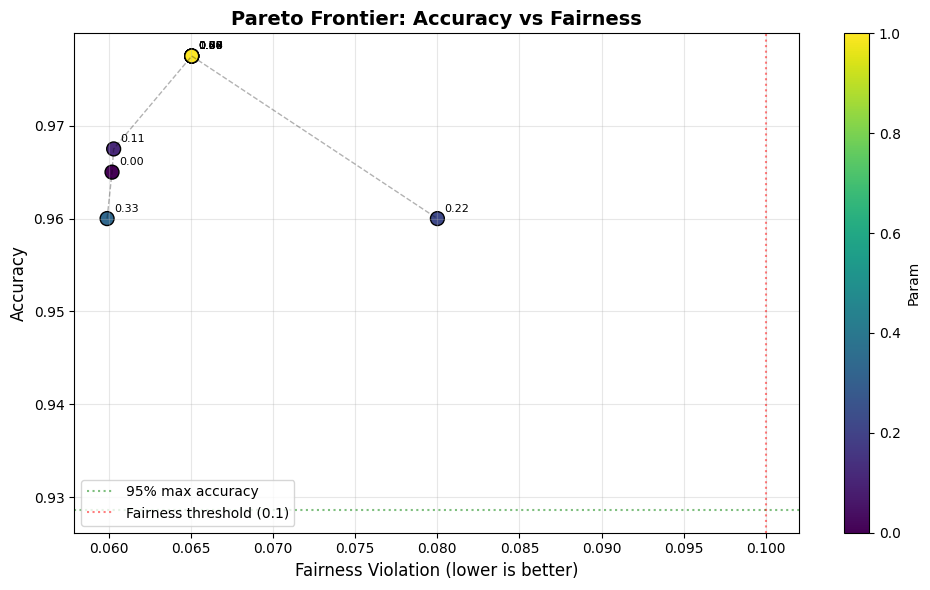


Explored 10 configurations


In [10]:


# Cell 15: Code - Quick Pareto Analysis
# Quick Pareto analysis
pareto_results, pareto_fig = quick_pareto_analysis(
    base_estimator=LogisticRegression(random_state=42, max_iter=1000),
    X_train=X_train,
    y_train=y_train,
    sensitive_train=s_train,
    X_val=X_test,
    y_val=y_test,
    sensitive_val=s_test,
    n_points=10
)

plt.show()
print(f"\nExplored {len(pareto_results)} configurations")



In [11]:
# Cell 16: Code - Detailed Pareto Exploration
# Detailed Pareto exploration
explorer = ParetoFrontierExplorer(
    base_estimator=LogisticRegression(random_state=42, max_iter=1000),
    training_method='reductions',
    constraint_type='demographic_parity',
)

results = explorer.explore(
    X_train, y_train, s_train,
    X_test, y_test, s_test,
    param_range=np.linspace(0.0, 1.0, 15),
    param_name='fairness_weight'
)

# Get Pareto-optimal models
pareto_optimal = explorer.get_pareto_optimal()
print(f"\nPareto-optimal models: {len(pareto_optimal)}")

for i, point in enumerate(pareto_optimal):
    print(f"  {i+1}. Accuracy: {point.accuracy:.4f}, "
          f"Fairness: {point.fairness_violation:.4f}, "
          f"Weight: {point.hyperparameter:.3f}")

# Get results as DataFrame
results_df = explorer.get_results_dataframe()
print("\nAll Results:")
print(results_df.head(10))



2026-01-17 16:35:29 - training_module.src.pareto - INFO - ParetoFrontierExplorer initialized: method=reductions, constraint=demographic_parity


2026-01-17 16:35:29,514 - training_module.src.pareto - INFO - ParetoFrontierExplorer initialized: method=reductions, constraint=demographic_parity


2026-01-17 16:35:29 - training_module.src.pareto - INFO - Exploring 15 configurations...


2026-01-17 16:35:29,516 - training_module.src.pareto - INFO - Exploring 15 configurations...


2026-01-17 16:35:29 - training_module.src.pareto - INFO - [1/15] Training with fairness_weight=0.0000


2026-01-17 16:35:29,518 - training_module.src.pareto - INFO - [1/15] Training with fairness_weight=0.0000


2026-01-17 16:35:29 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.01, max_iter=50)


2026-01-17 16:35:29,520 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.01, max_iter=50)


2026-01-17 16:35:29 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:29,861 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:29 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0852


2026-01-17 16:35:29,861 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0852


2026-01-17 16:35:29 - training_module.src.pareto - INFO -   Accuracy: 0.9625, Fairness violation: 0.0852


2026-01-17 16:35:29,870 - training_module.src.pareto - INFO -   Accuracy: 0.9625, Fairness violation: 0.0852


2026-01-17 16:35:29 - training_module.src.pareto - INFO - [2/15] Training with fairness_weight=0.0714


2026-01-17 16:35:29,871 - training_module.src.pareto - INFO - [2/15] Training with fairness_weight=0.0714


2026-01-17 16:35:29 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.045, max_iter=50)


2026-01-17 16:35:29,872 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.045, max_iter=50)


2026-01-17 16:35:30 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:30,203 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0499


2026-01-17 16:35:30,204 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0499


2026-01-17 16:35:30 - training_module.src.pareto - INFO -   Accuracy: 0.9650, Fairness violation: 0.0499


2026-01-17 16:35:30,212 - training_module.src.pareto - INFO -   Accuracy: 0.9650, Fairness violation: 0.0499


2026-01-17 16:35:30 - training_module.src.pareto - INFO - [3/15] Training with fairness_weight=0.1429


2026-01-17 16:35:30,212 - training_module.src.pareto - INFO - [3/15] Training with fairness_weight=0.1429


2026-01-17 16:35:30 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.07999999999999999, max_iter=50)


2026-01-17 16:35:30,212 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.07999999999999999, max_iter=50)


2026-01-17 16:35:30 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:30,619 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0753


2026-01-17 16:35:30,630 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0753


2026-01-17 16:35:30 - training_module.src.pareto - INFO -   Accuracy: 0.9700, Fairness violation: 0.0753


2026-01-17 16:35:30,633 - training_module.src.pareto - INFO -   Accuracy: 0.9700, Fairness violation: 0.0753


2026-01-17 16:35:30 - training_module.src.pareto - INFO - [4/15] Training with fairness_weight=0.2143


2026-01-17 16:35:30,635 - training_module.src.pareto - INFO - [4/15] Training with fairness_weight=0.2143


2026-01-17 16:35:30 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.11499999999999999, max_iter=50)


2026-01-17 16:35:30,639 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.11499999999999999, max_iter=50)


2026-01-17 16:35:31 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:31,078 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0601


2026-01-17 16:35:31,090 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0601


2026-01-17 16:35:31 - training_module.src.pareto - INFO -   Accuracy: 0.9675, Fairness violation: 0.0601


2026-01-17 16:35:31,091 - training_module.src.pareto - INFO -   Accuracy: 0.9675, Fairness violation: 0.0601


2026-01-17 16:35:31 - training_module.src.pareto - INFO - [5/15] Training with fairness_weight=0.2857


2026-01-17 16:35:31,092 - training_module.src.pareto - INFO - [5/15] Training with fairness_weight=0.2857


2026-01-17 16:35:31 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.15, max_iter=50)


2026-01-17 16:35:31,093 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.15, max_iter=50)


2026-01-17 16:35:31 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:31,372 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0601


2026-01-17 16:35:31,380 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0601


2026-01-17 16:35:31 - training_module.src.pareto - INFO -   Accuracy: 0.9650, Fairness violation: 0.0601


2026-01-17 16:35:31,380 - training_module.src.pareto - INFO -   Accuracy: 0.9650, Fairness violation: 0.0601


2026-01-17 16:35:31 - training_module.src.pareto - INFO - [6/15] Training with fairness_weight=0.3571


2026-01-17 16:35:31,386 - training_module.src.pareto - INFO - [6/15] Training with fairness_weight=0.3571


2026-01-17 16:35:31 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.18499999999999997, max_iter=50)


2026-01-17 16:35:31,386 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.18499999999999997, max_iter=50)


2026-01-17 16:35:31 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:31,694 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:31 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:31,698 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:31 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:31,702 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:31 - training_module.src.pareto - INFO - [7/15] Training with fairness_weight=0.4286


2026-01-17 16:35:31,704 - training_module.src.pareto - INFO - [7/15] Training with fairness_weight=0.4286


2026-01-17 16:35:31 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.22, max_iter=50)


2026-01-17 16:35:31,705 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.22, max_iter=50)


2026-01-17 16:35:32 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:32,086 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:32,094 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:32 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:32,096 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:32 - training_module.src.pareto - INFO - [8/15] Training with fairness_weight=0.5000


2026-01-17 16:35:32,096 - training_module.src.pareto - INFO - [8/15] Training with fairness_weight=0.5000


2026-01-17 16:35:32 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.255, max_iter=50)


2026-01-17 16:35:32,100 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.255, max_iter=50)


2026-01-17 16:35:32 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:32,423 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:32,428 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:32 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:32,430 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:32 - training_module.src.pareto - INFO - [9/15] Training with fairness_weight=0.5714


2026-01-17 16:35:32,432 - training_module.src.pareto - INFO - [9/15] Training with fairness_weight=0.5714


2026-01-17 16:35:32 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.29, max_iter=50)


2026-01-17 16:35:32,434 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.29, max_iter=50)


2026-01-17 16:35:32 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:32,721 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:32 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:32,729 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:32 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:32,729 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:32 - training_module.src.pareto - INFO - [10/15] Training with fairness_weight=0.6429


2026-01-17 16:35:32,729 - training_module.src.pareto - INFO - [10/15] Training with fairness_weight=0.6429


2026-01-17 16:35:32 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.32499999999999996, max_iter=50)


2026-01-17 16:35:32,737 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.32499999999999996, max_iter=50)


2026-01-17 16:35:33 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:33,054 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:33,070 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:33 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:33,071 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:33 - training_module.src.pareto - INFO - [11/15] Training with fairness_weight=0.7143


2026-01-17 16:35:33,073 - training_module.src.pareto - INFO - [11/15] Training with fairness_weight=0.7143


2026-01-17 16:35:33 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.35999999999999993, max_iter=50)


2026-01-17 16:35:33,075 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.35999999999999993, max_iter=50)


2026-01-17 16:35:33 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:33,454 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:33,461 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:33 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:33,461 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:33 - training_module.src.pareto - INFO - [12/15] Training with fairness_weight=0.7857


2026-01-17 16:35:33,466 - training_module.src.pareto - INFO - [12/15] Training with fairness_weight=0.7857


2026-01-17 16:35:33 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.395, max_iter=50)


2026-01-17 16:35:33,469 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.395, max_iter=50)


2026-01-17 16:35:33 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:33,830 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:33 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:33,835 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:33 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:33,835 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:33 - training_module.src.pareto - INFO - [13/15] Training with fairness_weight=0.8571


2026-01-17 16:35:33,835 - training_module.src.pareto - INFO - [13/15] Training with fairness_weight=0.8571


2026-01-17 16:35:33 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.43, max_iter=50)


2026-01-17 16:35:33,835 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.43, max_iter=50)


2026-01-17 16:35:34 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:34,300 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:34,300 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:34 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:34,309 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:34 - training_module.src.pareto - INFO - [14/15] Training with fairness_weight=0.9286


2026-01-17 16:35:34,309 - training_module.src.pareto - INFO - [14/15] Training with fairness_weight=0.9286


2026-01-17 16:35:34 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.46499999999999997, max_iter=50)


2026-01-17 16:35:34,309 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.46499999999999997, max_iter=50)


2026-01-17 16:35:34 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:34,599 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:34,605 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:34 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:34,605 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:34 - training_module.src.pareto - INFO - [15/15] Training with fairness_weight=1.0000


2026-01-17 16:35:34,608 - training_module.src.pareto - INFO - [15/15] Training with fairness_weight=1.0000


2026-01-17 16:35:34 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.5, max_iter=50)


2026-01-17 16:35:34,608 - training_module.src.sklearn_wrappers - INFO - Fitting ReductionsWrapper with DemographicParity (eps=0.5, max_iter=50)


2026-01-17 16:35:34 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:34,975 - training_module.src.sklearn_wrappers - INFO - ReductionsWrapper fitted successfully


2026-01-17 16:35:34 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:34,980 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0651


2026-01-17 16:35:34 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:34,982 - training_module.src.pareto - INFO -   Accuracy: 0.9775, Fairness violation: 0.0651


2026-01-17 16:35:34 - training_module.src.pareto - INFO - Identified 12 Pareto-optimal points


2026-01-17 16:35:34,983 - training_module.src.pareto - INFO - Identified 12 Pareto-optimal points


2026-01-17 16:35:34 - training_module.src.pareto - INFO - Exploration complete: 15 models trained, 12 Pareto-optimal


2026-01-17 16:35:34,985 - training_module.src.pareto - INFO - Exploration complete: 15 models trained, 12 Pareto-optimal



Pareto-optimal models: 12
  1. Accuracy: 0.9650, Fairness: 0.0499, Weight: 0.071
  2. Accuracy: 0.9675, Fairness: 0.0601, Weight: 0.214
  3. Accuracy: 0.9775, Fairness: 0.0651, Weight: 0.357
  4. Accuracy: 0.9775, Fairness: 0.0651, Weight: 0.429
  5. Accuracy: 0.9775, Fairness: 0.0651, Weight: 0.500
  6. Accuracy: 0.9775, Fairness: 0.0651, Weight: 0.571
  7. Accuracy: 0.9775, Fairness: 0.0651, Weight: 0.643
  8. Accuracy: 0.9775, Fairness: 0.0651, Weight: 0.714
  9. Accuracy: 0.9775, Fairness: 0.0651, Weight: 0.786
  10. Accuracy: 0.9775, Fairness: 0.0651, Weight: 0.857
  11. Accuracy: 0.9775, Fairness: 0.0651, Weight: 0.929
  12. Accuracy: 0.9775, Fairness: 0.0651, Weight: 1.000

All Results:
   accuracy  fairness_violation  fairness_weight  is_pareto_optimal
0    0.9625            0.085159         0.000000              False
1    0.9650            0.049905         0.071429               True
2    0.9700            0.075258         0.142857              False
3    0.9675            0

In [12]:
# Cell 17: Code - Model Recommendation
# Recommend a model based on constraints
recommended = explorer.recommend_model(
    max_fairness_violation=0.1,
    min_accuracy=0.7,
)

if recommended:
    print(f"\nRecommended Model:")
    print(f"Accuracy: {recommended.accuracy:.4f}")
    print(f"Fairness Violation: {recommended.fairness_violation:.4f}")
    print(f"Hyperparameter: {recommended.hyperparameter:.4f}")
else:
    print("\nNo model meets the specified constraints")



2026-01-17 16:35:42 - training_module.src.pareto - INFO - Recommended model: accuracy=0.9775, fairness_violation=0.0651, fairness_weight=0.3571


2026-01-17 16:35:42,036 - training_module.src.pareto - INFO - Recommended model: accuracy=0.9775, fairness_violation=0.0651, fairness_weight=0.3571



Recommended Model:
Accuracy: 0.9775
Fairness Violation: 0.0651
Hyperparameter: 0.3571


# Cell 18: Markdown
"""
## 7. Visualization - Model Comparison

Compare fairness metrics across all trained models.
"""


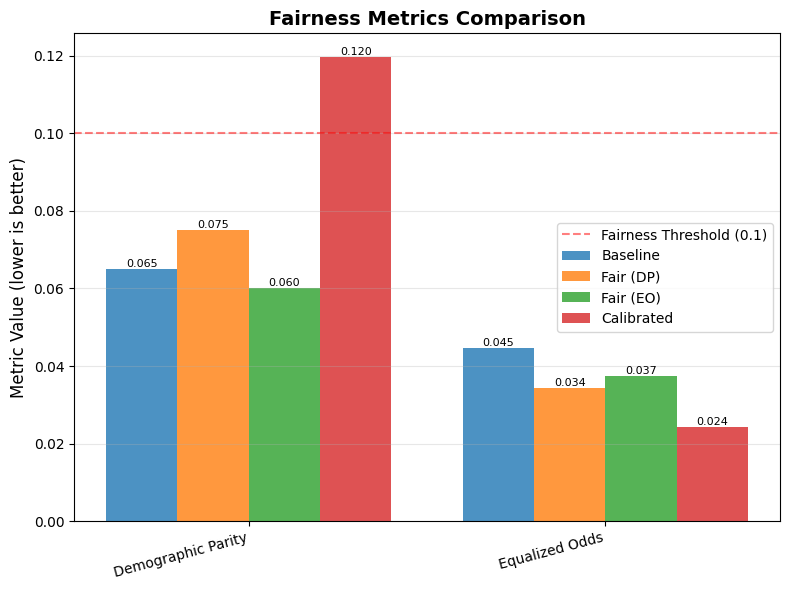


=== Available Metrics Debug ===

Baseline metrics keys:
['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_demographic_parity', 'test_equalized_odds']

DP metrics keys:
['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_demographic_parity', 'test_equalized_odds']

EO metrics keys:
['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_demographic_parity', 'test_equalized_odds']

Calibrated metrics keys:
['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_demographic_parity', 'test_equalized_odds']


In [13]:
# Cell 19: Code - Fairness Comparison Plot (with safe key access)

# Helper function to safely get metrics
def get_metric_safe(metrics_dict, key, default=0.0):
    """Safely get metric value with default fallback."""
    return metrics_dict.get(key, default)

# Prepare comparison data with safe access
models_comparison = {
    'Baseline': {
        'demographic_parity': get_metric_safe(baseline_metrics, 'test_demographic_parity'),
        'equalized_odds': get_metric_safe(baseline_metrics, 'test_equalized_odds'),
        'accuracy': get_metric_safe(baseline_metrics, 'test_accuracy'),
    },
    'Fair (DP)': {
        'demographic_parity': get_metric_safe(dp_metrics, 'test_demographic_parity'),
        'equalized_odds': get_metric_safe(dp_metrics, 'test_equalized_odds'),
        'accuracy': get_metric_safe(dp_metrics, 'test_accuracy'),
    },
    'Fair (EO)': {
        'demographic_parity': get_metric_safe(eo_metrics, 'test_demographic_parity'),
        'equalized_odds': get_metric_safe(eo_metrics, 'test_equalized_odds'),
        'accuracy': get_metric_safe(eo_metrics, 'test_accuracy'),
    },
    'Calibrated': {
        'demographic_parity': get_metric_safe(calibrated_metrics, 'test_demographic_parity'),
        'equalized_odds': get_metric_safe(calibrated_metrics, 'test_equalized_odds'),
        'accuracy': get_metric_safe(calibrated_metrics, 'test_accuracy'),
    },
}

# Plot fairness comparison
fig = plot_fairness_comparison(
    models_comparison,
    metric_names=['demographic_parity', 'equalized_odds'],
)
plt.show()

# OPTIONAL: Print what metrics are actually available for debugging
print("\n=== Available Metrics Debug ===")
print("\nBaseline metrics keys:")
print([k for k in baseline_metrics.keys() if 'test' in k])
print("\nDP metrics keys:")
print([k for k in dp_metrics.keys() if 'test' in k])
print("\nEO metrics keys:")
print([k for k in eo_metrics.keys() if 'test' in k])
print("\nCalibrated metrics keys:")
print([k for k in calibrated_metrics.keys() if 'test' in k])

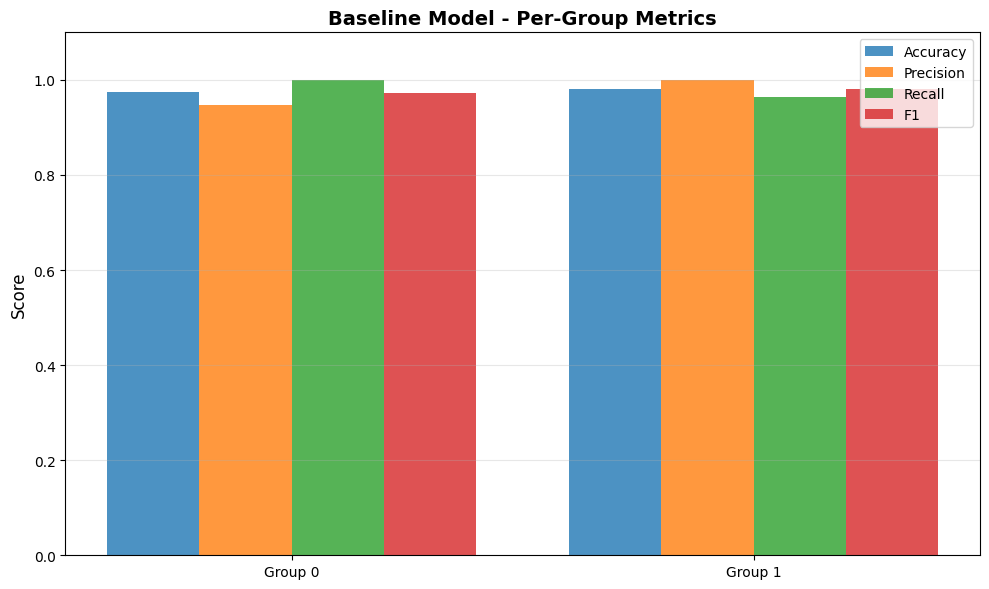

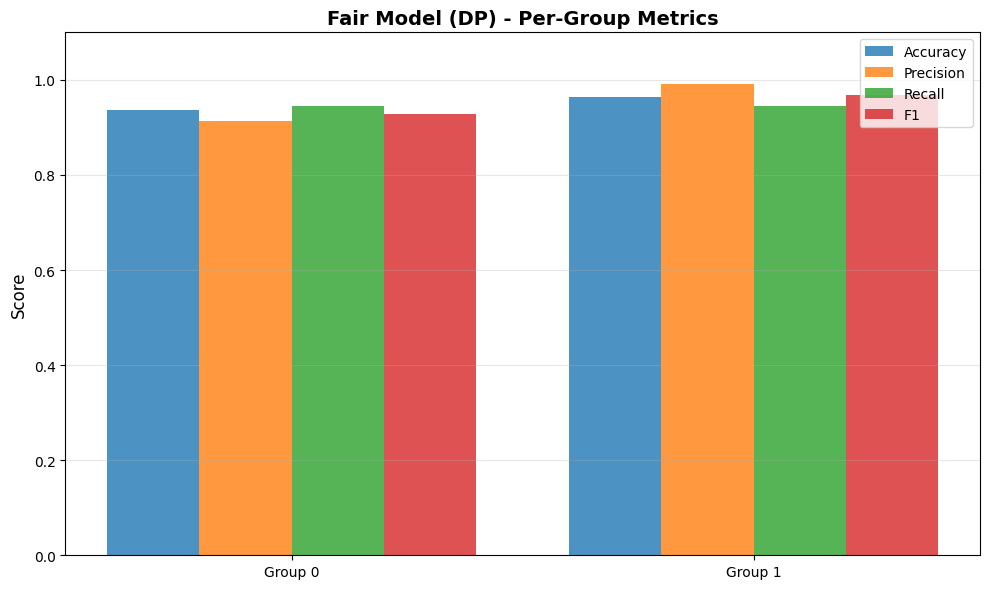

In [15]:
# Cell 20: Code - Per-Group Metrics Plots
# Plot per-group metrics for baseline vs fair model
fig1 = plot_group_metrics(
    y_test, y_pred_baseline, s_test,
    group_names={0: 'Group 0', 1: 'Group 1'}
)
plt.title('Baseline Model - Per-Group Metrics', fontweight='bold', fontsize=14)
plt.show()

fig2 = plot_group_metrics(
    y_test, y_pred_dp, s_test,
    group_names={0: 'Group 0', 1: 'Group 1'}
)
plt.title('Fair Model (DP) - Per-Group Metrics', fontweight='bold', fontsize=14)
plt.show()



# Cell 21: Markdown
"""
## 8. PyTorch: Fairness Regularized Loss

Train neural networks with fairness regularization (if PyTorch available).
"""

In [47]:


# Cell 22: Code - PyTorch Training
if PYTORCH_AVAILABLE:
    # Create simple MLP
    pytorch_model = create_simple_mlp(
        input_dim=X_train.shape[1],
        hidden_dims=[64, 32],
        dropout=0.2
    )
    
    # Create fairness loss
    criterion = create_fairness_loss(
        base_loss='bce',
        fairness_weight=0.5,
        fairness_type='demographic_parity'
    )
    
    # Training setup
    optimizer = torch.optim.Adam(pytorch_model.parameters(), lr=0.001)
    
    # Convert to tensors
    X_train_t = torch.FloatTensor(X_train)
    y_train_t = torch.FloatTensor(y_train).reshape(-1, 1)
    s_train_t = torch.FloatTensor(s_train)
    
    # Training loop
    n_epochs = 50
    batch_size = 64
    
    pytorch_model.train()
    for epoch in range(n_epochs):
        total_loss = 0
        n_batches = 0
        
        indices = torch.randperm(len(X_train_t))
        for i in range(0, len(X_train_t), batch_size):
            batch_idx = indices[i:i+batch_size]
            X_batch = X_train_t[batch_idx]
            y_batch = y_train_t[batch_idx]
            s_batch = s_train_t[batch_idx]
            
            optimizer.zero_grad()
            logits = pytorch_model(X_batch)
            loss = criterion(logits, y_batch, s_batch)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            n_batches += 1
        
        if (epoch + 1) % 10 == 0:
            avg_loss = total_loss / n_batches
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")
    
    print("\nPyTorch model trained with fairness regularization!")
    
    # Evaluate
    pytorch_model.eval()
    with torch.no_grad():
        X_test_t = torch.FloatTensor(X_test)
        logits = pytorch_model(X_test_t)
        probs = torch.sigmoid(logits)
        y_pred_pytorch = (probs > 0.5).numpy().astype(int).flatten()
    
    pytorch_acc = accuracy_score(y_test, y_pred_pytorch)
    pytorch_dp, _, _ = demographic_parity_difference(y_test, y_pred_pytorch, s_test)
    
    print(f"\nPyTorch Model Results:")
    print(f"Accuracy: {pytorch_acc:.4f}")
    print(f"Demographic Parity: {abs(pytorch_dp):.4f}")
else:
    print("PyTorch not available. Skipping neural network demo.")



2026-01-13 20:53:20 - training_module.src.pytorch_losses - INFO - FairnessRegularizedLoss initialized: λ=0.5, type=demographic_parity
Epoch 10/50, Loss: 0.1199
Epoch 20/50, Loss: 0.0582
Epoch 30/50, Loss: 0.0594
Epoch 40/50, Loss: 0.0329
Epoch 50/50, Loss: 0.0348

PyTorch model trained with fairness regularization!
2026-01-13 20:53:30 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0848

PyTorch Model Results:
Accuracy: 0.9725
Demographic Parity: 0.0848


# Cell 23: Markdown
"""
## 9. Lagrangian Fairness Trainer

Train with hard constraints using Lagrangian optimization (if PyTorch available).
"""


2026-01-17 16:37:07 - training_module.src.lagrangian_trainer - INFO - LagrangianFairnessTrainer initialized: constraint=demographic_parity, lr_model=0.001, lr_lambda=0.01


2026-01-17 16:37:07,716 - training_module.src.lagrangian_trainer - INFO - LagrangianFairnessTrainer initialized: constraint=demographic_parity, lr_model=0.001, lr_lambda=0.01


2026-01-17 16:37:11 - training_module.src.lagrangian_trainer - INFO - Epoch 20/100: Loss=0.1131, Acc=0.9830, Constraint=0.0951, λ=1.1729


2026-01-17 16:37:11,431 - training_module.src.lagrangian_trainer - INFO - Epoch 20/100: Loss=0.1131, Acc=0.9830, Constraint=0.0951, λ=1.1729


2026-01-17 16:37:14 - training_module.src.lagrangian_trainer - INFO - Epoch 40/100: Loss=0.1122, Acc=0.9922, Constraint=0.1046, λ=1.4095


2026-01-17 16:37:14,879 - training_module.src.lagrangian_trainer - INFO - Epoch 40/100: Loss=0.1122, Acc=0.9922, Constraint=0.1046, λ=1.4095


2026-01-17 16:37:15 - training_module.src.lagrangian_trainer - INFO - Early stopping at epoch 43


2026-01-17 16:37:15,343 - training_module.src.lagrangian_trainer - INFO - Early stopping at epoch 43


2026-01-17 16:37:15 - training_module.src.lagrangian_trainer - INFO - Training completed successfully


2026-01-17 16:37:15,344 - training_module.src.lagrangian_trainer - INFO - Training completed successfully


2026-01-17 16:37:15 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0549


2026-01-17 16:37:15,350 - measurement_module.src.metrics_engine - INFO - Demographic parity difference: 0.0549



Lagrangian Model Results:
Accuracy: 0.9675
Demographic Parity: 0.0549
Final Lambda: 1.4499
Constraint Slack: 0.0500


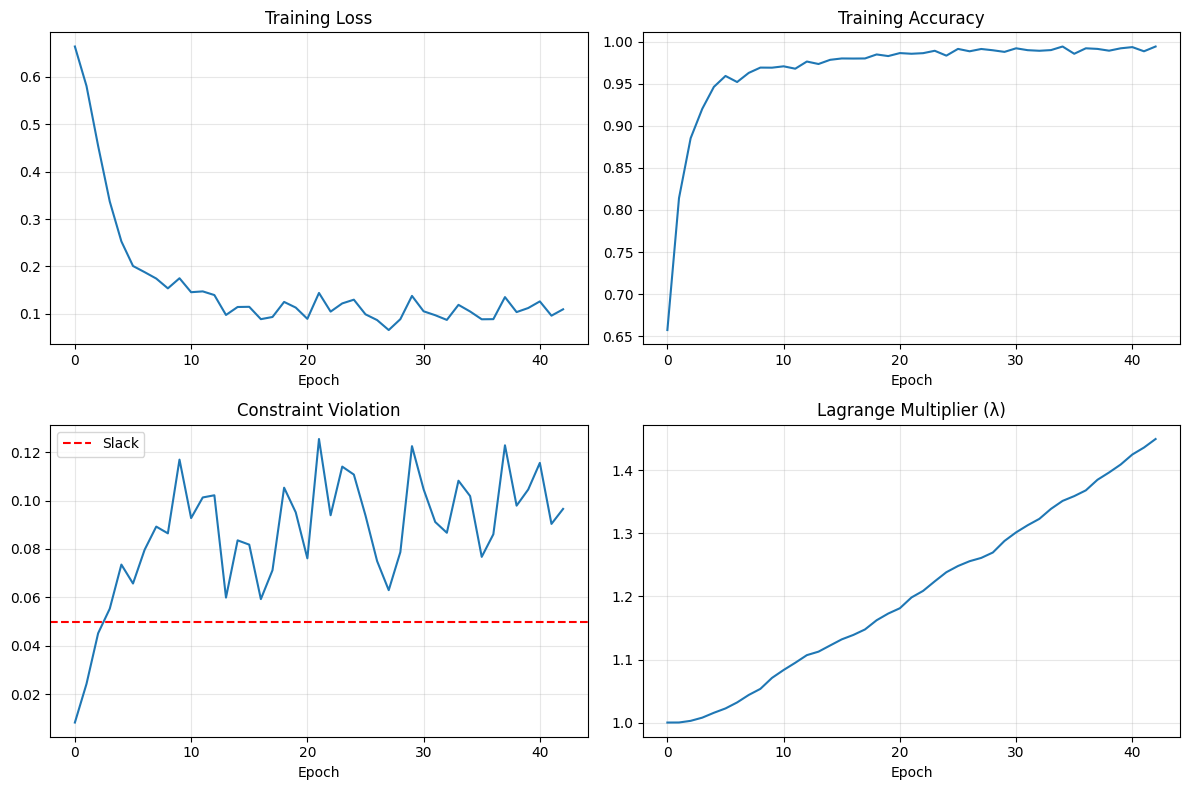

In [16]:

# Cell 24: Code - Lagrangian Training
if PYTORCH_AVAILABLE:
    # Create model
    lagrangian_model = create_simple_mlp(
        input_dim=X_train.shape[1],
        hidden_dims=[64, 32],
        dropout=0.1
    )
    
    # Configure Lagrangian trainer
    config = LagrangianConfig(
        lr_model=0.001,
        lr_lambda=0.01,
        max_epochs=100,
        batch_size=64,
        constraint_slack=0.05,
        patience=15,
        verbose=True,
        log_interval=20
    )
    
    # Create trainer
    trainer = LagrangianFairnessTrainer(
        model=lagrangian_model,
        config=config,
        constraint_type='demographic_parity',
        device='cpu'
    )
    
    # Train
    trainer.fit(X_train, y_train, s_train)
    
    # Evaluate
    y_pred_lagrangian = trainer.predict(X_test)
    
    lagrangian_acc = accuracy_score(y_test, y_pred_lagrangian)
    lagrangian_dp, _, _ = demographic_parity_difference(y_test, y_pred_lagrangian, s_test)
    
    print(f"\n{'='*60}")
    print(f"Lagrangian Model Results:")
    print(f"{'='*60}")
    print(f"Accuracy: {lagrangian_acc:.4f}")
    print(f"Demographic Parity: {abs(lagrangian_dp):.4f}")
    print(f"Final Lambda: {trainer.get_lambda_value():.4f}")
    print(f"Constraint Slack: {trainer.get_constraint_slack():.4f}")
else:
    print("PyTorch not available. Skipping Lagrangian trainer demo.")

# Cell 25: Code - Training History Visualization
if PYTORCH_AVAILABLE:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    axes[0, 0].plot(trainer.history_['train_loss'])
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(trainer.history_['train_accuracy'])
    axes[0, 1].set_title('Training Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].plot(trainer.history_['train_constraint'])
    axes[1, 0].axhline(y=config.constraint_slack, color='r', linestyle='--', label='Slack')
    axes[1, 0].set_title('Constraint Violation')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].plot(trainer.history_['lambda_values'])
    axes[1, 1].set_title('Lagrange Multiplier (λ)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



# Cell 26: Markdown
"""
## 10. Final Comparison

Compare all trained models side-by-side.
"""

In [19]:
# Cell 27: Code - Comprehensive Comparison (Fixed)
import numpy as np
import pandas as pd

# Create comprehensive comparison
comparison_data = {
    'Model': [],
    'Accuracy': [],
    'Demographic Parity': [],
    'Equalized Odds': [],
    'Precision': [],
    'Recall': [],
}

# Helper function to safely add metrics
def add_model_metrics(model_name, metrics_dict):
    """Safely add model metrics to comparison data"""
    comparison_data['Model'].append(model_name)
    comparison_data['Accuracy'].append(metrics_dict.get('test_accuracy', np.nan))
    comparison_data['Demographic Parity'].append(abs(metrics_dict.get('test_demographic_parity', np.nan)))
    comparison_data['Equalized Odds'].append(metrics_dict.get('test_equalized_odds', np.nan))
    comparison_data['Precision'].append(metrics_dict.get('test_precision', np.nan))
    comparison_data['Recall'].append(metrics_dict.get('test_recall', np.nan))

# Add baseline model
if 'baseline_metrics' in dir():
    add_model_metrics('Baseline', baseline_metrics)
else:
    print("⚠️ Warning: baseline_metrics not found")

# Add fair models (DP)
if 'dp_metrics' in dir():
    add_model_metrics('Fair (DP)', dp_metrics)
else:
    print("⚠️ Warning: dp_metrics not found")

# Add fair models (EO)
if 'eo_metrics' in dir():
    add_model_metrics('Fair (EO)', eo_metrics)
else:
    print("⚠️ Warning: eo_metrics not found")

# Add calibrated model
if 'calibrated_metrics' in dir():
    add_model_metrics('Calibrated', calibrated_metrics)
else:
    print("⚠️ Warning: calibrated_metrics not found")

# Add PyTorch models if available
if 'PYTORCH_AVAILABLE' in dir() and PYTORCH_AVAILABLE:
    # Check if PyTorch metrics exist
    if all(var in dir() for var in ['pytorch_acc', 'pytorch_dp']):
        comparison_data['Model'].append('PyTorch (Reg)')
        comparison_data['Accuracy'].append(pytorch_acc)
        comparison_data['Demographic Parity'].append(abs(pytorch_dp))
        comparison_data['Equalized Odds'].append(np.nan)  # Not computed
        comparison_data['Precision'].append(np.nan)  # Not computed
        comparison_data['Recall'].append(np.nan)  # Not computed
    else:
        print("⚠️ Warning: PyTorch regularization metrics not found")
    
    # Check if Lagrangian metrics exist
    if all(var in dir() for var in ['lagrangian_acc', 'lagrangian_dp']):
        comparison_data['Model'].append('Lagrangian')
        comparison_data['Accuracy'].append(lagrangian_acc)
        comparison_data['Demographic Parity'].append(abs(lagrangian_dp))
        comparison_data['Equalized Odds'].append(np.nan)  # Not computed
        comparison_data['Precision'].append(np.nan)  # Not computed
        comparison_data['Recall'].append(np.nan)  # Not computed
    else:
        print("⚠️ Warning: Lagrangian metrics not found")

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Round for display (leave NaN as is for missing values)
comparison_df = comparison_df.round(4)

# Display results
print("\n" + "="*80)
print("FINAL MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Additional analysis
if len(comparison_df) > 0:
    print("\n📊 Key Insights:")
    print("-" * 80)
    
    # Best accuracy
    best_acc_idx = comparison_df['Accuracy'].idxmax()
    if pd.notna(best_acc_idx):
        print(f"✓ Best Accuracy: {comparison_df.loc[best_acc_idx, 'Model']} "
              f"({comparison_df.loc[best_acc_idx, 'Accuracy']:.4f})")
    
    # Most fair (lowest DP)
    best_dp_idx = comparison_df['Demographic Parity'].idxmin()
    if pd.notna(best_dp_idx):
        print(f"✓ Most Fair (DP): {comparison_df.loc[best_dp_idx, 'Model']} "
              f"({comparison_df.loc[best_dp_idx, 'Demographic Parity']:.4f})")
    
    # Best trade-off (highest accuracy with DP < 0.1)
    fair_models = comparison_df[comparison_df['Demographic Parity'] < 0.1]
    if len(fair_models) > 0:
        best_tradeoff_idx = fair_models['Accuracy'].idxmax()
        print(f"✓ Best Trade-off: {fair_models.loc[best_tradeoff_idx, 'Model']} "
              f"(Acc: {fair_models.loc[best_tradeoff_idx, 'Accuracy']:.4f}, "
              f"DP: {fair_models.loc[best_tradeoff_idx, 'Demographic Parity']:.4f})")
    
    print("-" * 80)
else:
    print("\n⚠️ No models to compare. Please ensure previous cells ran successfully.")

# Optional: Export to CSV
# comparison_df.to_csv('model_comparison.csv', index=False)
# print("\n💾 Comparison saved to 'model_comparison.csv'")

⚠️ Warning: PyTorch regularization metrics not found
⚠️ Warning: Lagrangian metrics not found

FINAL MODEL COMPARISON
     Model  Accuracy  Demographic Parity  Equalized Odds  Precision  Recall
  Baseline    0.9775              0.0651          0.0446     0.9751   0.980
 Fair (DP)    0.9625              0.0752          0.0343     0.9557   0.970
 Fair (EO)    0.9350              0.0600          0.0374     0.9350   0.935
Calibrated    0.9900              0.1198          0.0242     1.0000   0.980

📊 Key Insights:
--------------------------------------------------------------------------------
✓ Best Accuracy: Calibrated (0.9900)
✓ Most Fair (DP): Fair (EO) (0.0600)
✓ Best Trade-off: Baseline (Acc: 0.9775, DP: 0.0651)
--------------------------------------------------------------------------------


# Cell 28: Markdown
"""
## 11. Key Takeaways

### ReductionsWrapper
- **Best for**: Integration with existing sklearn pipelines
- **Pros**: Easy to use, multiple constraint types, production-ready
- **Cons**: Limited to linear models and tree ensembles

### FairnessRegularizedLoss (PyTorch)
- **Best for**: Neural networks, flexible architectures
- **Pros**: Soft constraints, easy to tune, minimal overhead
- **Cons**: Requires careful weight tuning, no guarantees

### LagrangianFairnessTrainer
- **Best for**: Hard fairness constraints in neural networks
- **Pros**: Theoretically principled, adaptive constraint enforcement
- **Cons**: More complex, requires careful initialization

### GroupFairnessCalibrator
- **Best for**: Post-hoc fairness improvement
- **Pros**: Works with any model, preserves accuracy
- **Cons**: Requires validation data, limited fairness improvement

### ParetoFrontierExplorer
- **Best for**: Systematic model selection
- **Pros**: Comprehensive analysis, data-driven decisions
- **Cons**: Computationally expensive, many models to evaluate
"""

# Cell 29: Markdown
"""
## 12. Next Steps

1. **Experiment with different constraints**: Try `equal_opportunity`, `error_rate_parity`
2. **Tune hyperparameters**: Use `GridSearchReductions` or manual grid search
3. **Explore Pareto frontier**: Find the optimal accuracy-fairness trade-off
4. **Apply calibration**: Post-process any model for better fairness
5. **Use real data**: Apply these techniques to your use case

### References
- Fairlearn: https://fairlearn.org/
- Agarwal et al. (2018): A Reductions Approach to Fair Classification
- Cotter et al. (2019): Optimization with Non-Differentiable Constraints
"""